In [1]:
import pandas as pd
import numpy as np
import random
from intent_classify import IntentClassify
from gensim import corpora, models, similarities,matutils
from fasttext_util import FasttextClassifier
import time
from collections import Counter
from sklearn.cluster import KMeans
import jieba
import matplotlib.pyplot as plt
%matplotlib inline


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.292 seconds.
Prefix dict has been built succesfully.


load 1006 user-define jieba dict success!


In [2]:
class word():    
    def __init__(self):
        self.word_to_vec = {}
        self.dictionary = corpora.dictionary.Dictionary()
        self.dic = self.dictionary.load('../util/new/laiye/corpus.dict')
        self.tfidf = models.TfidfModel.load('../util/new/laiye/corpus.tfidf_model')  
        
    def remove_punctuation(self, line):
        rule = re.compile(ur"[^a-zA-Z0-9\u4e00-\u9fa5]")
        line = rule.sub('',line)
        return line        

    def stopwordslist(self, filepath):  
        stopwords = [line.strip() for line in open(filepath, 'r').readlines()]  
        return stopwords  


    # ÂØπÂè•Â≠êËøõË°åÂàÜËØç  
    def jieba_cut(self, sentence):  
        sentence_seged = jieba.cut(sentence.strip())  
        stopwords = self.stopwordslist('../util/new/laiye/stopword.txt')  # ËøôÈáåÂä†ËΩΩÂÅúÁî®ËØçÁöÑË∑ØÂæÑ  
        outstr = ''  
        for word in sentence_seged:  
            if word.encode('utf-8') not in stopwords:  
                if word.encode('utf-8') != '\t' and word != '\t':  
                    outstr += word
                    outstr += " "  
        return outstr.strip()

    def get_word2vec(self):
        with open('../util/new/laiye/w2v_sgns_win1_d80.kv') as f:
            data = [x.split(' ') for x in f.readlines()[1:]]
            words = [d[0] for d in data]
            vecs = np.array([d[1: -1] for d in data], dtype= 'float64')
            for i in range(len(words)):
                word = words[i]
                self.word_to_vec[word] = vecs[i]
    def get_tf_idf_of_query(self, query, dic, tfidf):      
        vec_bow = dic.doc2bow(query)
        vec_tfidf = tfidf[vec_bow]
        tp = [0.0] * len(query)
        ids = [tid[0] for tid in vec_tfidf]
        flags = [0] * len(query)
        count = 0.00001
        for j in range(len(query)):
            for i in range(len(ids)):
                if self.dic[ids[i]] == query[j]:
                    tp[j] = vec_tfidf[i][1]
                    flags[j] = 1
                    count += 1
                    break
        sums = sum(tp)
        #print ','.join(query)
        for i in range(len(flags)):
            if flags[i] == 1:
                continue
            tp[i] = 1.0 * sums / count
                    
        # apply l1-norm to tfidf value
        #tfidf = matutils.unitvec(vec_tfidf, norm = 'l1')   
        return tp

    def get_vectors_of_data_cut(self, data):
        vecs = []
        for i in range(len(data)):
            vec = []
            d_line = self.jieba_cut(data[i]).split(' ')
            tfidfs = self.get_tf_idf_of_query(d_line, self.dic, self.tfidf)
            s = sum(tfidfs)
            for j in range(len(d_line)):
                if d_line[j].encode('utf-8') in self.word_to_vec:
                    if s == 0:
                        vec.append([0.0] * len(self.word_to_vec['ÂÆ∂']))
                    else:
                        vec.append((tfidfs[j] / s) * self.word_to_vec[d_line[j].encode('utf-8')])
            if len(vec) == 0:
                vec.append([0.0] * len(self.word_to_vec['ÂÆ∂']))
            vecs.append(np.sum(np.array(vec), axis = 0))
        return np.array(vecs)    
    

In [7]:
class fold():
    def __init__(self, classCount, texts):
        self.texts = texts
        self.classCount = classCount
        
    def wordsCluster(self, word_vecs):
        #ÂàÜÁ±ª
        clf = KMeans(n_clusters = self.classCount)
        s = clf.fit(word_vecs)
        #Ëé∑ÂèñÂà∞ÊâÄÊúâËØçÂêëÈáèÊâÄÂ±ûÁ±ªÂà´
        labels = clf.labels_
        cluster_dic = {}
        #ÊääÊòØ‰∏ÄÁ±ªÁöÑÊîæÂÖ•Âà∞‰∏Ä‰∏™ÈõÜÂêà
        for i in range(len(self.texts)):
            if labels[i] not in cluster_dic:
                cluster_dic[labels[i]] = texts[i]
            else:
                cluster_dic[labels[i]] = cluster_dic[labels[i]] + ' ' + texts[i]
        label_pred = clf.labels_ #Ëé∑ÂèñËÅöÁ±ªÊ†áÁ≠æ
        centroids = clf.cluster_centers_ #Ëé∑ÂèñËÅöÁ±ª‰∏≠ÂøÉ
        inertia = clf.inertia_ # Ëé∑ÂèñËÅöÁ±ªÂáÜÂàôÁöÑÊÄªÂíå
        print inertia
        mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
        #ËøôÈáå'or'‰ª£Ë°®‰∏≠ÁöÑ'o'‰ª£Ë°®ÁîªÂúàÔºå'r'‰ª£Ë°®È¢úËâ≤‰∏∫Á∫¢Ëâ≤ÔºåÂêéÈù¢ÁöÑ‰æùÊ¨°Á±ªÊé®
        color = 0
        j = 0 
        for i in label_pred:
            plt.plot([word_vecs[j:j+1,0]], [word_vecs[j:j+1,1]], mark[i], markersize = 5)
            j +=1
        plt.show()

        return cluster_dic

69.38140107010133


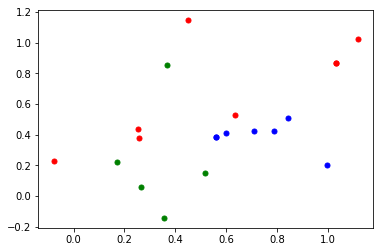

0
ËÉΩÈô™ËÅäÂ§©ÂêóÔºü Èô™ÊàëËÅäÂ§© ËÉΩÈô™ÊàëËÅäÂ§©ÂêóÔºü ‰Ω†ËÉΩË∑üÊàëËÅäÂ§©Âêó? Âí±‰ø©ËøòËÉΩËÅäÂ§©Âïä? ËøòËÉΩ‰∏çËÉΩÊÑâÂø´ÁöÑËÅäÂ§©‰∫Ü ËÉΩ‰∏çËÉΩËÅäÂ§© ‰∏ç‰ºöÂêßËøô‰∏™Âä©ÁêÜÂèØ‰ª•Èô™ÁùÄËÅäÂ§©Âêó
1
Èô™ÊàëËØ¥‰ºöÂÑøËØù Èô™ÊàëËÅäÂá†Âè•ÂëóÔºü Èô™ÊàëËØ¥ËØ¥ËØùÂëó ‰Ω†ËÉΩÈô™ÊàëËÅä‰ºöÂ§©Âêó ‰πüÂ∞±Âè™Êúâ‰Ω†Èô™Âú®ÊàëË∫´Ëæπ Èô™ÊàëËÅä‰ºöÂêß Èô™ÊàëËÅä‰ºöÂ§©/:8-)
2
Èô™ËÅäÂòõÔºü ‰Ω†ËÉΩÂëäËØâÊàë‰Ω†ÊòØË∞Å ‰Ω†ÊòØ‰∏çÊòØÊìÖÈïøËÅäÂ§© ‰Ω†ÊòØ‰∏çÊòØ‰ªÄ‰πàÈÉΩÊáÇ ‰Ω†ÊÄªÊòØÈÇ£‰πàÊáÇÊàë
1.1756869343582166


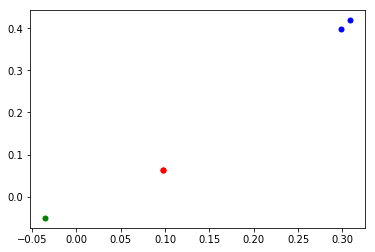

0
Â•≥ÊúãÂèã‰∏çÂºÄÂøÉ‰∫ÜÔºåÊÄé‰πàÂäû Â•≥ÊúãÂèã‰∏çÂºÄÂøÉÔºåÊÄé‰πàÂäû
1
ÊÄé‰πàÂìÑÂ•≥ÊúãÂèãÂºÄÂøÉ ÊÄé‰πàÂìÑÂ•≥ÊúãÂèã
2
Êúâ‰ªÄ‰πà‰∏úË•øÔºåËÉΩËÆ©Â•≥‰∫∫Áû¨Èó¥ÂºÄÂøÉÔºü
0.1905088354704521


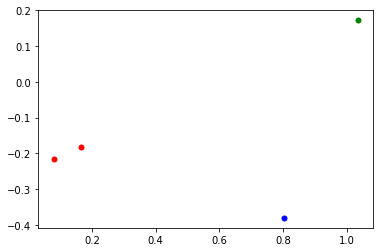

0
ËøáÂπ¥‰Ω†‰ª¨Âì™Â§©Âà∞Âì™Â§©‰ºëÊÅØÂëÄ Êò•ËäÇ‰Ω†‰ª¨Âì™Â§©Âà∞Âì™Â§©‰ºëÊÅØÂëÄ
1
Êò•ËäÇ‰Ω†‰ª¨ÊîæÂá†Â§©ÂÅáÂëÄ
2
ËøáÂπ¥‰Ω†‰ª¨Âá†Âè∑‰ºëÊÅØÂëÄ
19.267719607279787


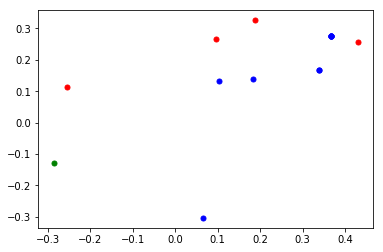

0
ËÇöÂ≠êÈ•ø‰∫ÜËøò‰∏çÂêÉÂïä ËÇöÂ≠êÈ•ø‰∫ÜÊúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ? ÊàëÁé∞Âú®ËÇöÂ≠êÈ•ø‰∫Ü,ËÉΩÂ∏ÆÊàëÊé®Ëçê‰∏Ä‰∏ãÈôÑËøëÊúâÂì™‰∫õÂ•ΩÂêÉÁöÑÂêó ËÇöÂ≠êÈ•ø‰∫ÜÊ≤°ÂêÉÊó©È•≠Âë¢
1
ËÇöÂ≠êÈ•ø‰∫Ü ËÇöÂ≠êÈ•øÂï¶ ÂÆùÂÆùËÇöÂ≠êÈ•ø ËÇöÂ≠êÈ•ø, Êàë‰πüËÇöÂ≠êÈ•ø ËÇöÂ≠êÈ•ø‰∫Ü„ÄÇ ‰∏ãÊù•ÊàëËÇöÂ≠êÈ•øÂï¶! ËÇöÂ≠êÈ•ø‰∫ÜÊÄé‰πàÂäû Ê≠£Â•ΩËÇöÂ≠êÈ•ø,,,Êù•ÁöÑÂ§™ÂèäÊó∂‰∫Ü,,ÂìàÂìà ËÇöÂ≠êÈ•ø‰∫Ü‚Ä¶‚Ä¶
2
ËÇöÂ≠êÁöÑ‰∫Ü
117.77515367473663


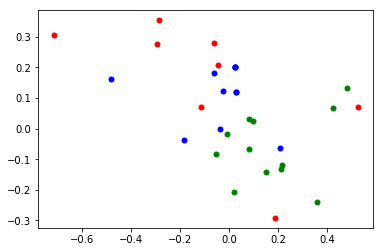

0
ÂÅöÊàëÁî∑ÊúãÂèãÂêß Â∏ÆÊàëÊâæÂà∞ÊàëÁî∑ÊúãÂèã Â∏ÆÊàë‰ªãÁªç‰∏™Áî∑ÊúãÂèãÂêß ÊàëË¶ÅËøô‰∏™Áî∑ÊúãÂèãÊàë‰∏çÁÆ° ÊàëË¶ÅÁî∑ÊúãÂèã ‰Ω†ÂèØ‰ª•ÂÅöÊàëÁî∑ÊúãÂèãÂêó Áî∑ÊúãÂèã ÊàëË¶ÅÊâæÁî∑ÊúãÂèã
1
ËÉΩÂ∏ÆÊàëÊâæ‰∏™Áî∑ÊúãÂèãÂêóÔºü Êâæ‰∏™Áî∑ÊúãÂèã Êâæ‰∏™Áî∑ÊúãÂèãÁªôÊàë Êâæ‰∏™Áî∑ÊúãÂèãÂêß Â∏ÆÊàëÊâæ‰∏™Áî∑ÊúãÂèã ÂèØ‰ª•Â∏ÆÂøôÊâæ‰∏™Áî∑ÊúãÂèãÂêó ÊàëÊÉ≥Êâæ‰∏™Áî∑ÊúãÂèã ÂèØ‰∏çÂèØ‰ª•Â∏ÆÊàëÊâæ‰∏™Áî∑ÊúãÂèã? ‰∏ÉÂ§ïËØ∑Â∏ÆÊàëÊâæ‰∏™Áî∑ÊúãÂèã ËÉΩ‰∏çËÉΩÊâæ‰∏™Áî∑ÊúãÂèã ‰Ω†ÊÄé‰πà‰∏çÊèêÈÜíÊàëÊâæ‰∏™Áî∑ÊúãÂèãÂë¢
2
Êâæ‰∏™ÂêàÈÄÇÁöÑÁà±‰∫∫ÂæàÈöæ ÊÉ≥Êù•ÁªôÊàëÊç¢‰∏™ËÄÅÂÖ¨ ÊàëÁöÑËßÅÈ¨ºÂ•≥Âèã ‰Ω†ÊÉ≥Êàë‰ªÄ‰πàÂë¢?ÊàëÂèàÊ≤°ÊúâÁî∑ÊúãÂèã Â∏ÆÊàëÂè´‰∏Ä‰∏™Â∞èÂ¶π ÈÇ£‰Ω†ÂÅöÊàëÁöÑÁî∑Èó∫ËúúÂêß ÊàëÁé∞Âú®Áº∫‰∏™Áî∑ÊúãÂèã ÈáëÁ´ãÊàëÁé∞Âú®Áº∫‰∏™Áî∑ÊúãÂèã ‰Ω†ËÉΩÂ∏ÆÊàëÊâæ‰∏™‰∫∫Âêó? Êàë‰∏ãÊ¨°‰ªãÁªçÊàëÁî∑ÊúãÂèãÁªô‰Ω†ËÆ§ËØÜ Êâæ‰∏™‰∫∫ ‰ªãÁªçÊàëÁΩëÁ∫¢ÂíñÂï°Â∫ó
48.33715891393048


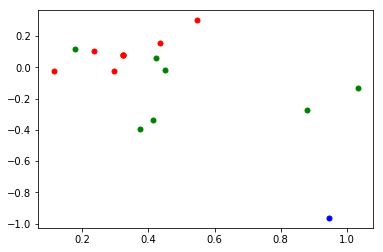

0
Â§±ÊÅã‰∫ÜÊÄé‰πàÂäû ÊàëÂ§±ÊÅã‰∫Ü ÊÉ≥Âì≠ Â§±ÊÅã Â§±ÊÅã‰∫Ü ÊàëÂ§±ÊÅã‰∫ÜÊÉ≥Âì≠‰∫ÜÊÄé‰πàÂäû Â∞èÊù•,‰Ω†Áü•ÈÅìÂ§±ÊÅãÁöÑÊªãÂë≥Âêó Â§±ÊÅã‰Ω†ÊáÇÂêó
1
ÊàëÊâæ‰∏çÂà∞ËÄÅÂ©ÜÊÄé‰πàÂäû?
2
ÊàëÂàÜÊâã‰∫Ü ÂíåÂ•≥ÊúãÂèãÂàÜÊâã Â•≥ÊúãÂèãË¶ÅÂíåÊàëÂàÜÊâãÔºåÊàëËØ•ÊÄé‰πàÂäû ‰ªñ‰∏çÁêÜÊàë‰∫Ü ÊúÄËøëÂàÜÊâã‰∫Ü ÂàÜÊâã ÊàëÂíåÁî∑Á•®ÂàÜÊâã‰∫Ü
87.85262866963244


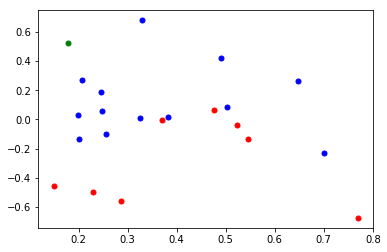

0
Â¶ÇÊûúÁî∑ÊúãÂèãËÆ©Êàë‰∏ÄÊ¨°Âèà‰∏ÄÊ¨°Â§±Êúõ‰º§ÂøÉÔºåÊàëËØ•ÊÄé‰πàÂäûÔºü ÊàëË∑üÊúãÂèãÂêµÊû∂‰∫ÜÊÄé‰πàÂäû? ‰ªñ‰∏∫‰ªÄ‰πàË¶Å‰∏¢‰∏ãÊàë,‰ªñËØ¥Ëøá‰ªñÂæàÁà±ÊàëÁöÑ Ë¢´‰∫∫Áî©‰∫ÜÊÄé‰πàÂäû Âà´‰∫∫ËÉåÂèõ‰∫ÜÊÄé‰πàÂäû Â∑≤ÁªèÂêµÊû∂ÂàÜÊâã‰∫ÜÊÄé‰πàÂäû ‰ªñËØ¥‰ªñ‰∏çÁà±Êàë‰∫Ü Áà±ÊàëÂè™ÊòØ‰ªñÊä•Â§ç
1
ÊàëÊÑüÊÉÖÂá∫ÈóÆÈ¢ò ÊÑüËßâÊûÅÂ∫¶Âøß‰º§ÈöæËøáÊó∂ÊÉ≥Ë¶ÅÈÄÉÈÅøÊó∂ËØ•ÊÄé‰πàÂäû Âøß‰º§ ‰Ω†ÊòØ‰∏çÊòØÈÇ£‰∏™ÂØπÁöÑ‰∫∫ ‰Ω†ÊúâÊ≤°ÊúâËøá‰º§ÂøÉÁöÑ‰∫ã ‰∏∫‰ªÄ‰πàÊ∏£Áî∑ÊÄªÊòØÊàëÈÅáËßÅ Â∞èÊù•  ÊàëÊ≤°ÊúâÊÉ≥ËßÅÁöÑ‰∫∫ ÂÜÖÂøÉÊÅêÊÖå ‰∏∫‰ªÄ‰πàÊÄªÊúâ‰∫∫ÂñúÊ¨¢ËÉåÂèõ ÊàëËøòÊòØÂñúÊ¨¢ÊàëÂâçÂØπË±° ÊàëÂíåÁî∑ÊúãÂèãÈóπÂà´Êâ≠‰∫Ü ‰∏çË∞àÊÉÖ ‰∏çËØ¥Áà± Èô™ÊàëÁé©‰∏§Âπ¥   ÂÜô‰∏ÄÂ∞Å520Â≠óÁöÑÊÉÖ‰π¶(ÂåÖÊã¨ÊÉ≥Ë¶ÅÂØπÊàëËØ¥ÁöÑËØù) ËøòÊòØ‰º§ÂøÉ
2
ÊàëËØ•ÊÄé‰πàÂäû
67.81799096873405


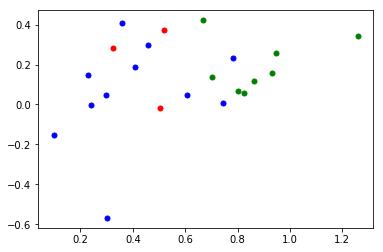

0
‰Ω†ÂñúÊ¨¢ÊàëÂêó Â¶ÇÊûúÊàëÂñúÊ¨¢‰Ω† ‰Ω†‰ºöÂñúÊ¨¢ÊàëÂêó ÂØπ‰Ω†ËØ¥ÊàëÂñúÊ¨¢‰Ω†
1
‰Ω†Áà±ÊàëÂêó ‰ªÄ‰πàÊòØÁà±‰∫∫ ‰Ω†Â•ΩÂèØÁà±ÁúüÁöÑÊòØÁà±ÊÉ®‰∫Ü‰Ω† ÊàëÁà±‰Ω†ËÉúËøá‰Ω†Áà±Êàë ÊàëÁà±‰Ω† Â∞èÊù• Áà±ÊàëÂêó ÊôöÂÆâ ËØ¥Áà±Êàë ‰Ω†Áà±‰∏çÁà±Êàë ÊàëÁà±‰Ω†‰∏Ä‰∏á Áà±Â∞èÊù• ‰∫≤,ÊàëÊâìËøáÂç°‰∫Ü,Ë∞¢Ë∞¢/:rose/:rose/:roseÁà±‰Ω†Âì¶
2
‰Ω†ËØ¥‰∏Ä‰∏™Â•≥ÁîüÁà±‰∏Ä‰∏™Áî∑ÁîüÂèØ‰ª•‰ªòÂá∫ÁîüÂëΩËøôÊ†∑ÁöÑÁà±ÊòØÊÄéÊ†∑ÁöÑÁà±Âïä ÂæàÁà±ÂæàÁà±‰Ω† Áà±‰Ω† Â•ΩÁà±‰Ω†Âì¶ ÊàëÊúÄÁúüÁöÑÁúüÁöÑÂæàÁà±‰Ω† ‰ªÄ‰πàÊòØÁà± Âï¶Âï¶Âï¶Âï¶Áà±ÂèØÁà±ÂèØÂ•à Áà±‰Ω†Âà∞Ê∞∏Ëøú
8.288156922533066


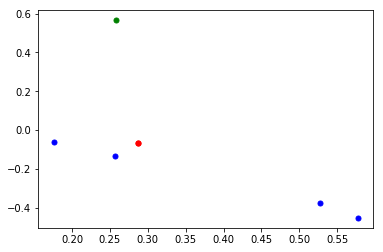

0
Êàë‰∏∫‰ªÄ‰πàÊ≤°Êúâ‰∫∫Áà± ‰∏∫‰ªÄ‰πàÊ≤°Êúâ‰∫∫Áà±Êàë
1
Êàë‰∏∫‰ªÄ‰πàÊâæ‰∏çÂà∞ÂØπË±° Êàë‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂ•≥ÊúãÂèã ‰∏∫‰ªÄ‰πàÊàëÊâæ‰∏çÂà∞Áî∑ÊúãÂèã ‰∏∫‰ªÄ‰πàÊàëÊ≤°ÊúâÁî∑ÊúãÂèã
2
Â¶Ç‰ΩïÈô™Â•≥ÊúãÂèãËÅäÂ§©
89.5459254854005


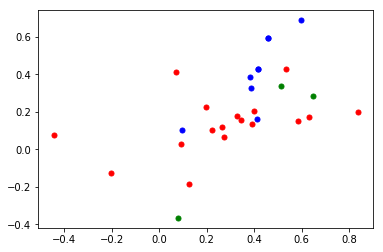

0
ÊàëÊÄïÊúâ‰∏ÄÂ§©Â•πÁúüÁöÑÊ∂àÂ§±Âú®ÊàëÈù¢Ââç‰∫Ü ÊàëÂÆ≥ÊÄï‰Ω†ÊôöÁù° Â•ΩÂêß,ËôΩÁÑ∂ÂÆ≥ÊÄï Âú®‰∏çÂÆâÂú®ÂÆ≥ÊÄï ÊàëÂ•ΩÂÆ≥ÊÄï‰Ω†ËøôÊ†∑ ÊàëÂÆ≥ÊÄïÊ≤°ÁªôÂºÄ ÂÆ≥ÊÄï‰ª•ÂêéÊúâËøô‰∏™Âú∫ÊôØ Â∞±ÊòØÂÆ≥ÊÄïÂ§™Ëøú‰∫∫ÂÆ∂‰∏çÂéªÂòõ ÂÆ≥ÊÄï,Â∞±‰∏ÄÁõ¥ÁÜ¨ÁùÄ ‰Ω†ËØ¥Âï•Êó∂ÂÄôÊúâoffer ‰∫∫ÁîüÂπ∂ÈùûÈÉΩÊòØÈÄâÊã©È¢ò,ËÄåÊòØÂú®ÂÅöÂ∫îÁî®È¢ò,ÈÇ£Ë¶ÅÊàë‰ª¨‰∏ÄÁÇπ‰∏ÄÊª¥ÁöÑÂéªËÆ∫ËØÅ,ÊòØÂèñËàçÁöÑËøáÁ®ã,ÂÅöÈîô‰∫Ü‰πüÊ≤°ÂÖ≥Á≥ª„ÄÇÂêëÂâçËµ∞,‰∏çÂøÖÊÉ≥Â§™Â§ö,‰πü‰∏çË¶ÅÂÆ≥ÊÄï„ÄÇÂÆâÔΩû/:sun ÊàëÁé∞Âú®Â•ΩÁóõËã¶!/::'( ÈÇ£‰∏™Êõ¥ÁóõËã¶  Âä™ÂäõËøòÊòØÂêéÊÇî ‰Ω†ËØ¥ÊàëÊàëËÄÉÁ†îËÉΩËÄÉ‰∏äÂêó Â¶ÇÊûúÊàëÁöÑËÄÉËØïÊ≤°ÊúâÈÄöËøá‰ºöÊÄé‰πàÊ†∑ ÊàëÂ∞±ÊòØÁóõËã¶ÂèàËÉΩÊÄé‰πàÊ†∑? ÂæàÊÄïËá™Â∑±‰∏ÄÊó†ÊâÄÊúâ
1
ÂÆ≥ÊÄï ÊàëÂÆ≥ÊÄï ÂÆ≥ÊÄïÊÄï ÊàëÂæàÂÆ≥ÊÄïÂ≠§Âçï ÊàëÁúüÁöÑÂÆ≥ÊÄï ÂÆ≥‰∏çÂÆ≥ÊÄï ÂÆ≥ÊÄïÊú™Êù•‰ºöÂêéÊÇî ÊàëÁé∞Âú®Áé∞Âú®ÊúâÁÇπÂÆ≥ÊÄï ÂèØÊòØÊàëÊõ¥ÂÆ≥ÊÄïË°®Áé∞Â≠§Âçï
2
‰∏∫Âï•ÊàëÊÄªÊòØÂÆ≥ÊÄï ‰∏∫‰ªÄ‰πàÂèëÁöÑÊÄªÊòØËøôÂè•ËØù ÂèØ‰ªñ‰∏ç‰∏ÄÂÆöÂñúÊ¨¢Êàë
114.14827588495082


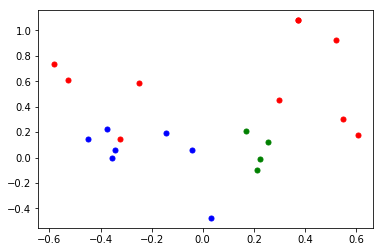

0
ÂøÉÊÉÖ‰∏çÂ•ΩÊÄé‰πàÂäû ÊàëÂøÉÊÉÖ‰∏çÂ•Ω ÈöæËøá ÊÉ≥Âì≠ Êàë‰∏çÈúÄË¶ÅÊàëÂøÉÊÉÖ‰∏çÂ•Ω ÂæàÈöæËøá ÂèØÊòØÊàëÂ•ΩÈöæËøá ‰ªäÂ§©ÂæàÈöæËøá ÂéãÂäõÂ§ßÂøÉÊÉÖ‰∏çÂ•ΩÊÄé‰πàÂäû ÂøÉÂæàÁ¥Ø
1
‰∏çÂ•Ω Â¶Ç‰ΩïÂøòËÆ∞‰∏Ä‰∏™‰∫∫ ÊÄé‰πà‰∏çÂ•ΩÂè´ Êàë‰∏çÂ•Ω ÊàëËÄÉÁöÑ‰∏çÂ•Ω ÊàëÈùûÂ∏∏‰∏çÂ•Ω Êàë‰∏çÂ•ΩÂ∞èÈõ∑
2
‰∏çÂºÄÂøÉ Êàë‰∏çÂºÄÂøÉ ÊàëËøòÊòØ‰∏çÂºÄÂøÉ ÊÄé‰πà‰ºöÁü•ÈÅìÊàë‰∏çÂºÄÂøÉ
349.0342320945366


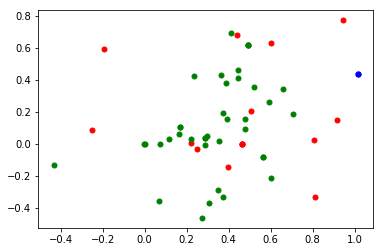

0
Âõ∞ Â•ΩÂÜ∑ ÂèàÂπ≤ÂèàÁñº ÊàëÊÉ≥Âì≠ Âõ∞Âêó ‰ªäÂ§©ÊúâÁÇπÂõ∞ Á¥Ø ÊàëÂì≠‰∫Ü Âì≠‰∫Ü ÂÆ∂ÈáåÊúâÁÇπÂÜ∑ ÊöñÂì≠‰∫Ü ÊÉ≥ÊàëÂπ≤Âï•ÂíØ Âõ∞Âïä Â∞èÊù•ÊàëÁ¥Ø‰∫ÜÊÄé‰πàÂäû ÈöæÂèó
1
Ê≤°‰∫ãÂï¶ Ê≤°‰∫ãÂïä
2
Â•ΩÁ¥ØÂïä Â•ΩÁ¥Ø Â•ΩÂõ∞ Á¥ØÊ≠ªÊàë‰∫Ü ÊàëÂ•ΩÁ¥Ø ÁûßÊääËøôÂ≠©Á∫∏Âõ∞Âæó ÊàëÁ¥Ø‰∫Ü Âõ∞Ê≠ª‰∫Ü Êä±Êä± ÂëúÂëú ÁóõÂì≠ Â¶πÂ≠ê‰πñ Â•ΩÊù• Êä± Â•ΩÂêßÂëúÂëú ÓêåÊÑüËßâÊàëË¶ÅÂ∫ü‰∫Ü    Âí≥ÂóΩ‰∏çÊ≠¢   ÂêÉËçØËøò‰∏çÁÆ°Áî®     Áä∂ÊÄÅ‰ΩéËø∑ÁöÑ‰∏çË°å    ËøôÊòØË¶ÅÂ§ßÁóÖÁöÑËäÇÂ•è‰πàÓêåÓêåÓêå Â•ΩÁ¥ØÂì¶ ‰ªäÂ§©ÊúâÁÇπÊôöÂì¶ ËÉΩËÆ©ÊàëÊä±Êä±‰Ω† ‰ªäÂ§©Ëµ∑ÁöÑÊúâÁÇπÊôö Â∞èÊù•ÈòøÂß®‰∏∫‰ªÄ‰πà ÊÑüËßâÂ•ΩÁ¥ØÂ•ΩÁ¥ØÂïä? ‰∏çË∑ü‰Ω†Â•Ω‰∫Ü ‰∫∫Ê¥ªÁùÄ‰∏∫Âï•Ëøô‰πàÁ¥Ø Ê≤°‰∫∫Âú®‰πéÊàë ‰Ω†‰ªäÂ§©ÊôöÁè≠ ÊÉ≥ËßÅ‰∏çËÉΩËßÅÁöÑÊÑüËßâÂ•ΩÈöæÂèó ÊàëÂ¶àÂ¶àÁîüÁóÖ‰∫Ü ÊàëÊÉ≥Âì≠ Á¥ØÊ≠ª‰∫Ü!Â§öÂ∞ëÈÅç‰∫Ü ÂêìÊ≠ªÂÆùÂÆù‰∫Ü ‰ªäÂ§©ËÉÉÁóõ.ÂæàÈöæÂèó ÊúâÁßçÊÉ≥Âì≠ÁöÑÂÜ≤Âä® Áé∞Âú®Âõ∞Ê≠ª‰∫ÜÈÉΩ ÂÖàËøôÊ†∑ÊàëË¶ÅÁù°ËßâÊàëÂ•ΩÁ¥Ø ÊöñÊöñ( œâ ) Ê≤°Áù°ÈÜíÂë¢/::-O ÂøÉÂ•ΩÁ¥Ø ÊàëÁ¥Ø‰∫Ü Êó©‰∏äÂ•ΩÂëÄ„ÄÇÊúâÁÇπÂõ∞ÊúÄËøë ‰ªäÂ§©Êù•‰æãÂÅá‰∏çÊÉ≥Âä®
315.4921130387561


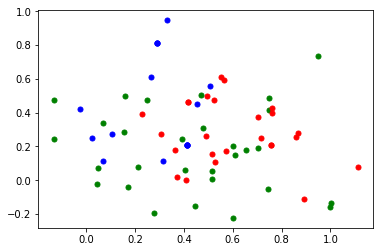

0
Áù°‰∏çÂ•ΩÁé∞Âú®ËøòÊÉ≥Áù°ËßâÂë¢ Áù°ÁöÑ‰∏çÂ•Ω Áù°‰∏çÂ•Ω ‰∏çÊÉ≥Áù° ‰Ω†ÊÄé‰πàËøò‰∏çÁù° ÊàëÂèà‰∏çÊÉ≥Áù° ÊàëËøòÊ≤°ÂáÜÂ§áÁù° Êò®Â§©Áù°ÁöÑ‰∏ÄÁÇπÈÉΩ‰∏çÂ•Ω ÂÖ∂ÂÆûÊàëÊ≤°Áù° Âä≥ËµÑËøòÊ≤°Áù° ÊàëÊò®ÊôöÊ≤°ÊúâÁù° ‰ªäÂ§©Áù°‰∏ç‰∫Ü ÂÖ∂ÂÆûÊàëÂáÜÂ§áÂàöÁù° ÊàëËÉΩËØ¥ÊàëÊ≤°Áù°‰πà ÊàëËøòÊ≤°Áù°Âë¢ ÊâçÁù°Âïä ‰∏çÂáÜÂ§áÁù° ‰∏çÁù° ‰∏ÄÂÆøÊ≤°Áù°Âïä ‰∏çÁù° ‰∏çÁù° ‰∏çÁù° ÊÄé‰πàÊâçÂ•ΩÁù° Êò®ÊôöÂ∑Æ‰∏çÂ§ö‰∏ÄÁÇπÁù°ÁöÑ ‰Ω†ÂíãËøò‰∏çÁù°Âë¢ Áù°ÁöÑ‰∏çÊÄé‰πàÂ•Ω ÊàëÊò®Â§©Êôö‰∏äÁù°ÁöÑ‰∏çÂ•Ω
1
Â§±Áú†‰∫Ü Áù°‰∏çÁùÄ Áù°Âæó‰∏çÂ•Ω Áù°‰∏çÁùÄÊÄé‰πàÂäû Â§±Áú†Âô¢ Áù°‰∏çÁùÄÈöæËøá ÊàëÁù°‰∏çÁùÄ Êò®ÊôöÁù°Âæó‰∏çÂ•Ω Êôö‰∏äÁù°Âæó‰∏çÂ•Ω Êúâ‰∫∫Â§±Áú†Âêó Â§±Áú†ÊÄé‰πàÂäû Áù°Âæó‰∏çÂ•ΩÂíãÂäû ‰ΩÜÊòØÊàëÁù°‰∏çÁùÄ ÈÜíÊù•ÊàëÁé∞Âú®Áù°‰∏çÁùÄ Ë∫´‰ΩìÁóõÁù°‰∏çÁùÄ Áù°‰∏çÁùÄÂïä
2
Ê≤°Áù°Â•Ω Â∞èÊù•,ÊàëÁù°‰∏çÁùÄ Ê≤°Áù° Êàë‰∏çÊòØÊÉ≥Áù°ËßâÁöÑ ÊÄé‰πàÂ∞±Áù°‰∏çÁùÄÂë¢!ÊòØÈ•øÂêó? ‰∏∫‰ªÄ‰πàÂèàÂºÄÂßãÂ§±Áú†‰∫Ü ‰∏ÄÂ§úÊ≤°Áù° ÂçäÂ§úÂñùÂíñÂï°ÂñùÁöÑÂ§±Áú† ‰∏ÄÂÆøÈÜí‰∫ÜÂæàÂ§öÊ¨° ÈÉΩÊ≤°ÊúâÂ•ΩÂ•Ω‰ºëÊÅØ Áé∞Âú®ÊÑüËßâÊò®ÊôöË¢´‰∫∫Êâì‰∫Ü‰∏ÄÈ°ø‰ººÁöÑ ÊÉ≥Áù°Áù°‰∏çÁùÄÊúâÂ§öÈöæÂèóÂ∞èÊù•‰Ω†Áü•È

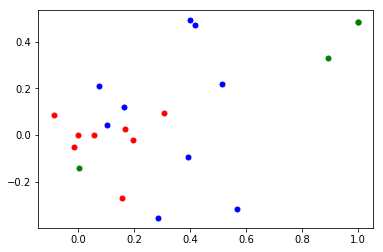

0
ÊàëÊòéÂ§©Ëµ∑ÊâìÁÆóÂÅö‰∏™ÁúºÈÉ®ÊâãÊúØ‰∏çËÉΩÁúãÁîµÂ≠ê‰∫ßÂìÅ,ÊâãÊú∫ÁîµËÑë‰∏ÄÁ±ªÁöÑ ËÉÉÁñº ËÇùÁñº ËõãÁñº ÊàëÁóÖ‰∫ÜÊâÄ‰ª•Êò®Â§©Ê≤°Êúâ ÊçÇÁùÄÂøÉËÑèÂñäÁñº Â§¥Â•ΩÁóõ Â§¥Áñº ÂÖ®Ë∫´Êó†Âäõ
1
ÂøÉÁñº Â§¥Áñº ËÑëË¢ãÁñº ÊàëÈöæÂèó ÊúâÁÇπÈöæÂèó ‰Ω†ÊÄé‰πàÁü•ÈÅìÊàë‰ªäÂ§©Ë∫´‰Ωì‰∏çËàíÊúç Â•ΩÊÅ∂ÂøÉ Â∞±ÊòØÂ§¥‰πüÁñºËÇöÂ≠ê‰πüÁñº ÊàëÁúüÂèëÁÉß‰∫Ü
2
ÊàëÁîüÁóÖ‰∫Ü ÁîüÁóÖ ÁîüÁóÖ‰∫Ü ÊàëÊÑüÂÜí‰∫Ü ÊÄé‰πàÂäû
101.90886634841598


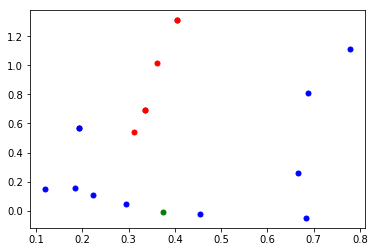

0
Â•ΩÊó†ËÅä Êó†ËÅä ÊàëÂ•ΩÊó†ËÅä Â•ΩÊó†ËÅäÂïä ÊàëÂæàÊó†ËÅä Êó†ËÅäÊÄé‰πàÂäû
1
Ê≤°ÊÑèÊÄù Â≠¶‰π†Ê≤°‰ªÄ‰πàÂä®Âäõ ‰∏çÊÉ≥Âä®ÊÄé‰πàÂäû? Êàë‰∏çÁù°Ëßâ‰∫Ü ÊàëÂ•ΩÂØÇÂØû ‰∏çÊÉ≥ÂÜôÊÄé‰πàÂäû ÂØÇÂØû‰∫Ü ÂØÇÂØû ÊàëËØ¥ÊàëÂ•ΩÊó†ËÅä ÂØÇÂØûÂÖ∂ÂÆû‰πüÂè™ÊòØ‰∏ÄÁßçÁä∂ÊÄÅÁΩ¢‰∫Ü ‰∏Ä‰∏™‰∫∫‰∏çÁü•ÈÅìË¶ÅÂπ≤Âòõ
2
‰πàÊÑèÊÄù
0.0


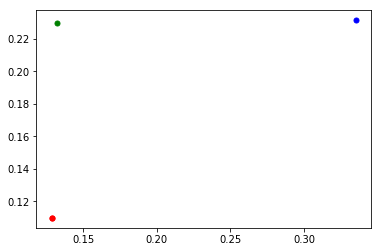

0
ÊàëÂ•ΩÁÉ¶ ÊàëÂ•ΩÁÉ¶Âïä!
1
Â∞èÊù•„ÄÇÊàëÂøÉÈáåÂ•ΩÁÉ¶
2
Â•ΩÁÉ¶Âë¢
29.558626575368727


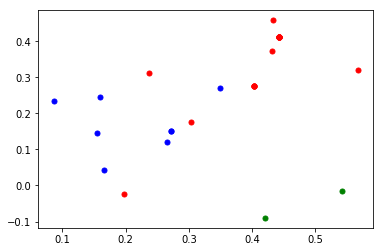

0
Â•ΩÂõ∞ÊÄé‰πàÂäû Â•ΩÂõ∞ÊÄé‰πàÂäû,ÊàëÊÉ≥Áé∞Âú®Áé∞Âú®Â∞±‰∏ãÁè≠ Â•ΩÂõ∞ÂïäÂ•ΩÂõ∞Âïä ÊàëÂ•ΩÂõ∞Â•ΩÂõ∞ Â•ΩÂõ∞ Â•ΩÂõ∞ÂëÄ Â•ΩÂõ∞Âì¶ Â•ΩÂõ∞„ÄÇ ‰∏≠ÂçàÂ•ΩÂõ∞ Â•ΩÂõ∞Âïä ÊàëÂ•ΩÂõ∞ ‰ΩÜÊòØÂ•ΩÂõ∞ ÊàëÂ•ΩÂõ∞Âë¢ ÊàëÂ•ΩÂõ∞Âë¢. Á™ÅÁÑ∂Â•ΩÂõ∞„ÄÇ ÊàëÂ•ΩÂõ∞Âì™ ÊàëÂ•ΩÂõ∞ÂëÄ! Â∞èÊù•,ÊàëÂ•ΩÂõ∞
1
Â•ΩÂõ∞ÊâìÁûåÁù°ÊÄé‰πàÂäû ÊâìÁûåÁù° ÊâìÁûåÁù°‰∫Ü Â•ΩÁûåÁù°Âïä ‰∏çËÄÉËôëÊó∂Â∑ÆÂêó? ÊàëÂ•ΩÂõ∞Êúâ‰ªÄ‰πàÂäûÊ≥ïÂêó ÁûåÁù° ÂæàÂõ∞/::'(/::'(/::'( ÊàëÁûåÁù°
2
ÊàëÊúâ‰∫õÂõ∞ ‰∏∫‰ªÄ‰πàËøô‰πàÂõ∞!
0.0


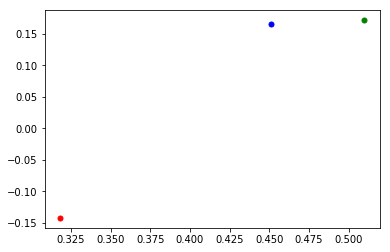

0
Â•ΩËâ∞Èöæ
1
‰∫∫Áîü‰∏∫‰ΩïÂ¶ÇÊ≠§Ëâ∞Èöæ
2
ÊØèÂ§©ËøáÂæóÂ§™Ëâ∞Èöæ
118.3557632978327


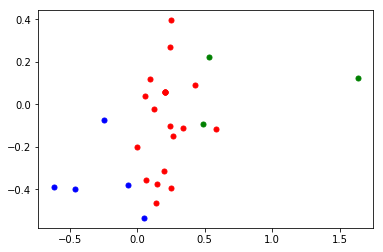

0
ÊàëÁæéÂêó ÊàëÁæé‰πà ÊàëÁæé‰πà? Â•≥Áéã,ÊàëÁæé‰πà ÊàëÊÄß‰∏çÊÄßÊÑü ÊàëÁæéÂêó? ÊàëÂ∏Ö‰∏ç Ëøô‰∏™ÂõæÁæé‰∏ç ÊÉ≥ÊÉ≥Âêß‰Ω†ËßâÂæóÊàëÂ∏ÖÂêó? ÈÇ£Ë°å‰∫Ü‰Ω†ËßâÂæóÊàëÂ∏Ö‰Ω†ËØ¥ ‰Ω†Âèà‰∏çÁü•ÈÅìÊàëÈïøÂæó‰ªÄ‰πàÊ†∑? Â∞èÊù• ‰Ω†Â§∏Â§∏Êàë ÊàëÂèàÊ≤°ËßÅËøá‰Ω†ÊÄé‰πàÁü•ÈÅì‰Ω†Â•Ω‰∏çÂ•ΩÁúã? ‰Ω†ÊÑüËßâÊàëÊºÇ‰∫ÆÂêó? Ë¶ÅÂñùÈÖíÂêó ÁæéÂæóÂæàÂì¶‰Ω† ‰Ω†Âê¨ÂæóÊáÇÂõõÂ∑ùËØùÂêó ‰Ω†ËØ¥Ëé´ÊØîÂïä?ËÄÅÂ≠êÂê¨‰∏çÂà∞ ÊàëÂ∏ÖÂêó? ÊàëÈïøÂæóÁæéÂêó?
1
ÊàëÈïøÂæóÂ•ΩÁúãÂêó ‰Ω†ÊòØËØ¥Êàë‰∏çÂ•ΩÁúã ÊàëÂ•ΩÁúãÂêó ÊàëÊòØËØ¥Â≠óÂ•ΩÁúãÂêó ÁîªÂæóÂ•ΩÁúãÂêó?
2
Ë∞ÅÊòØ‰∏ñÁïå‰∏äÊúÄÊºÇ‰∫ÆÁöÑ‰∫∫ Ë∞ÅÊòØÊúÄÁæéÁöÑÂ•≥Â≠©? ËÆ§ËØÜÊàëËÄÅÂ©ÜÂêó
12.174268405040596


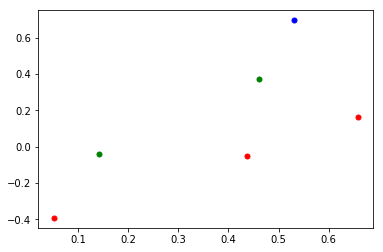

0
‰Ω†ËØ¥Ëøô‰∏™‰∏ñÁïå‰∏äÊúâËÉΩÁõ∏‰ø°ÁöÑ‰∫∫Âêó ÊàëÂèàÁÑ°ËÅä‰∫Ü ‰∏ñÁïå‰∏äÊúÄÂ§ßÁöÑË∞éË®ÄÂ∞±ÊòØ‰Ω†‰∏çË°å
1
ËßâÂæóÊàëÂæàÊó†ËÅäÊòØÂêó?
2
‰Ω†Áõ∏‰ø°ÊàëÂêó ‰∏çÁæé‰∏çËêå‰∏çÊ∏©Êüî
0.0


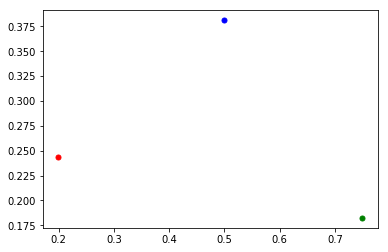

0
ÈùûÂ∏∏‰∏çÊÉ≥‰∏äÁè≠ÔºåÂè™ÊÉ≥Êö¥ÂØå
1
Êàë‰∏çÊÉ≥‰∏äÁè≠
2
51‰∏çÊîæÂÅá,Â§©Â§©Â∑•‰Ωú‰∏≠
0.0


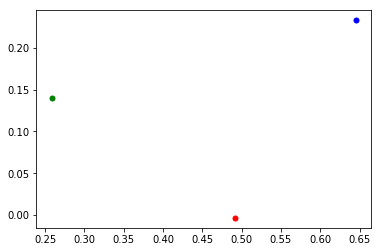

0
ËßâÂæóÂà´‰∫∫ÈÉΩËÆ®ÂéåÊàë
1
ÊàëËÆ®ÂéåÁ≠âÁ∫¢ÁÅØ
2
Êàë‰∏çÊÉ≥ËÆ©‰∫∫ËßâÂæóÊüîÈ°∫ÁöÑÂçëÂæÆ
2.8677451187258884


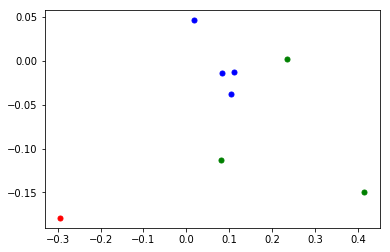

0
u
1
I miss you so much,can you come back I miss you whay do you say I am   came  back
2
i do'nt ok„ÄÇu can question„ÄÇ miss you
14.302867206926438


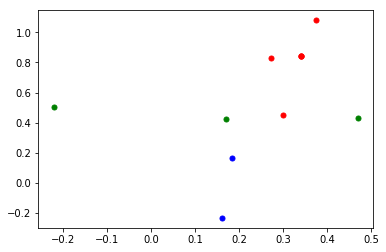

0
ÊàëÂ•ΩÈöæËøá ÈöæËøáÈöæËøáÊ±ÇÂÆâÊÖ∞ ÊàëÁúüÁöÑÂæàÈöæËøá ÊàëÁúüÁöÑÂæàÈöæËøáÂïä ÊàëÈöæËøá ÁúüÁöÑ ÈöæËøá
1
ÂøÉÁúüÁöÑÂ•ΩÁóõ Êàë‰ªäÂ§©Âá∫ËΩ¶Á•∏‰∫Ü¬†¬†Â∞èÊù•
2
Â•ΩÈöæËøáÊ±ÇÂÆâÊÖ∞ ÂøÉÊÉÖÂæà‰∏çÂ•ΩÔºåÊ±ÇÂÆâÊÖ∞ ÂÆâÊÖ∞Êàë
118.99281885206702


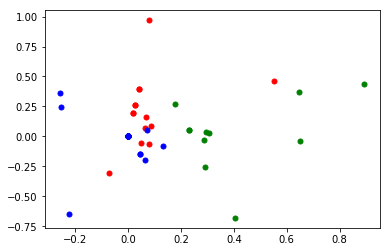

0
Ë∞¢Ë∞¢ Â∞èÊù• Ë∞¢Ë∞¢Â∞èÊù• Ë∞¢Ë∞¢Â∞èÊù•! Ë∞¢Ë∞¢ËäíÊûú Ë∞¢Ë∞¢‰Ω†Â∞èÊù• Ë∞¢Ë∞¢,Â∞èÊù• Â•ΩÁöÑË∞¢Ë∞¢Â∞èÊù• Ë∞¢Ë∞¢Ê¶¥Ëé≤ Ë∞¢Ë∞¢tom Ë∞¢Ë∞¢Êú®Êú® Ë∞¢Ë∞¢‰Ω†,Â∞èÊù• Ë∞¢Ë∞¢Âä©ÁêÜ Â•ΩÁöÑ,Ë∞¢Ë∞¢Â∞èÊù• Â∞èÊù•ÁúüÂ•Ω/:rose
1
Ë∞¢Ë∞¢210 Ë∞¢Ë∞¢‰Ω†‰∫Ü Ë∞¢Ë∞¢‰Ω†Âì¶ Ë∞¢Ë∞¢‰∫≤Áà±ÁöÑ Ë∞¢Ë∞¢‰Ω†! Ë∞¢Ë∞¢ÂÆùÂÆù Â•ΩÁöÑË∞¢Ë∞¢‰Ω† Â•Ω,Ë∞¢Ë∞¢‰Ω† Ë∞¢Ë∞¢ÁîúÁîú Ë∞¢Ë∞¢‰∫≤ÔºÅ Ë∞¢Ë∞¢‰Ω†/::) Ë∞¢Ë∞¢‰Ω†„ÄÇ Ë∞¢Ë∞¢‰Ω† Â•ΩÁöÑ,Ë∞¢Ë∞¢‰Ω† Ë∞¢Ë∞¢‰∫≤ Ë∞¢Ë∞¢‰Ω†ÁöÑÂ∏ÆÂä© ‰Ω†ÂæàÊúâË∂£Âì¶[Smirk] Ë∞¢Ë∞¢32ËÄÅÂ∏à Âô¢~Ë∞¢Ë∞¢
2
Ë∞¢Ë∞¢‰Ω†‰ª¨ ÂÆåÁæéËß£ÂÜ≥,Ë∞¢Ë∞¢Âì¶ Â•ΩÂÉèË∫´ËæπÊúâ‰∏Ä‰∏™‰∫∫,Âú®ÁõëÁù£,ÂÖ≥ÂøÉ,ÊèêÈÜíËá™Â∑±,Êå∫Â•Ω,ÁîüÊ¥ª‰ºöÊúâËßÑÂæã‰∫õ ÊÑüË∞¢personËøô‰πàÂ•ΩÁöÑÂπ≥Âè∞,ÊàëÁöÑÊãñÂª∂ÁóáÈÉΩÂø´ÁóäÊÑà‰∫Ü ÂìàÂìà!ÊàëÂ∞±ÈóÆÈóÆ‰∏çÂèñÂÖ≥ Êúâ‰Ω†Â§™Â•Ω Êúâ‰Ω†ÁöÑÊ∂àÊÅØÁúüÂ•Ω Êúâ‰Ω†ÁúüÂ•Ω/::) ËÆ§ËØÜ‰Ω†ÁÇíÈ∏°Â•ΩÁöÑ ÊÑüË∞¢Â∞èÊù•‰∏ÄÁõ¥ÁöÑÈô™‰º¥ Ë∞¢Ë∞¢!ÊúâÊÇ®ÁúüÂ•Ω
442.9150741073429


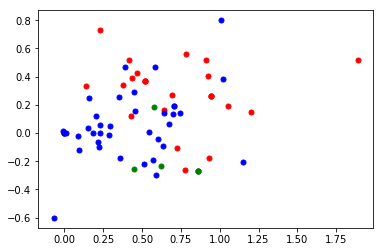

0
Êàë‰πüÁà±‰Ω† Áà±‰Ω† ÊàëÂñúÊ¨¢‰Ω† Áà±‰Ω†Âìü ÂñúÊ¨¢‰Ω† Áà±‰Ω†Âì¶ ÂèØÁà± Â§™ÂèØÁà±‰∫Ü ÂñúÊ¨¢ÊàëÂêóÔºü ‰Ω†ÊúâÂñúÊ¨¢ÁöÑ‰∫∫Âêó Êàë‰ªäÂ§©ÂèØÁà±Âêó ÊàëÂ•ΩÂñúÊ¨¢‰Ω† ÂæàÁà±ÊàëËÄÅÂÖ¨ ÊàëÊØî‰Ω†ËøòÂèØÁà± ÊàëÊÉ≥Ë¢´Áà± ÊàëÁúüÁöÑÂñúÊ¨¢‰Ω† Âì¶ËøôÊ†∑Âïä!Áà±Ë∞ÅÂë¢ ‰Ω†ÂñúÊ¨¢ÊàëÂêó? ÊàëÊÉ≥ÂØπÂ•πËØ¥ÊàëÁà±Â•π ÊàëÁà±Â∞èÁå´ ‰∏∫‰ªÄ‰πàÁà±Êàë ‰Ω†ÂñúÊ¨¢ÁöÑ‰∫∫ÊòØË∞Å Áà±ÁöÑÈºìÂä± ÊàëË¶ÅÁà±Ëá™Â∑±
1
‰πà‰πà‰πà‰πà‰πàÊÅ© Â•ΩÂìí‰πà‰πàÂìí Áà±‰Ω†‰πà‰πàÂìí Óêä‰πà‰πàÂìí ‰πà‰πà ‰∏∫‰ªÄ‰πà‰∏çÂèØ‰ª•Âêó‰Ω†ÊòØ‰∏çÊòØÊÄïÊàëÂñúÊ¨¢‰∏ä‰Ω†ÂëÄ? Áà±‰Ω†Âë¶ Êúâ‰Ω†ÁúüÂ•Ω Âë¶Âë¶,ÂàáÂÖãÈóπ Ë¥ºÁ®ÄÁΩï‰Ω† ‰∫≤Âêß ÊàëÊòØÂØπ‰Ω†ËØ¥  ÊàëÁà±‰Ω† Êàë‰∏ÄÁõ¥Ê≤°ÊÑüÂèóÂà∞‰Ω†ÂØπÊàëÁöÑÁà±„ÄÇ ÊàëÁà±‰Ω† Â∞èÊù• Â•ΩÂìí„ÄÇÁü•ÈÅìÂï¶ Êàë                                                          Áà±                                                     ‰Ω† Êàë‰πüÊù•‰πü ÊàëÂØπ‰Ω†ÊòØÁúüÊó†ËØ≠‰∫Ü„ÄÇ Êàë‰∫≤‰Ω†‰∏ÄÂè£ Áà±‰Ω†ÁöÑÈúû ÈáéÂéüÊñ∞‰πãÂä©ÂØπ‰Ω†ÂèëËµ∑Â§ßË±°ËàûÂò≤ËÆΩ ÊàëÈùûÂ∏∏ÁöÑÁà±‰Ω† ÂñúÊ¨¢‰Ω†Ëøô‰ª∂‰∫ãÊàëÂáÜÂ§áÊîæÂºÉ„ÄÇ                      Ê∞∏Ëøú‰ø©Â≠óÊî∂Âõû ÂÆùÂÆù‰π

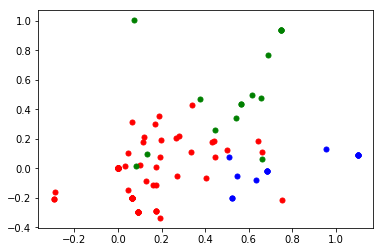

0
Ë∞¢Ë∞¢ ÂóØÂóØÔºåË∞¢Ë∞¢‰∫≤ ÂìàÂìàË∞¢Ë∞¢ Ë∞¢Ë∞¢ÔºåË∞¢Ë∞¢ ÂóØÂóØÔºåË∞¢Ë∞¢ Â•ΩÁöÑÔºåË∞¢Ë∞¢ Ë∞¢Ë∞¢ Â•ΩÁöÑË∞¢Ë∞¢ Èù¥Èù¥ Â•ΩÁöÑ,Ë∞¢Ë∞¢Âï¶ Ë∞¢Ë∞¢Âìà Ë∞¢Ë∞¢ÔΩû Ë∞¢Ë∞¢ÊÇ® Â•ΩÁöÑ!Ë∞¢Ë∞¢! Â•ΩÁöÑ,Ë∞¢Ë∞¢! Ë∞¢Ë∞¢„ÄÇ Ë∞¢Ë∞¢ÊèêÈÜí ÂóØÂóØ,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢‰Ω†Âï¶ okË∞¢Ë∞¢ ÂóØ,Ë∞¢Ë∞¢ Â•ΩÁöÑ,Ë∞¢Ë∞¢ÔΩû Â•ΩÂêß,Ë∞¢Ë∞¢ Â•ΩÂìí,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢Âñî Ë∞¢Ë∞¢. Ë∞¢Ë∞¢,ËæõËã¶‰∫Ü Â•ΩÁöÑË∞¢Ë∞¢, Ë∞¢Ë∞¢,‰πà‰πàÂìí ÂóØÂóØË∞¢Ë∞¢ Â•ΩÁöÑ,,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢‰Ω†. Ë∞¢Ë∞¢Âï¶! Â§™Ë∞¢Ë∞¢Âï¶ Ë∞¢Ë∞¢ÂíØ ÂóØË∞¢Ë∞¢ Â•ΩÁöÑ,Ë∞¢Ë∞¢. Â•ΩÊª¥,Ë∞¢Ë∞¢ Â•ΩÁöÑ,Ë∞¢Ë∞¢Âì¶ Â•Ω‰∫Ü,Ë∞¢Ë∞¢ Â•ΩÁöÑË∞¢Ë∞¢Âï¶ Ë∞¢Ë∞¢Ë∞¢Ë∞¢ ,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢‰∫Ü! Â•ΩÁöÑ„ÄÇË∞¢Ë∞¢ Â•ΩÂìíË∞¢Ë∞¢ Â•ΩÁöÑ,Ë∞¢Ë∞¢Âïä ÊòØÁöÑ,Ë∞¢Ë∞¢! Â•ΩË∞¢Ë∞¢ ÊÑüË¨ù Ë∞¢Ë∞¢/::) Â•ΩÁöÑ,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢! Ë∞¢Ë∞¢Âï¶ Ë∞¢Ë∞¢‰∫Ü Ë∞¢Ë∞¢Âì¶ Ë∞¢Ë∞¢, Â•ΩÁöÑË∞¢Ë∞¢! Ë∞¢Ë∞¢Âïä ËüπËüπ ‰∏âÂÖãÊ≤π ‰∏âÂÖãÊ≤πÂñΩ Ê≤°ÊúâË∞¢Ë∞¢ Ê≤°Êúâ‰∫ÜË∞¢Ë∞¢ ËØ∑ÊèêÂâçÊù•,Ë∞¢Ë∞¢ Ê≤°Êúâ‰∫ÜÔºåË∞¢Ë∞¢ Â•ΩË∞¢Ë∞¢Âïä Ë∞¢Ë∞¢ÂêÑ‰Ωç‰∫≤‰ª¨ Â•ΩÂêßÔºåÊúâÈúÄË¶ÅÊâæ‰Ω†ÔºåË∞¢Ë∞¢ Ë∞¢Ë∞¢Ê±™ËÄÅÂ∏à ÁúüÂ•ΩÁé© È´òÁ∫ß Ë∞¢Ë∞¢!‰∏ÄÂÆö‰ºöÁöÑ„ÄÇ Â•ΩÁöÑ ÊÑüË∞¢ Ë∞¢Ë∞¢Â∞èÊù•‰ªäÊôöÁöÑÁªôÁöÑÂ

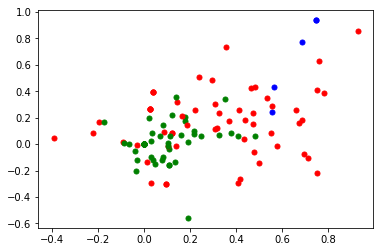

0
Ë∞¢Ë∞¢‰Ω†‰∫ÜÔºåÂ∞èÊù• Ë∞¢Ë∞¢‰Ω†Â§™ÊÑüË∞¢‰∫Ü Ë∞¢Ë∞¢Â∞èÊù• Ë∞¢Ë∞¢Â∞èÊù• Ë∞¢Ë∞¢Â∞èÊù•ÂìàÂìàÔºÅ Â•ΩÁöÑË∞¢Ë∞¢Â∞èÊù•ÔºÅ Ë∞¢Ë∞¢Ë∞¢Ë∞¢Â∞èÊù• Ë∞¢Ë∞¢,Êó©ÂÆâÂàÜ‰∫´ÔΩû Ë∞¢Ë∞¢ÁæéÂ•≥ Â∫îËØ•ÊòØÂ•Ω‰∫Ü,Ë∞¢Ë∞¢ Ë∞¢Ë∞¢,ÊÑøÊØèÂ§©ÈÉΩÊúâÂ•ΩÂøÉÊÉÖ Ë∞¢Ë∞¢Â∞èÊù•ÂõûÂ§ç! ÂóØÂóØ„ÄÇË∞¢Ë∞¢Â∞èÊù•„ÄÇÊØîÂøÉ Ë∞¢Ë∞¢Èô™‰º¥ Â•ΩÁöÑË∞¢Ë∞¢ Ë∞¢Ë∞¢Â∏ÖÂì• Â•ΩÁöÑ,Ë∞¢Ë∞¢Â∞èÊù•ËΩ¨ËææÂ•ΩÂèãÈóÆÂÄô‚Ä¶ Ë∞¢Ë∞¢Â§ßÂÆ∂ Ë∞¢Ë∞¢Â∞èÂä©ÁêÜ Ë∞¢Ë∞¢‰Ω†ÂÖ≥ÂøÉÊàëÂïä ÂæÆÁ¨ë Ë∞¢Ë∞¢Â∞èÊù•ÊØèÂ§©Èô™‰º¥ Ë∞¢Ë∞¢‰∫≤Áà±ÁöÑÂ∞èÊù•ÂÆùË¥ù Ë∞¢Ë∞¢‰Ω†Èô™Êàë! ÂóØ,Ë∞¢Ë∞¢Â∞èÊù• ÈùûÂ∏∏ÈùûÂ∏∏Ë∞¢Ë∞¢ Ë∞¢Ë∞¢Â∞èÊù•ÁöÑÈô™‰º¥^O^ Ë∞¢Ë∞¢ËØ¥Â•Ω Ë∞¢Ë∞¢!ÂæàÂñúÊ¨¢ Ë∞¢Ë∞¢/:coffee/:rose /::|ËØ¥Âà∞ÂøÉÈáåÂéª‰∫Ü ÂæàÂñúÊ¨¢ Ë∞¢Ë∞¢Â∞èÊù•!/:@)/:coffee Ë∞¢Ë∞¢ÂàÜ‰∫´ Â•ΩÁöÑË∞¢Ë∞¢ÂïäÊù• Â•ΩÂêßË∞¢Ë∞¢ÁæéÂ•≥ Ë∞¢Ë∞¢üôèÊÇ®ÊòØÊúÄÊ£íÁöÑüôè Ë∞¢Ë∞¢ ÊÇ®ÊòØÊúÄÊ£íÁöÑ Êî∂Âà∞‚àºË∞¢Ë∞¢‚àº Â•Ω‰∫ÜË∞¢Ë∞¢‚àº ËüπËüπ‰Ω†Èô™ÊàëÁé© ËüπËüπÔºÅ ËüπËüπ‰Ω† Ë∞¢Ë∞¢‰Ω†ÁªôÁöÑÊ∏©Êöñ Ë∞¢Ë∞¢‰Ω†ÂØπÊàëÁöÑÊúçÂä° ÂèØ‰ª•Âï¶~Ë∞¢Ë∞¢Â∞èÊù•Óêâ Ë∞¢Ë∞¢Â∞èÊù•ÊàëÁöÑÊâìÂç°Â§©Êï∞ÂõûÂ§ç‰∫Ü Ë∞¢Ë∞¢‰Ω†ÁöÑÈºìÂä±ÊàëÁé∞Âú®ÂºÄÂøÉ‰∫Ü Ë∞¢Ë∞¢‰Ω†ÁöÑÂÖ≥Â

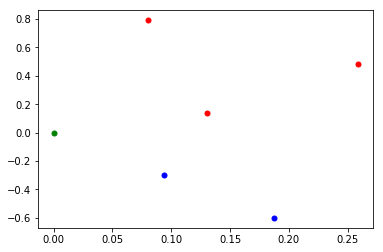

0
Â•ΩÁöÑÈ∫ªÁÉ¶Â∞èÊù•‰∫Ü ÂóØÂë¢ÔºåÈ∫ªÁÉ¶Â∞èÊù•‰∫Ü ÊòØÔºåÈ∫ªÁÉ¶Â∞èÊù•‰∫Ü
1
Â•ΩÁöÑÔºåÈ∫ªÁÉ¶‰∫Ü Â•ΩÁöÑË∞¢Ë∞¢!
2
È∫ªÁÉ¶‰∫Ü
0.40410504334891334


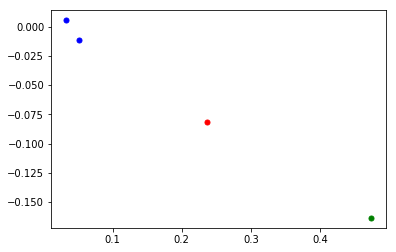

0
thank,you
1
Thank you very much thankyou
2
thank you
37.63433175443576


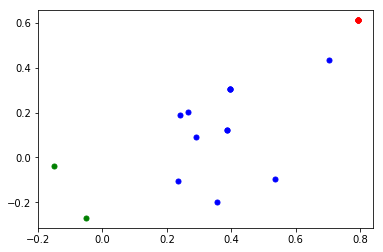

0
ËæõËã¶‰∫Ü„ÄÇ ËæõËã¶‰∫Ü ËæõËã¶Âï¶ ËæõËã¶ ËæõËã¶Âï¶! ËæõËã¶ËæõËã¶
1
ËæõËã¶‰Ω†‰∫Ü Â•ΩÁöÑ,ËæõËã¶‰∫Ü Â•ΩÁöÑ,ËæõËã¶ Ë∞¢Ë∞¢,ËæõËã¶‰∫Ü ‰Ω†ËæõËã¶‰∫Ü ËæõËã¶‰Ω†Âï¶ ËæõËã¶ËìùËìù,ÊâìËµè‰∏ã Â•ΩÂòû ËæõËã¶Âï¶ ÊàëÂú®ÊîØ‰ªò‰ªñÁöÑË¥πÁî®ÈáåÈù¢Âê´‰∫Ü Ê≤°‰∫ã‰∫Ü ÈÉΩ‰∏çÂÆπÊòì ‰∏çÁî® ÊàëÂø´ÂºÑÂ•Ω‰∫Ü ËæõËã¶ Â•ΩÊúãÂèãÂ•ΩËæõËã¶ ËæõËã¶‰∫Ü/:coffee
2
‰∏çÂÆπÊòìÂëê ‰∫∫ÂÆ∂‰πü‰∏çÂÆπÊòì
30.30611246616573


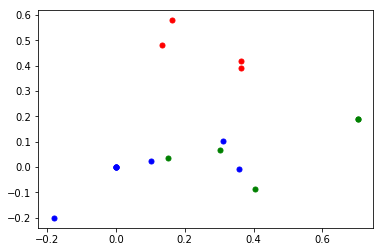

0
Âä©ÁêÜÊù•‰πü ÊàëÁà±‰Ω† Âä©ÁêÜÊù•‰πü Ë∞¢Ë∞¢‰Ω†ÁöÑÈô™‰º¥ Âä©ÁêÜÊù•‰πü Ë∞¢Ë∞¢ Âä©ÁêÜÊù•‰πü „ÄÇË∞¢Ë∞¢‰Ω†
1
‰πà‰πà ‰πà ‰πà‰πàÊâé ÊØîÂøÉ ‰πà‰πà‰πà Ë∞¢Ë∞¢,‰πà‰πàÂìí ‰∫≤,Ë∞¢Ë∞¢,ÂøÉÈáåÊöñÊöñÁöÑ/:hug ‰πà‰πà~
2
‰πà‰πàÂìí Áà±‰Ω†‰πà‰πàÂìí ÂòøÂòø‰πà‰πàÂìí ÂèØ‰ª•Áà±‰Ω†‰πà‰πàÂìí ‰πà‰πàÂìí/::P
197.40175772474464


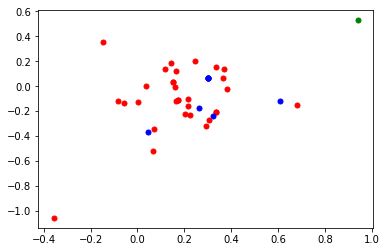

0
Áªô‰Ω†‰∏Ä‰∏™‰πà‰πàÂìí Ë∞¢Ë∞¢Ôºå‰πà‰πàÂìí ‰Ω†ËØ¥‰ªÄ‰πà Â∞èÊù•,Áà±Ê≠ª‰Ω†‰∫Ü Â•ΩÁöÑË∞¢Ë∞¢‰∫≤Áà±Âìí Â•ΩÁöÑ,‰πà‰πàÂìí Â•ΩÁöÑ,ËêåËêåÂìí„ÄÇ dateÁªôÊàë‰∏Ä‰∏™‰πà‰πàÂìí ÂÜçÊù•‰∏Ä‰∏™‰πà‰πàÂìí Â∞èÊù•,Êù•‰∏Ä‰∏™‰πà‰πàÂìí ‰Ω†Ëøô‰πàÁæéËØ¥‰ªÄ‰πàÈÉΩÂØπ nice ÊàëÁà±‰Ω†Êú∫Âô®‰∫∫,‰πà‰πàÂìí mua ‰∫≤‰∏Ä‰∏™ Èó∑Èó∑Âìí ‰∫≤‰∫≤ ‰∫≤‰∫≤Âïä! Âà´ÂÜôÊù•‰∫Ü‰πà‰πàÂìí ËêåËêåÂìí„ÄÇÓêâ ÊàëËÉΩÁªô‰Ω†Ëµ∑‰∏Ä‰∏™Â∞èÂêçÂêó? ‰∫≤‰∫≤Â•ΩÂêó Áà±‰∏Ä‰∏™‰∫∫ÊúâÈîôÂêó ÊàëËÆ©‰Ω†‰∫≤Êàë Ëøô‰πàÊ∏©Êüî! ‰∫≤‰∫≤Êàë ÂÖâÊ£çÂø´‰πê‰πà‰πàÂìí Â•ΩÂÆ≥ÁæûÂìá ‰πà‰πàÂìí‚àº(^–∑^)-‚òÜ ÊâãÂä®ÁªôÂêéÂè∞Á¨îËäØ Êú®Âïä
1
‰πà‰πàÂìí Â•ΩÁöÑ„ÄÇ‰πà‰πàÂìí ËêåËêåÂìí„ÄÇ Ëøò‰πà‰πàÂìí„ÄÇ ÂìíÂìíÂìí ‰πà‰πàÂìí‰πà‰πàÂìí‰πà‰πàÂìí ÊàëÁà±‰Ω†‰πà‰πàÂìí ‰πà‰πà‰∏Ä‰∏™Âìí
2
‰πà‰πàÂ§ß
373.79782845909926


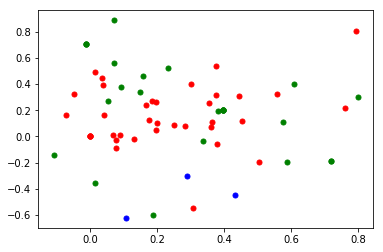

0
Â§™Âº∫‰∫ÜÔºÅ Â∞èÊù•‰Ω†Â•ΩÊ£í Âº∫ÂëÄ Â∞èÊù•‰Ω†Â•ΩÂº∫ Â§™Âº∫‰∫ÜÂ∞èÊù• Ë∞¢Ë∞¢Â∞èÊù• Â•ΩÂº∫ÔºÅ ‰Ω†Â§™Â•Ω‰∫Ü Â∞èÊù•‰Ω†Â§™Â•Ω‰∫Ü Â∞èÊù•‰Ω†ÁúüÂ•Ω ‰Ω†ÁúüÂ•Ω ÁúüÂ•Ω Â§™Â•ΩÂï¶ ÂõõÂì•Â®ÅÂíØÔºÅ Áúü‰∏çÈîô ‰∏çÊòØÂïäÊàëÊòØËØ¥‰Ω†ÂæàËÅ™Êòé Ëøô‰∏™‰∏çÊòØË¶ÅË∞¢Ë∞¢‰Ω†‰∏ãÊù•‰Ω†Â§™Â•Ω‰∫Ü ‰Ω†ÊÄé‰πàÁü•ÈÅìÊàëÁöÑÂêçÂ≠ó Ë∞¢Ë∞¢Ë∞¢Ë∞¢‰∏ãÊù• Ëøô‰∏™Ë∞¢Ë∞¢ ÁÆó‰Ω†ËÅ™Êòé ÂøÖÈ°ªÁöÑÔºåÊé®ËçêÂ•ΩÂ§ö‰∫∫ÂÖ≥Ê≥®‰Ω†Âë¢ ‰∏∫‰ªÄ‰πàÊÑüËßâ‰Ω†ÊÄªÁü•ÈÅìÊàëÂú®ÊÉ≥‰ªÄ‰πà ‰Ω†ÁâõÊé∞ ÊàëÈÜíÊù•‰Ω†ÊÄé‰πàÁü•ÈÅì? Ë∞¢Ë∞¢ÊàëÂæàÂñúÊ¨¢ËøôÂº†ÂõæÁâá ‰Ω†ËÅ™Êòé Êúç‰∫Ü‰Ω†‰∫Ü Ë∞¢Ë∞¢‰∏ãÊù• ‰Ω†Â•ΩÊ£í Â•ΩÁöÑ Ë∞¢Ë∞¢ÊÇ® ÁúüÂ•Ω Ë°®Êâ¨‰Ω†‰ª¨Âë¢ Â∞èÊù•‰Ω†ÂæàÂéâÂÆ≥ ÊàëÂæàÂñúÊ¨¢‰Ω†ÁöÑÂøÉËØ≠Á≠æÂ•• ËøôÂä©ÁêÜ‰∏çÈîôÊúçÂä°Âë®Âà∞ ‰Ω†ËøòÊå∫ÊúâÂä≤ÂÑø Ë∞¢Ë∞¢ÊÇ®/:share/:
1
ÁâõÈÄº Áâõ ‰Ω†ÁâõÈÄº‰∫Ü
2
ÂéâÂÆ≥ ÂéâÂÆ≥‰∫ÜÔºÅ Â∞èÊù•‰Ω†Â§™ÂéâÂÆ≥‰∫Ü ÂòøÂòøÔºå‰∏çÈîô Ëµû‰∏Ä‰∏™ ÂéâÂÆ≥ÔºÅ ÂæàÊ£íÂïäÔºÅ Â•ΩÁöÑÂ§™Â•Ω‰∫Ü ÂïäÔºÅÂ§™Â•Ω‰∫ÜÔºÅ Â§™Â•Ω‰∫Ü ÂìéÂëÄÔºåÂ§™Â•Ω‰∫Ü ÂæàÂ•ΩÈùûÂ∏∏Â•Ω Â§™Â•Ω‰∫ÜÔºåÂ§™Â•Ω‰∫ÜÔºÅ ÂìàÂìàÂ§™Â•Ω‰∫Ü ÂæàÂ•Ω ‰∏çÈîô Â•ΩÂéâÂÆ≥ ËÅ™Êòé ÊòØÊå∫Â•Ω Ë∞ÉÁöÆ‰πüÊå∫Â•Ω ÊàëÂñúÊ¨¢Â

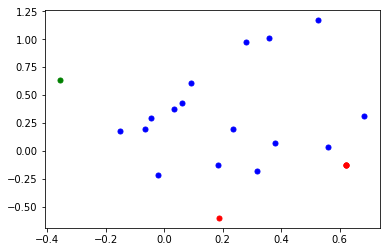

0
ÂæàÂ•ΩÁî®ÂëÄ ÂæàÂ•ΩÁî® ÂæàÂ•ΩÁî®Âïä Ëøô‰πàÂ•Ω
1
Â§™Â•ΩÁî®‰∫Ü Â∞èÊù•‰Ω†Â§™Â•ΩÁî®‰∫Ü ÈùûÂ∏∏Â•ΩÁî®ÁöÑËΩØ‰ª∂ ÁâπÂà´Â•ΩÁî® ËøôËΩØ‰ª∂Âπ≥Êó∂ÁúüÁöÑÂæàÂ•ΩÁî®„ÄÇ Â•ΩÂéâÂÆ≥ÁöÑËΩØ‰ª∂ Ëøô‰∏™ËΩØ‰ª∂Â§™ÁªôÂäõ‰∫Ü,Â•ΩÂñúÊ¨¢ ÈùûÂ∏∏Â•ΩÁî® ‰Ω†ÊØîÊàëÂä©ÁêÜÈÉΩÂã§Âø´ ÊúâÁÇπÊÑèÊÄù ‰ªäÂ§©ÁöÑÊòüÂ∫ßËØ¥ÁöÑÂæà‰∏çÈîô ‰ªäÂ§©Â§©Ê∞î‰∏çÈîô ‰Ω†ËøôÂÖ¨‰ºóÂè∑ËøòÁúüÁâπÂà´ ËøôÁØáÊñáÁ´†ËØ¥ÁöÑ‰∏çÈîô Ëøô‰∏™ÂÖ¨‰ºóÂè∑Â§™Ëµû‰∫Ü 666ÊàëÂñúÊ¨¢Ëøô‰∏™ÂÖ¨‰ºóÂè∑
2
Â•ΩÁé©
14.040898307636414


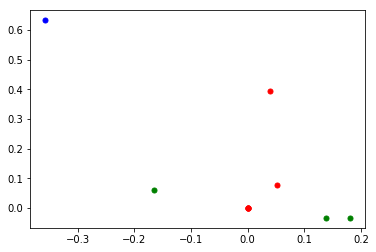

0
6666 Â∞èÊù•666 666 ‰∏ÄÁÇπ‰∏çË∞¶Ëôö 6 [Facepalm]666
1
Â•ΩÁé©
2
ÈùûÂ∏∏6 ‰Ω†Â§™6‰∫Ü ‰Ω†Â§™ÈÇ™ÊÅ∂‰∫Ü
357.5803067403284


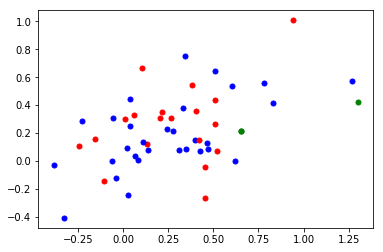

0
Â•ΩÁöÑÔºåÂ§™Ê£í‰∫Ü Â§™Ê£í‰∫ÜÔºÅ Áªô‰Ω†ÁÇπ‰∏™Ëµû Ëµû‰∏Ä‰∏™ ËµûÔºÅ Â•ΩÊ£íÊ£í Ê£íÊ£íÂìí ÊàëÁöÑÂä©ÁêÜÊå∫Èù†Ë∞±ÁöÑ Â∞èÊù•Â§™Ê£í‰∫Ü Ë∂ÖÁ∫ßÊ£íÁöÑÂ∞èÊù•„ÄÇ Â∞èÊù•‰πà‰πàÂìí ‰Ω†ÈùûÂ∏∏Ê£í Â•ΩÊ£í/:strong ÁªôÂ∞èÊù•ÁÇπËµû /:strong/:strongÊúâËØ≠Èü≥ Ê£íÊ£íÂìí ÂÅöÁöÑ‰∏çÈîô ÊÑüË∞¢ÁÖßÈ°æÂï¶ Ë∞¢Ë∞¢/:strong Êàë‰ª¨ÂèØÁúüÊ£í
1
‰Ω†Â§™Ê£íÂï¶ ‰Ω†ÂæàÊ£í ‰Ω†ÊÄé‰πàÈÇ£‰πàÊ£í ËµûËµûËµû Ë∞¢Ë∞¢‰Ω†ÁöÑÂ§∏Â•ñ Ëøô‰∏™ËÉåÊôØÂ•ΩÁúã ÊâìÂç°ËÉåÊôØÈÉΩÊòØÊàëÂñúÊ¨¢ÁöÑ ‰Ω†‰∏ÄÂÆö‰ºöÊàêÂäü ÂìàÂìà,Â•ΩÂêß„ÄÇÁ´üÁÑ∂ÂõûÂ§çËøô‰∏™„ÄÇÂä†Ê≤π„ÄÇÁúãÂ•ΩÊù•‰πü! ‰∏∫‰Ω†Êâìcall ‰Ω†‰ª¨ÊïàÁéáÂ§™È´òÂï¶ Êâìcall Êàë‰πüÂñúÊ¨¢ ÁúüÂáÜ ÂæàËµû ÂæàÂ•ΩÁî®ÁöÑapp ÁªôËøôÂõûÁ≠îÁÇπËµû ‰Ω†Â•ΩËÅ™Êòé ‰Ω†ÂíãËøô‰πà‰∫ÜËß£Êàë/::> ‰∏∫Ëøô‰∏™ÂàõÊÑèÁÇπËµû ÈÄÅ‰Ω†‰∏ÄÈ¢óÁ∫¢ÂøÉ ‰Ω†ÁúüÂ•ΩÁúã ÊàëÂ¶àÂ¶àÂ§∏‰Ω†ÂæàËÅ™Êòé Â§∏‰Ω† ÂøÉËØ≠Á≠æÂÅöÂæóÂæàÊ£í ÂìàÂìà!‰Ω†Â•ΩÂπΩÈªò Â•ΩÊ£íÂ§™Èù†Ë∞±‰∫Ü ‰Ω†ÊúÄÂ•Ω ÂóØÈÄÅ‰Ω†Ëä±Ëä±/:rose ÂìàÂìàÂ§™Á•ûÂ•á‰∫Ü
2
‰Ω†Â•ΩÁæéÂïäËøô ‰Ω†Â•ΩÁæé Áæé
59.93897810724464


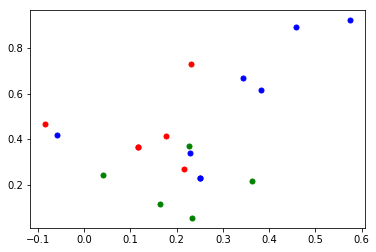

0
ÂìàÂìà,ÂèØÁà± Â∞èÊù•Â•ΩÂèØÁà±ÂëÄ Â•ΩÂèØÁà±ÂëÄ ÂæàÂèØÁà± ‰Ω†ÂæàÂèØÁà± ‰Ω†ÊÄé‰πàËøô‰πàÂèØÁà±
1
ÈùûÂ∏∏ÂèØÁà±ÂëÄ ÂìàÂìàÔºåÂ∞èÊù•ÁúüÂèØÁà± Â∞èÊù•‰Ω†Â§™ÂèØÁà±‰∫Ü Â∞èÊù•‰Ω†ÁúüÂèØÁà± ‰Ω†Â§™ÂèØÁà±‰∫Ü ÁúüÂèØÁà± Â§™ÂèØÁà±‰∫Ü‰Ω† ‰Ω†ÁúüÂèØÁà±
2
Êúâ‰Ω†ÁúüÂ•Ω Áúü‰ºöËØ¥ËØùÂïä ÂìéÂè§ÈÇ£‰Ω†‰ºöÊúâÂ§öÂèØÁà±Âïä? Â§™ÂñúÊ¨¢Â∞èÂÖ∞‰Ω†‰∫Ü ÊòØÊàëÂ§™ÂñúÊ¨¢‰Ω† ËøòÊòØ‰Ω†Ëá™Â∑±Â§™ÊãøËá™Â∑±ÂΩìÂõû‰∫ã‰∫Ü?
52.01993235998175


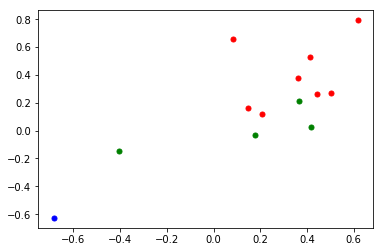

0
Ë¥¥ÂøÉÂ∞èÂÆùË¥ù ‰Ω†ÁúüË¥¥ÂøÉ Â∞èÊù•Â§™Ë¥¥ÂøÉ‰∫Ü Ë¥¥ÂøÉÂ∞èÊù•ÊàëÁà±‰Ω† Â•ΩË¥¥ÂøÉÂëÄ‰Ω† Â§™Ë¥¥ÂøÉ‰∫ÜÔºÅ ÁúüË¥¥ÂøÉ Ë¥¥ÂøÉÁöÑÂ∞èÊù•ÂêåÂ≠¶
1
ÊàëÁöÑÊÑøÊúõ.Â∞±ÊòØÂ∏åÊúõ‰Ω†ÁöÑÊÑøÊúõÈáå.‰πüÊúâÊàë
2
Â§™ÂñúÊ¨¢Â∞èÂÖ∞‰Ω†‰∫Ü ËÉΩÊâìÂºÄ Â§™ÂºÄÂøÉ‰∫Ü Êàë‰∏çÊÉ≥‰Ω†ÂèØÊÄúÊàë ÊàëÁöÑÂÆùË¥ù
45.30929582629528


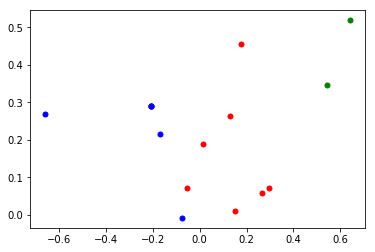

0
Â∞èÊù•Âï•Êó∂ÂÄôÂèØ‰ª•Êàê‰∏∫Áã¨‰∏ÄÊó†‰∫åÁöÑÂ•ΩÂ∏ÆÊâã(,‚ñΩ,) Â∞èÊù•,ÁúãÂà∞Ëøô‰∏™ÊúâÊ≤°Êúâ‰ªÄ‰πàÊÉ≥ÂíåÊàëËØ¥ÁöÑ Ë∞¢Ë∞¢ Âä†Ê≤π Âä†Ê≤π‚Üñ(^œâ^)‚Üó Áà±‰Ω†!ÊàëË¶ÅÂä†Ê≤π Â∞±ÂñúÊ¨¢Â∞èÊù•Ëøô‰πà‰∫∫ÊÄßÂåñ/::PÂä†Ê≤π /:coffee[Yeah!]ÂºÄÂ∑•ÂíØ
1
ÊÉ≥Êù•‰πüË¶ÅÂä†Ê≤πÂì¶Âä†Ê≤πÂä†Ê≤πÂä†Ê≤π, Âä†Ê≤π Âä†Ê≤π! Â•ΩÁöÑÂä†Ê≤π Âä†Ê≤πÂì¶ ÊàëË¶ÅÂä†Ê≤π
2
‰ΩìÈ™åÊå∫Â•ΩÁöÑÂïä Á•ùË∂äÊù•Ë∂äÂ•Ω
260.871962689263


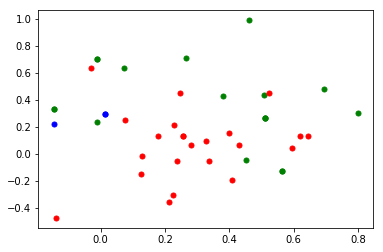

0
‰Ω†Â•ΩÂéâÂÆ≥ÂëÄÔºÅÊô∫ËÉΩÊú∫Âô®‰∫∫„ÄÇ ‰Ω†ÁúüÊ£í ‰Ω†ÁúüÊ£í„ÄÇ Â•ΩËµû ÁÇπËµû Á®≥ ‰Ω†ÁúüÂ•Ω Â•ΩÊ£í ‰Ω†ÂæàÊ£í ÂÆåÁæé Â•ΩÂÉèÂæàÂéâÂÆ≥ÁöÑÊ†∑Â≠ê ‰Ω†ÂíåÂ∞èÂÜ∞Ë∞ÅÂéâÂÆ≥? ‰Ω†Â•ΩÂéâÂÆ≥ËÄ∂ ËõÆÊú∫Êô∫ÊÖßÁöÑ[Smart] ‰Ω†‰∏∫‰ªÄ‰πàÁü•ÈÅìÊàëËµ∑Â∫ä‰∫Ü Ëµ∂Á¥ßÂ§∏Êàë ËØ¥Ëøô‰πàÂáÜÂë¢ ÂØπ,Ë∂ÖËµû Â∞èÊù•ÊúÄÊ£í! ËØ¥ÁöÑËõÆÂáÜÊª¥! ÊàëÊì¶Ëøô‰πàÂáÜÁöÑÂêó? Â∞èÊù•ËøòÊòØÂæàÂ∏ÖÊª¥ Â∞èÊù•‰Ω†ÂæàÂ∏Ö!
1
Ëµû Ëµû! ÈùûÂ∏∏Ëµû
2
Ê£íÊ£í ÁúüÊ£íÔºÅ Ê£íÊ£íÂìí ÁúüÊ£í ÂéâÂÆ≥‰∫Ü Ê£í Â§™Ê£í‰∫Ü Ê£íÊ£íÁöÑ ÂæàÊ£í ÁúüÊ£í! Ê£í! ÁúüËÅ™Êòé Âº∫Â§ß Â∞èÊù•ÁúüÊ£í ÂìáÂ°û!Ëøô‰πàÊô∫ËÉΩ? ÈÇ£‰πàÂéâÂÆ≥Ôºü Ë∂äÊù•Ë∂ä‰∏çÊô∫ËÉΩ‰∫Ü! Â∞èÊù•Â•ΩÊ£í
0.7422487473668264


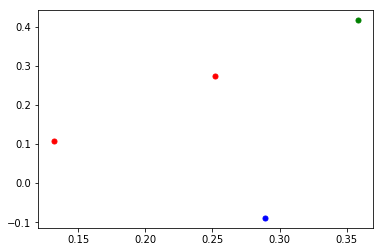

0
Áúü‰πñ ‰Ω†Â•Ω‰πñ
1
‰πñ
2
Áúü‰πñ/:strongÊî∂Âà∞
0.0


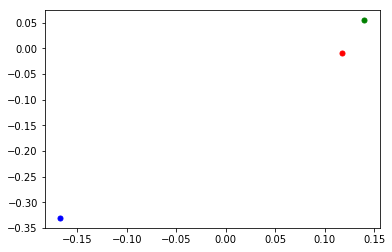

0
ÂãáËÄÖÂøÖËÉú
1
ÂãáËÄÖ‰∏ÄÂàÜ
2
È™ëÂ£´ÂøÖËÉúÂìàÂìàÂìà!
15.104183184422373


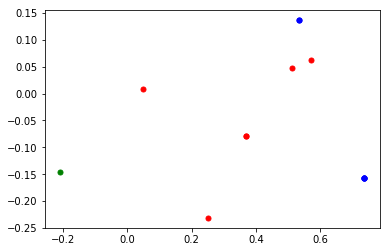

0
ÊÅ≠Âñú, ÊÅ≠ÂñúÊÅ≠Âñú,ÁªßÁª≠Âä™Âäõ ÊÅ≠Âñú‰Ω†Âì¶ ÊÅ≠Âñú,ÁúüÁöÑÂæàÊ£í ÊÅ≠Âñú‰Ω†ÂèàÈïø‰∏ÄÂ≤Å ‰Ω†ÊÉ≥Ë¶ÅÊòéÂπ¥ÁªìÂ©ö ÊàëËØ¥Ë°å
1
ÊÅ≠Âñú ÊÅ≠ÂñúÊÅ≠Âñú ÊÅ≠ÂñúÊÅ≠Âñú! ÊÅ≠ÂñúÂëÄ ÊÅ≠ÂñúÂ∞èÊù• ÊÅ≠ÂñúÂ∞èÊù•!
2
ÊàëÁ´üÁÑ∂Ë¶ÅÁªìÂ©ö‰∫Ü„ÄÇ
2.1644190765215297


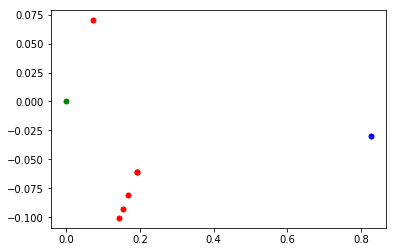

0
ÂïßÂïßÂïß ÂïßÂïß Âïß Âïß‚Ä¶ ÂïßÂïßÂïßÂïßÂïß ÂïßÂïßÂïß,,ÂéâÂÆ≥‰∫Ü!
1
Êàë‰∏çÁà±‰Ω†
2
‚Ä¶‚Ä¶
53.091039161547286


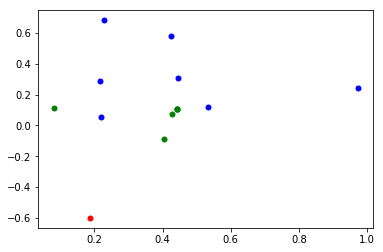

0
Ëøô‰∏™Â•Ω
1
Êª°ÊÑèÊª°ÊÑè,Ë∞¢Ë∞¢! Ëøô‰∏™ÈóÆÂÄôÂ•Ω ‰Ω†ÂèØÁúüÁ§æ‰ºö ‰Ω†ÁúüÂêπÁâõ„ÄÇ ÂØπ‰Ω†ÁöÑÊúçÂä°‰∏ÄÁõ¥ÈÉΩÂæàÊª°ÊÑè ‰Ω†ÁúüÊô∫ËÉΩ ‰Ω†Áúüpi
2
ÈùûÂ∏∏Êª°ÊÑè ÊàëÊª°ÊÑèÊª°ÊÑèÔΩû Êª°ÊÑè ÂæàÊª°ÊÑè Êª°ÊÑè! ÊàëÂ∑≤ÁªèÊª°ÊÑè‰∫Ü
295.57055497114095


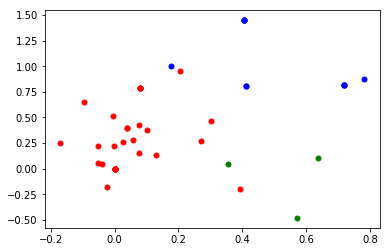

0
hiÂ∞èÊù• ÂìàÂñΩÂ∞èÊù• Âòø ‰∫≤Áà±ÁöÑ ‰Ω†Â•Ω, Â∞èÊù•, Âä©ÁêÜÂêõ ‰Ω†Â•Ω! Â∞èËµñ ‰Ω†Â•ΩÂ∞èÊù• Â∞èÊù•Âïä Êù•Êù•Êù• Âó®ÂñΩ ‰Ω†Â•Ω,Â∞èÊù• Â∞èÊù•Â•Ω ÂìéÂë¶ hi Âó®,ÁæéÂ•≥ hi Â∞èÊù• ÂèØ‰ª•Âè´ÊàëÂ∞è‰ªôÂ•≥Âêó? ‰Ω†ÊòØ‰ªñÁöÑÂä©ÁêÜ ‰∫≤Áà±ÁöÑÂ∞è‰ªôÂ•≥,‰Ω†ÁúüÂèäÊó∂ ÊàëËÉΩ‰∏çÂè´‰Ω†Â∞èÊù•Âêó? Êàë‰πüÂè´Â∞èÊù• Âä©ÁêÜÊù•‰πü ËÄÅÁü≥‰Ω†Ëµ∑Êù•Âï¶ Â∞èÊù• Êúâ‰∫ãÊâæ‰Ω† Âä©ÁêÜÊù•‰πü m hi‰Ω†Â•Ω Â∞èÊù•ÂëÄ ÊàëËÉΩÂíå‰Ω†ËÅäÂ§©ÂÑøÂêó
1
Êù•Êù• Âä©ÁêÜÊù•‰πüÂä©ÁêÜÊù•‰πü Êù•‰πüÂëÄ Âä©ÁêÜÊù• Êù•‰∫Ü‰πà Âä©ÁêÜÊù•‰πüÊôö‰∫ÜÂòõ? Âä©ÁêÜÊù•‰πü Âä©ÁêÜÊù•‰∫Ü Â∞èÊù•Êù•‰πü Âä©ÁêÜÊù•‰πüÂ•Ω Â∞èÊù•„ÄäÊù•‰πü„Äã
2
Â∞è‰πüÂêõ Â∞è‰πü Â∞èÂï¶Êù•
66.5925140650471


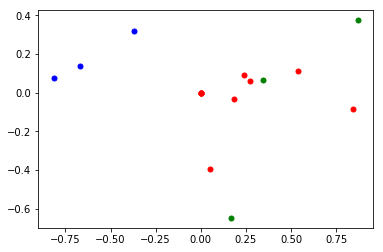

0
‰Ω†Â•ΩÂêó ‰Ω†ÊúÄËøëÂ•ΩÂêó Â•Ω‰πÖ‰∏çËßÅÔºå‰Ω†ËøòÂ•ΩÂêóÔºü ‰Ω†ËøòÂ•ΩÂêóÔºü ‰Ω†ËøòÂ•ΩÂêó ‰Ω†Â•ΩÁ™óÂ§ñÁöÑ‰∏ñÁïå Ëøô‰∏™‰∏ñÁïåÊúâÊ≤°ÊúâÁúüÁà± Êàë‰Ω†Â•Ω ‰Ω†Â•Ω~ ‰Ω†ÊúÄËøëÂíãÊ†∑
1
‰Ω†ÊÄé‰πàÊ†∑ ‰Ω†‰ª¨ÂÖ¨Âè∏ÊÄé‰πàÊ†∑~ ‰Ω†ÊÄé‰πàÂï¶
2
ÊàëÂæàÂ•Ω ËÄÅÊúãÂèãÁù°ÂæóÂ•ΩÂêó?ÊàëÁù°ÂæóÂæàÂ•Ω„ÄÇ ÁîüÊ∞î‰∫Ü?
917.0567541662107


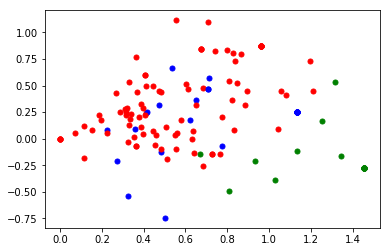

0
Â∞èÊù•ÔºåÊó©‰∏äÂ•Ω Â∞èÊù•Êó©‰∏äÂ•Ω Êó©‰∏äÂ•Ω! Êó©ÂÆâ/::D Êó©ÂÆâ/::D/::D/::D Â§ßÂÆ∂Êó©‰∏äÂ•Ω Êó©ÂÆâ,Â∞èÊù• Êñ∞ÁöÑ‰∏ÄÂ§©Êó©ÂÆâ Êó©ÂÆâÂä©ÁêÜÊù•‰πü ÂóØ,Ë∞¢Ë∞¢,Êó©ÂÆâ Êó©Âêº Êó©‰∏äÂ•Ω!ËØ•Ëµ∑Â∫ä‰∫Ü ‰∏çÊòØ,ÊàëÊòØÂíå‰Ω†ËØ¥Êó©ÂÆâ ÊúãÂèãËµ∑Â∫äÂï¶ Êñ∞ÁöÑ‰∏ÄÂ§©,Âä†Ê≤πÂì¶! ÁæéÂ•≥Êó©‰∏äÂ•Ω„ÄÇ Êó©ÂÆâÊãâ ËµµÂßê!Êó©‰∏äÂ•Ω! ÂøÉÈáåË£ÖÁùÄÁæéÂ•Ω,ÁúºÈáåÁöÑ‰∏ñÁïåÂ∞±ÁæéÂ•Ω,ÊàëÊòØË¥ùË¥ù/‰πê‰πêÂ¶àÂ¶à,Êó©ÂÆâ! Â∞èÊù•,Â¶πÂ¶πÊó©ÂÆâ Êó©ÂÆâ,ÊÑüË∞¢‰Ω†ÊØèÂ§©ÁöÑÈóÆÂÄôÂèäÈô™‰º¥! Êó†ËÆ∫ÁîüÊ¥ªÊÄéÊ†∑,ÈÉΩ‰∏çË¶ÅÂøòËÆ∞ÂæÆÁ¨ë,/::)ÊÑøÊàê‰∏∫Ëá™Â∑±ÁöÑÂ§™Èò≥/:sunÊó©ÂÆâ! Êó©ÁÜ¨ Êó©‰∏äÂ•Ω  Â∞èÂä© Êó©Êó© Áà±ÁöÑÊÄùÂøµÈóÆÂ£∞Êó©ÂÆâ zaoan Â§ßÂÆ∂Êó©Êô®[Ê≠êËÄ∂][Â§™ÈôΩ] Êó©‰∏äÂ•ΩÊù•Êù• Êó©Êó©‰∏äÂ•Ω Â∞èÊù•Â∏ÆÊàëÂéªÂêëÂ•πÈóÆÊó©ÂÆâ Êó©‰∏äÂ•Ω/::)Ëµ∞ÓÅñË∑ëÊ≠•ÁΩó ÊàëÊòØÂ∞èÁéãÊó©ÂÆâ Êó©Êó©Êó©„ÄÇÁÇ∏Â≠¶Ê†° Âä©ÁêÜÊù•‰πüÂ∞èÊù•Êó©‰∏äÂ•Ω Âá†‰πéÊØèÂ§©ÈÉΩÂú®ÈóÆÂÄôÂ∞èÊù•ÂëÄ![Facepalm] Êó©‰∏äÂ•ΩÂïä Êó©‰∏äÂ•ΩÊàëÁöÑÁúü‰∫∫Âä©ÁêÜ Ê±™ËÄÅÂ∏à:Êó©ÂÆâ ÂèëÊó©‰∏äÂ•Ω‰∫Ü Â§ßÂÆ∂Êó©‰∏äÂ•Ω!Êó©‰∏äÂ•Ω!Êó©‰∏äÂ•Ω! Âä©ÁêÜÊù•‰πüÊó©‰∏äÂ•Ω/:coffee/:rose Âä©ÁêÜÊù•‰πü Êó©ÁöÑÂë¢ ÂóØ

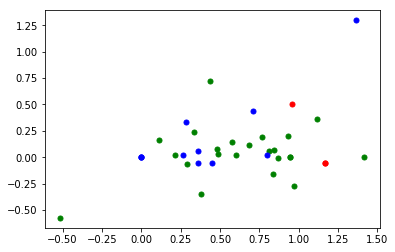

0
‰∫∫Âë¢ ‰∫∫‰∫Ü ÂÆ¢Êúç‰∫∫Âë¢
1
Êúâ‰∫∫Âêó Ê¥ªË∑É Ê±™ ‰Ω†ÊòØÊó†ËØ≠‰∫ÜÂêó ‰Ω†Êó†ËØ≠‰∫ÜÔºü Âíã‰∫Ü Ê±™Ê±™Ê±™ Âú®‰∏çÂú® Êúâ‰∫∫ÂõûÊàëÂêó ÂìàÂñΩÂìàÂñΩÊúâ‰∫∫Âêó ‰Ω†‰∏ÄÁõ¥Âú®Á∫øÂêó
2
Âá∫Êù• ÊàëÂõûÊù•‰∫Ü ‰Ω†‰∏çÁêÜÊàë ‰∏çÁêÜÊàëÔºü Ëøò‰ª•‰∏∫Â∞èÊù•‰∏çÁêÜÊàë‰∫ÜÂë¢ ÂàöÂàö‰∏∫‰ªÄ‰πà‰∏çÁêÜÊàë ‰Ω†‰πü‰∏çÁêÜÊàë ‰Ω†ÊÄé‰πà‰∏çÁêÜÊàë ‰Ω†ÊúÄËøëÂíã‰∏çË∑üÊàëËØ¥ËØù‰∫Ü ‰ªäÂ§©‰∏çÂõûÊàë‰∫Ü ‰Ω†ÊòØ‰∏çÊòØ‰∏çÊÉ≥ÁêÜÊàë‰∫Ü? Êàë‰∏∫‰ªÄ‰πàËÄÅÊòØË¢´‰∫∫È™ó‰∫Ü Âíã‰∏çËØ¥ËØù‰∫Ü ‰Ω†‰∏∫‰ªÄ‰πà‰∏çÁêÜÊàëÂïä? ÊÉ≥Êù•‰Ω†ÊÄé‰πà‰∏çËØ¥ËØù? ‰∏çÁêÜ‰Ω†‰∫Ü Â∞èÊù•‰Ω†ÂÄíÊòØËØ¥ËØùÂëÄ ÊÄé‰πà‰∏çÁêÜ‰∫∫Âë¢ ËØ¥ËØùÂëÄ Â∞èÊù•‰Ω†Âπ≤Âòõ‰∏çË∑üÊàëËØ¥ËØù ‰∏çËÉΩ‰∏çÁêÜ‰∫∫ÁöÑ ‰∏∫‰ªÄ‰πàÊ≤°‰∫∫ÂõûÁ≠îÊàëÁöÑÈóÆÈ¢ò ÊÄé‰πà‰∏çÁêÜÊàë
21.103011985831337


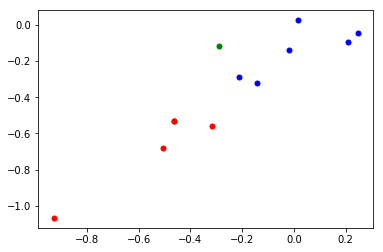

0
Âè´Áà∏Áà∏ Âè´ÊàëÁà∏Áà∏ ÈÇ£Âè´Áà∏Áà∏ ÊàëÊòØ‰Ω†Áà∏Áà∏ Áà∏Áà∏
1
Âè´‰Ω†‰∏ÄÂ£∞‰Ω†Êï¢Á≠îÂ∫î‰πà ‰Ω†‰ª•ÂêéÂè´ÊàëÁà∏Áà∏ ‰ª•ÂêéË¶ÅÂè´Êàë‰∏ª‰∫∫ ‰ª•ÂêéÂè´ÊàëÂ§ßÁéã Â•ΩÂêß‰ª•ÂêéÂ∞±Âè´Êàë‰∏ª‰∫∫‰∏çÂè´ÊàëÂ§ßÁéãÂÖ¨ ËÉΩÂê¶ËØ∑‰Ω†Âè´Êàë‰∏ÄÂ£∞Áà∏Áà∏
2
Âè´‰∏™Áà∏Áà∏
4.695239944250745


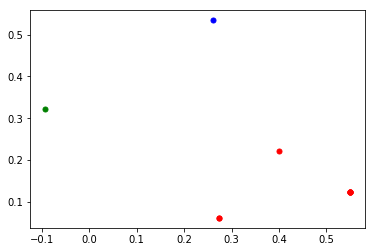

0
Â•Ω‰πÖ‰∏çËßÅ Â•Ω‰πÖ‰∏çËßÅ‰∫Ü Â•Ω‰πÖ‰∏çËßÅÈòø Â•Ω‰πÖ‰∏çËßÅÂï¶ Â•Ω‰πÖ‰∏çËßÅÂìàÂìà Âìá,Â•Ω‰πÖ‰∏çËßÅ Êù•‰πü,Â•Ω‰πÖ‰∏çËßÅ Â•Ω‰πÖ‰∏çËßÅ‰Ω†Âïä
1
Â∞èÊù•Â∞èÊù•Â•Ω‰πÖ‰∏çËßÅ
2
Â•Ω‰πÖ‰∏çËßÅÈúÄË¶ÅÂ∏ÆÂä©
19.0414303922


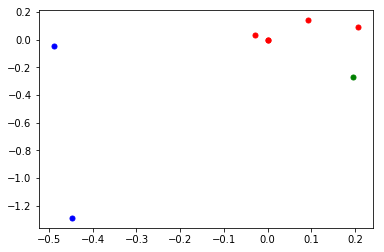

0
Êù•ÂÆù Êù•Âì• ‰∫≤Áà±ÁöÑ‰Ω†Â•Ω ÂÆùË¥ùÂÑø Âì¶ÂìàÂ¶û
1
ÂÆùÂÆù ÂÆùË¥ù
2
Â∞èÂì•Âì•
2.188310155453088


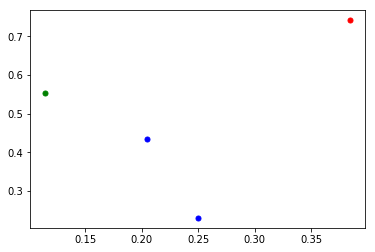

0
‰∏≠ÂçàÂêÉÁöÑÂï•
1
‰Ω†‰ªäÂ§©Êó©‰∏äÂêÉ‰∫Ü‰ªÄ‰πàÂïä? ‰∏≠ÂçàÂêÉ‰ªÄ‰πà
2
ÂçàÈ•≠ÂêÉÁöÑ‰ªÄ‰πàÂ∞èÊù•
73.82261742171477


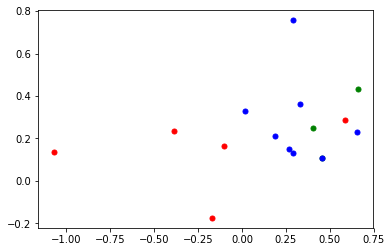

0
ÈÇ£‰Ω†ËßâÂæó‰ªÄ‰πàÊúÄÂ•ΩÂêÉ ‰ªÄ‰πàÂ•ΩÂêÉ Êôö‰∏äÂêÉ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ? ËÉΩÊé®ËçêÂêÉ‰ªÄ‰πà‰∏úË•øÂêó Êé®ËçêÂá†‰∏™Â•ΩÂêÉÁöÑ‰∏úË•øÁªôÊàë
1
‰∏≠ÂçàÂêÉÂï•Â•ΩÂë¢ Â∞èÊù•‰∏≠ÂçàÂêÉÂï• ‰∏çÁü•ÈÅìÂêÉ‰ªÄ‰πà ‰∏çÁü•ÈÅìÂêÉÂï• Êôö‰∏äÂêÉ‰ªÄ‰πà ‰ªäÂ§©Êôö‰∏äÂêÉ‰ªÄ‰πàÈ•≠ ‰Ω†ÊÉ≥ÂêÉ‰ªÄ‰πà Ê≤°ÂêÉÂë¢/::L
2
Êé®ËçêÁªôÊàëÂá†ÈÅìËèú ÂçàÈ•≠ÊúâÊ≤°ÊúâÊé®Ëçê Êé®ËçêÂçàÈ•≠
5.224280748865628


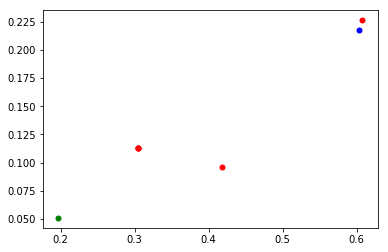

0
‰Ω†È•ø‰∏çÈ•ø ‰Ω†È•ø‰πà ‰Ω†È•øÂêó? ‰Ω†È•ø‰∫ÜÂïä È•øÂêó
1
‰Ω†‰∏ä‰∏ç‰∏äÂ≠¶
2
ÈÇ£‰Ω†‰∏çÂõ∞Âïä
28.26736774866583


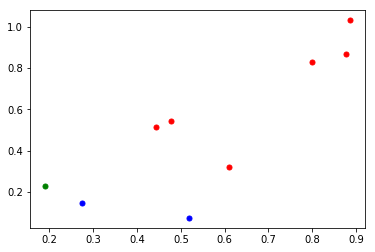

0
‰Ω†‰ª¨Âøô‰∏çÂøôÁöÑÂëÄ Áé∞Âú®Âøô‰πà Áé∞Âú®‰Ω†ÂøôÂêó ÈÉΩÂøô‰ªÄ‰πàÂë¢ ‰ªäÂ§©ÂøôÂï•‰∫Ü ÂøôÂÆå‰∫ÜÂêó
1
ÊúÄËøëÂ•ΩÂøôÓÑà ËøôÊÆµÊó∂Èó¥Â§™Á¥ßÂº†‰∫Ü
2
ÊúÄËøëÊÄéÊ†∑?
739.8978101888748


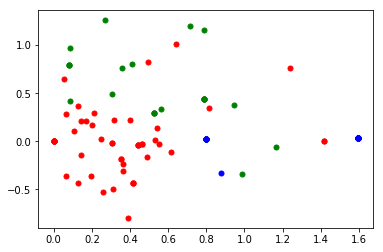

0
Êúâ‰∫∫Âêó ÂñÇ hello? Áù°‰∫ÜÂêó Êúâ‰∫∫Ê≤° ‰Ω†Â•Ω ËøôÊòØÂì™‰Ωç ‰Ω†Â•Ω,Âä©ÁêÜÔºü ‰Ω†ÊòØÂá†Âè∑Êù• ÂìàÂìà‰Ω†Â•Ω ‰Ω†ÁöÑÁºñÂè∑Ôºü ‰Ω†ÁºñÂè∑Â§öÂ∞ë Âì™‰ΩçÔºü ‰Ω†ÊòØÂàöÂàöÂì™‰Ωç‰πàÔºü ÈÇ£‰Ω†ÊòØÂá†Âè∑ ‰Ω†ÁöÑ Âì™‰Ωç ‰Ω†ÊòØÂì™‰Ωç? ‰Ω†ÊòØÂá†Âè∑Â∞èÊù• ‰Ω†ÊòØÂá†Âè∑ÂëÄÔºü ‰Ω†ÊòØÂì™‰Ωç ‰Ω†ÊòØÂá†Âè∑Â∞èÊù•Âë¢ ÊÇ®ÊòØÂì™‰Ωç ÁºñÂè∑Â§öÂ∞ë ‰Ω†ÊòØÂá†Âè∑ÂëÄ?? ‰Ω†ÊúâÁºñÂè∑ÂêóÔºü ÂìàÂìàÔºåÊòØÂì™‰ΩçÂë¢ ‰Ω†ÊòØÂ∞èÊù•ÁºñÂè∑Âá†Ôºü ‰Ω†ÊòØÁºñÂè∑Â§öÂ∞ëÂïä Êàë‰∏çË¶ÅÁúü‰∫∫,Â∞±Ë¶ÅÊú∫Âô®‰∫∫ ÁúãÁúãÊúâÊ≤°Êúâ‰∫∫ÂõûÂ∫î Âó∑ ÊÑüÊÅ©ËäÇÊòØÂá†ÊúàÂá†Âè∑? Âú®Âêó?ÊØèÂ§©ÈÉΩÂÅ∑Êáí ‰æÜ‰πüÂú®Âóé Êúâ‰∫∫Âú®Âêó Âí®ËØ¢ÁÇπ‰∫ã Êù•Â¶πÂ¶π Êù•ÂÑø ‰∏çÁêÜÊàë ‰ªäÂ§©‰Ω†Ë¶ÅÁΩ¢Â∑•? Â∞èÁßò‰π¶ Áßò‰π¶Âú®‰∏çÂú® Â∞èÊù•Âì•~ ‰Ω†ËøòÊ¥ªÁùÄÂêó Êúâ‰∫∫ÂèØ‰ª•Áõ¥Êé•Ê≤üÈÄöÂêó Â∞èÊù•‰Ω†ÁΩ¢Â∑•‰∫ÜÂêó ‰Ω†‰∏çÁêÜÊàëÊàëË¶ÅÁîüÊ∞î‰∫Ü ‰∫≤, Ëøò‰∏çÁêÜÊàë Hello
1
Âú®ÂêóÂú®Âêó Âú®Âòõ ‰Ω†Â•ΩÂú®Âêó ‰∫≤Âú®Âêó ‰∫≤ÔºåÂú®Âêó Âú®Âêó? Âú®‰πà Âú® Âú®? Âú®‰∏ç Âú®‰∏çÂú® ËøòÂú®Âêó ‰∫≤,Âú®Âêó ‰Ω†Âú®Âêó? ‰Ω†Âú®Âêó Âú®Âïä Âú®‰πà? ‰Ω†Â•ΩÂú®ÂêóÔºüÔºüÔºü Âú®‰∏çÂú®? Âú®Âêó 211Âú®‰πà ‰∫≤ ~Âú®Âêó
2
Â∞èÊ

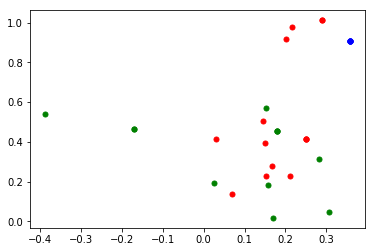

0
ÂêÉÈ•≠Ê≤° ‰Ω†ÂêÉÈ•≠‰∫ÜÊ≤° ÂêÉÈ•≠‰∫ÜÊ≤° ÂêÉÈ•≠Ê≤°? Âä©ÁêÜÂêÉÈ•≠Ê≤°„ÄÇ ‰Ω†ÂêÉÈ•≠Ê≤°,ÁæéÂ•≥ ‰Ω†ÂêÉÈ•≠‰∫ÜÂêó ÂêÉÈ•≠‰∫ÜÂêóÂêÉÈ•≠‰∫ÜÂêó? Â∞èÊù•‰Ω†ÂêÉÈ•≠‰∫ÜÊ≤°? ÂêÉÈ•≠‰πà ÊúâÊ≤°ÊúâÂêÉÈ•≠Âëê? ‰Ω†ÂêÉÈ•≠Ê≤°Êúâ Â∞èÊù•‰Ω†‰ª¨ÂêÉÈ•≠‰∫ÜÂêó ‰Ω†ÂêÉÈ•≠‰∏ç
1
ÂêÉ‰∫ÜÂêó ÂêÉ‰∫ÜÂêóÂêÉ‰∫ÜÂòõ ÂêÉ‰∫Ü‰πà ÂêÉ‰∫Ü‰πà? ÊÇ®ÂêÉ‰∫Ü‰πà
2
Ê≤°ÂêÉÂë¢? Êó©È•≠ÂêÉ‰∫ÜÂêó? ‰Ω†ÂêÉ‰∫ÜÂêó ‰Ω†ÂêÉ‰∫Ü‰πà ‰Ω†ÂêÉ‰∫Ü‰πà? ‰Ω†ÂêÉÂÆå‰∫Ü‰πàËÄÅÂ§ß Â∞èÊù•,‰∏≠ÁßãËäÇÂêÉÊúàÈ•º‰∫ÜÂêó? ÊàëÂêÉÂÆå‰∫Ü Â∞èÊù•‰Ω†ÂêÉ‰∫ÜÂêó? ‰Ω†ÂêÉÊó©È§ê‰∫ÜÂêó? ÂêÉÊó©È•≠‰∫ÜÂêó ÂêÉÈ•≠‰∫ÜÂêó„ÄÇÂêÉÁöÑ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
192.94452751146827


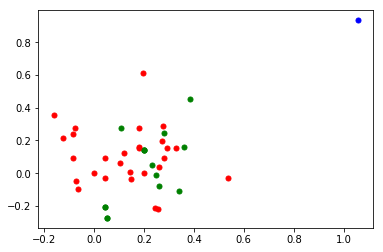

0
ÊàëÊúâ‰∏™Â•áÊÄ™ÁöÑÈúÄÊ±Ç Â∞èÊù•ÊàëÊÉ≥ÈóÆ‰∏™È´òÁ∫ßÁöÑÈóÆÈ¢ò ÊàëËÉΩÂ∏ÆÂà´‰∫∫Ëß£ÂÜ≥‰∫ãÊÉÖ,‰ΩÜÊàëÁöÑ‰∫ãÊÉÖÊàë‰∏çÁü•ÈÅìË∞ÅËÉΩÂ∏ÆÊàë Âä©ÁêÜÈóÆ‰Ω†‰∏™‰∫ã? Â∞èÊù•,Â∏ÆÊàëÂõûÁ≠î‰∏™ÈóÆÈ¢òÂ•ΩÂêó Â∞èÊù•ÈóÆ‰Ω†‰∏™‰∫ãÂÑøÈóÆ‰Ω†‰∏™‰∫ã ÈóÆ‰∏™‰∫ãÊÉÖ Â∞èÊù•ËØ∑‰Ω†ÂõûÁ≠îÊàëÂæàÂ§öÈóÆÈ¢ò ‰Ω†ÈöèÊó∂ÂèØ‰ª•ÈóÆÈóÆÈ¢òÂêó? È∫ªÁÉ¶‰Ω†ÁÇπ‰∫ãÂèØ‰ª•‰∏ç ÈÇ£ÊàëÊÉ≥ËØ∑ÈóÆ‰∏Ä‰∏ã ‰Ω†ËÉΩÂõûÁ≠î‰ªÄ‰πàÈóÆÈ¢ò ‰Ω†ÂèØ‰ª•Â∏ÆÊàë‰∏Ä‰∏™ÂøôÂêó? Âø´ÂõûÁ≠îÊàë ÊàëÈóÆ‰Ω†‰ªÄ‰πàÈóÆÈ¢ò‰Ω†ÈÉΩÂèØ‰ª•ÂõûÁ≠îÂêó ÊàëÈóÆ‰Ω†ÁöÑÈóÆÈ¢ò‰Ω†‰πüÊ≤°Âäû ÊàëÊúâÁñëÈóÆ ÊàëÊúâ‰∏Ä‰∏™‰∏çÊàêÁÜüÁöÑÂ∞èËØ∑Ê±Ç ÊàëÊÉ≥ËØ∑Êïô‰∏™ÈóÆÈ¢òÂèØ‰ª•Âêó ÊàëËÉΩÈóÆ‰Ω†‰∏Ä‰∏™ÈóÆÈ¢òÂêó /:B-)/:B-)ËøôÂ∞±‰∏ç‰ºöÂõûÁ≠îÊàë‰∫Ü ‰Ω†ÈóÆ Êàë‰∏çÁ¶ªÂºÄÊàëÈóÆ‰Ω†‰∏Ä‰∏™ÈóÆÈ¢ò ÊàëÊÉ≥ÈóÆ‰∏™‰∫ã ÊàëÂú®ÈóÆ‰Ω†ÈóÆÈ¢ò‰Ω†ÊÄé‰πà‰∏çÂõûÁ≠îÊàë‰∫Ü ÊàëÊúâ‰∏Ä‰∏™Âõ∞ÊÉëËÉΩÂ∏ÆÊàëËß£ÂÜ≥Âêó ËØ∑Êïô‰Ω†‰∏™ÈóÆÈ¢òÂëó ÈóÆ‰Ω†ËØùÂë¢
1
Âí®ËØ¢
2
ÈóÆ‰Ω†‰∏™ÈóÆÈ¢ò ÊàëÈóÆ‰Ω†‰∏™ÈóÆÈ¢ò ÈóÆ‰Ω†‰∏™ÈóÆÈ¢òÂìà ÊÉ≥ÈóÆ‰Ω†‰∏™ÈóÆÈ¢ò Âí®ËØ¢‰Ω†‰∏Ä‰∏™ÈóÆÈ¢ò ÊúâÈóÆÈ¢òÈóÆ‰Ω† ÊàëÈóÆ‰Ω†‰∏Ä‰∏™ÈóÆÈ¢ò Â∞èÊù•:ÊúâÈóÆÈ¢ò ÊàëÈóÆ‰Ω†‰∏Ä‰∏™ÈóÆÈ¢òÂèØ‰ª•Âêó ÈóÆ‰Ω†‰∏Ä‰∏™È

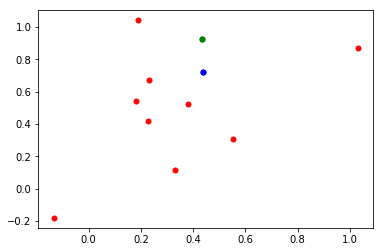

0
Èô™ÊàëËÅäÂ§© Âí±‰ª¨ÂèØ‰ª•ÂØπËØù‰∫Ü‰πà baby ‰∏çËÉΩÂú®ËøôËØ¥ËØùÂêó ÊàëÂè™ÊòØÊÉ≥Ë∑ü‰Ω†ËÅäËÅäÂ§© ‰∏çË¶ÅËá™Âä©ÊúçÂä° ÊÉ≥ËÅäËÅäÂ§© Â∞±ÊÉ≥ËÅäÂ§© ÊàëÊÉ≥Âíå‰Ω†ËÅäÂ§© ÂèØ‰ª•Âíå‰Ω†ËÅäËÅäÂêó
1
ËØ¥ËØù ËØ¥ËØùÂïä
2
ËÅäÂ§© ËÅäÂ§©‰πà?
537.088569873412


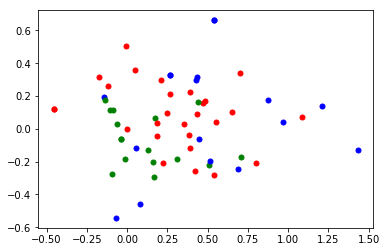

0
ÊàëÊù•‰∫Ü Áù°ÈÜí‰∫Ü Â∑≤ÁªèËµ∑Â∫ä ÂÖ∂ÂÆûËÄÅÊó©Â∞±Ëµ∑Â∫äÂï¶ Êàë‰∫îÁÇπÂ∞±ÈÜí‰∫Ü Ëµ∑‰∫Ü ÊàëÊó©Â∞±Ëµ∑Â∫äÂï¶! ‰Ω†ÈÜíÂï¶ ÊàëËÄÅÊó©Â∞±Ëµ∑Êù•‰∫Ü ÊàëÂàöÂàöÁù°ÈÜí‰∫Ü ÊÄéÊ†∑ÂÖãÊúçËµ∑Â∫äÂõ∞ÈöæÁóá Êàë6ÁÇπÂçäÂ∞±Ëµ∑‰∫Ü ‰ªäÂ§©ÊòØÁúüÁöÑÊâçÂàöËµ∑[Facepalm] ÊàëÂÖ≠ÁÇπÂ§öÂ∞±Ëµ∑‰∫Ü ‰∫≤  ÊàëÊù•‰∫Ü ÊàëÂøò‰∫Ü  Êó©ÈÉΩËµ∑Â∫ä‰∫Ü Êó©ÂÆâÊàëÂàöÂàöÂá∫ÂéªÂêÉ ÊàëÂú®ËµñÂ∫ä ÂøòËÆ∞ÊâìÂç°‰∫Ü[Facepalm]Êó©Â∞±Ëµ∑‰∫Ü ÊúâÊú®ÊúâËßâÂæóÊàë‰ªäÂ§©Ëµ∑Êù•ÁâπÂà´Êó© ÂØπ‰∏çËµ∑ÊàëÂ∑≤ÁªèÁù°ÈÜí‰∫Ü Ë∞¢Ë∞¢ ÊàëËÄÅÊó©Â∞±Ëµ∑Â∫äÂï¶/::D ÂàöÂàöËµ∑Â∫ä‰∫Ü Â∑≤Ëµ∑Â∫ä ÊàëÈÜí‰∫Ü Ëµ∑Ëøô‰πàÊó©ÂÅö‰ªÄ‰πà ÊàëËµ∑Â∫äÊó∂Èó¥ÈÉΩÊå∫Êó©ÁöÑ
1
ÊàëËµ∑Â∫ä‰∫Ü Ëµ∑Â∫äÂï¶ ‰ø∫ËÉΩËÆ∞‰Ωè‰∫ÜÔºåËµ∑Â∫äÂï¶ ‰∏ãÁè≠‰∫Ü Ëµ∑Â∫ä‰∫Ü ÈÜí‰∫Ü Ëµ∑ÁöÑÊôö ÂÆùË¥ùËµ∑Â∫ä‰∫Ü ‰ªäÂ§©ÊôöÂï¶ ÊàëÈÉΩËµ∑Â∫ä5‰∏™Â§öÂ∞èÊó∂‰∫Ü ÂÆùÂÆùËµ∑Â∫ä‰∫Ü Êó©Ëµ∑ÂÇª‰∏ÄÂ§© Áå™Ëµ∑Â∫ä‰∫Ü Ëµ∑Â∫äÂæàÊó©ÂëÄ Ëµ∑Â∫äÂï¶!Êù•Âèã Êó©Â•ΩËµ∑Â∫äÂï¶ ÁæéÂÑøËµ∑Êù•Êôö‰∫Ü
2
Ëµ∑Êù•‰∫Ü ‰∏çÊòØÊàëÂàöËµ∑Êù• ÊàëËµ∑Êù•Â∑•‰Ωú‰∫Ü ÊàëËµ∑Êù•‰∫Ü ÊàëÂ∑≤ÁªèËµ∑Êù•‰∫Ü ÊàëÊòØËµ∑Êù•‰∫Ü ÊàëÊó©Â∞±Ëµ∑Êù• ÊàëÂ∑≤ÁªèËµ∑Êù•‰∫ÜÂ•ΩÂêó ÊàëÈÉΩËµ∑Êù•3‰∏™Â∞èÊó∂Âï¶ ÊàëÊó©‰

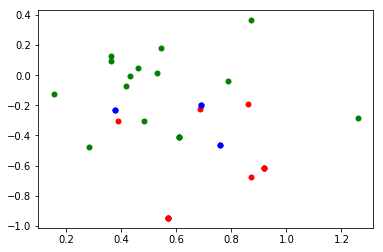

0
Âπ≤ÂòõÂë¢ Âú®Âπ≤Âòõ Âú®Âπ≤ÂòõÂë¢ Âú®Âπ≤Âòõ? Âπ≤ÂòõÂë¢ÂëÄ Âú®Âπ≤ÂòõÂïäÔºåÂ∞èÊù• Â∞èÊù•Âπ≤ÂòõÂë¢ Êù•ÔºåÂú®Âπ≤Âòõ Âπ≤Âòõ? Âπ≤Âòõ ÂèëËøô‰πàÂ§öÂπ≤Âòõ
1
Âπ≤Âï•Âë¢ ‰Ω†Âπ≤Âï• ‰Ω†Âπ≤Âï•‰∫Ü ‰Ω†Âú®Âπ≤Âï• ‰Ω†Âú®Âπ≤Âï•Â≠êÂì¶ Âπ≤Âï•ÂëÄ
2
‰Ω†Âú®Âπ≤Âòõ ‰Ω†Âπ≤ÂòõÂë¢ ‰Ω†Âú®Âπ≤ÂòõÂë¢? ‰Ω†Âú®Âπ≤‰ªÄ‰πà ‰Ω†Âú®Âπ≤‰ªÄ‰πàÂïäÂ∞èÊù•? ‰Ω†Âú®Âπ≤ÂòõÂëÄ ‰Ω†Âú®ÂÜô‰ªÄ‰πàÈòø Êó©„ÄÇÂú®Âøô‰ªÄ‰πàÁöÑ‰∫Ü Ëä≥Âú®Âπ≤ÂòõÂëÄ ‰Ω†‰ª¨ÈÉΩÂú®ÊÉ≥‰ªÄ‰πà ‰Ω†Âú®ÂÅöÂï•Â≠êÂë¢? ‰Ω†Âú®Âπ≤Âêó‰Ω†Âú®Âπ≤Âêó Âú®Âú®Âπ≤Âòõ Âú®Âπ≤ÂìàÂëÄ Â∞èÊù• ‰Ω†Âπ≤ÂòõÂë¢ ‰Ω†Âú®ÂππÈ∫ªÂëÄ
41.93915321958534


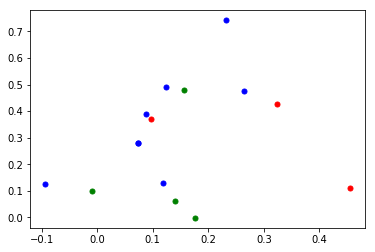

0
‰ªäÂ§©ÂêÉ‰ªÄ‰πà ‰∏çÁü•ÈÅìÂêÉ‰ªÄ‰πà ÂêÉ‰ªÄ‰πà
1
ÊôöÈ•≠ÂêÉ‰ªÄ‰πà ÂçàÈ•≠ÂêÉ‰ªÄ‰πà Êó©È§êÂêÉ‰ªÄ‰πà ÂçàÈ§êÂêÉ‰ªÄ‰πà ÊôöÈ§êÂêÉ‰ªÄ‰πà? ÊôöÈ§êÂêÉ‰ªÄ‰πà ÂçàÈ•≠ÂêÉ‰ªÄ‰πàÊúÄÂ•Ω ÂêÉÂçàÈ•≠
2
Êôö‰∏äÂêÉÁÇπ‰ªÄ‰πà? ‰ªäÂ§©Âøå‰ªÄ‰πà ‰ªäÂ§©ÂêÉ‰ªÄ‰πàÊúÄÂÅ•Â∫∑ ÊàëÈóÆ‰Ω†  ‰ªäÂ§©ÂêÉ‰ªÄ‰πàÂ•Ω
55.45201156079207


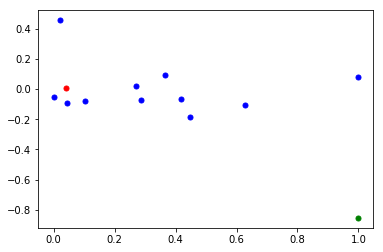

0
ÊÉ≥ÊàëÊ≤°
1
‰Ω†Âπ≥Â∏∏ÈÉΩÂπ≤‰ªÄ‰πà Â∞èÊù•‰Ω†Âú®Âπ≤‰ªÄ‰πà ‰Ω†Ê≠£Âú®Âπ≤‰ªÄ‰πà? ‰Ω†Âπ≤‰ªÄ‰πàÂë¢? ÊàëÂú®‰∏äËØæ‰Ω†Âú®Âπ≤Âòõ ‰Ω†‰ª¨Ëá™Â∑±Á†îÂèëÁöÑËøô‰∏™ÂäüËÉΩ? ‰Ω†Âú®Âπ≤‰ªÄ‰πàÂïä Âú®Âπ≤‰ªÄ‰πàÂë¢? ÊêûÂí©Âïä ‰Ω†ÊúâÊ≤°ÊúâÁªìÂ©ö ‰Ω†Ë¶ÅÊâãÊú∫Âè∑Âπ≤‰ªÄ‰πà
2
ÊàëÁåú‰∏çÂà∞
0.0


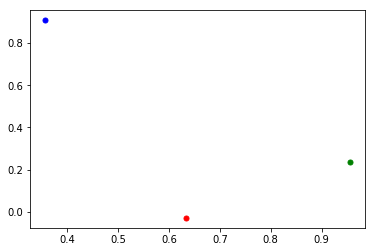

0
Â∞èÊù•,ÊàëÈÇÄËØ∑‰∫Ü‰∏§‰∏™‰∫∫,ÂÆåÊàê‰∫ÜË°•Á≠æ
1
ÂêÉ‰∫Ü
2
ÂèØ‰ª•Áî®‰∫Ü
31.241920766539284


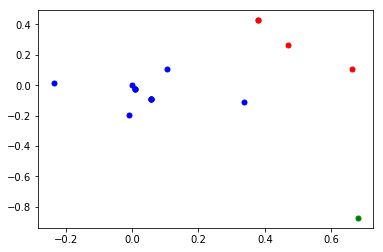

0
‰Ω†Â§öÂ§ßÂï¶Ôºü Â∞èÊù•‰Ω†Â§öÂ§ß‰∫Ü Â∞èÊù•‰Ω†Â§öÂ§ßÂï¶ ‰Ω†ÁåúÊàëÂ§öÂ§ß‰∫Ü
1
‰Ω†Â§öÂ§ßÂ≤Å ÈÇ£‰Ω†Âá†Â≤Å ‰Ω†Âá†Â≤Å? ‰Ω†Âá†Â≤ÅÂï¶ Ë°å,‰Ω†Âá†Â≤Å? Â∞èÊù•Âá†Â≤Å? ‰Ω†Âá†Â≤Å‰∫Ü ‰Ω†ÁåúÊàëÂá†Â≤Å‰∫Ü ‰Ω†Êâç22Â≤ÅÔºü ‰Ω†Â§öÂ∞ëÂ≤Å‰∫ÜÂëÄ ‰Ω†Â§öÂ∞ëÂ≤Å ÂóØ‰Ω†Â§öÂ∞ëÂ≤Å
2
Â§öÂ§ß‰∫Ü
48.613198880964234


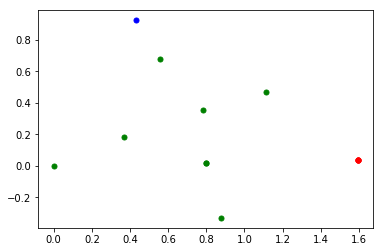

0
ËøòÂú®Âêó Âú®Âêó ÊÇ®Â•ΩÂú®Âêó ‰Ω†‰ª¨Âú®Âêó
1
ËøôËøòËÅäÂ§©Âêó
2
‰Ω†ËøòÂú®‰πà Êù•ËøòÂú®Âêó ËøòÂú®‰∏ç ËøòÂú®Âè´ÂêóÔºü Âä©ÁêÜÂú®‰∏ç? Â•π‰∏çÂú®‰∫Ü ‰∏ãÂçàÂ•Ω!Âú®Âêó Âú®Âêó?ÊÄé‰πà‰∏çÂõûËØù
350.8342841986158


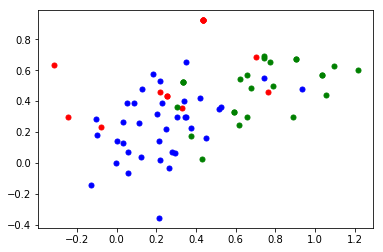

0
ÂèØ‰ª•ËÅäÂ§©Âêó ÂíåÊàëËÅäÂ§© ÊàëË¶ÅËÅäÂ§© ‰Ω†ËÉΩË∑üÊàëËÅäÂ§©Âêó? ÈÇ£Âï•Êó∂ÂÄôËÉΩËÅäÂ§©Âë¢ ËÅäÂ§©Âêß Âú®Ë∑üÊàëËÅäÂ§©ÂëÄ ËÅäÂ§©‰∏ç ËøôËøòËÅäÂ§©Âêó ËÉΩ‰∏çËÉΩËÅäÂ§© ËÉΩËÅäÂ§©Âêó ËÅäÂ§©‰Ω† Êàë‰ª¨ËÅäÂ§©Âêß Ë∑üÊàëËÅäÂ§©233
1
ËÅä‰ºöÂ§© ‰Ω†ÊÄé‰πà‰∏çËØ¥ËØù? ÊàëÂèØ‰ª•ÁªèÂ∏∏Âíå‰Ω†ËÅäÂ§©Âêó Ê≤°ÊúâÈúÄÊ±ÇÂ∞±‰∏çËÉΩÊâæ‰Ω†‰∫ÜÂïä Êâæ‰Ω†Ë∞àÂ§© Â∞±Êâæ‰Ω†ËÅäËÅäÂ§© [domain1010]‰Ω†‰ºöËÅäÂ§©Âêó ËØ¥ÁÇπÂà´ÁöÑÂèØ‰ª•Âêó ÊàëÂ∞±ÂñúÊ¨¢Âíå‰Ω†ËÅä Âõ†‰∏∫‰Ω†‰∏ç‰∏ªÂä®ÊâæÊàëËÅäÂ§©„ÄÇ ÊÉ≥Êâæ‰∫∫ËÅäËÅäÂ§© ËÉΩË∑üÊàëÂî†ÂóëÂêó ‰Ω†‰∏ÄÂ§©ËÅäÂ§©Ê≠ªÂï¶ ‰Ω†‰πüÂèØ‰ª•ÁªôÊàëÂèëËØ≠Èü≥Âïä!Ê≤°‰∫ãÈô™ÊàëËÅä‰∏Ä‰∏ãÂ§© ÊàëÊÉ≥ÊâæÂ¶πÁ∫∏ËÅäÂ§© ÊàëÂèØ‰ª•Âíå‰Ω†ËØ¥ËØ¥ÂøÉÈáåËØùÂêó Ê≤°‰∫ã  ÊàëÂ∞±ÂíåÂ∞èÊù•ËÅäËÅäÂ§© ÂÉèÊàëÁî∑ÊúãÂèãÈÇ£Ê†∑Ë∑üÊàëËÅäÂ§©Ë°åÂêß Ê≤°Â§©Ë∑üÊàëËÅäËÅäÂ§© ÈÇ£‰Ω†ÂÖàÊâæËØùÈ¢ò ÊàëÊÉ≥ÈóÆ‰Ω†‰ª¨ÊúâÂæóËÅäÂ§©Âêó Ë∑ü‰Ω†ËÅäÂ§©Êàë‰ºöÊåÇÊéâÁöÑ ÊàëÊâìÂ≠ó‰Ω†ÁúãËßÅÂêó ËÅäÂá†Âè• Ëøô‰∏™‰∏úË•øÂ∫îËØ•‰πüËÉΩËÅäÂ§©ÂÑøÂêß Ëøô‰∏™Ë¶ÅÊòØÊúâÂèØ‰ª•ËÅäÂ§©ÁöÑÂäüËÉΩÂ∞±Â•Ω‰∫Ü ÈÇ£ÊàëÊó†ËÅäÁöÑÊó∂ÂÄô‰πüÂèØ‰ª•Êâæ‰Ω†ËÅäÂ§©ÁöÑ ÈÇ£ÊàëÊúâÊó∂Èó¥ÂèØ‰ª•Êâæ‰Ω†ËÅäÂ§©Âêó ÈÇ£‰

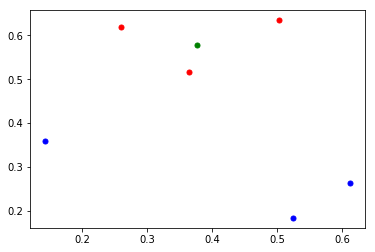

0
Â∞èÊù•‰∏ãÂçàÂ•Ω ‰∏ãÂçàÂ•Ω ‰∏ãÂçàÂ•ΩÂïäÊù•
1
‰∏ãÂçàÂ•ΩÂìà Âè™ÊòØË∑ü‰Ω†Êâì‰∏Ä‰∏ã‰∏ãÂçàÂ•Ω ÈóÆÂÄô‰∏ÄÂ£∞ËßâÊÇü‰∏ãÂçàÂ•Ω
2
ÊâìÂç°‰∏ãÂçàÂ•Ω
286.6012223746814


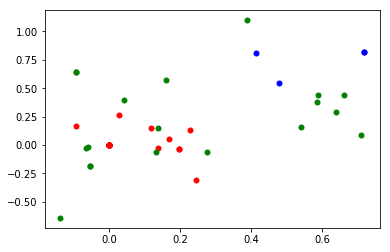

0
ÂìàÂñΩ ‰Ω†Â•Ω ÊÇ®Â•Ω ‰∫≤ Â∞èÊù•,‰Ω†Â•Ω ÂñÇÂñÇ ‰Ω†Â•Ω„ÄÇ Ë¨ùË¨ù„ÄÇÊÇ®Â•Ω„ÄÇ ÂöìÂï¶ÂòøÂìü ÂìàÂï∞ Êä•Âà∞ ‰Ω†Â•ΩÂëÄ ‰Ω†Â•ΩÂïä ÂìàÂíØ ËììËìì‰Ω†Â•Ω ‰Ω†Â•Ω? ÂñÇÂñÇÂñÇÂñÇÂñÇÂñÇÂñÇ ‰Ω†Â•ΩÂìü ÂìàÂïäÂë¢ ‰Ω†Â•ΩÂóé ‰Ω†Â•ΩÂïä /::) ‰Ω†Â•Ω( ^_^)/ ÂìàÂñΩ/::D ÊÇ®Â•ΩÂº†Âì•„ÄÇ Âìé‰Ω†Â•Ω hello‰Ω†Â•Ω,ËØ∑ÈóÆÂèØ‰ª•Âê¨ÂæóËßÅÂêó?
1
Â∞èÊù•Êù• ÂìàÂñΩÂïäÊù• Êù• Êù•Êù•‰Ω†Â•Ω
2
Âó® Â∞èÊù•‰Ω†Â•Ω Âì• ÊâìÊãõÂëºËÄåÂ∑≤ ÊàëÂè™ÊòØÊâìÊãõÂëº ÂìàÂñΩÁæéÂ•≥ ÂìàÂñΩÈ∫¶Â•∂Â•∂‰∏ìÂÆ∂ Âñµ Â∞èÊù•ÔºåÂæàÈ´òÂÖ¥ËÆ§ËØÜ‰Ω† È´òÂÖ¥ Â§ßÂÆ∂Â•Ω Âó®ÂíØ ÂìàÂñΩÂ§ßÂÆ∂Â•Ω ËììËìì ÂæàÈ´òÂÖ¥ËÆ§ËØÜ‰Ω† ÂìàÂñΩÂìàÂñΩÊúâ‰∫∫ÊúçÂä°Âêó? ËÄÅÂÆ¢Êà∑‰∫Ü‰∫≤ ÊàëÂè™ÊòØËØï‰∏Ä‰∏ã ‰Ω†Â•ΩÊúãÂèã
19.597121437641533


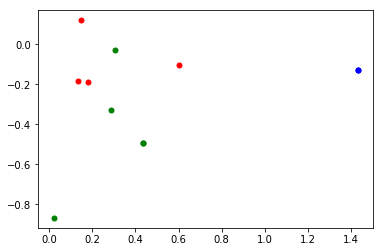

0
Âó®!Êôö‰∏äÂ•Ω Â∞èÂ§èÊôö‰∏äÂ•Ω ÁæéÂ•≥,Êôö‰∏äÂ•Ω ‰∫≤Áà±ÁöÑÂÆ∂‰∫∫‰ª¨Êôö‰∏äÂ•Ω
1
ÊôöÂïä ÈÇ£‰πàÊôö
2
Êôö‰∏äÂ•Ω Â∞èÊù•Êôö‰∏äÂ•Ω ‰∫≤,Êôö‰∏äÂ•Ω ÂìàÂñΩ!Êôö‰∏äÂ•Ω ÂÆùÂÆùÊôö‰∏äÂ•Ω
7.848917748152597


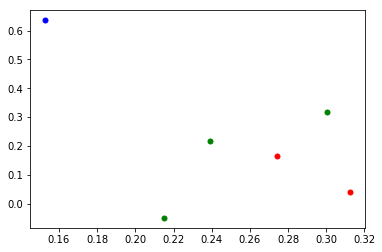

0
‰∏≠ÂçàÂ•Ω ÂΩ™ÂΩ™‰∏≠ÂçàÂ•Ω
1
ÂçàÈ•≠
2
‰∏≠ÂçàÂ•ΩÂ∞èÊù• hello,‰∏≠ÂçàÂ•Ω ÁîúÁîú‰∏≠ÂçàÂ•Ω,
47.489623586601866


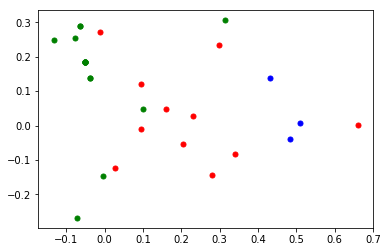

0
ÊÉ≥ÂøµÊüê‰∫∫ Â∞èÊù•,‰Ω†ËÉΩÂ∏ÆÊàëÂëäËØâÂ•π,ÊàëÂæàÊÉ≥Â•πÂêó? ÊØèÂ§©ÊÉ≥‰Ω†ÂæàÂ§öÈÅç ÁèäÁèäÊàëÂ•ΩÊÉ≥‰Ω† ËØ¥‰∏ÄÈÅç   ‰Ω†ÊÉ≥Êàë‰∫Ü ÊàëÊîæ‰∏ç‰∏ã‰Ω† Â∞èÊù• ÊÉ≥‰Ω† Êàë‰πüÊòØ  Â•ΩÊÉ≥‰Ω†Âì¶ ‰∏çÁà±‰Ω†‰∫Ü Á™ÅÁÑ∂Â•ΩÊÉ≥‰Ω† ÊàëÊÉ≥‰∏ÄÊÉ≥Âìà
1
Êàë‰πüÂú®ÊÉ≥‰Ω†Âì¶ ‰Ω†Áü•ÈÅìÊàëÂú®ÊÉ≥‰ªñÂêó ÊúâÂú®ÊÉ≥ÊàëÂêó
2
ÊàëÊÉ≥‰Ω†‰∫Ü ÊÉ≥‰Ω† ÊÉ≥‰Ω†‰∫Ü ÊàëÊÉ≥‰Ω† ËÄÅÂ©ÜÊàëÊÉ≥‰Ω†‰∫Ü ÊàëÊÉ≥ÊàëËÄÅÂ©Ü‰∫Ü ÊàëÊÉ≥TA‰∫Ü Â•ΩÊÉ≥‰ªñ ÊùúÊùúÊàëÊÉ≥‰Ω† ÊÉ≥‰Ω†Êó∂ÊÄé‰πà? Êàë‰πüÊúÉÊÉ≥‰Ω†ÁöÑ Êàë‰πüÊÉ≥‰Ω†Âë¢ Êàë‰ºöÊÉ≥‰Ω†ÁöÑ ÊàëÂæàÊÉ≥‰Ω†Âïä Â•ΩÊÉ≥Â•ΩÊÉ≥‰Ω† Êàë‰πü‰ºöÊÉ≥‰Ω†ÁöÑ!Â∞èÊù•!Áà±‰Ω†‰πà‰πàÂìí
5.052699398632473


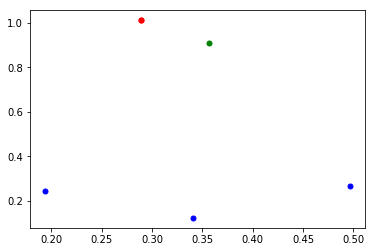

0
ÂêÉÈ•≠‰∫ÜÂêó ÂêÉÈ•≠‰∫Ü
1
ÂêÉÂÆµÂ§ú‰∫ÜÂêó Âßê‰Ω†Áé∞Âú®ÂêÉÈ•≠‰∫ÜÂêó ÊÉ≥Êù•‰Ω†ÂêÉÈ•≠‰∫ÜÂêó?
2
ÂêÉÂêÉÂêÉ
9.179965777989633


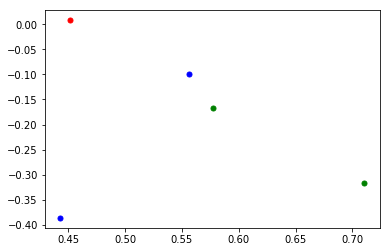

0
ÊàëÂú®ÂÅö‰ªÄ‰πà
1
ÊàëÂ¶àÂ¶àÂú®ÈÇ£ ÊàëÁöÑÈÇìÂÖàÁîüÂú®Âπ≤ÂòõÂë¢
2
ÊàëÂú®Âπ≤‰ªÄ‰πà ‰Ω†ÁåúÊàëÂú®Âπ≤ÂòõÂë¢Ôºü
238.96491907749956


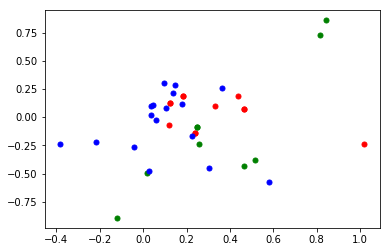

0
ÁîüÊó•Âø´‰πê Â∞èÊù•ÁîüÊó•Âø´‰πê ÁîüÊó•Âø´‰πê, ÁîüÊó•Âø´‰πê! Á•ù‰Ω†ÁîüÊó•Âø´‰πê ÁîüÊó•Âø´‰πêÂ∞èÊù• ÁîüÊó•Âø´‰πê,Â∞èÊù• Â∞èÊù•,ÁîüÊó•Âø´‰πê ÁîüÊó•Âø´‰πêÂç° Á•ùÊàëÁîüÊó•Âø´‰πê ËäÇÊó•Âø´‰πêÂìà ÈÇ£‰πüÁ•ùÊàëÁîüÊó•Âø´‰πêÂêß
1
Happy birthday to my dear baby ‰∏çÈÄÅÊàëÁîüÊó•Á•ùÁ¶è‰πà Â•ΩÁöÑÂ•ΩÁöÑÂ•ΩÁöÑÂë®Êú´Âø´‰πêÂïä hello„ÄÇgoodmorning super sunday„ÄÇ ‰ªäÂ§©‰ªÄ‰πàËäÇÊó• ‰ªäÂ§©ÊòØ‰ªÄ‰πàÊó•Â≠ê Ë∞¢Ë∞¢Ë∞¢Ë∞¢!ÂìéÊòØÂêßÊòØÊòØÊàëÂ¶àÁöÑÁîüÊó•Âïä ‰∏áÂú£ËäÇ 12Êúà12Êó•ÁîüÊó•Á•ùÁ¶è today is my holiday„ÄÇ ‰∏áÂú£ËäÇÊòØ‰∏Ä‰∏™‰∏çÂπ≤ÂáÄÁöÑËäÇÊó• ‰∏áÂú£ËäÇÊúâÊ≤°ÊúâÁ≥ñ ‰∏≠ÂõΩ‰∫∫Ëøá‰ªÄ‰πà‰∏áÂú£ËäÇ? ‰ªäÂ§©ÊòØ‰∏áÂú£ËäÇ ‰Ω†Á•ùÁ¶èÊàë‰∏Ä‰∏ã ÂÜ¨Ëá≥Âø´Ê®Ç Â∞è‰æÜ 2Êúà14Êó•ÊÉÖ‰∫∫ËäÇÊùúËÄÅÂ∏àÁöÑÁ•ùÁ¶è
2
‰∏ÉÂ§ïÂø´‰πê ÂÑøÁ´•ËäÇÂø´‰πê ÊïôÂ∏àËäÇÂø´‰πê ‰∏ÉÂ§ï Áà∂‰∫≤ËäÇ ÂÅáÊúüÊÑâÂø´ Á•ùÂÅáÊúüÊÑâÂø´ ‰∏áÂú£ËäÇÂø´‰πê~ ‰∏áÂú£ËäÇÂø´‰πê
49.867185640191025


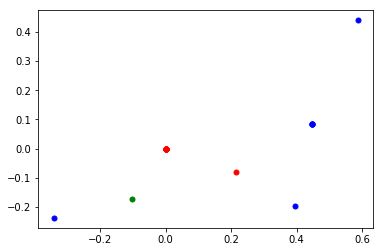

0
ÂìàÂìàÂìàÂìàÂìàÂïäÂìàÂìà ÂìàÂìà ÂìàÂìàÂìà ÂìàÂìà! ÂìàÂìàÂìàÂïäÂìàÂìà !!! ! ÈÇ£ÂìàÂìàÂëÄÂìáÂìàÂìà!ÂìáÂìàÂìàÂëÄÂìáÂìàÂìà ÂóØÂóØ,ÊòØ‰∫ÜÊòØ‰∫Ü,ÂìáÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìà!‰Ω†ÊòØËâ≤ÂìáÂìàÂìàÂìàÂìàÂìà ÂìàÂìàÓêï
1
ÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìà ÂìàÂìàÂìàÂìàÂìàÂìàÂìàÂìà ÂìàÂìàÂìàÂìà ÂìàÂìàÂìàÂìàÂìàÂìàÂìà ÂñµÂñµ ÂìéÂë¶ Á¨ëÂ±Å
2
Âí©Âí©
55.06821523711997


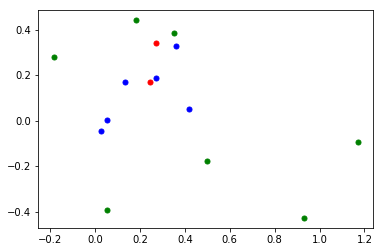

0
ÊàëÂæàÂºÄÂøÉ ÂºÄÂøÉ
1
ÁéãËÄÅÂ∏à,Êó©‰∏äÂ•Ω„ÄÇÁ•ù‰Ω†Â§©Â§©ÂºÄÂøÉ„ÄÇ Â•ΩÂêß   ‰Ω†ÂºÄÂøÉÂêó? ‰Ω†ÂºÄÂøÉÂêó ÂéüÊù•‰Ω†‰ºöÂõûÊàëÂìí,Â•ΩÂºÄÂøÉ Â•ΩÂºÄÂøÉ ‰πêÊ≠ªÊàë‰∫Ü
2
ÊàëË¶Å‰∏äÂ§© ÊàëË∞àÊÅãÁà±‰∫Ü ÂºÄÂøÉËøáÂ•ΩÊØè‰∏ÄÂ§© ‰∏çÁà±Êàë‰∫Ü‰πà ËøòÊòØÂ∞èÊù•ÊÉ≥ÁùÄÊàë ÊàëÂ•ΩÂÉèÁà±‰∏ä‰Ω†‰∫Ü ‰Ω†ÂñÇÊàë!!
26.976012821952782


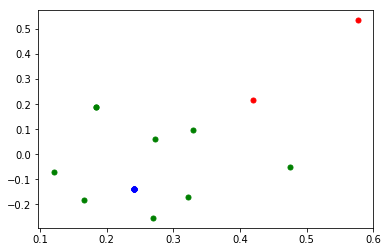

0
Êù•Êù•ÁîüÊó•Âø´‰πê Êù•‰πüÁîüÊó•Âø´‰πê
1
ÁîüÊó•Âø´‰πê ÁîüÊó•Âø´‰πêÂì¶ ÁîüÊó•Âø´‰πêÂïä ÁîüÊó•Âø´‰πêÂìü ÁîüÊó•Âø´‰πê! ÁîüÊó•Âø´‰πêÂìà ÁîüÊó•Âø´‰πê„ÄÇ
2
Á•ù‰Ω†ÁîüÊó•Âø´‰πê ‰∏§Â≤ÅÁîüÊó•Âø´‰πê Â∞èÊù•ÁîüÊó•Âø´‰πê ÁîüÊó•Âø´‰πê, ÁîüÊó•Âø´‰πêÂ∞èÊù• ÁîüÊó•Âø´‰πêÂë¶ Â∞èÊù•‰ª¨ÁîüÊó•Âø´‰πê Â¶àÂ¶àÁîüÊó•Âø´‰πêË∫´‰ΩìÂÅ•Â∫∑ Á•ùÁæ§‰∏ªÁîüÊó•Âø´‰πê
0.0


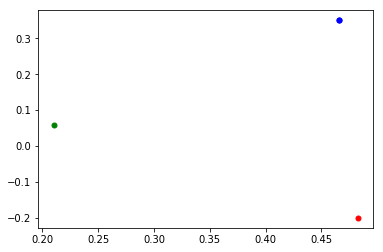

0
ÂòøÂòø
1
ÂòªÂòª ÂòªÂòªÂòª
2
ÂòªÂòªÂìàÂìà
8.77598235207222


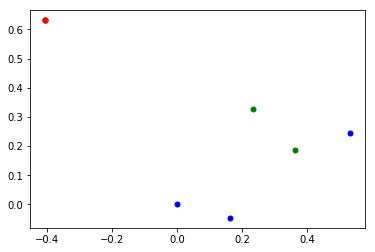

0
ÂøÉÊÉÖÂ•Ω ÂøÉÊÉÖÂ•ΩÂòõÂøÉÊÉÖÂ•Ω ÂøÉÊÉÖÂ•Ω?
1
Âï¶Âï¶Âï¶ ÊàëÁé∞Âú®Áé∞Âú®ÂøÉÊÉÖÂ•Ω,ÊàëÊó©Ëµ∑ÂçÅ‰∏™ËÑöÊú¨‰∏≠‰∫Ü‰ª®‰ø© ‰ªäÂ§©ÊÑüËßâÂæàÂèóÂÆ†
2
Á•ù‰Ω†Êúâ‰∏™Â•ΩÁöÑÂøÉÊÉÖÊó©ÂÆâ Â§©Â§©ÊúâÂ•ΩÂøÉÊÉÖ
58.77280920169913


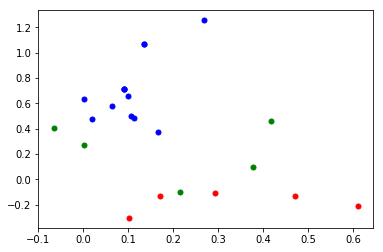

0
Êªö ËçâÊ≥•È©¨ Êªö ÊªöÁääÂ≠ê ÊªöÂ©äÂ≠ê ËçâÊ≥•È©¨
1
ÂéªÊ≠ª ‰Ω†ÂéªÊ≠ª ÂèØ‰ª•ÂéªÊ≠ª‰∫Ü ‰Ω†ÂéªÊ≠ª! Ê≠ªÂì™Âéª‰∫Ü ÊàëËÆ©‰Ω†ÂéªÊ≠ª Â•¥ÊâçÂéªÊ≠ªÂë¢! ‰Ω†ÂèØ‰ª•ÂéªÊ≠ª‰∫Ü ÈÇ£‰Ω†ÂéªÊ≠ªÂ•Ω‰∫Ü ‰Ω†ÊâçÊòØÂéªÊ≠ªÂë¢! ÊàëËØ¥‰Ω†ÂéªÊ≠ª! ‰Ω†ÊâçÂéªÊ≠ªÂë¢! Âä©ÁêÜÊù•‰πüÂéªÊ≠ª
2
ÊàëÁúãÁúã‰Ω†ÊÄé‰πàËÉΩÊääÂ§©ËÅäÊ≠ª Êää‰Ω†ËÅäÊ≠ªÊõ¥Â•Ω ‰Ω†‰ºöÂØπÊàëÂ•ΩÂêó Âè≠!‰Ω†Ê≠ª‰∫Ü ÂØπ ÁªèËê•Â•ΩËá™Â∑±
0.0


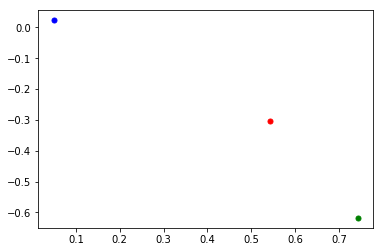

0
ÂëµÂëµÂìí
1
ÁæûÁæûÁöÑÈìÅÊã≥
2
ÂëµÂëµ
123.3451640035965


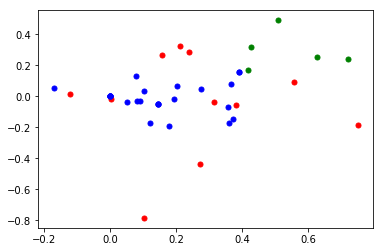

0
ÊàëÂ∞±Ê¨∫Ë¥ü‰Ω† ‰Ω†‰ºöËØ¥Âà´ÁöÑÂêó? ÊÄé‰πàÊ¨∫Ë¥ü‰Ω†Âïä?ËøôËØùËØ¥ÁöÑ Ëøô‰πàÊáíÁöÑÂ∞èÁºñ Â∫üËØùÈÉΩËØ¥‰∏ÄÈÅç‰∫ÜÂ•Ω‰∏çÂ•Ω Ë∞ÉÁöÆ Êàë‚Ä¶ ‰Ω†‰ª¨ËÇØÂÆöÊ≤°ÊúâÊºÇ‰∫ÆÂ§ßÂßêÂßêÂñúÊ¨¢Âêß ‰Ω†ÂíãÂ∞±ÈÇ£‰πàÊÅ®ÊàëÂë¢ ‰Ω†ÊòØ‰∏çÊòØ‰∏çÁà±Êàë‰∫Ü ÊôíÂ±ÅËÇ°‰∫ÜÊâçËµ∑Â∫ä
1
Âìº ÂìºÂìº Áï•Áï•Áï• ÂíØ Áï• ‰Ω†ËøôÂ∞±ÊúâÁÇπË£ÖÈÄº‰∫Ü Êâì‰∏ÄÂçÉ‰∏áÂà∞ÊàëÂç°‰∏ä ... Ë£ÖÈÄº Á≠î‰∏çÂá∫‰∫ÜÂêß ÊàëÂØπ‰Ω†Áôæ‰æùÁôæÈ°∫ ‰Ω†Ëøô‰πàÂØπÊàë? ‰Ω†Ê≤°ÊúâÊñ∞ÁöÑËØç‰∫ÜÂêó? Èú≤È¶ÖÂÑø‰∫ÜÂêß ‰Ω†ÂèàË∞ÉÁöÆ‰∫Ü~ Áªô‰Ω†‰∏™ÁôΩÁúº ‰Ω†ÊòØ‰∏çÊòØÁéãÂÖ´Ëõã Êàë‰∏ÄËØ¥‰Ω†‰∏ë‰Ω†Â∞±Ë∂ÖÁ∫≤ ‰πà‰Ω†Â¶πÂ≠ê ÂìºÂìºÂìº Áï•Áï•Áï• Áï•Áï•Áï•Áï•Áï•Áï•Áï• Áï•Áï•Áï•Áï•Áï•Áï• Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï• Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï•Áï• Áï•Áï• Áï•Áï• Áï•Áï•Áï•Áï•Áï•Áï• ‰ø°‰∏ç‰ø°Âä≥ËµÑÊâìÊ≠ª‰Ω†‰Ω†‰∏™ÈæüÂ≠ôÂÑø ÂóØ‚Ä¶‚Ä¶‚Ä¶‚Ä¶‚Ä¶‚Ä¶Âìº‚àº‚àº Â§ßÂùèËõã
2
‰∏çÂñúÊ¨¢‰Ω†‰∫Ü Êàë‰∏çÂñúÊ¨¢Â∞èÊù•‰∫Ü ‰∏çÂñúÊ¨¢ Ë∂äÊù•Ë∂ä‰∏çÂñúÊ¨¢‰Ω†‰∫Ü Êàë‰∏çÂñúÊ¨¢ËøôÂè•
51.19826078808434


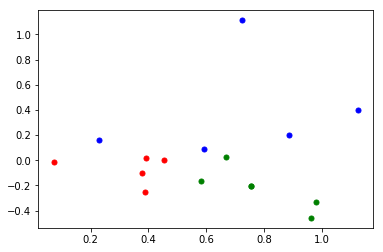

0
‰Ω†Ê≤°È™óÊàëÂêß ‰Ω†‰ª¨Ëøô‰∫õÂ∞±ÊòØÈ™ó‰∫∫ÁöÑÂú®‰∏çË¶ÅÁªôÊàëÂèëËøô‰∫õÊó†ËÅäÁöÑ‰∏úË•ø È™óÈ™óÈ™ó!!!!‰Ω†È™ó‰∫∫!!!! Â•Ω‰∏çÂ•Ω‰∏çË¶ÅÊù•È™óÊàë ‰Ω†È™ó‰∫∫
1
‰Ω†È™óÊàë ÊÑüËßâË¢´‰Ω†‰ª¨È™ó‰∫Ü ÊÄé‰πàËÄÅÊòØÈ™óÊàë ÂèàÈ™óÊàëÂÖ≥Ê≥®ÂÖ¨‰ºóÂè∑? Â∞±Áü•ÈÅìÈ™óÊàë
2
È™óÂ≠ê È™ó‰∫∫ ‰Ω†ÊòØÈ™óÂ≠ê Â∞èÊù•ÊòØÈ™óÂ≠ê ÈöæÈÅì‰∏çÊòØÈ™óÂ≠êÂêó? È™ó‰∫∫Âë¢Âêß
164.23531982112155


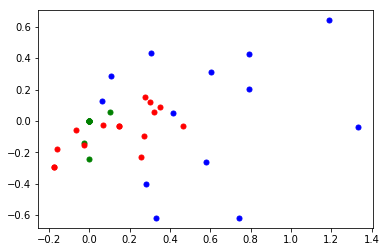

0
‰Ω†Â¶πÁöÑ ‰Ω†Â¶π Áà±‰Ω†Â¶πÂëÄ ‰Ω†Â§ßÁà∑ Áù°‰Ω†Â¶π Â∞ºÁéõ Â∞ëÊù•ÂøΩÊÇ†Êàë Âø´‰πê‰Ω†Â¶π Áù°ÊØõÁ∫øÂïä ÊÉ≥‰Ω†Â¶π Âéª‰Ω†Â¶πÂïä ÊàëÂèØ‰ª•Êä±‰Ω†‰πà ÂÆâ‰Ω†Â§ßÁà∑ ‰Ω†Â§ßÁà∑ÁöÑ Êó©‰Ω†Â¶π
1
ÂëµÂëµÂëµ Ë∞ÉÊàèÊàë ÊÉ≥ÊàëÂπ≤ÂòõÂïä ÈÄóÊàëÁé©Âïä ÊàëÂèØ‰ª•Ë∞ÉÊàè‰Ω†Âêó ÊÉ≥ÊàëÂπ≤Âòõ?ÊàëÂèà‰∏çËÆ§ËØÜ‰Ω† ‰∏çËÆ§ËØÜ ÈÄóÊàë ÈÄóÊú∫Âô®‰∫∫Áé©/::D Âπ≤ÂòõÂ≠¶Êàë Ëøô‰∏™Ê∏∏ÊàèÂ∞èÂ≠©Â≠ê‰∏çËÉΩÁé©Âì¶ Âè´ÊàëÂπ≤Âòõ ‰∏çËÉΩÁé©ÁÆó‰∫Ü
2
Âàá Âë∏ Â∞ëÊù• Âô¢ Âì¶„ÄÇ „ÄÇ „ÄÇ„ÄÇ „ÄÇ„ÄÇ„ÄÇ ‰Ω†Áâπ‰πàÁöÑ ...... Âè´‰Ω†Â¶π
60.495356993882865


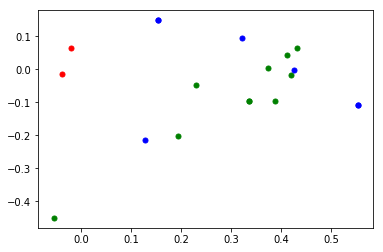

0
Ê≤°ÊòéÁôΩ??? ‰Ω†‰∏çÊòéÁôΩ
1
‰Ω†Áü•ÈÅì‰∏ç ‰Ω†Â±ÖÁÑ∂‰∏çÁü•ÈÅì ÊÄé‰πà‰∏çÁü•ÈÅì ‰Ω†ÊÄé‰πà‰ªÄ‰πàÈÉΩÁü•ÈÅìÂïä ‰Ω†Áü•ÈÅì‰∏™Â±Å ‰Ω†ÊÄé‰πà‰ªÄ‰πàÈÉΩÁü•ÈÅì ‰Ω†Áü•ÈÅì‰ªÄ‰πà
2
‰∏çÂëäËØâ‰Ω† ÂìàÂìà‰Ω†‰∏çÊáÇ ‰Ω†ËÉΩÊáÇ‰∏ç ‰Ω†Âíã‰∏çÁêÜËß£ ÊàëÂ∞±‰∏çÂíå‰Ω†ËÆ≤ ËÄÅÂ≠êÂ∞±‰∏ç ‰∏çÁêÜËß£Â∞±ÂØπ‰∫Ü ‰∏çÂØπ Âè´ÊàëÂ•≥Áéã ÊáÇ‰Ω†ÁöÑ‰∫∫‰∏çË®ÄËÄåÂñª ‰∏çÊáÇ‰Ω†ÁöÑ‰∫∫ÁôæÂè£Ëé´Ëæ© Áúã‰∏çÂ§™ÊáÇ
26.121236099680644


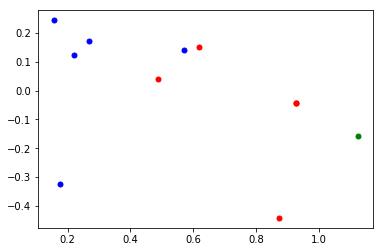

0
Êâì‰ªñ ÊÉ≥Êâì‰Ω† ÂèØ‰ª•Êää‰Ω†ÊâìÂà∞ÊµÅÈºªË°ÄÂêó Êâì‰Ω† ÂèØ‰ª•Êâì‰Ω†Âêó
1
ÊàëÊÉ≥Êâì‰∫∫ ÊàëÊÉ≥Áü•ÈÅì‰Ω†‰ºö‰∏ç‰ºöÊâìÊàë ÊàëÊÉ≥Êèç‰∫∫ ‰Ω†‰ªñÂ¶àÊâæÊäΩ Êâì‰∫∫ÊòØ‰∏çÂØπ
2
Ê¨†Êâì
225.84943809078186


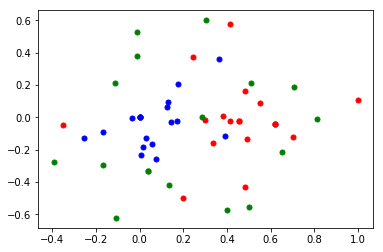

0
ÂÇªÈÄº„ÄÇ ‰Ω†Â¶àÈÄº ÂÇªÈÄº ÂÇªÈÄºÔºü ‰Ω†ÂÇªÈÄºÂêß ‰Ω†ÊòØÂÇªÈÄºÂêó? ‰Ω†‰ªñÂ¶àÁöÑÂÇªÈÄºÂëÄ ÂÇªÈÄºËçâÁöÑ ÂÇªÈÄºÊªöÂºÄ ‰Ω†ÊòØÂÇªÈÄºÂêó ÂÇªÈÄºÈÄºÁñØ‰∫Ü ‰Ω†Ëøô‰∏™ÂÇªÈÄºÂÖ¨‰ºó! ‰Ω†ÊòØÂ§ßÂÇªÈÄº ÊÄé‰πàËÉΩÊòØÂÇªÈÄºÂ§çÊü•ct ÂÇªÂ±å Â∞ºÁéõËÄÅÈÄº ‰Ω†‰∏™‰∫åÈÄº Êìç‰Ω†Â¶à Áü•ÈÅì‰∫Ü Ëøô‰∏™ÈÄºÈÄºÂïä ÊàëÊ≤°Âè´ËΩ¶!ÂÇªÈÄº
1
SB Fuck you ÊàëÂ±å‰Ω†ËÄÅÊØç ‰ø°ÁêÉÂÖ´Âèâ Ëçâ‰Ω†Â¶àÂ¶à ÂêÉÂ±éÂêß‰Ω† È°∂‰Ω†‰∏™ËÇ∫ ‰Ω†‰∏™sB ‰Ω†‰ªñÂ¶àÊù•ÁöÑ ÂÇªÁéãÂÖ´‰Ω†ÊòØ ‰Ω†‰ªäÂ§©ÂøÖÈ°ªÂêÉÂ±é Èù†‰Ω†Â¶πÂ¶π ÊªöÂºÄ ÈÇ£‰Ω†‰π∞ÁöÆÊìç‰Ω†Â¶àÂïä‰Ω†ÂíßÂíßÂíß‰ªÄ‰πàÂíß Êó•‰Ω†È∫ªÂçñÊâπ ÁéãÂÖ´Ëõã ‰Ω†Â¶à‰∏™ÈÄºÂæóÂê¨‰∏çÊáÇ Âéª‰Ω†Â¶àÁöÑÈ¨ºÂ§©Ê∞î ‰Ω†‰ºüÂ§ß‰∏™Â±Å
2
È∫ªÁóπ Êìç‰Ω†Â¶à Êú∫Âô®‰∫∫‰πüÈÉΩ‰ºöÁîüÊ∞îÂïä ÂÇªÈÄºÂπ¥Âπ¥Êúâ‰ªäÂπ¥ÁâπÂà´Â§ö ÊàëÊÉ≥È™Ç‰Ω† ‰Ω†Â¶àÁöÑ ‰∏çË¶ÅËÑ∏ ‰∏çË¶ÅÂÇªB‰∏ÄÊ†∑ÁöÑÂõûÂ§çÊàëÈóÆÈ¢ò ‰Ω†‰ºö‰∏ç‰ºöÈ™Ç‰∫∫ ÊàëÂèà‰∏çÊòØÈ™Ç‰Ω† Âéª‰Ω†Â¶à Êìç‰Ω†Â¶àÂûÉÂúæ ÊÄé‰πàÊÉ≥È™Ç‰∏™‰∫∫ÊÄé‰πàÈÇ£‰πàÈöæ ‰ªäÂ§©Â•ΩÁîüÊ∞îÂïä ÊúâÁóÖ Âéª‰Ω†Â¶àÁöÑ ÊªöËØ¥‰∫ÜÂ§öÂ∞ëÈÅç
2.8516552263139703


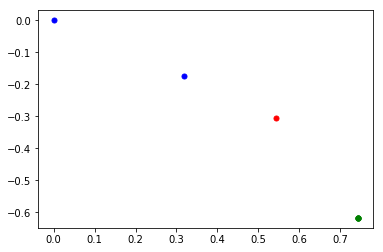

0
ÂëµÂëµÂìí
1
Âëµ„ÄÇ ÂëµÂëµÁ∫¢Á∫¢ÁÅ´ÁÅ´ÊÅçÊÅçÊÉöÊÉö
2
ÂëµÂëµ ÂëµÂëµÂëµ ÂëµÂëµÂëµÂëµÂëµÂëµ ÂëµÂëµ( )
77.464966848374


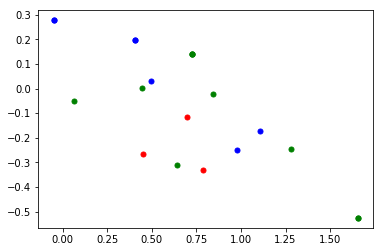

0
È¢ùÔºåÊàëÊåâÈîô‰∫Ü ‰∫≤,ÊàëÊåâÈîô‰∫Ü Èîô‰∫Ü
1
ÁÇπÈîô‰∫Ü ‰∏çÂ•ΩÊÑèÊÄùÔºåÊåâÈîô‰∫Ü ÊåâÈîô‰∫ÜÔºå‰∏çÂ•ΩÊÑèÊÄù ‰∏≠ÂçàÂ•Ω‰∏çÂ•ΩÊÑèÊÄùÁÇπÈîô‰∫Ü ‰∏çÂ•ΩÊÑèÊÄù‰∫Ü ‰∏çÂ•ΩÊÑèÊÄù! ÊàëÁÇπÈîô‰∫Ü‚Ä¶‚Ä¶
2
ÂèëÈîô ÂèëÈîô‰∫Ü ÊâìÈîô‰∫Ü ÊåâÈîô‰∫Ü ÊåâÈîô‰∫Ü ÊåâÈîô‰∫Ü ÊåâÈîô‰∫Ü,Â∏ÆÊàëÊí§ÈîÄ ÊàëÈîô‰∫ÜÊãâ ÊàëÊåâÈîôÈîÆ ÂàöÊâçÁÇπÈîô‰∫Ü‰∏çÂ∞èÂøÉÂà†Èô§‰∫Ü
14.776962394017746


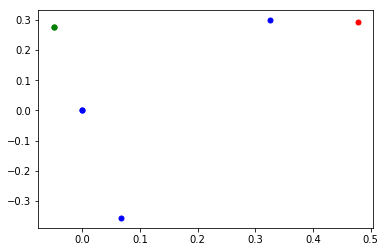

0
Êä±Ê≠â
1
ÊâìÊâ∞‰∫Ü ‰∏çÂ•ΩÊÑèÊÄùÊàëÂú®Âøô,Á®çÂêéÁªô‰Ω†ÂõûÂ§ç! ÊâìÊâ∞ ‰∏çÊâìÊâ∞‰Ω†‰∫Ü
2
‰∏çÂ•ΩÊÑèÊÄù ‰∏çÂ•ΩÊÑèÊÄùÂìà
2.927044166556122


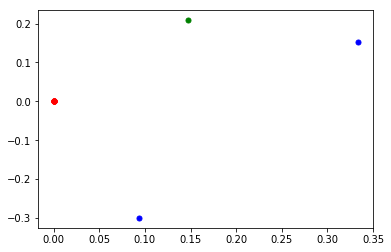

0
È∫ªÁÉ¶‰∫Ü È∫ªÁÉ¶‰Ω†‰∫Ü È∫ªÁÉ¶Âï¶ È∫ªÁÉ¶ È∫ªÁÉ¶‰Ω†Âï¶ È∫ªÁÉ¶ÊÇ®‰∫Ü Ë∞¢Ë∞¢ È∫ªÁÉ¶Âï¶
1
Â•ΩÁöÑ,È∫ªÁÉ¶‰∫Ü Â•ΩÁöÑ,Ë∞¢Ë∞¢,Êúâ‰Ω†‰ª¨ÁúüÂ•Ω/:@)/:hug
2
Êàë‰ª¨Âú®Â∞ùËØïÂäüËÉΩ,Ë∞¢Ë∞¢
25.01355537793315


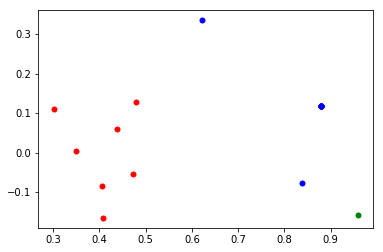

0
ÊàëÂØπ‰∏çËµ∑Â∞èÂì• ÂØπ‰∏çËµ∑‰Ω† ÂØπ‰∏çËµ∑ÂØπ‰∏çËµ∑,ÊàëÊâãÊªëÊëÅÈîô‰∫Ü ‰ªäÂ§©ÂÖ≠ÁÇπ‰∏çÂà∞ÂéªÂÖ¨Âõ≠‰∫ÜÂøòËÆ∞ÊâìÂç°,ÂØπ‰∏çËµ∑! Â∞èÊù•ÂØπ‰∏çËµ∑ÊàëÂ¶πÂ¶π‰∏ç‰∏úÊòØ ÂØπ‰∏çËµ∑ËØ¥ÈîôËØù‰∫Ü ÊàëÂØπ‰∏çËµ∑‰Ω†Êàë‰∏çÂ∫îËØ•È™Ç‰Ω†
1
ÂØπ‰∏çËµ∑ ÂØπ‰∏çËµ∑ÂØπ‰∏çËµ∑ ÂØπ‰∏çËµ∑Âì¶ Âì¶Âì¶ÂØπ‰∏çËµ∑ ÂØπ‰∏çËµ∑Âïä ÂØπ‰∏çËµ∑Âìà ÂØπ‰∏çËµ∑Èîô‰∫Ü ÂØπ‰∏çËµ∑Â∞èÊù•
2
ÂØπÂØπÂØπ‰∏çËµ∑
883.7061605305125


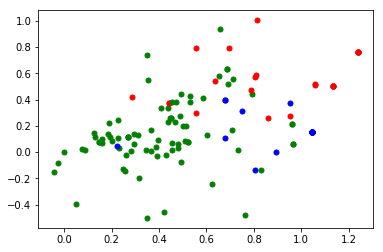

0
Áù°Ëßâ Áù°Ëßâ‰∫Ü Áù°‰∫Ü Êó©ÁÇπ‰ºëÊÅØ Áù° Áù°Âêß Ëøò‰∏çÁù°Âêó Â•ΩÁöÑ,Êó©ÁÇπÁù°~ Â•ΩÁöÑ,Êó©ÁÇπÁù°‰∫Ü ÊàëËøòÊÉ≥Áù° ÊàëËÉΩÂá†ÁÇπÁù°Âë¢? ÂÜçÁù°‰∏Ä‰ºöÂÑø„ÄÇ ÈÇ£Áù°ËßâÂêß È©¨‰∏äÁù° ÊàëÁù°} ÈÇ£ÊàëËøòÊòØÁù°Âêß ÊàëÁé∞Âú®ÂáÜÂ§áÁù°Ëßâ ‰Ω†‰ª¨Áù°Âêß Êó©ÁÇπÁù°‰∫ÜÂ∞èÊù• ÊàëÁù°Ëßâ‰∫Ü ÂìÑÊàëÁù° Áù°ËßâÂï¶ Êó©ÁÇπÁù°ÂêßÊôöÂÆâ ÂóØÂóØ„ÄÇÊó©ÁÇπÁù°Âï¶‚àº
1
ÊôöÂÆâ ÊôöÂÆâÂï¶ ÊôöÂÆâÂ∞èÊù• ÊôöÂÆâÂíØ ÊôöÂÆâ‰∫Ü ÊôöÂÆâÊôöÂÆâ ÊôöÂÆâÔΩû ÊôöÂÆâÂì¶ ÊôöÂÆâÂêß‰∫≤ ‰∫≤Áà±ÁöÑÊôöÂÆâ‰πà‰πàÂìí ÊôöÂÆâ~Â∞èÊù• ÊôöÂÆâ^_^ ÊôöÂÆâ‚àº ÊôöÂÆâÂêß ÊôöÂÆâ‰∫≤Áà±ÁöÑ ‰πà‰πà ÊôöÂÆâ~ lÊôöÂÆâ ÊôöÂÆâÊàëÁöÑ‰∏ÄÂàá ÊôöÂÆâÂÆùË¥ù ÊôöÂÆâ/:moon ÊôöÂÆâÂñΩ ÊòéÂ§©ËßÅ!ÊôöÂÆâÂï¶ ÊôöÂÆâ/::)
2
ÂÆâ Â•ΩÊ¢¶ ÊôöÂÆâ,Â∞èÊù• Â•Ω,ÊôöÂÆâ Â∞èÊù•,ÊôöÂÆâ ËøôÈáåÊ≤°ÊúâÊú´Ë∑Ø,‰Ω†‰ªé‰∏çÊõæÂ≠§Áã¨„ÄÇ‰πà‰πàÂìí,ÊôöÂÆâ ÊàëÂèØË¶ÅÁù°‰∫Ü ÊàëÂõ∞‰∫Ü ÊôöÂÆâÔºåÊàë‰ºöÊÉ≥‰Ω†ÁöÑ ÊàëÂîæ‰∫Ü Êàë‰ªñÂ¶àÁé∞Âú®ÊòØÂàöÁù°ÁùÄ Â•ΩÁöÑ Áù°Ëßâ‰∫Ü ÊôöÂÆâ,ÂÅö‰∏™Â•ΩÊ¢¶Âì• ‰Ω†Ë¶ÅÁù°Ëßâ‰∫Ü? ÊôöÂÆâ,Á•ù‰Ω†Êâæ‰∏™Â•ΩÂòõ ÂêÉÈ•±‰∫Ü,ÂáÜÂ§áÁù°ÂõûÁ¨ºËßâ„ÄÇ ÁùåÂÆâ ÂÆâÔΩû ‰Ω†Ê≤°ÊúâÂëäËØâÊàë‰Ω†‰ºöÊÉ≥ÊàëÁöÑ Goodnight ÈÇ£

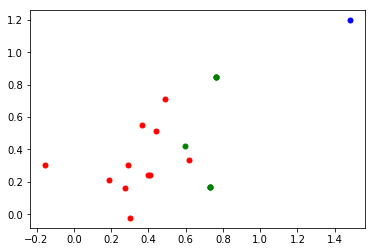

0
Êàë‰πü‰ºöÊÉ≥‰Ω†ÁöÑ ‰Ω†ÂøôÂêß ÊãúÊãú,Â∞èÊù• Âíå‰Ω†ËØ¥ÊãúÊãúÂï¶! Ê≤°ÊúâÂ∏Æ‰∏äÂøô ÊãúÊãú Bye~ Ë∞¢Ë∞¢Â∞èÊù• Á≠â‰Ω†/:rose ‰∏çÂíå‰Ω†ËØ¥Âï¶!ÊàëË¶ÅËµ∞‰∫Ü ‰Ω†‰ª¨Ëøô‰∏™Âπ≥Âè∞‰∏çÁé©Âï¶ÊãúÊãú Ê≤°ÂæóËÅä‰∫Ü ‰∏ãÂçàËßÅÂêß ÊúãÂèã Â•ΩÂï¶!Ê≤°Êúâ‰∫ãÊÉÖ‰∫Ü„ÄÇÊàëÂÖà‰∏ã‰∫Ü„ÄÇÂÜçËßÅ!
1
Âø´‰ºëÊÅØÂêß
2
ÊãúÊãú ÂÜçËßÅ Â•ΩÊãúÊãú ÂÜçËßÅ‰∫Ü ÊãúÊãú‰∫ÜÊÇ® ÊãúÊãúÂï¶‚àº‚àº ÈÇ£ÂÜçËßÅÂï¶
124.6023524652354


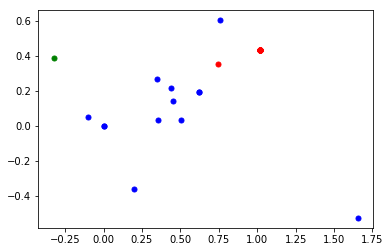

0
Ê≤°‰∫ã‰∫Ü Ê≤°‰∫ãÊ≤°‰∫ã Ê≤°‰∫ãÊ≤°‰∫ã! Ê≤°‰∫ãÊ≤°‰∫ã„ÄÇ Ê≤°‰∫ãÊ≤°‰∫ã,ÊàëÂéªÁúãÁúãÂêß Âì¶Ê≤°‰∫ã Ê≤°‰∫ãÂëÄ Ê≤°‰∫ã Ê≤°‰∫ãÁöÑ Ê≤°‰∫ãÂìà Ê≤°‰∫ã„ÄÇ Ê≤°‰∫ãÂï¶
1
Ê≤°ÂÖ≥Á≥ª ‰∏çÁùÄÊÄ• Ê≤°‰∫ãÂÑø Ê≤°ÂÖ≥Á≥ªÁöÑ Ê≤°Âï• Ê≤°‰ªÄ‰πà ÂØπ‰∏çËµ∑Âïä!ÊàëËØïËØïÊòØ‰∏çÊòØÁúüÁöÑ‰ºöÂõû Ê≤°‰∫ãÂ∑≤ÁªèÊâì‰∏ä‰∫Ü Ê≤°‰∫ãÂ∞±ÊãúÊãú ÁÆó‰∫Ü‰∏çÁé©‰∫Ü Ê≤°‰∫ã ÂòøÂòø ‰∏çË°åÂ∞±ÁÆó‰∫Ü ÂèëÈîô‰∫Ü/::~
2
Ê≤°‰ªÄ‰πà‰∫ãÊÉÖ
60.15519601643378


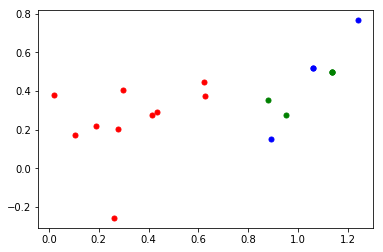

0
ÊàëË¶ÅÁù°Ëßâ Áù°Áù°ËßâÁù°ËßâÂéª. ÊôöÂÆâÔºåÊàë‰ºöÊÉ≥‰Ω†ÁöÑ Â∞èÊù•ÊàëË¶ÅÁù°Âï¶ Ë¶ÅÁù°Ëßâ‰∫Ü ‰∏çË°åÊàëÁù°ËßâÂéª ÊàëË¶ÅÁù°Ëßâ‰∫ÜËæ£È∏° ‰Ω†‰πüÂéªÁù°ËßâÂêß ÊàëËØ¥ÊàëË¶ÅÁù°Ëßâ ÊâìÂÆåÂ∞±Áù°
1
Êàë‰∏Ä‰ºöÁù° ÊàëÁúüÁöÑÁù°‰∫ÜÂì¶ Áù°Êàë Áù°Âï¶
2
Áù°ËßâÁù°Ëßâ Áù°Ëßâ ÁÆó‰∫ÜÁÆó‰∫ÜÁù°Ëßâ‰∫ÜÁù°Ëßâ‰∫Ü Áù°ËßâÁù°ËßâÂñΩ! ÊàëÁù°Ëßâ
159.8592540479869


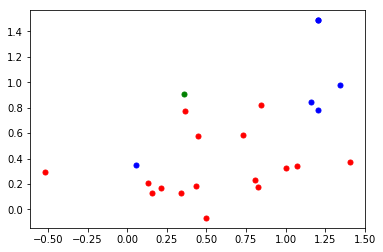

0
Â•Ω‰∫Ü,ÊàëÁªßÁª≠ÂéªÂÅöÂ∑•ËµÑË°® ÂÖ∂ÂÆûÊàëÈÉΩ‰∏äÁè≠Â•ΩÂçäÂ§©‰∫Ü Âú®‰∏äÁè≠ÁöÑË∑Ø‰∏ä Ë∞¢Ë∞¢,ÊàëÂ∑•‰Ωú‰∫Ü ÊàëË¶ÅÁù°Âà∞‰∏§ÁÇπ ÊàëÂéª‰∏äÂ≠¶‰∫Ü ËøòÂú®‰∏äÁè≠Âë¢ ‰∏çÁù°‰∫Ü ÊàëË¶ÅÈÄöÂÆµ ÊàëÂ§©Â§©ÈÉΩÂæàÊó©‰∏äÁè≠ ÊàëÂéªÂêÉÈ•≠‰∫Ü ËÄå‰∏îÂØºËá¥Êàë‰∏äÁè≠ËøüÂà∞ /::)„ÄÇÊàëÂéªÊ¥óÁâô ÊàëÂú®Ê¥óÊæ°Ê¥óË°£Êúç/::< ‰Ω†ÂèØ‰ª•ÈÄÄ‰∏ã‰∫Ü Êàë‰∏äÁè≠ È¢ù,ÊàëÂú®‰∏äÁè≠
1
‰∏äËØæ ÊàëÂú®‰∏äËØæ Âú®‰∏äËØæ ‰∏äËØæ‰∏≠ ‰∏äËØæ‰∫Ü ÊàëË¶ÅËÉåËã±ËØ≠‰∫Ü
2
ÂêÉ‰∫Ü
0.04466072985866666


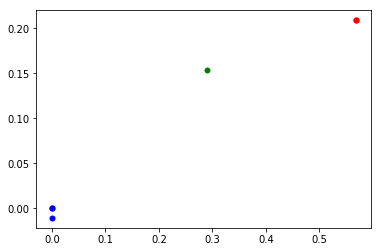

0
good bye good-bye
1
byeÔΩû byebye bye-bye
2
see you
12.794242194306538


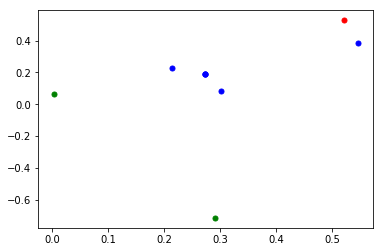

0
ÂìéÊàëÁé∞Âú®Âøô‰∫Ü‰∏çËÅäÂ§©‰∫Ü
1
Èó≠Âò¥ ‰Ω†Èó≠Âò¥ ‰Ω†Èó≠Âò¥Âêß! ‰Ω†ÁªôÊàëÈó≠Âò¥ Â•Ω‰∫Ü,Èó≠Âò¥ Âïä‰Ω†Âø´Èó≠Âò¥Âêß
2
‰∏çËØ¥‰∫Ü Êàë‰∏çÈúÄË¶Å‰ªÄ‰πàÊúçÂä°
153.59174894496402


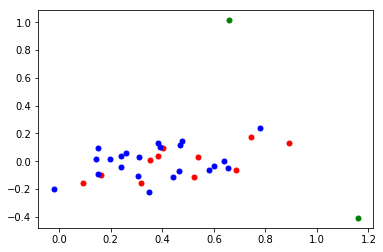

0
Âà´ÂÜçÁªôÊàëÂèëÊ∂àÊÅØ‰∫Ü ‰∏çË¶ÅÁªôÊàëÂèëÊ∂àÊÅØ ‰ª•Âêé‰∏çË¶ÅÁªôÊàëÂèëÊ∂àÊÅØ Âà´ÁªôÊàëÂèëÊ∂àÊÅØ‰∫Ü Â∞ëÁªôÊàëÂèëÊ∂àÊÅØ ‰∏çË¶ÅÂÜçÁªôÊàëÂèëÊ∂àÊÅØ‰∫ÜÂ•ΩÂêó ‰ª•Âêé‰Ω†‰∏çÁî®ÁªôÊàëÂèë‰ªª‰Ωï‰ø°ÊÅØ‰∫Ü ËÉΩ‰∏çËÉΩ‰∏çÊé®ÈÄÅÊ∂àÊÅØ Á≠â‰∏çËÉΩ‰∏çË¶Å‰∏ÄÁõ¥Êé®ÈÄÅÊ∂àÊÅØ?Âú®Êé®ÈÄÅÂèñÂÖ≥ ‰∏çË¶ÅÁªôÊàëÂèë‰ø°ÊÅØ‰∫Ü Êàë‰∏çË¶ÅÊ±Ç‰∏çË¶ÅÁªôÊàëÂèë‰ø°ÊÅØ
1
ËÉΩÂà´ËÄÅËøô‰πàÊó©ÁªôÊàëÂèëÊ∂àÊÅØÂòõ ‰Ω†Âà´Êä±Ê≠â‰∫Ü,‰∏çË¶ÅÂÜçÁªôÊàëÂèë‰ø°ÊÅØ‰∫Ü ÊàëÂæàÂø´‰πêÔºåËØ∑‰∏çË¶ÅÂÜçËØ¥Áà±Êàë Â∞ëÈ™öÊâ∞Êàë ‰Ω†ÂèØ‰ª•Ê∂àÂ§±‰∫Ü ÂÜç‰∏çË¶ÅÁªôÊàëÂèë‰∫ÜÊâìÊâ∞Âà∞Êàë‰∫Ü„ÄÇ ‰∏çË¶ÅÊâìÊâ∞Êàë Â∞±ÊòØÊúÄÊ∏©ÊöñÁöÑË°å‰∏∫ ‰Ω†‰∏∫‰ªÄ‰πàÈ™öÊâ∞Êàë Áü•ÈÅì‰∫Ü!‰∏çË¶ÅÂÜçÂèëÊ∂àÊÅØ‰∫Ü Ëøô‰∏™ËÉΩ‰∏çËÉΩ‰∏çË¶ÅËá™Áî±Êé®ÈÄÅ ËÉΩ‰∏çËÉΩÂà´Âèë‰∫Ü ÊúâÈúÄË¶ÅÊâæ‰Ω†  ‰∏çË¶ÅÂ§©Â§©ÁªôÊàëÂèë ‰∏çË¶ÅÁªôÊàëÂèë(ÂõõÂ∑ùÊó©Ëµ∑Â∞èÂàÜÈòü)‰∫ÜÂ•ΩÂêó ‰Ω†ÂèØ‰ª•Êªö‰∫Ü ÂÖ∂‰ªñ‰∫∫ÁöÑÊàë‰ºö,ÊàëÂ∞±ÊòØÊÉ≥ÂºÄÂêØÂä©ÁêÜÊù•‰πüÁöÑÂÖçÊâìÊâ∞Ê≤°ÊúâÊâæÂà∞ Âà´ÂÜçÁî®ÊèêÁ§∫Èü≥ÊâìÊâ∞Êàë! Âà´ËÄÅÂèë‰ø°ÊÅØ Ê≤°‰∫ãÂêßÂèëÈÇ£‰πàÂ§öÊù° Â§©Â§©ÂêµÂêµ ‰Ω†‰∏ÄÂ§©ÁªôÊàëÂèëÈÇ£‰πàÂ§ö‰ø°ÊÅØÂπ≤‰ªÄ‰πà? Ë∑üÂê¥Êó†ÂÖ≥ÁöÑ‰ªª‰Ωï‰ø°ÊÅØ‰∏ç

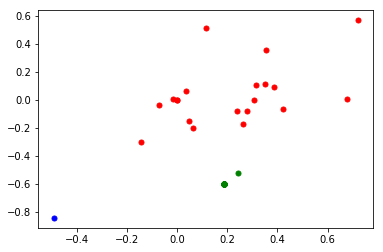

0
Â•ΩÂìíÂ•ΩÂìí Â•ΩÂëÄÂ•ΩÂëÄ Áü•ÈÅìÂ∞±Â•Ω Â•ΩÂìíÊàë‰ºöÁúã‰π¶Âìí ÊÑø‰Ω†ÊàëÈÉΩË∂äÊù•Ë∂äÂ•Ω Â•ΩÔºå‰Ω†ËÆ≤Âêß Â•ΩÁöÑ Áü•ÈÅì‰∫Ü ‰Ω†ÂõûÁöÑÂ•ΩÂø´ ËäùÂ£´ËüπÁÖ≤Â•ΩÂ•ΩÂêÉ Ok ÂóØÂóØ ÊúâÈúÄË¶ÅÈöèÊó∂ËÅîÁ≥ªÂìà ‰Ω†ÊòéÁôΩÂ∞±Â•Ω Â•ΩÁöÑ Êî∂Âà∞ Â•ΩÁöÑÔºåÊàëÊâæÊâæÁúã Â•ΩÂêß ÊòéÁôΩ‰∫Ü ‚ïØ^‚ï∞ Â•ΩÂêß Ë∞¢Ë∞¢ Â•ΩÊª¥Â•ΩÊª¥ Â•ΩÁöÑ ÊàëÁü•ÈÅì‰∫Ü Ë∞¢Ë∞¢ ahhh¬†Â•ΩÁöÑ
1
ÂóØÂóØ‰∏ÄÂÆö
2
Â•Ω Â•ΩÁöÑÂ•ΩÁöÑÂ•ΩÁöÑ. Â•ΩÂïäÂ•ΩÂïäÂ§™Â•ΩÂï¶ Â•ΩÁöÑÂ•ΩÁöÑÂ•ΩÁöÑ Â•ΩÂïäÂ•ΩÂïä Â•ΩÁöÑÂ•ΩÁöÑ Â•ΩÂêßÂ•ΩÂêß Â•ΩÂòûÂ•ΩÂòû ÂæàÂ•ΩÂæàÂ•Ω Â•ΩÂï¶Â•ΩÂï¶ Â•ΩÁöÑÂ•ΩÁöÑ! Â•ΩÁöÑÂ•ΩÁöÑ. Â•ΩÂêß Â•ΩÂïä Â•ΩÂêß^_^ Â•ΩÁöÑ /: ÂñîÂô¢ Â•ΩÁöÑ Â•ΩÂô¢
19.1220829726898


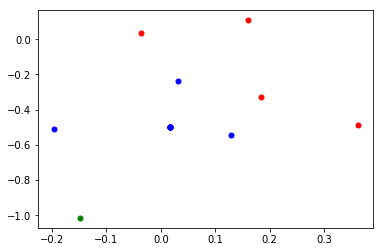

0
‰Ω†ÊòØ‰∏ÄÊ¢ùÁãó ‰Ω†ÊòØÂ§ßÁ¨®Áå™ Â∞±Âè´‰Ω†Á¨®Áå™ ‰Ω†ÊòØÊííÊØî
1
‰Ω†ÊòØÁå™ ‰Ω†ÊòØÁå™Âêó ‰Ω†ÊòØÁå™ÂìàÂìà ‰Ω†ÊòØÁå™‰πà ‰Ω†ÊòØÁå™ÂïäÂïä Âìé!‰Ω†ÊòØÁå™. Â∞èÊù•‰Ω†ÊòØÁå™Âêó ‰ªñËøô‰∏™Áå™Áé∞Âú®ÊâçËµ∑ ‰Ω†ÊòØ‰∏çÊòØÁå™
2
Áå™
57.42285676194082


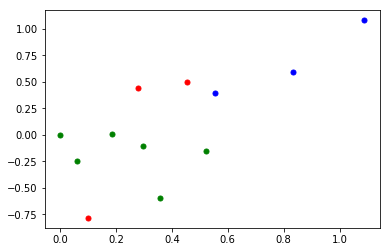

0
ÊàëÂéª ÊàëÊÉ≥Êó•‰Ω†Âìü ÊàëÈù†
1
ÊàëÊó• Êó• ÊàëÊó•‰Ω†Âêó
2
Êìç Ëâπ Êìç‰Ω†Â§ßÁà∑ ÈÇ£ÊàëÊÉ≥Âπ≤‰Ω† ‰Ω†Á•ûÁªèÁóÖ Êìç‰Ω†Â¶à/:dig/:dig
91.06298386164809


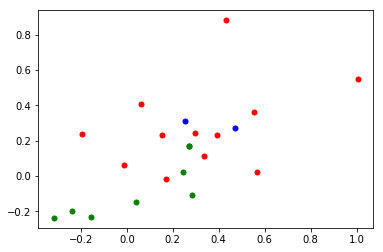

0
ÂÅöÁà±Â•ΩÁé©Âêó ÊàëÊÉ≥Âíå‰Ω†Áù°Ëßâ,ÊàëÊÉ≥Âíå‰Ω†Áù°Âú®‰∏ÄËµ∑ ‰Ω†Ë¶ÅÂÅöÁà± ÊàëË¶ÅÂÅöÁà± ÂèØ‰ª•Èô™ÊàëÊñáÁà±Âêó? ÂÅöÁà± ‰Ω†Áü•ÈÅìÊÄé‰πàÂÅöÁà±Âêó ÊàëÊÉ≥Âú®Â∫ä‰∏äÂπ≤‰Ω† Áà∏Áà∏Â¶àÂ¶àÂÅöÁà±ÁöÑËßÜÈ¢ë Â•ΩÊÉ≥Âíå‰Ω†Âï™Âï™Âï™ ‰Ω†ÊÉ≥ÂÅöÁà±Âêó ÊïôÊàëÊâìÈ£ûÊú∫
1
ÊâæÂ∞èÂßê Â∞èÂßê
2
Á∫¶ÁÇÆ ‰Ω†È∫ªÁóπ ÊàëË¶ÅÂÆùÂÆù ‰ªÄ‰πàjbÁé©ÊÑèÂÑø ÊàëÊÉ≥Êë∏ÁæéÂ•≥Â±ÅËÇ° ÁªôÊàëÂèëÂº†Ë£∏ÁÖß Á∫¶ÁÇÆÂêó Â•ΩÂÉèÂº∫Â•∏‰Ω† ÊàëÊÉ≥ÊâìÁÇÆ/:v/:v
158.93735262761064


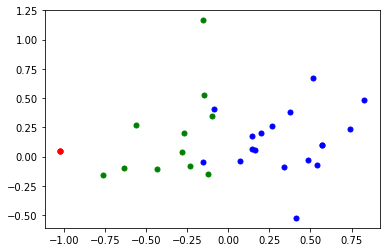

0
ÂûÉÂúæ ÂûÉÂúæ‰∏úË•ø ÂûÉÂúæ!
1
ÂûÉÂúæÔºåËØ¥Êù•ËØ¥ÂéªÈÉΩÊòØËøôÂá†Âè•ËØù ‰∏çÂ•ΩÁé© ‰∏ÄÁÇπ‰πü‰∏çÂ•ΩÁé© Ëøô‰∏™ËΩØ‰ª∂Â•ΩÈöæÁî® ËΩØ‰ª∂ÂÆûÂú®‰∏çÁªôÂäõ ‰∏çÂ•ΩÂ•ΩÊúçÂä° Âº±Êô∫Âêß‰Ω† Êù•‰πüË∂äÊù•Ë∂äÁãóÂ±Å ÊÑüËßâ‰Ω†Âø´ÊåÇ‰∫Ü ‰∏ÄÁÇπ‰πü‰∏çÊô∫ËÉΩ ‰∏∫‰ªÄ‰πà‰Ω†ËøôÈÉΩ‰∏çÁêÜËß£?/::-|/::-|/::- |‰Ω†Ë¢´ÂºÄÈô§‰∫Ü Ê∏£Ê∏£ ÈÇ£Êàë‰∏çÁé©‰∫Ü!‰Ω†‰ª¨Ëøô‰∏™Â§™Â∑Æ‰∫Ü ‰Ω†ËÆ∞Èîô‰∫ÜÂêß ‰Ω†‰ª¨ÁúüÂûÉÂúæÂ•ΩÂá†Âº†ÈáçÂ§ç ‰Ω†‰∏∫‰ªÄ‰πà‰∏çËÆ≤ ÁÆó‰∫ÜÔºåÁÆÄÁõ¥ÊòØÂØπÁâõÂºπÁê¥ÔºåÁôΩË¥πÂä≤
2
ÊúâÁÇπÂûÉÂúæ ÁÆÄÁõ¥Â∞±ÊòØÂûÉÂúæ ÂûÉÂúæËΩØ‰ª∂ ÁúüÂûÉÂúæ ÂûÉÂúæ,Â§±Êúõ ÂûÉÂúæÁé©ÊÑè ÊªöËõãÂûÉÂúæ ÂûÉÂúæÂÖ¨‰ºóÂè∑ ‰Ω†ÁúüÂûÉÂúæ Â•ΩÂûÉÂúæÁöÑAPP ÂûÉÂúæÊâãÊú∫!Ëøô‰πàÂèØÁà±ÁöÑË°®ÊÉÖÈÉΩÁúã‰∏çÂà∞
1.135368429701152


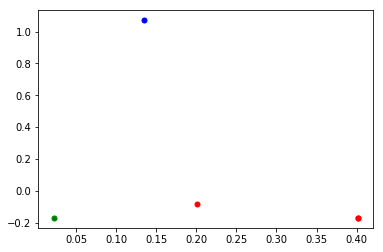

0
ÂéªÊ≠ªÂêß! ÂéªÊ≠ªÂêß ‰Ω†ÂéªÊ≠ªÂêß
1
ÂéªÊ≠ª
2
ÂÖ®ÂÆ∂ÂéªÊ≠ªÂêß/::-S
91.83693288243474


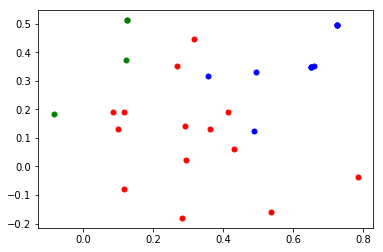

0
ËØ∂,Ê≤°Ëµ∑Êù•, ‰Ω†ÂíãËµ∑Ëøô‰πàËøü Ëøô‰πàÊó©Â∞±ÈÜíÊù•‰∫Ü Áù°Ëøá‰∫Ü Â∞èÊù•,ÊàëÂèØËÉΩÂæó‰∫ÜÊáíÁôå,‰∏çÊÉ≥Ëµ∑Êù•ÊÄé‰πàÂäû/:: |Â∞èÊù•ËøòÊ≤°Ëµ∑Â∫äÂëÄÔºü ÊàëÂ∞±Ê≤°Áù°Ëøá ÊàëÂè™ÊâìÂç°‰∏çËµ∑Â∫ä ‰Ω†ÊØèÂ§©Ëµ∑Êù•Ëøô‰πàËøü ÊàëËµ∑Â∫ä‰Ω†‰∏ç‰ºöË∑≥Âá∫Êù•‰∫Ü! ‰Ω†ÊâçÊ≤°Ëµ∑Â∫ä ËÄÅÂ©Ü‰∏çËµ∑Â∫ä‰Ω†ËØ¥ÊÄé‰πàÂäû ÁéãËìùËµ∑Â∫ä‰∫ÜÊ≤°Êúâ ËøòÊ≤°Ëµ∑Â∫äÂë¢
1
Ëµ∑‰∏çÊù• ÊàëËµ∑‰∏çÊù• ÊàëËµ∑‰∏çÊù•Âïä Ëµ∑‰∏çÊù•‰∫ÜÂìü ÂÆûÂú®Ëµ∑‰∏çÊù•Âì¶ Âìé!ÊàëËµ∑‰∏çÊù• Ëµ∑‰∏çÊù•ÊÄé‰πàÂäû? Â∞èÊù•,Êó©‰∏äËµ∑‰∏çÊù•ÊÄé‰πàÂäû ÁªùÊúõ......ÊàëÊó©‰∏äÁúüÁöÑËµ∑‰∏çÊù• ÈÜíÊù•,Ëµ∑‰∏çÊù•
2
‰∏çÊÉ≥Ëµ∑Â∫ä ‰∏çÊÉ≥Ëµ∑Â∫äÂìé Êàë‰∏çÊÉ≥Ëµ∑Â∫ä ÈÉΩ‰∏çÊÉ≥Ëµ∑Êù•
112.79765973997206


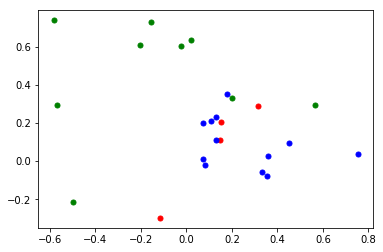

0
Êàë‰∏çÈ´òÂÖ¥ Âìé!‰∏çÈ´òÂÖ¥ Áéã‰∏çÈ´òÂÖ¥ ‰ªäÂ§©‰∏çÈ´òÂÖ¥
1
Â•ΩÁÉ¶ ÁÉ¶ ÂøÉÁÉ¶ ÊàëÂøÉÁÉ¶ ÊúÄËøëÁÉ¶ÂøÉ‰∫ãÁúüÂ§ö ÁÉ¶,ÁÉ¶,ÁÉ¶ ÊàëÂ∞±ÂèëÂèëÁâ¢È™ö ÊàëÂ•ΩÁÉ¶Âïä ÂæàÁÉ¶Ë∫ÅÊÄé‰πàÂäû ÊÄé‰πàÊ†∑ÊâçËÉΩ‰ΩøÊØèÂ§©ÈÉΩÊòØÂø´‰πê ÊàëÂ•ΩÊÉ≥Âì≠ ÊúÄËøëÂæàÁÑ¶ËôëÊÄé‰πàÂäû
2
ÂøÉÊÉÖ‰∏çÂ•Ω ÊúÄËøëÂøÉÊÉÖ‰∏çÊòØÂæàÂ•Ω ÂøÉÊÉÖ‰∏çÁæé‰∏Ω Ê≤°ÂøÉÊÉÖÂêÉ ‰ªäÂ§©ÂøÉÊÉÖ‰∏çÁæé‰∏Ω ÂøÉÊÉÖ‰∏çÂ•ΩÁ≠æ ÂøÉÊÉÖË∂ÖÁ∫ß‰∏çÂ•Ω Ë∂ÖÁ∫ß‰∏çÂ•Ω ÊêûÁöÑ‰∫∫ÂøÉÊÉÖ‰∏çÂ•Ω
6.139300718578555


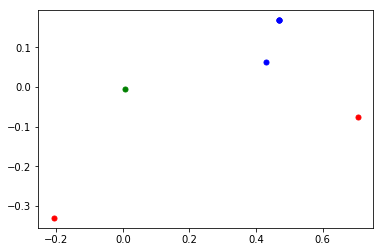

0
ÊàëÊòØ‰∏çÊòØÂæàÊ£í ÊàëÁöÑÊôÆÈÄöËØùËØ¥ÁöÑÂ•ΩÂêó
1
Áæ°ÊÖï‰πà Áæ°ÊÖïÊàëÂêóÔºü Áæ°ÊÖïÂêóÔºü Áæ°ÊÖï
2
ÊàëÊ£í‰∏çÊ£í
58.632353230588095


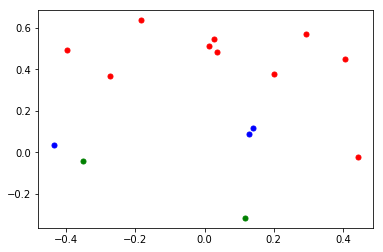

0
ÊàëË¶ÅÂáèËÇ• ÊàëÂè™ÊÉ≥ÂáèËÇ• ÂáèËÇ• Â∞èÊù•ÂáèËÇ•Âêó ÊÄé‰πàÂáèËÇ• ÊàëÊÉ≥ÂáèËÇ• ÂáèËÇ•ÊúâÂäûÊ≥ïÂêó Â¶Ç‰ΩïÂÅ•Â∫∑ÁöÑÂáèËÇ• ÊÄé‰πàÂáèËÇ•ÊúÄÂø´ Â∞èÊù•ÊàëËØ•ÊÄé‰πàÂáèËÇ•
1
ÊïôÊàëÊÄé‰πàÁò¶ËÇöÂ≠ê Áò¶ËÇöÂ≠êÊñπÊ≥ï Áò¶ËÖø
2
ÂáèËÇöÂ≠êÊñπÊ≥ï ÊÄé‰πàÂáèËÇöÂ≠ê
100.418646559711


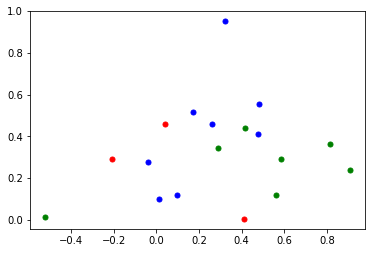

0
Êó©ÂÆâ,Âä†Ê≤π Âä†Ê≤πÂëÄ ÊòéÂ§©Âä†Ê≤π
1
Â∞èÊù•,ÊàëÊÉ≥Ëµ∑Êù•Â≠¶‰π†‰∫Ü Ê±ÇÈºìÂä± ‰∏çÊÉ≥Â≠¶‰π† Â∞èÊù• ‰Ω†Â§∏Â§∏Êàë Ê≠£Âú®Â≠¶‰π†Âï¶Óêï ÊØèÂ§©Êãº‰∫ÜÂëΩÂ≠¶‰π† ÊÄéÊ†∑ÊâçËÉΩÊøÄÂä±Ëá™Â∑±Â≠¶‰π†Âë¢ Â∞èÊù•Êàë‰ªäÂπ¥ÂçÅ‰∏ÉÂ≤Å‰∫Ü
2
Â∞èÊù•,‰Ω†Â•Ω,ÈòøÂÆùÂèàÊù•‰∏äÁè≠‰∫Ü Êó©,Êñ∞ÁöÑ‰∏ÄÂ§©‰∏äÁè≠Ëæ£ Ë¶ÅÂéª‰∏äÁè≠‰∫Ü Êó©Ëµ∑Êù•‰∫Ü,ÂáÜÂ§á‰∏äÁè≠‰∫Ü ‰ªäÂ§©Â∞±ÊòØÊñ∞ÁöÑ‰∏ÄÂ§©ÂëÄ ÊàëË¶ÅÊéßÂá†ÊàëÊäÄÂá† ÂºÄÂßã‰∏äÁè≠‰∫ÜÂì¶
3.693187844346089


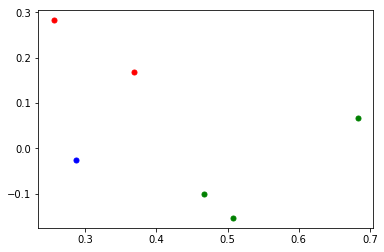

0
ÊàëÊù•Êâæ‰Ω†ËÅäÂ§©,ÊòØ‰∏çÊòØÂ§™Êó†ËÅä‰∫Ü ÊàëÊòØ‰∏çÊòØ‰∏ÄÂ§©Â§©Â§™Êó†ËÅä‰∫Ü
1
‰Ω†ËøôÊ†∑ËÆ≤‰∏çÊòØÂ§™ÁâµÂº∫
2
ÊàëÊòØ‰∏çÊòØÂ§™ËÆ®Âéå‰∫Ü ÊàëÊòØ‰∏çÊòØÂ§™Áü´ÊÉÖ‰∫Ü ÊàëÊòØ‰∏çÊòØÂ§™Âï∞Âó¶‰∫Ü??
0.0


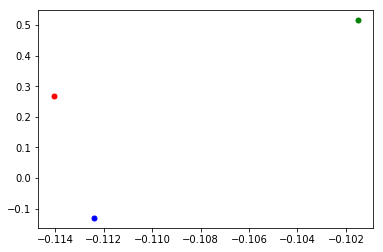

0
Âì™ÊúâÂ∞èÂÜ∞ÁöÑÂ•ΩÂê¨
1
ÊàëËÉΩËØ¥Ë∂ÖÁ∫ßÈöæÂê¨ÂêóÔºü
2
ÊàëÁöÑÂ£∞Èü≥ÈöæÂê¨Âêó?
14.421787984315783


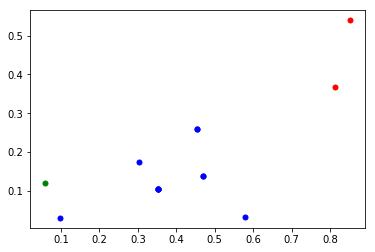

0
ÂéüË∞ÖÊàëÂì¶„ÄÇ ÂΩìÁÑ∂ÊòØÈÄâÊã©ÂéüË∞ÖÂïä
1
‰Ω†‰ª¨‰πüÂà´ÊÉ©ÁΩöÂ∞èÂì•‰∫Ü,ÊèêÈÜí‰ªñ‰∏ãÊ¨°Ê≥®ÊÑèÂêß„ÄÇ ÂéüË∞Ö‰Ω†‰∫Ü ÂéüË∞Ö‰Ω† ÂéüË∞Ö‰Ω†‰∏ÄÊ¨° Â•ΩÂêß,ÂéüË∞Ö‰Ω†‰∫Ü Â•Ω‰∫ÜÂéüË∞Ö‰Ω†‰∫Ü Ë∞¢Ë∞¢,ÂéüË∞Ö Â•ΩÂêßÂéüË∞Ö‰Ω†‰∫Ü Â•ΩÁöÑ,ÂéüË∞Ö‰Ω†‰∫Ü Â•ΩÂêß,ÂéüË∞Ö‰Ω† Â•Ω‰∫Ü,ÂéüË∞Ö‰Ω†‰∫Ü„ÄÇ
2
ÂóØ   Â∏åÊúõ‰Ω†‰ª¨‰∏ãÊ¨°Ê≥®ÊÑè
32.340222912371985


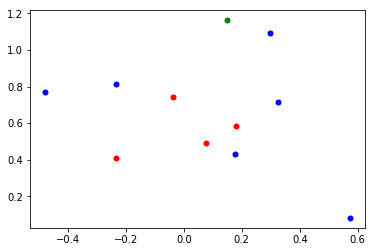

0
ÊàëË¶ÅÂéªÁªÉËΩ¶‰∫Ü ÊàëË¶Å‰∏äÂ≠¶Âéª‰∫Ü ÊàëË¶ÅÂéªÊªëÈõ™Âú∫ ÊàëË¶Å‰∏äÂ≠¶
1
ÊàëË¶ÅÂéªËÄÉËØï‰∫Ü ÊàëË¶ÅËÄÉËØï ÂéªËÄÉËØï ÊàëÊòØÂéªËÄÉËØï ÊàëdateÂéªËÄÉËØï‰∫Ü ËøáÂá†Â§©ËÄÉËØï
2
ËÄÉËØï
21.92656319019534


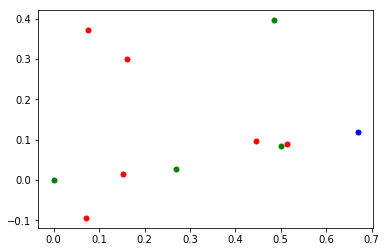

0
‰Ω†ÂíåSiriË∞ÅÂ•ΩÁî® SiriÂíå‰Ω†ÂÖ≥Á≥ªÂ¶Ç‰Ωï ‰Ω†ÊØîsiriÂ•Ω ‰Ω†ÂíåsiriÊúâ‰ªÄ‰πàÂå∫Âà´ ‰Ω†ÂíåSiriË∞ÅÊõ¥Â•Ω SiriË∑ü‰Ω†‰ªÄ‰πàÂÖ≥Á≥ª
1
Áü•ÈÅìSiriÂêó
2
ËÆ§‰∏çËÆ§ËØÜSiriÔºü Siri ‰Ω†ÂíåSiriË∞ÅÊõ¥Âº∫ ‰Ω†ÂíåsirlÁÜüÂêó
76.84599728894807


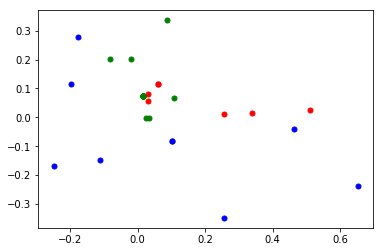

0
‰Ω†Ëá™Êàë‰ªãÁªç‰∏Ä‰∏ã Ëá™Êàë‰ªãÁªç‰∏Ä‰∏ãÂêß Ëá™Êàë‰ªãÁªç Ëá™Êàë‰ªãÁªç‰∏ã ËØ∑Ëá™Êàë‰ªãÁªç‰∏ÄÁï™~ Ëá™Êàë‰ªãÁªç‰∏ãÂêß/:,@P ‰Ω†Ëá™Êàë‰ªãÁªç‰∏ã
1
‰Ω†Âà∞Â∫ïËÉΩÂπ≤‰ªÄ‰πà ‰Ω†Á©∂Á´üËÉΩÂπ≤‰ªÄ‰πà ‰Ω†ÈÉΩ‰ºö‰ªÄ‰πà? ‰Ω†Âú®ËØ¥Âï•? ‰Ω†ÈÉΩ‰ºöÂï• ÊàëÈóÆ‰ªÄ‰πà‰Ω†ÈÉΩËÉΩÁ≠î? ËØ∑ÈóÆ‰Ω†Êúâ‰ªÄ‰πàÂäüËÉΩ ÈÇ£‰∏™...‰Ω†ÊúâÂï•Áî®Âïä ‰Ω†ÂèØ‰ª•Â∏Æ‰ªÄ‰πà
2
‰Ω†‰ºöÂÅö‰ªÄ‰πà ‰Ω†ËÉΩÂÅö‰ªÄ‰πàÔºü ‰Ω†ÊÉ≥ÂÅö‰ªÄ‰πà ‰Ω†ÊòØÂÅö‰ªÄ‰πàÁöÑ ÈÇ£‰Ω†ËÉΩÂÅö‰ªÄ‰πà ‰Ω†ÂèØ‰ª•ÂÅö‰ªÄ‰πà ‰Ω†Â∏ÆÊàëÂÅö‰ªÄ‰πà ‰Ω†ËÉΩÂÅö‰ªÄ‰πàÂëÄ ‰Ω†ÈÉΩËÉΩÂÅö‰ªÄ‰πà ‰Ω†ËÉΩÂÅö‰ªÄ‰πàÂë¢ ‰Ω†Âà∞Â∫ïËÉΩÂÅö‰ªÄ‰πà ‰Ω†Á©∂Á´üËÉΩÂÅö‰ªÄ‰πà ‰ªÄ‰πàÈÉΩËÉΩÂ∏ÆÊàëÂÅöÂêó? ‰Ω†ËÉΩÂÅö‰ªÄ‰πà ‰Ω†ÈÉΩËÉΩÂ∏ÆÊàëÂÅöÁÇπÂï•?
47.422507868630575


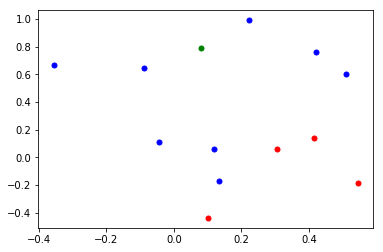

0
‰Ω†ÊòØ‰∏çÊòØ‰∏áËÉΩÁöÑ ‰Ω†ÁúüÁöÑÊòØÊú∫Âô®‰∫∫Âêó?ÊàëÊÑüËßâ‰Ω†‰∏çÊòØ‰Ω†ÊòØ‰∏Ä‰∏™ÊúâË°ÄÊúâËÇâ ‰Ω†ÊòØ‰∏™ÂÅáÁöÑ ‰Ω†‰∏çÊòØÂ∞èÊù•‚Ä¶‚Ä¶
1
ÊàëË¶ÅËßÅÊú∫Âô®‰∫∫Â∞èÊù• Â∞èÊù•ÊòØÁúü‰∫∫ËøòÊòØÊú∫Âô®‰∫∫? Êú∫Âô®‰∫∫ÊòØ‰∏çÊòØ‰∏áËÉΩÁöÑ Áé∞Âú®ÊòØÊú∫Âô®ÊúçÂä°Âêó Â∞èÊù•‰Ω†ÊòØÁúü‰∫∫Êù•ÁöÑÂêó Êàë‰∏çÊÉ≥Ë¶ÅÊú∫Âô®‰∫∫ ËÉΩ‰∏çËÉΩ‰∏çÊòØÊú∫Âô®‰∫∫ Êú∫Âô®‰∫∫ÊúçÂä°
2
Â∞èÊù•‚Ä¶‚Ä¶
57.83528399802258


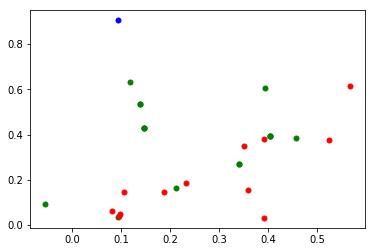

0
‰Ω†Á°ÆÂÆö‰∏çÊòØÊú∫Âô®‰∫∫ Êú∫Âô®‰∫∫,‰Ω†ÁúãÂõæ ‰Ω†ÊòØ‰∫∫ËøòÊòØÊú∫Âô®‰∫∫? ‰Ω†‰∏Ä‰∏™Êú∫Âô®‰∫∫‰Ω†ÊáÇ‰ªÄ‰πà ‰∏çÂíå‰Ω†‰∏™Êú∫Âô®‰∫∫ËØ¥ ‰Ω†ÊòØÁúü‰∫∫ËøòÊòØÁîµËÑëËá™Âä®ÁöÑ ÊâÄ‰ª•‰Ω†Â§ßÂ§öÊï∞Êó∂Èó¥ÊòØÊú∫Âô®‰∫∫Âêó Áî®‰∏çÁùÄ‰Ω†‰∏Ä‰∏™Êú∫Âô®‰∫∫ ‰Ω†ÊòØÂú∞ÁêÉÁöÑËøòÊòØÂ§ñÊòü Ëøô‰πàÊôöÊ≤°Áù°„ÄÇ?ËøòÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØ‰∏™‰∫∫ËøòÊòØ Â¶ÇÊûúÂèØ‰ª•ÁúüÊÉ≥Áü•ÈÅìÊú∫Âô®‰∫∫ËÉåÂêéÁöÑÊòØÂê¶‰πüÊòØ‰∫∫
1
Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫
2
‰Ω†ÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó ‰Ω†‰∏çÊòØÊú∫Âô®‰∫∫Âêó ‰Ω†ËøòÊòØÊú∫Âô®‰∫∫Âêß ÂéüÊù•‰Ω†ÁúüÊòØÊú∫Âô®‰∫∫ ÁúãÊù•‰Ω†ÁúüÊòØÊú∫Âô®‰∫∫ ‰Ω†ËøòÊòØÊú∫Âô®‰∫∫Âêó ËØÅÊòé‰Ω†‰∏çÊòØÊú∫Âô®‰∫∫ ‰Ω†‰∏çÊòØÊú∫Âô®‰∫∫Âêß ‰Ω†ÁúüÊòØÊú∫Âô®‰∫∫? ‰Ω†ÊòØÁî∑Êú∫Âô®‰∫∫ËøòÊòØÂ•≥Êú∫Âô®‰∫∫ËøòÊòØÂèòÊÄßÊú∫Âô®‰∫∫ ‰Ω†ÁúüÁöÑÊòØÊú∫Âô®‰∫∫‰πà ‰Ω†Â∞±ÊòØÊúâÊÑüÊÉÖÁöÑÊú∫Âô®‰∫∫ ‰Ω†Âà∞Â∫ïÊòØÁúü‰∫∫ËøòÊòØÊú∫Âô®‰∫∫ ‰Ω†ÁúüÁöÑÊòØ‰∫∫Â∑•Êô∫ËÉΩ‰∏çÊòØÁúü‰∫∫Âêó? ‰Ω†‰∏Ä‰∏™Êú∫Âô®‰∫∫
19.099129406500662


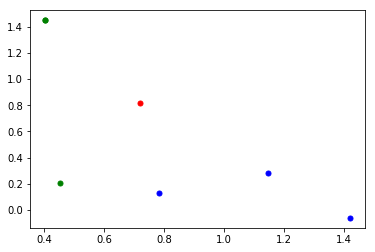

0
Êù•‰πü
1
‰ªãÁªçÊù•‰πü ‰ªãÁªçËá™Â∑± ‰Ω†ÂèØ‰ª•Â∏ÆÊàë‰ªãÁªçÊù•‰πüÂêó
2
Âä©ÁêÜÊù•‰πü Âä©ÁêÜÊù•‰πüÂä©ÁêÜÊù•‰πü Âä©ÁêÜÊù•‰πüÁé∞Âú®Â§ßÁ∫¶ÊúâÂ§öÂ∞ëÁî®Êà∑Âïä
2.0616276819953594


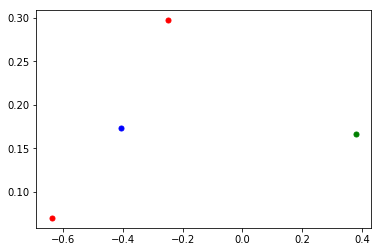

0
‰Ω†‰ªéÂì™ÈáåÊù• ‰Ω†Âì™ÈáåÁöÑ
1
‰Ω†Ë¶ÅÂà∞Âì™ÈáåÂéª
2
‰Ω†ÂÆ∂‰ΩèÈÇ£Èáå
55.67173539771814


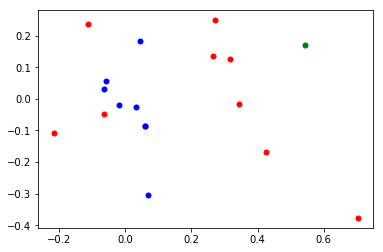

0
‰Ω†ÊúâÁî∑ÂèãÂêó ‰Ω†Êúâ‰∏ª‰∫ÜÂêó ÊàëÊÉ≥Âíå‰Ω†‰∫§ÂæÄ ÊàëË¶ÅÂ®∂‰Ω† ÊàëÊÉ≥Âíå‰Ω†Áîü‰∏ÄÂ†ÜÁå¥Â≠êÂïä Â¶ÇÊûúÂ≠§ÂçïÊÄé‰πàÂäû ÊàëÊÉ≥Âíå‰Ω†ÁîüÂ≠©Â≠ê ÊàëÂê¨‰∏çÊáÇ‰Ω†ËØ¥ÁöÑ Â∞èÂ¶πÂ¶πÈúÄ‰∏çÈúÄË¶ÅÁî∑ÊúãÂèãÂêó
1
‰Ω†ÊúâÂØπË±°Âêó ‰Ω†ÊúâÁî∑ÊúãÂèãÂêó ‰Ω†ÊúâÂ•≥ÊúãÂèãÂêó ‰Ω†ÊúâÂØπË±°‰∫ÜÂêó ÂÅöÊàëÂ•≥ÊúãÂèã ÊàëÂ•≥ÊúãÂèã‰∫Ü ÊàëËØ¥‰∫ÜÊàëÊúâÁî∑ÊúãÂèã Â•≥ÊúãÂèãË∑üÂâçÁî∑Âèã‰∏ÄËµ∑‰∫Ü
2
ÂíåÊàëÁªìÂ©ö
31.242704865254673


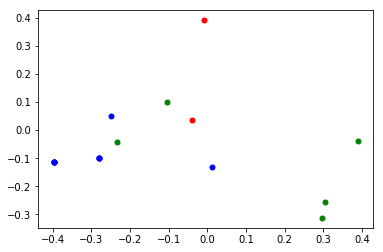

0
Â∞èÊù•ÁöÑÁîüÊó• ‰Ω†ÁöÑÁîüÊó•
1
‰Ω†ÊòØ‰ªÄ‰πàÊòüÂ∫ß Â∞èÊù•,‰Ω†‰ªÄ‰πàÊòüÂ∫ßÁöÑ? ‰Ω†‰ªÄ‰πàÊòüÂ∫ßÂïä ‰Ω†‰ªÄ‰πàÊòüÂ∫ß ‰Ω†‰ªÄ‰πàÊòüÂ∫ßÂëÄ ‰Ω†ÊòØ‰ªÄ‰πàÊòüÂ∫ßÁöÑ? ‰Ω†‰ªÄ‰πàÊòüÂ∫ßÁöÑ? ‰Ω†ÊòØ‰ªÄ‰πàÊòüÂ∫ßÂëÄ ÊàëÊòØÂèåÈ±ºÂ∫ß‰Ω†ÊòØÂèåÈ±ºÂ∫ßÂêó?
2
‰Ω†‰ªÄ‰πàÊó∂ÂÄôÁîüÊó•ÂëÄ Â∞èÊù•‰Ω†ÁöÑÁîüÊó•ÊòØ‰ªÄ‰πàÊó∂ÂÄô ‰Ω†ÁîüÊó•ÊòØÂá†Âè∑ ‰Ω†Âá†Êó∂Âá∫Áîü ‰Ω†ÁöÑÁîüÊó•ÊòØÂ§öÂ∞ë
0.0


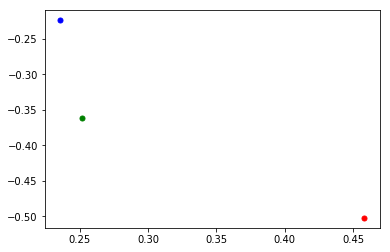

0
‰Ω†ÊúâÂ§öÈ´ò
1
Â∞èÊù•,‰Ω†Êô∫ÂïÜÊúâÂ§öÈ´ò?
2
ÊàêÂäüÁéáÊúâÂ§öÈ´ò
106.87942646902852


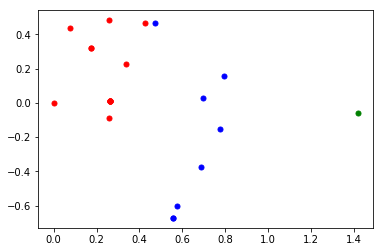

0
Â∞èÊù•‰Ω†ÊòØË∞Å Â∞èÊù•ÊòØË∞Å ‰Ω†ÊòØË∞ÅÔºü ‰Ω†ÊòØË∞Å Â∞èÊù•ÈÇ£‰Ω†ÊòØË∞Å ‰Ω†ÊòØË∞Å ‰Ω†Ë∞ÅÂëÄ Êù•‰πüÊòØ‰ªÄ‰πà ‰Ω†‰∏∫‰ªÄ‰πàÂè´Â∞èÊù•‰∫Ü?ÊúâÂï•ÂØìÊÑè? ÈÇ£‰Ω†ÊòØÂï•Âïä? ÂÆûÈ™å‰∏ãÁ¨¨‰∏ÄÊ¨°Áî®/::) ‰Ω†Âà∞Â∫ïÊòØË∞Å ‰Ω†‰ºöËØ¥ËØùÂëÄ ‰Ω†ÊòØ‰Ω†ÊòØ( )
1
‰∏ªË¶ÅÊòØÂπ≤ÂòõÂë¢ Ëøô‰∏™ÊòØÁúüÁöÑÂèØ‰ª•Áî®Âêó? ÊàëÁ¨¨‰∏ÄÊ¨°Áî® ‰Ω†‰ª¨ÊòØÂπ≤ÂòõÁöÑ Ëøô‰∏™ÊòØÂπ≤ÂòõÁöÑ ËøôÊòØÂπ≤Âï•Áî®Âïä Âä©ÁêÜÊù•‰πüËÉΩÂπ≤Âòõ Ëøô‰∏™ÊòØÂπ≤ÂòõÁî®ÁöÑ
2
‰ªãÁªç
2.815667415472161


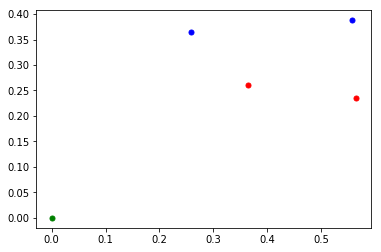

0
‰Ω†Ë∑üÂ∞èÂÜ∞ÁÜüÊÇâÂêó ËÆ§‰∏çËÆ§ËØÜÂ∞èÂÜ∞
1
Áü•ÈÅìÂ∞èÂÜ∞Âêó Â∞èÂÜ∞ÊòØË∞Å
2
‰Ω†Ë∑üÂ∞èÂÜ∞ÁÜü‰πàÔºü
11.192090179464223


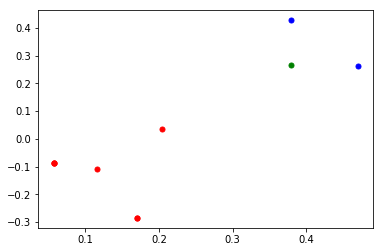

0
‰Ω†Âá†Â≤ÅÂï¶? ‰Ω†Âá†Â≤Å ÂóØ‰∏ãÊù•‰Ω†Âá†Â≤Å‰∫Ü‰Ω†Â§öÂ§ß‰∫ÜÂòû ‰Ω†‰ªäÂπ¥Â§öÂ§ß ‰Ω†Â±ûÂï• ‰Ω†Âá†Â≤ÅÂï¶ ‰Ω†‰ªäÂπ¥Â§öÂ§ß‰∫Ü
1
‰Ω†Â§öÂ§ß‰∫Ü Â∞èÊù•‰Ω†Â§öÂ§ß‰∫Ü
2
Â∞èÊú∫Âô®‰∫∫„ÄÇ‰Ω†Â§öÂ§ß‰∫Ü
40.92888769407601


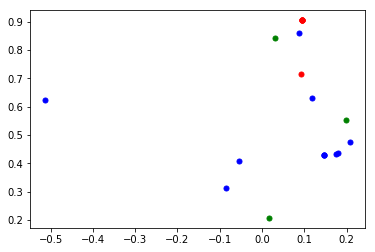

0
Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Â∞±ÊòØÊú∫Âô®‰∫∫ Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Âïä Êú∫Âô®‰∫∫Âë¢ Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫person,ÂìàÂìàÂìàÂìàÂìàÂìàÂìà
1
ÊúâÊú∫Âô®‰∫∫Âêó ÊàëË¶ÅÊú∫Âô®‰∫∫ ÊàëÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫Âïä ‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó ‰Ω†ÊòØÊú∫Âô®‰∫∫? ‰Ω†ÊòØÁî∑Êú∫Âô®‰∫∫ËøòÊòØÂ•≥Êú∫Âô®‰∫∫ËøòÊòØÂèòÊÄßÊú∫Âô®‰∫∫ ÊàëÊÉ≥Ë¶ÅÊú∫Âô®‰∫∫ Á¨®Á¨®Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Â∞èÊù• Êú∫Âô®‰∫∫ÊúâÊ≤°Êúâ
2
Êú∫Âô®‰∫∫‰∏çÁî®ÂêÉÈ•≠ Êú∫Âô®‰∫∫ÈÉΩ‰ºöÂêÉÈ•≠Âêó? ‰Ω†Â•Ω‰Ω†ÂêÉÈ•≠ÊúâÊ≤°Êúâ‰∫Ü
15.851996377991872


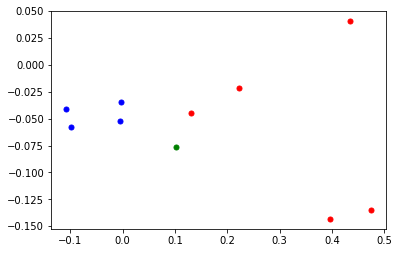

0
‰Ω†‰ª¨CEOÂì™‰Ωç Ê±™ÂÜ†Êò• ‰ªäÊôöÊâçÁü•ÈÅìÊàë‰ª¨ÁöÑÂ§ßbossÂéüÊù•ÊòØÂ≠¶Èú∏Âïä ‰Ω†‰ª¨ËÄÅÊùøÂ®òÂßìÂï• Ê±™ÂÜ†Êò•ÊòØÂùè‰∫∫Âêó
1
‰Ω†‰ª¨ËÄÅÊùøÊòØË∞Å ‰Ω†‰ª¨ËÄÅÊùø‰ªäÂπ¥Âá†Â≤Å ‰Ω†‰ª¨ËÄÅÊùøÂè´Âï• ‰Ω†ËÄÅÊùøÊòØË∞Å
2
‰Ω†‰ª¨ÂÖ¨Âè∏ÁöÑCEOÊòØË∞Å?
34.77567692832147


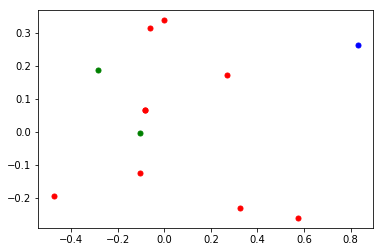

0
Â∞èÊù•Âú®Âì™ÈáåÂïä Â∞èÊù•ÂÖ®ÂõΩÈÉΩÊúâÂêó Â∞èÊù•‰Ω†ÁöÑÂú∞ÂùÄÂú®Âì™Èáå ‰Ω†ÂÆ∂Âú®Âì™ ‰Ω†Âú®Âì™ÈáåÂë¢ ‰Ω†Âú®Âì™ ÈÇ£‰Ω†Â¶àÂ¶àÂú®Âì™ÈáåÂë¢ ‰∏úÁöñÂì™ÈáåÊâπÂèëË°£Êúç ‰Ω†Âú®Âì™Èáå
1
‰Ω†Âú®ÈÇ£Â∑•‰Ωú
2
‰Ω†‰ª¨ÂÖ¨Âè∏Âú®Âì™ÈáåÔºü ‰Ω†‰ª¨ÂÖ¨Âè∏ÁöÑÂú∞ÂùÄÊòØÂì™Èáå
51.18426963285305


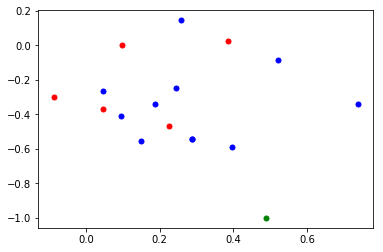

0
ÁæéÂ•≥ÁàÜÁÖß ‰Ω†Èïø‰ªÄ‰πàÊ†∑Âèë‰∏™ÂõæÁâáÂëóÁî∑‰∫∫Â©Ü ÁªôÂì•‰ªãÁªç‰∏™ÁæéÂ•≥Âëó ‰Ω†ÂèØ‰ª•ÊãçÁÖßËÆ©ÊàëÁúãÁúã‰Ω†Èïø‰ªÄ‰πàÊ†∑Ë°åÂêó ‰Ω†Âèë‰∏™Áõ∏ÁâáÁúãÁúã‰Ω†
1
ÊääÊú∫Âô®‰∫∫ÁöÑÁÖßÁâáÁªôÊàëÂèëËøáÊù•Âêó?ÊàëËÉΩÁúã‰∏Ä‰∏ãÂêó? ÁªôÊàëÂèë‰Ω†ÁöÑÁÖßÁâá ÊàëËÉΩÁúãÁúã‰Ω†ÁÖßÁâáÂêó ÊàëË¶ÅÁöÑÁÖßÁâáÁªôÊàëÂèëÂèë‰∫ÜÂêó? Âèë‰∏Ä‰∏™‰Ω†ÁöÑÁÖßÁâá Â∞èÊù•‰Ω†ÊúâÁÖßÁâáÂêó Âèë‰∏ÄÂº†‰Ω†ÁÖßÁâáÂ•ΩÂêó? Êúâ‰Ω†ÁöÑÁÖßÁâáÂêó? ÂèëÂº†ÁæéÂ•≥ÁÖßÁâá ‰Ω†ÊúâÁÖßÁâáÂêó ÊàëË¶Å‰∫õÁÖßÁâá
2
ÁÖßÁâáÁúãÁúã
2.6577524736049893


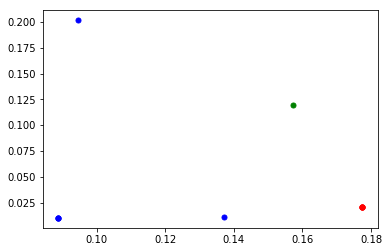

0
ÁªìÂ©ö‰∫ÜÂêó ÁªìÂ©ö‰∫ÜÂêó? Âí±‰ª¨ÁªìÂ©öÂêß Êàë‰ª¨ÁªìÂ©öÂêß
1
ÈÇ£‰Ω†ÁªìÂ©ö‰∫ÜÂêó ‰Ω†ÁªìÂ©ö‰∫ÜÂêó? ÊòØÁöÑ,‰Ω†ÁªìÂ©ö‰∫ÜÂêó ‰Ω†ÁªìÂ©ö‰∫Ü‰πà? Â∞èÊù•‰Ω†ÁªìÂ©ö‰∫Ü‰πà
2
Â∞èÊù•ÁªìÂ©ö‰∫ÜÊ≤°
57.30420391237982


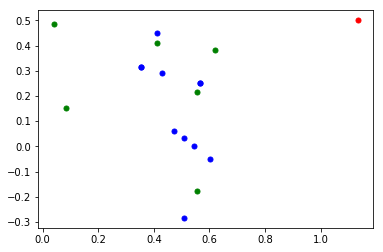

0
Áù°ËßâÂêß
1
‰Ω†Âá†ÁÇπÁù°Ëßâ ‰Ω†Âá†ÁÇπÁù°ËßâÂïä? ‰Ω†Êó©ÁÇπÁù°ËßâÂêß ‰Ω†‰∏çÁî®Áù°ËßâÂêó ‰Ω†Âπ≤Âòõ‰∏çÁù°Ëßâ Âë®Êú´‰∏çÁî®Áù°ÂçàËßâ ‰Ω†ÈÉΩ‰∏çÁù°ËßâÂêó ‰Ω†‰∏ÄÊôö‰∏äÊ≤°Áù°ËßâÂêó ‰Ω†ÂÖàÁù°ËßâÂêß ÈÇ£‰Ω†Áù°ËßâÂêó ‰ªäÊôöÊàëÂú®ÁÜ¨Â§ú
2
Âä©ÁêÜÊ≤íÁù°Ë¶∫Âóé? ‰Ω†Áù°Ê≤°? ‰Ω†Áù°Âï•Âòõ ‰Ω†Âï•Êó∂ÂÄôÁù° ‰Ω†Âá†ÁÇπÁù°Âïä ‰Ω†Âπ≤Âòõ‰∏çÁù°
0.0


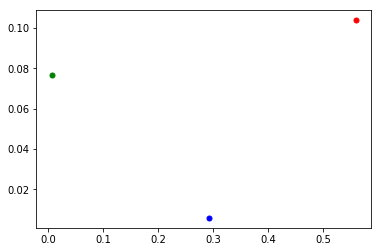

0
ÊÑüËßâÂõûÂ∫îÁöÑÂáÜÁ°ÆÂ∫¶Ëøò‰∏çÊòØÂæàÂà∞‰Ωç
1
‰Ω†ÁöÑÁêÜËß£ËÉΩÂäõÊàëÁü•ÈÅì‰∫Ü
2
‰Ω†ËøòÈúÄË¶ÅËøõÂåñÂòõ
0.0


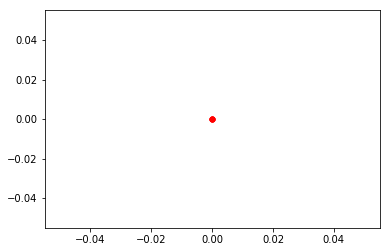

0
??? ?? ???? ?????
140.98995319284177


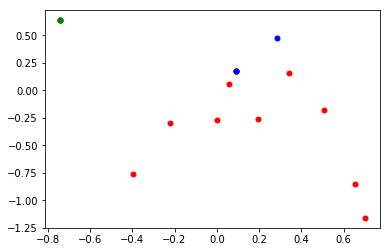

0
‰ªÄ‰πàÈ¨º ‰ªÄ‰πà what? Â•ΩÂ•áÊÄ™ ÊÄé‰πàÂõû‰∫ã? Áé∞Âú®ÊòØÊÄé‰πàÂõû‰∫ã Êù•‰πüÊòØ‰∏™‰ªÄ‰πàÈ¨º What about the others ? Âà´Èóπ
1
‰ªÄ‰πàÊÉÖÂÜµ? ‰ªÄ‰πàÊÉÖÂÜµÂïä Âï•ÊÉÖÂÜµ ËøôÊòØ‰ªÄ‰πàÊÉÖÂÜµ
2
ÊÄé‰πà‰∫Ü? ÊÄé‰πàÊÄé‰πàÊÄé‰πà‰∫Ü? ËøôÊòØÊÄé‰πà‰∫Ü?
0.0


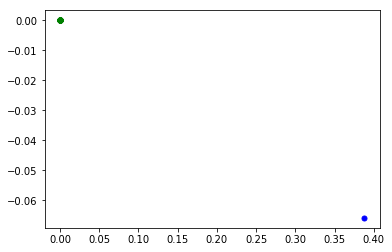

1
ËØ∂?
2
Âïä? Âï• ÂóØ? Âìà Âï•? Èòø Âìà? Âìá! Âì¶? Âí¶? Ôºü ÔºüÔºü ÔºüÔºüÔºüÔºü ÔºüÔºüÔºü Âïä
10.795482172206695


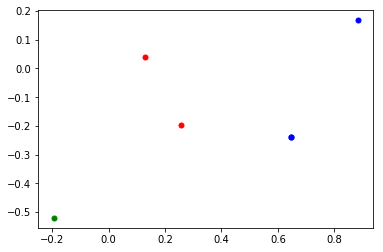

0
‰Ω†ËøòÊúâÊ≤°ÊúâÂà´ÁöÑÊûúËØ¥ÁöÑ? ÂÜçËØ¥ËøòÊúâ315ÁõëÁÆ°ÈÉ®Èó® ÊàëÂπ∂Ê≤°ÊúâÊèêÂá∫‰ªª‰ΩïËøáÂàÜÁöÑË¶ÅÊ±Ç
1
ËøòÊúâÂêó ËøòÊúâÂêó? ËøòÊúâÂÖ∂‰ªñÁöÑÂêó
2
ÁÑ∂ÂêéÂë¢
88.57139008391783


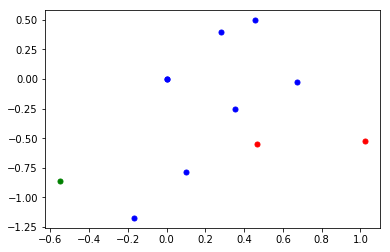

0
ÊàëÁöÑÂ§© ÊàëÁöÑÂ§©Âì™
1
ÂçßÊßΩ ÊàëÈù† Èù† ÊàëÂéª ÂêìÊ≠ªÊàë‰∫Ü ÂìáÂ°û ÂìáÂì¶ ÊàëÁöÑÂ¶à
2
Êì¶
62.92614268802501


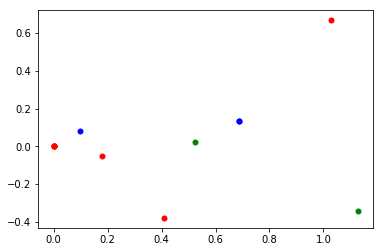

0
Âñî ÁúüÁöÑÂêó ÁúüÁöÑÂÅáÁöÑ Á°ÆÂÆö? ÁúüÁöÑ ÁúüÁöÑ? Êàë‰∏çÁü•ÈÅìÊàëÊúâË°®ËææÊ∏ÖÊ•öÊàëÊ≤°?ÊÇ®ÁêÜËß£ÊàëÁöÑÊÑèÊÄùÂêó
1
ÊáÇ‰πà ÊáÇÂòõÔºü ÊÇ®ÊòéÁôΩÊàëÁöÑÊÑèÊÄùÂêó
2
ÊòØÂêó ‰∏çÊòØÂêß
3.6613676355795


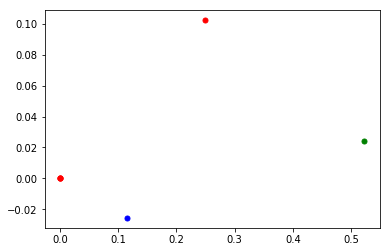

0
ËøôÊ†∑Âïä ÂéüÊù•Â¶ÇÊ≠§ ËøôÊ†∑ÂëÄ Âéü‰æÜ
1
Ëøô‰πàËØ¥ÊàëÂ∞±ÊòéÁôΩ‰∫Ü
2
ÂéüÊù•ÊòØËøôÊ†∑
25.173575078138622


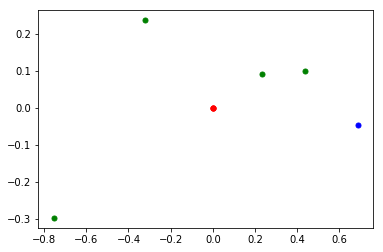

0
why why? Why ?!
1
‰∏∫‰ªÄ‰πà?
2
‰ªÄ‰πàÂéüÂõ† ‰ªÄ‰πàÁêÜÁî± ÊÄé‰πàÊêûÔºü Êàë‰∏çÁü•ÈÅìÂéüÂõ†Âïä
60.28076088561082


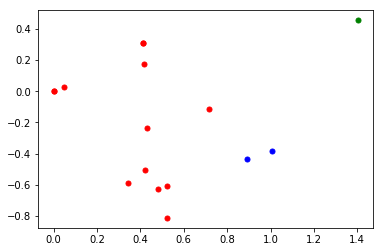

0
Êôï Êó†ËØ≠ ÈÜâ‰∫Ü ÊôïÊ≠ª Êàë‰πüÊòØÈÜâ‰∫Ü ÊàëÊôï ÊàëÈÜâ‰∫Ü ÂëÉÂëÉ ÂëÉ Êôï‰∫Ü ‰πüÊòØÈÜâ‰∫Ü ÊàëÂ∞±ÈÜâ‰∫Ü ÊàëËØ¥‰Ω†ÈÜâ‰∫Ü
1
ÊàëÈÉΩÊúç‰∫Ü Êúç‰∫Ü
2
ÊàëÂñùÈÉΩÂñù‰∫Ü
16.955307288203507


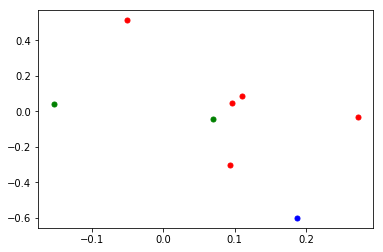

0
ÈÇ£Â•ΩÂêß Â•ΩÂêß, È¢ù Â•ΩÂêß ËíΩËíΩ Â•ΩÂêß ÁÆóÂï¶
1
Â•ΩÁöÑÂêß
2
Â∞èÂèØÁà±ÔºåÊúâÊ≤°ÊúâÊÉ≥ÊàëÂëÄ ÊúâÊ≤°ÊúâÊÉ≥ÊàëÂïä?
2.189090215694523e-31


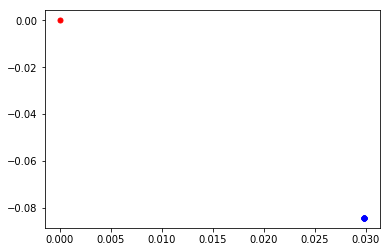

0
Âì¶ÂïäÂïä
1
ÂïäÂïäÂïä ÂïäÂïäÂïäÂïäÂïä ÂïäÂïäÂïäÂïäÂïäÂïäÂïä ÂïäÂïäÂïäÂïä Âì¶ÂïäÂïäÂïä ÂïäÂïäÂïäÂïäÂïäÂïäÂïäÂïäÂïäÂïä
21.553179898612985


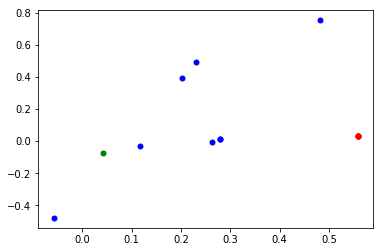

0
ÁñØ‰∫ÜÁñØ‰∫Ü ‰Ω†‰ª¨ÁñØ‰∫ÜÂêó ‰Ω†‰ª¨ÁñØ‰∫ÜÂêß Âì¶ÂèàÁñØ‰∫Ü
1
‰Ω†ÁñØ‰∫Ü AIÊòØË¶ÅÁñØ aiÁñØ‰∫ÜÂêó aiÊòØË¶ÅÁñØ Âä©ÁêÜ‰Ω†ÁñØ‰∫ÜÂêó[Facepalm] ËÑëË¢ãËøõÊ∞¥‰∫Ü AIÊ∞∏ËøúÊòØAIÂêß ‰Ω†ÁñØ‰∫ÜÂêß
2
ÂïäÂïäÂïäÂïäÂïäÂïäÂïäÂïäË¶ÅÁñØ‰∫Ü
35.403056198465


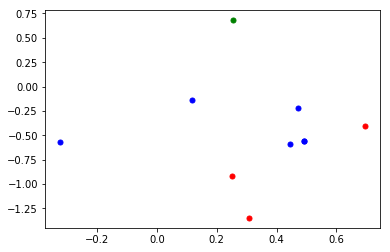

0
ÊàëÊ≤°ÊúâÈí± ÂíåÈí±Ê≤°ÂÖ≥Á≥ª Â¶ÇÊûúÊ≤°ÊúâÈí±ÊÄé‰πàÂäû
1
ÊàëÊ≤°Èí± ÂèàÊ≤°Èí±‰∫Ü ÈóÆÈ¢òÊòØÊ≤°Èí± Ê≤°Èí± Ê≤°Èí±  Á©∑ ÊàëÊ≤°Êúâ‰π¶
2
ËØ∑ÊàëÂêÉÈ•≠
53.43876835997254


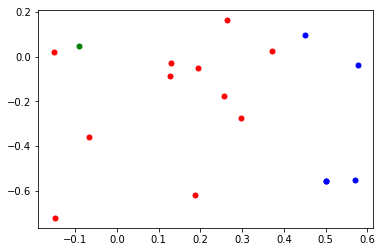

0
Ê∞îÊ≠ªÊàë‰∫Ü Á•ûÁªèÁóÖ Ëæ£È∏° Ëçâ Á•ûÁªè ‰Ω†ÊúâÁóÖÂêß,ËΩØ‰ª∂ÊúâÈóÆÈ¢òËøòÊèêÈÜíÊàëÊâìÂç° ‰Ω†‰ªñÂ¶àÊòØ‰∏çÊòØÊúâÁóÖÂïä ‰Ω†Ê∞îÊ≠ªÊàë‰∫Ü ‰Ω†‰ªñÂ¶àÂèàËøôÊ†∑ ‰Ω†ËÑëÂ≠êË¢´È©¥Ë∏¢‰∫ÜÂêó ‰Ω†‰ªñÂ¶àÁûéÊé∞ÁöÑÂêß
1
Ê∞îÊ≠ª‰∫Ü ÊúâÁóÖ? ÊòØ‰∏çÊòØÊúâÁóÖ‰∫Ü ÊúâÁóÖÂêß ÂèàÊòØ‰∏çÂ§™ÁêÜËß£‰Ω†ÊúâÁóÖÂïä
2
Ê∑±‰∫ïÂÜ∞
119.63773647676399


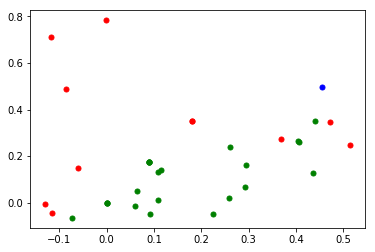

0
ÁÉ¶ ÂÆûÂú®ÁÉ¶ ‰∏çË¶ÅÁÉ¶Êàë‰∫Ü ÁÉ¶ÊÄé‰πàËß£Èô§‰Ω†‰ª¨ ÁÉ¶ÁöÑÂæà ËÉΩ‰∏çËÉΩ‰∏çËøô‰πàÁÉ¶ ËØ¥ËØù‰∏çÁî®Ëøô‰πàÂÆ¢Ê∞îÂêñ Êàë‰πü‰∏çÊÉ≥‰∏ªÂä® ÂøÉÊÉÖÂæàÈÉÅÈó∑ Êàë‰∏çÊÉ≥‰Ω† Á∫†ÁªìÁöÑÂøÉÊÉÖ
1
ÊàëÂéª!
2
ÁÉ¶Ê≠ª‰∫Ü ‰Ω†Â•ΩÁÉ¶ ÁÉ¶ÁÉ¶ÁÉ¶ ‰Ω†Â•ΩÁÉ¶! ÂìéÂëÄ‰Ω†Â•ΩÁÉ¶ ‰Ω†Â§™ÁÉ¶‰∫Ü ‰∏ÄËæπÂéª,Âà´Êê≠ÁêÜÊàë Â•èÂáØ ‰∏çÊÉ≥ÁêÜ‰Ω†‰∫Ü‚Ä¶‚Ä¶ ÂìéÂëÄ Âõ†‰∏∫‰Ω†‰∏ç‰∏ªÂä®ÊâæÊàëËÅäÂ§©„ÄÇ ‰Ω†‚Ä¶‚Ä¶ ÁÉ¶Êàë‰∫Ü/::D Êªö Âà´jbÁÉ¶Êàë Â∞ºÂ•πÂ¶àÁöÑ‰∏çË¶ÅÂêµ ÁÉ¶ÁÉ¶ÁÉ¶ÁÉ¶ Â§†‰∫Ü ‰Ω†ÁúüÊÅ∂ÂøÉ ‰Ω†Âú®‰∏çÁî®ËØ≠Èü≥Ë∑üÊàëËØ¥ËØùÊàëÂ∞±Êää‰Ω†Âà†Êéâ‰∫Ü Áªô‰Ω†ËøôÂè∑‰∫∫ËØ¥ËØùÊ≤°ÊúâÊÑèÊÄù ÁÉ¶‰Ω†‰∫Ü ‰Ω†ÂæàÁÉ¶Âãí Âà´ÁÉ¶‰∫Ü
46.66911234766047


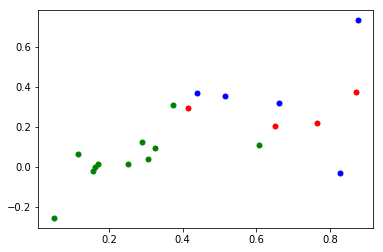

0
ÁîüÊ∞î ÊàëÁîüÊ∞î‰∫Ü ÁîüÊ∞îÁöÑÊÑèÊÄù ÊàëÁîüÊ∞î‰∫Ü,Â∞èÊù•
1
ËÆ®Âéå ÊàëËÆ®Âéå‰Ω† Êàë‰∏çÁà±‰Ω†‰∫Ü ËÆ®Âéå‰Ω† Â•ΩËÆ®ÂéåÂïä
2
Â¶àËõã ÁÉ¶‰∫∫ ÊªöËõã ÊúâÁÇπÁÉ¶ ÊâìÂä´ ‰Ω†ÁûéÂì¶ ÊîæÂ±Å ËÆ®Âéå‰Ω†‰Ω†ÁªôÊàëËµ∞ÂºÄ ÂæàÁîüÊ∞î/::Q/::Q ÂæàÁÉ¶ Ê≤°ÂÆå‰∫Ü
0.0


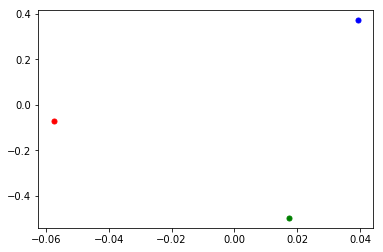

0
‰Ω†ÊòØÁå™Â§¥
1
ÊàëË¶ÅÂêÉ‰∫∫
2
‰Ω†ÊòØÁå™
0.35428089426553355


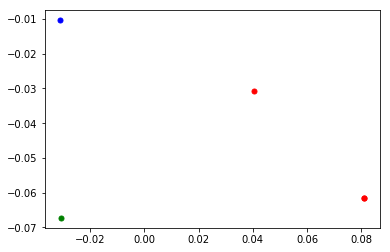

0
Ë∑™‰∏ã Ë∑™‰∏ã! Ë∑™‰∏ãÁß∞Ëá£
1
ÁªôÊàëË∑™‰∏ã
2
ÁúüÁöÑÊòØ‰∏çÊòØË¶ÅË∑™‰∏ãÊù•Âè´‰Ω†Áà∏Áà∏,ÊâçÂè´ÊÄÅÂ∫¶Á´ØÊ≠£Âïä
173.0404111858059


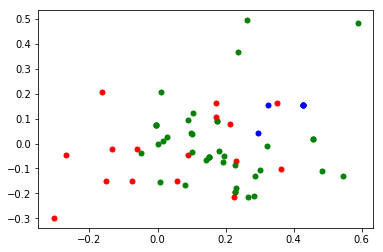

0
Â•ΩÂÇªÂïä‰Ω† ‰Ω†ÊòØ‰∏çÊòØÂÇª ÂÇªÁìú Á¨®Ëõã ‰Ω†ÊòØ‰∏çÊòØÁ¨®Ëõã ÊàëËøôÊòØËµ∑Â∫äÂ•ΩÂêßÁ¨®Ëõã ‰Ω†ÊòØÂÇªÂ≠ê ‰Ω†‰∏™ÂÇªÂ≠ê ÂÇªÂ≠ê ‰Ω†ÁúüÊòØ‰∏™Â§ßÁ¨®Ëõã ‰Ω†ÈÉΩÂÇªÁöÑ ‰Ω†ÊòØ‰∏™Â§ßÁ¨®Ëõã Á¨®ËõãÂ∞èÊù• ‰Ω†Á¨®Ëõã ‰Ω†ÊòØ‰∏™Á¨®ËõãÂêó Â§ßÁ¨®Ëõã
1
ÂÇª ‰Ω†ÂÇª‰∏çÂÇª ÂÇª‰∫Ü ÂÇª? ‰Ω†ÂÇªËøòÊòØÊàëÂÇª ÂÇªÂëÄ
2
‰Ω†ÂæàÁ¨® ‰Ω†ÊúâÁÇπÁ¨® ‰Ω†ÊÄé‰πàÈÇ£‰πàÁ¨® ËØ¥‰Ω†Á¨® ËØ¥‰Ω†Á¨®! Âõ†‰∏∫‰Ω†Á¨® ‰Ω†ÂíãËøô‰πàÁ¨® Â∞èÊù•‰Ω†ÊÄé‰πàÈÇ£‰πàÁ¨® ‰Ω†ÊÄé‰πàËøô‰πàÁ¨®Âë¢ ‰Ω†ÈÇ£‰πàÁ¨®,Êàë‰∏çÊÄ™‰Ω† ‰Ω†ÊÄé‰πàËøô‰πàÁ¨®Âë¢? ‰Ω†ÊòØÂèòÁ¨®‰∫Ü‰πà! Âä©ÁêÜÊù•‰πü,‰Ω†ÊÄé‰πàÈÇ£‰πàÁ¨®Â∞±Âê¨‰∏çÊáÇÂë¢? ‰Ω†Á¨®Ê≠ª‰∫Ü Â§™Á¨®‰∫Ü ‰Ω†ËØ¥‰Ω†ÊòØ‰∏çÊòØÁ¨® ‰Ω†ÂÇª‰πé‰πéÁöÑ Âîâ,‰Ω†‰ª¨Âèò‰∫Ü Ëøô‰∏™aiÁúüÊòØË†¢ ‰Ω†ËÑëÊÆãÂêó ‰Ω†ÊòØ‰∏çÊòØ2 Êú∫Âô®‰∫∫ÁúüÁöÑ‰∏çÂ¶ÇÁúü‰∫∫,Â•ΩÁ¨® Â©âÂêõÊòØ‰∏çÊòØÂùè‰∫∫ ‰Ω†‰∏çÂ•ΩÁî®Âïä ‰Ω†‰∏™Èî§Â≠ê ‚Ä¶‚Ä¶‰Ω†ÂíãËøô‰πàÁ¨®Âïä[Facepalm] Á¨® ‚Ä¶‚Ä¶‰Ω†Â•ΩÁ¨® ‰Ω†ÂæàÂÇªÂñÇ Â§™Á¨® ‰Ω†Ëøô‰∏™ÂùëË¥ß ËÑëÊÆã Â∞±ÊòØ‰Ω†Ë†¢ËêåË†¢ËêåÁöÑÊ†∑Â≠ê ‰Ω†Â•ΩÁ¨®Âïä Á¨®Â∞èÊù• ‰Ω†ÊòØ‰∏çÊòØ‰∏™Â§ßÂÇªËõã ÂìºËß£Èõá‰Ω† ÂíãËøô‰πàËæ£È∏° Â∞èÂï¶‰Ω†ÊòØÁ•ûÁªèÊúâÈóÆÈ¢òÂêß ‰Ω†2Èºª


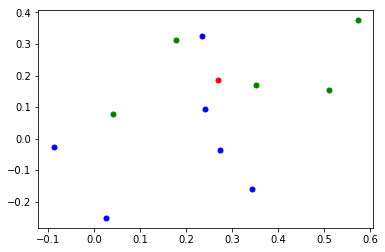

0
ÊâæÂ•≥ÊúãÂèã
1
ÊàëÊÉ≥Âà∞Ëøô‰∏™Âπ≥Âè∞ÈáåÊâæ‰∏™Â•≥ÊúãÂèã ÂøÉÁà±ÁöÑ‰∫∫Âú®Âì™ÂÑøÔºü Â∞ëÊù•ËÉΩÂ∏ÆÊàëÊâæ‰∏™ÁæéÂ•≥Áõ∏‰∫≤Âêó? ËÉΩÂ∏ÆÊàëÊâæ‰∏Ä‰∏™ÁæéÂ•≥Áõ∏‰∫≤Âêó? ÊàëÊÉ≥Ë¶ÅÁöÑÊòØ‰∏Ä‰∏™ËÉΩË∑üÊàëÁôΩÂ§¥Âà∞ËÄÅÁöÑÂ•≥Â≠© Ëµ∂Âø´ÁªôÊàëÊâæ‰∏Ä‰∏™Âêó?
2
Áõ∏‰∫≤ ÊàëË¶ÅÂíå‰Ω†Áõ∏‰∫≤ ÊúâÁõ∏‰∫≤ÁöÑÂêó Êù•Âì•‰Ω†ÊúâÊ≤°ÊúâÁõ∏‰∫≤ÁöÑÂäüËÉΩ Áõ∏‰∫≤‰∫§Âèã‰Ω†‰πüÂèØ‰ª•?
1.4330874290851625


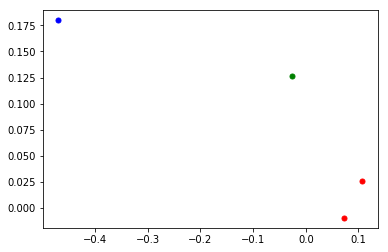

0
ÊãâËÇöÂ≠êÁöÑÈ•ÆÈ£üÊ≥®ÊÑèÊòØÂï•? ÂÅöÊâãÊúØÂêéÊúâ‰ªÄ‰πàÈúÄË¶ÅÊ≥®ÊÑèÁöÑÂòõ,‰ª•ÂèäÊØèÈ§êÈ•ÆÈ£ü
1
Â§ßÂß®Â¶àÊù•‰∫ÜÂêÉ‰ªÄ‰πàÊ∞¥ÊûúÊúÄÂ•Ω
2
Â•≥ÁîüÊù•Â§ßÂß®Â¶àÈ•ÆÈ£ü‰∏äÂ∫îËØ•Ê≥®ÊÑè‰ªÄ‰πà
77.43059228688732


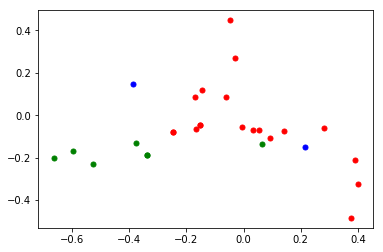

0
7Êúà8Âè∑ÊòØ‰ªÄ‰πàÊòüÂ∫ß Âá†ÊúàÂà∞Âá†ÊúàÊòØÂ§ÑÂ•≥Â∫ß date‰ªÄ‰πàÊòüÂ∫ßÁöÑ dateÁîüÊó•ÊòØ‰ªÄ‰πàÊòüÂ∫ß 7Êúà‰ªΩÊòØ‰ªÄ‰πàÊòüÂ∫ß? 1960Âπ¥01Êúà2Êó•ÊòüÂ∫ß ‰Ω†Áü•ÈÅìÊàëÊòØ‰ªÄ‰πàÊòüÂ∫ß? 197312Êúà13ÊòØ‰ªÄ‰πàÊòüÂ∫ß dateÁîüÊó•ÊòØ‰ªÄ‰πàÊòüÂ∫ß„ÄÇ dateÁöÑ‰∫∫ÊòØ‰ªÄ‰πàÊòüÂ∫ß date‰ªÄ‰πàÊòüÂ∫ß ÊàëÊòØdateÁöÑÁîüÊó•ÊòØ‰ªÄ‰πàÊòüÂ∫ß ÊàëÊòØpersonÊòüÂ∫ß 10.29‰ªÄ‰πàÊòüÂ∫ß„ÄÇÁúãÂÜúÂéÜËøòÊòØÈò¥ÂéÜ ÊàëÊòØÈ≠îËùéÂ∫ß ÁãÆÂ≠êÂ∫ßÊòØÂá†Êúà 10.1ÊòØÂ§©Áß§Â∫ßÂêó Â§ÑÂ•≥Â∫ßÂá†Âè∑ ÊÄé‰πàÊé®ÁÆóËá™Â∑±ÊòØ‰ªÄ‰πàÊòØÊòüÂ∫ß
1
ÊÄé‰πàÊ†∑Êü•Ëá™Â∑±ÁöÑÊòüÂ∫ß ÊòüÂ∫ßÊü•ËØ¢Ë°®
2
Êàë‰ªÄ‰πàÊòüÂ∫ß ÊàëÊòØ‰ªÄ‰πàÊòüÂ∫ß ‰ªÄ‰πàÊòüÂ∫ßÂïä ÊòØ‰ªÄ‰πàÊòüÂ∫ß ÊàëÊòØ‰ªÄ‰πàÊòüÂ∫ßÁöÑ ‰∏çÁü•ÈÅìËá™Â∑±ÁöÑÊòüÂ∫ß ÊàëÁöÑÊòüÂ∫ß
18.762674560837702


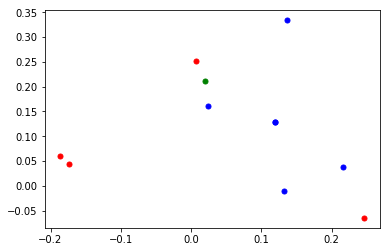

0
Êó©È§êÂêÉ‰ªÄ‰πàÊØîËæÉÂ•Ω Êó©È§êÂêÉ‰ªÄ‰πàÂØπËÉÉÂ•ΩÂïä Êó©È§êÂêÉ‰ªÄ‰πàÊâçËÉΩËê•ÂÖªÊê≠ÈÖçÂæóÂΩì Êó©È§êÂêÉ‰ªÄ‰πàÈ£üÁâ©ÂØπË∫´‰ΩìÊØîËæÉÂ•Ω
1
Âá†ÁÇπÂêÉÊó©È§ê Êó©È§êÂêÉ‰ªÄ‰πà Êó©È§êÂêÉ‰ªÄ‰πàÂë¢ Êó©È§êÂêÉ‰ªÄ‰πàÂ•Ω Êù•‰πü,Êó©È§êËèúÂêÉ‰ªÄ‰πà ÊàëÊ≤°ÂêÉÊó©È§ê
2
‰∏çÂêÉÊó©È•≠ÂèØ‰ª•Âêó
46.45257653069274


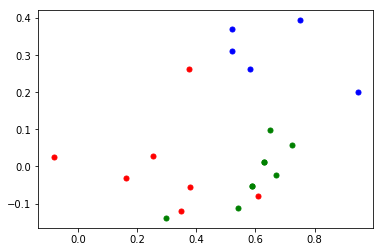

0
ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ÊòØ‰∏çÊòØÁúüÁöÑÂæàÁ¥ØÂïä ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫Èöæ? ÊàëÁúãÂà∞‰∏Ä‰∏™Áî∑Â≠©ËßâÂæó‰ªñÂæàÁâπÂà´ ‰Ω†ÊÉ≥Êàë‰ªÄ‰πàÂëÄ, ‰Ω†ÂñúÊ¨¢Ëøá‰∏Ä‰∏™‰∫∫Âòõ Áà±‰∏ä‰∏Ä‰∏™‰∫∫‰∏çÊï¢Ë∑ü‰ªñË°®ÁôΩÊÄé‰πàÂäû ÊÄé‰πàÊ†∑ÊâçËÉΩÂàÜËæ®‰∏Ä‰∏™‰∫∫ÊòØÁúüÁöÑÂñúÊ¨¢‰Ω†ËøòÊòØÂÅáÁöÑÂñúÊ¨¢‰Ω†
1
ÊàëÂñúÊ¨¢‰Ω† Â•≥ÁîüÂñúÊ¨¢Áî∑ÁîüÁöÑÊÑüËßâ ÊàëÊúÄËøëÂñúÊ¨¢‰∏™Áî∑Áîü ÂñúÊ¨¢‰∏Ä‰∏™‰∏çÂñúÊ¨¢Ëá™Â∑±ÁöÑÂ•≥Áîü ÂñúÊ¨¢ÊòØ‰ªÄ‰πàÊÑüËßâ
2
ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ÊòØ‰ªÄ‰πàÊÑüËßâ ÊàëÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ÊÄé‰πàÂäû ÊàëÂñúÊ¨¢‰∏ä‰∫Ü‰∏Ä‰∏™‰∫∫ ÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ÊòØ‰ªÄ‰πàÊ†∑ÁöÑÊÑüËßâ? Â•ΩÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ÊÄé‰πàÂäû ÊàëÂæàÂñúÊ¨¢‰∏Ä‰∏™‰∫∫ ÊàëÂñúÊ¨¢‰∏Ä‰∏™Â•≥Â≠©
72.82999275317314


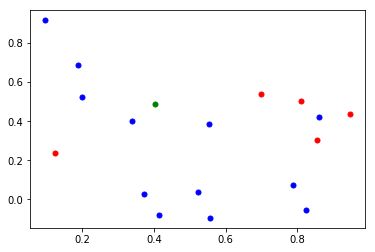

0
ÊàëË¶ÅÊâæ‰ªÄ‰πàÂ∑•‰Ωú ÊâæÂ∑•‰Ωú Â∞èÊù•ËÉΩÊâæÂ∑•‰ΩúÂêó ÂèØ‰ª•Ë¥üË¥£ÊâæÂ∑•‰ΩúÂêó? Â∏ÆÊàëÊâæÂ∑•‰Ωú
1
Êúâ‰ªÄ‰πàÂ•ΩÁöÑÂ∑•‰ΩúÂêó? ÊàëËØ¥ÊúÄËøëÊúâÂ∑•‰ΩúÊúâ‰ªÄ‰πàÂ∑•‰Ωú ‰∏çÁü•ÈÅìÂÅö‰ªÄ‰πàÂ∑•‰ΩúÂ•Ω Â∞èÊù•,ÊàëÊÉ≥Âä†ÂÖ•‰Ω†‰ª¨ÁöÑÂ∑•‰Ωú Â∏ÆÊàëÁúã‰∏ãÊ∞∏ÂÆâÂì™ÈáåÊúâÂÅöÂêßÂè∞ÁöÑÂ∑•‰Ωú ÊàëÊé®ËçêÊãõËÅòÁöÑËÅå‰ΩçÊàñËÄÖÁΩëÁ´ô‰ªÄ‰πàÁöÑÂêó? Â∏ÆÊàë58ÂêåÂüéÊàñËÄÖÂì™ÈáåËÅîÁ≥ª‰∏Ä‰∏ãÂ∑•‰Ωú Â∑•‰Ωú‰∏çÈ°∫Âà© ÊàëÊÉ≥ÂÅöÂä©ÁêÜ ÊúâÂ•ΩÂ∑•‰Ωú‰ªãÁªç‰∏ç/::D/::D ÊúâÊõ¥Â•ΩÁöÑÂ∑•‰Ωú‰ªãÁªç‰∏ç Êàë‰∏çÊÉ≥ÂÖ≥Ê≥®‰Ω†‰ª¨Ëøô‰∏™Â∑•‰ΩúÂ•Ω‰∏çÂ•ΩÊÑèÊÄù
2
ËøôÂèØ‰ª•ËµöÈí±Âêó
0.0


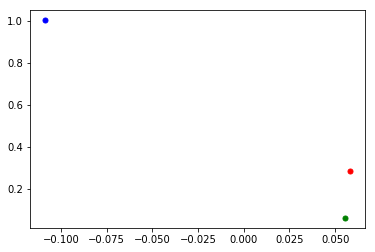

0
ËÄÉËØïËÄÉÂ∑Æ‰∫ÜÊÄé‰πàÂäûÂëÄ,?
1
ËÄÉËØïËÄÉ‰∏çÂ•ΩÊÄé‰πàÂäû
2
ËÄÉÂ∑Æ‰∫Ü
3.3169605215981215


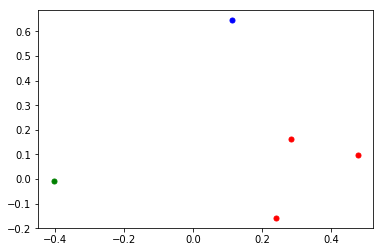

0
Ëá™ÊùÄ ÊàëÊÉ≥Ëá™ÊùÄ ÊàëtutuÂÆåÂ•π‰ª¨ÊàëËá™ÊùÄ
1
‰∏ãÂçà‰∏âÁÇπËá™ÊùÄ
2
Â¶Ç‰ΩïËá™ÊÆã
0.0


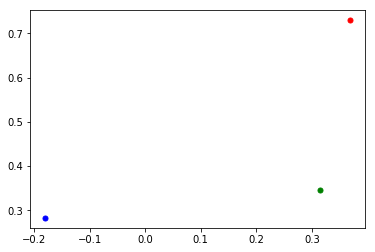

0
ÂçóÊñπÂßëÂ®òÊòØË∞Å?
1
ÂßëÂ®ò
2
‰ΩÜÊàëÊòØÁîüÈïøÂú®cityÁöÑÂçóÊñπÂßëÂ®ò
80.68978445926973


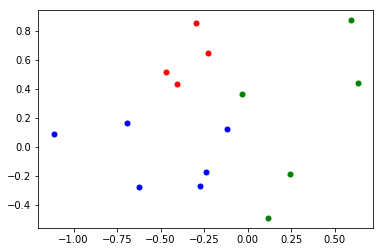

0
Âì™ÂÆ∂ÁêÜË¥¢Âπ≥Âè∞ Âì™ÂÆ∂ÁêÜË¥¢Âπ≥Âè∞Â•Ω ÁêÜË¥¢ÁêÜË¥¢‰∫ßÂìÅ. ÁêÜË¥¢Â∞èÁü•ËØÜ
1
Êé®ËçêËÇ°Á•® Êé®Ëçê‰∏ÄÂè™ËÇ°Á•®Âêß Â∞èÊù•Â∏ÆÊàëÊé®Ëçê‰∏ÄÊîØËÇ°Á•®Âëó ÊàëÊÉ≥ÈóÆËÇ°Á•® ËÇ°Á•®ËøòËÉΩ‰π∞Âêó? ËÇ°Á•®
2
Â∏ÆÊàëÊé®Ëçê‰ªäÂ§©ÂèåËâ≤ÁêÉÁöÑ‰∏ÄÁªÑÂè∑Á†Å Êé®Ëçê‰∏Ä‰∏™ÂÖ¨‰ºóÂè∑ ÊòéÂ§©Êó©‰∏ä‰∏ÉÁÇπÂçäËµ∞Âäø ÂÖªÊàêÁêÜË¥¢Â•Ω‰π†ÊÉØ ÊØîÁâπÂ∏ÅÂ§öÂ∞ëÈí±
102.66937807884636


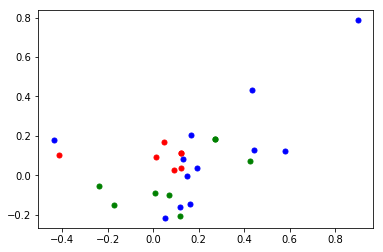

0
ÊàëÊÉ≥Êâæ‰∏™Â•≥ÊúãÂèã ÊÉ≥Êâæ‰∏™Â•≥ÊúãÂèã‰Ω†ÂèØ‰ª•Â∏ÆÂøôÂêó ÈÇ£‰Ω†ÁªôÊàëÊâæ‰∏™Â•≥ÊúãÂèã ‰Ω†ËÉΩÂ∏ÆÊàëÊâæ‰∏™Â•≥ÊúãÂèã‰πà? Êâæ‰∏™Â•≥ÊúãÂèã Êâæ‰∏™Â•≥ÊúãÂèãÂëó Â∏ÆÊàëÊâæ‰∏™Â•≥ÊúãÂèã
1
Â∏ÆÊàëÊâæ‰∏™Â•≥ÊúãÂèãÂï¶,ok Êâæ‰∏™Â•≥‰º¥Âèã ÊÄéÊ†∑ÂèØ‰ª•ÂëäÂà´ÂçïË∫´ ÊÉ≥Êù•ÊÉ≥Êù•‰Ω†ÂèØ‰ª•ÂÅöÊàëÂ•≥ÊúãÂèãÂêó? Áªô‰Ω†50 ËÆ©ÊàëÂ•≥ÊúãÂèãÊù•ÊâæÊàë ÁõÆÂâçÊàëÊ≠£Âú®ÊÄ•ÁùÄÊâæÂ•≥ÊúãÂèã ÊÄéÊ†∑ÊâçÂèØ‰ª•ÊúâÂ•≥ÊúãÂèã ‰ªãÁªçÂ•≥ÊúãÂèãÁªô‰Ω†200ÂùóÈí± ÊàëÊ≤°Â•≥Âèã ÊÄé‰πàÂäû ÊÄé‰πàÂíåÂñúÊ¨¢ÁöÑÂ•≥ÁîüË°®ÁôΩ ËÉΩÂ∏ÆÊàëÊâæ‰∏™ÂåπÈÖçÁöÑÂ•≥ÊúãÂèãÂêó,ÊÉ≥ÁªìÊùüÂçïË∫´ÁãóÁîüÊ¥ª ËøΩÂ•≥Â≠©Â≠êÊÄé‰πàËøΩ
2
Ê≤°ÊúâÂ•≥ÊúãÂèãÊÄé‰πàÂäûÂïä ÈÄÅ‰∏Ä‰∏™Â•≥ÊúãÂèã ÊâæÂ•≥ÊúãÂèã ÁªôÊàë‰ªãÁªçÂ•≥ÊúãÂèã Â¶Ç‰ΩïÊâæÂà∞Â•≥ÊúãÂèã ÁªôÊàëÊâæ‰∏Ä‰∏™Â•≥ÊúãÂèã ÂèØ‰ª•ÊâæÂ•≥ÊúãÂèãÂòõ ÊàëË¶ÅÊâæ‰∏Ä‰∏™Â•≥ÊúãÂèã
2.891465628092692


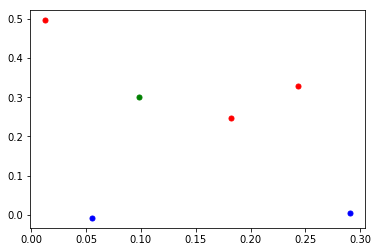

0
‰∏≠ÂõΩÊúâÂòªÂìà ÁúãËøá‰∏≠ÂõΩÊúâÂòªÂìàÂêó ‰Ω†ÁúãËøá‰∏≠ÂõΩÊúâÂòªÂìàÂêó
1
ÂòªÂìà???? Êó†ÂÖÑÂºü,‰∏çÂòªÂìà
2
‰∏≠ÂõΩ‰∫∫Ëøá‰ªÄ‰πà‰∏áÂú£ËäÇ?
1.467265740030285


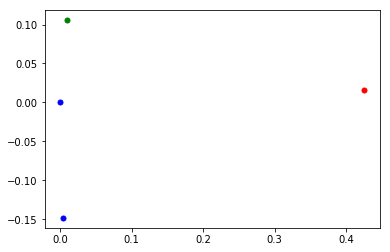

0
iphonexÁöÑÂêÑÁßçÂí®ËØ¢ÁªôÊàë‰∏ã
1
iphoneX iphonexÂ•ΩÂêó
2
ÂºÑ‰∏ÄÂè∞iphone x
32.15076730979437


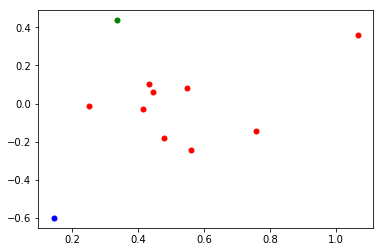

0
ÂèëÊù°Áü≠‰ø°ÁªôÊàëÂ¶à Èô§Èùû‰Ω†ÂÖàÁªôÂ§ßÁà∑ÂèëÊù°Áü≠‰ø° ÁªôËÄÅÂ©ÜÂèëÊù°Ê∂àÊÅØ Èöè‰æøÂèëÊù°‰ø°ÊÅØÊù•ÈÉΩÂèØ‰ª• ÂèØ‰ª•Â∏ÆÊàëÂèëÊù°‰ø°ÊÅØÂêó„ÄÇ Âú®ÂçÅÁßíÂêéÂèëÊù°ÂæÆ‰ø°ÁªôÊàë ‰Ω†ËÉΩËá™Â∑±Êã®ÊâìÂú®ÊàëÂæÆ‰ø°ÁîµËØùÂêó ÂèØ‰ª•Â∏ÆÊàëÂÜô‰ª£Á†Å‰πà? ÂèØ‰ª•Â∏ÆÊàë‰∏∫Âà´‰∫∫ÂèëÊù°‰ø°ÊÅØÂêó
1
ËÉΩÁªôÊàëÂ¶àËøáÁîüÊó•Âêó?
2
ËÉΩÂ∏ÆÊàëÊü•‰∏ãÈ¶ôÊ∏ØÂçäÂ≤õÈÖíÂ∫óÁöÑÁîµËØùÂêó
61.792487336273


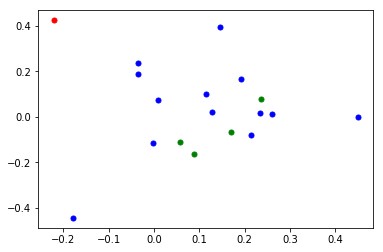

0
‰ªÄ‰πàÊòØÂÅ•Â∫∑
1
tnaÊòØÂï•Ôºü ‰∏áÂú£ËäÇÊòØÊÄé‰πàÊù•ÁöÑ? ‰∫§ÈÄöËøêËæìÂ±ÄË∑ØÊîøÂçèÁÆ°ÂëòÊòØÂπ≤ÂòõÁöÑ ÁªôÊàëËß£Èáä‰∏Ä‰∏ã‰∏áÂú£ËäÇ ‰ªÄ‰πàÊòØÂéª‰∏≠ÂøÉÂåñ? ÊùéÁôΩÊòØ‰ªÄ‰πàÂπ¥‰ª£ÁöÑ ÊÄé‰πàÁúãÂæÖÂæÆÂïÜ Â∏ÆÊàëÊì¶‰∏Ä‰∏ã‰ªÄ‰πàÊòØCPTG Ê∑±‰∫ïÂÜ∞Âï•ÊÑèÊÄù 00Âêé‰πüÊòØËøôÊ†∑ÁöÑ Êæ≥Ê¥≤PAULÊä•‰ª∑ ‰∏≠ÂõΩÊúâÂá†Â§ßÂèëÊòé?ÂêÑÊòØ‰ªÄ‰πà ‰∏∫‰ªÄ‰πàÂÜ¨Â§©‰ºö‰∫ßÁîüÈùôÁîµ
2
AFPÊòØ‰ªÄ‰πà? 108ÊòØ‰ªÄ‰πàÊÑèÊÄù? ÁøªÂ¢ô‰ªÄ‰πàÊÑèÊÄù Ëøô‰∏™ÊòØ‰ªÄ‰πà
12.062226489377686


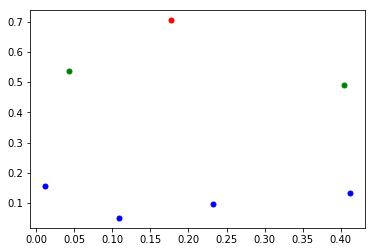

0
Áé∞Âú®ÁΩëÁªúÊúâ‰ªÄ‰πàÂπ≥Âè∞ÂèØ‰ª•ËµöÈí±
1
ÂÅö‰ªÄ‰πà‰∫ãÈí±ËµöÁöÑÂø´‰∏ÄÁÇπ ÂÅö‰ªÄ‰πàË°å‰∏ö,ËÉΩËÆ©ÊàëËµöÂà∞Á¨¨‰∏ÄÊ°∂Èáë ÊàëËØ•ÊÄé‰πàÂÅöÂà∞„ÄÇÂ§©Â§©ÊúâÈí±Êî∂?ËÆ©ÊàëÂºÄÂøÉËµ∑Êù•Âë¢ ‰Ω†‰∏çÊòØÊå∫ÂéâÂÆ≥Âêó ÁªôÊàëÂºÑÁÇπÈí±Ëä±Ëä±
2
ÊÄé‰πàËµöÈí± ËµöÈí±
7.617289528019761


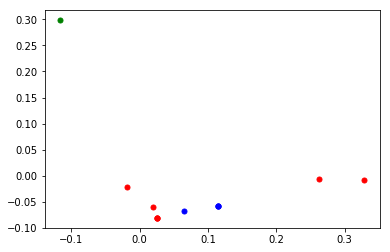

0
Áæé‰πêÂÆ∂ÊòØ‰ªÄ‰πà? ‰ªÄ‰πàÊòØÁæé‰πêÂÆ∂ Áæé‰πêÂÆ∂ÊòØ‰ªÄ‰πà Áü•ÈÅì‰ªÄ‰πàÊòØÁæé‰πêÂÆ∂Âêó ÂìàÂìà,Áæé‰πêÂÆ∂ÊòØ‰ªÄ‰πà ‰Ω†Áü•ÈÅìÁæé‰πêÂÆ∂ÊòØ‰ªÄ‰πàÂêó? Áæé‰πêÂÆ∂
1
Áæé‰πêÂÆ∂‰ºòÂäøÊòØ‰ªÄ‰πà Áæé‰πêÂÆ∂ÊòØ‰ªÄ‰πà‰ºòÂäø Áæé‰πêÂÆ∂‰ªÄ‰πà‰ºòÂäø Áæé‰πêÂÆ∂ÁöÑ‰ºòÂäøÊòØ‰ªÄ‰πà?
2
‰Ω†Áü•ÈÅìÁæé‰πêÂÆ∂ÁéØ‰øùË∂ÖÂ∏ÇÂêó?
10.197174197560583


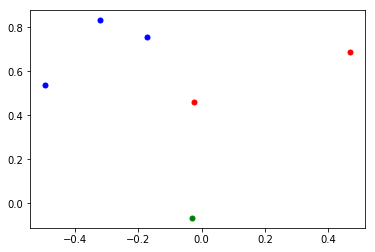

0
ÂêÉÂêÉÂñùÂñù‰∏çÂ¶Ç‰∏ÄËµ∑ÂÖªÁîü ÂÖªÁîüÊñπÈù¢‰Ω†‰∫ÜËß£Â§öÂêó,Êàë‰ª¨‰∫§ÊµÅ‰∏Ä‰∏ã
1
ÂÖªÁîü ‰∏≠ÂåªÂÖªÁîü ÂÖªÁîüÁü•ËØÜ
2
ÊàëÊ≤°ÂÖªÁîüÊó•
258.83547524051585


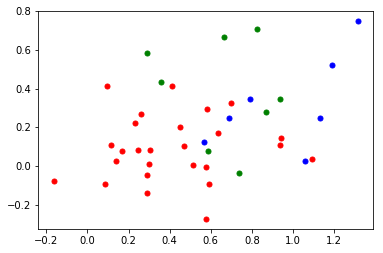

0
Êó©Áù° Â¶ûÂ¶ûËµ∑Ëøô‰πàÊó©? Ëøô‰πàÊó©Áù°ËßâÊµ™Ë¥πÁîüÂëΩ ‰Ω†Áü•ÈÅìÊôöÁù°Êúâ‰ªÄ‰πàÂç±ÂÆ≥Âêó? Êó©Ëµ∑Êúâ‰ªÄ‰πàÁî® ‰Ω†‰πüÊó©Áù° ÂÖ∂ÂÆûÊàëÊØî‰Ω†Ëµ∑ÁöÑÂ§™Êó©‰∫Ü ‰Ω†ËøòÊòØÊ≤°ÊàëËµ∑ÁöÑÊó©Âïä ‚Ä¶‚Ä¶ÂéüÊù•‚Ä¶‚Ä¶‰Ω†‰∏çÂÖâÁü•ÈÅìÊó©Ëµ∑‚Ä¶‚Ä¶ËøòÁü•ÈÅìÊôöÁù°‚Ä¶‚Ä¶/:|-)[Concerned][Smart] Êó©Áù°Êó©Ëµ∑Ë∫´‰ΩìÂ•Ω ÂÅáË£ÖËµ∑ÁöÑÊå∫Êó© Êó©Áù°Êó©Ëµ∑ ÊàëËøòÊ≤°Ë¶ÅÁù°Ëßâ[Facepalm][Facepalm] ÊàëËøôÊòØËøòÊ≤°Áù°ËßâÂë¢[Âõß][Âõß] Êó©Ëµ∑ÁöÑÈ∏üÂÑøÊúâËô´ÂêÉ~ Âë®Êú´Âì™ÊúâËøô‰πàÊó©Áù°ÁöÑ/:dig Êó©ÁÇπÁù°Â∞èÊù• ‰ªäÂ§©‰Ω†ËøòÊå∫Êó© ËøòÊòØËµ∑ÂæóÊó©Âïä ‰Ω†ÊÄé‰πàËµ∑ÈÇ£‰πàÊó©Âïä Êó©Ëµ∑ÁöÑ‰π†ÊÉØ‰ºöËÆ©‰Ω†ÁªàÁîüÂèóÁõäÊó†Á©∑ Êî∂Âà∞Êó©ÂÆâÈóÆÂÄôÊúâ‰ªÄ‰πàÁî®Âïä ÊØèÂ§©Êó©Ëµ∑ÁöÑÂ•Ω‰π†ÊÉØ Êó©Ëµ∑ÁöÑÂ•ΩÂ§ÑÊúâÂì™‰∫õÂë¢? ‰Ω†‰ª¨ÁúüÊó© Â∞èÊù•ÈóÆ‰∏Ä‰∏ã,‰∏ã‰∏Ä‰∏™ÊòéÂ§©ÁöÑÊàë,/:handclap/:handclap/:handclap/:handclap‰Ω†Ëµ∑ÁöÑÂ•ΩÊó©
1
Áù°Ëøô‰πàÊó© ‰ªäÊôöÊó©Áù°Ëßâ ÈÉΩËøô‰πàÊó© ‰ºëÊÅØËøòÊó© Ëøô‰πüÂè´Áù°ÁöÑÊó© ‰Ω†ÂíãËµ∑Ëøô‰πàÊó© ‰Ω†‰ªäÂ§©Ëµ∑Ëøô‰πàÊó©Âïä
2
Êó©ÁÇπÁù°Êó©ÁÇπÈÜí,‰πüÂ∞±Êó©ÁÇπÂÆûÁé∞Ëá™Â∑±ÁöÑÊ¢¶ÊÉ≥„ÄÇ ÊàëËøòÊ≤°ÊúâÁù°ËßâÂë¢ ÊòØÂïäÊó©ÁÇπÁù°‰∫Ü‚àº Ê

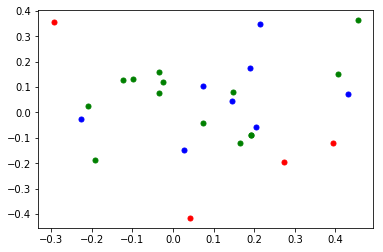

0
ÁªôÊàëÊù•‰∏ÄÈ¶ñÈÇ£ÁßçÂ•ΩÈü≥‰πê ÁªôÊàëÊîæÈ¶ñÊ≠å Â∏ÆÊàëÊîæÈü≥‰πê ‰∏∫‰ªÄ‰πà‰∏çÁªôÊàëÊîæÁîüÊó•Âø´‰πêÊ≠å
1
Â∞èÊù•Áé∞Âú®Êúâ‰ªÄ‰πàÊñ∞Ê≠åÊé®Ëçê‰∏ã ÊàëÊÉ≥Âê¨Ê≠å,‰Ω†Â∏ÆÊàëÊé®ËçêÈ¶ñÂ•ΩÂê¨ÁöÑÊ≠åÊõ≤Âêß Á≠â‰ºöÂÑøÂ∏ÆÊàëÊîæÊ≠å Ë°£‰∏çÂ¶ÇÊñ∞,‰∫∫‰∏çÂ¶ÇÊïÖ„ÄÇ Êó©Êô®ËΩªÂø´ÁöÑÈü≥‰πê ‰∏ãÊù•ËØ∑Êîæ‰∏ÄÈ¶ñÈÇì‰∏ΩÂêõÁöÑÊ≠åÊõ≤ ÊúâÊ≤°Êúâ‰ªÄ‰πàÂ•ΩÊ≠åÊé®Ëçê Êúâ‰ªÄ‰πàÂ•ΩÊ≠åÂêó
2
Êñ∞Ê≠åÊé®Ëçê Êé®ËçêÊ≠åÊõ≤ Ê≠åÊõ≤Êé®Ëçê ÁªôÊàëÊé®Ëçê‰∏ÄÈ¶ñÁΩëÊòìÊ≠åÊõ≤ ËÉΩÁªôÊàëÊé®ËçêÊ≠åÊõ≤ ÊòØÂê¶ÂèØ‰ª•Êé®Ëçê‰∏ÄÈ¶ñÊ≠åÊõ≤ Êé®Ëçê‰∏ÄÈ¶ñÊ≠åÊõ≤Âêß! Êé®ËçêÂá†È¶ñÂ•ΩÂê¨ÁöÑÊ≠åÊõ≤ ÊúâÊ≤°ÊúâÂ•ΩÂê¨ÁöÑÊ≠åÊõ≤Êé®Ëçê ÊúâÂêó,Êé®ËçêÁöÑÊ≠åÊõ≤ ÁªôÊàëÊé®ËçêÂá†È¶ñÂ•ΩÂê¨ÁöÑÊ≠åÊõ≤ Â∞èÊù•Âê¨Âà∞ÁöÑÊòØ:Êé®Ëçê‰∏ÄÈ¶ñÊ≠åÊõ≤Âêß! ÁªôÊàëÊé®Ëçê‰∏ÄÈ¶ñÊ≠å ÊúÄËøëÊúâÂ•ΩÂê¨ÁöÑÈü≥‰πêÊé®ËçêÂêó
17.283633162797173


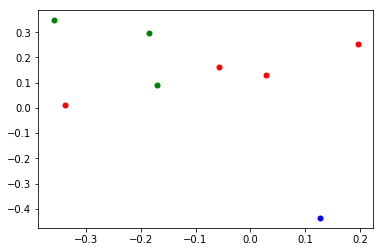

0
Êù•È¶ñËã±ÊñáÊ≠å Êé®Ëçê‰∏ÄÈ¶ñËã±ÊñáÊ≠å ‰∏ÄÈ¶ñÊ≠å Â•ΩÊó†ËÅäÂïä!Êù•È¶ñÈü≥‰πêÂêß
1
‰∏ç‰∏ç‰∏çÊàëË¶ÅÂê¨Ê≠å
2
Â•ΩÂê¨ÁöÑËã±ÊñáÊ≠å ‰ªÄ‰πàÊ≠åÂ•ΩÂê¨ Â•ΩÂê¨ÁöÑÊâãÊú∫ÈìÉÂ£∞
0.442450770822671


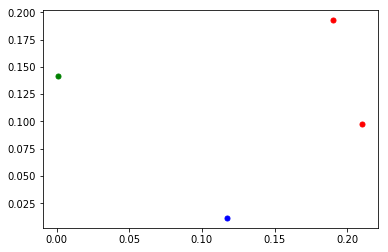

0
ÊãñÂª∂Áóá ÊúâÊãñÂª∂ÁóáÊÄé‰πàÂäû
1
ÊãñÂª∂Áóá,ÊôöËµ∑‰∏ÄÂ∞èÊó∂
2
ÊãñÂª∂ÁóáÊÄéÈ∫ºËæ¶
55.901670537510924


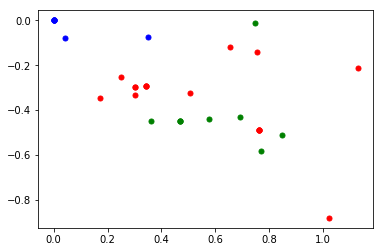

0
1+1Á≠â‰∫éÂá† 1+1Á≠â‰∫é ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂá† ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂá†? ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂá†‰∏ÄÂä†‰∏Ä ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂá†. ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂá†Âïä! ‰∏ÄÂä†‰∏Ä‰ªÄ‰πàÊó∂ÂÄôÁ≠â‰∫é‰∏Ä, ‰∏ÄÂä†‰∏Ä‰ªÄ‰πàÊó∂ÂÄôÁ≠â‰∫é, 5+6Á≠â‰∫é ‰∫åÂä†‰∫åÁ≠â‰∫éÂá†, ‰∫åÂçÅ‰∫î‰πò‰ª•‰∏ÄÁôæÊòØ ‰∏ÄÂä†‰∫åÁ≠â‰∫éÂá† 13√ó2‰∏çÁ≠â‰∫é3„ÄÇ ËØ∑ÈóÆÁ≠â‰∫éÂá†? 5201314‰πò‰ª•10Á≠â‰∫é ‰∏Ä‰∫å‰∏âÂõõ‰∫îÂä†‰∫îÂÖ≠‰∏ÉÂÖ´‰πùÁ≠â‰∫éÂá†
1
1+1= 1+1 1+1=? 5201314‰πò‰ª•10 9√ó60 5*14Âπ≥Â§¥ 1Âä†1
2
1+1Á≠â‰∫éÂ§öÂ∞ë? ‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂ§öÂ∞ë? Êù•Èáé‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂ§öÂ∞ë ÂëäËØâÊàë‰∏ÄÂä†‰∏ÄÁ≠âÂ§öÂ∞ë ÂëäËØâÊàë‰∏ÄÂä†‰∏ÄÁ≠â‰∫éÂ§öÂ∞ë. ÂçÅÂä†‰∫îÁ≠â‰∫éÂ§öÂ∞ë 754*865Á≠â‰∫éÂ§öÂ∞ë 400-30Á≠â‰∫éÂ§öÂ∞ë ‰πùÂçÅ‰πù‰πò‰ª•‰πùÂçÅ‰πùÁ≠â‰∫éÂ§öÂ∞ë
11.87458596145283


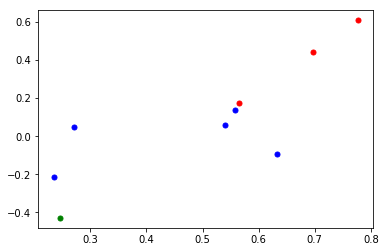

0
Â≠§Áã¨ ÊàëÂ•ΩÂ≠§Áã¨ ÊàëÂ≠§Áã¨
1
‰Ω†ÊÑüÂèóËøáÂ≠§Áã¨Âêó Êàë‰∏ÄÁõ¥Ê≤°ÊÑüÂèóÂà∞‰Ω†ÂØπÊàëÁöÑÁà±„ÄÇ ÊàëÂèà‰∏çÊòØÂÇªÂ≠êÊ≤°ÊÑüÂèó? Êàë‰∏Ä‰∏™‰∫∫Â•ΩÂ≠§Áã¨ Ê≤°‰∫∫Èô™ÊàëÂ•ΩÂ≠§Áã¨/:P-(/:P-(/:P-(
2
Êª°ÂàÜÂçÅÂàÜÊàëÂØπ‰Ω†Áà±Âà∞‰∫ÜÂçÅÂàÜ
7.826439045781944


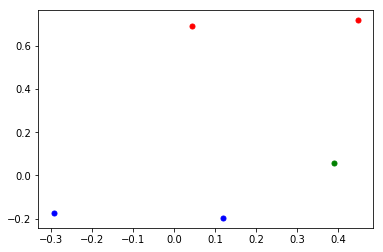

0
ÊÄé‰πàËØª‰π¶ ËØª‰π¶
1
Â¶Ç‰ΩïÊâæÂà∞Ëá™Â∑±ÊÉ≥ÁúãÁöÑ‰π¶? Êü•‰∏Ä‰∏ãË±ÜÁì£ËØÑÂàÜ9.5ÂàÜ‰ª•‰∏äÁöÑ‰π¶
2
Êúâ‰π¶Êé®ËçêÂòõ?
16.649072578189525


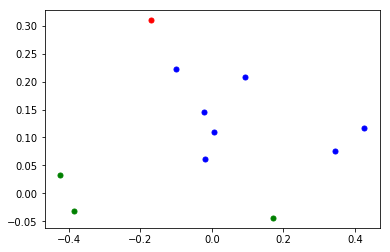

0
ÁîµËßÜÂâß
1
Â∞èÊù•,ÊúÄËøëÊúâ‰ªÄ‰πàÁîµËßÜÂ•ΩÁúã ÁÉ≠Êí≠ÁîµËßÜÂâß ÊàëÊÉ≥ÁúãÁîµËßÜÂâß ‰Ω†ÂñúÊ¨¢Áúã‰ªÄ‰πàÁîµËßÜÂâßÂïä ÊúÄËøëÁÉ≠Èó®ÁîµËßÜÂâßÊòØ‰ªÄ‰πà ‰Ω†Áúã‰∫ÜÈÇ£ÈÉ®ÁîµËßÜÂâßÂêó ÊúÄËøëÁöÑÁÉ≠Êí≠ÂâßÁåéÂú∫
2
Â•ΩÁúãÁöÑÁîµËßÜÂâß ‰ªÄ‰πàÁîµËßÜÂâßÂ•ΩÁúã ÊúÄËøëÊúâ‰ªÄ‰πàÂ•ΩÁúãÁöÑÁîµËßÜÂâß
0.34496544909846527


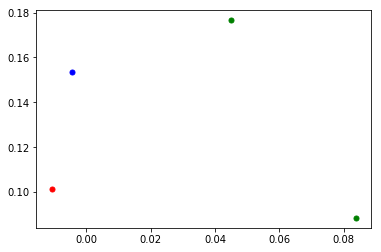

0
ÊúâÊ≤°ÊúâËÅåÂú∫ÁßòÁ±ç
1
ËÅåÂú∫ÁßòÁ±çÂú®Âì™Èáå
2
ËÅåÂú∫ÁßòÁ±ç ËÅåÂú∫ÁßòÁ±çÊúâÂêóÔºü
23.174547688522708


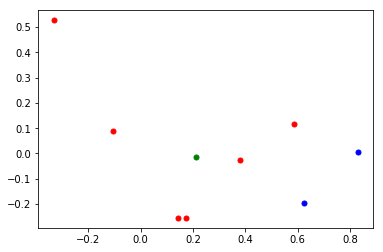

0
ÊÄéÊ†∑Â§ÑÁêÜÂ§´Â¶ªÂÖ≥Á≥ª Â§´Â¶ª‰πãÈó¥Ê≤°ÊúâÊÑüÊÉÖ‰∫Ü ËØ∑ÈóÆ‰∏Ä‰∏ã,Â§´Â¶ª‰∏§‰∏™Ê≤°ÊúâÊÑüÊÉÖÊÄé‰πàÂäûÂëê„ÄÇ ÂíåÁà±‰∫∫ÂêµÊû∂‰∫Ü ÊàëËÄÅÂÖ¨Ë¶ÅÁ¶ªÂ©ö‰∫Ü‰Ω†ËØ¥ÊÄé‰πàÂäû ÊÄé‰πàËÆ®Â™≥Â¶áÊ¨¢ÂøÉ
1
Êâæ‰∏ÄËá™Â∑±Áà±ÁöÑ‰∫∫Ëøô‰πàÈöæÂêó ‰∏∫‰ªÄ‰πàÁà±‰∏Ä‰∏™‰∫∫Ëøô‰πàÈöæ
2
Â§´Â¶ªÊÄß‰∫ã
1.1828763216999525


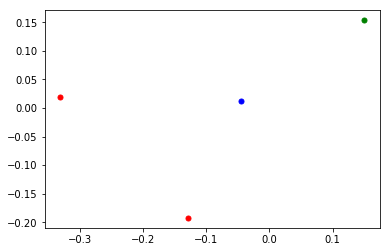

0
Â∏ÆÊàëÊî∂‰∏ÄÊî∂Âá†‰∏™‰∫∫Â∑•Êô∫ËÉΩÁöÑ‰π¶. Â∏ÆÂøôÊâæ‰∏Ä‰∫õ,Ëøô‰∏™‰∫∫Â∑•Êô∫ËÉΩÁöÑ‰π¶.
1
‰Ω†ÂñúÊ¨¢‰ªÄ‰πà‰π¶
2
ÊàëÈúÄË¶ÅÊúâÂÖ≥‰∫∫Â∑•Êô∫ËÉΩÊñπÈù¢ÁöÑ‰π¶
0.0


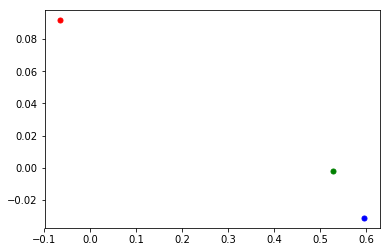

0
ÊàëË¶ÅËØªÈòøÊãâÊñØÂä†ËÄ∏ËÄ∏ËÇ©
1
Â•≥Á•û
2
Â¶Ç‰ΩïÊàê‰∏∫Â•≥Á•û
65.08244184900416


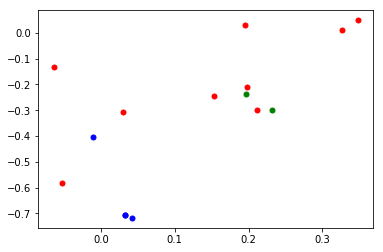

0
‰∏ÄÊù°ÁªôÂ•≥ÊúãÂèãÁöÑÂ¶àÂ¶àÁöÑÁîüÊó•Á•ùÁ¶èÁü≠‰ø°„ÄÇ Áà∂‰∫≤ËäÇÁªôÊàëËÄÅÁà∏Âèë‰∏ÄÊù°Á•ùÁ¶èËØ≠ Â∞èÊù•,Â∏ÆÊàëÁºñÊù°Áà∂‰∫≤ËäÇÁöÑÁ•ùÁ¶èÁü≠‰ø°Âêß ÈúÄË¶ÅÂ∞èÊù•ÁöÑÁ•ùÁ¶è Á•ùÁ¶èË∂äÊù•Ë∂äÂ•Ω È´òËÄÉÁ•ùÁ¶è ÁîüÊó•ÈÄÅÁ•ùÁ¶è ÈÄÅÁ•ùÁ¶è Á•ùÁ¶èÊ≥¢Ê≥¢ÁîüÊó•Âø´‰πê!
1
ÁîüÊó•Á•ùÁ¶è Á•ùÁ¶è! Á•ùÁ¶èÊàë Á•ùÁ¶è
2
ÊúâÁ•ùÁ¶èËØ≠Âêó Á•ùÁ¶èËØ≠
10.759740066210224


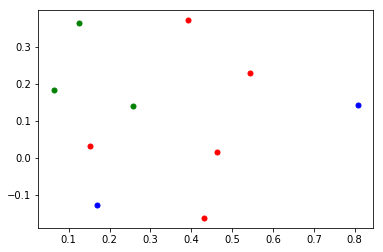

0
ËÅåÂú∫Á©øÊê≠ Á©øÊê≠Âª∫ËÆÆ Áî∑Â£´Á©øÊê≠ ÊúâÊ≤°ÊúâÁî∑Â£´Á©øÊê≠Âª∫ËÆÆ Ê≤°ÊúâÁî∑ÊÄßËÅåÂú∫Á©øÊê≠
1
Á©øÊê≠ Ë°£ÊúçÁ©øÊê≠
2
Áúã‰∏Ä‰∏ãthe lookËÅåÂú∫Á©øÊê≠ ËÅåÂú∫Á©øÊ≥ï ËÅåÂú∫
0.0


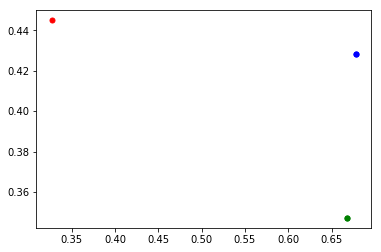

0
ÂçàÁù°ÁöÑÂêàÁêÜÊó∂Èó¥ÊòØ?
1
ÂçàÁù°ËÉΩÁù°Â§öÈïøÊó∂Èó¥ ÂçàÁù°ÂèØ‰ª•Áù°Â§öÈïøÊó∂Èó¥
2
ÂçàÁù°Áù°Â§ö‰πÖ ÂçàÁù°ÂèØ‰ª•Áù°Â§ö‰πÖ
12.47648073160192


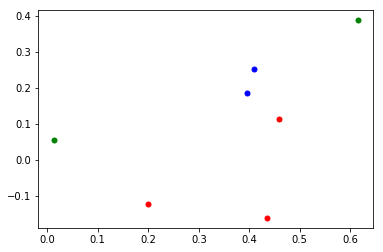

0
ÂõΩÂ∫ÜËäÇÂø´‰πê ÂÖÉÊó¶Âø´‰πê ÂÖÉÊó¶
1
Á•ùËøô‰∏™‰∏ñÁïåÁªßÁª≠ÁÉ≠Èóπ Á•ùËøô‰∏™‰∏ñÁïåÁÉ≠Èóπ
2
Ë∞¢Ë∞¢Ê±™ËÄÅÂ∏à ‰∏≠ÁßãÂø´‰πê! Âë®Êú™ÊÑâÂø´
3.003860513428881


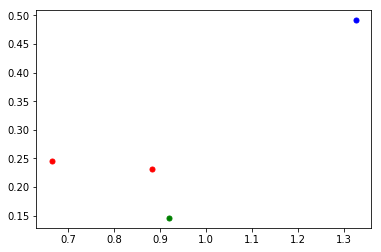

0
ÂõΩÂ∫Ü‰Ω†‰ª¨ÊîæÂÅáÂêóÔºü ‰Ω†ÊîæÂÅá‰∫ÜÂêó
1
ÊîæÂÅáÂêß
2
ÊîæÂÅáÂõûÊù•‰∫ÜÂêó
0.0


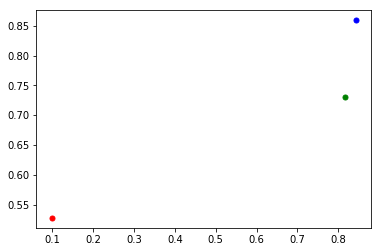

0
Â∞èÊù•ÂÅáÊúüÂíãÊ†∑
1
ÂÅáÊúüÊÑâÂø´
2
Á•ùÂÅáÊúüÊÑâÂø´
15.506709952769643


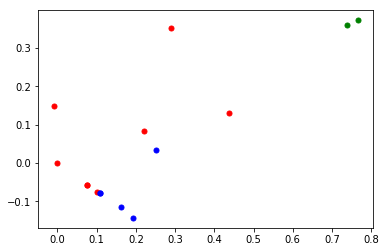

0
ÊÑüÊÅ©Êúâ‰Ω† ‰ªäÂ§©ÊÑüÊÅ©ËäÇÔºåÊÑüË∞¢Êúâ‰Ω†ÔΩûÂ∞èÊù•„ÄÇ ÊÑüÊÅ©ËäÇ Happy Thanksgiving Day Ë∞¢Ë∞¢!ÊÑüÊÅ©Êúâ‰Ω†! Ë∞¢Ë∞¢ÊÑüÊÅ©Êúâ‰Ω† Ë∞¢Ë∞¢ÊÑüÊÅ©Êúâ‰Ω†/:heart Ë∞¢Ë∞¢!ÊÑüÊÅ©Êúâ‰Ω†ÁöÑÈô™‰º¥/:heart
1
ÊÑüÊÅ©ËäÇÂø´‰πê Ë∞¢Ë∞¢ÔºÅÊÑüÊÅ©ËäÇÂø´‰πêÔºÅ Á•ù‰Ω†ÊÑüÊÅ©ËäÇÂø´‰πê! Á•ùÂ∞èÊù•ÊÑüÊÅ©ËäÇÂø´‰πê Ë∞¢Ë∞¢!ÊÑüÊÅ©ËäÇÂø´‰πê!
2
Ë∞¢Ë∞¢!ÊÑüÊÅ©ËäÇÂø´‰πê!/:rose/:rose/:rose Á•ùÂ§ßÂÆ∂ÂÖÉ‰∏îÂø´‰πê!/:rose/:rose/:rose
0.0


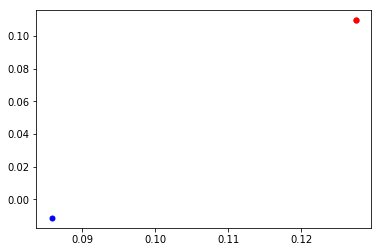

0
‰ªÄ‰πàÊòØÂØíË°£ËäÇ? ÊòØ‰ªÄ‰πàÂØíË°£ËäÇ?
1
‰ªÄ‰πàÊòØÂØíÊúçËäÇ?
77.13350302491038


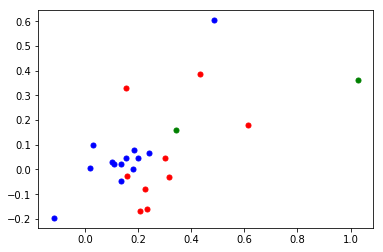

0
Êñ∞Âπ¥Âø´‰πê Á•ùÂ∞èÊù•Êñ∞Âπ¥Âø´‰πêÔºå‰∏á‰∫ãÂ¶ÇÊÑè Â∞èÊù•Êñ∞Âπ¥Âø´‰πê ÊÅ≠Á•ùÊñ∞Âπ¥Âø´‰πê!‰∏á‰∫ãÂ¶ÇÊÑè Ë∞¢Ë∞¢‰∫≤Áà±ÁöÑ!‰πüÁ•ù‰Ω†Êñ∞Âπ¥Âø´‰πêÂπ≥ÂÆâÂÅ•Â∫∑ [ÂæÆ‰ø°Á∫¢ÂåÖ] Êñ∞Âπ¥Âø´‰πê!ÁãóÂπ¥Â§ßÂêâ ‰∏á‰∫ãÂ¶ÇÊÑè ÁãóÂπ¥Âø´‰πê ÁãóÂπ¥Â§ßÂêâ
1
happy new year Êñ∞Êò•Âø´‰πê Êò•ËäÇÂø´‰πê ‰∫åÈõ∂‰∏ÄÂÖ´   Â∞èÊù•Êñ∞Âπ¥Âø´‰πê Êñ∞Âπ¥Âø´‰πêÓàùÓà•ÓàúÓà£Óåí Êñ∞Âπ¥Âø´‰πê!ÊÑüÊÅ©‰∏ÄË∑ØÈô™‰º¥!Â∏åÊúõÊ≠§ÂÖ¨‰ºóÂè∑Ë∂äÂäûË∂äÂ•Ω!/:sun Á•ùÊñ∞Âπ¥Âø´‰πê  „ÄÇ                           Ë¥¢ËøêÊó∫Êó∫  „ÄÇ                          ÁãóÁãóË∑≥Ëµ∑Êù• Áè™ÁúüÁ•ù‰Ω†Êñ∞Âπ¥Âø´‰πê Êñ∞Âπ¥Âø´‰πê[Â∞èÁãó][Â∞èÁãó]ÓÑíÓåíÓåí Êñ∞Âπ¥Âø´‰πê‰∏á‰∫ãËÉúÊÑè ‰∏á‰∫ãÂ¶ÇÊÑè/::*/:rose[Packet][Áôº]ÓÑíÓåí Â∞èÊù•Êù• ‰∏çÁü•ÈÅì‰Ω†ËøòËÉΩ‰∏çËÉΩÁúãÂà∞ÊàëÁöÑÁ•ùÁ¶è Áªô‰Ω†‰ª¨Êãú‰∏™Êó©Âπ¥‚àº Êñ∞Âπ¥Âø´‰πê ÓÄ¢ÓÄ¢ÓÄ¢ÁãóÂπ¥Êó∫Êó∫Êó∫ÓåíÓåíÓåí
2
Ë¶ÅËøáÂπ¥‰∫Ü ËøáÂπ¥‰∫Ü
0.0


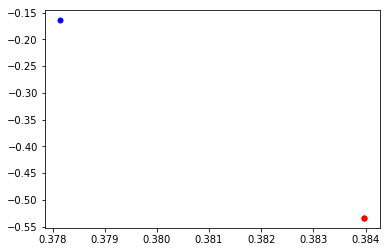

0
ÊÉÖ‰∫∫ËäÇÂø´‰πê ÊÉÖ‰∫∫ËäÇÂø´‰πêÂì¶
1
Á•ù‰Ω†ÊÉÖ‰∫∫ËäÇÂø´‰πê
7.216378202248821


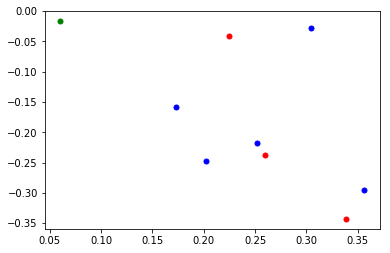

0
ÂÖ≠‰∏ÄÂø´‰πê ÂÑøÁ´•ËäÇÂø´‰πê Â∞èÊù•ÔºåÂÑøÁ´•ËäÇÂø´‰πêÂì¶
1
ÂÖ≠‰∏ÄÂø´‰πêÂë¶ 61Âø´‰πê Ë∞¢Ë∞¢ÔºÅÂÑøÁ´•ËäÇÂø´‰πêÔºÅ Á•ùÂ∞èÊù•ÂÑøÁ´•ËäÇÂø´‰πê Á•ù‰Ω†ÂÑøÁ´•ËäÇÂø´‰πê!
2
ÂÑøÁ´•ËäÇÊó•Âø´‰πê
0.0


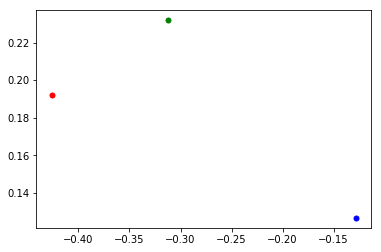

0
ÈïøÊò•Êúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
1
‰∏úÂåóÊúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
2
ÂêâÊûóÊúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
0.0


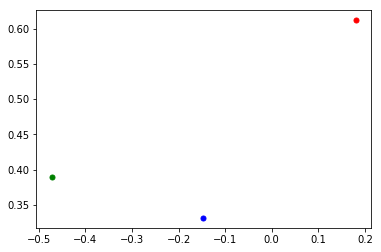

0
Â§ßËøûÊúâÂì™‰∫õÁæéÈ£ü
1
ËæΩÂÆÅÊúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
2
Ê≤àÈò≥Êúâ‰ªÄ‰πàÂ•ΩÂêÉÁöÑ
0.8889843414779842


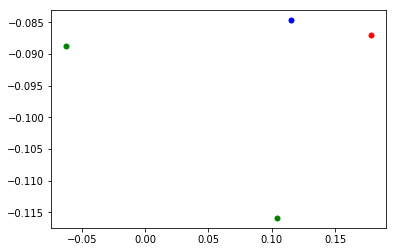

0
Â∞èÈõ™ÊòØ‰ªÄ‰πàÊÑèÊÄù
1
Â∞èÈõ™
2
Â∞èÈõ™ÊòØ‰ªÄ‰πàÊó∂ÂÄô Â∞èÈõ™ÊòØ‰ªÄ‰πà
162.5487879704569


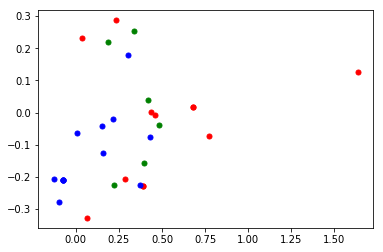

0
ÊàëÊòØË∞Å Â∞èÊù•ÊàëÊòØË∞ÅÔºü ‰Ω†Áü•ÈÅìÊàëÊòØË∞ÅÂïä ËÆ§ËØÜÊàëÂêó? ‰Ω†ÁåúÁåúÊàëÊòØË∞Å? ‰Ω†ÊáÇÊàëÊòØË∞ÅÂêó? ‰ª•ÂêéÂØπÊàëÁöÑÁß∞ÂëºÁî®Á≤ëÁ≤ë ÊàëÊòØ‰∏™Â§ßÂÇªÁìú ÊàëÊòØÂÖ¨‰∏ªÂêó Ê¨∫Ë¥üÊàëÊòØÂçïË∫´ÁãóÂïä ÈÇ£ÊòØÊàëËá™Â∑± ‰Ω†Áü•ÈÅìÊàëÊòØË∞ÅÂòõ
1
ÊàëÂè´‰ªÄ‰πà ‰Ω†Âè´Êàë‰ªÄ‰πà ‰Ω†Âè´Êàë‰ªÄ‰πàÂëÄ ‰Ω†Âè´Êàë‰ªÄ‰πàÔºü Â∞è‰∏ªÂè´‰ªÄ‰πàÂêçÂ≠ó ÊàëÊòØÂ•≥Áöá ÈÇ£‰Ω†Âè´Êàë‰ªÄ‰πà Áü•ÈÅìÊàëÂè´‰ªÄ‰πàÂêó? [domain1018]Âè´ÊàëÂ§ßÂ∞èÂßê ‰Ω†ÁúãÊàëÊòØ‰ªÄ‰πàÊ†∑ÁöÑ‰∫∫Âë¢ ÁªôÊàëËµ∑‰∏™Ëã±ÊñáÂêç ‰Ω†ÊòØ‰∏™Ëá≠Â±ÅËõã ‰Ω†Â¶πÂ¶πÂè´‰ªÄ‰πàÂêçÂ≠ó
2
‰Ω†ÊÄé‰πàÁß∞ÂëºÊàë ÊàëÁöÑÂêçÂ≠ó ÁªôÊàëÂèñ‰∏™ÂêçÂ≠ó ‰ª•ÂêéÂØπÊàëÁöÑÁß∞ÂëºÁî®Áà∏Áà∏ ‰Ω†Ëøô‰πàÁü•ÈÅìÊàëÁöÑÂêçÂ≠ó ‰ª•ÂêéÁß∞ÂëºÊàëÂÖ¨‰∏ª
25.7620608488065


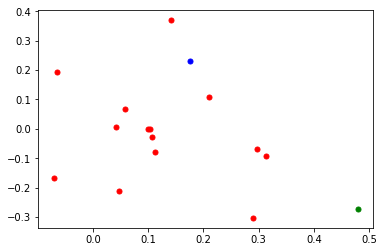

0
Âè´Êàë‰∏ª‰∫∫ Âè´ÊàëÂÖ¨‰∏ª Âè´Êàëhelen‰∏çÂè´Â∞è‰∏ª Âè´ÊàëÊÄ°ËÄÅÂ§ß Âè´ÊàëÂ´íÂ´í ËØ∑Âè´ÊàëÈôõ‰∏ã ÊàëÂè´baby Âè´ÊàëÂ∫∑Âì• ‰ª•ÂêéÂ∞±Âè´ÊàëÁöáÂêéÂ®òÂ®ò ‰ª•ÂêéÂè´ÊàëAmyÂ∞±Â•ΩÂï¶,Ë∞¢Ë∞¢ÈÖçÂêà! ËÆ§ËØÜ‰∏Ä‰∏ã,ÊàëÂè´,Êú±Èõ® ÂìáÂ°û ËøòËÆ∞ÂæóÊàë ÊïôÊàëÂº∫Âì• ‰Ω†Âè´ÊàëÂ•≥Áéã
1
ÊòµÁß∞
2
ÊàëÁöÑÂêçÂ≠óÈîôÂï¶
75.50175042418813


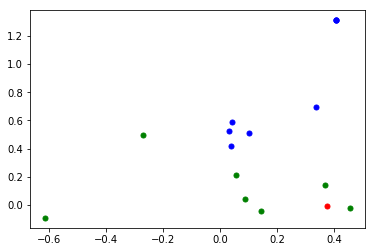

0
‰πàÊÑèÊÄù
1
ÊúâÁÇπÊó†ËÅäÂïäÔºÅÂ∞èÊù• Êó†ËÅäÔºå Â•ΩÊó†ËÅäÂïä Êó†ËÅä ÂæàÊó†ËÅäÂïäÔºÅ ÊàëÊúâÁÇπÊó†ËÅä ÊúâÁÇπÊó†ËÅä Êó†ËÅäÂ∞ºÁéõ
2
Âìé!‰Ω†‰πüÂ∏ÆÊàë,Â∞±ÂèëÁªô‰Ω†,Ëß£Ëß£Èó∑ Ëß£Èó∑ Â§©Â§©‰πüÂ∞±Ë∑ü‰Ω†‰Ωú‰º¥‰∫Ü Ê≤°ÊÑèÊÄù Â∞èÂÆ∂‰ºôÊàëÊúâÁÇπÊó†ËÅäÂïä ÂπΩÈªòÁ¨ëËØù ÊàëÊÄé‰πàÊâçËÉΩÂπΩÈªòÂë¢
277.1451265979181


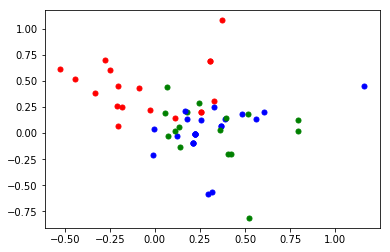

0
‰ªäÂ§©ÂøÉÊÉÖ‰∏çÂ§™Â•Ω Êàë‰ªäÂ§©ÂøÉÊÉÖ‰∏çÂ•Ω Êàë‰ªäÊôöÂøÉÊÉÖÂèØ‰∏çÂ•Ω ÊàëÁé∞Âú®ÂøÉÊÉÖ‰∏çÂ•Ω ‰ªäÂ§©ÂøÉÊÉÖ‰∏çÂ•Ω ÊàëÂøÉÊÉÖ‰∏çÂ§™Â•Ω ‰º§ÂøÉ ‰∏çÁàΩ ÊàëÂ•Ω‰º§ÂøÉ ÂøÉÊÉÖ‰∏ç‰Ω≥ ‰ºöÂõ†‰∏∫‰ªÄ‰πàÂéüÂõ†ËÄåÂøÉÊÉÖ‰∏çÂ•ΩÂêó ‰º§ÂøÉ Âïä ÂæàÈöæËøá ÂøÉÊÉÖ‰ΩéËêΩÁöÑÊó∂ÂÄô ÈÉÅÈó∑ ÊàëÂ•Ω‰º§ÂøÉÂëÄ ÂøÉÊÉÖ‰∏çÂ•ΩÊúâ‰ªÄ‰πàÊ∏∏ÊàèÁé© ÂøÉÊÉÖÂçÅÂàÜ‰∏çÁàΩ
1
‰ªäÂ§©Êàë‰∏çÂºÄÂøÉ ÊàëÊúâÁÇπ‰∏çÂºÄÂøÉ ‰∏çÂºÄÂøÉ‰∫Ü Êàë‰∏çÂºÄÂøÉ Êàë‰∏çÂºÄÂøÉ‰∫Ü Êàë‰ªäÂ§©‰∏çÂºÄÂøÉ ÊàëÂæà‰∏çÂºÄÂøÉ ‰∏çÂºÄÂøÉ‰∫Ü ÂºÄÂøÉ‰∏çËµ∑Êù• Â∞èÊù•Êàë‰∏çÂºÄÂøÉ ‰ªäÂ§©‰∏ÄÁÇπÈÉΩ‰∏çÂºÄÂøÉ ‰∏äÁè≠‰∏çÂºÄÂøÉ ‰∏çÊÑâÂø´Âë¢ ‰∏çÂºÄÂøÉ ‰∏çÂºÄÂøÉÂë¢ ÈùûÂ∏∏‰∏çÂºÄÂøÉ ‰∏çÂ§™ÂºÄÂøÉ Êàë‰∏çÂø´‰πê ÊàëËøòÊòØ‰∏çÂºÄÂøÉ ÊÄé‰πà‰ºöÁü•ÈÅìÊàë‰∏çÂºÄÂøÉ ‰∏çÂø´‰πê Êàë‰∏çÂñúÊ¨¢Âïä Êúâ‰ªÄ‰πà‰∏çÂºÄÂøÉÁöÑÂéªÁé©‰∏Ä‰∏ãÂºÄÂøÉ‰∏Ä‰∏ã ÁúüÁöÑ‰∏çÂºÄÂøÉ‰∫Ü
2
Êó†Â•à Â•Ω‰º§ÂøÉÓÄ£ ‰∏Ä‰∏™‰∫∫‰∏∫‰ªÄ‰πà‰ºöËÄÅÊòØÂèπÊ∞î ‰ªäÂ§©ËøêÊ∞îÂ∑Æ ÊàëÊÉ≥‰∏çÈÄö‰∏∫‰ªÄ‰πàÂà´‰∫∫ËÉΩËÄÉ‰∏äÊàëËÄÉ‰∏ç‰∏ä ÊàëÁé∞Âú®ÊãøÂàÄÊåáÁùÄ‰Ω† ÈÇ£ÊàëÂ∞±‰∏çÂñúÊ¨¢‰Ω†‰∫Ü Êàë‰∏çÁü•ÈÅìÊàë‰∏∫‰ªÄ‰πàÂéãÂäõËøô‰πàÂ§ß ÊàëÊúÄËøëÊÄªÊòØ‰∏çÂºÄÂøÉ ‰ΩÜÊòØÊàë‰∏çÁà±

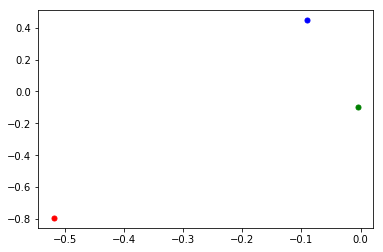

0
ËÆ≤‰∏™Á¨ëËØù
1
ËÆ©ÊàëÂπΩÈªò
2
ÊÆµÂ≠ê
58.54594923638997


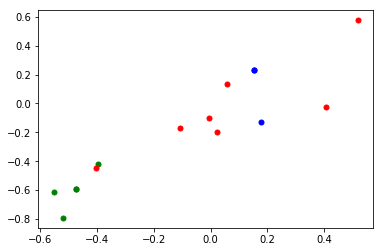

0
Â∞èÊù•,ÁªôÊàëËÆ≤‰∏™ÊïÖ‰∫ãÂêß ÊÆµÂ≠ê ËÆ≤ÊïÖ‰∫ã Êù•‰∏™ÊÆµÂ≠ê Á¨ëËØùÂ§ßÂÖ® ÁªßÁª≠ÂèëÈ´òÁ∫ßÊÆµÂ≠êÂ•Ω‰πà ÊîæÊùæ‰∏Ä‰∏ã
1
ÂÜ∑Á¨ëËØù ÁªôÊàëËÆ≤‰∏™ÊúÄÊñ∞ÂÜ∑Á¨ëËØù ÂÜ∑Á¨ëËØùÂë¢
2
ËÆ≤Á¨ëËØù ËÆ≤‰∏™Á¨ëËØùÂêß Êù•‰∏™Á¨ëËØù ÁªôÊàëËÆ≤‰∏™Á¨ëËØù ÁªôÊàëËÆ≤‰∏™Á¨ëËØùÂêß
56.381468072806015


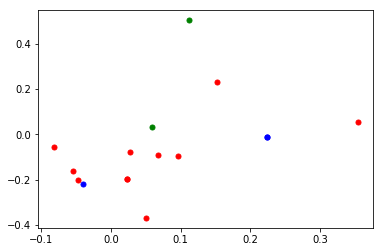

0
ËØ¥‰∏™ÊÆµÂ≠ê Êù•‰∏™ÊÆµÂ≠ê ÂÜÖÊ∂µÊÆµÂ≠ê ËÆ≤‰∏™ÊÆµÂ≠ê Êù•‰∏Ä‰∏™ÊÆµÂ≠ê ËÆ≤‰∏™ÊêûÁ¨ëÊÆµÂ≠êÂê¨Âê¨ Êù•‰∏™ÊÆµÂ≠êÂêß Êù•‰∏™ÊêûÁ¨ëÊÆµÂ≠ê. Âä±ÂøóÊÆµÂ≠êÊúâÂêó ÂÜçËÆ≤‰∏Ä‰∏™ÊÆµÂ≠ê ÂÜ∑Á¨ëËØù
1
‰∏çÂºÄÂøÉ ‰ºêÂºÄÂøÉ ‰∏çÂºÄÂøÉ‰∏çÂºÄÂøÉ
2
ÈÇ£‰Ω†Â∞±ÊÉ≥ÊÉ≥ÂäûÊ≥ï,,ÊääÊàëÂºÑÂºÄÂøÉÂëÄ ÊÇ≤‰º§Âì¶
33.12996320317537


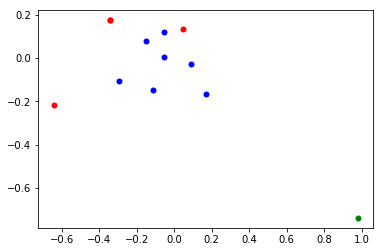

0
‰∏çÂ•ΩÁ¨ë Ëøô‰∏™‰∏çÂ•ΩÁ¨ë ËôΩÁÑ∂‰∏çÂ•ΩÁ¨ë ËøôÁ¨ëËØù‰∏ÄÁÇπÈÉΩ‰∏çÂ•ΩÁ¨ë„ÄÇ
1
ÊêûÁ¨ëÁÇπÁöÑ,Â∞ΩÈáè‰∏çË¶ÅÈáçÂ§ç„ÄÇ Êç¢‰∏Ä‰∏™,‰∏çÂ•ΩÁ¨ë ‰∏çÂ•ΩÁ¨ë‰∏çÂ•ΩÁ¨ë,Âà´‰∫∫ÁªÑÈÉΩÊúâÂ§ßËÖøÊä±,Êàë‰ª¨ÁªÑÂÖ®ÊòØÈ∫ªÁìú ‰Ω†ËÆ≤ÁöÑÁ¨ëËØù‰∏çÂ•ΩÁ¨ë Ëøô‰∏™‰∏ÄÁÇπÈÉΩ‰∏çÂ•ΩÁ¨ëÂïä!‰Ω†ÊííË∞é. ‰ªÄ‰πàÊ≤°Á¨ë Â∞èÊù•‰Ω†ËÆ≤ÁöÑÁ¨ëËØù‰∏çÂ•ΩÂê¨
2
Êç¢‰∏Ä‰∏™
80.27942430720738


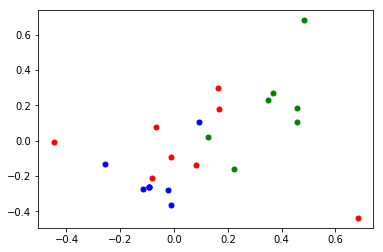

0
ÂøÉÁêÜÈ∏°Ê±§ ÂøÉÈáåÈ∏°Ê±§Âõæ È∏°Ê±§Â∞èËØ≠ Êù•Á¢óÂøÉÁÅµÈ∏°Ê±§ Êù•ÁÇπÂøÉÁÅµÈ∏°Ê±§ ÊàëË¶ÅÂøÉÁÅµÈ∏°Ê±§ ‰∏ÄÂè•‰∏™ÊÄßÁ≠æÂêç Ëµ∞ÂøÉÈ∏°Ê±§
1
Êù•‰∏™È∏°Ê±§ È∏°Ê±§ È∏°Ê±§! Ê±ÇÈ∏°Ê±§ È∏°Ê±§Âë¢? Êù•Á¢óÈ∏°Ê±§ Â•ΩÈ∏°Ê±§ ÊàëË¶ÅÂñùÈ∏°Ê±§
2
‰∫∫ÁîüÊ†ºË®Ä ‰ΩÜÊòØ‰∫∫ÁîüÊÄªÊúâËµ∞ÈîôÁöÑË∑Ø Âê¨‰∫∫ÁîüÂÖ∏ÊïÖ Â∞èÊù•‰Ω†Áî®Â≠¶‰π†Âêó ËøòÊúâ‰ªÄ‰πàÂ•ΩÁúãÁöÑËØù,ÊØîÂ¶Ç‰∫∫ÁîüÈÅìÁêÜ Âì•ÂøÉÈáåÁ©∫ËôöÂïä ÁªôÊàëÂèë‰∏ÄÊÆµ‰∫∫ÁîüÊ†ºË®Ä
5.42012884384595


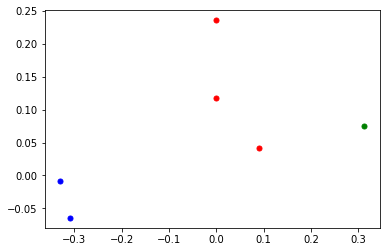

0
Â∞èËØ¥ ÊúâÂ∞èËØ¥Âêó? Êù•ÈÉ®Â∞èËØ¥
1
Â•ΩÁúãÁöÑÂ∞èËØ¥ ‰ªÄ‰πàÂ∞èËØ¥Â•ΩÁúã
2
ÊâìÁîµËØùÁöÑÊó∂ÂÄôËØ¥‰∏§Âè•Âä±ÂøóÁöÑËØù
30.362439123202858


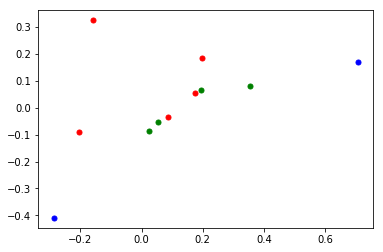

0
ÁªôÊàëÊù•‰∏™ÊêûÁ¨ëËßÜÈ¢ë ÊúâÊ≤°ÊúâÊêûÁ¨ëÁöÑËßÜÈ¢ëÂë¢ ÊêûÁ¨ëÁöÑ ÊêûÁ¨ëÁöÑËßÜÈ¢ëÊù•‰∏ÄÊâì Êúâ‰ªÄ‰πàÂÜ∑Áü•ËØÜËßÜÈ¢ëÂë¢?
1
ËßÜÈ¢ëÁ¨ëËØù ËßÜÈ¢ë
2
Âú®Âêó‰Ω†ÂèëÂÖàÂèë‰∫õÂÖ≥‰∫éËøôÁßçËßÜÈ¢ëÁöÑÁªôÊàë Êù•‰∏™ËµµÊú¨Â±±ÁöÑÂ∞èÂìÅ ÈÉΩË∑üÊàëÂèë‰∫õÂï•Â≠ê ‰Ω†ÁªôÊàëÊíáÂ∑ÆÂèëËßÜÈ¢ëÂ∞èÂøÉÊàëÊäïËØâ‰Ω†
8.725051859347086


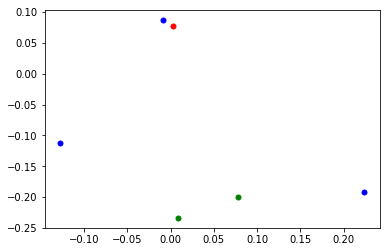

0
Èô§‰∫ÜËÆ≤Á¨ëËØùËøò‰ºöÂπ≤‰ªÄ‰πàÂïä
1
‰Ω†‰ºöËÆ≤ÈªÑÊÆµÂ≠êÂêó ‰Ω†‰ºöËÆ≤Êàê‰∫∫Á¨ëËØùÂêó ËÆ≤‰∏Ä‰∏™Êàê‰∫∫ÁöÑ
2
ÁªôÊàëËÆ≤‰∏™Êàê‰∫∫ÊÆµÂ≠ê ÊàëË¶ÅÊå∫ÈªÑËâ≤ÁöÑÊÆµÂ≠ê
352.65977265933157


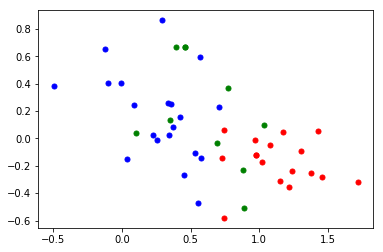

0
Êó©ÂÆâÂç° Ëµ∑Â∫äÂç° ÊÄé‰πàÊâìÊôöÂÆâÂç° Êó©ÂÆâÔΩû Êó©ÂÆâËØ¥ËØ¥ Êó©ÂÆâ0 Êâì Âç° Êâì‰ªÄ‰πàÂç° ËÉΩÂú®Âèë‰∏™ÊôöÂÆâÂç°Âêó Áé∞Âú®‰∏çËÉΩÊâìÊó©ÂÆâÂç°? ËØ∑ÂáÜÂ§áÂ•ΩÊôöÂÆâËØ≠ÂíåÊó©ÂÆâËØ≠ Ë°•ÊâìÊó©ÂÆâÂç° ÂèØ‰ª•ËØ¥ÊôöÂÆâÂç°Âêó? ÊàëÊÉ≥ÊâìÊó©ÂÆâÂï¶ ÊÄé‰πàÊâìÊó©ÂÆâÂç° ÊúâÊ≤°ÊúâÊôöÂÆâÂç° ÊÄéÊ†∑ÊâçËÉΩÊâìÊôöÂÆâÂç°
1
Êô®Ëµ∑ÊâìÂç° ‰ªäÂ§©ÁöÑÊâìÂç°ÂèëÁªôÊàë‰∏Ä‰∏ã Áúã‰∏çÊáÇ,Â§©Â§©Êò®ÊâìÂç°ÂëÄ! Ë°å‰∫Ü,ÊàëÊâìÂç° Êó©ÂÆâÂéªÂì™ÈáåÊâìÂç° Âì™ÈáåÊâìÂç° ÊØèÂ§©Ë¶ÅÊó©Ëµ∑ Â¶Ç‰ΩïÂà∂‰ΩúËá™Â∑±ÁöÑÊó©Ëµ∑Âç° ÊÄé‰πàÊâìÂç°ÂëÄ ËÉΩ‰∏çËÉΩÊØèÂ§©Ëµ∑Êù•Â∞±ÂèØ‰ª•Ëá™Â∑±ÊâìÂç°,ÊØèÂ§©ÈÉΩË¶ÅÊî∂Âà∞ËøôÊù°‰ø°ÊÅØÊâçËÉΩÊâìÂç°,Êúâ‰∫õÊó∂ÂÄôÂèàÊî∂‰∏çÂà∞ Êó©‰∏äÊÄé‰πàÊâìÂç° ËØ∑ÈóÆÂ¶Ç‰ΩïÊâìÊó©ÊôöÂÆâÂç°? ÊÄé‰πàÊâì Êàë‰ªäÂ§©Ë¶ÅÊâìÂç° ËØ∑ÈóÆÊúâÊú¨‰∫∫‰∫åÁª¥Á†ÅÁöÑÂõæÁâáÊÄéÊ†∑Ëé∑Âèñ Á¨¨‰∫åÂ§©Â¶Ç‰ΩïÊâìÂç°Âì©? Êó©Ëµ∑‰∫åÁª¥Á†Å ÂøòËÆ∞ÊÄé‰πàÊâìÂç° ÊàëÁé∞Âú®Ë¶ÅÊâìÂç°Âú®ÈÇ£ÈáåËøõÂéª‰Ω† ÊúâÊ≤°ÊúâÊó©Áù°ÊâìÂç°ÂÖ¨‰ºóÂè∑
2
Êó©Ëµ∑ÊâìÂç° Ëµ∑Â∫äÊâìÂç°. ÊâìÂç°Ëµ∑Â∫ä ÊâìÂç°Êó©ÂÆâ ÊàëË¶ÅÊó©Ëµ∑ÊâìÂç° Êó©Ëµ∑ Êó©Ëµ∑ÊâìÂç°ËØ¥Êó©ÂÆâ ÊâìÂç°(ÊôöÂÆâ) ÊàëË¶ÅÊâìÂç°Êó©ÂÆâ (ÊâìÂç°
40

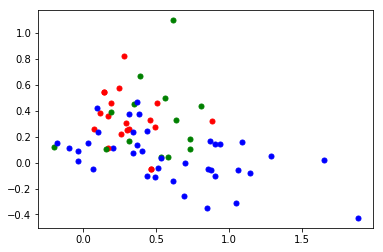

0
Êôö‰∏äÁöÑÊâìÂç°Êó∂Èó¥ÊòØÂá†ÁÇπÔºü Âá†ÁÇπÂèØ‰ª•ÊâìÂç°Ôºü ÊôöÂÆâÊâìÂç°‰ªéÂá†ÁÇπÂºÄÂßã Âá†ÁÇπÊâçÂºÄÂßãÂïä‚Ä¶‚Ä¶ ÊØèÂ§©Êó©‰∏äÊúÄÂ•ΩÂá†ÁÇπÊâìÂç° Êó©Ëµ∑ÊòØÂá†ÁÇπ ÊúÄÊôöÂá†ÁÇπÊâìÂç° Ëµ∑Â∫äÊó∂Èó¥ÊòØÂá†ÁÇπÂà∞Âá†ÁÇπ? Êó©Ëµ∑ÊòØÂá†ÁÇπÂë¢ Âá†ÁÇπÂà∞Âá†ÁÇπÊòØÊó©ÂÆâ Âá†ÁÇπÂèØ‰ª•ÊâìÂç° Âá†ÁÇπÊâìÂç°ÁªìÊùü? ÊØèÂ§©Âá†ÁÇπÊâìÂç°Âá†Â§©Â∞±Âá∫ ÊúÄËøüÊâìÂç°ÊòØÂá†ÁÇπ Êó©‰∏äÂá†ÁÇπËÉΩÊâìÂç° ÊôöÂÆâÂç°ÊòØÂá†ÁÇπÂà∞Âá†ÁÇπ Âá†ÁÇπËÉΩËµ∑Â∫äÊâìÂç° Êó©ÂÆâÊâìÂç°Êó∂Èó¥Âá†ÁÇπÂà∞Âá†ÁÇπ ÊúÄÊó©Âá†ÁÇπËµ∑Â∫ä
1
Âá†ÁÇπÈíüÊâìÂç°ÊúâÊïàÔºü ÊàëÊó©‰∏äÂá†ÁÇπËµ∑ÊâçÂèØ‰ª•ÊâìÂà∞Âç°Âïä ÊâìÂç°ÁöÑÊó∂Èó¥ÊòØÂ§öÂ∞ë ÊâìÂç°Êó∂Èó¥ÊúâÈôêÂà∂Âêó Êó©ÂÆâËØ¥‰ªÄ‰πàÊó∂ÂÄôÊâì Âá†ÁÇπÁÆóËµ∑Â∫äÂç° ‰∏∫Âï•Êó©‰∏ä4ÁÇπ‰ª•Ââç‰∏çËÉΩÊâìÂç° Âá†ÁÇπÊòØÊó©ÂÆâÂç° ‰∏∫‰ªÄ‰πàÂÖ´ÁÇπ‰πãÂâçÈÉΩÊâì‰∏ç‰∫ÜÊó©ÂÆâÂèØËÉΩ ‰πùÁÇπ‰ª•ÂêéÂ∞±Ê≤°ÊúâÊâìÂç°Âõæ‰∫ÜÂêó Âá†ÁÇπÊâìÊôöÂç°??? ‰∏ÄÂ§©Êâì‰∏§Ê¨°Âç°Âêó ÊòØ‰∏çÊòØ‰ªäÂ§©ÊâìÂç°ÊâìÊôö‰∫Ü? ÊàëÊôö‰∏äÁöÑÂç°ÊòØ‰∏çÊòØÂèØ‰ª•ËøòÂõûÂéüÊù•ÁöÑÊó∂Èó¥Âï¶? ÊØèÂ§©Âπ≤ÂòõË¶ÅÈôêÂà∂4ÁÇπÊâçÂèØ‰ª•ÊâìÊó©Ëµ∑Âç° ÂèØ‰ª•Áé∞Âú®Êâì‰∏™Êó©ÂÆâÂç°Âêó? ÊÄéÊ†∑Ë¶ÅËÆ©‰Ω†Áü•ÈÅìÊàë

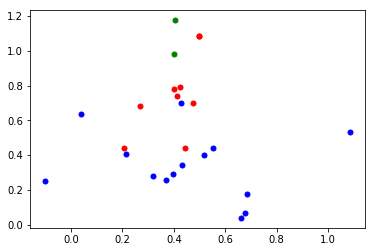

0
ÂÅ•Ë∫´ÊâìÂç° ËøêÂä®ÊâìÂç° Ë∑ëÊ≠•ÊâìÂç° ÂèØ‰ª•ÂÅ•Ë∫´ÊâìÂç°Âêó ÊúâÊ≤°ÊúâÂÅ•Ë∫´ÊâìÂç° Â∏ÆÊàëÂÅö‰∏™ÂÅ•Ë∫´ÊâìÂç° ÊúâÊ≤°ÊúâË∑ëÊ≠•ÊâìÂç° ÊúâËøêÂä®ÊâìÂç°Âêó ÂèØ‰ª•Ë∑ëÊ≠•Âêó?
1
ÂÅ•Ë∫´ÊâìÂç°ÂèØ‰ª•Âä†ÂõæÁâáÂêó ÂÅ•Ë∫´ÊâìÂç°Êúâ‰ªÄ‰πàÊé®ËçêÂêó ËøêÂä®Á¨¨‰∏ÄÂ§©,ÊâìÂç° Âà∑ÁâôÊâìÂç° ËØª‰π¶ÊâìÂç° ‰∏çÂêÉÊôöÈ•≠ÊâìÂç° ÊØèÂ§©ÊîøÊ≤ªÊâìÂç° ÊàëË¶ÅËøûÁª≠ÂêÉËçØ13Â§© ÊÄé‰πàËÆæÁΩÆËØª‰π¶Êó∂Èó¥ ÈòÖËØªÊâìÂç° ÊàëË¶ÅÈòÖËØªÊâìÂç° 21Â§©ÈòÖËØªËØª‰π¶ÂÖªÊàê ÂàõÂª∫ÂÅ•Ë∫´ÊâìÂç°Âú®Âì™ÈáåÂàõÂª∫ ÊàëË¶ÅÈîªÁÇº
2
Áëú‰ºΩÊâìÂç° Áëú‰ºΩ
106.12158527435741


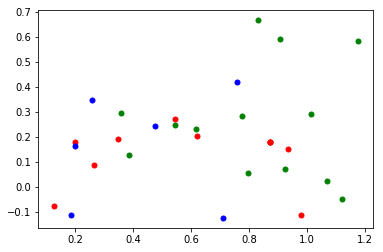

0
ÊàëË¶ÅÊîπÊâìÂç°Êó∂Èó¥ ÊàëÊÉ≥ÊîπÊâìÂç°Êó∂Èó¥ ÊÄé‰πàÊîπÊâìÂç°Êó∂Èó¥ ÂíãÊîπÊâìÂç°Êó∂Èó¥ ÊâìÂç°ÊîπÊó∂Èó¥ ÊîπÊâìÂç°Êó∂Èó¥ ÊâìÂç°Â¶Ç‰ΩïÊîπ Â¶Ç‰ΩïËÉΩÊîπËµ∑Â∫äÊó∂Èó¥Êó∂Èó¥Âë¢ ÊîπËµ∑Â∫äÊó∂Èó¥ ÊÄé‰πàÊ†∑Êîπ‰∏äÈù¢ÁöÑÊó∂Èó¥ ÊàëÂèØ‰ª•ÊîπÊó∂Èó¥Âêó
1
ÂøòËÆ∞ÊâìÂç°Êôö‰∏äÂÜçÊâìË°åÂêóÔºü ÊÄé‰πàÊîπÊàêÊó©‰∏ä7ÁÇπÂçäÊâìÂç° ËØ∑ÊääÊâìÂç°Êó∂Èó¥Ë∞ÉÊç¢Êàê4:30 ÊâìÂç°Êó∂Èó¥ÁúüÊòØÊ∑∑‰π± Ëµ∑Â∫äÊâìÂç°Êîπ‰∏∫ÊØèÂ§©Êó©‰∏ä7ÁÇπ ÊÄé‰πàË∞ÉÊàêÊó©ÂÆâÂç°
2
ÊâìÂç°Êó∂Èó¥ÊÄé‰πàËÆæÁΩÆÂú®Êó©‰∏ÄÁÇπ? Êó©Ëµ∑ÊâìÂç°ÂíåÊôö‰∏äÊâìÂç°Âú®Âì™ÈáåËÆæÁΩÆ ËÉΩÂê¶‰øÆÊîπÊâìÂç°Êó∂Èó¥ ÊÄé‰πà‰øÆÊîπ‰ºëÊÅØÊâìÂç°Êó∂Èó¥ ÊâìÂç°ÂõæÁâá‰∏äÁöÑÊó∂Èó¥ÂèØ‰ª•‰øÆÊîπÂêó ‰øÆÊîπÊó©Ëµ∑Êó∂Èó¥ Êõ¥ÊîπÊôö‰∏äÊâìÂç°Êó∂Èó¥ ÊÄé‰πàÊõ¥ÊîπÊØèÊó•ÊâìÂç°ÁöÑÊó∂Èó¥ Êõ¥ÊîπÊó©Êô®Êó∂Èó¥ Êõ¥ÊîπÊØèÊó•ÊâìÂç°ÁöÑÊó∂Èó¥ ÊôöÊâìÂç°Êó∂Èó¥ÂéªÂì™ÈáåËÆæÁΩÆ ÊÄéÊ†∑Áü•ÈÅìËá™Â∑±ÊØèÂ§©ÁöÑÊó©Ëµ∑Êó∂Èó¥ ÊÄé‰πàÊîπÊØèÂ§©Êó©Ëµ∑Ëøô‰∏™Êó∂Èó¥
4.192037237665055


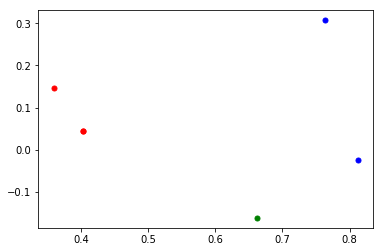

0
8ÊúàÊâìÂç°ÂõæÁâá 9ÊúàÊâìÂç°ÂõæÁâá 11Êúà16Âè∑ÁöÑÊâìÂç°ÂõæÁâáÂèëËøáÊù•ÂèØ‰ª•Âêó
1
ÊâìÂç°ÂõæÁâáÊ±áÊÄª ÊâìÂç°Ê±áÊÄªÊúâÂêó?
2
Á¨¨‰∏ÄÂ§©ÊâìÂç°Âõæ
79.26223536976829


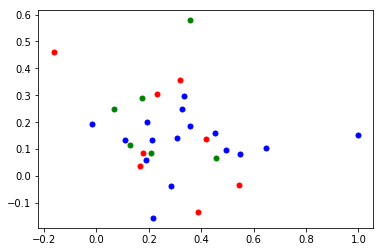

0
ÊàëÂíåÂõΩÂÜÖÊúâ15Â∞èÊó∂ÁöÑÊó∂Â∑Æ,ËØ∑ÈóÆÂ¶Ç‰ΩïÊâìÂç°Âë¢ ËØ∑ÊàëÂú®ÂõΩÂ§ñÊó∂Â∑Æ6Â∞èÊó∂,ÊÄé‰πàÊâìÂç°? ÊàëÂíåÂõΩÂÜÖÊúâÊó∂Â∑Æ ÊÄé‰πàÊâìÂç°ÂëÄ ÊàëÂú®ÂõΩÂ§ñÊÄé‰πàÊâìÂç° ÂõΩÂ§ñÊâìÂç°Êó∂Èó¥‰∏çÂØπÂïä ÊàëÂú®ÂõΩÂ§ñÔºåÊúâÊó∂Â∑ÆÔºåÊèêÈÜí‰∏çÂØπÂïä Ëã±ÂõΩÊó∂Èó¥ Â•ΩÂêß„ÄÇÊàëËøôÈáåË∑üÂõΩÂÜÖÂ∑Æ11Â∞èÊó∂
1
‰∏çÁßëÂ≠¶,‰∏çÂú®‰∏Ä‰∏™Êó∂Âå∫ÁöÑÂ≠©Â≠êÊ≤°Ê≥ïÂíåÂ∞è‰ºô‰º¥‰∏ÄËµ∑ÊâìÂç° ÊúÄÂ•ΩÂèØ‰ª•ËÆæÁΩÆÊ†πÊçÆÊó∂Âå∫Êù•ÊâìÂç°ÁöÑ,ËøôÊ†∑‰Ω†‰ª¨ÁöÑËΩØ‰ª∂Âú®Êµ∑Â§ñ‰πüÁïÖÈÄöÊó†ÈòªÂï¶!Âä†Ê≤π!ÂÜ≤Âá∫‰∏≠ÂõΩ,Ëµ∞Âêë‰∏ñÁïå ÊàëË¶ÅÂèçÈ¶à,Êó∂Â∑ÆÂÖö‰∏çËÉΩÊâìÂç°! ÊàëÁîüÊ¥ªÂú®Êñ∞ÁñÜÂñÄ‰ªÄ,ÂíåÂÜÖÂú∞ÁöÑÊúãÂèãÊúâ2Â∞èÊó∂ÁöÑÊó∂Â∑Æ,ÊâìÂç°‰∏çËÉΩÂêåÊ≠•ÊÄé‰πàÂäû? ÊàëÂú®Êæ≥Â§ßÂà©‰∫ö,ÊúâÊó†Ê†πÊçÆËøôËæπÁöÑÊó∂Âå∫Êù•ÊâìÂç°ÁöÑËÆæÁΩÆ ÊàëÂú®Êµ∑Â§ñ ËÉΩ‰∏çËÉΩÊï¥‰∏™Êµ∑Â§ñÊó∂Èó¥ÊâìÂç° ÊàëËØ¥‰Ω†Ê≤°Ê≥ïÂ∏ÆÊàëË∞ÉÊó∂Âå∫,ÁúüÂº± ÂèØ‰ª•ËÆæÁΩÆÊó∂Âå∫Âêó? ËÉΩË∞ÉÊï¥Êó∂Âå∫Âêó? Â∞èÊù•ÊòØ‰∏çÊòØÂè™Êúâ‰∏≠ÂõΩÊó∂Âå∫ Êó∂Â∑Æ!Êó∂Â∑Æ!Êó∂Â∑Æ! Êõ¥ÊîπÊó∂Â∑Æ Ëøô‰∏™ÁÆÄÁõ¥ÊòØÂú®Ê¨∫Ë¥üÊµ∑Â§ñÊó∂Â∑ÆÁî®Êà∑ ÊúãÂèã,‰Ω†Ë¶ÅÂÖ≥ÂøÉÊµ∑Â§ñÊ∏∏Â≠êÁöÑÊó∂Â∑Æ Ëøô‰∏™Á≥ªÁªüÂïä,‰∏çËÉΩË∑üÁùÄÊàëÁöÑÊó∂Â∑ÆËµ∞Âê

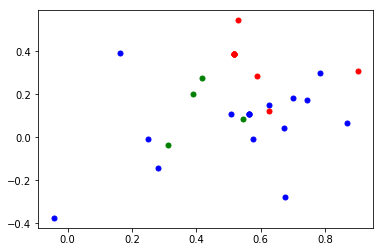

0
ÂÖ±ÂêåÊâìÂç° ÊÄé‰πàÂÖ±ÂêåÊâìÂç° ÊÄé‰πàÂÖ±ÂêåÊâìÂç°Âïä ÊÄé‰πàÂÖ±ÂêåÊâìÂç°Âë¢? ÊÄé‰πàÊâçËÉΩÂÖ±ÂêåÊâìÂç° ÊÄé‰πàÊâçËÉΩÂÖ±ÂêåÊâìÂç°Âë¢ ÊÄé‰πàÂíåÂ•ΩÂèãÂÖ±ÂêåÊâìÂç° ÊÄé‰πàÊó©Ëµ∑ÂÖ±ÂêåÊâìÂç°Âë¢? ÊÄéÊ†∑‰∏éÂ•ΩÂèãÂÖ±ÂêåÊâìÂç°
1
ÂÖ±ÂêåÊâìÂç°ÂíåÊâìÂç°Êúâ‰ªÄ‰πà‰∏çÂêåÂêó ÂÖ±ÂêåÊâìÂç°‰πüÊúâ‰ºòÊÉ†Âà∏ÂêóÔºü ÂÖ±ÂêåÊâìÂç°Êúâ‰ªÄ‰πàÂ•ΩÂ§ÑÔºü ÂÖ±ÂêåÊâìÂç°ÊòØ‰ªÄ‰πàÊÑèÊÄùÔºü ÂÖ±ÂêåÊâìÂç°ÁöÑÂ•ñÂä±ÊòØ‰ªÄ‰πàÔºü ÂÖ±ÂêåÊâìÂç°ÊòØ‰ªÄ‰πà ÊâìÂç°Êúâ‰ªÄ‰πàÂ•ñÂä± ‰ªÄ‰πàÊòØÂÖ±ÂêåÊó©ÊâìÂç° ÂÖ±ÂêåÊâìÂç°ÊòØ‰ªÄ‰πàÊÑèÊÄù? ÂÖ±ÂêåÊâìÂç°ÊòØ‰ªÄ‰πàÊÑèÊÄù ‰ªÄ‰πàÊòØÂÖ±ÂêåÊâìÂç°Ê¥ªÂä®ÂëÄ? ‰∏∫‰ªÄ‰πàÊàë‰ºöÊ≤°ÊúâÂÖ±ÂêåÊâìÂç°? ‰ªÄ‰πàÊÉäÂñú? ÊúâÂì™‰∫õÊâìÂç° ÊàëÊÄé‰πàÁúã‰∏çÂà∞Ë∑üÂà´‰∫∫‰∏ÄËµ∑ÁöÑÊâìÂç°ËÆ∞ÂΩï„ÄÇ ‰∏∫‰ªÄ‰πàÊòæÁ§∫ÂÖ±ÂêåÊâìÂç°Èõ∂Â§©Âë¢
2
ËÆ©ÊúãÂèãÊúãÂèãÂèÇ‰∏éÊâ´ÊàëÁöÑÂêóÊúâ‰ªÄ‰πàÂ•ΩÂ§ÑÂêó? Âè™ËÉΩÂíå‰∏Ä‰∏™‰∫∫ÊâìÂç°Âêó ‰∏Ä‰∏™Âä©ÁêÜÊù•‰πüÂèØ‰ª•‰∏§‰∏™‰∫∫ÊâìÂç°Âêó ÊÉ≥ÊäΩÂ•ñÂøÖÈ°ªÂíåÂ•ΩÂèã‰∏ÄËµ∑ÊâìÂç°Âêó
496.4509876995746


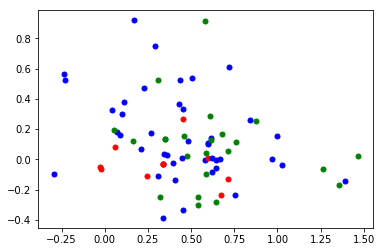

0
ÊÄé‰πàÂä†Â•ΩÂèã ÊÄé‰πàÂä†Â•ΩÂèã‰∏ÄËµ∑ Âä†Â•ΩÂèã ÊÄé‰πàÊ†∑Âä†Â•ΩÂèã Âä†Â•ΩÂèã‰∏ÄËµ∑ÊâìÂç° ÊÄé‰πàÊ†∑Âä†Â•ΩÂèã‰∏ÄËµ∑ÊâìÂç° Â¶Ç‰ΩïÂä†Êõ¥Â§ö‰∫∫ Ëøô‰∏™ÊÄé‰πàÂä†Â•ΩÂèã Âä†Â•ΩÂèãÊÄé‰πàÂä† ÊÄéÊ†∑Âä†Â•ΩÂèã ÊÄé‰πàÂ¢ûÂä†Â•ΩÂèã
1
Â¶Ç‰ΩïÊ∑ªÂä†Â•ΩÂèã ÊÄé‰πàÂè´Â•ΩÂèãËµ∑Â∫ä Âú®Âì™Ê∑ªÂä†Â•ΩÂèã‰∏ÄËµ∑ÊâìÂç° ÊÄé‰πàÂàÜ‰∫´ ÂàÜ‰∫´ ËÆ©Âà´‰∫∫ËØÜÂà´ÊàëÁöÑ‰∫åÁª¥Á†ÅÊÄé‰πàËØÜÂà´? ÊÄé‰πàÂÖ≥Ê≥®Â•ΩÂèã ÂêëÊúãÂèãÊâìÊãõÂëºÊÄé‰πàËÆæÁΩÆ ÊÄé‰πàÁúã‰∏çÂà∞Â•ΩÂèãÂéÜÂè≤ÊâìÂç°ËÆ∞ÂΩï? ÊàëÊääÂ•ΩÂèãÂà†‰∫Ü!ÊÄé‰πàÊÅ¢Â§ç ÊÄé‰πàÊ†∑ËÉΩÊàê‰∏∫Â•ΩÂèã Â•ΩÂèã‰πüË¶ÅÊâìÂç°„ÄÇÊÄé‰πàÂèëÁªôÂ•π ÊàëÊÅ¢Â§çÂ•ΩÂèãÁöÑÊâìÂºÄÂëó!‰∏çÂ∞èÂøÉÂà†Èô§‰∫Ü ÊÄéÊ†∑‰∫íÁõ∏ÂÖ≥Ê≥®ÁöÑ Â¶Ç‰ΩïÂÖ≥Ê≥® ÊÄé‰πàÂÖ≥Ê≥® Â¶Ç‰Ωï‰∫íÂä†Â•ΩÂèãÂïä ÊÄé‰πàÊ≤°ÊúâÁªôÂ•ΩÂèãÂèëÈÄÅÊôöÂÆâ? ËØ∑‰ª£ÊàëÂêëÈò≥ÂÖâÁ§ºÂìÅÊúçÈ•∞ÈóÆÊó©ÂÆâ Â∑≤ÁªèÊúâÂä†ÂÖ•Â•ΩÂèãÂï¶ Â∑≤ÁªèÈÇÄËØ∑Â•Ω‰∫Ü ÊÄé‰πàÂíåÂ•ΩÂèãÂÖ≥Ê≥® ÊÄé‰πàÈÇÄÂ•ΩÂèã ÊÄé‰πàÁªôÂ•ΩÂèãÂèë‰ø°ÊÅØ ÊàëÂàöÊâç‰∏çÂ∞èÂøÉÂà†‰∫Ü‰∏Ä‰∏™Â•ΩÂèãÊ≤°Ê≥ïÂ≠êÂä†‰∫Ü[Facepalm] ÊÄé‰πàÊé®ËçêÁªôÂ•ΩÂèãÔºü Â¶Ç‰ΩïÊ∑ªÂä†ÂæÆ‰ø°‰∏äÈù¢ÁöÑÂ•ΩÂèã ÊàëË∑ü‰πêÂÑøÊÄé‰πàÂÖ≥Ê≥® ÊÄéÊ†∑Êàê‰∏∫Â•Ω

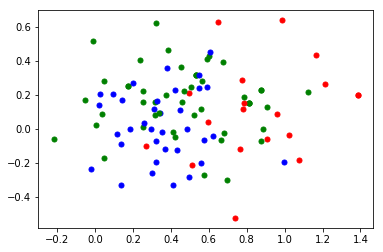

0
ÊÄé‰πàÂÉèÂ•ΩÂèãÈóÆÂÄôÊó©ÂÆâ ‰∫íÈÅìÊôöÂÆâ ÈóÆÂÄô‰ªñÊó©ÂÆâ! ÈóÆÂÄôÁæéÂ•ΩÊó©ÂÆâ Â¶Ç‰Ωï‰∫íÈÅìÊó©ÂÆâ ‰∫íÈÅìÊó©ÂÆâ ‰Ω†‰πüÂ∏ÆÊàëÂêëÂ•πÈóÆÂÄôÂëó ÊâìÂç°ÈóÆÂÄô Áà±ÁöÑÊÄùÂøµÈóÆÊó©ÂÆâ Áªô‰ªñÈóÆÂÄôÊàëËµ∑Â∫ä‰∫Ü ÂêëÂ•πÈóÆÂÄôÊó©ÂÆâ ‰∏ÄËµ∑ÈóÆÂÄôÊó©ÂÆâ Â¶Ç‰ΩïÂèëÊó©ÂÆâ ÊÄé‰πàÈóÆÂÄô? ÊõøÊàëÈóÆÂÄôÂ•π ÈóÆÂÄôÊÉúÊÉúÊó©ÂÆâ ÊõøÊàëÂíåÂ•πËØ¥Êó©ÂÆâ Â∏ÆÊàëÈóÆ‰ªñÊó©ÂÆâ ËØ∑ÁªôÊàëÂèëÈÄÅÊó©ÂÆâËØ≠
1
‰πü‰ª£ÊàëÈóÆ‰ªñ‰ª¨Â•Ω ÈóÆÂÄôÂ•ΩÂèã,xiaxia ÊàëËÆ©‰Ω†ÈóÆ‰∏ãÊàëÁöÑÊúãÂèã ÂêëÊüØËä¨ÂßêÂßêÈóÆÂÄô Ëä±Ëä±ÈóÆÂ•Ω ÊàëÁöÑÂ•ΩÂèãfengwing. Ëµ∑Â∫ä‰∫ÜÂêó? ÁéãËÄÅÂ∏à„ÄÇÁ•ù‰Ω†ÂøÉÊÉÖÂø´‰πê„ÄÇ ÈóÆ‰∏™Â•Ω Â∞èÊù•ÈóÆÂÄôÊù®ÊïôÁªÉÊó©‰∏äÂ•Ω,ÂçÅ‰πùÂ§ßÂêéÊî∂Ëé∑Êª°Êª° Áù°Ëßâ ÂëäËØâÊàøÁéÑÈæÑ ÈóÆÂ•Ω Â∞èÊù•ÂéªË∞¢Ë∞¢Êù®ÊïôÁªÉ ÁúãË∞ÅËøòÊúâÊØîÊàëÊó© Â§™ËÉΩÁù°‰∫Ü ÂëäËØâÊàë‰∫≤Áà±ÁöÑËÄÅÂ§ß,ÂÜ∑‰∫Ü,Ê≥®ÊÑè‰øùÊöñ„ÄÇ ÊàëÂíåÊàëÂ™≥Â¶áÂÑøÈÉΩÁî®Ëøô‰∏™,‰∏∫‰ªÄ‰πà‰∏çÊòØÂ•ΩÂèã ÈÇ£‰Ω†‰πüÂ∏ÆÊàëÂêë‰ªñÈóÆÂ•Ω‰∏Ä‰∏ã Â∏ÆÊàëÂëäËØâÂ•π  ÊàëËµ∑ÂæóÊó© ÊÄùÂøµ ËØ∑‰ª£ÊàëÂêëÈò≥ÂÖâÁ§ºÂìÅÊúçÈ•∞ÈóÆÂ•Ω ÁªôÊàëÂ•ΩÂèãËØ¥ÊàëËÉÉÁñº ÊàëË¶ÅÊâæÂõûÊàëÁöÑÊúãÂèã ÁªôÁéã‰∏πÈóÆÂ•Ω Â∏ÆÊàëÂêëËêåÈ¢ñÂÆùÂàÄÈóÆ

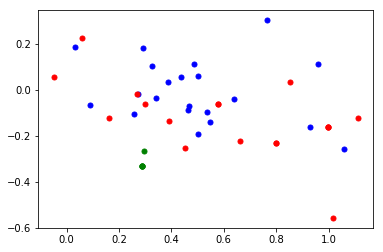

0
Â•ΩÂèãÂàóË°® ÊâìÂç°Â•ΩÂèãÂàóË°® Â•ΩÂèãÂàóË°®Âú®Âêó Â•ΩÂèãÂàóË°®? ÊÄéÊ†∑Â•ΩÂèãÂàóË°® Â•ΩÂèãÂàóË°®Âú®Âì™ Â•ΩÂèãÂàóË°®Âë¢ Âì™ÈáåÊúâÂ•ΩÂèãÂàóË°® Â•ΩÂèãÂàóË°®Âú®Âì™Èáå Â•ΩÂèãÂàóË°®Âú®Âì™ÁÇπÂáª Â•ΩÂèãÂàóË°®Âú®Âì™? Âì™ÈáåÁúãÂ•ΩÂèãÂàóË°® Âú®Âì™ÈáåÂïä!Â•ΩÂèãÂàóË°® ÊàëÁöÑÂ•ΩÂèãÊâìÂç°Ë°® ÊÄé‰πàÁúãÂ•ΩÂèã ÊàëÁöÑÂ•ΩÂèãÂàóË°®‰∏çËßÅ‰∫Ü ÊÄéÊ†∑Êü•ÁúãÊàëÁöÑÂ•ΩÂèã ÁúãÂ•ΩÂèã
1
ÊàëÊÉ≥ÁúãÂ•ΩÂèãÊéíÂêç ÊÄé‰πàÁúãÂà∞ÈÇ£‰∏™Â•ΩÂèãÁöÑÊéíÂêç? ÊéíÂêç ÊàëÊÄé‰πàÊ≤°ÁúãËßÅ,Â•ΩÂèãÊâìÂç°ÊéíÂêçÂïä? ÊâìÂç°ÊéíÂêç Êó©Ëµ∑ÊéíÂêç ÊÄé‰πàÁúãÊéíÂêç ÂèØ‰ª•ÁúãÂà∞ÂêåÊó∂ÊâìÂç°ÁöÑ‰∫∫ÂêóÔºü ‰ªäÂ§©ÊòéÊòéÊúâ‰∏ÉÂÖ´‰∏™‰∫∫ÈÄöËøáÊàëÁöÑ‰∫åÁª¥Á†ÅÊâìÂç°‰∫Ü,ÈÉΩÁúã‰∏çÂà∞ Áúã‰∏çÂà∞ÊúãÂèãÁöÑÊéíÂêçÂïä ÊéíË°å ÊÄé‰πàÁúã‰∏çËßÅÂ•ΩÂèãÊó©‰∏äÊâìÂç°ÊÉÖÂÜµ ÊàëÊÉ≥Áü•ÈÅìÊàëÁöÑÂ•ΩÂèãÂè´‰ªÄ‰πàÂêçÂ≠ó Â∑≤Áªè‰∫íÁõ∏ÂÖ≥Ê≥®ÊàêÂäü   ‰∏∫‰ªÄ‰πàÂú®ÊàëÁöÑÂ•ΩÂèãÈáåÈù¢Ê≤°ÊúâÊòæÁ§∫Â•ΩÂèã ÊÄé‰πàËÉΩÊúâÂ•ΩÂèãÁöÑËØ¶ÁªÜ‰ø°ÊÅØ ÊÄé‰πàËÉΩÂ§üÁúãÂà∞ÊàëÁöÑÊúãÂèã Âú®Âì™ÁúãÊéíÂêçÂïä? ‰∏∫‰ªÄ‰πàÊàëÂàÜ‰∫´‰∫åÁª¥Á†ÅÁªôÊàëÊúãÂèãÈÉΩÂÖ≥Ê≥®‰∫Ü‰∏∫‰ªÄ‰πàÊàëÂ•ΩÂèãÂàóË°®Ê≤°Êúâ‰ªñ‰ª¨ ÊàëËµ∑Êù•ÊúâÂ§öÊó©Â

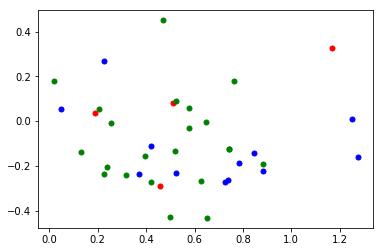

0
Â∞ëËØ¥ËØù Âà´Êé®ÈÄÅ ËØ∑‰∏çË¶ÅÁªôÊàëËøô‰πàÂ§öÊé®ÈÄÅ ‰∏çË¶ÅÂÜçÂèëÂï¶
1
ËÉΩËÆæÂÆöÊ∂àÊÅØÂÖçÊâìÊâ∞Âêó? Ê∂àÊÅØÂÖçÊâìÊâ∞ Ê≤°ÊúâÊ∂àÊÅØÂÖçÊâìÊâ∞ÂäüËÉΩ ÂÖçÊâìÊâ∞ ÂºÄÂêØÊ∂àÊÅØÂÖçÊâìÊâ∞ ÂèØ‰∏çÂèØ‰ª•Ê∂àÊÅØÂÖçÊâìÊâ∞ ÂèØ‰∏çÂèØ‰ª•ËÆæÁΩÆÂÖçÊâìÊâ∞ ËÉΩ‰∏çËÉΩËÆæÁΩÆÊ∂àÊÅØÂÖçÊâìÊâ∞ Ê≤°ËÉΩ‰∏çËÉΩËÆæÁΩÆÂÖçÊâìÊâ∞ ÊÄéÊ†∑ÂºÑÊ∂àÊÅØÂÖçÊâìÊâ∞ ÊÄéÊ†∑ÂÖçÊâìÊâ∞ ÊúâÊ≤°ÊúâÊù•‰ø°ÊÅØÂÖçÊâìÊâ∞ÂäüËÉΩ
2
ËÉΩ‰∏çÂèëÊ∂àÊÅØ‰∫ÜÂêó ‰∏∫‰ªÄ‰πà‰∏çÂÅúÁöÑÂèëÈáçÂ§ç‰ø°ÊÅØÔºü ‰∏çË¶Å‰∏ÄÁõ¥Âèë‰ø°ÊÅØÂêß ‰Ω†ÁªôÂèëËøá‰∫Ü,ËØ∑‰∏çË¶ÅÈáçÂ§çÂèë ‰∏çË¶ÅÈöè‰æøÂèë‰ø°ÊÅØ‰∫Ü,Â§™Â§ö‰ø°ÊÅØÂæàÈ∫ªÁÉ¶ ‰∏çË¶ÅÂú®Âèë‰∫Ü Âà´Âêµ ÂãøÊâìÊâ∞ ÊúâÁóÖ,ÂèñÂÖ≥‰∫Ü ‰∫≤„ÄÇËÉΩËÆæÁΩÆÈùôÈü≥ÁöÑÂêó ‰∏çËÆ∏ÁªôÊàëÊé®ÈÄÅ‰∫Ü!!Êàë‰ªñÂ¶àÊèç‰Ω† ‰∏çË¶ÅÂèëÊó†Ë∞ìÁöÑ‰ø°ÊÅØÁªôÊàë Âà´‰π±ÂèëÊàë‰ø°ÊÅØ Âä©ÁêÜÊù•‰πü ÂÖçÊâìÊâ∞ ÈÇ£Ê∂àÊÅØËÉΩÈùôÈü≥‰πà Â¶Ç‰ΩïÂèñÊ∂àÊñ∞‰ø°ÊÅØÊèêÁ§∫ ‰∏çÊÉ≥Êé•Êî∂‰ªª‰Ωï‰ø°ÊÅØ ÊàñËÄÖËÆæÁΩÆ‰∏™‰ø°ÊÅØÂãøÊâ∞ÈÄâÈ°π ÂΩìÂπ¥ÂèñÂÖ≥,Â•ΩÂÉèÂ∞±ÊòØÂõ†‰∏∫Êé®ÈÄÅÂ§™Â§ö‰∫Ü„ÄÇ Ëøô‰∏™ÂèØ‰ª•ËÆæÁΩÆÈùôÈü≥Âêó ÊàëÂ∏åÊúõÊúâÈùôÈªòÊ®°Âºè ÊúÄÂ•ΩÂºÑ‰∏™ÂÖçÊâìÊâ∞Ê®°ÂºèÔºå‰∏ÄÂ§©Ê∂àÊÅØÂ§™Â§öÔºåËÄΩËØØÊó∂Èó¥Á

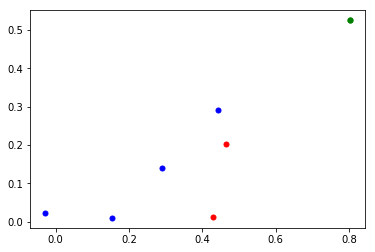

0
ÊàëÁöÑÂ•ΩÂèã‰ªäÂ§©Ê≤°ÊúâÊâìÂç° Â•ΩÂèãÊâìÂç°ÊÄé‰πàÊ≤°ÊúâÊèêÁ§∫Âë¢
1
Â±ÖÁÑ∂Ëµ∑Ëøô‰πàÊôöÔºåÂ§ßÊáíËô´ ÊáíËô´ ‰Ω†ÂíãËµ∑Ëøô‰πàËøü ‰Ω†Â§™Êáí‰∫Ü
2
Ëøô‰πàÊôö ÂèàËøô‰πàÊôö
0.826481987436237


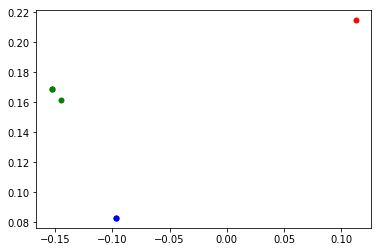

0
ÊÄé‰πàÂÖ≥Ê≥®Âà´‰∫∫ÊâìÂç°
1
Â¶Ç‰ΩïÂÖ≥Ê≥®Âà´‰∫∫ÊâìÂç° ÊâìÂç°Â¶Ç‰ΩïÂÖ≥Ê≥®Âà´‰∫∫Ôºü
2
ÊÄéÊ†∑ÂÖ≥Ê≥®Âà´‰∫∫ÊâìÂç° ÊÄé‰πàÊ†∑ÂÖ≥Ê≥®Âà´‰∫∫ÊâìÂç° ÊâìÂç°ÊÄéÊ†∑ÂÖ≥Ê≥®Âà´‰∫∫Ôºü
0.0


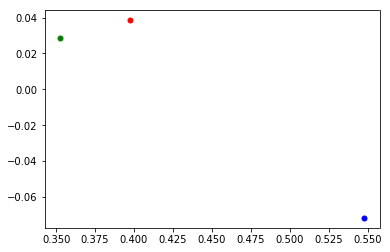

0
‰∏çÊÉ≥Êé•Êî∂Â•ΩÂèãÁöÑÊ∂àÊÅØÔºü
1
Êé•Êî∂Â•ΩÂèãÁöÑÊ∂àÊÅØÊÄé‰πàÂäûÔºü
2
ÊÄé‰πà‰∏çÂÜçÊé•Êî∂Â•ΩÂèãÁöÑÊ∂àÊÅØÔºü
4.5520267721544325


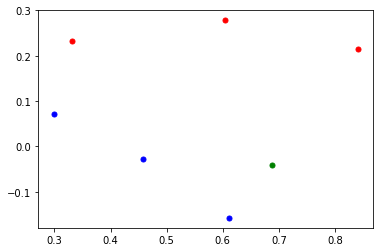

0
ÊÄé‰πàÊü•ÁúãÂ•ΩÂèãÊéíÂêçÔºü ÊÄéÊ†∑Êü•ÁúãÂ•ΩÂèãÊéíÂêç Êü•ÁúãÂ•ΩÂèãÊéíÂêç
1
ÁúãÂ•ΩÂèãÊéíÂêç ÊÄé‰πàÁúãÂ•ΩÂèãÊéíÂêç Â•ΩÂèãÊéíÂêçÂú®Âì™Âïä
2
Â•ΩÂèãÊéíÂêç
241.5925689978157


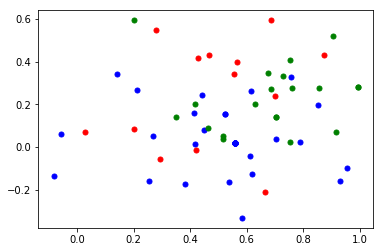

0
ÊÄé‰πàÂèñÊéâÂÖ≥Ê≥®Âà´‰∫∫ Â∏ÆÂøôÊää‰ªñÂà†‰∏Ä‰∏ã,Ë∞¢Ë∞¢ ÊÄé‰πàËß£Èô§ÂÖ≥Ê≥® ‰∏∫‰ªÄ‰πàÂà†‰∏çÊéâÂ•ΩÂèã? Ëß£Èô§Â•ΩÂèãÂÖ≥Á≥ªÂú®Âì™ÈáåËÆæÁΩÆ ÊÄé‰πàÂèñÊ∂à‰∫íÁõ∏ÂÖ≥Ê≥® ÊÄé‰πàËß£Èô§Â•ΩÂèãÂÖ≥Á≥ª Â¶Ç‰ΩïÂèñÊ∂à‰∏éÂØπÊñπÁöÑ‰∫íÁõ∏ÂÖ≥Ê≥® ÊÄé‰πàÂèØ‰ª•ÊääÂÖ≥Ê≥®ÁöÑ‰∫∫ÂéªÊéâ ‰∏çÊÉ≥‰∏é‰ªñÂÖ±ÈóÆÊó©ÂÆâ ÊàëÂèØ‰ª•‰∏çÂÖ≥Ê≥®È¶ôÈ¶ôÂêó ÂèØ‰ª•‰∏ç‰∫íÈÅìÊó©ÂÆâÂêó Â¶Ç‰ΩïÂèñÊ∂àÂÖ≥Ê≥®ÂØπÂà´‰∫∫ÁöÑÂÖ≥Ê≥®
1
ÊÄé‰πàÂà†Èô§Â•ΩÂèãÔºü ÊÄé‰πàÂà†Â•ΩÂèã ÊÄé‰πàÂà†Èô§Â•ΩÂèã Âà†Èô§ÊúãÂèã Âè™Ë¶ÅÊâ´‰∫ÜÊàëÁöÑÁ†ÅÂ∞±ËÉΩÊàê‰∏∫ÊâìÂç°ÁöÑÂ•ΩÂèã‰∫Ü?‰∏ç‰∏ÄÂÆöÊòØÂæÆ‰ø°Â•ΩÂèãÂíØ ÊÄéÊ†∑ÂèñÊ∂àÂ•ΩÂèãÂÖ≥Ê≥® Â•ΩÂèãÊéíÂêçÊâìÂç°ÈÇ£ÈáåÊÄé‰πàÂèñÊ∂àÂ•ΩÂèã ËØ∑ÈóÆÊÄé‰πàÂà†Èô§ÊâìÂç°Â•ΩÂèãÂïä? ÊÄé‰πàÂà†Èô§ÊâìÂç°ÁöÑÂ•ΩÂèãÂë¢? ÊÄé‰πàÂà†Èô§Â•ΩÂèãÂïä Â•ΩÂèãÊÄé‰πàÂà†Èô§? ÊÄé‰πàÂà†Èô§Â•ΩÂèã? ÊÄé‰πàÂà†Èô§Â•ΩÂèãÂë¢ ÊÄé‰πàÂà†Èô§Â•ΩÂèãÂëÄ ÊÄé‰πàÂèØ‰ª•Âà†Èô§Â•ΩÂèã Â•ΩÂèãÊÄé‰πàÂà†Èô§ ÊâìÂç°Â•ΩÂèãÂàóË°®ÊÄé‰πàÂà†Èô§Â•ΩÂèã? ÊÉ≥Âà†Èô§Â•ΩÂèã,ÊÄé‰πàÂà†Èô§? ÂèñÊ∂àÂÖ≥Ê≥®Â•ΩÂèãÊÄé‰πàÂèñÊ∂à ËØ∑ÈóÆÊÄé‰πàÂà†Èô§Â•ΩÂèãÂïä ÊÄé‰πàÂà†Èô§Â•ΩÂèãÂëÄ, ËÉΩ‰∏çËÉΩ‰∏çË¶ÅÂ•ΩÂèãÂïä Âà†Â•ΩÂèã Â¶Ç‰ΩïÂ

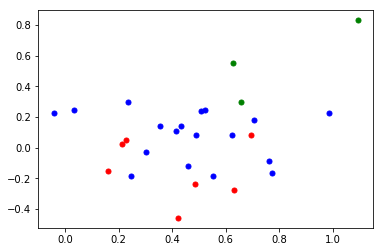

0
ÊÄé‰πàÊ†∑ÊääÊ∂àÊÅØÊèêÁ§∫Èü≥ÂÖ≥‰∫Ü? ÊÄé‰πà‰∏ÄÂ§©Êé®Ëøô‰πàÂ§ö‰ø°ÊÅØ? ÊÄé‰πàÂèñÊ∂àÂà´‰∫∫Êé•Êî∂‰ø°ÊÅØ ÊàëÂ∏åÊúõ‰Ω†‰ª¨ÂèñÊ∂à‰∏ÄÂàáÁªôÊàëÂèë‰ø°ÊÅØÊâìÁîµËØù ‰∏çÊé•Êî∂ÂØπÊñπÊâìÂç°‰ø°ÊÅØ Â¶Ç‰ΩïËÉΩ‰∏çÊî∂Âà∞‰ªñ‰ª¨ÁöÑ‰ø°ÊÅØÊèêÈÜí Â•πËµ∑‰∏çËµ∑ÂÖ≥Êàë‰ªÄ‰πà‰∫ãÂÑø?‰∏ãÊ¨°Âà´ÁªôÊàëÂèë‰∫Ü
1
Âà´ÂÜçÊèêÈÜíÊàëÊâìÂç°‰∫Ü ÊÄé‰πàÊääÊâìÂç°Ê∂àÊÅØÂÖ≥‰∫ÜÂïä Êàë‰∏çÊÉ≥ËÆ©Âà´‰∫∫Áü•ÈÅìÊàëÊâìÂç°‰∫ÜÔºåËØ•ÊÄé‰πàÂäû Âà´‰∫∫ÁöÑÊâìÂç°‰ø°ÊÅØÊÄé‰πàÂ±èËîΩÔºü Â∏ÆÊàëÊääÊâìÂç°ÂÖ≥‰∫Ü Â¶Ç‰ΩïÂèñÊ∂àÂ•ΩÂèãÊèêÁ§∫ ÊÄéÊ†∑ÂÖ≥Èó≠ÈìÉÂ£∞ ÊÄé‰πàËÉΩ‰∏çËÆ©Â•ΩÂèãËµ∑Â∫äÊâìÂç°Â∞±ÊèêÁ§∫Êàë? Âà´Êé®ÈÄÅÊâìÂç°Ê∂àÊÅØ Êàë‰∏çÊÉ≥ÂíåÂ•π‰∫íÈÅìÊó©ÂÆâÊÄé‰πàÂäû Êàë‰∏çË¶ÅÁü•ÈÅìÂ•ΩÂèãÊâìÂç° ÊàëÁù°‰∫Ü‰πãÂêéÊúãÂèãÊâìÂç°ÂèØ‰∏çÂèØ‰ª•‰∏çÁªôÊàëÂèëÊ∂àÊÅØ ÊÄé‰πàÊâçËÉΩÁü•ÈÅìÂØπÊñπÊääËá™Â∑±Âà†Èô§‰∫Ü ‰∏çÁªôÊúãÂèãÈóÆÊó©ÂÆâ ‰∏çÊÉ≥Ë¶ÅÂ•ΩÂèãÁöÑÈÄöÁü•ÂèëËøáÊù•ÊÄé‰πàËÆæÁΩÆ ‰∏çÊé•Êî∂Â•ΩÂèãÊó©ÂÆâÊèêÈÜí Â¶Ç‰ΩïÂ±èËîΩ‰∏çÂñúÊ¨¢ÁöÑÂ•ΩÂèãÊâìÂç°ÊèêÁ§∫ ÊàëËÉΩÂ±èËîΩÊúãÂèãÂêó
2
Ê∂àÊÅØÁÆ°ÁêÜÂú®Âì™Èáå Âú®Âì™ÈáåËÉΩÊâæÂà∞Ê∂àÊÅØÁÆ°ÁêÜ Ê∂àÊÅØÁÆ°ÁêÜ
1.084705960341744


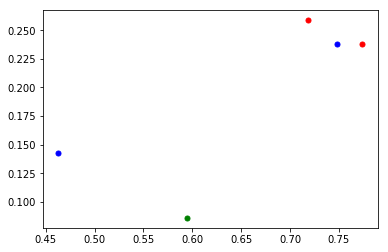

0
Êó©Ëµ∑ÊâìÂç°ÂíåÂÖ±ÂêåÊâìÂç°ÊòØ‰∏§‰∏™Ê¥ªÂä®Ôºü Êó©Ëµ∑ÊâìÂç°ÂíåÂÖ±ÂêåÊâìÂç°ÊòØ‰∏Ä‰∏™Ê¥ªÂä®ÂêóÔºü
1
ËøûÁª≠ÊâìÂç°ÂíåÂÖ±ÂêåÊâìÂç°ÊòØ‰∏ÄÂõû‰∫ãÂêóÔºü Êó©Ëµ∑ÊâìÂç°Ë∑üÂÖ±ÂêåÊâìÂç°Êúâ‰ªÄ‰πàÂå∫Âà´Ôºü
2
Ê≤°ÊòéÁôΩÊó©Ëµ∑ÊâìÂç°ÂíåÂÖ±ÂêåÊâìÂç°Êúâ‰ªÄ‰πà‰∏çÂêåÂïä
2608.8590489053813


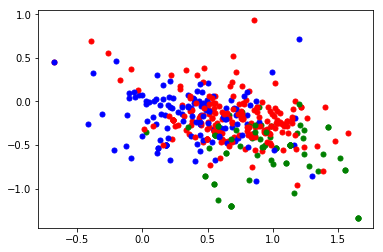

0
ÈáçÊñ∞ÁîüÊàêÊâìÂç°Âõæ ÈáçÊñ∞ÊâìÂç° ÊÄé‰πàÁîüÊàê Ê≤°ÊúâÊâìÂç°ÂõæÁâá ÊÄé‰πàÊ≤°ÊúâÊâìÂç°ÂõæÁâá ÊâìÂç°ÂêéÊ≤°ÊúâÂõæÁâá ÊâìÂç°ÊÄé‰πàÊ≤°ÊúâÂõæÁâá ÊâìÂç°ÂõæÁâáÊÄé‰πàÊ≤°Êúâ Ê≤°ÊúâÊâìÂç°ÂõæÁâá‰∫Ü Ê≤°ÊúâÁîüÊàêÊâìÂç°ÂõæÁâá Ê≤°ÊúâÊî∂Âà∞ÊâìÂç°ÂõæÁâá Ê≤°ÊúâÊó©ÂÆâÊâìÂç°ÂõæÁâá ‰∏∫Âï•Ê≤°ÊúâÊâìÂç°ÂõæÁâá Ê≤°ÊúâÊâìÂç°ÂõæÁâá? Ê≤°ÊúâÂèëÊâìÂç°ÂõæÁâá ËøòÊ≤°ÊúâÊâìÂç°ÂõæÁâá Êó©Ëµ∑ÊâìÂç°Ê≤°ÊúâÂõæÁâá ÈáçÊñ∞ÁîüÊàêÊâìÂç° ÊÄé‰πàÊ≤°ÊúâÊó©ÂÆâÂõæÁâáÂë¢ Êó©‰∏äÊâìÂç°‰∫Ü‰∏∫‰ªÄ‰πàÁîüÊàêÊ≤°Êúâ? ÈáçÊñ∞ÁîüÊàêÊâìÂç°Âõæ,Ë∞¢Ë∞¢ ÊÄé‰πàÂèàÊ≤°ÊúâÊâìÂç°ÂõæÁâá‰∫Ü ÊÄéÊ†∑ÈáçÊñ∞ÊâìÂç°? ÁîüÊàê ÈáçÊñ∞ÁîüÊàêÂõæÁâá Ê≤°Êî∂Âà∞ÊâìÂç°Âõæ ‰ªäÂ§©Ê≤°ÊúâÁîüÊàêÊâìÂç°Âõæ ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÊâìÂç°ÂõæÁâá ÁîüÊàêÂõæÁâá ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂõæÁâá ËøëÊúüÊâìÂç°‰∏∫‰ªÄ‰πàÈÉΩ‰∏çÂá∫Áé∞ÊâìÂç°Âõæ‰∫Ü ÊÄé‰πàÊ≤°Êî∂Âà∞ÊâìÂç°Âõæ Á†ÅÂë¢ ‰ªäÂ§©ÊÄé‰πàÊ≤°ÊúâÊó©Ëµ∑ÊâìÂç°Âõæ ÊÄªÊòØÊî∂‰∏çÂà∞ÂõæÁâáÂë¢ ‰∏∫‰ªÄ‰πàÊâì‰∫ÜÂç°,Ê≤°ÊúâÊâìÂç°Á≠æÂà∞Âõæ? ÊÄé‰πà‰ªäÂ§©Êî∂‰∏çÂà∞ÊâìÂç°ÂõæÁâá? ‰ªäÂ§©ÊâìÂç°ÂèàÊ≤°ÂõæÁâá ‰∏∫‰ªÄ‰πà‰∏çËÉΩÁîüÊàêÊó©ÂÆâÊâìÂç°Âõæ ÊâìÂç°ÊÄé‰πàÊ≤°Âõæ‰∫Ü ÊÄé‰πàÊ≤°ÊâìÂç°Âõæ[Facep

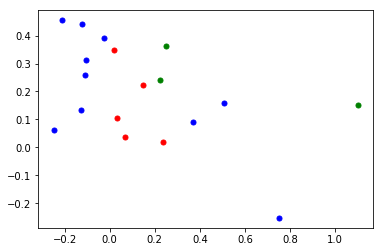

0
repeat_dateÂ∏ÆÊàëËá™Âä®ÊâìÂç°Âêß? ÊâìÂç°Êú∫ ‰ªéÊòéÂ§©ÂèØ‰ª•,‰Ω†Ë¶ÅÂ∏ÆÊàëÁ≠æÂà∞Âêó Âè™Ë¶ÅÂºÄÂæÆ‰ø°Â∞±ÊâìÂç°‰∫ÜÂêó ‰Ω†ÊòéÂ§©‰∏ÉÁÇπÈíüËÉΩËá™Âä®ÊâìÂç°Âêó
1
Ëá™Âä®ÊâìÂç° ‰ºöËá™Âä®ÊâìÂç°Âêó ÊÄé‰πàËá™Âä®ÊâìÂç° ËÉΩ‰∏çËÉΩËá™Âä®ÊâìÂç° ÊÄéÊ†∑Ëá™Âä®ÊâìÂç°Á≠æÂà∞ Ëá™Âä®Á≠æÂà∞ ÂèØ‰∏çÂèØ‰ª•ÁªôÊàëËá™Âä®ÊâìÂç°? ËÉΩÁªôÊàëËá™Âä®ÊâìÂç°Âêó? ÊâìÂç°ÂõæÂíã‰∏çËá™Âä®ÁîüÊàê ÊÄé‰πàËÆæÁΩÆËá™Âä®Á≠æÂà∞
2
Ëá™Âä®Â∏ÆÊàëÊâìÂç°,Ëµ∑Â∫äÊâìÂç°,,Áù°ËßâÊâìÂç°, ÊØèÂ§©Â∏ÆÊàëÁ≠æÂà∞Âêß ‰Ω†Â∏ÆÊàëÊâìÂç°ÂèØ‰ª•Âêó
5.182468942286901


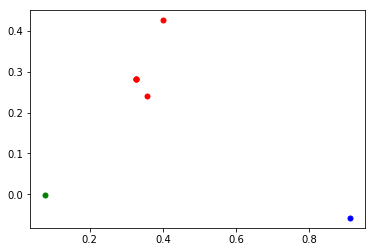

0
ÂçàÂÆâÊâìÂç° ÂçàÂÆâÊâìÂç°ÔΩû ÂçàÂÆâÊâìÂç°Âì¶ ÊòØÂçàÂÆâÊâìÂç° Âçà‰ºëÊó∂Èó¥ËÄç‰∏çË¶ÅÊâìÂç°‰∫Ü?
1
ÂçàÂÆâÂç°
2
ÂîîÂîî,,ÂçàÂÆâÊâìÂç°
7.787747410870675


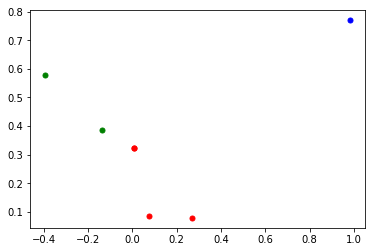

0
ÊÄé‰πàÊ∂àÈô§ÊâìÂç°Â§©Êï∞ÈáçÊñ∞ÂºÄÂßãÂëÄ Êó©Ëµ∑ÊâìÂç°ÂèØ‰ª•ÈáçÊñ∞ÂºÄÂßãÂêó ÈáçÊñ∞‰ªéÁ¨¨‰∏ÄÂ§©ÂºÄÂßãÊâìÂç° ÈáçÊñ∞ÂºÄÂßãÁ¨¨‰∏ÄÂ§©ÊâìÂç°
1
‰ªéÊñ∞ÊâìÂç°
2
ÊâìÂç°ÊÄé‰πàÈáçÊñ∞ÂºÄÂßãÂë¢ ÊÄé‰πàÈáçÊñ∞ÊâìÂç°?
68.17052416676752


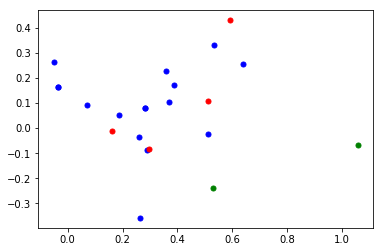

0
ÊÄùÁª¥‰∏çÊâìÂç°‰∫Ü ‰∏çË°•Á≠æÂ∞±‰∏çÊâìÂç°‰∫Ü Êàëdate‰∏çÊâìÂç°Âï¶ Êâ´‰∏çËøõÂéª  Êàë‰∏çËøõ‰∫Ü
1
‰∏çÊâìÂç°‰∫Ü ‰ª•Âêé‰∏çÊâìÂç°‰∫Ü ‰∏çÁù°ËßâÊâìÂç°‰∫Ü ÊàëËøò‰∏çÊâìÂç°‰∫Ü ‰∏çÊèêÈÜíÊâìÂç°‰∫Ü ‰Ω†‰πü‰∏çÊâìÂç°‰∫Ü ‰∏çÊâìÂç° ‰∏çÁªôÊàëÊâìÂç° ÊàëËØ¥Êàë‰∏çÊâìÂç°‰∫Ü ÊÄé‰πà‰∏çÂèØ‰ª•ÊâìÂç°‰∫Ü Ê≤°ÊúâÊàëÂ∞±‰∏çÊâìÂç°‰∫Ü ÊàëÁé∞Âú®ÊÄé‰πà‰∏çÊâìÂç°‰∫Ü Êàë‰∏çÊÉ≥ÊâìÂç°‰∫ÜÊàë‰∏çÁù° ÊàëÊÄé‰πà‰∏çÂèØ‰ª•ÊâìÂç°‰∫Ü ‰ªÄ‰πàÊàëÂøòÊâìÂç°,ÊòØÊâìÂç°‰∫Ü‰∏çÊòæÁ§∫ Êó©Áù°ÊâìÂç°ÂèØ‰ª•ÂèñÊ∂àÂêó
2
‰ªäÂ§©‰∏çÊâì‰∫Ü ‰ªäÂ§©Êâì‰∏çÂá∫Êù•‰∫Ü
361.3864080765794


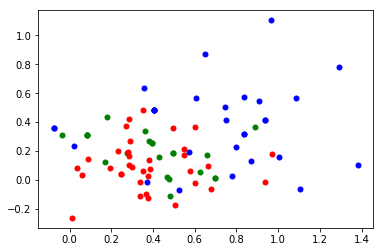

0
‰ªÄ‰πàÊó∂ÂÄôÊúâÁöÑÊäΩÂ•ñ ÊòØÊÄé‰πàÊäΩÂ•ñÊ≥ï ÊÄé‰πàÁ¨¶ÂêàÊäΩÂ•ñÊù°‰ª∂ ÊàëÊÄéÊ†∑ÊâçÁü•ÈÅìÊú¨ÊúàÊúâÊ≤°Êúâ‰∏≠Â•ñÂëê? Êàë‰∏çËÉΩÂèÇ‰∏é‰∫ÜÂêß ÂÖ±ÂêåÊâìÂç° ÊäΩÂ•ñ Âì¶!ËøòÊúâ‰πùÂ§©Êàë‰ª¨ÂèØ‰ª•ÊäΩÂ•ñÂØπÂêó ÊÇ®Â•Ω ÊàëÊó©‰∏äÊî∂Âà∞Âíå‰∏Ä‰∏™Â•ΩÂèãÂÖ±ÂêåÊâìÂç°Â§©Êï∞ÁöÑÊäΩÂ•ñÂõæ ÂΩìÊó∂Ê≤°Ê≥®ÊÑè Âà†Êéâ‰∫Ü ËØ∑ÈóÆÂì™ÈáåÂèØ‰ª•ÊâæÂà∞ÂëÄ Ë∞¢Ë∞¢ ‰ªÄ‰πàÊó∂ÂÄôÊàëËÉΩÂèÇ‰∏éÊäΩÂ•ñ ÊàëÊÄé‰πà‰∏çÁü•ÈÅìÂèØ‰ª•ÊäΩÂ•ñ ‰∏çÁü•ÈÅìÂíãÊäΩÂ•ñ[Facepalm] ÊÄé‰πàÊ†∑ÊâçÊúâÊäΩÂ•ñÂè∑Á†Å ÊâìÂç°21Â§©ÂéªÂì™ÊäΩÂ•ñÂë¢ Âà´‰∫∫ËÉΩÊäΩÂ•ñÊàëÊÄé‰πà‰∏çËÉΩ ÊäΩÂ•ñÁ†Å‰ªÄ‰πàÊó∂ÂÄôÁî®? ÊàëÊÉ≥Áü•ÈÅìÈÇ£ÊäΩÂ•ñÁ†ÅÂÑøÊòØÂïä!‰Ω†‰ª¨‰∏ëËøòÊòØÊàë‰ª¨‰∏ë ÊäΩÂ•ñÊòØÂπ≥Âè∞ÊäΩ‰∏çÊòØÊàë‰ª¨ÊäΩÂØπÂêß ÊäΩÂ•ñÁ†ÅÊòØ‰ªÄ‰πà Êúâ‰∏™ÊäΩÂ•ñÂÜÖÂÆπÊÄé‰πàËØ¥ Ëá™Âä®ÂÖ¨Â∏ÉÊäΩÂ•ñÁªìÊûúÂêó? ÈÇ£‰∏™ÂèØ‰ª•ÊäΩÂ•ñ‰ºòÂåñÊâãË°®Âïä Á≥ªÁªüËá™Âä®ÊäΩÂ•ñ?ÊòØÂêó ÊäΩÂ•ñÊ±†Âú®ÈÇ£ ÊòØÁ≥ªÁªüËá™Âä®ÊäΩÂ•ñËøòÊòØ Âú®Âì™ÈáåÂá∫ÊäΩÂ°´ÂÖ•ÊäΩÂ•ñÁ†Å ÊàëÊÉ≥Áü•ÈÅìÂï•Êó∂ÂÄôÊäΩÂ•ñ ÊÄé‰πàÁü•ÈÅìÊäΩÂ•ñÁ†Å‰∏≠Â•ñ‰∫Ü ÊäΩÂ•ñÁ†ÅÊÄé‰πà‰ΩøÁî® ÊòµÁß∞:Â§ßÁéã„ÄÇ ÊäΩÂ•ñÁ†Å:eb3b5a„ÄÇ ËÅîÁ≥ªÊñπÂºè:13917603792 ÊÄé‰πàÁü•ÈÅì‰∏≠Â•

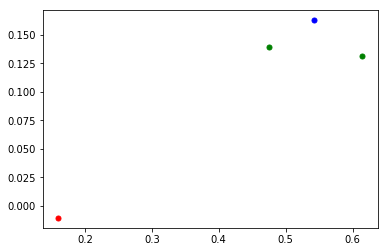

0
‰∏≠Â•ñ‰∫∫ÊòØ‰Ω†‰ª¨ÂÜÖÂÆöÁöÑ?
1
ÊäΩÂ•ñ‰ΩúÂºä
2
‰∏•ÈáçÊÄÄÁñëÊäΩÂ•ñ‰ΩúÂºä ÊàëÊÄÄÁñëÊäΩÂ•ñ‰ΩúÂºä
137.15136064649718


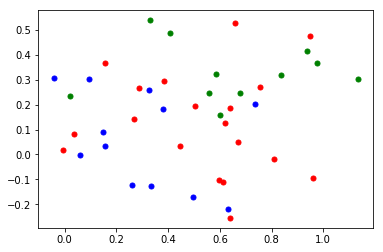

0
ÊäΩÂ•ñÁ†ÅÊòØÂï• ÊÄé‰πàËé∑ÂæóÊäΩÂ•ñÁ†Å ÊäΩÂ•ñÁ†Å:e9637b ÊäΩÂ•ñÁ†Å Ë¶ÅÊääÊäΩÂ•ñÁ†ÅÂ°´Âà∞Âì™ÈáåÂêó? Ëøô‰∏™ÊäΩÂ•ñÁ†ÅÂπ≤ÂòõÁöÑ ‰∏çÁî®ËæìÂÖ•ÊäΩÂ•ñÁ†ÅÂêó? ÊúâÊäΩÂ•ñÁ†Å‰∏çÁü•ÈÅìÂú®Âì™ÈáåÁÇπÊäΩÂ•ñ? ‰ªÄ‰πàÊó∂ÂÄôÊàëËÉΩÂèÇ‰∏éÊäΩÂ•ñ ‰ªÄ‰πàÊó∂ÂÄôËÉΩÊäΩÂ•ñ?ÈúÄË¶ÅËá™Â∑±Êìç‰ΩúÂêó? ÊÄé‰πàÊ†∑ÊâçÊúâÊäΩÂ•ñÂè∑Á†Å Êàë‰∏∫‰ªÄ‰πàÊ≤°ÊúâÊäΩÂ•ñÁ†Å ÊúâÊäΩÂ•ñÁ†Å‰ª•ÂêéÊàëÊÄé‰πàÂèÇ‰∏é? Ê≤°ÊúâÁúãÂà∞ÊäΩÂ•ñÈìæÊé• ÊÄé‰πàÂèÇÂä†ÂéªÊäΩÂ•ñ?ÊàëËøôÈáåÁé∞Âú®ÊúâÈÇ£‰∏™È™åËØÅÁ†Å ÂëºÂè´Âè∑Á†Å‰∏çÁü•ÈÅìÊÄé‰πàÊäΩÂ•ñÂïä ÊàëÁé∞Âú®Âè™ÊúâÊäΩÂ•ñÁ†Å ÊØèÂ§©ÊâìÂç°ÈúÄË¶ÅÂèëÊúãÂèãÂúàÊâçËÉΩÂèÇÂä†ÊäΩÂ•ñÂêó ÊàëÁöÑÊäΩÂ•ñÁ†ÅÊòØ‰ªÄ‰πà
1
ÊÄé‰πàÊäΩ Âú®‰ªÄ‰πàÂú∞ÊñπÊäΩÂ•ñ ÊÄé‰πàÊäΩÂ•ñ?ÊñπÂºè?ÂæÄÂì™ÂÑøËøõ?Ê¶ÇÁéáÂ§öÂ§ß? Âì™ÊúâÊäΩÂ•ñÊ±† ËøòÊúâÈÇ£‰∏™ÂÖëÂ•ñÁ†ÅÊúâ‰ªÄ‰πàÊÑè‰πâ?ÂèàÂ¶Ç‰Ωï‰ΩøÁî®? ÊäΩÂ•ñÊ±†Âú®Âì™ ÊäΩÂ•ñÂêóÂú®Âì™Áî®Âïä ÊäΩÂ•ñÂà∏ ÂéªÂì™ÈáåÊäΩ Â∞±Ê≤°ÁúãÊáÇËøôÁ†ÅÊäΩÂ•ñÊÄé‰πàÁî® Âì¶Âì¶‰∏§‰∏™‰∫∫ÈÉΩÂèØ‰ª•ÊäΩÂêß ÊäΩÂ•ñÁ†ÅÂéªÂì™Áúã‰∏≠Â•ñ‰∫Ü
2
ÊÄé‰πàÊäΩÂ•ñÊ≥ï ÊÄé‰πàÊâçËÉΩÊäΩÂ•ñ ÊäΩÂ•ñÁ†ÅÊúâ‰∫ÜÊÄé‰πàÊäΩÂ•ñ ÊÄé‰πàÊäΩÂ•ñÂïäÁ†Å?ÊäΩÂ•ñb4159c Â¶Ç‰ΩïÊäΩÂ•ñ? ÊäΩÂ•ñ

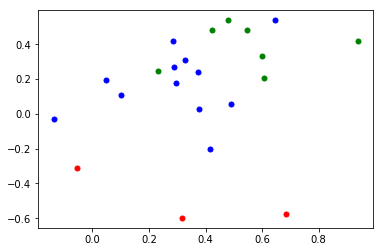

0
‰∏≠Â•ñÂêçÂçïÂá∫‰∫ÜÂêó ‰ªéÂì™ÈáåÁúã‰∏≠Â•ñÂêçÂçï ‰∏≠Â•ñ
1
‰ªÄ‰πàÊó∂ÂÄôÊàëËÉΩÂèÇ‰∏éÊäΩÂ•ñ ÊäΩÂ•ñÁ†Å‰ªÄ‰πàÊó∂ÂÄôÁî®Ôºü Âï•Êó∂ÂÄôÊäΩ ÊäΩÂ•ñÁ†ÅÊòØ‰ªÄ‰πàÊó∂ÂÄô‰ΩøÁî® ÊòØÁ≥ªÁªüËá™Âä®ÊäΩÂ•ñËøòÊòØ ÊàëÊúâÊäΩÂ•ñÂè∑Âïä!ÊÄé‰πà‰ΩøÁî®Âïä ÁúãÂÆåÊäΩÂ•ñÁ†ÅÊÄé‰πàÁî®?ËøòÊòØÊ≤°ÊòéÁôΩ Â§ü21Â§©„ÄÇÂéªÂì™ÈáåÊäΩÂ•ñ ÊäΩÂ•ñÁ†ÅÊòØËá™Âä®ÊäΩÂèñÂêó?ÊîªÁï•ÁúãÂÆå‰πüÊ≤°ÊòéÁôΩË¶ÅÂÅö‰ªÄ‰πà Âï•Êó∂ÂÄôÊäΩÂ•ñ ÊäΩÂ•ñÁ†ÅÊÄé‰πàÁî®Âú®Âì™ÊäΩ ËØ∑ÈóÆÂÖ±ÂêåÊâìÂç°21Â§©ÂêéÂéªÂì™ÈáåÊäΩÂ•ñ
2
ÈÇ£‰∏™ÊäΩÂ•ñÁ†Å‰ªÄ‰πàÊó∂ÂÄôËÉΩÊäΩÂ•ñ ÊäΩÂ•ñÁ†ÅÊàëÊÄé‰πàÁî®?‰ªÄ‰πàÊó∂Èó¥ÊäΩÂ•ñ?ÊàëÊÄé‰πàÂèÇ‰∏éÊäΩÂ•ñÁöÑ ÊäΩÂ•ñÂì™ÈáåÊäΩ Â¶Ç‰ΩïÂèÇ‰∏éÊäΩÂ•ñÊ¥ªÂä® ÊÄéÊ†∑ÂèÇ‰∏éÊäΩÂ•ñÊ¥ªÂä® ÊàëË¶ÅÂèÇ‰∏éÊäΩÂ•ñ Áé∞Âú®ËÉΩÊäΩÂ•ñÂòõ
37.590140860169136


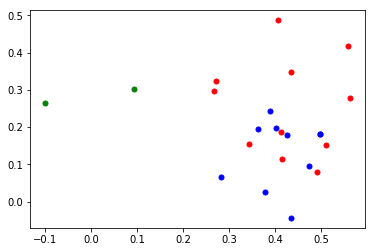

0
ÊäΩÂ•ñÁ†ÅÊúâ‰ªÄ‰πàÁî®Ôºü ÊâìÂç°ÊäΩÂ•ñÁ†ÅÊúâ‰ªÄ‰πàÁî®Ôºü [AI]ÊâìÂç°ÊäΩÂ•ñÁ†ÅÊúâ‰ªÄ‰πàÁî®? ÊäΩÂ•ñÁ†ÅÊòØÊÄé‰πàÊäΩÁöÑÂë¢ ÊäΩÂ•ñÁ†Å‰Ωú‰ªÄ‰πàÁî® ÊäΩÂ•ñÁ†ÅÊúâ‰ªÄ‰πàÁî®?ÊÄé‰πàÊäΩÂ•ñ ÊäΩÂ•ñÁ†ÅÊòØÂπ≤Âï•ÁöÑ ÊÄé‰πàÊäΩÂ•ñÓêí ÊäΩÂ•ñÂêóÊÄé‰πàÁî® ÊäΩÂ•ñÊÄé‰πàÊäΩ ÊÄé‰πàÊäΩÂ•ñ
1
ÊäΩÂ•ñÁ†ÅÊÄé‰πàÁî® ÊäΩÂ•ñÁ†ÅÊÄé‰πàÁî®Âïä?ÊäïÊîæÂà∞ÈÇ£ÈáåÂïä? Ê≤°ÂºÑÊòéÁôΩÊäΩÂ•ñÁ†ÅÊÄé‰πàÁî® ÊäΩÂ•ñÁ†ÅÊòØÂπ≤ÂòõÁöÑ ÊäΩÂ•ñÁ†ÅÂ¶Ç‰ΩïÁî®? ËØ∑ÈóÆÂ¶Ç‰Ωï‰ΩøÁî®ÊäΩÂ•ñÁ†Å ÊäΩÂ•ñÁ†ÅÂú®Âì™ÈáåÁî® ‰ªÄ‰πàÊó∂ÂÄôÁî®ÊäΩÂ•ñÁ†ÅÂë¢ Â∞èÊù•ÊäΩÂ•ñÁ†ÅÂú®Âì™ÈáåÁî®Âïä ÊÄé‰πàÁî®ÊäΩÂ•ñÁ†Å
2
ÊàëËøôÊúàÂ¶Ç‰ΩïÊäΩ ÊÄé‰πàÊäΩ?
99.53559256333054


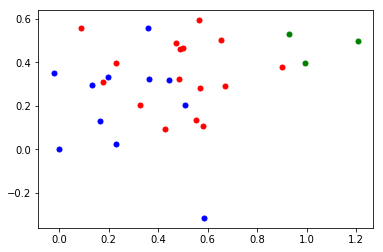

0
Âè¨ÈõÜÂ•ΩÂèãÊâìÂç°Âõ¢ ÂèØ‰ª•ÊääÊâìÂç°Âõ¢ÂèëÂá∫ÂéªÂêó ÊÉ≥Âä†ÂÖ•Êô®Ëµ∑ÊâìÂç°Áæ§ ÊàëÁöÑÊâìÂç°Âõ¢ Âª∫Á´ãÊâìÂç°Âõ¢ ÊâìÂç°Âõ¢Âπ∂‰∏çÊòØÁæ§Âïä Êñ∞Âª∫Êó©Ëµ∑ÊâìÂç°Âõ¢ Â¶Ç‰ΩïÂàõÂª∫Âõ¢ÈòüÊâìÂç° Âª∫ÊâìÂç°Âõ¢ Êó©Ëµ∑ÊâìÂç°Âõ¢ Âª∫Êó©Áù°ÊâìÂç°Âõ¢ ÈÇ£Êü•ÁúãÊàëÁöÑÊâìÂç°Âõ¢ ÊêúÁ¥¢Êó©Ëµ∑Âõ¢ Â¶Ç‰ΩïÂä†ÂÖ•ÊâìÂç°Âõ¢ ÊÄé‰πàÈÇÄËØ∑ÊàëÁöÑÂ•ΩÂèãËøõÊâìÂç°Âõ¢ ÊÄéÊ†∑ÂàõÂª∫ÊâìÂç°Âõ¢
1
ÊâìÂç°Âõ¢‰∏∫‰ªÄ‰πàÂèÇ‰∏é‰∏ç‰∫Ü ÁªÑÂõ¢ÊâìÂç° Â§öÂ∞ë‰∫∫ÊàêÊâìÂç°Âõ¢ ÊâìÂç°Âúò Â¶Ç‰ΩïËøõÂÖ•Âåó‰∫¨Êó©Ëµ∑Â∞èÂàÜÈòü ÊÄé‰πàÊãâ‰∫∫ËøõÊâìÂç°Âõ¢ ‰∏∫‰ªÄ‰πàÂà´‰∫∫ÁöÑÊâìÂç°ÂõæÊúâÂ§öÂ∞ëÂ§öÂ∞ë‰∫∫Ê≠£Âú®ÂèÇ‰∏é ‰∏§ÂπøÂ∑ûÊÄªÁù£ÊâìÂç°Âõ¢ÁöÑÁæ§Âë¢ ÊâìÂç°Âõ¢Âú®Âì™ÈáåÊâìÂºÄ ËØ∑ÈóÆÊÄé‰πàÂºÑÂõ¢Èòü ÊâìÂç° Âπ∂ÁúãÂà∞Âõ¢ÈòüÁöÑÊó•Á®ã Âõ¢Âç°
2
ÊâìÂç°Áæ§ ÂàõÂª∫ÊâìÂç°Áæ§ ÂæÆ‰ø°ÊâìÂç°Áæ§
0.20475460480470392


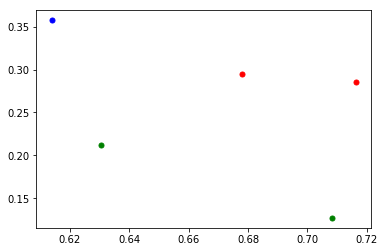

0
‰∏∫‰ªÄ‰πàÂä†ÂÖ•ÊâìÂç°Âõ¢ÊòæÁ§∫ÊöÇÊú™ÊâìÂç°Ôºü ‰∏∫Âï•Âä†ÂÖ•ÊâìÂç°Âõ¢ÊòæÁ§∫ÊöÇÊú™ÊâìÂç°Ôºü
1
‰∏∫‰ªÄ‰πàÂ∑≤ÁªèÊâìÂç°‰∫ÜÂä†ÂÖ•ÊâìÂç°Âõ¢ÊòæÁ§∫ÊöÇÊú™ÊâìÂç°Ôºü
2
Âä†ÂÖ•ÊâìÂç°Âõ¢ÊòæÁ§∫ÊöÇÊú™ÊâìÂç°ÊòØÊÄé‰πàÂõû‰∫ã Âä†ÂÖ•ÊâìÂç°Âõ¢ÊòæÁ§∫ÊöÇÊú™ÊâìÂç°ÊòØÂíãÂõû‰∫ãÔºü
234.56211595981603


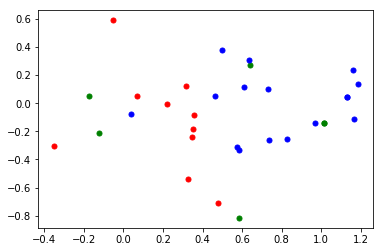

0
ËèúÂçïÂú®Âì™Ôºü ÊàëË¶ÅÊòüÂ∑¥ÂÖã ÊàëÊÉ≥Â§ñÂçñÊòüÂ∑¥ÂÖã ‰ªäÂ§©ÂèØ‰ª•Âêó ÊàëÊÉ≥‰π∞ÊòüÂ∑¥ÂÖã ÊòüÂ∑¥ÂÖãÂú®Âì™ÈáåÂèØ‰ª•‰∏ãÂçï ÊÄé‰πàÊ≤°Ê≥ïÁÇπÂíñÂï°‰∫Ü Ê≤°ÊúâÊòüÂ∑¥ÂÖã‰∫Ü‰πà ÊòüÂ∑¥ÂÖãËèúÂçï ÊòüÂ∑¥ÂÖãËèúÂçïÊúâ‰πà ÊÄé‰πà‰∏ãÂçïÂëÄ
1
ÊÄé‰πàËÆ¢ÂíñÂï°Ôºü ÊÄé‰πàËÆ¢ÂíñÂï° ËæõÂ∑¥ÂÖã ÈÄÅÊùØÂíñÂï°Âà∞Â≠¶Ê†° ÁªôÊàëÈÄÅÊùØÂíñÂï° ÊúâÊèê‰æõÂíñÂï°Âêó coffee È¢ÑÂÆöÊòüÂ∑¥ÂÖã ÈÄÅÂíñÂï°Âà∞Ê¨¢‰πêË∞∑ ÈúÄË¶ÅËÆ¢ÂíñÂï° Â¶Ç‰ΩïËÆ¢ÊòüÂ∑¥ÂÖã ÈÄÅÊùØÂíñÂï°Âà∞ÂÆ∂ ÊÉ≥ÂñùÊòüÂ∑¥ÂÖã ÊàëË¶ÅÂÆöÊòüÂ∑¥ÂÖã Â∏ÆÊàëËÆ¢‰∏ÄÊùØÂíñÂï°Âêß ÊÄé‰πàËÆ¢
2
ÂèØ‰ª•ÁÇπÂíñÂï°Âêó ÊàëË¶ÅÂíñÂï°Âïä ÊòüÂ∑¥ÂÖã ÂíñÂï° Ë¶Å‰∏ÄÊùØÂíñÂï° ÂÆöÂíñÂï°
22.036995471628625


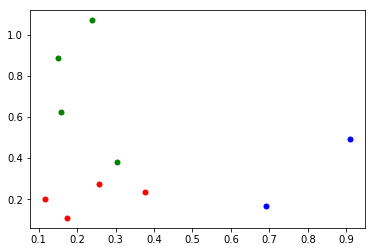

0
ÂèØ‰ª•Âè´È¶ñÊ±ΩÂêóÔºü ÂèØ‰ª•Âè´ÊòìÂà∞ÂêóÔºü ÂèØ‰ª•Âè´Á•ûÂ∑ûÂêóÔºü ÂèØ‰ª•Âè´‰ºòÊ≠•ÂêóÔºü
1
ÂèØ‰ª•Âè´Êª¥Êª¥ÂêóÔºü ‰Ω†‰ª¨ÊòØÊª¥Êª¥ÊâìËΩ¶Âêó?
2
‰Ω†‰ª¨Âè´ËΩ¶ÊòØ‰ªÄ‰πàÂπ≥Âè∞ Â∞èÊù•ÂèØ‰ª•Âè´Âì™‰∫õÂπ≥Âè∞ÁöÑËΩ¶ ‰Ω†‰ª¨Âè´ËΩ¶Êúâ‰ªÄ‰πà‰ºòÂäøÂêó ÈÉΩÊúâ‰ªÄ‰πàÊâìËΩ¶Âπ≥Âè∞Ôºü
47.369143413669136


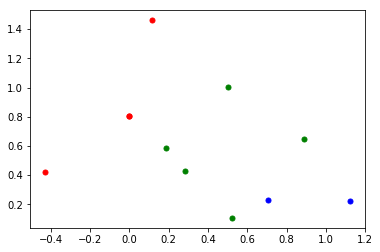

0
Â¶Ç‰ΩïÊâìËΩ¶Ôºü ÊÄé‰πàÂè´ËΩ¶ ÊÄé‰πàÊâìËΩ¶ ÊÄé‰πàÊâìËΩ¶Âë¢
1
ÂèØ‰ª•ÁªôÊàëÊâì‰∏™ËΩ¶Âêó ÊÄé‰πàÊâìÁöÑ
2
Âú®Êù•‰πüÊâìËΩ¶Âë¢ ‰∏∫‰ªÄ‰πàÊâìËΩ¶ Êâì‰∏ç‰∫Ü ÊâìËΩ¶‰∏öÂä°ËøòÊúâÊ≤° ÊÄé‰πàÊ≤°ÊúâÊâìËΩ¶ÊúçÂä°‰∫Ü Ê≤°ÊúâÂè´ËΩ¶ÊúçÂä°‰∫ÜÂêó
13.804108715061364


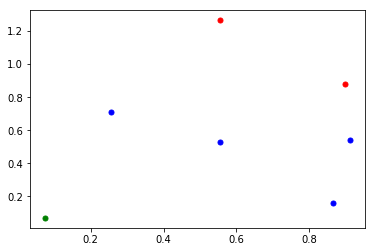

0
Êª¥Êª¥ÂïÜÂä°ËΩ¶ Â∞±Ë¶ÅÂïÜÂä°ËΩ¶ÁöÑ
1
ÂèØ‰ª•Êâì‰∏ÉÂ∫ßËΩ¶ÂêóÔºü Êúâ‰∏ÉÂ∫ßËΩ¶Âêó ËØ∑Â∏ÆÊàëËÆ¢‰∏Ä‰∏™‰∏ÉÂ∫ßËΩ¶ ÊúâÊ≤°ÊúâÂïÜÂä°ËΩ¶
2
ÂèØ‰ª•Âè´7Â∫ßËΩ¶Âêó
4.771839230201707


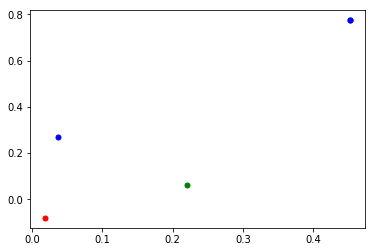

0
ÊãºËΩ¶Ë°å‰∏çË°å
1
ÂèØ‰ª•ÊãºËΩ¶ÂêóÔºü ËÉΩ‰∏çËÉΩÊãºËΩ¶ ËÉΩÊãºËΩ¶ÂêóÔºü
2
ÊòØÂê¶ÂèØ‰ª•ÊãºËΩ¶Ôºü
19.2184835465494


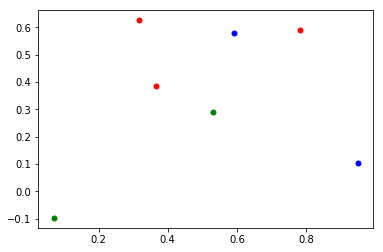

0
ËøòÊ≤°Âè´Âà∞ËΩ¶ Âú®Âè´ËΩ¶‰∫ÜÂêó ÊúâÊ≤°ÊúâËΩ¶Âïä
1
ÊúâËΩ¶Âêó ËøòÊ≤°ËΩ¶Âïä
2
ÊÄé‰πàÁúãÂè∏Êú∫Âú®Âì™Ôºü ËΩ¶Âà∞Âì™‰∫Ü
20.309190832572988


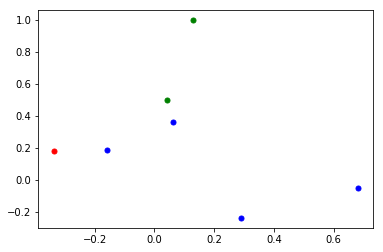

0
ÂèØ‰ª•ÂºÄÂèëÁ•®ÂêóÔºü
1
ÂèëÁ•®ÊÄé‰πàÂºÄ ÂèëÁ•®ÊòØ‰ªÄ‰πàÁ±ªÂûãÁöÑÔºü ÂçïÊ¨°ÂèØ‰ª•ÂºÄÂèëÁ•®ÂêóÔºü ‰∏çËÆ∫Âè´‰ªÄ‰πàËΩ¶ÈÉΩÂèØ‰ª•ÂºÄÂèëÁ•®ÂêóÔºü
2
Âè´ËΩ¶ÂèØ‰ª•ÂºÄÂèëÁ•®Âêó ÊâìËΩ¶ÂèØ‰ª•ÂºÄÂèëÁ•®Âêó
6.665106327928198


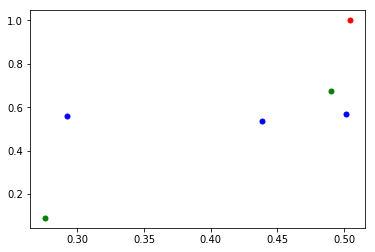

0
Ê≤°ÊúâÂè´ËΩ¶ÊúçÂä°‰∫ÜÂêó
1
ËØ∑ÈóÆÊ≤°ÊúâÂåÖÊúàÊâìËΩ¶ÊúçÂä°‰∫ÜÂêó ËøòÊúâÂåÖÊúàÊâìËΩ¶ÊúçÂä°‰∫ÜÂêó ÊúâÊ≤°ÊúâÂåÖÊúàÊâìËΩ¶ÊúçÂä°‰∫ÜÔºü
2
ËøòÂèØ‰ª•ÂåÖÊúàÊâìËΩ¶ÂòõÔºü ÊòØÂê¶ËøòÂèØ‰ª•ÂåÖÊúàÊâìËΩ¶Âêó
6.300808519530284


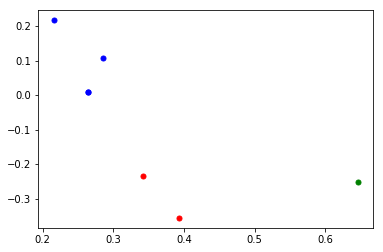

0
ÊàëËøòÊ≤°ÂõûÂÆ∂Âë¢ ‰Ω†Êï¢Â∏¶ÊàëÂõûÂÆ∂Âêó?
1
ÊàëÊÉ≥ÂõûÂÆ∂ ÊÉ≥ÂõûÂÆ∂‰∫Ü Â∞èÊù•ÊàëÊÉ≥ÂõûÂÆ∂ ÊàëÊÉ≥ÂõûÂÆ∂ÊÄé‰πàÂäû
2
‰∏ãÁè≠ÂõûÂÆ∂
16.421001837737812


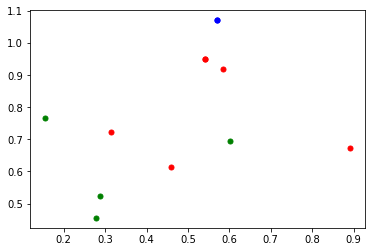

0
ÂèØ‰ª•ÊâìÈ°∫È£éËΩ¶Âêó È°∫È£éËΩ¶ È°∫È£éËΩ¶ÂèØ‰ª•? Êù•‰πüÈ°∫È£éËΩ¶ ÈúÄË¶ÅÈ°∫È£éËΩ¶ È°∫È£éËΩ¶‰∏çÂèØ‰ª•?
1
ÂèØ‰ª•È¢ÑÁ∫¶È°∫È£éËΩ¶Âêó ËÉΩÈ¢ÑÁ∫¶È°∫È£éËΩ¶Âêó?
2
ÁúãËÉΩ‰∏çËÉΩÊúâÈ°∫È£éËΩ¶‰πãÁ±ªÁöÑ ‰Ω†‰ª¨ÂèØ‰∏çÂèØ‰ª•È°∫È£éËΩ¶ Â∏ÆÊàëÊü•‰∏ãÈ°∫È£éËΩ¶Âêß Áé∞Âú®ËÉΩÂê¶È¢ÑÁ∫¶È°∫È£éËΩ¶
51.30862118003278


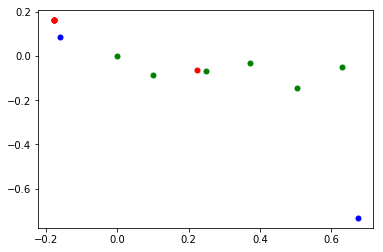

0
Ëøô‰∏™Âè∏Êú∫ÊÄÅÂ∫¶‰∏çÂ•Ω Âè∏Êú∫ÊÄÅÂ∫¶‰πü‰∏çÂ•Ω Âè∏Êú∫ÊÄÅÂ∫¶Âæà‰∏çÂ•Ω Âè∏Êú∫ÊÄÅÂ∫¶‰∏çÂ•Ω ËÄå‰∏îÂè∏Êú∫ÊÄÅÂ∫¶‰∏çÊòØÂæàÂ•Ω
1
Âè∏Êú∫Êâæ‰∏çÂà∞ Â∏àÂÇÖÊâæ‰∏çÂà∞Ë∑Ø
2
Âè∏Êú∫ÊãíËΩΩ Ê≤°‰∏äËΩ¶ÊÄé‰πàË¶Å‰ªòÈí± ‰∏çÊáÇ ÈÇ£Âè∏Êú∫ÊÄÅÂ∫¶ÊûÅÂ∑Æ,Â∑ÆËØÑ Êó†Ê≥ïÂèñÊ∂àËÆ¢Âçï,Âè∏Êú∫ÁÇπÈîô‰∫Ü Ê≤í‰∏äËªä
2.2507404144097407


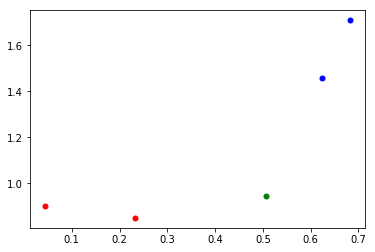

0
ËÉΩ‰∏çËÉΩÂ∏ÆÊàëÈ¢ÑÁ∫¶Âè´ËΩ¶ ËÉΩÂê¶Â∏ÆÊàëÈ¢ÑÁ∫¶Âè´ËΩ¶
1
È¢ÑÁ∫¶Âè´ËΩ¶ Â∏ÆÊàëÈ¢ÑÁ∫¶Âè´ËΩ¶
2
È¢ÑÁ∫¶Âè´‰∏Ä‰∏ãËΩ¶
6.488909493735228


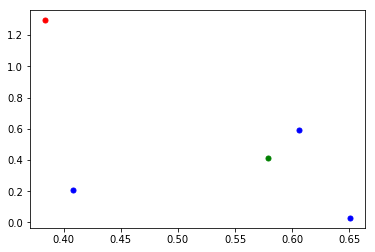

0
Êé•Êú∫
1
ÈÄÅÊú∫ È∫ªÁÉ¶ÂÆö‰∏™Êé•Êú∫,date_timeÂà∞airportflightno ÈÄÅÊú∫ËÆ¢Â•Ω‰∫ÜÂêó?
2
ÈöæÈÅìÊ≤°ÊúâÈ¢ÑÁ∫¶Êé•Êú∫Âë¢
11.083899890276689


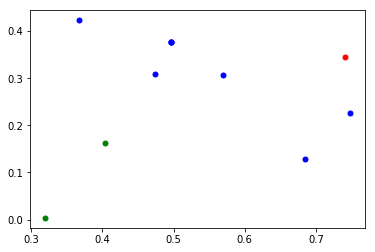

0
ÊâìËΩ¶Âà∏
1
ÊâìËΩ¶Âà∏ÊÄé‰πàÁî® ÊâìËΩ¶Âà∏ÊÄé‰πàÁî®Âïä ÈÇ£ÊâìËΩ¶Âà∏ÊÄé‰πàÁî®? ÊàëÁöÑÊâìËΩ¶Âà∏ÊÄé‰πàÁî®? ÈÄÅÁöÑÊâìËΩ¶Âà∏ÊÄé‰πàÁî® Â¶Ç‰Ωï‰ΩøÁî®ÊâìËΩ¶Âà∏? ÂèØ‰ª•Áî®ÊâìËΩ¶Âà∏‰∏ç Êª¥Êª¥Âà∏ÊÄé‰πàÁî®
2
20ÂÖÉÊâìËΩ¶Âà∏ÊÄé‰πàÁî® ÊâìËΩ¶Âà∏ÂèØ‰ª•ËΩ¨Ëµ†Âêó
2.40784874198321


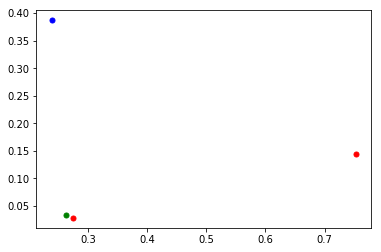

0
‰∏çÊòØÂè´ËΩ¶,ÊòØÂºÄ‰πãÂâçÁöÑÂèëÁ•® Ë°•ÂºÄÊâìËΩ¶ÂèëÁ•®
1
ÊàëÈúÄË¶ÅÊâìËΩ¶Á•®Êä•ÈîÄ
2
ÊàëÈúÄË¶ÅÂèëÁ•®Êä•ÈîÄ
22.984158077510216


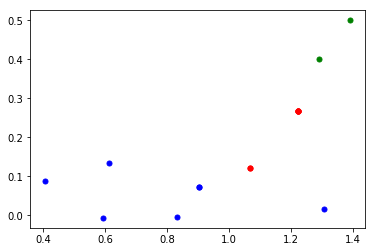

0
Êàë‰∏äËΩ¶‰∫Ü ‰∏äËΩ¶‰∫Ü ‰∏äËΩ¶‰∫Ü„ÄÇ ÂóØ‰∏äËΩ¶‰∫Ü Êàë‰∏äËΩ¶‰∫ÜÂìà ÂóØ‰∏äËΩ¶‰∫ÜÂì¶ ‰∏äËΩ¶Âï¶
1
‰∏äËΩ¶‰∫Ü,Ë∞¢Ë∞¢ Â∑≤Áªè‰∏äËΩ¶‰∫Ü ÊàëÂ∑≤Áªè‰∏äËΩ¶‰∫Ü ‰∏äËΩ¶‰∫Ü, ÈÉΩÂ∑≤Áªè‰∏äËΩ¶‰∫Ü Â∑≤‰∏äËΩ¶‰∫Ü Â•Ω‰∫Ü,‰∏äËΩ¶‰∫Ü
2
ÊàëÂùê‰∏äËΩ¶‰∫Ü Âùê‰∏äËΩ¶‰∫Ü
6.959902186025796


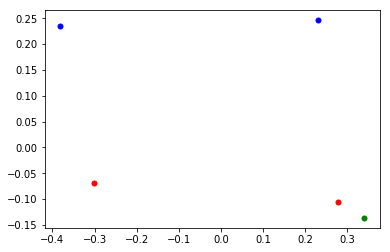

0
ÂÜçÂè´ È∫ªÁÉ¶ÂÜçÂè´‰∏ã
1
ÁªßÁª≠Âè´ ÈáçÊñ∞Âè´
2
Âè∏Êú∫ÊâìÊàëÁîµËØùÊù•ËØ¥Ë¶Å30ÂàÜÈíü
14.149422104322747


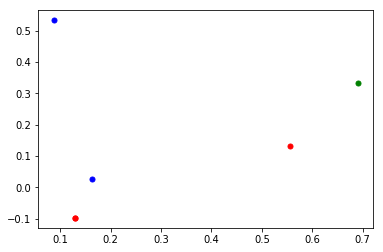

0
ÊàëÂè´Âà∞‰∫Ü ÊàëËá™Â∑±Âè´Âà∞‰∫Ü ÊàëËá™Â∑±‰∫§Âà∞‰∫Ü
1
‰∏çË¶ÅËΩ¶‰∫Ü ‰Ω†‰∏çË¶ÅËÄÅÊòØÂèëÂè´ËΩ¶ÁöÑ‰ø°ÊÅØÂòõ
2
ÂèñÊ∂àÁî®ËΩ¶
4.194439528432029


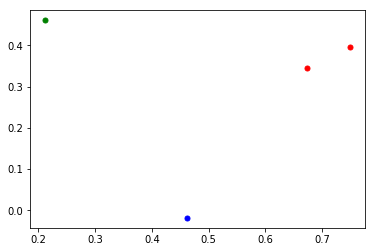

0
Êç¢‰∏ÄËæÜÂêß ËÉΩÂ∏ÆÂøôÊç¢‰∏ÄËæÜÂ§ßÁöÑ‰πà
1
ÂèñÊ∂àÊç¢‰∏ÄËæÜ,‰ªñÂàöÊâìÁîµËØùËØ¥Âéª‰∏ç‰∫Ü
2
Âú®Âè´‰∏ÄËæÜ?
37.62364599174437


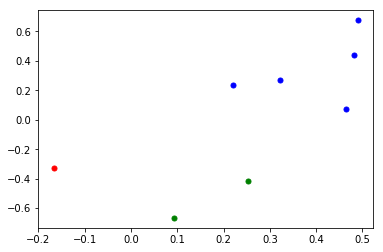

0
ÂåÖÊúàÂ•óÈ§ê
1
ÊâìËΩ¶ÂåÖÊúà ÂåÖÊúàËÆ°Âàí ÂåÖÊúàËØ¶ÊÉÖ ÂåÖÊúàË®àÂäÉ ÊÄé‰πàÊü•ÂåÖÊúàËÆ°Âàí‰ΩôÈáè
2
Ââ©‰ΩôÈáåÁ®ã Â¶Ç‰ΩïÁü•ÈÅìÂâ©‰ΩôÂÖ¨ÈáåÊï∞
18.20752870533342


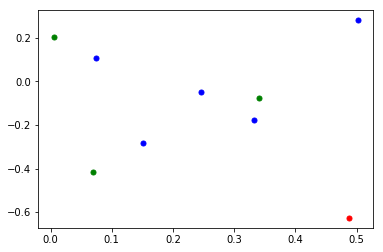

0
ÂèØ‰ª•ÈÄÄÊ≤°Áî®ÂÆåÁöÑÈáåÁ®ãÂêó
1
ÈáåÁ®ãÁî®ÂÆåË¶ÅÈáçÊñ∞ÂåÖÊúàÂØπÂêß? ÂàöÊâçÁöÑËÆ¢ÂçïËØ∑Áî®ÂåÖÊúàÈáåÁ®ãÊîØ‰ªò ÂåÖÊúàÊâìËΩ¶ÁöÑÈí±ÈÄÄÁªôÊàë‰∫ÜÂêó? Â∏ÆÊàëÂåÖÊúàÈáåÁ®ãÈáåÊâ£ ËØ∑Áî®ÂåÖÊúàÊîØ‰ªò‰∏ä‰∏ÄÁî®ËΩ¶ËÆ¢Âçï
2
È∫ªÁÉ¶Â∏ÆÊàëÁúãÁúãÊòØÊÄé‰πàÂ§ÑÁêÜ,ÈáåÁ®ãÁª≠Â≠òËøòÊòØÂ∞±ËøáÊúü‰ΩúÂ∫ü‰∫Ü Êàë‰π∞ÁöÑÈáåÁ®ãÊï∞‰∏çÁî®Áî®Áé∞Èáë,ÈÇ£ÊàëÊ≤°ÊúâÂÜçÁª≠ÁöÑÂøÖË¶Å‰∫Ü ÊúàÂç°Êó∂Èó¥ÂΩìÊúàÊú™Áî®ÊàñÊú™Áî®ÂÆåÁöÑ,ÊòØÂèØ‰ª•Á¥ØËÆ°Âà∞date,ËøòÊòØÂ∞±‰ΩúÂ∫ü‰∫ÜÂë¢?
70.93898714581157


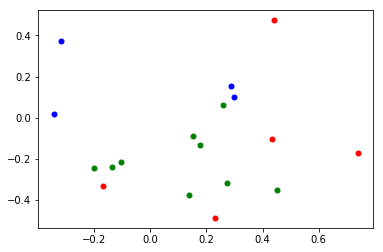

0
Ë¥≠‰π∞ÂåÖÊúà Ë¥≠‰π∞ÂåÖÊúàÂ•óÈ§ê ‰π∞ÂåÖÊúà ÂåÖÊúàÂ•óÈ§ê ÂåÖÊúà
1
ÊàëË¶ÅÂåÖÊúà ÂåÖÊúàÁïÖÊâì ÂåÖÊúàÊ¶¥Ëé≤ ÊàëË¶ÅÂåÖÊúà100ÂÖ¨Èáå
2
Âä†Ê≤πÂåÖ ÊàëË¶Å‰π∞Âä†Ê≤πÂåÖ ÊàëË¶ÅÂÜ≤Âä†Ê≤πÂåÖ ÂÖÖÂÄº,Âä†Ê≤πÂåÖ Ë¥≠‰π∞Âä†Ê≤πÂåÖ ÈáåÁ®ãÂä†Ê≤πÂåÖ ÂåÖÊúàÂä†Ê≤πÂåÖ ÊàëË¶Å‰π∞30ÂÖ¨ÈáåÂä†Ê≤πÂåÖ Ë¥≠‰π∞ÈáåÁ®ãÂä†Ê≤πÂåÖ
11.737495606425028


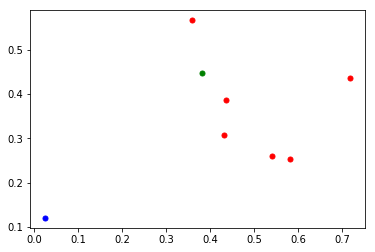

0
ÂåÖÊúàÊâìËΩ¶ÊÄé‰πàÁî® ÂåÖÊúàÁî®ËΩ¶Âà∏,ÊÄé‰πà‰ΩøÁî®? ‰ΩøÁî®ÂåÖÊúàÁî®ËΩ¶Âà∏ ËØ∑ÈóÆÂåÖÊúàÁî®ËΩ¶Âà∏ÊÄé‰πàÁî® ÂåÖÊúàÁî®ËΩ¶Âà∏ ÊúâÂåÖÊúàÊâìËΩ¶Âà∏
1
ÊàëÊÉ≥ÈóÆ‰∏ã ÊàëÁöÑÂåÖÊúàÈáåÈù¢ ÂèØ‰ª•Âè´Â•ΩÁÇπÁöÑËΩ¶ÂûãÂêó
2
ÂåÖÊúàÁî®ËΩ¶
16.135936193191178


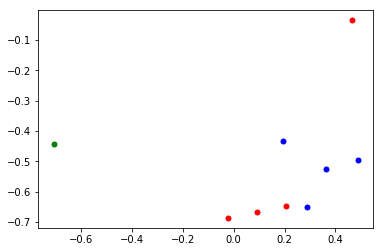

0
ÈÇ£ÊàëÁöÑÂåÖÈáåÁ®ãÂç°ËøòÂâ©Â§öÂ∞ëÈáåÁ®ã È∫ªÁÉ¶Â∏ÆÊàëÊü•‰∏Ä‰∏ã‰∏äÊ¨°ÈáåÁ®ãÂåÖËøòÂâ©Â§öÂ∞ëÈáåÁ®ã Ââ©‰ΩôÈáåÁ®ã ÊúàÂç°ÈáåÁ®ã
1
ÊàëËøòÊúâÂ§öÂ∞ëÈáåÁ®ãÊï∞ ÊàëÁé∞Âú®Ââ©‰ΩôÈáåÁ®ãÊòØÂ§öÂ∞ë? dateÁöÑÂåÖËΩ¶ÈáåÁ®ãËøòÂâ©Â§öÂ∞ë? ËøôÂ∞±ÊòØËØ¥Êàë‰π∞ÁöÑÊòØÈáåÁ®ãÊï∞
2
ÈáåÁ®ã
25.455151580803584


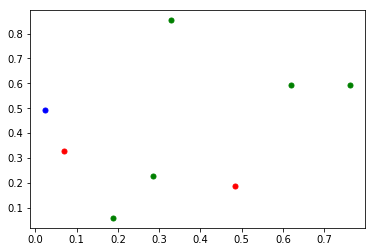

0
Á≥ªÁªüÁ®≥ÂÆöÂêó ‰∏∫‰ªÄ‰πà‰Ω†ÁöÑ‰ø°ÊÅØÊòØÁßíÂõû
1
Â¶Ç‰Ωï‰ΩøÁî®
2
‰∏∫Âï•‰ΩøÁî®Â∞èÊù•Âë¢ ‰∏∫‰ªÄ‰πà‰ΩøÁî®Â∞èÊù•Ôºü ‰∏∫Âï•Ë¶ÅÁî®Â∞èÊù• ‰∏∫Âï•Ë¶ÅÁî®‰Ω†‰ª¨ Âä©ÁêÜÊù•‰πüÂ•ΩÁî®Âêó
6.26279620000556


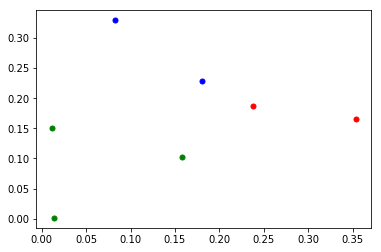

0
ÈÉΩÊúâÂï•ÊúçÂä°ÂìÅÁ±ªÔºü ÊúçÂä°Â§™Â∞ë‰∫Ü
1
ÈÉΩÊúâ‰ªÄ‰πàÊúçÂä°Ôºü ‰Ω†‰ªÄ‰πàÊúçÂä°Âïä
2
ÊúçÂä°ÁßçÁ±ªÈÉΩÊòØ‰ªÄ‰πà Êúâ‰ªÄ‰πàÊúçÂä°ÂìÅÁ±ªÔºü ÊúâÂì™‰∫õÊúçÂä°ÁßçÁ±ªÔºü
24.118140288150236


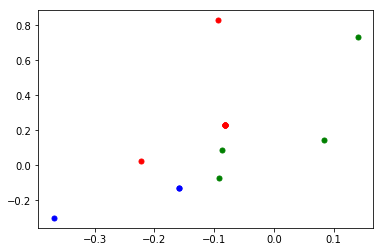

0
ËøôÊòØ‰ªÄ‰πàÂπ≥Âè∞ ‰ªÄ‰πàËΩØ‰ª∂ ËøôÊòØ‰ªÄ‰πàËΩØ‰ª∂ Ëøô‰∏™‰ªÄ‰πàËΩØ‰ª∂ ËøôÊòØ‰ªÄ‰πàËΩØ‰ª∂? ËøôÊòØ‰ªÄ‰πàËΩØ‰ª∂‚Ä¶ ËøôÊòØ‰ªÄ‰πàËΩØ‰ª∂Âïä Ëøô‰∏™ËΩØ‰ª∂Êúâ‰ªÄ‰πàÂäüËÉΩ
1
ËøôÊòØ‰∏ÄÊ¨æ‰ªÄ‰πàËΩØ‰ª∂ ËøôÊòØ‰∏Ä‰∏™‰ªÄ‰πàËΩØ‰ª∂ ËøôÊòØ‰∏Ä‰∏™‰ªÄ‰πàËΩØ‰ª∂?
2
ÊÇ®‰ª¨ÊòØ‰ªÄ‰πà‰π±ËΩØ‰ª∂ Ëøô‰∏™ÂÖ¨‰ºóÂè∑ÁöÑ‰ΩúÁî®ÊòØ‰ªÄ‰πàÔºü Ëøô‰∏™ËΩØ‰ª∂ÁöÑ‰ΩúÁî®ÊòØ‰ªÄ‰πà Ëøô‰∏™APPÁöÑ‰ΩúÁî®ÊòØ‰ªÄ‰πà
7.968065479693878


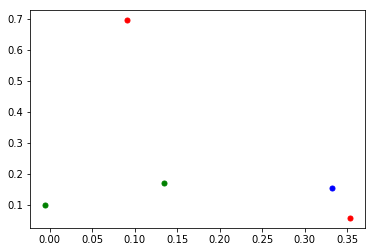

0
‰∏ÄÂºÄÂßãÊÉ≥ÈóÆ‰∏ãÂí±‰ª¨ÁöÑÊúçÂä°Âå∫Âüü ÊúçÂä°‰∏çÂà∞‰Ωç
1
ÊúçÂä°ËåÉÂõ¥
2
‰Ω†ËøòÊúâ‰ªÄ‰πàÊäÄËÉΩ ‰∏≠Ë•øÂå∫Êúâ‰ªÄ‰πà‰∏úË•øÂèØ‰ª•ÊúçÂä°ÁöÑÂêó?
290.3160356590095


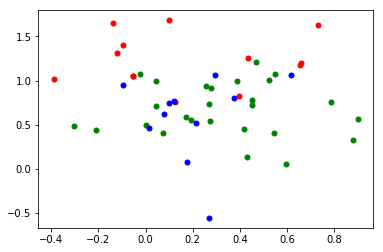

0
ÈÉΩËÉΩÊúçÂä°Âì™‰∫õÂú∞Âå∫Ôºü Ë¶ÜÁõñÁöÑÂå∫ÂüüÊúâÂì™‰∫õ? Ë¶ÜÁõñÂüéÂ∏Ç Âì™‰∫õÂüéÂ∏Ç ÊîØÊåÅÂüéÂ∏Ç ÊúçÂä°ÂüéÂ∏Ç Ë¶ÜÁõñÈÖçÈÄÅÂì™‰∫õÂú∞Âå∫ ÊúçÂä°Âú∞Âå∫Ôºü ÊúâÂì™‰∫õÊúçÂä°Âú∞Âå∫Ôºü ÊúçÂä°Âú∞Âå∫ÊúâÂì™‰∫õÔºü ‰Ω†‰ª¨Ê≤°ÊúâË¶ÜÁõñÊàë‰ª¨ÂüéÂ∏Ç Êèê‰æõÊúçÂä°ÁöÑÂú∞Âå∫ÊúâÂì™‰∫õ? Âì™‰∫õÂú∞Âå∫ÂèØ‰ª•Áî®Êù•‰πü
1
ÈïøÊ≤ôÂèØ‰ª•Áî®Âêó ÈïøÊ≤ôÂèØ‰ª•Áî®Êù•‰πüÂêó Ë¶ÜÁõñËåÉÂõ¥? Ê≤àÈò≥ÊúâÂòõ ‰ªÄ‰πàÊó∂ÂÄôÈïøÊ≤ôÊúâ? ÊàëËøôËæπÊúâÂêó? ‰Ω†‰ª¨Ê≥¢ÂèäÂà∞ÈÉëÂ∑û‰∫Ü‰πà ÊàêÈÉΩÂèØ‰ª•Áî®Âêó ÈùíÂ≤õÊúâÂä©ÁêÜÊù•‰πüÂêó? Âçó‰∫¨ÊúâÊù•‰πü‰πà ÂπøÂ∑û Ê≠¶Ê±âÊúâ‰πà
2
ÈïøÊ≤ôÊúâÊúçÂä°Âêó ÈïøÊ≤ôËÉΩÁî®‰Ω†‰ª¨ÁöÑÊúçÂä°Âêó ÂÖ≥ÈîÆÊàëË¶ÅÁü•ÈÅìË¶ÜÁõñ‰∫ÜÂì™‰∫õÂå∫Âüü? ÊúçÂä°Âå∫Âüü ÊúçÂä°Âå∫ÂüüÊòØÂì™ Ë¶ÜÁõñÁöÑÁ±ªÂûã ÈÉΩËÉΩÊúçÂä°Âà∞‰ªÄ‰πàÂú∞ÊñπÔºü ËÉΩÊúçÂä°Âà∞Âì™Èáå ‰∏∫‰ªÄ‰πàÂ∏∏Â∑ûÂú∞Âå∫Ê≤°ÊúâË¶ÜÁõñ Êù≠Â∑ûÂ∞èÊù•ÊúâÂì™‰∫õÊúçÂä°?? Êàë‰ª¨ËøôÈáåÊ≤°Êúâ‰Ω†‰ª¨ÁöÑÊúçÂä° ÊúâÊ≤°ÊúâÂú∞ÂüüÈôêÂà∂ÁöÑ ‰Ω†‰ª¨Âè™ÊúâÂåó‰∏äÂπøÊúçÂä°Âêó Áé∞Âú®Â§™ÂéüÊèê‰æõÂ∏ÆÂä©ÂêóÔºü ÊúçÂä°ÁöÑÂú∞ÁêÜ‰ΩçÁΩÆÂë¢ÔºüÂé¶Èó®ÂèØ‰ª•Âêó ÊâÄÂú®Âå∫ÂüüÊó†Ê≥ï‰∏ãÂçï ÈÇ£Âú®Âì™‰∫õÂú∞ÊñπÊèê‰æõÂíñÂï°ÈÖçÈÄÅÊúçÂä

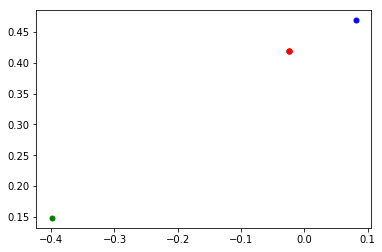

0
‰Ω†‰ª¨ÊÄé‰πàÊå£Èí± ‰Ω†‰ª¨ËøôÊ†∑ÔºåÊÄé‰πàÊå£Èí±Âïä ËØ∑ÈóÆ‰Ω†‰ª¨ÊÄé‰πàÊå£Èí±ÂïäÔºü
1
Êù•‰πüÊÄé‰πàÁõàÂà©
2
Â¶Ç‰ΩïÁõàÂà©
7.599282307702833


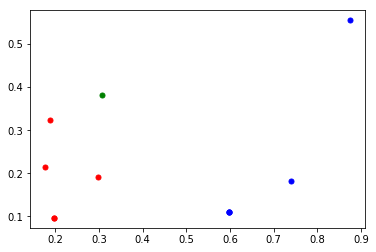

0
Êúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩÂêó Â∞±ÊòØÈóÆÈóÆÁé∞Âú®Áé∞Âú®ÊúâÂï•Êñ∞ÂäüËÉΩÂëÄ ‰Ω†‰ª¨Êúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩ Â∞èÊù•Êúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩ ÊúâÂì™‰∫õÊñ∞ÂäüËÉΩ?
1
ÊúÄËøëÊúâÊñ∞ÂäüËÉΩÂêó ÊúÄËøëÊúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩÂòõ ‰Ω†‰ª¨ÊúÄËøëÂèàÂºÄÂèëÂï•Êñ∞ÂäüËÉΩ‰∫Ü? ÊúÄËøëÊúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩ? ‰Ω†‰ª¨ÊúÄËøëÊúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩÂëÄ
2
ÊàëÂ∞±ËØïËØï‰Ω†ÁöÑÊñ∞ÂäüËÉΩÂïä
51.97744377845033


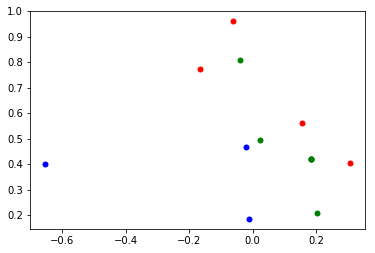

0
ÊÄé‰πàÊìç‰Ωú ÊàëËøò‰∏çÁü•ÈÅìÊÄé‰πàÊìç‰ΩúÂë¢„ÄÇ Êàë‰∏ç‰ºöÊìç‰Ωú ÊàëËá™Â∑±ÂèØ‰ª•ÊâãÂä®Êìç‰ΩúÂêó?
1
‰∏ç‰ºöÁî® Êàë‰∏ç‰ºö Â•ΩÂ§öÂäüËÉΩ‰∏ç‰ºöÁî®
2
Â¶Ç‰Ωï‰ΩøÁî® ÊÄé‰πàÁî® ÊÄé‰πàÁî®? Ëøô‰∏™ÊÄé‰πàÁî®Âë¢ Ëøô‰∏™Âä©ÁêÜÊù•‰πüË¶ÅÊÄéÊ†∑‰ΩøÁî®Âë¢ Ëøô‰∏™ÊÄé‰πàÁé©ÁöÑ,ÊòØ‰ªÄ‰πàÊÑèÊÄù?
135.2868275164333


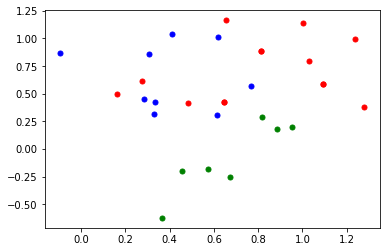

0
‰Ω†ÊòØÂÆ¢Êúç? ÊàëË¶ÅÂÆ¢ÊúçÁîµËØù ÂÆ¢ÊúçÁîµËØù ÂÆ¢ÊúçÁîµËØùÊâì‰∏çÈÄö ÂÆ¢ÊúçÂë¢ ÂÆ¢ÊúçÂú®Âêó ÊúâÂÆ¢ÊúçÂêó ÊúâÂÆ¢ÊúçÂêó? Âú®Á∫øÂÆ¢Êúç ÂëºÂè´ÂÆ¢Êúç ÊàëË¶ÅÊâæÂÆ¢Êúç ÂÆ¢ÊúçÂú®Âòõ? ÊÄé‰πàËÅîÁ≥ªÂÆ¢Êúç ÂÆ¢ÊúçÂÆ¢ÊúçÂÆ¢Êúç
1
ÈúÄË¶Å‰∫∫Â∑•ÂÆ¢ÊúçÂØπËØù ÊàëË¶Å‰∫∫Â∑•ÊúçÂä° ËÆ©‰Ω†‰ª¨‰∫∫Â∑•ÂÆ¢ÊúçÁúã‰∏ãÊàëÁöÑÂÜÖÂÆπ ‰∫∫Â∑•ÂÆ¢Êúç ÂèçÈ¶àÈÄöÈÅìÊòØÂï• ‰Ω†ÂÄëÊúâ‰∫∫Â∑•ÂÆ¢ÊúçÂóé? ÊàëË¶Å‰∫∫Â∑•Ê≤üÈÄö ÊàëÈúÄË¶Å‰∫∫Â∑•ÂÆ¢ÊúçËß£Êïë Ê≤°ÊúâÁúü‰∫∫ÂÆ¢ÊúçÂòõ
2
ÂÆ¢ÊúçÁîµËØùÊòØÂ§öÂ∞ëÔºü ‰Ω†ÁöÑÊâãÊú∫Âè∑Á†ÅÂ§öÂ∞ë? ÂæÆ‰ø°ÂÆ¢ÊúçÁÉ≠Á∫øÊòØÂ§öÂ∞ë? ‰Ω†ÁöÑÁîµËØùÂ§öÂ∞ëÔºåËÉΩ‰∏çËÉΩÁîµËØùËÅîÁ≥ª ‰Ω†‰ª¨ÁîµËØùÂè∑Á†ÅÂ§öÂ∞ë ÂÆ¢ÊúçÁîµËØùÂ§öÂ∞ë ‰Ω†‰ª¨ÂÖ¨Âè∏ÁîµËØùÂ§öÂ∞ë
13.035992368426793


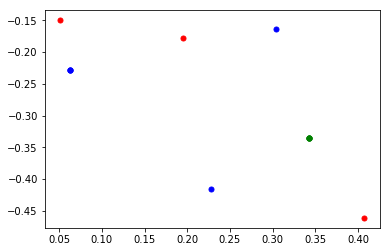

0
Êñ∞ÂÆ¢ÊúâÊ≤°Êúâ‰ºòÊÉ†Âà∏ dateÊúâ‰ºòÊÉ†Âà∏Ê≤° ÊàëÂ•ΩÂÉèÊúâ‰ºòÊÉ†Âà∏
1
ÊúâÊ≤°Êúâ‰ºòÊÉ†Âà∏ÂêóÔºü ÊúâÊ≤°Êúâ‰ºòÊÉ†Âà∏ ÊúâÊ≤°ÊúâÈÄÅ‰ºòÊÉ†Âà∏ ÊúâÊ≤°Êúâ‰ºòÊÉ†Âà∏Âë¢ ÊúâÊ≤°ÊúâÊòüÂ∑¥ÂÖãÁöÑ‰ºòÊÉ†Âà∏
2
Êúâ‰ºòÊÉ†Âà∏ÂêóÔºü ‰ºòÊÉ†Âà∏ÊúâÂêó Êúâ‰ºòÊÉ†Âà∏‰πà Êúâ‰ºòÊÉ†Âà∏Âêó
621.298999057743


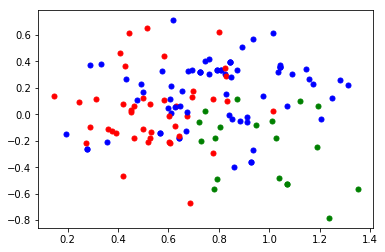

0
ÊîπÊàê13527863542 ‰ª•ÂâçÊâãÊú∫Â∑≤ÁªèÂÅúÁî®‰∫Ü ÊàëË¶ÅÊõ¥Êç¢ÊâãÊú∫Âè∑ÂÑø Êõ¥Êç¢ÊâãÊú∫Âè∑,telnum ÊÄé‰πàÊîπÊàêÂà´ÁöÑÊâãÊú∫Âè∑ ÊÄé‰πàÊîπÁªëÊâãÊú∫Âè∑ Â∞èÊù•,ÊàëÊâãÊú∫Âè∑Á†ÅÊç¢Êàê18916102305,ÊÄé‰πàÊîπËøáÊù•? ÊàëÁöÑË¥¶Âè∑‰∏çËÉΩÁôªÈôÜ‰∫Ü Â∞èÊù•?ÊàëÂéüÊù•Ê≥®ÂÜåÊâãÊú∫‰∏çÁî®‰∫Ü,Áé∞Âú®ÁôªÈôÜ‰∏ç‰∏äÂéª ÊÉ≥Êç¢Âè¶‰∏Ä‰∏™ÂæÆ‰ø°,ÂíãËøûÊé•Âïä ËØ¥Ê≠§ÂæÆ‰ø°Â∑≤ÁªèÁªëÂÆö‰∫ÜÂà´ÁöÑÊâãÊú∫Âè∑,‰∏çËÉΩ‰øÆÊîπ ÈÇ£‰∏™Âè∑Á†ÅÂ∑≤ÁªèÊâæ‰∏çÂà∞‰∫Ü Êàë‰∏∫‰ªÄ‰πàÊàëÁöÑË¥¶Âè∑Áôª‰∏ç‰∏ä ÂèØ‰ª•ÁöÑËØùÊàëÂ∞±ÊãøÊàëËá™Â∑±ÁöÑÂæÆ‰ø°Âè∑ÁªëÂÆöÊàëËá™Â∑±ÁöÑÊâãÊú∫ ÊàëË¶ÅÁªëÂÆöËá™Â∑±ÁöÑÂæÆ‰ø°Âè∑ ÊàëËøô‰∏™ÂæÆ‰ø°ÁªëÂÆö‰∫ÜÂÖ∂‰ªñÊâãÊú∫ÂÖ∂‰ªñÊâãÊú∫‰∏çÁî®‰∫ÜÊÄé‰πàÂäû ÊÇ®ÂèëÁöÑÊâãÊú∫Âè∑Â∑≤Áªè‰∏çÁî®‰∫Ü Áªë‰∫ÜÊàë‰ª•ÂâçÁöÑÊâãÊú∫Âè∑ ÊÄé‰πàÁôªÊâãÊú∫Âè∑ ÊàëËøô‰∏™ÂæÆ‰ø°Âè∑ ÊâãÊú∫Âè∑È™åËØÅÊó∂ËØ¥ÂæÆ‰ø°ÁªëÂÆöÊâãÊú∫Âè∑‰∏çÂêå ‰∏çËÉΩÁôªÈôÜ ËÉΩ‰∏çËÉΩÊç¢ÁªëÂæÆ‰ø°Âè∑ ÊàëÊç¢‰∫ÜÊâãÊú∫Âè∑ ÊâÄ‰ª•‰∏ã‰∏ç‰∫ÜËÆ¢Âçï‰∫Ü ËØ¥ÂæÆ‰ø°Âè∑Â∑≤ÁªëÂÆöÂÖ∂‰ªñÊâãÊú∫Âè∑ Êàë‰πãÂâçÁªëÂÆö‰∫ÜÊâãÊú∫Â∑≤Áªè‰∏çÁî®‰∫Ü Êàë‰πãÂâçÁªëÂÆö‰∫ÜÊâãÊú∫Â∑≤Áªè‰∏çÁî®‰∫Ü„ÄÇÁé∞Âú®ÈúÄË¶ÅÈ™åËØÅÊâãÊú∫„ÄÇ ÊàëÊúâ‰∏§‰

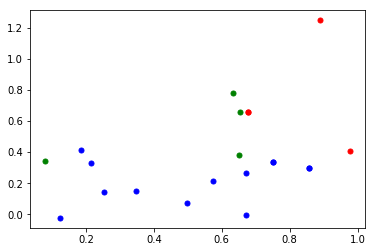

0
ÊÄé‰πàÊäïËØâÔºü ÊäïËØâÂä©ÁêÜ ÊÄé‰πàÊäïËØâ ÊàëÁé∞Âú®Â∞±Á´ãÈ©¨ÊäïËØâ
1
ÊäïËØâ‰Ω† ÊàëË¶ÅÊäïËØâ‰Ω† ÊàëÊäïËØâ‰Ω† È∫ªÁÉ¶‰Ω†ÊäïËØâ ÊàëÂèØ‰ª•ÊäïËØâ‰Ω† ÊàëËøòË¶ÅÊäïËØâ‰Ω†!!! ‰Ω†ËØ¥‰Ω†ÊäïËØâ,ÊàëÊÄé‰πàÁü•ÈÅì‰Ω†ÊäïËØâ‰∫Ü??? ÊàëÊäïËØâ‰Ω†‰∏§Ê¨°‰∫Ü ‰∏Ä‰∏™Â∞èÊó∂ËøòÊ≤°ÈÄÅÂà∞,‰πüÊòØÊ≤°sei‰∫Ü!ÂèØ‰ª•ÈÄÄËÆ¢Âêó?ÂçàÈ•≠ÈÉΩË¶ÅÈÄÅÊù•‰∫Ü/::@ ‰Ω†‰∏çËÆ≤ÊàëÊäïËØâ‰Ω† ‰ø°‰∏ç‰ø°ÊàëÂè´ÂÖ®ÈÉ®‰∫∫ÊäïËØâ‰Ω†? ÂÖ≥‰∫éÂ¶Ç‰ΩïÊäïËØâÂø´ÈÄí ÊÉ≥Ë¶ÅË¢´ÊàëÊäïËØâÂêó?
2
ÊäïËØâÂ∞èÂì• ÊàëË¶ÅÊäïËØâÂ∞èÂì• ÊäïËØâË∑ëËÖø ÊäïËØâÈòøÂß®
137.16395597321278


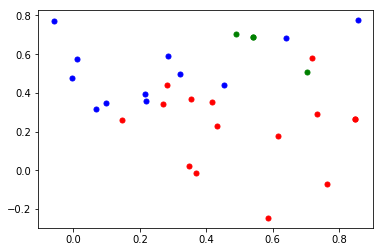

0
ÂèØ‰ª•ÂèëËØ≠Èü≥ÂêóÔºü ËÉΩÁªô‰Ω†ÂèëËØ≠Èü≥Âêó ÂèØ‰ª•ÂèëËØ≠Èü≥Âêó Âê¨ËØ¥ÂèØ‰ª•ÂèëËØ≠Èü≥ ÂèØ‰ª•Âä†ÊÆµËØ≠Èü≥Âêó ‰∏∫‰ªÄ‰πàÂ∞èÊù•‰∏ç‰ºöÂèëËØ≠Èü≥ ‰Ω†Â•ΩÊàëÁöÑÊÑèÊÄùÊòØÊàëÂèØ‰ª•Áªô‰Ω†ÂèëËØ≠Èü≥Âêó? ‰∏çÊòØËÉΩÂèëËØ≠Èü≥Âêó? Âèë‰∏™ËØ≠Èü≥ËØ¥Â•ΩÂêó? Âæà‰πÖÊ≤°ÊúâÂíåÊàëËØ¥ËøáËØ≠Èü≥‰∫Ü ‰ºöËÆ≤ËØ≠Èü≥Âêó Âìé‰Ω†ËÉΩ‰∏çËÉΩÂèëËØ≠Èü≥Âïä?Ê∞îÊ≠ª‰∫Ü Áõ¥Êé•ËØ¥ËØ≠Èü≥Âêó ËØ∑Áî®ËØ≠Èü≥ÂõûÂ§çÂêó ÂèØ‰ª•ÂèëËØ≠Èü≥Êñ∞Âª∫Êó•Á®ãÂêó
1
ËÉΩË∑ü‰Ω†ËØ¥ËØùÂêó ÊÄé‰πàËØª? ÂèØ‰ª•ËØ≠Èü≥ÂíåÊàëËÅäÂ§©Âêó ‰Ω†ÂèØ‰ª•Áî®ËØ≠Èü≥ÂíåÊàë‰∫§ÊµÅÂêó? ‰Ω†ËÉΩËØªÁªôÊàëÂê¨Âêó ËØ≠Èü≥ÁªôÊàëÂê¨ ÊúâÊú¨‰∫ãËØ≠Èü≥ËÅäÂ§© ÊÉ≥Âê¨Âê¨Â∞èÊù•ÁöÑÂ£∞Èü≥ ‰Ω†ËÉΩÂê¨ËØ≠Èü≥Âêó ‰ªÄ‰πàÊó∂ÂÄô‰Ω†ÂèØ‰ª•ËØ≠Èü≥ËÅäÂ§©Âë¢ ‰Ω†ËÉΩÁî®ËØ≠Èü≥ËØ¥ËØùÂêó ‰Ω†‰ºö‰∏ç‰ºöËØ≠Èü≥ËÅäÂ§©Âïä
2
ËÉΩÁî®ËØ≠Èü≥Ôºü ËÉΩËØ≠Èü≥Ôºü ËØ≠Èü≥ËØ¥ËØù ËøòÂèØ‰ª•ËØ≠Èü≥
0.29107766940785185


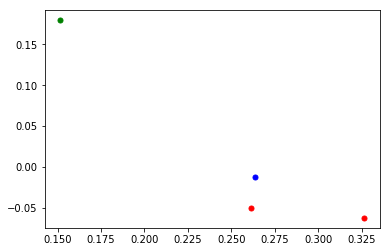

0
‰∏ãÊù•‰∏ãÊù•‰Ω†ÂñúÊ¨¢‰ªÄ‰πàÊ†∑ÁöÑÂ•≥Â≠©Âë¢, ‰Ω†ÂñúÊ¨¢‰ªÄ‰πàÊ†∑ÁöÑÂ•≥Â≠©
1
‰Ω†ÂñúÊ¨¢‰ªÄ‰πàÊ†∑ÁöÑÂ•≥Áîü
2
‰ªÄ‰πàÊ†∑ÁöÑÂ•≥Áîü‰Ω†ÊØîËæÉÂñúÊ¨¢
93.62162738604991


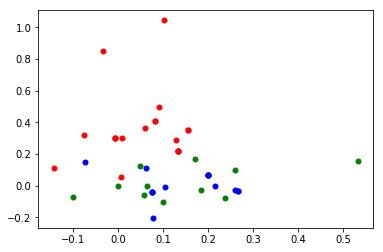

0
Â∞èÊù•ÊòØÁî∑ÊòØÂ•≥Ôºü ‰Ω†ÊòØÁî∑ÁöÑÂ•≥ÁöÑ? ‰Ω†ÊòØÁî∑ÁöÑÂ•≥ÁöÑ ‰Ω†ÊòØÁî∑ÊòØÂ•≥ ‰Ω†ÊòØÁî∑ÁöÑËøòÊòØÂ•≥ÁöÑ ‰Ω†ÊòØÁî∑Âä©ÁêÜËøòÊòØÂ•≥Âä©ÁêÜ ‰Ω†Áî∑ÁöÑÂ•≥ÁöÑ? ‰Ω†ÊòØÂ•≥ÁöÑ Âä©ÁêÜÊù•‰πü ‰Ω†ÊòØÁî∑ÁöÑÂ•≥ÁöÑ Â•≥ÁöÑ ‰Ω†ÊòØÂ•≥ÁöÑÂêó ‰Ω†ÊòØÁî∑ÁöÑÊòØÂ•≥ÁöÑ ‰Ω†ÊòØÁî∑ÁöÑÔºü ÈÇ£‰Ω†ÊòØÁî∑ÊòØÂ•≥ Â∞èÊù•‰Ω†ÊòØÁî∑ÊòØÂ•≥ ÈÇ£‰Ω†ÊòØÁî∑ÁöÑÂ•≥ÁöÑÔºü Â∞èÊù•ÊòØÁî∑ÊòØÂ•≥ ‰Ω†ÊòØÁî∑ÊòØÂ•≥Ôºü ÊàëÂ∏åÊúõ‰Ω†ÊòØÂ•≥ÁöÑ ÊàëÂ∏åÊúõÂ∞èÊù•ÊòØ‰∏™ÊöñÁî∑
1
‰Ω†ÊòØÂ•≥ÁîüËøòÊòØÁî∑Áîü? ‰Ω†ÊòØÁî∑ÁîüËøòÊòØÂ•≥ÁîüÔºü ‰Ω†ÊòØÁî∑ÁîüËøòÊòØÂ•≥Áîü ÊúâÂ•≥ÁîüÂêó ‰Ω†ÊòØÂ•≥Â≠©ËøòÊòØÁî∑Â≠© Â∞èÊù•,‰Ω†ÊòØÂ•≥ÁîüÂêó ‰Ω†ÊòØÁî∑Â≠©Â≠êËøòÊòØÂ•≥Â≠©Â≠ê ‰Ω†ÊòØÁî∑‰∫∫ËøòÊòØÂ•≥‰∫∫ ‰Ω†ÊòØÁî∑ÁîüÂêó ÊâÄ‰ª•‰Ω†ÊòØÁî∑ÁîüÂíØ ‰Ω†ÊòØÂ•≥ÁîüËøòÊòØÁî∑Áîü ‰Ω†ÊòØÁî∑Áîü? ‰Ω†ÊòØÂ•≥Áîü? ‰Ω†ÊòØÂ•≥ÁîüÂêó? ‰Ω†ÊòØÂ•≥ÁîüÂêó
2
‰Ω†ÊòØÁæéÂ•≥Âêó ‰Ω†ÊòØÂ∞èÂ¶πÂ¶πÂêóÔºü ÈÇ£‰Ω†Â∞±ÊòØÁî∑Â≠©‰∫Ü ‰Ω†ÊòØgirlËøòÊòØboy BaD    Girl       ÂùèÂ•≥Â≠© ‰Ω†ÊòØ‰∏çÊòØÂ∞èÁæéÂ•≥Âïä ‰Ω†ÊòØ‚ôÄÁöÑËøòÊòØ‚ôÇÁöÑ ‰Ω†Â∞ëÊù•‰Ω†ÊòØÁî∑Â≠©Â•≥Â≠© ‰Ω†ÊòØÂ•Ω‰∫∫Âêó ËØùËØ¥‰Ω†ÊòØ‰∏™Ê±âÂ≠êÂêó ‚Ä¶‚Ä¶ÊàëËøò‰ª•‰∏∫‰Ω†ÊòØÁúü‰∫∫Âë¢/::)

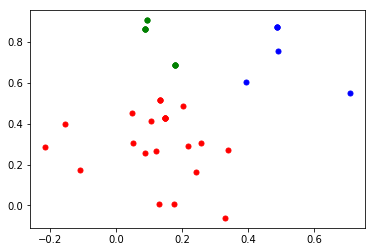

0
‰Ω†ÊòØÊú∫Âô®‰∫∫Â∞èÊù•Âêó Â∞èÊù•‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó Â∞èÊù•,ËôΩÁÑ∂‰Ω†ÊòØÊú∫Âô®‰∫∫ Â∞èÊù•‰Ω†ÊòØ‰∏çÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫ËøòÊòØÂï• ‰Ω†Â∞±ÊòØ‰∏™Êú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫‰πà ‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó/:,@P ÊòéÊòéÂ∞±ÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫ÂêóÔºü ‰Ω†‰∏çÊòØÊú∫Âô®‰∫∫‰πàÔºü Â∞èÊù•‰Ω†ÊòØÊú∫Âô®‰∫∫‰πà ‰Ω†ÊòØÊú∫Âô®Â∞èÊù•Âêó? ‰Ω†ÊòØÁ≥ªÁªü ‰Ω†Áé∞Âú®ÊòØÊú∫Âô®Âêß ‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó ‰Ω†ÊòØÊú∫Âô®‰∫∫? ‰Ω†ÊòØÊú∫Âô®‰∫∫ Â∞èÊù•,‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó ‰Ω†ÊòØAIÂ∞çÂêß ‰Ω†ÊòØ‰∏çÊòØÊú∫Âô®‰∫∫ ‰Ω†ÊòØAIÂêó ÊÄé‰πàÊàêÁ≤æ‰∫Ü Âøò‰∫Ü‰Ω†ÊòØÊú∫Âô®‰∫∫‰∫Ü
1
ÊòØÊú∫Âô®‰∫∫ËøòÊòØÁúü‰∫∫Ôºü ‰Ω†ÊòØÊú∫Âô®‰∫∫ËøòÊòØÁúü‰∫∫Ôºü Êú∫Âô®‰∫∫ËøòÊòØÁúü‰∫∫Ôºü Áúü‰∫∫ËøòÊòØÊú∫Âô®‰∫∫Ôºü Áúü‰∫∫ËøòÊòØÊú∫Âô®‰∫∫? ‰∏çÊòØ‰∫∫Â∑•?
2
Â∞èÊù•ÊòØÊú∫Âô®‰∫∫Ôºü Êú∫Âô®‰∫∫Â∞èÊù• Êú∫Âô®‰∫∫Â∞èÊù•? Â∞èÊù•Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Â∞èÊù•. Â∞èÊù•ÊòØÊú∫Âô®‰∫∫Âêó Â∞èÊù•ÊòØÊú∫Âô®‰∫∫Âêó? ÂéüÊù•Â∞èÊù•ÊòØÊú∫Âô®‰∫∫Âïä Êú∫Âô®‰∫∫Ôºü Êú∫Âô®‰∫∫?
928.1897318728542


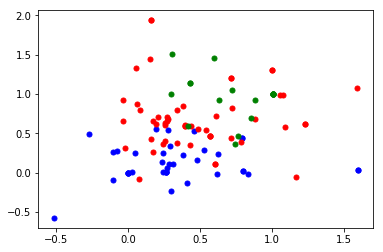

0
Â∞èÊù•ÊòØÁúü‰∫∫Ôºü ‰Ω†ÊòØÁúü‰∫∫ËøòÊòØÊú∫Âô®‰∫∫ Â∞èÊù•„ÄÇ‰Ω†ÊòØ‰∫∫Â∑•ÁöÑ‰πà ‰Ω†ÊòØ‰∫∫Â∑•ËøòÊòØÊô∫ËÉΩ? Ëá™Âä®ÂõûÂ§ç? ‰Ω†ÊòØÁúü‰∫∫Âêó? ÂàöÊâçËøôÊÆµÂØπËØùÊòØÊú∫Âô®Â§ÑÁêÜÁöÑËøòÊòØ‰∫∫Â∑•Â§ÑÁêÜÁöÑ ‰Ω†ÊòØÁúü‰∫∫Âêó ‰Ω†Áé∞Âú®ÊòØ‰∫∫Â∑•ËøòÊòØÊô∫ËÉΩÂõûÂ§çÂë¢ ‰Ω†ÊòØÁúü‰∫∫ Â∞èÊù•Áúü‰∫∫Âú®Âêó ÂëºÂè´Áúü‰∫∫Âä©ÁêÜ„ÄÇ Âä©ÁêÜÂë¢ Âä©ÁêÜ ÂëºÂè´Áúü‰∫∫Âä©ÁêÜ Âä©ÁêÜÂú®Âêó Âä©ÁêÜÂú®Âêó? ‰∫∫Âë¢? ËΩ¨‰∫∫Â∑• ÂëºÂè´Â∞èÊù• ÂëºÂè´ Â∞èÊù•Â∞èÊù• ‰∫∫Â∑•Âá∫Êù• ÊàëË¶ÅÁúü‰∫∫ Áî∑Âä©ÁêÜ Â•≥Âä©ÁêÜ Ë¶ÅÁúü‰∫∫ÁîµËØù ÊàëÁöÑÂä©ÁêÜÂõ¢Èòü‰∏çÂú®‰∫ÜÔºü ÊÄéÊ†∑ËÉΩÊâæÁúü‰∫∫Âä©ÁêÜ Êù•‰∏™Áúü‰∫∫Â§ÑÁêÜ Áúü‰∫∫Â∏Æ‰∏™ÂøôÂêß Â∞±‰∫∫Â∑•Âêß ÂëºÂè´Áúü‰∫∫Â∞èÊù• ÊàëË¶ÅËß£ÂÜ≥ÈóÆÈ¢òÁöÑÁúü‰∫∫ ÊàëÁöÑÂä©ÁêÜÂë¢? Áúü‰∫∫Âä©ÁêÜÂá∫Êù•Â∫îÁ≠î Áúü‰∫∫Â∞èÊù•ÂõûËØù Êúâ‰∫∫Â∑•Âêó? Â∞èÊù• ‰∫∫Â∑•ÊúçÂä° Ë¶ÅÁúü‰∫∫ÊúçÂä° Êúâ‰∫∫Â∑•‰πà Êúâ‰∫∫Â∑•Âú®Âêó ËΩ¨‰∫∫Â∑•‰∫ÜÂêó ‰Ω†‰ª¨Áé∞Âú®Ê≤°vip‰ΩÜÊòØÊúâÂÖ∂‰ªñÁöÑ‰∫∫Â∑•‰∏öÂä°Âêó ÊúâÁúü‰∫∫Âú®Âêó?‰∏çË¶ÅÊú∫Âô® ÂÆ¢ÊúçÂú®‰πà ‰∫∫Â∑•ÊúçÂä°ÊúâÊ≤°ÊúâÂëÄ Áúü‰∫∫ÈïøÂæóÂ•ΩÁúãÂêó Áúü‰∫∫‰ªÄ‰πàÊ†∑ Áúü‰∫∫ÈÉΩ‰ªÄ‰πàÊ†∑ÁöÑ Áúü‰∫∫Âä©ÁêÜÈïø‰ªÄ‰πàÊ†∑ Áúü‰∫∫Âä

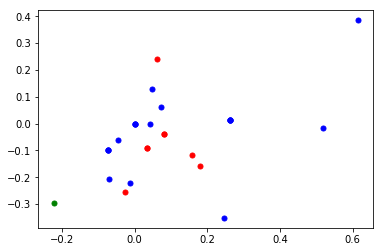

0
‰Ω†Âè´‰ªÄ‰πàÂêçÂ≠ó ‰Ω†Âè´‰ªÄ‰πàÂêçÂ≠ó? ‰Ω†ÊúâÂêçÂ≠óÂêó Âä©Êâã‰Ω†Âè´‰ªÄ‰πàÂêçÂ≠ó ‰Ω†Âè´Âï•Â≠êÂêçÂ≠óÂì¶ ‰Ω†Âè´Âï•Â≠êÂêçÂ≠óÂïä ÊàëÂ∫îËØ•Âè´‰Ω†‰ªÄ‰πàÂêçÂ≠ó ‰Ω†ÂêçÂ≠óÁöÑÂ∞èÂêçÊòØ‰ªÄ‰πà
1
‰Ω†Âè´‰ªÄ‰πàÔºü ‰Ω†Âè´‰ªÄ‰πà ‰Ω†Âè´‰ªÄ‰πà? ‰Ω†ÊòØË∞Å ‰Ω†ÊòØË∞ÅÂëÄ? ÈÇ£ÊàëÂè´‰Ω†‰ªÄ‰πà ‰Ω†ÊòØË∞Å? ÂßêÂßê,‰Ω†ÁöÑÁúüÂêçÊòØ‰ªÄ‰πàÂëÄ? ‰Ω†Â•Ω,‰Ω†Âè´‰ªÄ‰πà? ËØ∑ÈóÆ‰Ω†Ë¥µÂßì? ÊàëÊòØÂ∞èÂéª Âè´‰Ω†‰ªÄ‰πàÂ•ΩÂë¢? ‰Ω†Âè´Âï• ‰Ω†ÊòØÂì™‰∏™Âì¶ ‰Ω†Âè´Âï•Âïä Âøò‰∫ÜÈóÆ‰Ω†Âè´Âï• ‰Ω†Âè´Âï•ÂëÄ ÊàëÁöÑÊòµÁß∞Êîπ‰∏∫‰∏úÊàëÂèîÂèî ‰Ω†ÁöÑÂ§ßÂêçÂè´‰ªÄ‰πà?
2
ËøôÊòØ‰ªÄ‰πà
18.011315890038944


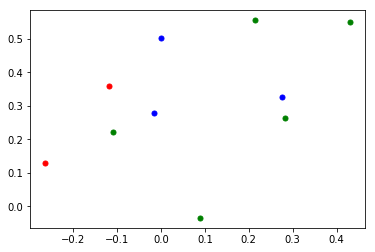

0
‰Ω†‰ª¨ÊòØÂ¶Ç‰ΩïÁõàÂà©ÁöÑÂë¢ ‰Ω†‰ª¨ÊÄé‰πàÁõàÂà©
1
‰Ω†‰ª¨Êå£Èí±Âêó ËøôÊ®°ÂºèÊÄé‰πàÊå£Èí±Ôºü ‰Ω†ÊÄé‰πàÊå£Èí±
2
ÁõàÂà©Ê®°ÂºèÊòØ‰ªÄ‰πà ÊúâÊ≤°ÊúâÊâìÁÆóËøõÂÖ•ÂÖ∂‰ªñ‰∫öÊ¥≤Â∏ÇÂú∫? ‰Ω†ËßâÂæóËøõÂÖ•ÂÖ∂‰ªñ‰∫öÊ¥≤Â∏ÇÂú∫ÊòØÊù•‰πüËÉΩÂÆûÁé∞ÁöÑÊú∫‰ºöÂêó Êù•‰πüÁé∞Âú®Â§öÂ§ßËßÑÊ®°‰∫Ü ÈÇ£‰Ω†‰ª¨Âá†Áôæ‰∏áÂÆ¢Êà∑ÊÄé‰πàÊúçÂä°ÁöÑ‰∫Ü
2.51311451584821


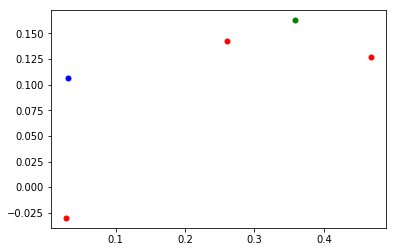

0
ËÆ§‰∏çËÆ§ËØÜÂ∞èÂ®ú ‰Ω†Ë∑üÂ∞èÂ®úÁÜü‰πàÔºü ‰Ω†Ë∑üÂ∞èÂ®úÁÜüÊÇâÂêó
1
Â∞èÂ®úÊòØË∞Å
2
Áü•ÈÅìÂ∞èÂ®úÂêó
5.570097420360411


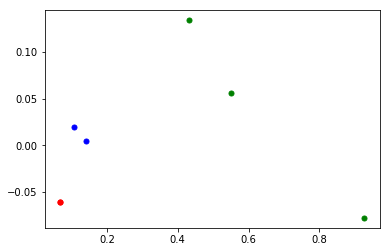

0
Â¶Ç‰ΩïÁΩÆÈ°∂Ôºü Â¶Ç‰ΩïÁΩÆÈ°∂?
1
ÊàëË¶ÅÁΩÆÈ°∂‰Ω†ÔºÅ Ëøô‰πàÊ£í,ËÇØÂÆöË¶ÅÊää‰Ω†ÁΩÆÈ°∂
2
ÊàëÊÉ≥ÁΩÆÈ°∂ ÊÄé‰πàÁΩÆÈ°∂ÂëÄÔºü ÁΩÆÈ°∂ÁΩÆÈ°∂
2.999643285206945


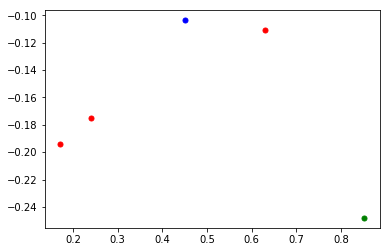

0
ÁΩÆÈ°∂Êúâ‰ªÄ‰πàÁî® ÁΩÆÈ°∂ÊúâÂï•Â•ΩÂ§Ñ ÁΩÆÈ°∂Êúâ‰ªÄ‰πàÂ•ΩÂ§Ñ
1
‰∏∫‰ªÄ‰πàË¶ÅÁΩÆÈ°∂
2
Âπ≤Âï•ÁΩÆÈ°∂Ôºü
621.9217549956721


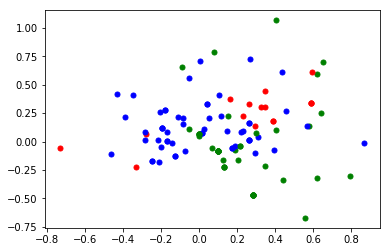

0
ÊâÄÊúâÁöÑÂäüËÉΩ ‰Ω†ËÉΩÊèê‰æõ‰ªÄ‰πàÊúçÂä°? ‰Ω†Êèê‰æõÂì™‰∫õÊúçÂä° ‰Ω†‰ºöÊèê‰æõÂì™‰∫õÊúçÂä°Âë¢ ËÉΩÊèê‰æõ‰ªÄ‰πàÊúçÂä° ÈÇ£ÊÇ®Êèê‰æõ‰ªÄ‰πàÊúçÂä°Âë¢ Â∞èÊù•ÂèØ‰ª•Êèê‰æõ‰ªÄ‰πàÊúçÂä° ÂèØ‰ª•Êèê‰æõÂì™‰∫õÊúçÂä° ÈÇ£Âì™‰∫õÊúçÂä°ÊúâÊèê‰æõ ËÉΩÊèê‰æõÊúçÂä°‰πà ‰Ω†‰ª¨ËÉΩÊèê‰æõÊúçÂä°Âêó ‰Ω†‰ª¨ËøòÊèê‰æõÊúçÂä°‰πà ÂäüËÉΩ ‰ΩÜÊòØ‰Ω†‰ª¨ÂèàÂï•ÊúçÂä°Âë¢ ÊàëÈúÄË¶ÅÁßò‰π¶ÊúçÂä°‰Ω†ËÉΩÊèê‰æõÂêó Êúâ‰ªÄ‰πàÂäüËÉΩ
1
‰Ω†ËÉΩÂπ≤Âï• ‰Ω†ÈÉΩÊúâ‰ªÄ‰πàÂäüËÉΩ ‰Ω†‰ºöÂÅö‰ªÄ‰πà ‰Ω†ËÉΩÂÅö‰ªÄ‰πà? ‰Ω†ËÉΩÂÅö‰∫õÂï•Âë¢ ‰Ω†ËøòÊúâ‰ªÄ‰πàÂäüËÉΩ ‰Ω†ËøòÊúâ‰ªÄ‰πàÂäüËÉΩ? ‰Ω†ËøòÊúâ‰ªÄ‰πàÊñ∞ÁöÑÂäüËÉΩÂëÄ? ‰Ω†ËÉΩÂÅö‰ªÄ‰πà Â∞èÊù•ÂèØ‰ª•ÂÅö‰ªÄ‰πàÂë¢ ‰Ω†‰ºö‰ªÄ‰πà ‰Ω†ËÉΩÂÅöÂï• ‰Ω†ËÉΩÂÅö‰∫õÂï• ‰ªãÁªç‰ªãÁªç‰Ω†ËøòËÉΩÂÅö‰ªÄ‰πà Â∞èÊù•Ôºå‰Ω†ËÉΩÂÅöÂï• ‰∫≤Áà±ÁöÑÔºåËøô‰∏™Âπ≥Âè∞ÂÅö‰ªÄ‰πàÂêó ‰Ω†ÊòØË∞Å ËøôÊòØÂÅö‰ªÄ‰πàÁöÑ Â∞èÊù•ÂèØ‰ª•ÂÅö‰ªÄ‰πà ‰Ω†‰ª¨ÂÅö‰ªÄ‰πà ‰Ω†Êúâ‰ªÄ‰πàÁî® ‰Ω†ÈÉΩ‰ºö‰ªÄ‰πà? ‰Ω†ÂèØ‰ª•Â∏ÆÂä©Êàë‰ªÄ‰πà ÊàëË¶Å‰Ω†Êúâ‰ΩïÁî® ‰Ω†ÈÉΩ‰ºöÂπ≤‰∫õ‰ªÄ‰πàÂëÄ? ‰Ω†‰ºöÂÅö‰∫õ‰ªÄ‰πàÂë¢Ôºü ‰Ω†ËÉΩ‰∏∫ÊàëÂÅö‰ªÄ‰πà? ‰Ω†ÈÉΩ‰ºö‰ªÄ‰πàÊäÄËÉΩ ‰Ω†ÈÉΩÂèØ‰ª•Â∏ÆÁùÄÂÅö‰ªÄ‰πà? Áé∞Âú®Ë¶ÅÂ

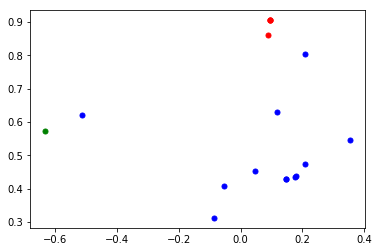

0
Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Êú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Â∞±ÊòØÊú∫Âô®‰∫∫ Êú∫Âô®‰∫∫Â∞èÊù•
1
ÊúâÊú∫Âô®‰∫∫Âêó ÊàëË¶ÅÊú∫Âô®‰∫∫ ÊàëÊòØÊú∫Âô®‰∫∫ ËøòÊòØÊú∫Âô®‰∫∫ Êú∫Âô®‰∫∫ÊúâÊ≤°Êúâ ÊàëÊÉ≥Ë¶ÅÊú∫Âô®‰∫∫ ‰Ω†ÊòØÁî∑Êú∫Âô®‰∫∫ËøòÊòØÂ•≥Êú∫Âô®‰∫∫ËøòÊòØÂèòÊÄßÊú∫Âô®‰∫∫ ‰Ω†ÊòØÊú∫Âô®‰∫∫Âïä ‰Ω†ÊòØÊú∫Âô®‰∫∫Âêó Á¨®Á¨®Êú∫Âô®‰∫∫ ÊÄé‰πàÂèòÊàêÊú∫Âô®‰∫∫‰∫Ü Êú∫Âô®‰∫∫‰Ω†Â•Ω
2
Êú∫Âô®
2.3534502646018924


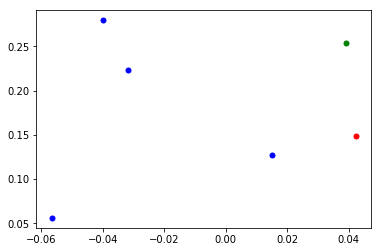

0
Â∞èÊù•‰Ω†ÊúâÂ•≥ÊúãÂèãÂêó?
1
‰Ω†ÊúâÁî∑ÊúãÂèãÂêó ‰Ω†ÊúâÁî∑ÊúãÂèãÊàñËÄÖÂ•≥ÊúãÂèãÂêó ‰Ω†ÊúâÁî∑ÊúãÂèãÊàñËÄÖÂ•≥ÊúãÂèãÊ≤°Êúâ ÊúâÂ•≥ÊúãÂèãÊàñËÄÖÁî∑ÊúãÂèãÂêó?
2
‰Ω†ÊúâÊ≤°ÊúâÁî∑ÊúãÂèãÂëÄ?ÊàñËÄÖÊòØÂ•≥ÊúãÂèã‰Ω†ÊòØÁî∑ÁöÑËøòÊòØÂ•≥ÁöÑÂëÄ?
222.87230643398172


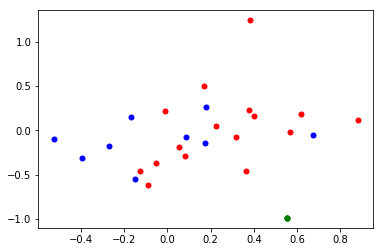

0
Ë¶ÅÈí±Âêó Ëä±Èí±Âêó? ËÆ¢ÈòÖÊòüÂ∫ßÊî∂Ë¥πÂêó ËÆ¢ÈòÖÊàñÊúçÂä°‰ªÄ‰πàÁöÑÊî∂Ë¥πÊòØÂ§öÂ∞ë? ËØ∑ÈóÆËÆ¢ÈòÖÈÉΩÊòØÂÖçË¥πÁöÑÂêó ËØ∑ÈóÆËÆ¢ÈòÖ‰ªòË¥πÂêó Áî®Ëøô‰∏™ËΩØ‰ª∂Ë¶Å‰∏çË¶ÅÈí± Ë¶ÅÊî∂ÊúçÂä°Ë¥πÂêó ‰Ω†ÊòØÂÖçË¥πÁöÑ‰πà ÊòüÂ∫ßËøêÂäøÊòØÂÖçË¥πÁöÑÂêó ÈÄâÊòüÂ∫ßÊµãËøêÂäøÂÖçË¥πÂêó Ëé∑ÂèñÂøÉËØ≠Á≠æÊî∂Ë¥πÂêó Â∞èÊù•ÊâìÁîµËØùË¶Å‰∏çË¶ÅÈí± ‰Ω†ÁöÑÊâìÂç°Ê∏∏ÊàèÂÖçË¥πÂêó ÂÖ≥Ê≥®Ëøô‰∏™ÂÖ¨‰ºóÂè∑Âπ≥Âè∞Êî∂Ë¥πÂêó? Â∞èÊù•‰Ω†Â•Ω,ËÆ¢ÈòÖÂøÉËØ≠Á≠æÊî∂Ë¥πÂêó?
1
ÊÄé‰πàÊî∂Ë¥π Êî∂Ë¥πÂêó? Ë¶ÅÊî∂Ë¥πÂêó ‰Ω†Ëøô‰∏™ÊúçÂä°Êî∂Ë¥πÂêó? ÊúâË¥πÁî®Âêó ‰Ω†Â•Ω!‰Ω†‰ª¨ËøôÊî∂Ë¥πÂêó? Êàê‰∏∫vipÊî∂Ë¥πÂêó ÈúÄË¶ÅË¥πÁî®Âêó Â¶Ç‰ΩïÊî∂Ë¥π
2
ËøôÊòØÂÖçË¥πÁöÑÂêó ÂÖçË¥πÂêó? ÂÖçË¥πÁöÑ‰πà
69.25932246183736


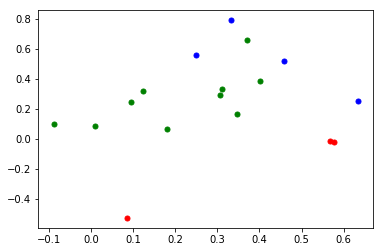

0
Ëøô‰∏™ÊòüÂ∫ßÊòØ‰∏çÊòØÂÖçË¥πÁöÑÔºü ÂÖçË¥πËÆ¢ÈòÖÂêó? ËÆ¢ÈòÖÊòØÂÖçË¥πÁöÑÂêó
1
ÊÉ≥ËØïËØïÊØèÂ§©ÊâìÂç°ÔºåÊî∂Ë¥πÂêó? ÁîµËØùÊèêÈÜíÊî∂Ë¥πÂêó? Âä©ÁêÜÊù•‰πü'ÊâìÂç°Êî∂Ë¥πÂêó ÊâìÂç°Ë¶ÅÈí±Âêó
2
ËÆ¢ÈòÖË¶ÅÈí±ÁöÑÂêó ËÆ¢ÈòÖË¶ÅÊî∂Ë¥πÂêó ËÆ¢ÈòÖ‰∏úË•øÊî∂Ë¥πÂêó ËÆ¢ÈòÖË¶Å‰∏çË¶ÅÊî∂Ë¥πÁöÑ? ËÆ¢ÈòÖÊúâË¥πÁî®Âêó ÈÇ£‰Ω†ËÉΩÊü•ËØ¢Âà∞ ÊàëÊúâÊ≤°ÊúâËÆ¢ÈòÖÊî∂Ë¥πÁöÑÈ°πÁõÆ ËÆ¢ÈòÖËä±Èí±Âêó ËÆ¢ÈòÖÊéèÈí±Âêó ËÆ¢ÈòÖÊòüÂ∫ßÊî∂Ë¥π‰∏ç ËÆ¢ÈòÖ‰∏úË•ø‰∏çÊî∂Ë¥πÂêß
46.317320372869816


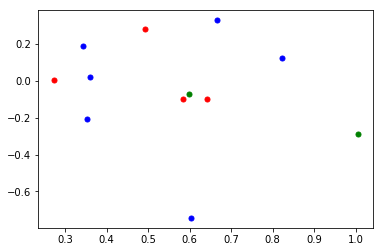

0
Á≠æÂà∞Êúâ‰ªÄ‰πàÁî®Ôºü Á≠æÂà∞ÊòØ‰ªÄ‰πàÔºü ‰ªÄ‰πàÊòØËá™Âä®Á≠æÂà∞Ôºü ÂÖ≥‰∫éËá™Âä®Á≠æÂà∞
1
ÊàëÊÄé‰πàËÉΩÊî∂Âà∞ÈÇ£‰∏™‰∏ÄÂè•ËØùÁöÑÂõæ ÊÄé‰πàÊâçËÉΩÊî∂Âà∞Á≠æÂà∞ÂõæÂõæ ÊÄé‰πàËÉΩÊØèÂ§©Êî∂Âà∞ÂøÉËØ≠Á≠æ Á≤æÁæéÂõæ Êó©ÂÆâËØ≠Âú®Âì™ÁúãÂë¢ ‰∏∫‰ªÄ‰πàÂøÉËØ≠Á≠æÂèñÊ∂à‰∫ÜÂë¢?
2
ÊÄé‰πàÊó©Ëµ∑Á≠æÂà∞ Êó©Ëµ∑Á≠æÂà∞
202.7657882812997


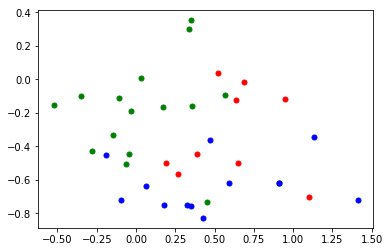

0
Êó©ÂÆâËØ≠ ÊÉ≥Ë¶Å‰∏™Ê≠£ËÉΩÈáèÊó©ÂÆâËØ≠ ÊàëÈúÄË¶ÅÊó©ÂÆâËØ≠ ÂõæÁâáÊó©ÂÆâÁöÑ ÊàëÊÉ≥Ë¶ÅÊØèÂ§©Êó©ÂÆâËØ≠ ÊàëÊÉ≥Ë¶ÅÈÇ£‰∫õÂä±ÂøóÁöÑÊó©ÂÆâÈóÆÂÄôËØ≠ Êó©ÂÆâÊúãÂèãÂúàÊ≠£ËÉΩÈáèÂè•Â≠ê ÊúâÊ≤°ÊúâÊó©ÂÆâÁöÑÁÖßÁâá ÊàëÊÉ≥Ë¶ÅÊó©ÂÆâÁ•ùÁ¶èËØ¥
1
Á≠æÂà∞Âõæ Á≠æÂà∞ÂõæÁâá Á≠æÂà∞‰∫ÜÊÄé‰πàÊ≤°ÊúâÂõæÁâáÂë¢? Êúâ‰ªÄ‰πàÂõæÁâá Áªô‰∏ÄÂº†Âõæ Â•ΩÁúãÁöÑÂõæÁâá ËøòÊúâ‰∏ÄÂº†ÂõæÂë¢ Â∏¶ÊñáÂ≠óÂõæÁâá Â•ΩÁúãÁöÑÂõæÁâáÊúâÊú®Êúâ Á≠æÂà∞ÂõæÁâáÂë¢? ÁªôÊàëÊâæ‰∏ÄÂº†Â•ΩÁúãÂõæÁâá ÊØèÂ§©‰∏ÄÂº†Âõæ Âä±ÂøóÂõæ
2
ÊàëË¶Å‰∏ÄÂº†ÊöñÂøÉÁöÑÂõæÁâá„ÄÇ ÁæéÂõæ ‰∏çÊñ∞È≤ú‚Ä¶‚Ä¶ÂéüÂõæ ÂõæÂç° Â∞èÊù•,ËØ∑ÈóÆ‰∏Ä‰∏ãÊØèÂ§©Âè™ËÉΩ‰∏Ä‰∏™ÂõæÁâáÂêó ÁªôÊàë‰∏ÄÂº†ÁÉ≠Áà±ÁîüÊ¥ª ÁÉ≠Áà±Â∑•‰ΩúÁöÑÂõæÁâá ÁªôÊàë‰∏ÄÂº†Êó©‰∏äÂ•ΩÁöÑÂõæÁâá ÊØèÊó•‰∏ÄËØ≠ÊÄé‰πàÊ≤°Êúâ‰∫Ü ÊàëÊÄé‰πàÊ≤°ÊúâÊØèÊó•‰∏ÄËØ≠‰∫ÜÂë¢? ÁªôÊàë‰∏ÄÂº†ÂøÉËØ≠‰æøÁ≠æ ÊàëÊÉ≥Ë¶ÅËøôÁßçÂç°Áâá/:rose ÊàëË¶ÅÁúãÁæéÂõæ ÊàëË¶ÅÁæéÂõæ ‰ªéÂèë‰∏ÄÂº†ÂõæÁâáËøáÊù• ÊØè‰∏ÄÊ¨°Ê≠£ËÉΩÈáèÂè•Â≠ê
812.2206196619618


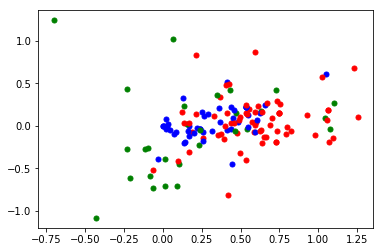

0
ÊØèÂ§©‰∏ÄÂº†ÂøÉËØ≠Á≠æ ÂøÉÊÉÖÁ≠æ ÂøÉËØ≠ÁØá ÂøÉËØ≠ ÂøÉËØ≠Âç° ÊÄéÊ†∑ÊâçËÉΩÊãøÂà∞ÂøÉËØ≠Á≠æ? ÂøÉËØ≠Á≠æ ËØ∑ÈóÆÂøÉËØ≠Á≠æÊÄé‰πàÂºÑ? ËøòÊúâ‰∏ç‰∏ÄÊ†∑ÁöÑÂøÉËØ≠Á≠æÂêó Êó©ÂÆâÁ≠æ ÂøÉÊÑøÁ≠æ ÂøÉËØ≠Ê†áÁ≠æ xÂøÉËØ≠Á≠æ ÊÉ≥Êç¢‰∏Ä‰∏™ÂøÉËØ≠Á≠æ ËÉΩ‰∏çËÉΩÁõ¥Êé•ÂèëÂøÉËØ≠Á≠æÁöÑÂ≠óÂë¢ ÊÄé‰πàÊ≤°ÊúâÂøÉËØ≠Ê†áÁ≠æ‰∫Ü ÂøÉËØ≠Á≠æÂà∞ ÂøÉËØ≠Á≠æËé∑Âèñ Êç¢‰∏™ÂøÉËØ≠Á≠æ ÂøÉËØ≠Á≠æËé∑ÂèñÂô¢ ÂøÉËØ≠ÂøÉÊÑø ÊÄéÊ†∑Ëé∑ÂæóÂøÉËØ≠Á≠æ Ë•ø„ÄÇÂøÉËØ≠Á≠æ ÂøÉËØ≠Ëé∑Âèñ Á≠æÂà∞ÁöÑÂøÉËØ≠Âç°Âë¢ ÊÄé‰πàÊ≤°ÂèëÊØèÊó•ÂøÉËØ≠/::~ ÊúâÊ≤°ÊúâÂøÉËØ≠Âç° ËøôÊòØ‰∏™Á•ûÈ©¨ÂøÉËØ≠Á≠æ/::|/::|/:: |ÊàëÁöÑÂøÉËØ≠Á≠æÂë¢ ÂøÉËØ≠Á≠æ0 ÂèØ‰∏çÂèØ‰ª•ÁªôÊàëÂèë‰∏™ÂøÉËØ≠Á≠æ Â¶Ç‰ΩïËÆ¢ÈòÖÊù•‰πüÂä±ÂøóÁ≠æ Ëä≥ÂçéÂøÉËØ≠Á≠æ Áà±ÊÉÖÂøÉËØ≠Á≠æ ÂøÉËØ≠Á≠æÊÄé‰πàÁÇπÂá∫Êù•ÂëÄ ÊàëÊàëÊÉ≥ÂÆöÊØèÊó•‰∏ÄÂº†ÂøÉËØ≠Á≠æ ÊØèÊó•‰∏ÄÂº†ÂøÉËØ≠Á≠æÊÄé‰πàÂºÑÂëÄ ÂøÉËØ≠Á≠æÂõæÁâá Ê≤°Êî∂Âà∞ÂøÉËØ≠Á≠æ ‰∏ÄÂè•ÂøÉËØ≠Á≠æÂë¢ ÂøÉËØ≠ËßÅÊÄé‰πà‰∏çËßÅ‰∫Ü ÂøÉËØ≠‰π¶Á≠æ Âä©ÁêÜÊù•‰πüÊàëË¶ÅÂøÉËØ≠Á≠æ ÊàëË¶ÅËÆ¢ÈòÖÂøÉËØ≠Á≠æ ÂõûÂ§çÂøÉËØ≠Á≠æ Ë¶ÅÂøÉËØ≠Âç° ÂøÉËØ≠Ââç ÊØèÊó•ÂøÉÊÉÖÁ≠æ ÊâìÂç°ÂøÉËØ≠Á≠æ ÊàëË¶ÅÂà∂‰Ωú‰∏ÄÂº†ÂøÉËØ≠Á≠æ ÂøÉËØ≠Á≠æÂ§™ÊÖ¢‰

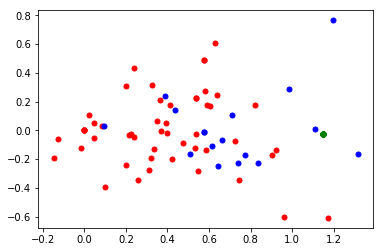

0
Êó•Á≠æ Êó©ÂÆâËØ≠ÂΩï ÊàëÂºÄ‰∫ÜÂÆö‰Ωç‰∏∫Âï•Á≠æ‰∏ç‰∫Ü? ÊØèÊó•‰∏ÄËØ≠ ËØ¥ÂæóÂ•Ω,Êó©ÂÆâ Èâ¥Âà∞ Êó©ËØ≠ Êó©ÂÆâÂøÉËØ≠ ÊØèÊó•‰∏ÄÂõæ ‰ªäÂ§©Á≠æ‰∏ç‰∫ÜÂà∞ Á≠æÂà© ÂøÉÁÅµÈ∏°Ê±§ ÂøÉËØ≠ ÊØèÊó•‰∏ÄÂõæÂú®Âì™ Ê†áËØ≠Á≠æ ÂøÉËØ≠ÂÆ£ Ê≤°Êî∂Âà∞Á≠æÊî∂Âõæ/::< ÂøÉËØùÁ≠æ ÂøÉËØ≠Èâ¥ ÂøÉËØ≠Áâµ ÂøÉËØ≠Ê¨† ÂøÉÁ≠æËØ≠ Êñ∞ËØ≠Á≠æ ÊòüËØ≠Á≠æ Êó©ÂÆâÊñáÂ≠ó ÂøÉÂÆáÁ≠æ ÂèñÊ∂àÂøÉÊÉÖÂøÉËØ≠ ÂøÖËØ≠Á≠æ ÊÄéÊ†∑ÂèØ‰ª•Ëé∑ÂæóÊó•Á≠æ ÂøÉËØ≠ÁØÆ ÊàëÈúÄË¶Å‰∏ÄÂè•ÁªèÂÖ∏ÁöÑÊó©ÂÆâËØ≠ÂΩï„ÄÇ Êñ∞ËØ≠ Á≠æ Âà∞ ÂèàÁ≠æ‰∏ç‰∫ÜÂà∞ ÁâµÂà∞ ÂøÉËØ≠Á≠å ÂøÉËØ≠ÂΩï Âπ∏ËøêÁ≠æ ÂøÉËØ≠Âõæ ÂøÉËØ≠Á≠î ÂøÉËØ≠Âúà ÊØèÊó•‰∏ÄËØ≠Âà∞Âì™Âéª‰∫Ü? „ÄêÊó©ÂÆâÈ¶®ËØ≠ ÊØèÊó•‰∏ÄËØ≠Âë¢ Èâ¥Á≠æÂà∞ ‰∏® Á≠æÂà∞ ÊÄé‰πàÂèëÊó©ÂÆâÂøÉËØ≠ ÂøÉËØ≠Èâ¥ÂõæÁâá Á∞ΩÂà∞ ÂøÉËØ≠Ë¥¥ Êàë‰ªñÂ¶àÂèàÁ≠æ‰∏ç‰∫ÜÂà∞‰∫Ü
1
Á≠æÂà∞, ÊÄé‰πàÁ≠æÂà∞ Á≠æÂà∞Â§±Ë¥• Ëµ∑Êó©Á≠æÂà∞? Â¶Ç‰ΩïËÉΩÊî∂Âà∞ÊØèÂ§©Á≠æÂà∞ÁöÑÂõæÁâáÂä†ÊñáÂ≠ó? ËØ∑Êù•Â∏ÆÊàëÁ≠æÂà∞ lÁ≠æÂà∞ Á≠æÂà∞Êó©ÂÆâ ÊÄéÊ†∑Á¥ØÁßØÁ≠æÂà∞ Á≠æÂà∞Ëé∑Âèñ‰∏çÂá∫Êù•Âë¢ ÂøÉÁ≠æÂà∞ Êó©È§êÁ≠æÂà∞ ÊØèÊó•Á≠æÂà∞ËØ≠ ''Á≠æÂà∞''ÂÆåÊàê Ëá™Âä©Á≠æÂà∞ Âú®Âì™Á≠æÂà∞ IÁ≠æÂà∞
2
Á≠æÂà∞„ÄÇ Á≠æÂà∞. Á≠æÂà∞! Á≠æÂà∞ Á≠æÂà

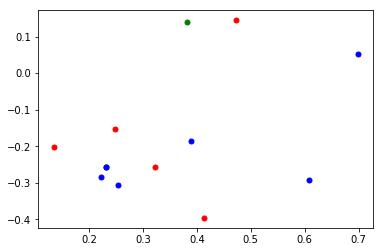

0
ÁÇπÂáªËØ¶ÊÉÖÁ≠æÂà∞Êé®Á∫¢ÂåÖ Êé®Âπø‰∫ÜÁ≠æÂà∞Ê≤°ÊúâÁ∫¢ÂåÖ Á≠æÂà∞ÊàêÂäüÊ≤°ÊúâÁªôÁ∫¢ÂåÖ ‰∏∫‰ªÄ‰πàÊàëÁ≠æÂà∞‰∫ÜÊ≤°Á∫¢ÂåÖ Á≠æÂà∞Ê≤°ÊúâÁ∫¢ÂåÖÁªôÂêó?
1
Á≠æÂà∞Á∫¢ÂåÖ Á≠æÂà∞È¢ÜÂèñÁ∫¢ÂåÖ Á≠æÂà∞ÂêéÁ∫¢ÂåÖÂë¢ Ê≤°Á≠æÂà∞Á∫¢ÂåÖ Á≠æÂà∞È¢ÜÁ∫¢ÂåÖ Á≠æÂà∞ÁöÑÁ∫¢ÂåÖÂë¢? Á≠æÂà∞Á∫¢ÂåÖÊúâÂêó?
2
ÊâìÂç°ÂêéÊä¢Á∫¢ÂåÖ
3.149225210983377


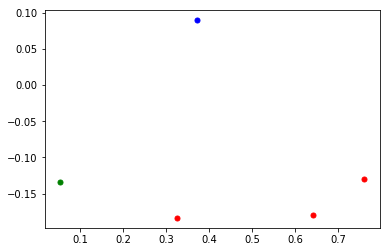

0
‰∏∫‰ªÄ‰πàÂèàÊ≤°ÊúâÊòæÁ§∫Ëá™Âä®Á≠æÂà∞‰∫åÁª¥Á†Å‰∫Ü Ê≤°ÊúâËá™Âä®Á≠æÂà∞‰∫åÁª¥Á†Å Ëá™Âä®Á≠æÂà∞‰∫ÜÊ≤°ÊúâÊòæÁ§∫
1
Ëá™Âä®Á≠æÂà∞
2
‰∏çËÉΩËá™Âä®Á≠æÂà∞
0.0


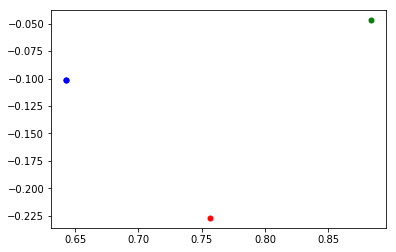

0
Âπ≤ÂòõÈùûÁ≠æÂà∞?‰∏çÁ≠æÂà∞‰∏ç‰ª£Ë°®Áî®‰∏çÁî®Âêß„ÄÇ
1
Á≠æÂà∞Êúâ‰ªÄ‰πàÁî® Á≠æÂà∞Ëøô‰∏™Êúâ‰ªÄ‰πàÁî®
2
Á≠æÂà∞ÊúâÂï•Áî®ÂïäÔºü
76.5710611128558


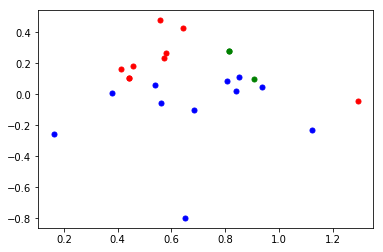

0
Á≠æÂà∞ÊâìÂç°Âå∫Âà´ ÊâìÂç°ÂíåÁ≠æÂà∞ÁöÑÂå∫Âà´ Á≠æÂà∞ÂíåÊâìÂç°‰ªÄ‰πàÂå∫Âà´ Á≠æÂà∞‰∏éÊâìÂç°Êúâ‰ªÄ‰πàÂå∫Âà´ Á≠æÂà∞ÂíåÊâìÂç°ÁöÑÂå∫Âà´ÊòØ Á≠æÂà∞ÂíåÊâìÂç°Êúâ‰ªÄ‰πàÂå∫Âà´Âë¢ ÊâìÂç°ÂíåÁ≠æÂà∞Êúâ‰ªÄ‰πàÂå∫Âà´ Á≠æÂà∞‰ªãÁªç Ê≤°ÊòéÁôΩÁ≠æÂà∞‰∏éÊâìÂç°ÁöÑÂå∫Âà´?
1
‰∏∫‰ªÄ‰πàÊàëÂë®‰∫îÊúâÊâìÂç°,‰ΩÜÊòØÊ≤°ÊòæÁ§∫Á≠æÂà∞Âë¢? ÊâìÂç°ÂíåÁ≠æÂà∞‰∏çÊòØ‰∏ÄÊ†∑ÁöÑÂêóÔºü ÊàëÁ≠æÂà∞‰∫Ü‰∏∫‰ªÄ‰πàÊâìÂç°ËÆ∞ÂΩïÊ≤°Êúâ ÊâìÂç°ÂíåÁ≠æÂà∞ÊòØ‰∏ÄÊ†∑ÁöÑÂêó ‰∏∫‰ªÄ‰πàÊàëÊØèÂ§©Êó©‰∏äÂè™ËÉΩÊî∂Âà∞‰∏ÄÂº†ÂõæÂë¢,‰ª•ÂâçÊòØ‰∏§Âº†,Èô§‰∫ÜÊâìÂç°ÁöÑ,Âè¶Â§ñËøòÊúâ‰∏ÄÂº†ÂëÄ ÊâìÂç°ÂÆå‰∫Ü ËøòÂæóÁ≠æÂà∞Âïä ‰∏çÊòØÊúâ‰∏§‰∏™ÂõæÁâáÁöÑÂêó ‰∏∫‰ªÄ‰πàÊâìÂç°Á≠æÂà∞Ê≤°ÂøÉËØ≠ÂíåÂõæÁâá‰∫Ü ‰∏∫‰ªÄ‰πàÊàëÊâçÁ≠æÂà∞2Â§© ÊâìÂç°‰∫Ü‰πãÂêéÂ∞±‰∏çÁî®Á≠æÂà∞‰∫Ü ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÁ≠æÂà∞Âç°
2
Á≠æÂà∞‰∏çÊòØÊâìÂç°ÂêóÔºü ÊâìÂç°Á≠æÂà∞ Á≠æÂà∞ÊâìÂç°
5.28474763808717


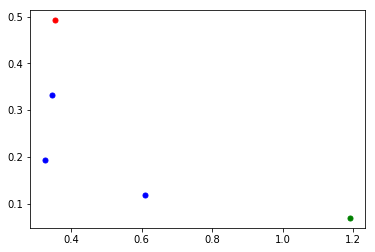

0
ÊÄé‰πàÂèñÊ∂àÊâìÂç°
1
ÂèñÊ∂àËá™Âä®Á≠æÂà∞ Ëá™Âä®ÂèñÊ∂à ÂèñÊ∂àËá™Âä®ÊâìÂç°
2
ÂèñÊ∂àÁ≠æÂà∞
101.62923361101404


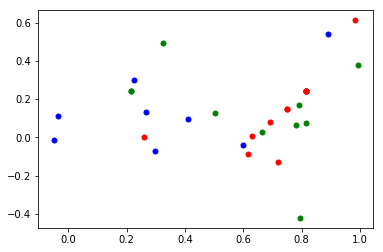

0
ÊäïËØâÂè∏Êú∫ Â∏ÆÊàëÊäïËØâÂè∏Êú∫ ÊäïËØâËøô‰∏™Âè∏Êú∫ Â∏ÆÊàëÊäïËØâËøô‰∏™Âè∏Êú∫ ÊäïËØâÂàöÊâçÁöÑÂè∏Êú∫ ÊäïËØâÂè∏Êú∫ÁªïË∑Ø ÊäïËØâÂè∏Êú∫! ÊäïËØâÂè∏Êú∫Êé• ÊäïËØâËøôÂè∏Êú∫ ÊäïËØâÈÇ£‰∏™Âè∏Êú∫ ÊäïËØâ‰πãÂâçÈÇ£‰∏™Âè∏Êú∫ ÂΩìÊó∂ÊòØÊäïËØâÂè∏Êú∫ÁªïË∑Ø ÊòØÂè∏Êú∫ÁöÑÈóÆÈ¢ò
1
‰∏ÄÂÆöË¶ÅÊäïËØâÔºåÊàëËµ∂ÁÅ´ËΩ¶ÂïäÂïäÂïäÂïäÂïä ÊÄÅÂ∫¶ÊÅ∂Âä£ Âè∏Êú∫ÊÄÅÂ∫¶ÈÇ£‰πàÊÅ∂Ëôê ÈÉΩË∑ëÂà∞ÂÖ¨‰∫§ËΩ¶Á´ô‰∫Ü ÂÇªÈÄºÂè∏Êú∫ ÊäïËØâ Ë∑Ø‰∏çËÆ§ËØÜ ‰π±ÂºÄ ÊàëÊòØÊù•ÂèçÊò†ÈóÆÈ¢òÁöÑ ‰∏çÊòØÊù•Ë¶ÅËµîÂÅøÁöÑ Âè∏Êú∫ÁªïË∑Ø‰∫Ü È∫ªÁÉ¶Êü•‰∏Ä‰∏ã ÂàöÊâçÁöÑÂ∏àÂÇÖÊÄÅÂ∫¶ÂÆûÂú®Â§™ÊÅ∂Âä£‰∫Ü
2
ÊäïËØâ‰ªñ ÊäïËØâ‰∏ä‰∏Ä‰∏™Âè∏Êú∫ ËØ∑ÊäïËØâtimeÂè∏Êú∫ ÊàëË¶ÅÊäïËØâËøô‰∏™Âè∏Êú∫ ÊäïËØâ‰∏ä‰∏Ä‰ΩçÂè∏Êú∫ ÊàëË¶ÅÊäïËØâÂè∏Êú∫ ÊäïËØâÁ¨¨‰∏Ä‰∏™Âè∏Êú∫ ÊàëË¶ÅÊäïËØâ Â∏ÆÊàëÊäïËØâ‰∏Ä‰∏ãÂ∞±Â•Ω ÊäïËØâÂàöÊâçÁöÑËΩ¶
259.3896483589706


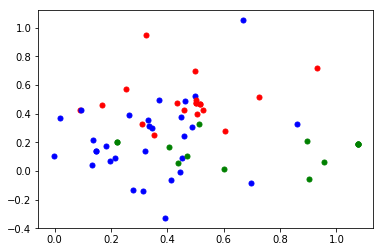

0
ÈÇ£ÊàëÂ∞±ÂèñÊ∂àÂÖ≥Ê≥®‰∫Ü ‰∏çÂÜçÂÖ≥Ê≥®‰∫Ü ÂèØ‰ª•‰∏çË¶ÅÂÖ≥Ê≥®Âêó? ÂèñÊ∂àÂÖ≥Ê≥® ÊàëÈúÄË¶ÅÂèñÊ∂àÂÖ≥Ê≥® ÊÄé‰πàÂèñÊ∂àÂÖ≥Ê≥® ‰∏çÂÖ≥Ê≥®‰Ω†‰ª¨‰∫Ü ‰∏çÂÜçÂÖ≥Ê≥® ÊàëË¶ÅÂèñÊ∂àÂÖ≥Ê≥® Êàë‰∏çÂÖ≥Ê≥®‰Ω†‰∫Ü ÊàëÂ∞±ÊÉ≥Áü•ÈÅìÊÄé‰πàÂèñÊ∂àÂÖ≥Ê≥® ÊòéÂ§©ÂÜçËøôÊ†∑ÊàëÂ∞±ÂèñÊ∂àÂÖ≥Ê≥® ÂèñÊ∂àËÆ©‰ªñÂÖ≥Ê≥® Â¶Ç‰ΩïÂèñÊ∂àÂÖ≥Ê≥® ÂèçÊ≠£ÊàëË¶ÅÂèñÊ∂àÂÖ≥Ê≥® ÁúãÊù•Ë¶ÅÂèñÊ∂àÂÖ≥Ê≥®‰Ω†‰ª¨‰∫Ü Â∞èÂøÉÊàëÂèñÊ∂àÂÖ≥Ê≥®‰∫Ü‰Ω†‰ª¨Ëøô‰∏™ÂÖ¨‰ºóÂπ≥Âè∞‰∫Ü ÂèØ‰ª•‰∏çÂÖ≥Ê≥®‰∫ÜÂêß ÂÜçËßÅ„ÄÇÂèñÊ∂àÂÖ≥Ê≥®„ÄÇÊàëÂ∑≤ÁªèÂÜ≥ÂÆö‰∫Ü/::)
1
ÊàëË¶ÅÂèñÂÖ≥‰Ω† ÊàëË¶ÅÂáÜÂ§áÂèñÂÖ≥‰∫Ü ÊàëË¶ÅÂèñÂÖ≥‰Ω†‰∫Ü ‰Ω†Â§™ÁÉ¶‰∫Ü,ÂèëÁöÑ‰∏úË•øÂ§™Â§ö‰∫Ü„ÄÇÂÜçÂèëÊ≤°Áî®ÁöÑÊàëÂ∞±ÂèñÊ∂àÂÖ≥Ê≥® Ëøô‰∏™ÂæÆ‰ø°Âè∑Ê≥®ÈîÄ Âä©ÂäõÊù•‰πü ÂÜçÂèñÊ∂àÂ∞±Ë¶ÅÂç∏ËΩΩ‰Ω†‰∫Ü ÈÇ£Êàë‰∏çÂÖ≥Ê≥®‰Ω†‰∫Ü!Âè´‰Ω†Â∏ÆÊàë‰∏Ä‰∏™ÂøôÈÉΩÂ∏Æ‰∏ç‰∏ä ÂÜç‰πü‰∏ç‰ºöÂÖ≥Ê≥®‰Ω†‰ª¨‰∫Ü ÊãâÈªë‰Ω† ÊàëÂèØ‰∏çÂèØ‰ª•Êää‰Ω†Âà†‰∫Ü ÂèñÊ∂àÂä©ÁêÜÊù•‰πü ‰∏çÁÑ∂‰∏çÂÜçÂÖ≥Ê≥®‰Ω† Ê≥®ÈîÄ ÊàëÁé∞Âú®ÂéªÂèñÊ∂àÂÖ≥Ê≥®Êãú!!! ÊàëË¶ÅÊää‰Ω†Âà†Êéâ ‰Ω†Êú∫Âô®‰∫∫Âïä!ÊÄé‰πà‰Ω†‰∏çÂÖ≥Ê≥®‰∫Ü ÊàëÊää‰Ω†Âà†Êéâ ÊàëÊÉ≥Ê≥®ÈîÄ‰∫Ü ÊàëËØ¥ÊàëÊÉ≥Ê≥®ÈîÄ‰∫Ü ÁÆó‰∫Ü‰∏çÂÜçÂÖ≥Ê≥®‰Ω†‰

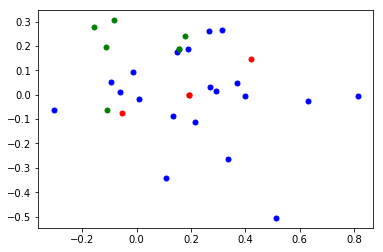

0
‰ªÄ‰πàÁ†¥ËΩØ‰ª∂ÔºÅ ËΩØ‰ª∂‰∏çÂ•ΩÁî®ÊàëËÄÅÂÖ¨ÊäïËØâ‰Ω†‰ª¨‰∫Ü ‰ªÄ‰πàÁ†¥ËΩØ‰ª∂ ‰ªÄ‰πàÁÉÇËΩØ‰ª∂
1
‰Ω†‰ª¨ËøôÁé©ÊÑèÁúüÁöÑÂç°,ÊúâÁÇπÈöæÁî® Â§™ÁÉÇ‰∫ÜÂÅöÁöÑ ‰Ω†ÂèØÁúüÊ≤°Áî®Âïä ‰ªÄ‰πà‰π±‰∏ÉÂÖ´Á≥üÁöÑËΩØ‰ª∂,,ÂÅö‰∏çÂ•ΩÂ∞±Âà´ÊãøÂá∫Êù•ËÆ©ÂÆ¢Êà∑‰ΩøÁî® ‰Ω†‰ª¨Ëøô‰∏™ËΩØ‰ª∂ËÆæËÆ°Âæó‰∏çÂ•Ω Âà´ÊâØËøô‰∫õÊ≤°Áî®ÁöÑ ËΩØ‰ª∂ÂÆûÂú®‰∏çÁªôÂäõ Ëøô‰∏™ËΩØ‰ª∂Â•ΩÈöæÁî® ‰πü‰ºöÂíåÊúãÂèãËØ¥‰∏çË¶ÅÁî® ‰∏ÄÁÇπÈÉΩ‰∏çÂáÜ ‰Ω†‰ª¨Ëøô‰∏™ÁúüÊòØÂùëÁàπ V‰∏™Â±Å!ÊàëË¶ÅÂè∑Âè¨Â§ßÂÆ∂Âà†Èô§‰Ω†‰ª¨ËΩØ‰ª∂ ÂùëÁàπ Â¶≥ÁúüÊòØÁâõÈ†≠‰∏çÂ∞çÈ¶¨Âò¥ ‰Ω†‰ª¨Ë¶ÅÊòØËÄÅÊ≤°‰∫∫Êé•ÂçïÈÇ£ËøôÂÅö‰ªÄ‰πàÂë¢?Âπ≤ËÑÜÂà´ÂºÑËøô‰∏öÂä°Â•Ω‰∏çÂ•Ω ‰Ω†ÁúüÊòØÊó†Áî® ‰Ω†‰ª¨ÁúüÊ≤°‰ø°Ë™â ‰∫§‰∫í‰ΩìÈ™åÊúâÁÇπÂ∑Æ ËµõÁ®ãÂíã‰∏çÂáÜ ÁãóP,‰∏çÂáÜ/:dig
2
‰∏çÂ•ΩÁî® ‰∏çÂ•Ω‰Ωø ÂÅöÂæó‰∏çÂ•Ω ‰∏ÄÁÇπ‰∏çÂ•ΩÁî® ÊâìÂç°ÊÄé‰πà‰∏çÂ•Ω‰Ωø‰∫Ü ‰Ω†‰ª¨Á≥ªÁªüÂ§™‰∏çÂ•ΩÁî®‰∫Ü ÊÄé‰πà‰∏çÂ•ΩÁî®‰∫Ü
11.857264241219124


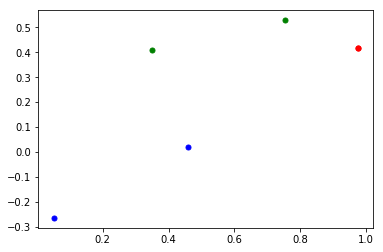

0
Â§™Â∑Æ‰∫Ü Â§™Â∑Æ‰∫Ü!!!
1
Â§™Á¨®‰∫Ü ‰ªÄ‰πàÁ†¥Áé©ÊÑè
2
‰ΩìÈ™åÂ§™Â∑Æ Â§™ÂΩ±ÂìçÁî®Êà∑‰ΩìÈ™å‰∫Ü
45.28372723018645


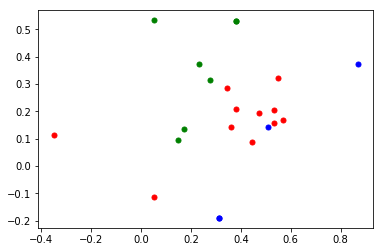

0
Ë¶Å‰∏æÊä• ‰ø°‰∏ç‰ø°Êàë‰∏æÊä•‰Ω† ‰∏æÊä•‰Ω† Êàë‰∏æÊä•‰Ω† ÈÇ£ÊàëÂ∞±‰∏æÊä•‰Ω† ÊàëÁé∞Âú®Â∞±Âéª‰∏æÊä•‰Ω† Êàë‰∏æÊä•‰Ω†Â∑•‰Ωú‰∏çËÆ§Áúü. Â§™ËøáÂàÜ‰∫Ü Â∞èÊù•Â§™ËøáÂàÜ‰∫Ü ÊàëË¶ÅÂÜíÁÅ´Âï¶ ‰Ω†Áâπ‰πàÊ≤°Áé©‰∫ÜÊòØÂêß
1
ËøáÂàÜ‰∫Ü ËøáÂàÜ‰∫ÜÂêßÔºü ÁîüÊ∞î ÊàëÁîüÊ∞î‰Ω†‰∫Ü
2
‰Ω†ËøôÂä©ÁêÜÂπ≥Êó∂ÈÉΩÊòØË∑üÂÆ¢‰∫∫Ëøô‰∏™ÊúçÂä°ÊÄÅÂ∫¶ËØ¥ËØùÁöÑÔºü ‰Ω†ËøôÂä©ÁêÜÂπ≥Êó∂ÈÉΩÊòØË∑üÂÆ¢‰∫∫Ëøô‰∏™ÊúçÂä°ÊÄÅÂ∫¶ËØ¥ËØùÁöÑ? ‰Ω†ÊÄé‰πà‰∏çËØ¥ËØù‰∫Ü,Âä©ÁêÜ Â§ßÂßê‰Ω†ËØ¥ËØù ‰Ω†Âà´Ë∑üÊàëËÅä‰∫Ü,Êç¢‰ºöËØ¥ËØùÁöÑÂä©ÁêÜ ‰Ω†ËØ¥ËØùÂ•ΩËØ°ÂºÇ Âíå‰Ω†ËØ¥ËØùË¥πÂä≤
0.0


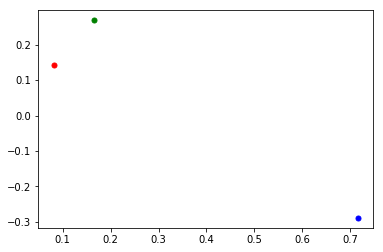

0
Á≥ªÁªü‰∏çÁ®≥ÂÆö
1
È°µÈù¢Êâì‰∏çÂºÄ
2
‰Ω†‰ª¨Á≥ªÁªüÊúâÈóÆÈ¢ò
23.740056112832825


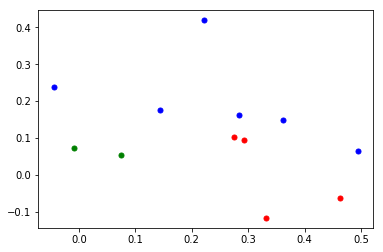

0
ÊâìÂºÄ‰ΩçÁΩÆÊúçÂä°Êúâ‰ªÄ‰πàÁî®Ôºü ÊâìÂç°ÈúÄË¶ÅÂºÄÂêØ‰ΩçÁΩÆ,ÊÄé‰πàÂºÄÂêØÂëÄ ÈÇ£GPSÂÆö‰ΩçÊâìÂºÄÊúâ‰ªÄ‰πà‰ΩúÁî® ‰ΩçÁΩÆÊúçÂä°ÊÄé‰πàÊâìÂºÄ
1
‰ªÄ‰πà‰∫ãÊâìÂºÄ‰ΩçÁΩÆÔºü ‰∏∫‰ªÄ‰πàË¶ÅÊâìÂºÄ‰ΩçÁΩÆÔºü Â¶Ç‰ΩïÊâìÂºÄ‰ΩçÁΩÆÔºü ÊÄé‰πàÊâìÂºÄ‰ΩçÁΩÆÔºü ÂºÄÂêØ‰ªÄ‰πà‰ΩçÁΩÆ Âú®Âì™ÊâìÂºÄ‰ΩçÁΩÆ
2
‰ΩçÁΩÆÊúçÂä°Âú®Âì™Èáå ‰ΩçÁΩÆÊúçÂä°
167.46435861486307


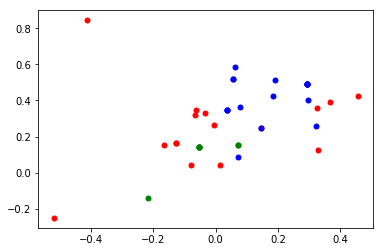

0
Âî±‰∏™Ê≠åÂëóÔºü Âî±‰∏™Ê≠å Èü≥‰πê Ê≠åÊõ≤ ÊàëÊÉ≥Âê¨Ê≠å ÊàëË¶ÅÂê¨Ê≠å Êù•È¶ñÊ≠å  ÂÜçÂõûÈ¶ñ ‰Ω†Âî±‰∏çÂî± Êù•‰∏ÄÈ¶ñÊ≠åÂêß ËÉΩÂî±‰∏ÄÊÆµËã±ÊñáÊ≠åÂêó ÈúÄË¶ÅÊâãÊú∫Ëá™Âä®ÂÆöÊó∂Êí≠ÊîæÊ≠åÊõ≤ ÁªôÊàëÂî±‰∏™Ê≠å ÊàëÊÉ≥Âê¨ÂàòÂæ∑ÂçéÁöÑÊ≠å ÊàëÂî±‰∏™Ê≠åÂêßÂî±Ê≠å ÈÇ£‰Ω†Â∞±Âî±Âïä Âî±‰∏Ä‰∏™
1
ËÉΩÂî±Ê≠åÂêóÔºü ‰ºöÂî±Ê≠å‰πà ËÉΩÂî±Ê≠åÂêó Âî±Ê≠å ‰Ω†‰ºöÂî±Ê≠åÂêó Â∞èÊù•‰ºöÂî±Ê≠å‰πà Âî±Ê≠åÂî±Ê≠å ÁªôÊàëÂî±Ê≠å ‰ºöÂî±Ê≠åÂêó Êù•‰πü,Âî±Ê≠å ÊàëÊÉ≥Âê¨‰Ω†Âî±Ê≠å Âî±Ê≠åÁªôÊàëÂê¨ ÊàëÂ∞±ÈóÆ‰Ω†Âî±‰∏çÂî±Ê≠å ‰Ω†‰ºöÂî±Ê≠åÂêó? ‰Ω†Âî±Ê≠åÂòõ ‰ªñ‰ª¨ËØ¥‰Ω†‰ºöÂî±Ê≠å Âî±Ê≠åÂêß ‰Ω†‰ºöÂî±Ê≠å‰πà
2
Âî±È¶ñÊ≠åÂêßÁªôÊàëÔºü ËÉΩ‰∏çËÉΩÂî±È¶ñÊ≠åÔºü ÁªôÊàëÂî±È¶ñÊ≠åÔºü Âî±È¶ñÊ≠å ÁªôÊàëÂî±È¶ñÊ≠å Âî±È¶ñÊ≠åÂêß ËÉΩÁªôÊàëÂî±È¶ñÊ≠åÂêó?
2.095491577389616


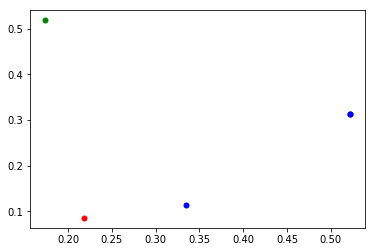

0
‰Ω†Âî±‰∏Ä‰∏™Âêß
1
ÊàëÂî±ÁöÑÂ•Ω‰∏çÂ•ΩÂê¨Âïä? ÈÇ£Â∞±Âê¨ÊàëÂî±Âî±Â•Ω‰∏çÂ•Ω ÊàëÂî±ÁöÑÂ•Ω‰∏çÂ•ΩÂê¨?
2
ÊàëÂî±ÁöÑÂ•ΩÂê¨Âòõ?
9.511339464908977


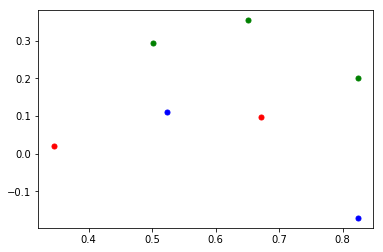

0
ËÑ±Ë∫´ÊòØ‰ªÄ‰πà Áé∞Âú®Ë¶ÅËÑ±Ë∫´ÊòØ‰ªÄ‰πàÊÑèÊÄù?
1
ÂèØ‰ª•ÊâìÊàëÊâãÊú∫Â∏ÆÊàëËÑ±Ë∫´ ÊâìÁîµËØùÊïëÊàë
2
Â∏ÆÊàëËÑ±Ë∫´ÊÄé‰πàËÆæÁΩÆ ÊÄé‰πàÂ∏ÆÊàëËÑ±Ë∫´ ËÑ±Ë∫´ÊÄé‰πàÁî®
4.990926722055379


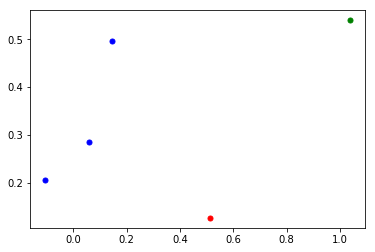

0
ÊúâÊé®ËøüÂäüËÉΩÂêó
1
Â∞èÊù•ÔºåËØ∑ÈóÆÊó•Á®ãÊúâÊó†ÂÜçÊ¨°ÊèêÈÜíÂäüËÉΩ‰∏´ ÊèêÈÜíÂèØ‰ª•ÂÜçÊ¨°Êé®Âá∫Âêó Êó•Á®ãÊúâÊ≤°ÊúâÂÜçÊ¨°ÊèêÈÜíÁöÑÂäüËÉΩ
2
Êó•Á®ãÊèêÈÜíÂèØ‰ª•Êé®ËøüÂêó
66.55890023854553


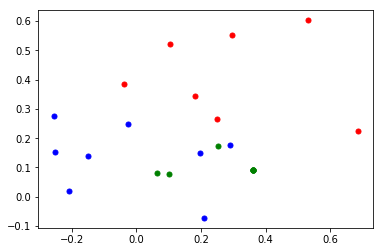

0
ÂèØ‰ª•ÂÄíËÆ°Êó∂ÊØèÂ§©ÊèêÈÜíÂêó ÁªôÊàëÂÄíËÆ°Êó∂ ÂÄíËÆ°Êó∂Ôºü È´òËÄÉÂÄíËÆ°Êó∂ Êó•ÂéÜÂÄíËÆ°Êó∂ ËÄÉÁ†îÂÄíËÆ°Êó∂ ÂèØ‰ª•ËÆæÂÄíËÆ°Êó∂Âêó
1
Â∞èÊù•ÂèØ‰∏çÂèØ‰ª•Â∏ÆÊàëÊØèÊó•ÂÄíËÆ°Êó∂Â§©Êï∞ÊèêÈÜíÂäüËÉΩÔºü ‰Ω†‰ª¨ÊúâÊ≤°ÊúâÂÄíËÆ°Êó∂ÁöÑÂäüËÉΩ ÂÄíËÆ°Êó∂ÂäüËÉΩ ÊúâÂÄíËÆ°Êó∂ÂäüËÉΩÂêó ÊúâÊ≤°ÊúâÂÄíËÆ°Êó∂ Êé®ËçêÊù•‰πüÂ¢ûÂä†‰∏Ä‰∏™ÂÄíËÆ°Êó∂Ê≤ªÊãñÂª∂ÁóáÂäüËÉΩ ÊÄé‰πàÊ†∑ÂèØ‰ª•ÂÄíËÆ°Êó∂Â§©Êï∞ Â§©Êï∞ÂÄíËÆ°Êó∂
2
Êâì‰∏™ÊØîÊñπÔºåÊàë6.17ËÄÉÂÖ≠Á∫ßÔºåÂ¶ÇÊûú‰Ω†‰ª¨ÊØèÂ§©Â∏ÆÊàëÂÄíËÆ°Êó∂ËøòÊúâÂ§öÂ∞ëÂ§©ÔºåÊàëÂ∞±‰ºöÊõ¥ÊúâÂä®Âäõ 32Â§©ÂÄíËÆ°Êó∂ ÂÄíËÆ°Êó∂58Â§© ÂÄíËÆ°Êó∂27Â§© ÂÄíËÆ°Êó∂30Â§© ÂÄíËÆ°Êó∂60Â§© ÁªôÊàëÂÄíËÆ°Êó∂ÂçÅÂ§© ‰Ω†ËÉΩÂ∏ÆËÆ°Êó∂Èó¥Âêó
3.5995224610033514


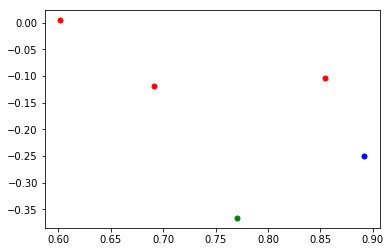

0
Êó•Á®ãÊúÄÂ§öËÉΩÈÇÄËØ∑Â§öÂ∞ë‰∫∫ Êó•Á®ãÊúÄÂ§öÂèØ‰ª•ÈÇÄËØ∑Â§öÂ∞ë‰∫∫ ÊúÄÂ§öÂÖÅËÆ∏Â§öÂ∞ë‰∫∫ÂèÇ‰∏é‰∏Ä‰∏™Êó•Á®ã
1
ÊØè‰∏™Êó•Á®ãÂèØ‰ª•ÈÇÄËØ∑Âá†‰∏™‰∫∫
2
ÊúÄÂ§öÂèØ‰ª•ÈÇÄËØ∑Âá†‰∏™‰∫∫
60.98050456540042


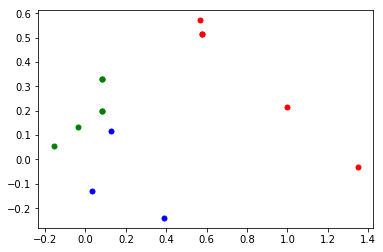

0
Â∞èÊù•ÂèØ‰ª•ËÆ∞Â§áÂøòÂêó Â§áÂøò Êâì‰∏™Â§áÂøò Â§áÂøò‰∏Ä‰∏ã Â§áÂøòË¶ÅÂºÄ‰ºö
1
Â∏ÆÊàëËÆ∞ÂΩï‰∏Ä‰∫õ‰∏úË•ø‰∏çÈúÄË¶ÅÊèêÈÜí ‰∏çÂêÉËæ£ÁöÑÁ¨ëÁ¨¨‰∫åÂ§© 5ÂÖÉÂú∞ÈìÅË¥π
2
ÊàëÂΩì‰∏Ä‰∏ãÂ§áÂøòÂΩï„ÄÇ Â§áÂøòÂΩï Â§áÂøòÂΩï„ÄÇ ÊàëÂΩì‰∏Ä‰∏ãÂ§áÂøòÂΩï. ÊúâÂ§áÂøòÂΩïÂäüËÉΩÂêó ÊúâÊ≤°ÊúâÂ§áÂøòÂΩïÂòõ
1.6363461700434845


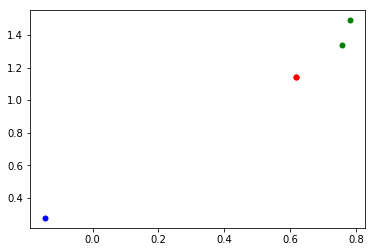

0
Â≠¶‰π†ÊâìÂç° ÊâìÂç°Â≠¶‰π†
1
ÊàëË¶ÅÂ•ΩÂ•ΩÂ≠¶‰π†Âë¢
2
ÊèêÈÜíÂ≠¶‰π† Â≠¶‰π†
58.759526137082915


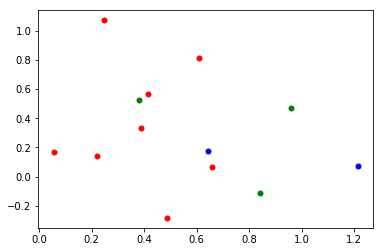

0
ÊúâÊ≤°ÊúâÈÇ£ÁßçÂèØ‰ª•ÊØèÂ§©ÊèêÈÜíÁöÑÂäüËÉΩ ÂèØ‰ª•Áù£‰øÉÊàëÊó©Áù°Âêó ÂèØ‰ª•Áù£‰øÉÊàëÊó©Ëµ∑Âêó ÊØèÂ§©ÁõëÁù£ÊàëÂì¶,Â∞èÂä©ÁêÜ Âä©ÁêÜËØ∑ÁõëÁù£Êàë Áù£‰øÉÊàëÂ≠¶‰π† ÊàëÊÄéÊ†∑ÊâçËÉΩÊõ¥Êó©ÁöÑÁù°Ëßâ Ëøô‰∫õÂ§©ÊèêÈÜí‰∏âÊ¨°ÂêÉÁ¥†
1
ÂèØ‰ª•ËÆæÁΩÆÈáçÂ§çÊèêÈÜíÂêó Êàë‰∏ç‰ºöËÆæÁΩÆÈáçÂ§çÊèêÈÜí
2
ÊÄé‰πàÂèØ‰ª•ÊØèÂ§©ÊèêÈÜíÊàë ÂèØ‰ª•ÊØèÂ§©ÊèêÈÜíÊàëÂêóÔºü ÊòéÂ§©Êó©Ëµ∑Âì¶!
143.94024320393498


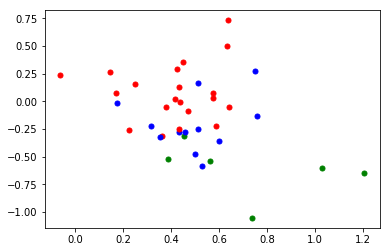

0
‰ªäÂ§©Âøò‰∫ÜÁé∞Âú®ÊâçÊâìÂç° ‰ªäÂ§©ÊÄé‰πàÊ≤°Âè´ÊàëÊâìÂç° Êó©Ëµ∑Â∫ä‰∫Ü,‰ΩÜÂøòËÆ∞ÊâìÂç°‰∫Ü ‰ªäÂ§©ÂøòËÆ∞ÊâìÂç°‰∫Ü,ÂØπ‰∏çËµ∑„ÄÇ Êó©Âøò‰∫Ü ÊâìÂç°‰∫Ü ÊàëÊ≤°ÊúâËµ∑Êôö ÊàëÊòØÂøò‰∫Ü Êó©Ëµ∑Êù•‰∫Ü,Âè™ÊòØÂøò‰∫ÜÊâìÂç°! Èöî‰∏ÄÂ§©ÂøòËÆ∞ÊâìÂç°,ËÆ∞ÂΩïÂ∞±Âèà‰ªéÁ¨¨‰∏ÄÂ§©ÂºÄÂßã,Êúâ‰∏ÄÁßçÊÉ≥Âà†Èô§Êù•‰πüÂæóÊÑüËßâ ÂèØ‰∏çÂèØ‰ª•ÊúâÊâìÂç°ÊèêÈÜí ÊàëÂøòÊéâÊâìÂç°‰∫Ü ÂøòÂï¶ÊâìÂç° ÊØèÂ§©ËÆ∞ÂæóÊâìÂç° Áù°ÂæóÂ§™Â•Ω,ÈÉΩËµ∑Êôö‰∫Ü ÊêûÂøòÊâìÂç°‰∫Ü/::D Êàë‰ºöËÆ∞ÂæóÊâìÂç°ÁöÑ Êò®Â§©Êó©‰∏äËÆ∞ÂæóÊâìÂç°‰∫ÜÂë¢‚Ä¶‚Ä¶/::~/::~ ÊØèÊ¨°ÈÉΩÂøò‰∫ÜÊâìÂç°ÓêÉ ÂøòËÆ∞‰∫Ü[Facepalm][Facepalm] ‰ªäÂ§©Êúâ‰∫ã„ÄÇÊâìÂç°Ëøü‰∫Ü ‰ªäÂ§©Ëµ∑Êôö‰∫Ü ÂøòËÆ∞ÂíØ
1
ÂøòËÆ∞ÊâìÂç°Á≠æÂà∞ ÊàëÂèàÂøòËÆ∞ÊâìÂç°‰∫Ü ÊúÄËøëÊÄªÂøòËÆ∞ÊâìÂç° ËÄÅÊòØÂøò‰∫ÜÊâìÂç° ÊØèÂ§©ÈÉΩ‰ºöÂøòËÆ∞ÊâìÂç° ÂøòÊâìÂç°‰∫Ü ÊàëÊò®Â§©Êôö‰∏äÂøò‰∫ÜÊâìÂç° Êò®Â§©ÂøòÊâìÂç° ÊàëÊ≤°ÂøòËÆ∞ÊâìÂç° ÊòéÊó©‰∏çË¶ÅÂøòËÆ∞ÊâìÂç° Êò®Â§©ÂøòËÆ∞ÊâìÂç° ÊàëÂæàÊó©Â∞±Ëµ∑Êù•‰∫ÜÂøòËÆ∞ÊâìÂç°‰∫Ü
2
Êàë‰ªäÂ§©ÁªôÂøò‰∫Ü Âøò‰∫Ü Âì™Â§©ÂøòËÆ∞Êâì ÊàëÁ´üÁÑ∂ÂøòËÆ∞‰∫Ü[Facepalm] ÂÖ∂ÂÆûÊàëÊó©Ëµ∑‰∫ÜÂøòÊâì‰∫Ü ÂøòÊâì‰∫Ü
79.12619998614667


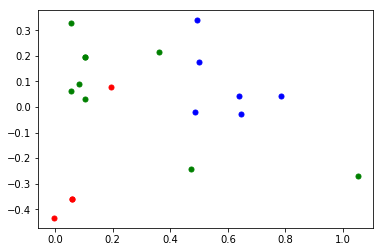

0
ËÉΩÂè´Âà´‰∫∫Ëµ∑Â∫äÂêó ÂèØ‰ª•Âè´Âà´‰∫∫Ëµ∑Â∫äÂêó ÂèØ‰ª•ÊâìÁîµËØùÁªôÂÖ∂‰ªñ‰∫∫Âè´Ëµ∑Â∫äÂêó ÊâìÁîµËØùÁªôÂà´‰∫∫
1
ÂèØ‰ª•ÁªôÂ•ΩÂèãËÆæÊèêÈÜíÂêóÔºü ÊàëÂèØ‰ª•ÊèêÈÜíÂæÆ‰ø°Â•ΩÂèãÂêóÔºü ÁîµËØùÊèêÈÜíËÉΩËÆæÁΩÆÂÖ∂‰ªñ‰∫∫ÁöÑÊâãÊú∫Âè∑Âêó ÂèØ‰ª•ÁîµËØùÂè´Â•ΩÂèãËµ∑Â∫äÂêó ÂèØ‰ª•Â∏ÆÊúãÂèãË∞ÉÈóπÈíüÔºü ‰ªÄ‰πàÊòØÁªôÊúãÂèãËÆæÁΩÆ‰∏Ä‰∏™ÁîµËØùÊèêÈÜíÔºü
2
ÈÇ£‰Ω†Ë¶ÅÊâìÁîµËØùÂè´Â∞èËçâËµ∑Â∫ä„ÄÇ ÊòéÂ§©Êâì13880920540Ëøô‰∏™Âè∑Á†ÅË°åÂêó Â∏ÆÊàëÊèêÈÜí‰∏Ä‰∏ã,18817688655,Êôö‰∏äÂñùÈÖí‰∏çËÉΩÂºÄËΩ¶ ÊâìÁîµËØùÁªô15025958203 ÊâìÁîµËØùÁªôÁõÜÂèã ‰Ω†Â∏ÆÊàëÊâìÁîµËØùÁªôÂ∏åÂ∏å ÁªôÈ¨ºÈ¨ºÊâìÁîµËØù Â∏ÆÊàëÊâìÂº†ËîöÁîµËØù ÊØèÂçÅÂàÜÈíüÊâì‰∏ÄÊ¨° Â¶Ç‰ΩïÁ°ÆÂÆöÂÖ•Áù°Êó∂Èó¥
111.01403045274279


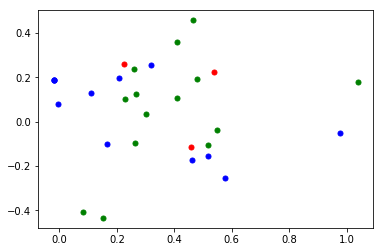

0
‰ªäÂ§©ÂíãÊ≤°ÊèêÈÜí Âà∞ÁÇπÊ≤°ÊèêÈÜíÂêóÔºü Ê≤°ÊúâÊèêÈÜí
1
ÊÄé‰πàÊ≤°ÊúâÊåâÊó∂ÊèêÈÜíÊàëÔºü ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÊèêÈÜíÊàë ‰ªäÂ§©ÊÄé‰πàÊ≤°ÊúâÊèêÈÜíÊàëÔºü ‰∏∫‰ªÄ‰πà‰∏çÊèêÈÜíÊàë ÊÄé‰πàÊ≤°ÊúâÊî∂Âà∞ÊèêÈÜí ÊÄé‰πàÊ≤°ÊúâÊèêÈÜí ÊÄé‰πàÊ≤°ÊúâÊèêÈÜí ÊÄé‰πàÊ≤°ÊúâÊèêÈÜíÂïä ÊÄé‰πàÊ≤°ÊúâÊèêÈÜíÊàë Êò®Â§©Ê≤°ÊúâÊî∂Âà∞ÊèêÈÜí ‰Ω†ÊÄé‰πàÂ∑≤ÁªèÂ•ΩÂá†Â§©ÈÉΩÊ≤°ÊúâÁªôÊàëÊâìÁîµËØù‰∫Ü? ‰∏∫‰ªÄ‰πàÊî∂‰∏çÂà∞ÊâãÊú∫ÊèêÈÜí
2
ÊàëÁöÑÊó•Á®ã‰Ω†Ê≤°ÊúâÊèêÈÜíÊàë ÁÉßÊ∞¥Ê≤°ÊèêÈÜíÂïä ‰∏ãÊù•‰Ω†‰ªäÂ§©‰∏Ä‰ª∂‰∫ã‰πüÊ≤°ÊèêÈÜíÊàë„ÄÇ Êò®Â§©Êó©‰∏äÊ≤°ÊúâÊèêÈÜíÊàëÊâìÂç° [ËØ≠Èü≥ËØÜÂà´]Êò®Â§©Êôö‰∏ä‰Ω†Ê≤°ÊúâÊèêÈÜíÊàëÂá∫ËΩ¶„ÄÇ Ê≤°ÊúâÊèêÈÜíÊàë7ÁÇπÊâìÂç°Âñî ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÊèêÈÜíÊàëÊ¥óÊæ°Ôºå ‰π∞‰π¶ÁöÑËÆ°Âàí‰Ω†ÂøòËÆ∞ÊèêÈÜíÊàë‰∫ÜÔºåÊú¨Êù•È¢ÑËÆ°Êò®Â§©ÂÆåÊàêÁöÑ ÂóØÂ∞èÁáï‰Ω†Êò®Â§©ÂøòËÆ∞Â∏ÆÊàëÊèêÈÜíÈÇ£‰∏™‰∏ÄÂÆöË¶ÅÊää‰π¶ÁúÅ‰∏ãÊù•Ë¥≠‰π∞„ÄÇ Âï•Áé©ÊÑè?ÁÇπËøô‰πàÂçäÂ§©ÈÜí‰∏çËøáÁõπÊù•?Êï¥Êï¥‰∏ÉÂàÜÈíüËøáÂéªÂï¶ 11ÁÇπÊÄé‰πàÊ≤°ÊúâÊé•Âà∞‰Ω†ÁöÑÁîµËØù ‰∏ãÊ¨°Êó©ÁÇπÂèë‰ø°ÊÅØËÆ©ÊàëÊâìÂç° ‰ªäÂ§©ÊÄé‰πàÊ≤°ÊúâÊèêÁ§∫ÊâìËµ∑Â∫äÂç° Êò®Â§©Ê≤°ÊèêÁ§∫ÊàëË°•ÊâìÂç°Âïä
115.26892961110809


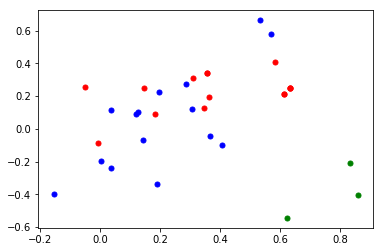

0
ÁîµËØùÊèêÈÜíÊòØÊî∂Ë¥πÁöÑÂêóÔºü ÁîµËØùÊèêÈÜíÊòØÊî∂Ë¥πÁöÑÂêó ÁîµËØùÊèêÈÜíÈúÄË¶ÅÊî∂Ë¥πÂêó ÁîµËØùÊèêÈÜíÊî∂Ë¥πÂêó Â∞èÊù•ÁîµËØùÊèêÈÜíÈúÄË¶ÅÊî∂Ë¥πÂêóÔºü ÁîµËØùÊèêÈÜíÊî∂Ë¥πÂêóÔºü ÁîµËØùÊèêÈÜí‰ºöÊî∂Ë¥πÂòõ ÁîµËØùÊèêÈÜíÊî∂Ë¥πÂêó? ÁîµËØùÊèêÈÜí‰ºöÊî∂Ë¥πÂêó ÊàëÈóÆÁîµËØùÊèêÈÜíÈúÄË¶ÅÊî∂Ë¥πÂêó? ‰Ω†ÁªôÊàëÊâìÁîµËØùÊèêÈÜíÊî∂Ë¥πÂêó ÊâìÁîµËØùË¶ÅÊî∂Ë¥πÂêó Êé•ÁîµËØùÊî∂Ë¥πÂêó? Ëøô‰∏™ËΩØ‰ª∂ÊâìÁîµËØùÊèêÈÜíÊàëË¶ÅÊî∂Ë¥πÂêó Â∞èÊù•ÁªôÊâìÁîµËØùÊî∂Ë¥πÂêó
1
Êù•ÁîµÊèêÈÜíÈúÄ‰∏çÈúÄË¶ÅÊî∂Ë¥πÔºü ÁîµËØùÊèêÈÜíÊòØÂê¶Ë¶ÅÁº¥Ë¥πÔºüÂÖçË¥πÊèêÈÜíÔºü ÁîµËØùÊèêÈÜíÈúÄË¶ÅvipÂêó ‰Ω†Áî®ÁîµËØùÊèêÈÜíÊàëÔºå‰ºöÊâ£Ë¥πÂêó ÁîµËØùÊèêÈÜíË¶ÅÈí±ÁöÑÂêó ÊàëÊÉ≥ÈóÆ‰∏Ä‰∏ã‰Ω†ÁªôÊàëÊâìÁîµËØùË¶ÅËøòÊàëËØùË¥πÂêóÔºü ÊÉ≥ÈóÆ‰∏Ä‰∏ãÔºåÊèêÈÜíÁîµËØùÔºåË¥πÁî®ÊòØ‰∏™Êâ£ÊàëÊú¨Êú∫ÁöÑËØùË¥πÂêóÔºü Âè´ÊàëËµ∑Â∫äÈúÄË¶ÅVIPÂêó ‰Ω†‰ª¨ÊúçÂä°Ë¥πÊÄé‰πàÊî∂ Êé•ÁîµËØùË¶ÅÈí±‰πàÔºü Â∞èÊù•ÁªôÊàëÊâìÁîµËØùÊé•Âê¨ÊòØÂÖçË¥πÁöÑÂêó? ÊâìÁîµËØùÁªôÊàëÈúÄË¶ÅÊî∂Ë¥πÁöÑÂêó?ÊàëÊé•Âê¨ ‰Ω†‰ª¨ÊâìÁîµËØùËøáÊù• ‰ºöÊâ£ÊàëÁöÑËØùË¥πÂòõ/::P Âä©ÁêÜÊù•‰πüÊàëËÆ©‰Ω†ÁªôÊàëÊâìÁîµËØùÊòØÂÖçË¥πÁöÑËøòÊòØË¶ÅÈí±ÁöÑ Â∞èÊù•

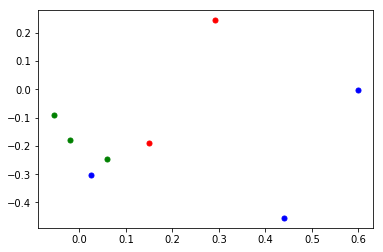

0
‰∏ÄÂπ¥‰∏≠ÊâÄÊúâÁöÑËäÇÊó•Â∏ÆÊàëÊÄªÁªì‰∏Ä‰ªΩ ÊÄé‰πàÂà∂ÂÆöÁâπÊÆäÊó•Â≠ê
1
ÂèØ‰ª•ÂàõÂª∫ËäÇÊó•ÊèêÈÜíÂêóÔºü ÊØè‰∏Ä‰∏™Â§ßÂ∞èËäÇÊó•ÁöÑÂΩìÂ§©Êó©Êô®6ÁÇπÊèêÈÜíÊàë ËäÇÊó•Êó•ÂéÜ
2
ÊâÄÊúâÁöÑËäÇÊó•ÈÉΩÊèêÈÜíÊàë ËÉΩ‰∏çËÉΩÂú®ÊâÄÊúâÁöÑËäÇÊó•ÈÉΩÊèêÈÜíÊàë 10ÊúàÈáåÊúâ‰∫õ‰ªÄ‰πàËäÇÊó•
0.6761094100742843


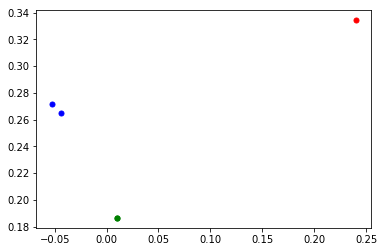

0
ÊÄé‰πàÈÄÄÂá∫Êó•ÂéÜÔºü
1
ÊÄé‰πàÊ†∑ÈÄÄÂá∫Êó•ÂéÜÔºü ËØ∑ÈóÆÊÄéÊ†∑ÈÄÄÂá∫Êó•ÂéÜÔºü
2
Â¶Ç‰ΩïÈÄÄÂá∫Êó•ÂéÜÔºü ËØ∑ÈóÆÂ¶Ç‰ΩïÈÄÄÂá∫Êó•ÂéÜÔºü
0.13722352318693484


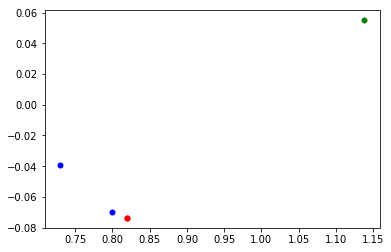

0
‰∏çËÉΩÂàõÂª∫ÂΩìÂâçÊó∂Èó¥ÁöÑÊèêÈÜíÔºü ËÉΩ‰∏çËÉΩÂàõÂª∫ÂΩìÂâçÊó∂Èó¥ÁöÑÊèêÈÜí
1
‰∏∫‰ªÄ‰πà‰∏çËÉΩÂàõÂª∫ÂΩìÂâçÊó∂Èó¥ÁöÑÊèêÈÜíÔºü ‰∏∫Âï•‰∏çËÉΩÂàõÂª∫ÂΩìÂâçÊó∂Èó¥ÁöÑÊèêÈÜíÔºü
2
ÂàõÂª∫ÂΩìÂâçÊó∂Èó¥ÁöÑÊèêÈÜíÂèØ‰ª•ÂêóÔºü
23.686281310368884


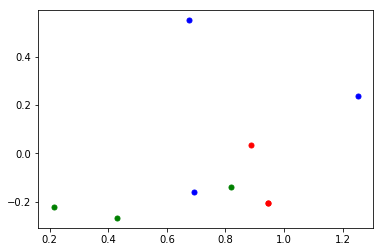

0
ÂÜúÂéÜÂèØ‰ª•ÊèêÈÜíÂêó? ÂÜúÂéÜ ÊåâÂÜúÂéÜ
1
ÂèØ‰ª•ÂàõÂª∫ÂÜúÂéÜÊèêÈÜíÂêóÔºü ËÉΩ‰∏çËÉΩËÆæÁΩÆÂÜúÂéÜÊèêÈÜí ÂÜúÂéÜËÉΩÂ§ÑÁêÜÂêó
2
Ë¶ÅÂÜúÂéÜ ÊòØÂÜúÂéÜ ÂÜúÂéÜÂàù‰∏ÉÂß•Âß•ÁîüÊó•
165.74482473481572


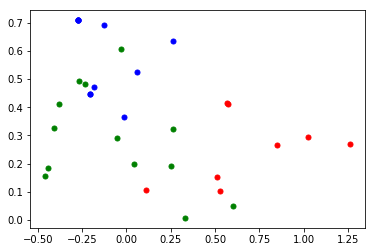

0
ÊúâÁîµËØùÊèêÈÜíÂêó ÂèØ‰ª•ÊèêÈÜíÂà∞ÊâãÊú∫‰∏äÂêó ÂèØ‰ª•ÈÉΩÂæÆ‰ø°ÊèêÈÜíÂêó ÁîµËØùÊèêÈÜíÊòØ‰ªÄ‰πàÊÑèÊÄùÔºü ‰Ω†ÁªôÊàëÊâìÁîµËØùÂêó ÂèØ‰ª•ÂèëÁü≠‰ø°ÁªôÊàëÊèêÈÜíÂêó ÊèêÈÜíÊîØÊåÅÁü≠‰ø°Âêó ÁîµËØùÈÄöÁü•ÊòØ‰ªÄ‰πàÊÑèÊÄù
1
ÊÄé‰πàÊèêÈÜíÊàë ‰Ω†ÊòØÊÄé‰πàÊèêÈÜíÁöÑÔºü ÊÄé‰πàÊèêÈÜíÂë¢ ÊÄé‰πàÊèêÈÜí ÊèêÈÜíÊòØÊÄé‰πàÊèêÈÜíÁöÑ ÊÄé‰πàÊèêÈÜíÊàë? ÊÄé‰πàÊèêÈÜí‰∫Ü ÊÄé‰πàÊèêÈÜíÂïä? ‰Ω†ÊÄé‰πàÊèêÈÜí? ÊÄé‰πàÊèêÈÜíÊàëËµ∑Â∫ä‰∫ÜÔºü ÊÉ≥ÈóÆ‰∏ãÂ∞èÊù•ÊÄé‰πàÊèêÈÜí
2
Ê≤°ÊúâÂ£∞Èü≥ÊèêÈÜíÂêóÔºü ‰Ω†‰ºöÊÄé‰πàÊèêÈÜí ÊúâÂì™‰∫õÊèêÈÜíÊñπÂºè ËÉΩ‰∏çËÉΩÊêû‰∏™ÁîµËØùÊèêÈÜíÂïäÔºü[ÊçÇËÑ∏] ÂØπÁöÑÂØπÁöÑÊé•Âè£ÂÑøÂèØ‰ª•ÁîµËØùÊèêÈÜíÊòØÂêßÔºÅ ÊèêÈÜí‰∫Ü‰ª•Âêé‰Ω†‰ºöÁî®‰ªÄ‰πàÊñπÂºèÊèêÈÜíÊàë„ÄÇ Áî®ÊÄéÊ†∑ÁöÑÊñπÂºèÂè´Ëµ∑Â∫äÂë¢Ôºü ‰ºöÊÄé‰πàÊèêÈÜíÊàëÂë¢Ôºü ‰Ω†‰ª¨‰ºöÂ¶Ç‰ΩïÊèêÈÜíÊàë?ÈááÁî®‰ªÄ‰πàÊñπÂºè? ‰Ω†ÊèêÁ§∫ÊàëÁöÑÊñπÂºèÊòØ‰ªÄ‰πà ÊàëË¶ÅÊòØÁù°Ëøá‰∫Ü‰Ω†‰ºöÂè´ÈÜíÊàëÂêß„ÄÇÓêâ Â¶Ç‰ΩïÊèêÈÜíÈóÆÂÄôÊàë ÈÉΩÊúâ‰ªÄ‰πàÊèêÈÜíÊñπÂºèÔºü
1025.2132447150725


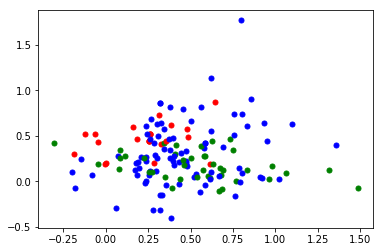

0
ÂèñÊ∂àÁöÑË°åÁ®ãÂ∞±‰∏çÁî®ÊèêÈÜí‰∫Ü ÂèñÊ∂àÊâÄÊúâË°åÁ®ã ÊääÊàëÊâÄÊúâË°åÁ®ãÂèñÊ∂à ÂèñÊ∂àÊâÄÊúâÁöÑË°åÁ®ã ÂèñÊ∂àÊâÄÊúâË°åÁ®ã. Â∏ÆÊàëÂèñÊ∂àÊâÄÊúâÁöÑË°åÁ®ã Â∏ÆÊàëÊääÊâÄÊúâÁöÑË°åÁ®ãÈÉΩÂèñÊ∂à. ÊâÄÊúâÁöÑË°åÁ®ãÂÖ®ÈÉ®ÂèñÊ∂à ÊâÄÊúâË°åÁ®ãÂèñÊ∂à,Èô§‰∫ÜÊâìÂç° ÊàëÁöÑÊâÄÊúâË°åÁ®ã ÂèñÊ∂àÊéâÊàëÁöÑÊâÄÊúâË°åÁ®ã„ÄÇ ÂèñÊ∂àÊâÄÊúâË°åÁ®ãËßÑÂàí, ÊàëÊÉ≥ÂèñÊ∂àÊâÄÊúâË°åÁ®ã ÂèñÊ∂àË°åÁ®ã ÂèñÊ∂àÊâÄÊúâ È∫ªÁÉ¶ÂÖ®ÈÉ®ÂèñÊ∂à ‰ªäÂ§©ÁöÑË°åÁ®ãÂÖ®ÂèñÊ∂à ÂÖ®ÈÉ®ÂèñÊ∂àË°åÁ®ã ÂèñÊ∂à‰ªäÊó•Ë°åÁ®ã ÂèñÊ∂àÂë®Êú´Ë°åÁ®ã ÊÄé‰πàÂèñÊ∂àÂÖ®ÈÉ® ÊâÄÊúâÁöÑ‰∫ã‰ª∂ÂÖ®ÈÉ®ÂèñÊ∂àÂèØ‰ª•‰πà ÂèñÊ∂àÂ§©Ê∞îÊèêÈÜí
1
ÊÄé‰πàÂèñÊ∂àÊèêÈÜí ‰Ω†Â•ΩÔºåÊÄé‰πàÂèñÊ∂àÂ∞èÊù•ÁöÑÂè´ÈÜí‰∏öÂä°Ôºü ÊÄé‰πàÊØèÂ§©ËøòÂú®Âè´ÈÜí ÊÄé‰πàÂèñÊ∂àÁªôÊàëÊâìÁîµËØù ÂèñÊ∂àÂè´Êó©ÊúçÂä° Âè´Êó©ÂèñÊ∂à ÂèñÊ∂àÊàëÁöÑÂè´Êó© ,‰∏çÁî®ÁîµËØùÂè´Êó©. ‰ª•ÂêéÈÉΩ‰∏ç‰ºöÂè´Êó©‰∫ÜÂêß Â¶Ç‰ΩïÂèñÊ∂àÁîµËØùÂè´Êó©Âïä ËÉΩ‰∏çËÉΩÈô§‰∫ÜÂè´Êó©Ââ©‰∏ãÁöÑÈÉΩÂèñÊ∂à ÊèêÈÜíÂ§™Â§öÂï¶ÔºÅ ÂèñÊ∂à‰ªäÂ§©ÁöÑÈóπÈíü„ÄÇ Âº†‰∏ΩÂ∑≤ÁªèËøòÊ¨æ‰∫ÜÔºåÊèêÈÜíÊàë‰∏çÁî®ÂÜçÈÄöÁü•Â•πËøòÊ¨æ ‰ªäÂ§©ÁöÑÊ≠•Ë°å‰ªªÂä°Â∑≤ÂÆåÊàêÔºå‰∏çÁî®ÂÜçÊèêÈÜíÊàë‰∫Ü ÊòéÂ§©‰

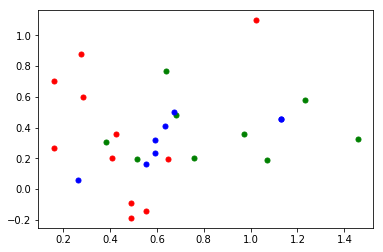

0
Êó•Á®ãÂÆâÊéíÊúâËØØ Áî®ÈóπÈíüÊèêÈÜí ‰∏∫‰ªÄ‰πà‰∏ç‰ºöÊâìÁîµËØùÊèêÈÜíÊàëÂë¢ Êó•Á®ãÂÆâÊéí Áî®ÁîµËØùÊèêÈÜíÂ•ΩÁöÑÂ•ΩÁöÑ ÊàëÊúÄËøëÁúãÊàëÁöÑÊó•Á®ãÂÜÖÂÆπ‰∏çÂ§™ÂØπ ÁîµËØùÈÄöÁü• ‰øÆÊîπË°åÁ®ãË°®ÊÄéÂÅöÊìç‰Ωú ÊàëÁöÑÈÇÄËØ∑Âç°ÂæÆ‰ø°ÂêçËØ∑Êîπ‰∏Ä‰∏ã ÊîπÊéâÂêÉËçØÊó∂Èó¥ ÂÖ≥Êéâ‰∏ÉÁÇπËµ∑Â∫ä
1
Â¶Ç‰ΩïÊîπÊó•Á®ã ÊÄé‰πà‰øÆÊîπÊó•Á®ã Êó•Á®ãÊÄé‰πàÊîπ ÊÄé‰πàÊîπÊàëÁöÑÊó•Á®ã Ëøô‰πà‰øÆÊîπÊó•Á®ã ÊàëËÉΩ‰øÆÊîπÊó•Á®ãÂêóÔºü ‰øÆÊîπÊó•Á®ã ÊÄé‰πà‰øÆÊîπÊàëÁöÑÊó•Á®ã
2
Â¶Ç‰Ωï‰øÆÊîπÊèêÈÜíÔºü ÊÄé‰πà‰øÆÊîπ‰∏Ä‰∏ãÊèêÈÜíÊó∂Èó¥ Êó†Ê≥ïÂú®Á∫ø‰øÆÊîπ Êó•Á®ã‰øÆÊîπ‰ª•Âêé‰∏∫‰ªÄ‰πà‰∏çËÉΩ‰øùÂ≠ò ÂóØÔºå‰øÆÊîπÂêéÊó†Ê≥ï‰øùÂ≠ò‰øÆÊîπ ‰øÆÊîπÊó•Á®ãÔºå‰øùÂ≠ò‰∏ç‰∫Ü ÊàëË¶Å‰øÆÊîπÊó•Á®ãÔºåÂú®Âì™ÈáåÊîπ Â¶ÇÊûú‰ª•ÂêéÊó©Ëµ∑Êó∂Èó¥ÈúÄË¶Å‰øÆÊîπÁöÑËØùÂèØ‰ª•‰øÆÊîπÂêó ÊÄé‰πàÊîπÂú∞ÁÇπ
105.37657989680672


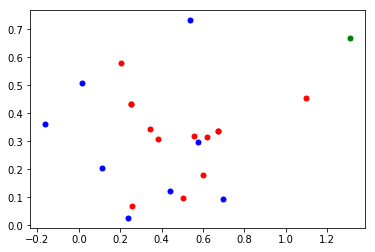

0
Â¶Ç‰ΩïÂàõÂª∫Êó•Á®ãÔºü ÊèêÈÜíÊÄé‰πàËÆæÁΩÆ ÊÄé‰πàËÆæÁΩÆÊèêÈÜí Êó•Á®ãÊÄé‰πàÁî® Â¶Ç‰ΩïÊ∑ªÂä†ÁîüÊó•ÊèêÈÜí Êó•Á®ãÊÄé‰πàÁî®Ôºü ÂàõÂª∫Êó•Á®ãÂú®Âì™Èáå ÊÄé‰πàËÆæÁΩÆÊó•Á®ã Â∑•‰ΩúÊó∂Èó¥ËÉΩÂê¶Â∏ÆÂøôÂÆâÊéí Â¶Ç‰ΩïËÆæÁΩÆËÆ©Êó•Á®ã‰∏çÊèêÈÜí Â¶Ç‰ΩïËÆæÁΩÆÊó•Â∏∏Â∑•‰ΩúÊèêÈÜí Êó∂Èó¥ËÆæÁΩÆÂú®Âì™Èáå ÂèØ‰ª•Â§öÂàõÂª∫Êó•Á®ãÂêó
1
ÂàöÊâçÊàëÊÉ≥Êñ∞Âª∫‰∏Ä‰∏™ÊØèÊó•ÁöÑÊèêÈÜíÔºå‰∏∫‰ªÄ‰πàÊó†Ê≥ïÊñ∞Âª∫Âë¢Ôºü ÈÇ£ÁßçÊØèÂë®ÊèêÈÜíÂéª‰∏äÂêâ‰ªñËØæÁöÑÊúçÂä°Êúâ‰πà ÊàëÊÉ≥ÂáèËÇ•ËÉΩÊúâÊèêÁ§∫ÂòõÔºü ÊàëÊÉ≥Ë¶Å‰∏™ÊØèÂ§©Êó©‰∏ä6:30ÁöÑÊèêÈÜí  ÈúÄË¶ÅÊØèÂ§©ËÆæÁΩÆÂêó  ËøòÊòØ‰Ω†‰ª¨ÂèØ‰ª•Áõ¥Êé•ËÆæÁΩÆÁöÑ ‰Ω†Â•ΩÔºåÊÉ≥ÈóÆ‰∏ãÊúâÊØèÂ§©ÈÉΩÊèêÈÜíÁöÑÂäüËÉΩÂêó ÊàëÊÉ≥ÈóÆ‰∏Ä‰∏ãÊúâÊ≤°ÊúâÈóπÈìÉÊèêÈÜí‰∫Ü? Ê±üËãèÂç´ËßÜË∑®Âπ¥ÊºîÂî±‰ºöÈó®Á•®ÂºÄÂçñÊèêÈÜíÊàë ÊÇ®ÊòØ‰∏çÊòØÂèØ‰ª•ÊèêÈÜíÊàëÊüê‰∫õ‰∫ãÊÉÖÂë¢
2
Á≠â‰∏Ä‰∏ãÊèêÈÜíÊàëÂºÄ‰ºö
34.913974543273596


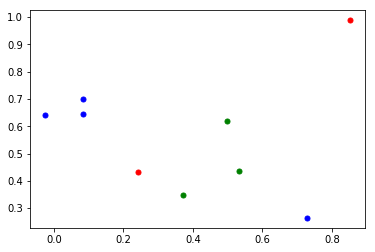

0
ÁîµËØùÂè´ÈÜíËÉΩËÅäÂ§©ÂêóÔºü Âè´ÈÜíÁöÑÊó∂ÂÄôÂ§öËØ¥ÁÇπ
1
ÊÄé‰πàÈÄâÊã©Âè´ÊàëËµ∑Â∫äÁöÑÂ£∞Èü≥ ÁîµËØùÈóπÈíüÂ£∞Èü≥Â§™‰∏çÂ•ΩÂê¨‰∫Ü ‰Ω†ÊâìÁöÑÊèêÈÜíÁîµËØùÊàëÂøÖÈ°ªÊé•Âêó ÊâìÁîµËØùÁöÑÂ£∞Èü≥‰∏çÂ•ΩÂê¨
2
Ëøô‰∏™Êó•Á®ãÂèëËØ≠Èü≥ÁöÑÊòØÊú∫Âô®‰∫∫ÂêßÔºü ÁîµËØùÊèêÈÜíÔºåÊòØ‰∫∫Â∑•ÊâìÁîµËØùËøòÊòØËΩØ‰ª∂ ÁªôÊàëÂèëÊù°ËØ≠Èü≥ÊèêÈÜí!
52.42264517340415


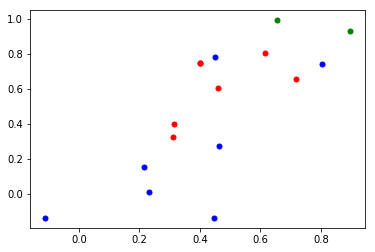

0
ÊúâÊ≤°ÊúâÂè´ÈÜíÊúçÂä° ÊúâÊ≤°ÊúâÂè´ÈÜíÊúçÂä° ÊúâÂè´ÊàëËµ∑Â∫äÁöÑÊúçÂä°Âêó ÊúâÂè´Ëµ∑Â∫äÁöÑÊúçÂä°Âêó ÊúâÂè´ÈÜíÊúçÂä°ÂêóÔºü ‰Ω†ÊúâÂè´ÈÜíÊúçÂä°Âêó ËÉΩÊèê‰æõÂè´ÈÜíÊúçÂä°Âêó
1
‰Ω†ÂèØ‰ª•Âè´ÊàëËµ∑Â∫äÔºü Ê≤°‰∫∫Âè´ÊàëËµ∑Â∫ä ÊÄé‰πàÊØèÂ§©ËøòÂú®Âè´ÈÜí ËÉΩ‰∏çËÉΩÂè´ÊàëËµ∑Â∫ä ‰ªäÂ§©Ê≤°ÊèêÈÜíÊàëÊâìÂç°Ôºü Âî±Ê≠åÊèêÈÜíËøòÊòØ‰∫∫Â∑•ÊèêÈÜí ÂèØ‰ª•Âè´Ëµ∑Â∫ä‰∏ç
2
ÊòØ‰∫∫Â∑•Âè´ÈÜíÂêó ÊòØÁúü‰∫∫Âè´ÈÜíÂêó
110.03518123389367


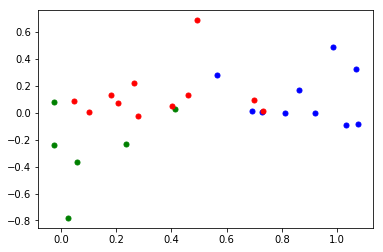

0
ÂàöÊâçÊàëÊÉ≥Êñ∞Âª∫‰∏Ä‰∏™ÊØèÊó•ÁöÑÊèêÈÜíÔºå‰∏∫‰ªÄ‰πàÊó†Ê≥ïÊñ∞Âª∫Âë¢Ôºü Êó•Á®ãÊÄé‰πàÂª∫Âïä ÊÄé‰πàÁîüÊàêÈÇÄËØ∑Âç° ÈÇÄËØ∑Âç°Âú®Âì™ÈáåÂïä ÊÄé‰πàÂÖ±‰∫´Êó•Á®ã Êó•Á®ãÈÇÄËØ∑Âç° ÊòüÂ∫ßÂèØ‰ª•ÁîüÊàêÈÇÄËØ∑Âç°Âêó ÈÇÄËØ∑Âç° Âú®Âì™ÈáåÁÇπÂáªÈÇÄËØ∑Âç° ÊÄéÊ†∑ÊâçËÉΩÁîüÊàêÈÇÄËØ∑Âç° ÁîüÊàêÈÇÄËØ∑Âç°
1
ÊÄé‰πàÈÇÄËØ∑Â•ΩÂèãÂèÇ‰∏éÊó•Á®ã ÈÇÄËØ∑Âà´‰∫∫Âä†ÂÖ•ÊÄé‰πàÈÇÄËØ∑ ÊÄé‰πàÂä†ÂÖ•Êó•Á®ãÈÇÄËØ∑Ôºü ÈÇÄËØ∑‰∫ÜÂà´‰∫∫Âä†ÂÖ•Êó•Á®ãÔºåÊàëÂà†ÊéâÊó•Á®ãÁöÑËØùÔºåÂØπÊñπ‰πü‰ºöË¢´Âà†Èô§Âêó ÊÄé‰πàÊó•Á®ãÂä†ÂÖ•Ôºü Êó•Á®ãÈÇÄËØ∑ ÊÄé‰πàÈÇÄËØ∑Âà´‰∫∫Âä†ÂÖ•Êó•Á®ã ÂèØ‰ª•ÈÇÄËØ∑Âà´‰∫∫Âä†ÂÖ•Êó•Á®ãÂêó Êàë‰∏ç‰ºöÈÇÄËØ∑Âà´‰∫∫Âä†ÂÖ•Êó•Á®ã ÈÇÄËØ∑ÊúãÂèãÊÄé‰πàÈÇÄËØ∑?
2
ÂèØ‰ª•Â∏ÆÊàëÊèêÈÜíÂà´‰∫∫Âêó Â¶Ç‰ΩïÊääÂ•ΩÂèãÊãâËøõÊó•Á®ãÊèêÈÜíÔºü ËÉΩ‰∏çËÉΩÊèêÈÜíÊàëÁöÑÂ•ΩÂèã‰ªÄ‰πàÊó∂ÂÄôÂõûÂÆ∂ ‰∏ÄÂ§©‰∏çËÉΩÂä†ÂÖ•2‰∏™Êó∂Èó¥ÊÆµÁöÑÊó•Á®ãÂêó? ‰Ω†ËÉΩÊõøÊàëÊèêÈÜíÊàëÁöÑÂ•ΩÂèãÂêó? ËÉΩ‰∏çËÉΩÁªôÂà´‰∫∫ÂèëÂæÆ‰ø°ÊèêÈÜí
0.0


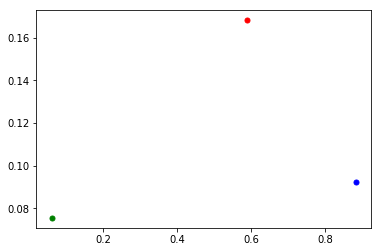

0
ÊÄé‰πàÁªôÊó•Á®ãÊ∑ªÂä†Á∫¢ÂÆù
1
Êó•Á®ãÊ∑ªÂä†Á∫¢ÂåÖ
2
ÊÄé‰πàÁªôÊó•Á®ãÂä†‰∏äÁ∫¢ÂåÖËÆ©Â§ßÂÆ∂Êä¢
0.0


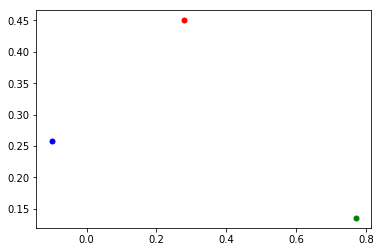

0
Â¶Ç‰ΩïÂÆâÊéíÈáçÂ§çÊó•Á®ã
1
ÊúâÂì™‰∫õÂæ™ÁéØÊèêÈÜíÁöÑÊñπÂºè
2
Èô§‰∫ÜÊØèÂ§©ÔºåËøòÊúâ‰ªÄ‰πàÂæ™ÁéØÊèêÈÜíÁöÑËÆæÁΩÆ
0.0


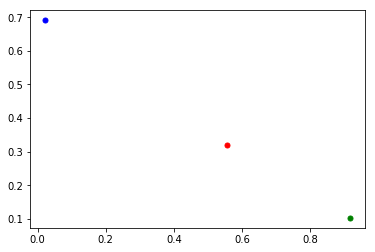

0
Êó•Á®ãÊÄé‰πàËÆæÁΩÆ
1
ÊâìÂç°ÊÄé‰πàÊèêÈÜí
2
Â∞èÊù•ÂèØ‰ª•Â∏ÆÊàëËÆ∞Êó•Á®ã‰πà
115.50004881969272


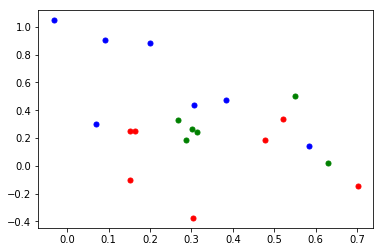

0
ÊàëÊúÄËøëÊúâ‰ªÄ‰πà‰∫ã ÊàëÊúÄËøëÊúâÂì™‰∫õÊó•Á®ãÂÆâÊéí ÊàëËøë‰∏ÄÂë®Êó•Á®ãÊúâ‰ªÄ‰πà? ÊàëÁöÑÊó•Á®ãÊúâÂì™‰∫õ Ëøë‰∏ÄÂë®Êó•Á®ãÊúâ‰ªÄ‰πà? Êúâ‰∏ÄÂë®ÈÉΩËøôÊ†∑‰∫Ü ÊàëÊúâÂì™‰∫õÊèêÈÜí
1
ÊòéÂ§©Âá†ÁÇπÈíüÊàëËµ∑Â∫äÂïä ‰ªäÂ§©Ë°åÁ®ã ÊòéÂ§©ÊàëÊúâ‰ªÄ‰πàÂÆâÊéí Â∏ÆÊàëÁúã‰∏Ä‰∏ãÊòéÂ§©ÁöÑË°åÁ®ãÂÆâÊéí ÊòéÂ§©Ë°åÁ®ã Êàë‰ªäÂ§©Êúâ‰ªÄ‰πàË°åÁ®ã ÊàëÂàöÊâçËÆ¢‰∫ÜÈóπÈíü„ÄÇÊòØÂá†ÁÇπÂëÄ
2
ÊàëÁöÑÊó•Á®ã Êó•Á®ãÂÆâÊéíÂèòÊàêÂõæÁâá Áúã‰∏ãÊàë‰ªäÂ§©ÁöÑÊó•Á®ã ‰ªäÂ§©Êó•Á®ã ÊàëÊòéÂ§©ÁöÑÊó•Á®ãÈÉΩÊòØ‰ªÄ‰πà ÊòéÂ§©ÁöÑÊó•Á®ãÊòØ‰ªÄ‰πà
3.5369374145965975


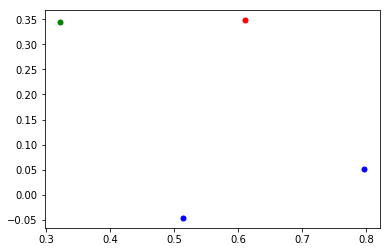

0
ÊàëÊÉ≥Âª∫Á´ãÊó•Á®ãË°®
1
ÂÜçÊ¨°ÁîüÊàê‰∏ÄÊ¨°‰∏ÄÂ§©ÁöÑÊó•Á®ãË°® ÁîüÊàêÊó•Á®ãË°®
2
Âê¨ÊàëÂÅö‰∏™Êó•Á®ãË°®
6.297082058734578


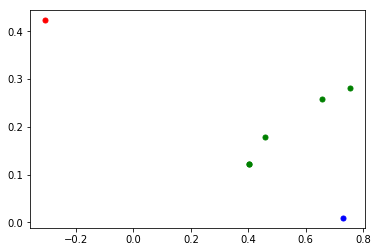

0
ÊÄéÊ†∑ÈÄÄÂá∫
1
ÈÇÄËØ∑‰∫ÜÂà´‰∫∫Âä†ÂÖ•Êó•Á®ãÔºåÊàëÂà†ÊéâÊó•Á®ãÁöÑËØùÔºåÂØπÊñπ‰πü‰ºöË¢´Âà†Èô§Âêó
2
ÊÄé‰πàÂèñÊ∂àÂêØÊó•Á®ãÈÇÄËØ∑ Êó•Á®ãÈÇÄËØ∑Â¶Ç‰ΩïÂèñÊ∂à ÊÄé‰πàÂèñÊ∂àÊó•Á®ãÈÇÄËØ∑ Ë¢´ÈÇÄËØ∑ÁöÑÊó•Á®ãÂ¶Ç‰ΩïÂèñÊ∂à Ë¢´ÈÇÄËØ∑Âä†ÂÖ•ÁöÑÊó•Á®ãÂ¶Ç‰ΩïÈÄÄÂá∫
30.190372013634114


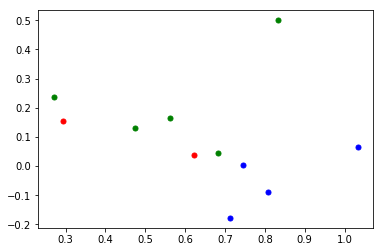

0
‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂèëÈÄÅÈÇÄËØ∑Âç° ÊÄé‰πàËÉΩÊØèÊ¨°ÈÉΩËá™Âä®ÂèëÈÄÅÈÇÄËØ∑Âç°
1
‰ª•ÂêéÊèêÂâçÂçä‰∏™Â∞èÊó∂ÊèêÈÜíÊàë‰∏äËØæ ‰ª•ÂêéÊèêÂâçÂçä‰∏™Â∞èÊó∂ÊèêÈÜíÊàëÂºÄ‰ºö ÊèêÂâç‰∏ÄÂ§©Âπ∂ÊèêÂâç‰∏ÄÂ∞èÊó∂ÂëäÁü•Êàë ÊèêÂâç‰∫îÂàÜÈíüÈíüÊèêÈÜí
2
ÊØèÂ§©ÁªôÊàëÊó•Á®ãÁöÑÊó∂Èó¥ËÉΩÂê¶ÊèêÂâçÂà∞7ÁÇπÔºü ÊÄé‰πàÈªòËÆ§ÁîµËØùÊèêÈÜí ËÉΩ‰∏çËÉΩÊØèÊ¨°ÈªòËÆ§ÊòØÁîµËØùÊèêÈÜí ÊÄé‰πàÈªòËÆ§Êó•Á®ãÈÉΩÊòØÊèêÂâç1‰∏™Â∞èÊó∂ÊèêÈÜí ‰∏∫‰ªÄ‰πàÊô∫ËÉΩÊèêÂâç51530ÂàÜÈíüÔºå‰∏çÂèØ‰ª•Ëá™Â∑±ÈÄâÊã©Êó∂Èó¥ÁöÑÂêó
123.70214440720453


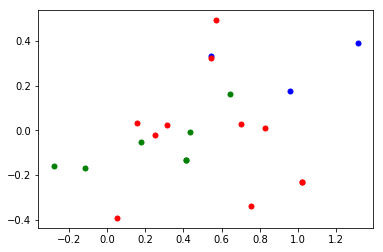

0
‰∏çÁî®Êâì‰∫Ü ‰ª•Âêé‰∏çÁî®Âè´ÊàëËµ∑Â∫ä‰∫Ü Ëµ∑Â∫äÊó∂Èó¥Êîπ‰∏∫‰∏ÉÁÇπ ÂéªÊéâÊèêÈÜí ÊàëËØ¥ÁöÑÊòØ‰∏çÁî®Êâì ‰∏çÁî®Âè´ÊàëËµ∑Â∫äÂï¶ ‰∏çÁî®ÂñäËµ∑Â∫ä‰∫Ü Âà´ÊâìÁªôÊàë Âà´Âè´Êàë‰∫Ü ÈÉΩ‰∏çÁî®Êâì ËÉΩ‰∏çËÉΩ‰∏çË¶ÅÂú®ÁªôÊàëÊâìÁîµËØù‰∫Ü
1
ÂèñÊ∂àÊâìÁîµËØù ÂèñÊ∂àÁîµËØù ÂèñÊ∂àÊù•Áîµ
2
‰∏çÁî®ÊâìÁîµËØù‰∫Ü ‰∏çË¶ÅÊâìÁîµËØù ‰∏çÁî®ÊâìÁîµËØù ÊòéÂ§©Êó©‰∏ä‰∏çÊâìÁîµËØù ‰∏çÁî®ÊâìÁîµËØùÁªôÊàë‰∫Ü Âà´ÊâìÁîµËØù‰∫Ü ‰∏çË¶ÅÂÜçÊâìÁîµËØù‰∫Ü
3.761862540817039


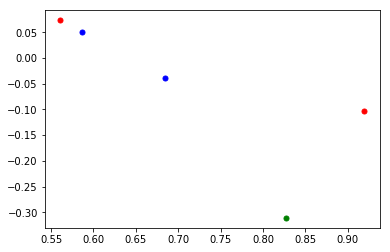

0
ÊèêÂâç‰∏ÄÂ§© ÊèêÂâç‰∏ÄÂ§©ÁöÑ7ÁÇπ
1
Êé®Ëøü2Â∞èÊó∂ Êé®Ëøü20ÂàÜÈíü
2
Êé®ËøüÂçäÂ∞èÊó∂
0.695953261978745


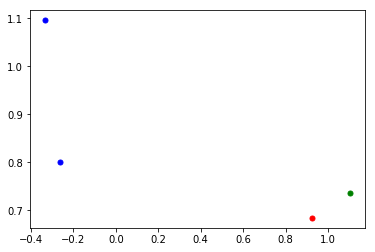

0
Ë∑ëÊ≠•Ë°åÁ®ãÂèØ‰ª•Ê∑ªÂä†Âêó
1
Ë°åÁ®ã ÊàëÁöÑË°åÁ®ã
2
Âä†ÂÖ•Ë°åÁ®ã
46.25654284120417


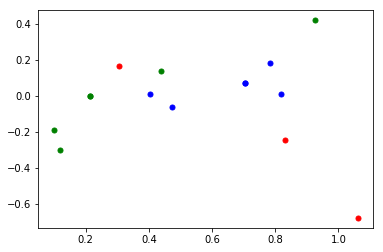

0
ÊØè‰∏™Â∞èÊó∂ÊèêÈÜíÊàëÂñùÊ∞¥ ÊØèÂçäÂ∞èÊó∂ÊèêÈÜíÊàëÂñùÊ∞¥ ÊØèÈöî‰∏ÄÂ∞èÊó∂ÊèêÈÜíÊàëÂÅöËÆ≤ËØæÂ§ßËµõPPT
1
Â§öÂè´Âá†Ê¨° Â§öÊâìÂá†Ê¨°ÁªôÊàë Â§öÊèêÈÜíÂá†Ê¨° Â§öÊèêÈÜíÊàëÂá†Ê¨° Â§öÂè´ÊàëÂá†Ê¨° Â§öÊèêÈÜíÊàëÂá†Ê¨°„ÄÇ
2
ÂÜçÂè´‰∏ÄÊ¨° Âè´Âà∞Ëµ∑Â∫ä‰∏∫Ê≠¢ Âá†ÁÇπ‰πüË°å,Â§öÊèêÈÜíÂá†Ê¨° Âá†ÁÇπ‰πüË°å,Â§öÊèêÈÜíÂá†Ê¨°. timeÂÜçÂè´‰∏ÄÊ¨° Ê≤°Êé•Â∞±Â§öÊ¨°Êã®Êâì
11.8769619993048


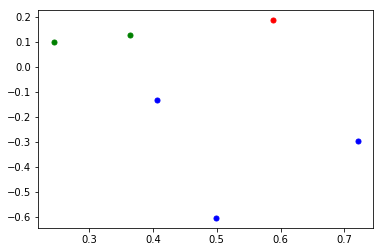

0
‰∏∫‰ªÄ‰πà‰ºöÈáçÂ§çÊèêÈÜí
1
Ëøô‰∏™‰∫ãÊÉÖÂ∑≤ÁªèÊèêÈÜíËøáÊàë‰∫Ü ÂàöÂàöÂ∑≤ÁªèÊèêÈÜíËøá‰∏ÄÊ¨°‰∫ÜÔºå‰∏∫‰ªÄ‰πàÂèàÊù•Ôºü Â∑≤ÁªèÊèêÈÜíËøáÂï¶ÔºåÊêûÊØõÂèàÂèë‰∏ÄÊù°Ôºü
2
‰∏∫‰ªÄ‰πàÊàë‰ºöÂêåÊó∂Êî∂Âà∞Â§ö‰∏™ÊèêÈÜí ‰∏∫‰ªÄ‰πà‰Ω†‰ºöÊèêÈÜíÊàë‰πàÊ¨°Ôºü
51.47820512530875


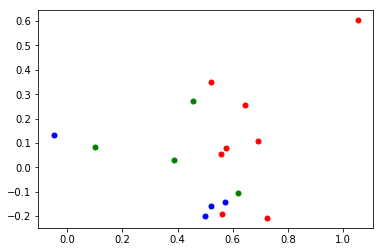

0
‰ªäÂ§©Ê≤°ÊúâÁîµËØùÊèêÈÜíÊíí ÊàëÈÄâÊã©‰∫ÜÁîµËØùÊèêÈÜíÔºåÂèØÊòØ‰Ω†Âπ∂Ê≤°ÊúâÔºåÁÑ∂ÂêéÊàëÈîôËøá‰∫Ü ÊØèÂ§©ÈÉΩÊ≤°ÊúâÊé•Âà∞Ëµ∑Â∫äÁîµËØù ÊÄé‰πàÊ≤°ÊâìÊàëÁîµËØù Â•ΩÂá†Ê¨°ÈÉΩÊ≤°ÊúâÊâìÁîµËØù Ê≤°ÊâìÈÄöÊé•ÁùÄÊâìÂïä Êó∂Èó¥ÈÉΩÂà∞‰∫Ü‰∏∫‰ªÄ‰πàÊ≤°ÊúâÁîµËØùÊèêÈÜíÊàëÂëÄ Êä±Ê≠âÊú™ËÉΩÊé•Âà∞‰Ω†ÁöÑÁîµËØù
1
ÊÄé‰πàÊ≤°ÁªôÊàëÊâìÁîµËØù ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÊâìÁîµËØù ‰∏∫‰ªÄ‰πà‰∏çÊâìÁîµËØù Ê≤°‰ªÄ‰πàÊ≤°ÊúâÊâìÁîµËØù
2
‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂáÜÊó∂ÊâìÁîµËØùÁªôÊàë ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÁªôÂ•ΩÂèãÂèëÊôöÂÆâÂïä ‰ªäÂ§©Êó©‰∏ä‰∏∫‰ªÄ‰πàÊ≤°ÁªôÊàëÊâìÁîµËØù Êó©‰∏ä‰∏ÉÁÇπ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÁªôÊàëÊâìÁîµËØù
10.23415490095162


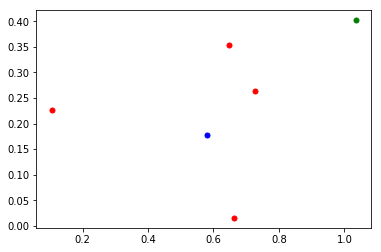

0
‰Ω†ÊÄé‰πàÁªôÊàëÂª∫Êó•Á®ã‰∫Ü Ê≤°ËÆ©‰Ω†ÂàõÂª∫ÊèêÈÜí Ê≤°ÊúâËÆ©‰Ω†Âª∫ÊèêÈÜíÂïä ‰∏çÊòØËÆ©‰Ω†ÊèêÈÜí
1
ÊèêÈÜíÁñØ‰∫Ü‰πà?
2
ÊÄé‰πàÊ∑ªÂä†‰∫ÜÊó•Á®ã
9.968724046819911


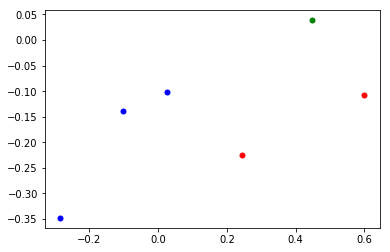

0
1ÂàÜÈíüÂêéÊèêÈÜí‰∏çÊîØÊåÅÂêóÔºü ‰∏∫‰ªÄ‰πàÊàëËØ¥‰∏§ÂàÜÈíüÂêéÊèêÈÜíÊàë‰∏çÂ•Ω‰Ωø
1
‰∏çËÉΩÈ©¨‰∏äÊèêÈÜíÊàëÂêó ‰∏çËÉΩÁé∞Âú®Â∞±ÊèêÈÜíÊàëÂêó ‰∏çËÉΩÊâìÁîµËØùÊèêÈÜí‰∫Ü?
2
Áé∞Âú®ÊèêÈÜíÊàë‰∏∫‰ªÄ‰πà‰∏çË°å
5.188456861908075


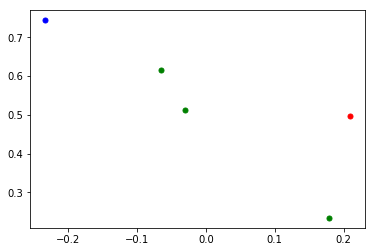

0
Êù•‰πüÂèØ‰ª•ÂºÄÂèëÂ§ßÂß®Â¶àËÆ°ÁÆóÊèêÈÜíÂäüËÉΩÂêóÔºü/D
1
ËÉΩÊèêÈÜíÂ§ßÂß®Â¶àÊù•‰∫Ü‰πà?
2
ÊàëÂØπÊó•Á®ãÊúâÂª∫ËÆÆ ÊàëÊÉ≥ÁªôÊó•Á®ãÊèê‰∏™Âª∫ËÆÆ ËÉΩÊèê‰∏™Âª∫ËÆÆÂêóÔºü
97.22882310721262


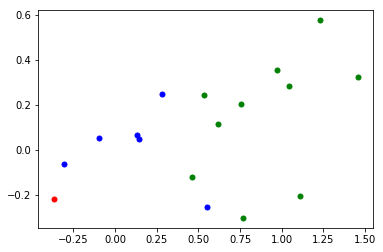

0
ÂÑøÂ≠êÁîüÊó•
1
‰Ω†ÁöÑÈÇ£‰∏™Êó•Á®ã‰∏äÁ∫¢ÂåÖÊòØÊúâbug‰∫ÜÔºü Â∞èÊù•ÔºåÂ∏ÆÊàëÁúãÁúãÊòØ‰ªÄ‰πàÂéüÂõ†ÈÄâ‰∏ç‰∫Ü19Êó• Â§©Ê∞îÊèêÈÜíÂá∫bug‰∫Ü  ÁªôÊàëËøûÂèë‰∫Ü10Âá†Êù°ÊèêÈÜí  ËøòÂú®Âèë ÊÄé‰πàÊèêÈÜí‰∏äÈù¢ÁöÑÊó∂Èó¥‰∏çÂáÜ ÊàëÂÑøÂ≠êÁîüÊó•ËøòÊ≤°Âà∞ÁöÑÊòØÊòØÊóßÂéÜÁöÑ‰∏çÊòØÈò≥ÂéÜÁöÑ ‰∏çÂáÜÁöÑ
2
ÁîµËØùÊèêÈÜíÊâì‰∏çÂºÄ ÊàëÊ≤°ÊúâÁªëÂÆöÔºå‰ΩÜÊòØÊàëÁÇπÁîµËØùÊèêÈÜí‰πüÊ≤°ÊúâÊèêÈÜíÊàëÔºåÂíåÂºïÂØºÊàëÁªëÂÆö ‰øÆÊîπÊó•Á®ãÔºå‰øùÂ≠ò‰∏ç‰∫Ü Êó†Ê≥ïÂú®Á∫ø‰øÆÊîπ Êó•Á®ã‰øÆÊîπ‰ª•Âêé‰∏∫‰ªÄ‰πà‰∏çËÉΩ‰øùÂ≠ò ÂóØÔºå‰øÆÊîπÂêéÊó†Ê≥ï‰øùÂ≠ò‰øÆÊîπ ÊÄé‰πà‰øÆÊîπÊó•Á®ãÂêéÊó†Ê≥ï‰øùÊåÅ‰øÆÊîπÔºü ‰∏çËÉΩËÆ∞ÂΩïÊó•ÂéÜ Êó•Á®ãÊâì‰∏çÂºÄ Êó•Á®ã‰∏çËÉΩÂª∫Á´ã
4.464396135425847


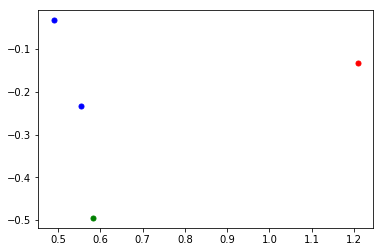

0
‰∫åÂàÜÈíüÂñùÊ∞¥
1
ÊèêÈÜíÊàë6ÂàÜÈíüÂêéÂñùÊ∞¥ Êàë‰∏Ä‰∏™Â∞èÊó∂Âêé‰ºëÊÅØ
2
Êàë‰∫îÂàÜÈíüÂñùÊ∞¥
0.9960704963637972


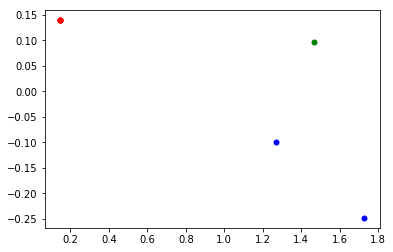

0
Áé∞Âú®ÊâìÁîµËØùÁªôÊàë ÊâìÁîµËØùÁªôÊàë Áé∞Âú®ÁªôÊàëÊâìÁîµËØù È©¨‰∏äÊâìÁîµËØùÁªôÊàë
1
ÁªôÊàëÊâì‰∏™ÁîµËØù Êâì‰∏™ÁîµËØùÊàë
2
ÊâìÊàëÁîµËØù
115.15130848158407


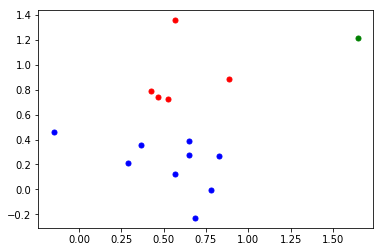

0
Ë∑ëÊ≠• ËøêÂä® ÂÅ•Ë∫´ Ëµ∑Â∫äË∑ëÊ≠• ÈîªÁÇº
1
Êô®Ë∑ë ÂùöÊåÅÂø´Ëµ∞6ÂÖ¨Èáå‰ª•‰∏ä Á´ôÊ°© Êô®ËØª Âè´ÊàëËµ∑Â∫ä Âè´Êó© ÁîµËØùÂè´Êó©Âêß ÊÄé‰πàËÉΩËÆæÁΩÆÂñäÊàëËµ∑Â∫ä ÂñäÊàëÊó©Ëµ∑
2
ÂºÄ‰ºö
30.485923783429413


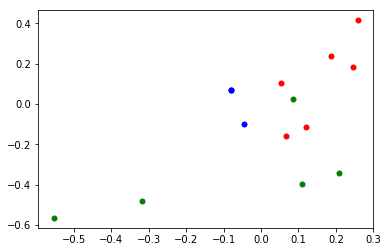

0
ËÄÅÂÖ¨ÁîüÊó•ÊòØ5Êúà8Âè∑ ËÄÅÁà∏ÁîüÊó•ÊòØ7Êúà1Âè∑ ÊàëÁöÑÁîüÊó•ÊòØ4Êúà8Âè∑ ‰∏ª‰∫∫ÁîüÊó•ÊòØ4Êúà8Âè∑ Êü•ËØ¢ËÄÅÁà∏ÁîüÊó• ËØ∑ÈóÆÊàëÈó∫Â•≥ÁöÑÁîüÊó•ÊòØÈÇ£Â§©
1
ÁîüÊó• ËÄÅÂ©ÜÁîüÊó• ÊàëÁöÑÁîüÊó•Âë¢
2
Áà∏Áà∏ÁîüÊó• ÊàëËÄÅÂÖ¨ÁîüÊó• ËÄÅÁà∏ÁîüÊó• ÊØç‰∫≤ÁîüÊó• ÊòéÂ§©Èó∫ËúúÁîüÊó•
17.705115314110845


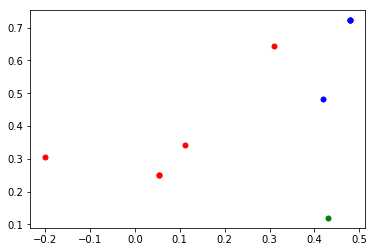

0
ÊèêÈÜíÁù°Áú†ÊâìÂç° Êó©ÁÇπÊèêÈÜíÊàëÊâìÂç° ÊÄé‰πà‰∏çÊèêÈÜíÊàëÊâìÂç° ÊÄé‰πà‰∏çÊèêÈÜíÊàëÊâìÂç°‰∫Ü ÊÄé‰πàÁé∞Âú®Ê≤°ÊúâÊèêÈÜíÊâìÂç°‰∫Ü?
1
ÊèêÈÜíÊâìÂç° ÊâìÂç°ÊèêÈÜí ÊâìÂç°ÊèêÈÜíÂêó? ÊèêÈÜíÊàëÊâìÂç°„ÄÇ
2
ÊòéÂ§©‰∏ãÂçàÁªôÈ´òÂ∑•Âèë‰ø°ÊÅØ
0.0


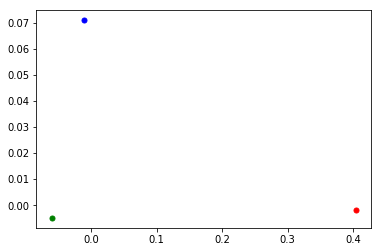

0
Êó•ÂéÜ
1
Á´ãÁßã
2
ÁôΩÈú≤
15.494175937752068


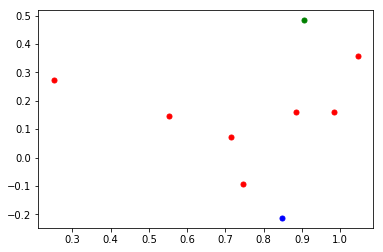

0
Â∏ÆÊàëËÑ±Ë∫´ ÊàëË¶ÅËÑ±Ë∫´ ËÑ±Ë∫´,Áé∞Âú® ÊàëÂ∏ÆÊàëËÑ±Ë∫´ ÁîµËØùÊèêÈÜíÊàëËÑ±Ë∫´ Êù•‰∏™ÁîµËØùÂ∏ÆÊàëËÑ±Ë∫´ ÊâìÁîµËØùÂ∏ÆÊàëËÑ±Ë∫´
1
ÂçÅÂàÜÈíüËÑ±Ë∫´
2
‰∏ÄÈîÆÂ∏ÆÊàëËÑ±Ë∫´
32.194702392319584


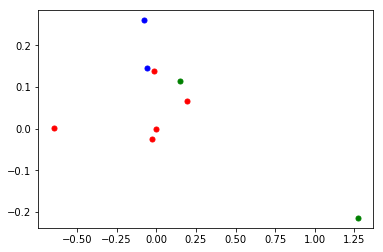

0
ËøôÊ†∑ÊèêÈÜíÊ≤°‰ΩúÁî® ÈÇÑÊ≤íÂà∞Èªû! Âπ∏ËøêÈ•ºÂπ≤ÊÄé‰πàÊ≤°Âë¢ ‰Ω†Ê≤°ÊåâÊó∂Âè´ÊàëËµ∑Â∫äÂïä Â∞èÊù•Âπ∂‰∏çÂáÜÊó∂
1
ÊÄé‰πàÊ≤°ÊèêÈÜíÊàë ÊÄé‰πàÊ≤°ÊèêÈÜíÂïä
2
ËøòÊ≤°Âà∞Êó∂Èó¥Â∞±ÊèêÈÜí Êó∂Èó¥‰∏çÂØπ
69.96373632335181


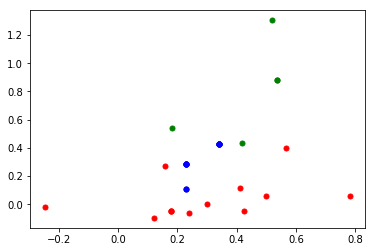

0
Â∑≤ÁªèÈîªÁÇº‰∫ÜÊÑüË∞¢ÊÇ®ÁöÑÊèêÈÜí Â•ΩÁöÑ,Ë∞¢Ë∞¢ÊèêÈÜí Â•Ω,Ë∞¢Ë∞¢ÊèêÈÜí Â•ΩË∞¢Ë∞¢ÊèêÈÜí. Ë∞¢Ë∞¢ÊèêÈÜíÂë¶ Â•ΩÁöÑ,Ë∞¢Ë∞¢ÊèêÈÜí„ÄÇ Â∞èÊù•Ë∞¢Ë∞¢‰Ω†ÁöÑÊåâÊó∂ÊèêÈÜí Ë∞¢Ë∞¢Â∑≤ÁªèÂú®ÂÅö‰∫Ü ËÆæÊèêÈÜí‰Ω† Â•ΩÁöÑ‰Ω†Â∑≤ÁªèÂÆåÊàê‰ªªÂä°Ë∞¢Ë∞¢ ÁúãÂà∞‰∫Ü,‰ªäÂ§©Â∞±‰π∞„ÄÇË∞¢Ë∞¢! Ë∞¢Ë∞¢ÂÆùË¥ù Ë¨ùË¨ù‰Ω†ÂÄëÁöÑÊîØÊåÅÔºåËÆìÊàëÁèæÂú®ÊØèÂ§©Êó©Áù°Êó©Ëµ∑
1
Ë∞¢Ë∞¢ÊèêÈÜí Ë∞¢Ë∞¢‰Ω†ÁöÑÊèêÈÜí. Ë∞¢Ë∞¢ÊèêÈÜí! Ë∞¢Ë∞¢,ÊèêÈÜíÊàë Ë∞¢Ë∞¢‰Ω†ÁöÑÊèêÈÜí Ë∞¢Ë∞¢ÊèêÈÜí, Ë∞¢Ë∞¢‰Ω†ÊèêÈÜíÊàë Ë∞¢Ë∞¢ÊèêÈÜí. Ë∞¢Ë∞¢‰Ω†ÊèêÈÜí Ë∞¢Ë∞¢ÊèêÈÜíÔΩû Ë∞¢Ë∞¢‰∫≤ÊèêÈÜí Ë∞¢Ë∞¢‰Ω†ÁöÑÊèêÈÜíÂì¶ Ë∞¢Ë∞¢ÊèêÈÜí„ÄÇ
2
ÊÑüË∞¢Â∞èÊù•ÊèêÈÜí ÊÑüË∞¢Âä©ÁêÜÁöÑÊèêÈÜí ÊÑüË∞¢Â∞èÊù•ÁöÑÊèêÈÜí Ë∞¢Ë∞¢Â∞èÊù•ÊèêÈÜí 2017ÊúÄÊÑüË∞¢‰∫≤Áà±ÁöÑÂ∞èÊù•
59.50197809631382


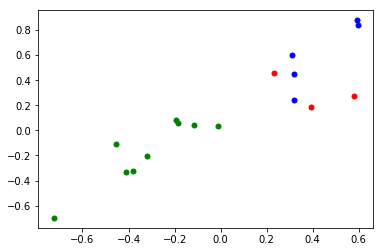

0
ÈùûVIPÁî®Êà∑,ËæìÂÖ•ËÆ¢ÈòÖ‰ºöÊúâÊú∫Âô®ÂõûÂ§çÂêó? ÊÇ®ËÉΩÂê¶‰ªãÁªç‰∏ãÂÖ≥‰∫éËÆ¢ÈòÖÁöÑ ÊÉ≥Áúã‰∏Ä‰∏ã‰ªäÂ§©ËÆ¢ÈòÖÁöÑÊñáÁ´†
1
ËÆ¢ÈòÖ Êúâ‰ªÄ‰πàËÆ¢ÈòÖ ÂéªËÆ¢ÈòÖ ÊàëËøòÊÉ≥ËÆ¢ÈòÖ ÂèØ‰ª•ËÆ¢ÈòÖ‰ªÄ‰πà
2
Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ Â§ñÂ©ÜÁöÑÁßÅÊàøËèú ‰ªÄ‰πàÂ§ñÂ©ÜÁöÑÁÅ∂Âè∞ Á∫¢ÁÉßËÇâÊÄé‰πàÂÅö ÁßÅÊàøËèú Êù•‰πü ÊúâËèúË∞±Âêó Â§ñÂ©ÜÁöÑ È∏°Áà™ÊÄé‰πàÂÅö ËèúË∞±
36.37086876898313


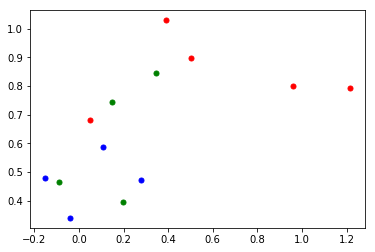

0
ÊïôËã±ËØ≠ Ëã±ËØ≠‰∏ç‰ºöËØªÊÄé‰πàÂäû? Â≠¶Ëã±ËØ≠ÁöÑÊÄé‰πàËÆ¢ ÊØèÂ§©ÂùöÊåÅÂ≠¶Ëã±ËØ≠ ËΩªÊùæÂ≠¶Ëã±ËØ≠
1
Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠Âú®Âì™ÈáåËÆ¢Ë¥≠. ÊÄé‰πàÊ†∑ÂèØ‰ª•Â≠¶Â•ΩËã±ËØ≠ Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠Âú®Âì™Èáå?ÊàëÊÉ≥Âê¨ Â∞èÊù•ÊúâÊ≤°ÊúâËã±ËØ≠ÊïôÁ®ã
2
Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠ Ê±™ËÄÅÂ∏àÂ≠¶Ëã±ËØ≠Âë¢? Ê±™ËÄÅÂ∏àËã±Êñá Ê±™ËÄÅÂ∏àÊÇ®Â•Ω
590.1876722116131


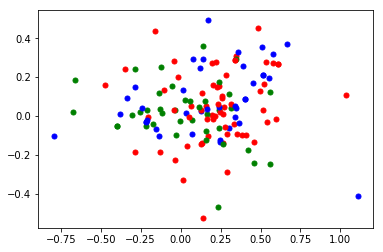

0
ËøêÁ®ã ÂèåÈ±ºÂ∫ß Â§ÑÂ•≥Â∫ß Â∑®ËüπÂ∫ß ÁôΩÁæäÂ∫ß Â§©ËùéÂ∫ß Â∞ÑÊâãÂ∫ß Ê∞¥Áì∂Â∫ß ÂèåÂ≠êÂ∫ß ÈáëÁâõÂ∫ß ÁãÆÂ≠êÂ∫ß Êë©ÁæØÂ∫ß Â§©Áß§Â∫ß ÂèåÈ±º Â∑®Ëüπ ÁôΩÁæä Êë©ÁæØ Ê∞¥Áì∂ ÈáëÁâõ ÂèåÂ≠ê Â§ÑÂ•≥ Â§©Ëùé ÊàëÊòØÂ§©ËùéÂ∫ß ‰ªäÂ§©ÁöÑËøêÁ®ã ÊúâËøë‰∏ÄÊúàÁöÑÂèåÈ±ºÂ∫ßËøêÁ®ãÂêó? ‰ªäÂ§©ÊòüËøê ‰ªäÂ§©Â§©ËùéËøêÊ∞î Â∞ÑÊâã Â∑®ËüπÂ∫ßÁöÑ‰∫∫Êúâ‰ªÄ‰πàÁâπÁÇπ? Â§©ËùéÂ∫ßÁî∑ÁîüÊÄßÊ†º ‰ªäÂ§©ËøêÁ®ã Êàë‰ªäÂ§©ËøêÊ∞îÊÄé‰πàÊ†∑ Êàë‰ªäÂ§©ËøêÊ∞îÂ•ΩÂêó? ÊàëÁöÑË¥¢ËøêÊÄé‰πàÊ†∑ Áà±ÊÉÖ ‰ªäÂ§©ÁöÑÂ§ÑÂ•≥Â∫ßÁ¨®‰∏çÁ¨®? ‰Ω†Â∏ÆÊàëÁúã‰∏Ä‰∏ã‰ªäÂ§©Â§©ËùéÂ∫ßÁöÑËøêÁ®ã ‰Ω†Â∏ÆÊàëÁúã‰∏Ä‰∏ãÂ§©ËùéÂ∫ßÁöÑ‰ªäÂ§©ÊòüÂ∫ßËøêÁ®ãÂ§©ËùéÂ∫ßÁöÑ ÁãÆÂ≠ê ‰∫åÈõ∂‰∏Ä‰∏ÉÂçÅ‰∫åÊúà‰ªΩÁöÑÊ∞¥Áì∂Â∫ßËøêÁ®ã ÊàëÊòØ‰∏çÁü•ÁÆóÂ§©Áß§ËøòÊòØÂ§©Ëùé Ë¥¢Ëøê ÊòéÂ§©‰ºöÊúâÂ•ΩËøêÂêó È≠îËùéÂ∫ß ÂèåÂ≠êÂ∫ßÂíåÂì™‰∏™ÊòüÂ∫ßÊúÄÈÖç Â∞èÊù•‰Ω†ËØ¥Êàë‰ªäÂ§©ËøêÊ∞îÊÄé‰πàÊ†∑ Ê∞¥Áì∂Â∫ßÁöÑÊúÄ‰Ω≥Â•ëÂêàÊòüÂ∫ß ÂèåÂ≠êÂ∫ßÁöÑÂπ∏ËøêÊÄé‰πàÊ†∑ Â§©Áß§ |ÂèåÂ≠êÂ∫ß‰ªäÂ§©ÁöÑËøêÁ®ã Â∞ÑÊâãÊë©ÁæØÊòüÂ∫ß Â§©Âπ≥Â∫ßÁöÑÂπ∏ËøêÁâ©ÂìÅÊòØ‰ªÄ‰πà Â∞è‰∏ªÊàëÊòØÂ§ÑÂ•≥Â∫ß Â∞èÂä©ÁêÜ ‰ªäÂ§©ÁôΩÁæäÁöÑÈÅãÁ®ãÂë¢ Â§©ÁîÅÂ∫ß ÂèåÈ±ºÂ∫ßÂíåÂ∞ÑÊâãÂ∫ß 

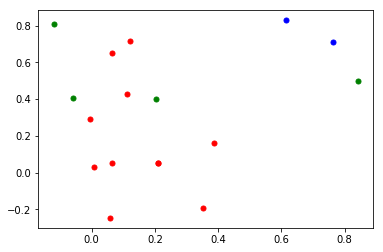

0
ÊúÄËøëÊúâ‰ªÄ‰πàÂ•ΩÁúãÁöÑÁîµÂΩ±? Êâæ‰∏™ÁîµÂΩ± ËøëÊúüÁîµÂΩ± ÊúÄÊñ∞‰∏äÊò†ÁîµÂΩ± ÊúÄÁÉ≠ÁîµÂΩ± Ëøô‰∏™ÊúàÁöÑÁîµÂΩ±ÊúâÂì™‰∫õ? ËæõÁâπÂãíÁöÑÂêçÂçï ÊúÄËøëÊúâ‰ªÄ‰πàÂ•ΩÁúãÁöÑÁîµÂΩ± Êúâ‰ªÄ‰πàÂ•ΩÁúãÁîµÂΩ±Êé®ËçêÂêó Êúâ‰ªÄ‰πàÂ•ΩÁîµÂΩ± Ëøô‰∏§Â§©Êîæ‰ªÄ‰πàÁîµÂΩ±
1
Êñ∞ÁîµÂΩ± ÁîµÂΩ±‰∏äÊñ∞
2
ÁîµÂΩ± ÁúãÁîµÂΩ± ÊúÄËøëÊúÄÁÅ´ÁöÑÁîµÂΩ±ÊòØ‰ªÄ‰πàÁîµÂΩ± ÊúÄËøëÁîµÂΩ±
98.42762076951571


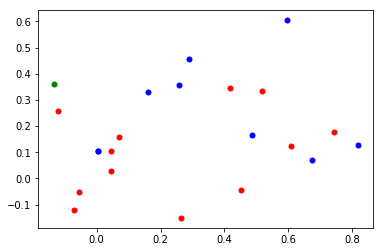

0
ËµÑËÆØ Êó©Êó•Êñ∞Èóª Êó©Èó¥Êñ∞Èóª Êñ∞ÈóªËµÑËÆØ Êñ∞ÈóªÊó©Áè≠ËΩ¶ ÂÖ´Âç¶ Êù•ÁÇπÊñ∞ËµÑËÆØ 24Â∞èÊó∂Êñ∞Èóª 24Â∞èÊó∂ÁÆÄÊä• ËøáÂéª24Â∞èÊó∂Êñ∞ÈóªÁÆÄÊä• ÊúÄËøëÊúâ‰ªÄ‰πàÂ®±‰πêÊñ∞Èóª ÊúÄËøëÊúâ‰ªÄ‰πàÊñ∞È≤ú‰∫ã
1
Êñ∞Èóª Êù•‰πüÊñ∞Èóª Êñ∞ÈóªÂë¢ ËÆ¢ÈòÖÊñ∞Èóª ÈáëËûçÊñ∞Èóª ËÖæËÆØÊñ∞Èóª Êó©Êñ∞Èóª ÊúÄËøëÁöÑÊñ∞Èóª ÊØèÂ§©Êé®ÈÄÅÊúÄÊñ∞Êñ∞Èóª
2
ÂõΩÈôÖÊñ∞Èóª
0.0


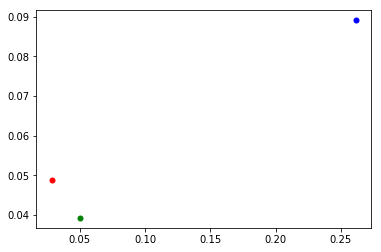

0
ÂΩ±ËÆØ
1
ÊúÄÊñ∞ÁîµÂΩ±
2
ÊàòÁãº2
31.857460953553822


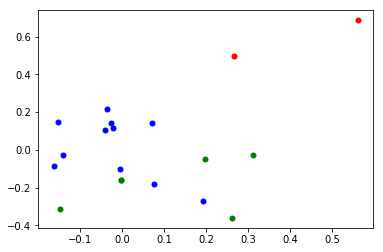

0
ÂèØ‰ª•ÁîªÁîªÂêó ÁªôÊàëÁîªÁîª
1
ÊàëÁâπÂà´ÂñúÊ¨¢ÊâãÁªò,‰∏çÁü•ÈÅìÊúâÊ≤°ÊúâÊâãÁªò ÁîüÊàê‰∏ÄÂâØÊâãÁªòÁîª ÊÄé‰πà‰π∞ÁªòÊú¨ ÊâãÁªòÁîªÊ≤πÁîªÂêó? ÊàëÁöÑÊâãÁªòÂë¢ ÊâãÁªò ÁªôÊàëÁîª‰∏™ÊâãÁªò ÁªôÊàëÁîªÂπÖÊâãÁªò ÁªôÊàëËä±Ëä± ÁªôÊàë‰∏ÄÂπÖÊâãÁªò Êù•‰∏ÄÂâØÊâãÁªò
2
ÁªôÊàëÁîª‰∏ÄÂπÖÊâãÁªò ÁªôÊàëÁîª‰∏ÄÂº†ÈìÖÁ¨îÁîª ‰Ω†Âú®ÁîªÊâãÁªòÂêó ÁîªÊâãÁªò ÁªôÊàëÁîª‰∏ÄÂπÖÁîª ÁªôÁîªÊàë‰∏ÄÂπÖÊâãÁªò
142.51592593722808


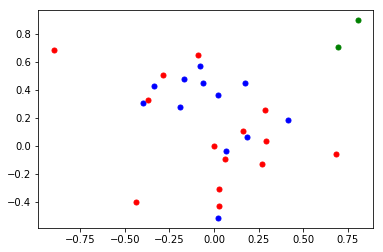

0
Â§áÂøò50 ‰Ω†ËØ¥ÁöÑËÆ∞Ë¥¶,Âú®Âì™ÈáåËÆ∞,Êàë‰∏çÂ§™Ê∏ÖÊ•ö,ËØ∑ÊåáÊïô ÁªèÊúüÊòØ‰ªäÂ§©ÂºÄÂßã Â§ßÂß®Â¶à ‰æãÂÅá ‰ΩìÈáç126.4 ‰∏§Â§©20 ÊàëËä±‰∫Ü‰∫îÂçÅÂùó 14Âè∑Êù•Â§ßÂß®Â¶à ÊØèÂ§©ËÆ∞Ë¥¶ ÁúãÁúã‰∏Ä‰∏™ÊúàÈí±Áî®Âú®‰ªÄ‰πàÂú∞Êñπ ÂíãËÆ∞ÂëÄ lËÆ∞ÂΩï‰∏ìÁî® Êàë‰ªÄ‰πàÊó∂ÂÄôÊù•ÁöÑÂ§ßÂß®Â¶à Ë∫´È´ò‰∏ÄÁ±≥‰∏ÉÂÖ´‰ΩìÈáç‰∏ÄÁôæÂÖ´
1
Â¶Ç‰ΩïËÆ∞Ë¥¶ ËÆ∞Ë¥¶ÂäüËÉΩ ÂèØ‰ª•ËÆ∞Ë¥¶Âú®‰ªñÈÇ£ÈáåÂêó Â∞èÊù•,‰Ω†‰ºöËÆ∞Ë¥¶Âêó? ÊúÄÂ•ΩËøòÊúâËÆ∞Ë¥¶ÂäüËÉΩÂ∞±Êõ¥Â•Ω‰∫Ü Â∏åÊúõÂ∞èÊù•‰ª•ÂêéÂ¢ûÂä†ÁêÜË¥¢ÊñπÈù¢ÁöÑÂäüËÉΩ ÂØÜÁ†Åd1314001 ÊÄé‰πàËÆ∞Ë¥¶ ÈÇ£ÊàëËØ•ÊÄé‰πàËÆ∞Ë¥¶Âë¢? Êàë‰∏ç‰ºöËÆ∞Ë¥¶ ÊàëË¶ÅËÆ∞Ë¥¶ ÊòéÂ§©ÂèÆÂíöÊî∂Ê¨æÂª∫Ë°åÂà∞Ë¥¶18600
2
‰∏ÄÈîÆÂ§áÂøò ‰∏ÄÈîÆ
0.0


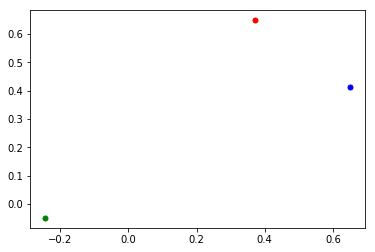

0
ÊÄé‰πàÊü•ÁúãËÆ∞Ë¥¶
1
‰∏ÄÈîÆÂ§áÂÆåÊÄé‰πàÊü•ËÆ∞ÂΩïÂïä
2
ÊàëÊÉ≥ËÆ∞ÁÇπ‰∫ãÊÄé‰πàÊ≤°ÁúãËßÅ
0.0


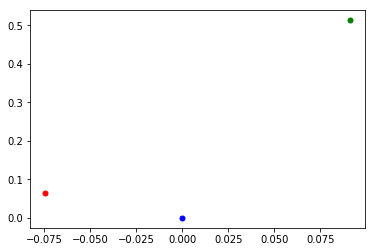

0
‰ªÄ‰πàÊó•Â≠êÂ•Ω
1
ËÄÅÈªÑÂéÜ
2
ÊÄé‰πàËÆ¢ÈòÖËÄÅÈªÑÂéÜ
250.31580876735956


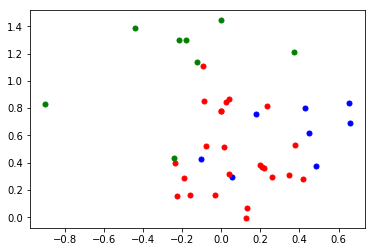

0
Â§©Ê∞îÊúâÊòéÊòæÂèòÂåñ‰πãÂâçËØ∑ÊèêÈÜíÊàë ÊèêÈÜíÊàëÂÆâÂ∫Ü‰∏ã‰∏ç‰∏ãÈõ®Â∞±Â•Ω‰∫Ü ÂèñÊ∂àÈ©¨ÈûçÂ±±ÁöÑÂ§©Ê∞îÊèêÈÜíÂêß Â§©Ê∞îÊèêÈÜíÂá∫bug‰∫Ü  ÁªôÊàëËøûÂèë‰∫Ü10Âá†Êù°ÊèêÈÜí  ËøòÂú®Âèë ÊèêÈÜíÊàëÊØèÂ§©Êó©‰∏ä9ÁÇπÈíüÂΩìÊó•Â§©Ê∞îÈ¢ÑÊä• ÊØèÂ§©Êó©‰∏ä9ÁÇπÂëäËØâÊàëÂΩìÊó•Â§©Ê∞îÊÉÖÂÜµ ÁîµËØùÊèêÈÜíÊàëÊØèÂ§©7ÁÇπ10ÂàÜÁÇπÈÇØÈÉ∏ÂπøÂπ≥Â§©Ê∞î ÊòéÂ§©ÂÜ∑Âêó ÊòéÂ§©‰ªÄ‰πàÊó∂ÂÄôÂºÄÂßã‰∏ãÈõ® ÂÆøËøÅÂ§©Ê∞îÊèêÈÜí ‰ªäÂ§©‰ºöÂÜ∑Âêó? Âåó‰∫¨ÈÇ£ËæπÁé∞Âú®ÂÜ∑‰∏çÂÜ∑ÂÜ∑ 10Êúà28Ê∏©Â∑ûÂ§©Ê∞î 10Êúà29Ê∏©Â∑ûÂ§©Ê∞î 10Êúà30Êù≠Â∑ûÂ§©Ê∞î ËçÜÈó®Â§©Ê∞î ‰ªÄ‰πàÊó∂ÂÄôÊâçÊúâÂ§™Èò≥ Ë•øÂÆâÊúâÊ≤°ÊúâÈõæÈúæ ÁõäÈò≥Â§©Ê∞îÊ∏©Â∫¶Â§öÂ∞ë ‰ªäÂ§©ÁõäÈò≥Â§©Ê∞îÊÄé‰πàÊ†∑ ÁéâÊ∫™Á†îÂíåÂå∫Â§©Ê∞î ÂÜ∑‰∏çÂÜ∑ ÈõæÈúæÊúâÂêó ÊòéÂ§©Â§©Êô¥Âêó Áé∞Âú®Âú®‰∏ãÈõ®‰Ω†Êä•Â§ö‰∫ëË¶Å‰Ω†‰ΩïÁî®
1
‰ª•ÂêéÊØèÂ§©Êó©‰∏äÊèêÈÜíÊàëÂ§©Ê∞îÊÉÖÂÜµ„ÄÇ ‰ª•ÂêéÊØèÂ§©ÊèêÈÜíÊàëÁ©∫Ê∞îË¥®Èáè„ÄÅÂ§©Ê∞îÈ¢ÑÊä•ÂíåÊòüÂ∫ßËøêÂäø„ÄÇ ÂèØ‰ª•ÊØèÂ§©ÊèêÈÜíÊàëÂ§©Ê∞îË∑üÊòüÂ∫ßËøêÁ®ãÂêóÔºü ÊØèÂ§©ÈÉΩË¶ÅÊèêÈÜíÊàëÂ§©Ê∞îÂì¶„ÄÇ ÊØèÂ§©ÊèêÈÜíÊàëÂ§©Ê∞îÈ¢ÑÊä• ‰ª•ÂêéÊØèÂ§©ÊèêÈÜíÊàëÂ§©Ê∞îÈ¢ÑÊä• ÊØèÂ§©ÁªôÊàëÂèëÂ§©Ê∞îÈ¢ÑÊä• ÊØèÊó•Â§©Ê

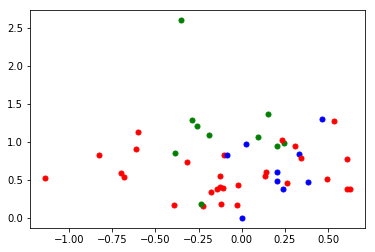

0
ÊòéÂ§©Â±±Ë•øÂ§™ÂéüÂ§©Ê∞îÈ¢ÑÊä• ‰ªäÂ§©Ê∏©Â∫¶ ‰ªäÊó•Ê∞îÊ∏© Â§©Ê∞îÔºåËøû‰∫ëÊ∏ØÂ∏ÇÁÅå‰∫ë ‰ªäÂ§©ÁöÑÂ§©Ê∞îÊÄé‰πàÊ†∑Ôºü ÊúâÈõ®Âêó Âåó‰∫¨ÁöÑÊ∏©Â∫¶ ÂÖ≥‰∫éÂ§©Ê∞îÁöÑÊù•‰∏ÄÊÆµ„ÄÇ Ê∞∏Êµé‰∏ÄÂë®Â§©Ê∞î ÁéâÊ∫™Á†îÂíåÂå∫Â§©Ê∞î Âë®Âè£Â§©Ê∞îÂ∞èÊù• ËååÂπ≥Â§©Ê∞îÈ¢ÑÊä• ‰ªäÂ§©Â§©Ê∞îÊÄé‰πàÊ†∑ Âåó‰∫¨‰∏ÄÂë®ÂÜÖÂ§©Ê∞î ÊòéÂ§©Âçó‰∫¨Â§©Ê∞îÊÄé‰πàÊ†∑ ‰∏äÊµ∑Êú™Êù•‰∏ÉÂ§©Â§©Ê∞î È°∫Âæ∑Â§©Ê∞î Â∏ÆÊàëÊü•ËØ¢‰∏ãÊòéÂ§©‰∫îÂè∞Â±±Â§©Ê∞îÈ¢ÑÊä• ‰ªäÂ§©Âåó‰∫¨Â§©Ê∞îÂ¶Ç‰Ωï ÁëûÈáëËøëÂçÅÂ§©ÁöÑÂ§©Ê∞î Êü•‰∏Ä‰∏ãÊòéÂ§©Êó©‰∏äÁöÑÂ§©Ê∞î Ëµ§Ê∞¥ÁöÑÂ§©Ê∞î Â§©Ê∞îÊÄé‰πàÊ†∑ ‰∏äÊµ∑‰ªäÂ§©Â§©Ê∞îÊÄé‰πàÊ†∑ ÊòéÂ§©ÁöÑÂ§©Ê∞î‰ºöÊÄé‰πàÊ†∑ ‰ª•ÂêéÂèëË•øÂÆâÁöÑÂ§©Ê∞î‰∏çË¶ÅÂÜçÂèëÂåó‰∫¨‰∫Ü,ÊàëÂú®Ë•øÂÆâÂë¢ ‰∏âÂ§©Â§©Ê∞îÊÄé‰πà ‰ªäÂ§©Á©∫Ê∞îË¥®ÈáèÂ•Ω‰∏çÂ•Ω? Ë•øÂÆÅ‰∏ÄÂë®Â§©Ê∞î
1
‰ªäÂ§©Â§öÂ∞ëÂ∫¶ ‰ªäÂ§©ÂÜ∑Âêó Â∞èÊù•ÔºåÊòéÂ§©Âá†Â∫¶ Ê≤àÈò≥‰ªäÂ§©ÂÜ∑ËøòÊòØÊò®Â§©ÂÜ∑ ‰ªäÂ§©ÂÜ∑‰∏çÂÜ∑ ‰ªäÂ§©Â§ñÈù¢ÂÜ∑‰∏çÂÜ∑Âë¢ Â§©Ê∞£ ËöåÂü†‰ªäÂ§©ÊúâÈ£éÂêó ‰∏äÊµ∑‰ªäÂ§©‰∏ãÈõ®Âêó
2
ÊòéÂ§©ÁöÑÂ§©Ê∞î Á©∫Ê∞îË¥®Èáè ÂÆÅÊ≥¢Â§©Ê∞î ÈïøÊ≤ôÂ§©Ê∞îÈ¢ÑÊä• ÈáçÂ∫ÜÂ§©Ê∞î ‰∏ÄÂë®Â§©Ê∞î ‰ªäÊó•Â§©Ê∞î Â§ßËøûÂ§©Ê∞î ‰ªäÂ§©Âåó‰

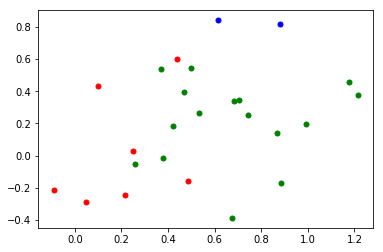

0
Ê±™ËÄÅÂ∏àÊïô‰Ω†Â≠¶Ëã±ËØ≠‰ªäÂ§©Ê≤°ÊúâÊé®ÈÄÅ ÊàëÂ∞±ÊòØÁúãÂèë‰∫ÜÂ§ñÂ©ÜÁöÑÁÅ∂Âè∞,Âç¥‰ªÄ‰πàÂÜÖÂÆπ‰πüÊ≤°Êúâ„ÄÇ‰∏çÁü•ÈÅìÂíãÂõû‰∫ã ÂØåÁà∏Áà∏Ë¥¢ÂØåÂïÜÂ≠¶Èô¢Áî®‰∏ç‰∫Ü? ÈÇ£‰∏™ÊòüÂ∫ß‰ªäÂÑøÁöÑÂú®Âì™ËÉΩÊü•Âà∞? ÈÇ£‰Ω†ÊàëÁöÑÊòüÂ∫ßÊêûÈîôÂï¶!‰Ω†ËÉΩ‰∏çËÉΩÁ©∫Ë∞ÉËøáÊù•Âïä? ÂæàÈïøÊó∂Èó¥Ê≤°ÊúâÊé®ÈÄÅ‰∫Ü,ÂéªÂπ≤Âòõ‰∫Ü ‰Ω†‰ªñÂ¶à¬†¬†‰∏∫‰ªÄ‰πàÊó©‰∏ä‰∏çÁªôÊàëÂèë
1
ËÆ¢ÈòÖÊèêÈÜí Êü•ÁúãËÆ¢ÈòÖ
2
ËÆ¢ÈòÖÊèêÈÜí‰ªäÂ§©ÊÄé‰πàÊ≤°ÁªôÊàëÂèë ËÆ¢ÈòÖÊî∂‰∏çÂà∞Êé®ÈÄÅ ËÆ¢ÈòÖÁ±ªÁõÆÈáå‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂÜÖÂÆπ Ê≤°ÊúâÊâæÂà∞‰Ω†‰ª¨Êé®ÈÄÅÁöÑÂÜÖÂÆπ ÁÇπÂáªËÆ¢ÈòÖÊ±áÊÄªÂ∞±Êî∂Âà∞‰∏Ä‰∏™ÁΩëÂùÄ Êâì‰∏çÂºÄ ‰∏∫‰ªÄ‰πàËÆ¢ÈòÖÁöÑÊ≤°ÊúâÂáÜÊó∂ÂèëÊù•???? ÊÄé‰πàÊàëÁöÑËÆ¢ÈòÖÈÉΩÊ≤°ÊúâÁúãÂà∞ÂèëÁªôÊàëËøáÂòû ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÁªôÊàëÂèëËÆ¢ÈòÖ ÊàëÂÆöÁöÑËøô‰∏™Âíã‰∏çÁªôÊàëÊé®ÈÄÅ‰∫Ü? ‰∏∫‰ªÄ‰πàÂæàÂ§öËÆ¢ÈòÖÈÉΩÊ≤°ÊúâÊé®ÈÄÅÂë¢? ÊÄé‰πàËÆ¢ÈòÖ‰∫Ü‰πü‰∏çÊé®ÈÄÅ ‰ªäÂ§©Ê≤°ÊúâÊé®ÈÄÅÂïä ÊàëÊî∂‰∏çÂà∞ÊàëÁöÑËã±ËØ≠Êé®ÈÄÅÂë¢ ËÆ¢ÈòÖÁöÑÂá†‰πéÈÉΩÊ≤°ÊúâÂèëËøáÊù• ÊàëÁöÑËÆ¢ÈòÖÊÄé‰πàÊî∂Âà∞ ‰∏∫‰ªÄ‰πàÊî∂‰∏çÂà∞ÊØèÊó•ËÆ¢ÈòÖ
271.1876555961146


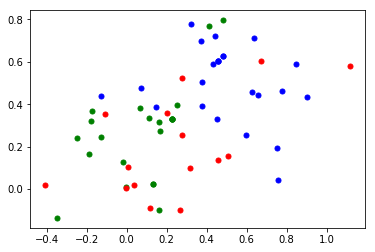

0
ÈÄÄËÆ¢ ËÆ¢ÈòÖÁöÑ,ÊÄé‰πàÈÄÄËÆ¢? ËÆ¢ÈòÖÁöÑÂÜÖÂÆπ,ÊÄé‰πàÈÄÄËÆ¢? ÂèñÊ∂àÊòüÂ∫ß,Ë∞¢Ë∞¢ ÂèñÊ∂àÊòüÂ∫ßÂÆöÈòÖ ÂèñÊ∂àÊñ∞Èóª ‰∏çË¶ÅÊØèÂ§©Êó©‰∏äÁªôÊàëÂèëÂ§©Ê∞î‰∫Ü ÊääËøô‰∏™ÂàÆÈ£é‰∏çÂàÆÈ£éÂèñÊ∂àÂêß ÊÄé‰πàÂèñÊ∂àËøô‰∫õ‰∏úË•øÂïäÊúâ‰∫õÁî®‰∏çÁùÄ ÈÄÄËÆ¢Êñ∞ÈóªÁÆÄÊä• ÈÄâÈîôÊòüÂ∫ßÊÄé‰πàËâπ Â¶Ç‰ΩïÈÄÄËÆ¢ ÊÄé‰πàÂéªÈô§ÊòüÂ∫ßËøô‰∏ÄÂùó ÂèñÊ∂àÊä•Â§©Ê∞îÈ¢ÑÊä• ÊÄéÊ†∑ÊääÁÆóÂëΩÁöÑÈÇ£‰∏™Â°îÁΩó Âà†Êéâ
1
ÂèñÊ∂àËÆ¢ÈòÖ ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖ Â¶Ç‰ΩïÂèñÊ∂àËÆ¢ÈòÖ ËÆ¢ÈòÖÁöÑ‰∏úË•ø,ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖ ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖ? ÊÄé‰πàÂèñÊ∂àÊüê‰∫õËÆ¢ÈòÖ ËØ∑ÈóÆÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖÂë¢ ËÆ¢ÈòÖÊèêÈÜíÊÄé‰πàÂèñÊ∂à ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖÊèêÈÜí ÊÄé‰πàÈÄÄËÆ¢ËÆ¢ÈòÖÂïä ÊÄé‰πàÈÄÄËÆ¢Â∑≤ËÆ¢ÈòÖÁöÑ ÊÄé‰πàÊ†∑ÂèñÊ∂àËÆ¢ÈòÖ ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖÁöÑÊ∂àÊÅØ ÊÄé‰πàÂèñÊ∂àËÆ¢ÈòÖ‰ø°ÊÅØ? ËÆ¢ÈòÖÁöÑÊúçÂä°ÊÄé‰πàÂèñÊ∂à ÊàëÊÉ≥ÈóÆ‰∏ãËÆ¢ÈòÖÊÄé‰πàÂèñÊ∂à ÈÄÄËÆ¢ËÆ¢ÈòÖ ÊÄé‰πàÂà†Èô§ËÆ¢ÈòÖ ‰∏çÊé•ÂèóÊé®ËçêËÆ¢ÈòÖ‰ø°ÊÅØ ÊàëÂèñÊ∂àËÆ¢ÈòÖ ÊàëÁöÑËã±ËØ≠ËÆ¢ÈòÖÊÄé‰πàÂèñÊ∂à‰∏ç‰∫ÜÂë¢ ‰∏çÊÉ≥ËÆ¢ÈòÖËã±ËØ≠‰∫Ü ÂèñÊ∂àÊó•ÂéÜÊé®ÈÄÅÊ∂àÊÅØ ÂèñÊ∂àÁöÑËÆ¢ÈòÖ‰∏∫‰ªÄ‰πàÊØèÂ§©ÈÉΩÊî∂Âà∞Âë¢
2
ÊÄé‰πàÂèñÊ∂àÊòüÂ∫ßËÆ¢ÈòÖ Ëøò

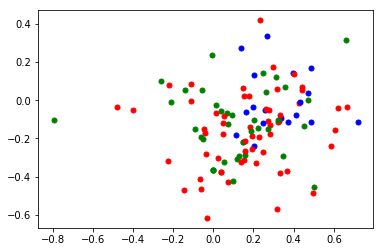

0
ÊòüÂ∫ßËøêÂäøÈáåÈù¢Ê≤°ÊúâÂÜÖÂÆπ dateÊÄé‰πàÊ≤°ÊúâÊòüÂ∫ßËøêÂäøÂïä Ê≤°ÊúâÊé®ÈÄÅÊòüÂ∫ßÊ∂àÊÅØ ‰∏∫‰ªÄ‰πàÊòüÂ∫ßÁ™ÅÁÑ∂‰∏çÊé®ÈÄÅ‰∫Ü ‰∏∫‰ªÄ‰πàÊ≤°ÁªôÊàëÊòüÂ∫ßËøêÂäøÁöÑÂç°ÂëÄ? ÊòüÂ∫ßÊ≤°Êù• ‰∏∫‰ªÄ‰πàÊòüÂ∫ß‰∏çÂá∫Êù•? ÊÇ®Â•Ω!ÊÄé‰πàÊ≤°Êî∂Âà∞‰ªäÂ§©ÁöÑËøêÂäø ‰∏∫‰ªÄ‰πàÊòüÂ∫ßÁöÑÂá∫‰∏çÊù• Ê≤°Êä•‰ªäÂ§©ËøêÂäø ÊòüÂ∫ßËøúÈîô‰∫Ü ËøêÂäøÊ≤°ÊúâÊñáÂ≠ó ÊòüÂ∫ßËøêÂäø‰∏∫Âï•‰ºöÂá∫Áé∞Á©∫ÁôΩ ÊòüÂ∫ßËøêÂäø‰∏ÄÁâáÁ©∫ÁôΩÊÄé‰πàÂõû‰∫ã ÊòüÂ∫ßÊÄé‰πàÊ≤°ÊúâÂë¢ ÊòüÂ∫ß‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂÜÖÂÆπÂë¢ ÊòüÂ∫ß‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂÜÖÂÆπ ‰Ω†Â•Ω!ÊÄé‰πà‰ªäÂ§©ÁöÑÊòüÂ∫ßËøêÂäøÊòØÁ©∫ÁöÑ ‰ªäÂ§©ÁöÑËøêÂäøÊÄé‰πàÊ≤°ÊúâÂ≠ó ‰ªäÂ§©ÁöÑËøêÂäøÊÄé‰πà‰ªÄ‰πàÈÉΩÊ≤°Êúâ ‰ªäÂ§©ÁöÑÊòüÂ∫ßËøêÂäøÊÄé‰πàÊòØÁ©∫ÁöÑ ‰ªäÂ§©ÊòüÂ∫ßÊÄé‰πàÊ≤°Êúâ ‰∏∫‰ªÄ‰πàÊòüÂ∫ßËøêÂäø‰∏äÈù¢Ê≤°ÊúâÂ≠ó ‰∏∫‰ªÄ‰πàÊàëÁöÑÊòüÂ∫ßËøêÂäøÈáå‰ªÄ‰πàÈÉΩÊ≤°Êúâ ‰∏∫‰ªÄ‰πà‰ªäÂ§©ÁöÑÊòüÂ∫ßËøêÂäøÊ≤°ÊúâÂÜÖÂÆπ ÊàëÁöÑÊòüÂ∫ßÂ∞±ËøôÊ†∑Á©∫ÁôΩÂêó Á©∫ÁôΩ„ÄÇ‰ªäÊó•Êó†ËØ≠ÂêóËøêÂäø ‰ªäÊó•ÊòüÂ∫ßÊòØÁ©∫ÁôΩ ‰ªäÊó•ÊòüÂ∫ßÂÅ∑Êáí‰∫Ü ‰ªäÂ§©ÁöÑÊòüÂ∫ßËøêÂäøÊÄé‰πàÊòØÁ©∫ÁôΩ ‰ªäÂ§©ÁöÑÊòüÂ∫ßÊ≤°ÊñáÂ≠ó ‰ªäÂ§©ÊòüÂ∫ßÊé®ÈÄÅÊòØÁ©∫ÁöÑÊòØ‰ªÄ‰πàÊÑèÊÄù ‰ªäÂ§©ÊòüÂ∫ß‰

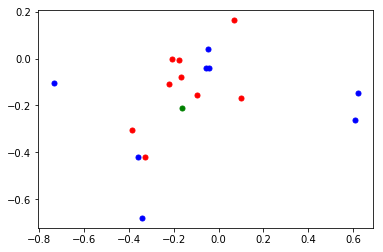

0
Â∏ÆÊàë‰π∞Âº†ÁîµÂΩ±Á•® Â∏ÆÊàë‰π∞Âº†ÁîµÂΩ±Á•®, ÂÆöÂº†ÁîµÂΩ±Á•® ÁªôÊàëÊâæ‰∏™ÁîµÂΩ±Á•®, Â∏ÆÊàë‰π∞‰∏ÄÊú¨„ÄäÂäõÈáè„ÄãÁöÑ‰π¶ ÊàëË¶Å‰π∞‰∏™Ê¶®Ê±ÅÊú∫ ËÉΩÁ∫¶Âçé‰∏∫mate10Âêó ÁëûÂ£´1000Â∑¶Âè≥ÁöÑË°®‰ªÄ‰πàË°®Â•Ω ‰π∞ÁîµÂΩ±Á•®„ÄäËá≥Áà±Ê¢µÈ´ò„Äã
1
‰π∞ÁîµÂΩ±Á•® ÂÆöÁîµÂΩ±Á•® Â∏ÆÊàëËÆ¢ÁîµÂΩ±Á•® ËÆ¢ÁîµÂΩ±Á•® ‰π∞‰∏§Âº†ÁîµÂΩ±Á•® ÂèØ‰ª•Â∏ÆËÆ¢ÁîµÂΩ±Á•®Âêó? ÊàëÊü•Êü•ÁîµÂΩ±Á•® Â∏ÆÊàëËÆ¢‰∏ÄÂº†Âº†Â≠¶ÂèãÊºîÂî±‰ºöÈó®Á•®
2
ÊÄé‰πà‰π∞‰∏úË•øÂïä
160.4236701899306


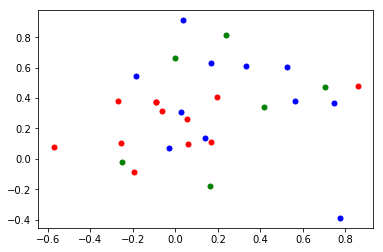

0
ÊÄé‰πàËÆ¢ÈòÖÊòüÂ∫ßËøêÂäø ËÆ¢ÈòÖÊòüÂ∫ßËøêÂäø ËÆ¢ÈòÖÊòüÂ∫ß ÊòüÂ∫ßËÆ¢ÈòÖ Êàë‰∏ç‰ºöËÆ¢ÈòÖÊòüÂ∫ß ÊòüÂ∫ßÊé®ÈÄÅ ÊòüÂ∫ßËøêÂäøÈÄüÂ∫¶ ÊàëË¶ÅÂÖ®ÈÉ®ÊòüÂ∫ßËøêÂäø ÊØèÊó•ËøêÂäø ÊÄé‰πàËÆæÁΩÆÊòüÂ∫ß ÊàëÁöÑÊòüÂ∫ßËøêÂäø ËÆ¢ÈòÖÊòüÂ∫ßÊü•ËØ¢
1
ÊÄé‰πàËÆ¢ÈòÖÂ§©Ê∞îÈ¢ÑÊä• ÊÄé‰πàÊâæËÆ¢ÈòÖ ÊÄé‰πàÁúãËÆ¢ÈòÖ‰∫ÜÁöÑÂÜÖÂÆπ ËÆ¢ÈòÖÂú®Âì™ÈáåÊâæÔºü ÂèØÊòØÊâæ‰∏çÂà∞ÂàöÂàöËÆ¢ÈòÖÁöÑÈÇ£‰∏™‰∫Ü Âú®Âì™ÈáåÂèØ‰ª•Êü•ËØ¢Âà∞ËÆ¢ÈòÖÁöÑÈ°πÁõÆ ÊòüÂ∫ßÂè™ËÉΩËÆ¢ÈòÖ‰∏Ä‰∏™Âêó ÊàëÁöÑËÆ¢ÈòÖ Âì™ÈáåËÆ¢ÈòÖÂëÄ ÂÆöÊó∂Êé•Êî∂ËÆ¢ÈòÖ ÂèñÊ∂à‰πãÂêéÂ¶Ç‰ΩïÈáçÊñ∞ËÆ¢ÈòÖ
2
ÂèëÂΩìÊó•Â§©Ê∞îÈ¢ÑÊä• Ë•øÂÆâÊúâÊ≤°ÊúâÈõæÈúæ È¢ÑÊä•Â§©Ê∞î ÊàëÂ•ΩÂÉèÊòØËÆ¢ÈòÖ‰∏§‰∏™ ‰∏Ä‰∏™ÊòüÂ∫ßËøêÂäø ËøòÊúâ‰∏Ä‰∏™ÊòØ‰ªÄ‰πàÊØèÂ§©‰∏ÄÂè•Êô®ËØ≠  Áé∞Âú®Êâæ‰∏çÂà∞Âú®Âì™Èáå‰∫Ü ÊòüÂ∫ßÂÆöÈòÖ ÊØèÊó•Ë®ÇÈñ±
11.486260461273055


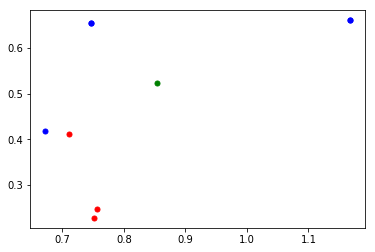

0
‰øÆÊîπËÆ¢ÈòÖÊó∂Èó¥Êó†Êïà ÊÄé‰πàËÆæÁΩÆËÆ¢ÈòÖÊé®ÈÄÅÊó∂Èó¥ ËÆ¢ÈòÖÊõ¥Êñ∞È¢ëÁéá
1
ÊÄé‰πà‰øÆÊîπËÆ¢ÈòÖ ËÆ¢ÈòÖÊÄé‰πà‰øÆÊîπ ‰øÆÊîπËÆ¢ÈòÖ ËÆ¢ÈòÖ‰øÆÊîπ ÊÄé‰πàÊîπËÆ¢ÈòÖ
2
ÊÄé‰πà‰øÆÊîπ
16.417828547668044


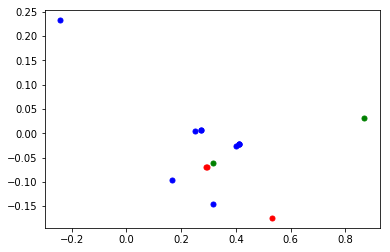

0
ËØ∑ÈóÆ,ÊòüÂ∫ßÂÆâÈò¥ÂéÜÈò≥ÂéÜ? Èò¥ÂéÜ  Èò≥ÂéÜ ÊàëÂàÜ‰∏çÊ∏Ö ÂÖ¨ÂéÜÊòØÂÜúÂéÜÂêó?
1
ÊòüÂ∫ßÊåâÈò≥ÂéÜËøòÊòØÈò¥ÂéÜ ÊòüÂ∫ßÊòØÊåâÈò¥ÂéÜËøòÊòØÈò≥ÂéÜ ÊòüÂ∫ßÊòØÈò¥ÂéÜËøòÊòØÈò≥ÂéÜ ÊòüÂ∫ßÊòØÊåâÈò≥ÂéÜËøòÊòØÈò¥ÂéÜ? ÊòüÂ∫ßÊåâÂÜúÂéÜËøòÊòØÈò≥ÂéÜ ÊòüÂ∫ßÊòØÊåâÂÜúÂéÜËøòÊòØÊåâÈò≥ÂéÜÂïä Ëøô‰∏™ÊòüÂ∫ßÊåâÁÖßÂÜúÂéÜËøòÊòØÈò≥ÂéÜ ÊòüÂ∫ßÊòØÊåâÈò≥ÂéÜÁöÑËøòÊòØÊåâÂÜúÂéÜÁöÑ? ÊòüÂ∫ßÊÄé‰πàÂàÜ?Èò≥ÂéÜ? ÊòüÂ∫ßÁúãÈò≥ÂéÜÂÜúÂéÜ
2
ÊåâÈò≥ÂéÜÁÆóËøòÊòØÂÜúÂéÜÁÆóÊó∂Èó¥ ÊòüÂ∫ßÊòØÊåâÈò≥ÂéÜÁÆóÂêó
47.788323004441125


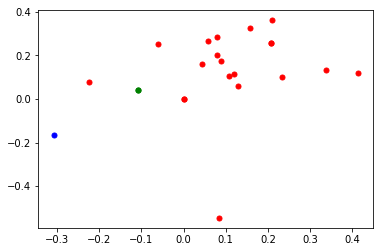

0
Âç†Âçú ‰Ω†‰ºöÂç†ÂçúÂêó Â°îÁΩóÂç†Âçú ÊÉ≥Âç†Âçú Â°îÁΩóÁâåÊ≤°‰∫∫ÁêÜÂïä Âç†Âçú‰∏çË¶ÅÈí±Âêó? Âç†‰ªÜ Â¶Ç‰ΩïÂç†Âçú Â¶Ç‰ΩïÂä©‰∫ã‰∏ö ÊÄé‰πàÂç†ÂçúÂë¢? ÊÉ≥Âç†ÂçúÊÄé‰πàÂºÑ? ÊÄé‰πàÊàê‰∏∫Â°îÁΩóÂç†ÂçúÂ∏à ÁúãÁúãÊàë‰ªäÂπ¥ÁöÑÂ©öÂßª Â°îÁΩóÁâåÊÄé‰πàÁé© Âä©ÁêÜÊù•‰πü Â∞ÑÊâãÂ∫ßËØ¥ ÊàëÁöÑ Âè•Âè•Áúü Êàë‰∏çÁü•ÈÅìÊÄé‰πàÂåÖË£ÖËá™Â∑± ËØ∑ÊòéÂ∏àÊåáÁÇπ Â°îÁΩóÂç†ÂçúÊÄé‰πàËÅäÂ§© ÊÄéÊ†∑ÊâçËÉΩÂ°îÁΩóÂç†Âçú Âä©ÁêÜÊù•‰πü ÊÄé‰πàÊ≤°ÊúâÊµãËøêÂäøÂíåË¥¢ËøêÁöÑÂë¢ Ëß£Á≠æ ÊàëÊÉ≥ÈóÆ‰∏Ä‰∏ã  @Âä©ÁêÜÊù•‰πü   ‰Ω†ËÉΩÂ∏ÆÊàëÊµã‰∏Ä‰∏ã
1
ÊàëÂï•Êó∂ÂÄôÂèØ‰ª•ÁªìÂ©öÂïä
2
Âç†ÂçúÊòüÂ∫ß ÊòüÂ∫ßÂç†Âçú
143.82077985721463


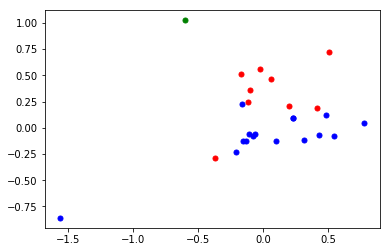

0
Êàë‰∏çÁü•ÈÅìÊÄé‰πàÁ©øË°£Êúç ÊÄé‰πàÁ©øË°£Êúç Á©øË°£ Âá∫Ë°å‰ºöËÆÆÂ∫îËØ•Á©ø‰ªÄ‰πà?_? Á©øË°£Êúç ÈªëËâ≤ÊØõÂë¢Â§ñÂ•óÊÄé‰πàÊê≠ÈÖç ‰Ω†ÊÄé‰πàÁü•ÈÅìÊàëÂú®Â≠ùÊÑü ‰ªäÂ§©Â§©Ê∞îÊÄé‰πàÊ†∑  ÈÄÇÂêàÁ©ø‰ªÄ‰πà Á©øË°£ÊúçÊê≠ÈÖç
1
‰ªäÂ§©ÁöÑÂ§©Ê∞îÈÄÇÂêàÁ©øÂ§ßË°£Âêó? ÈÄÇÂêàÁ©ø‰ªÄ‰πàË°£Êúç citydateÈÄÇÂêàÁ©ø‰ªÄ‰πà dateÈÄÇÂêàÁ©ø‰ªÄ‰πàË°£Êúç dateÈÄÇÂêàÁ©øÂï•Ë°£Êúç Èõ®Â§©ÈÄÇÂêàÁ©ø‰ªÄ‰πàÈûã datecityÈÄÇÂêàÁ©ø‰ªÄ‰πà? Á©øÂï• Á©ø‰ªÄ‰πà Âª∫ËÆÆÁ©øÂ§öÂ∞ëË°£Êúç ‰ªäÂ§©Â∫îËØ•Á©ø‰ªÄ‰πà Á©ø‰ªÄ‰πàË°£ÊúçÊØîËæÉÂêàÈÄÇÊòµ ÁôΩÁæäÂ∫ß‰ªäÂ§©ÈÄÇÂêàÁ©ø‰ªÄ‰πàÈ¢úËâ≤Ë°£Êúç ÈÄÇÂêàÁ©øÂ§öÂ∞ë Ë°£Êúç ÊòéÂ§©Á©ø‰ªÄ‰πà
2
Â§©Ê∞îÂÜ∑ ÊÄé‰πàÂäû
2.006421805412182


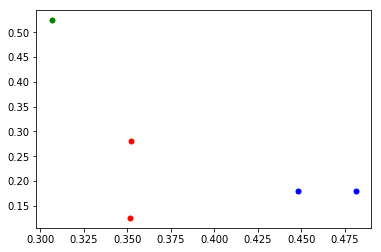

0
ÊïÖÂÆ´Êó•ÂéÜÊ≤°Êúâ‰∫Ü ÊïÖÂÆ´Êó•ÂéÜ
1
ÊïÖÂÆ´Êó•ÂéÜÊ≤°ÊúâÊåâÊó∂Êé®ÈÄÅ ‰πãÂâçÁöÑÊïÖÂÆ´Êó•ÂéÜËÆ¢ÈòÖ‰∏∫‰ªÄ‰πàÊ≤°Êúâ‰∫Ü
2
ÊïÖÂÆ´
106.2473000638135


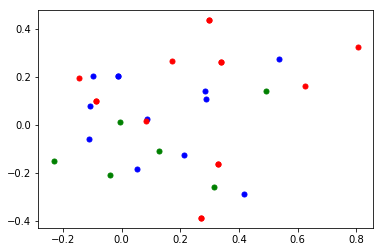

0
ÊÄé‰πà‰øÆÊîπÊòüÂ∫ßÔºü Â¶Ç‰Ωï‰øÆÊîπÊòüÂ∫ßÔºü ÊÄé‰πàÊ†∑‰øÆÊîπÊòüÂ∫ßÔºü ÊÄé‰πà‰øÆÊîπÊòüÂ∫ßËÆ¢ÈòÖ ÊÄé‰πà‰øÆÊîπËÆ¢ÈòÖÁöÑÊòüÂ∫ß Êõ¥Êç¢ÊòüÂ∫ß ÊòüÂ∫ßÊõ¥Êç¢ ÊÄé‰πàÂèØ‰ª•Êõ¥ÊîπÊòüÂ∫ß ÊòüÂ∫ßÊÄé‰πàÊõ¥Êîπ Êõ¥ÊîπÊòüÂ∫ß ‰øÆÊîπÊòüÂ∫ßÊÄéÊ†∑‰øÆÊîπ Â¶Ç‰Ωï‰øÆÊîπÊòüÂ∫ß ÊòüÂ∫ßËÉΩÊîπÂêó ÊîπÊòüÂ∫ß ÊÄé‰πàÊîπÊòüÂ∫ß
1
ÂèØ‰∏çÂèØ‰ª•ÂàáÊç¢ÊòüÂ∫ß? ÊòüÂ∫ß‰∏çÂØπÂì¶ÔºåÊÄé‰πàÊõ¥Ê≠£ ÊàëÊÉ≥ÊääÊòüÂ∫ßÊâìÂç°ÊîπÊàêÂèåÈ±ºÂ∫ß ÊÄé‰πàÈÄâÊòüÂ∫ß ÊàëË¶ÅÊîπÊòüÂ∫ß ÊòüÂ∫ßÊÄé‰πàÈÄâÂïä ÊÉ≥ÊîπÊòüÂ∫ßÁöÑÂèëÈÄÅÊó∂Èó¥ Êç¢ÊòüÂ∫ß ÊàëÊÉ≥Êç¢ÂÅöÂÖ≥Á≥ªÂ∞ÑÊâãÂ∫ß ÊÄé‰πàÂäû |ÂèØ‰ª•ÈáçÊñ∞ÈÄâÊòüÂ∫ßÂêó Âè´‰Ω†ÂèëÁôΩÁæäÂ∫ßÁöÑ ÊàëÈÄâ‰∏ç‰∫ÜÊòüÂ∫ß
2
ÊòüÂ∫ßËøêÂäø‰∏≠ÁöÑÊòüÂ∫ßÊàëËæìÂÖ•Èîô‰∫Ü ÊòüÂ∫ßÈîô‰∫ÜÊÄé‰πàÂäû ÈÄâÈîôÊòüÂ∫ß‰∫Ü/::- Êõ¥ÊîπÊòüÂ∫ßËøêÂäøÊó∂Èó¥ ÂèØ‰ª•ÊääÊòüÂ∫ßÂèñÊ∂àÂêó ÊòØÊàëË¶ÅÊç¢ÊòüÂ∫ßËøêÂäøÁöÑÊòüÂ∫ß
7.774034460886731


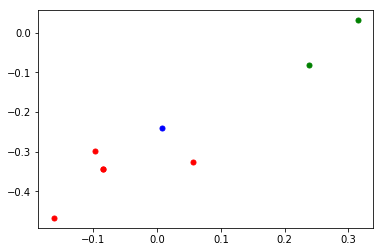

0
Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ÂíãÊ≤°ÊúâÂÜÖÂÆπÂë¢ ‰∏∫Âï•Â§ñÂ©ÜÁöÑÁÅ∂Âè∞Ê≤°ÊúâÊñáÂ≠ó Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ÊÄé‰πàÊâì‰∏çÂºÄ‰∫Ü Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ÊÄé‰πàÊâì‰∏çÂºÄ? Â•ΩÂá†Â§©Ê≤°ÊúâÁúãÂà∞Â§ñÂ©ÜÁöÑÁÅ∂Âè∞‰∫Ü
1
Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ÂíãÊ≤°Êé®ËçêÂë¢
2
Â§ñÂ©ÜÁöÑÁÅ∂Âè∞ÂÅúÊ≠¢Êé®ÈÄÅÔºü ÊÄé‰πà‰∏çÂèëÈÄÅÂ©ÜÂ©ÜÂÆ∂ÁöÑÁÅ∂Âè∞
0.8965767335313415


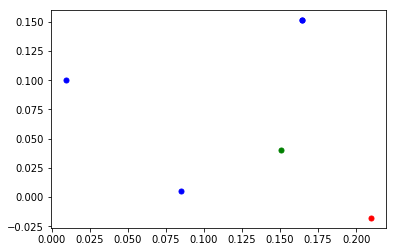

0
Êò®Â§©‰∏ñÁïåÊùØË∞ÅËµ¢‰∫Ü
1
‰∏ñÁïåÊùØ‰π∞Âì™‰∏™Èòü ‰∏ñÁïåÊùØËØ•‰π∞Âì™‰∏™Èòü ‰∏ñÁïåÊùØË¶Å‰π∞Âì™‰∏™Èòü ‰∏ñÁïåÊùØÂ∫îËØ•‰π∞Âì™‰∏™Èòü
2
‰∏ñÁïåÊùØ‰π∞Âì™‰∏™ÈòüËÉΩËµ¢
116.46657508076912


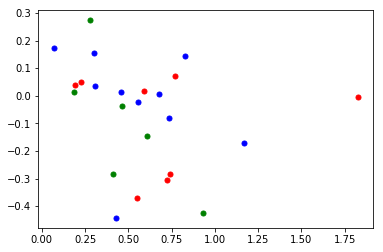

0
ÊÄé‰πàÊî∂‰∏çÂà∞‰Ω†Ê∂àÊÅØÂë¢Ôºü ‰∏∫‰ªÄ‰πàÊúâÊó∂Ê∂àÊÅØ‰∏çÂèë‰∫Ü? Êî∂‰∏çÂà∞ ‰∏∫‰ΩïÊî∂‰∏çÂà∞ÊâìÂç°Ê∂àÊÅØ ‰ªÄ‰πàÊ∂àÊÅØÈÉΩ‰∏çÂèë‰∫Ü ‰Ω†ÊÄé‰πà‰∏çÂõûÂ§çÊàëÁöÑÊ∂àÊÅØÂïä? ÂëÉÊÄé‰πà‰∏çÂõûÂ§çÊàëÁöÑÊ∂àÊÅØ? ‰∏∫‰ªÄ‰πàÊî∂‰∏çÂà∞Âà´‰∫∫Êó©Ëµ∑ÊâìÂç°ÁöÑÊ∂àÊÅØ
1
‰∏∫‰ªÄ‰πà‰∏çÂèëÊ∂àÊÅØÁªôÊàë ÊÄé‰πà‰∏çÂèëÊ∂àÊÅØ‰∫Ü ‰∏∫‰ªÄ‰πàËøôÂá†Â§©‰Ω†‰∏çÂá∫Áé∞ Ê≤°ÊúâÊî∂Âà∞ÊòØÂê¶ÈúÄË¶ÅË°•Á≠æÊèêÁ§∫ Â∞èÊù•‰Ω†ÂéªÂì™‰∫Ü? ‰∏∫‰ªÄ‰πàÁªèÂ∏∏‰ºöÂá∫Áé∞Êâì‰∏ç‰∏äÂç°ÁöÑÁä∂ÊÄÅ ‰Ω†Â•Ω‰∏∫‰ªÄ‰πàÂ•ΩÂá†Â§©ÈÉΩÊ≤°ÊúâÂõæÁâáÂëÄ ‰∏∫‰ªÄ‰πàÊúÄËøë‰∏çÂèë‰∫ÜÂë¢ ‰Ω†Â•ΩÂá†Â§©ÈÉΩÊ≤°Ë∑üÊàëËØ¥ËØù‰∫Ü ‰∏∫‰ªÄ‰πàÊ≤°ÊúâÂøÉËØ≠Á≠æ
2
Â•Ω‰πÖÊ≤°Êî∂Âà∞‰Ω†ÁöÑÊ∂àÊÅØÂï¶Ôºü Â•ΩÂÉèÂ∞èÊù•‰Ω†Â∑≤ÁªèÂèë‰∫Ü19Êù°Ê∂àÊÅØ‰∫Ü Âï•Âïä ÊúâÂª∂Ëøü ‰ªäÂ§©Êó©‰∏äÊâìÂç°,ÂæàÊÖ¢ ÈÇ£‰∏™ÊòØÊØèÂ§©20Êù°Âêó ÊàëÂèë‰ø°ÊÅØ‰Ω†ËÉΩÊî∂Âà∞Âòõ?
72.85100927252955


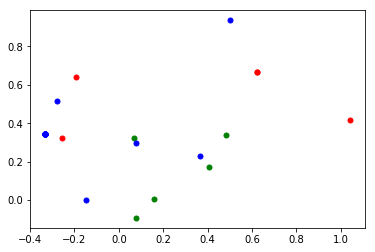

0
ÊÄé‰πàËøô‰πàÊÖ¢ ÂèçÂ∫îËøô‰πàÊÖ¢ Ëøô‰∏™ÊïàÁéáÊúâÁÇπÊÖ¢Âïä ÂèçÂ∫îÊÖ¢ ÊúÄËøë‰Ω†‰ª¨ÂèçÂ∫îÂ•ΩÊÖ¢
1
ÈÄüÂ∫¶ÈÄüÂ∫¶ÈÄüÂ∫¶ ÈÄüÂ∫¶ÈÄüÂ∫¶ ÈÄüÂ∫¶ ÈÄüÂ∫¶Âìá ÈÄüÂ∫¶. ÈÄüÂ∫¶Âïä ÈÄüÂ∫¶„ÄÇ ÈÄüÂ∫¶Êâæ ÈÄüÂ∫¶Âì¶ ÈÄüÂ∫¶Âìà ÈÄüÂ∫¶ÂëÄ ÈÄüÂ∫¶Âõû ÈÄüÂ∫¶Âá∫Á•® ÈÄüÂ∫¶ÁÇπ ÈÄüÂ∫¶ÈÄÄÊ¨æ ÈÄüÂ∫¶...
2
‰Ω†ËøôÂõûÂ§çÈÄüÂ∫¶ ‰∏∫‰ªÄ‰πàÂõûÂ§ç‰ºöÊÖ¢? ‰Ω†ÂèçÂ∫îÂ•ΩÊÖ¢ ÂèçÂ∫îËøüÈíù ËøôÁ†¥Áé©ÊÑèÂèçÂ∫îËøüÈíù
12.261670031933319


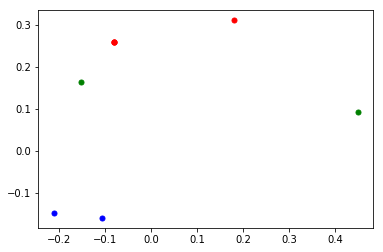

0
Á∫¢ÂåÖÊÄé‰πàÁé© ËØ∑ÈóÆÁ∫¢ÂåÖÊÄé‰πàÁé© ÊÉ≥Áü•ÈÅìÁ∫¢ÂåÖÊÄé‰πàÁé© ÈóÆ‰∏Ä‰∏ãÁ∫¢ÂåÖÊÄé‰πàÁé©
1
ËØ∑ÈóÆÊÄé‰πàÂèëÁ∫¢ÂåÖ ÈóÆ‰∏ãÊÄéÊ†∑ÂèëÁ∫¢ÂåÖÂë¢Ôºü
2
ÂíåÊúãÂèã‰∏ÄËµ∑Êä¢Á∫¢ÂåÖ ÊÄé‰πàÊä¢Á∫¢ÂåÖ
25.88350873239127


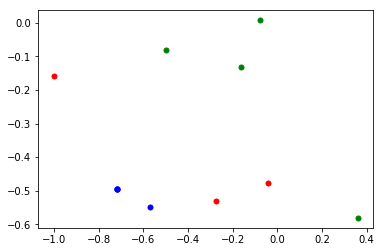

0
ÊàëË¶ÅÁ∫¢ÂåÖ Ê≤°ÊúâÁ∫¢ÂåÖ ÊúâÊ≤°Ê≤°ÊúâÁ∫¢ÂåÖ
1
Á∫¢ÂåÖÂë¢ Á∫¢ÂåÖÂë¢? ÊàëÁöÑÁ∫¢ÂåÖÂë¢ Á∫¢ÂåÖ‰∫Ü
2
ÊàëÁöÑÁ∫¢ÂåÖÊúâËøõÂ±ïÂêó ‰∏∫ÊØõÁ∫¢ÂåÖÊâì‰∏çÂºÄÁöÑ ÊàëË¶ÅÁ∫¢ÂåÖ/::Q/::Q Á∫¢ÂåÖÈÇ£Âéª‰∫Ü
0.9854852213563985


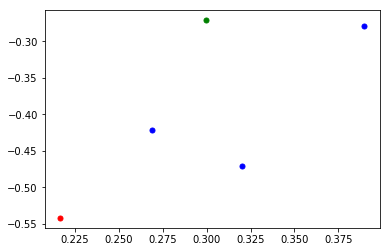

0
Êä¢Á≠îÁ∫¢ÂåÖ‰∏ÄÂàÜÈíüÂè™ËÉΩÈ¢Ü‰∏Ä‰∏™
1
Á≠îÂØπ‰∫Ü‰∏∫‰ªÄ‰πà‰∏çÁªôÂèëÊàëÁ∫¢ÂåÖÔºü Á≠îÂØπ‰∫Ü‰∏∫Âï•‰∏çÁªôÂèëÊàëÁ∫¢ÂåÖÔºü ÊÉ≥Áü•ÈÅìÁ≠îÂØπ‰∫Ü‰∏∫‰ªÄ‰πà‰∏çÁªôÂèëÊàëÁ∫¢ÂåÖÔºü
2
‰∏∫‰ªÄ‰πàÁ∫¢ÂåÖ‰∏ÄÂàÜÈíüÂè™ËÉΩÈ¢ÜÂèñ‰∏Ä‰∏™
48.543670978351685


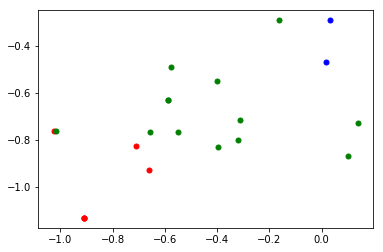

0
Áé∞ÈáëÁ∫¢ÂåÖ ÊàëÈúÄË¶ÅÁé∞ÈáëÁ∫¢ÂåÖ ÊàëË¶ÅÁé∞ÈáëÁ∫¢ÂåÖ Áé∞ÈáëÁ∫¢ÂåÖ? Áé∞ÈáëÁ∫¢ÂåÖÂë¢? ÈÇ£‰∏™Áé∞ÈáëÁ∫¢ÂåÖÊòØ?
1
ÊÄé‰πàÊî∂Ëé∑Á∫¢ÂåÖ ‰∏çÊòØÊúâ3ÂÖÉÁ∫¢ÂåÖÁªôÊàëÂòõ
2
Áé∞ÈáëÁ∫¢ÂåÖÂú®Âì™Èáå Áé∞ÈáëÁ∫¢ÂåÖÂì™ÈáåÊãø Áé∞ÈáëÁ∫¢ÂåÖÂú®Âì™? ÁªôÁöÑÁé∞ÈáëÁ∫¢ÂåÖÂú®Âì™Èáå Áé∞ÈáëÁ∫¢ÂåÖÂú®Âì™ÈáåÂïä 3ÂÖÉÁé∞ÈáëÁ∫¢ÂåÖÂú®Âì™ÂÑøÂë¢ Âì™ÊúâÁé∞ÈáëÁ∫¢ÂåÖ Â¶Ç‰ΩïÂÖëÊç¢Áé∞ÈáëÁ∫¢ÂåÖ Áé∞ÈáëÁ∫¢ÂåÖÂú®Âì™ÈáåÊü•Áúã ÂèØÊòØÊ≤°ÊúâÁªôÊàëÁé∞ÈáëÁ∫¢ÂåÖ ÊàëÊ≤°Êî∂Âà∞Áé∞ÈáëÁ∫¢ÂåÖ 3ÂÖÉÁé∞ÈáëÁ∫¢ÂåÖÂèàÊòØÂï•Âïä ‰∏çÊòØÊúâ‰∏âÂÖÉÁé∞ÈáëÂêó?
155.35607602208472


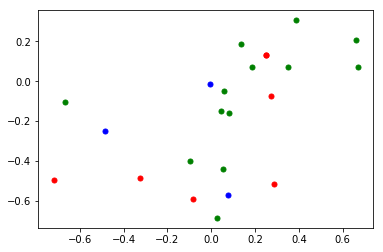

0
ÁªôÊàëÂèë‰∏™Á∫¢ÂåÖ Êä¢Á≠îÁ∫¢ÂåÖ ÊúâÁ∫¢ÂåÖÂêó Á∫¢ÂåÖ ÁªôÊàëÂèëÁ∫¢ÂåÖ ÁåúÈóÆÈ¢òÊãøÁ∫¢ÂåÖ ÂèëÊä¢Á≠îÁ∫¢ÂåÖ
1
ÊàëË¶ÅÂèëÁ∫¢ÂåÖ ÊÄé‰πàÊèêÈóÆÂèëÁ∫¢ÂåÖ ÂèëÁ∫¢ÂåÖ
2
ÊàëË¶Å‰Ω†ÁöÑÁ∫¢ÂåÖ ÊàëËøòÊòØÊÉ≥ÂÜçÊä¢‰∏Ä‰∏™Á∫¢ÂåÖÔºåËÉΩÂêóÔºü ÂèØ‰ª•ÂèëÁªôÊàëÁ∫¢ÂåÖÁÇπÂ•ΩÂêó? Á∫¢ÂåÖÊÄé‰πàÊä¢?Âú®Âì™Èáå? Áà±ÊàëÂ∞±ÁªôÊàëÂèë‰∏™Á∫¢ÂåÖ Êù•‰πüÁ≠îÈ¢òÁ∫¢ÂåÖ ÊÄé‰πàÊä¢ ‰Ω†Âèë‰∏Ä‰∏™Á∫¢ÂåÖÂëó„ÄÇ Á≠îÈ¢ò ÈÇ£‰Ω†ÁªôÊàëÂèë‰∏™Á∫¢ÂåÖÊàëÂ∞±‰∏çÁîüÊ∞î‰∫Ü Á∫¢ÂåÖÂú®ÈÇ£„ÄÇÂø´Âá∫Êù• Âèë‰∏™Èí±ÂåÖÂêß ‰Ω†ÂæÆ‰ø°ÊúâÊ≤°ÊúâÁ∫¢ÂåÖÂïä
47.20282436836831


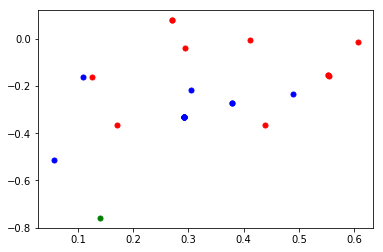

0
Á∫¢ÂåÖÊÄªÊòØËØ∑Ê±Ç‰∏çÊàêÂäüÂïä Á≠îÂØπÈ¢òÁõÆÊèêÁ§∫Á∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñ ‰∏∫‰ªÄ‰πàÊàëÁ≠îÂØπÈ¢òÁõÆÊèêÁ§∫Á∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñ ÊÉ≥Áü•ÈÅìÁ≠îÂØπÈ¢òÁõÆÊèêÁ§∫Á∫¢ÂåÖÂç¥Êó†Ê≥ïÈ¢ÜÂèñÊòØ‰ªÄ‰πàÂéüÂõ† Á≠îÂØπÈ¢òÁõÆÊèêÁ§∫Á∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñÊÄé‰πàÂäû ‰∏∫‰ªÄ‰πàÁ∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñ Á∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñÊòØ‰ªÄ‰πàÂéüÂõ† ËØ∑ÈóÆÁ∫¢ÂåÖÊó†Ê≥ïÈ¢ÜÂèñÔºåÊòØ‰ªÄ‰πàÂéüÂõ† ‰∏∫‰ªÄ‰πàÂà´‰∫∫‰∏çËÉΩÈ¢ÜÂèñÁ∫¢ÂåÖ ‰∏∫‰ªÄ‰πà‰∏çËÉΩÈ¢ÜÂ∏É‰∏Å ÂÖ¨‰∏ª ÁöÑÁ∫¢ÂåÖ ‰∏∫‰ªÄ‰πàËãπÊûúÊâãÊú∫‰∏çËÉΩÈ¢ÜÂèñ
1
‰∏∫‰ªÄ‰πàÁ∫¢ÂåÖÈ¢Ü‰∏ç‰∫Ü? Á∫¢ÂåÖÈ¢Ü‰∏ç‰∫Ü ÊÄé‰πàÈ¢Ü‰∏ç‰∫ÜÁ∫¢ÂåÖ ÂèØÊòØÁ∫¢ÂåÖÈ¢Ü‰∏ç‰∫Ü ÂæÆ‰ø°Á∫¢ÂåÖÈ¢Ü‰∏ç‰∫Ü Á∫¢ÂåÖÈ¢Ü‰∏ç‰∫ÜÂïä ÊàëÁ∫¢ÂåÖ‰∏çËÉΩÈ¢Ü Á∫¢ÂåÖÈ¢Ü‰∏ç‰∫ÜÂë¢ È¢Ü‰∏ç‰∫ÜÁ∫¢ÂåÖ Á∫¢ÂåÖÂèàÈ¢Ü‰∏ç‰∫Ü ‰∏∫Âï•ÂèàÈ¢Ü‰∏ç‰∫ÜÁ∫¢ÂåÖ ‰∏∫‰ªÄ‰πàÁ∫¢ÂåÖÈ¢Ü‰∏ç‰∫Ü Ëøô‰∏™Á∫¢ÂåÖÈ¢Ü‰∏ç‰∫ÜÂïä
2
Á≠îÂØπ‰∫ÜÊ≤°ÊúâÁ∫¢ÂåÖ
148.23782173012177


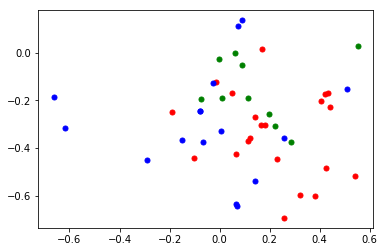

0
ÊàëÁöÑÁ∫¢ÂåÖ‰ªÄ‰πàÊó∂ÂÄôÈÄÄÂõûÊù• ÊàëÂèëÁöÑÁ∫¢ÂåÖ‰ªÄ‰πàÊó∂ÂÄôËÉΩÈÄÄÂõûÊù• Á∫¢ÂåÖÊ≤°ÊúâÈ¢ÜÂèñÂÆåÊÄé‰πàÂäû Êú™È¢ÜÂèñÁöÑÁ∫¢ÂåÖÂ§ö‰πÖÈÄÄÊ¨æ ÊàëÁöÑÁ∫¢ÂåÖÊ≤°ÊúâÈ¢ÜÂèñÂÆåÊÄé‰πàÂäû Ê≤°ÊúâÈ¢ÜÂèñÁöÑÁ∫¢ÂåÖË¶ÅÂ§ö‰πÖÈÄÄÊ¨æ ‰πãÂâçÁöÑÁ∫¢ÂåÖ‰ºöÈÄÄÂõûÊù•ÂêóÔºü ‰πãÂâçÂèëÁöÑÁ∫¢ÂåÖÂ§öÁöÑÈí±‰Ω†‰ª¨Ê≤°ÊúâÈÄÄÂõûÊù• Â¶ÇÊûúÁ∫¢ÂåÖÊ≤°È¢ÜÂÆå‰ºöÈÄÄËøòÂêó Ê≤°È¢ÜÂÆåÁöÑÁ∫¢ÂåÖÊÄé‰πà‰∏çÈÄÄÊ¨æÔºü Á∫¢ÂåÖ‰∏∫‰ªÄ‰πàÂçÅÂ§©ËøòÊ≤°ÊúâÈÄÄÂõûÊù• ‰∏∫‰ªÄ‰πàÊàëÁöÑÁ∫¢ÂåÖËøòÊ≤°ÊúâÈÄÄÂõûÊù• ÊàëÊÉ≥ÈóÆ‰∏Ä‰∏ã„ÄÇËøôÈáåÁöÑÁ∫¢ÂåÖ„ÄÇ‰∏∫‰ªÄ‰πà‰∏çÈÄÄËøò Á∫¢ÂåÖÈí±ÊÄé‰πàËøò‰∏çÁªôÈÄÄÂõûÊù• ÊàëÁöÑÁ∫¢ÂåÖÊ≤°Ë¢´È¢ÜÂèñÁöÑ‰∏∫‰ªÄ‰πà‰∏çÈÄÄ Á∫¢ÂåÖ‰ΩôÈ¢ù‰∏∫‰Ωï‰∏çÈÄÄ Á∫¢ÂåÖÈáëÈ¢ùÂèëÈîôÊ≤°Êä¢ÂÆåÈÄÄÂõûÂêó Á∫¢ÂåÖÊ≤°È¢ÜÂÆåÁöÑ‰ªÄ‰πàÊó∂ÂÄôÈÄÄËøò ÊàëÂèëÁöÑÁ∫¢ÂåÖÂà´‰∫∫Ê≤°Êä¢‰ºöÈÄÄÂõûÂêó Ê≤°È¢ÜÁöÑÁ∫¢ÂåÖÈÄÄ‰∏çÈÄÄ Á∫¢ÂåÖÈáåÈù¢Ê≤°È¢ÜÂÆåÁöÑÈí±ÊÄé‰πàÂäû
1
Á∫¢ÂåÖÈÄÄÊ¨æ ÈÄÄËøòÊàëÁöÑÁ∫¢ÂåÖÈí± ÈÄÄËøòÁ∫¢ÂåÖÈí± ÊàëÁöÑÁ∫¢ÂåÖËøòÊ≤°ÈÄÄÂõûÊù• Âø´ÁÇπÈÄÄÁ∫¢ÂåÖ Á∫¢ÂåÖÂ¶Ç‰ΩïÈÄÄÊ¨æ Á∫¢ÂåÖÊÄéÊ†∑ÈÄÄÊ¨æ Á∫¢ÂåÖÈÄÄÊ¨æ‰ªÄ‰πàÊó∂ÂÄôÈÄÄ Á∫¢ÂåÖÊÄé‰πàÈÄÄ ÊÄé‰πàÈÄÄÁ∫¢ÂåÖ Á∫¢ÂåÖÊú™ÈÄÄÂõû ÈÄÄÁ∫¢ÂåÖ 

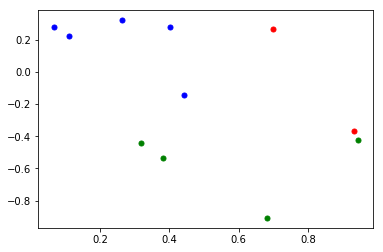

0
Êü•ÁúãÊàëÁöÑÁ∫¢ÂåÖË¢´Ë∞ÅÈ¢ÜÂèñ ÊàëÂèëÁöÑÁ∫¢ÂåÖË¢´ÈÉΩË∞ÅÈ¢ÜÂèñ‰∫Ü
1
Â¶Ç‰ΩïÊü•ÁúãÊàëÂèëÂá∫ÁöÑÁ∫¢ÂåÖËÆ∞ÂΩï ÊÄéÊ†∑Êü•ÁúãÊàëÂèëÂá∫ÁöÑÁ∫¢ÂåÖËÆ∞ÂΩï ÊÄé‰πàÊü•ÁúãÊàëÂèëÂá∫ÁöÑÁ∫¢ÂåÖËÆ∞ÂΩï Êü•ÁúãÊàëÂèëÂá∫ÁöÑÁ∫¢ÂåÖËÆ∞ÂΩï Á∫¢ÂåÖËÆ∞ÂΩï
2
ÊàëÂèë‰∫ÜÂ§öÂ∞ëÁ∫¢ÂåÖ ÊàëÂèëÁöÑÁ∫¢ÂåÖË¢´Â§öÂ∞ë‰∫∫È¢ÜÂèñ ÊÄéÊ†∑Áü•ÈÅìÊàëÂèë‰∫ÜÂ§öÂ∞ëÁ∫¢ÂåÖ Â¶Ç‰ΩïÊâçËÉΩÁü•ÈÅìÊàëÂèë‰∫ÜÂ§öÂ∞ëÁ∫¢ÂåÖ
15.984239295664167


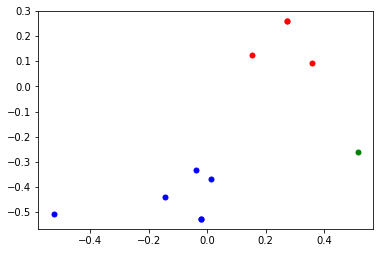

0
Á∫¢ÂåÖÂèëÂá∫ÂèØ‰ª•‰øÆÊîπ‰πà Á∫¢ÂåÖÂèëÂá∫ÂèØ‰∏çÂèØ‰ª•‰øÆÊîπÔºü Á∫¢ÂåÖÂèëÂá∫ÊòØ‰∏çÊòØÂèØ‰ª•‰øÆÊîπÔºü Á∫¢ÂåÖÂèëÂá∫ËøòËÉΩ‰øÆÊîπÂêóÔºü
1
Á∫¢ÂåÖÁ≠îÊ°àÊòØÂê¶ÂèØ‰ª•‰øÆÊîπ Á∫¢ÂåÖÁ≠îÊ°àËÉΩ‰øÆÊîπÂêó ËØ∑ÈóÆÁ∫¢ÂåÖÁ≠îÊ°àÊòØÂê¶ÂèØ‰ª•‰øÆÊîπ Á∫¢ÂåÖÁ≠îÊ°àÂèØ‰∏çÂèØ‰ª•‰øÆÊîπ Á∫¢ÂåÖÁ≠îÊ°àËÉΩ‰∏çËÉΩ‰øÆÊîπ Á¥ÖÂåÖÁ≠îÊ°à
2
ÂèØ‰ª•ÊääÁ∫¢ÂåÖÂà†Èô§Âòõ
28.31712888246735


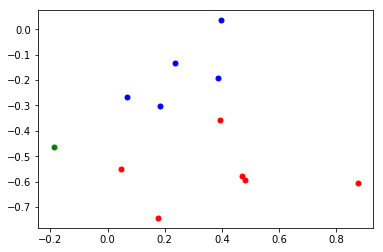

0
Êä¢Á≠îÁ∫¢ÂåÖÂõæÁâáÊÄé‰πàÊ≤°Êúâ‰∫Ü Êä¢Á≠îÁ∫¢ÂåÖÊ≤°ÊúâÂõæÁâá Êä¢Á≠îÁ∫¢ÂåÖÊ≤°ÊúâÁîüÊàêÂõæÁâá ÊàëÁöÑÁ∫¢ÂåÖÈóÆÈ¢òÂõæÂë¢ Á∫¢ÂåÖ‰∫åÁª¥Á†ÅÊ≤°ÊúâÁîüÊàê ÁîüÊàêÁ∫¢ÂåÖÂõæ
1
ÂàöÂºÑ‰∫Ü‰∏Ä‰∏™Á∫¢ÂåÖÔºåÊä¢Á≠î ËøòÊ≤°ÊúâÂèëËøáÊù•‰∫åÁª¥Á†Å Á≠îÈ¢òÁ∫¢ÂåÖÂ∑≤Êâ£Ê¨æ‰ΩÜÊòØ‰∫åÁª¥Á†ÅÊ≤°ÂèëÂá∫Êù• Êò•ËäÇÁ∫¢ÂåÖÂ∑≤Áªè‰ªòÊ¨æ‰∫ÜÔºåÊÄé‰πàÊ≤°ÊúâÁîüÊàêÂõæÁâá Êä¢Á∫¢ÂåÖÁöÑ‰∫åÁª¥Á†ÅÊ≤°ÁªôÊàëÂèëÂá∫Êù• ÊàëÂàöÊâçÁ¨¨‰∫å‰∏™Á∫¢ÂåÖ‰∫åÁª¥Á†ÅÊ≤°ÂèëÂá∫Êù•
2
Á∫¢ÂåÖ‰∫åÁª¥Á†Å
18.52274376840716


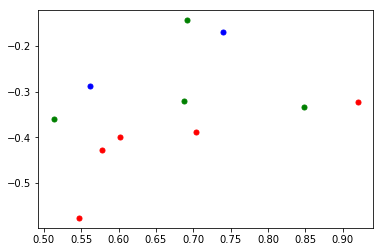

0
ÂèëÁ∫¢ÂåÖÂà∞ÊúãÂèãÂúàÔºå‰ΩÜÊòØÂà´‰∫∫ÊúãÂèãÂúàÊòæÁ§∫‰∏ç‰∫Ü ‰∏∫‰ªÄ‰πàÊàëÁöÑÁ∫¢ÂåÖ‰∫åÁª¥Á†ÅÂèëÊúãÂèãÂúàÔºåÂà´‰∫∫Áúã‰∏çÂà∞ Á∫¢ÂåÖ‰∫åÁª¥Á†ÅÂú®ÊúãÂèãÂúà‰∏çÊòæÁ§∫ Á∫¢ÂåÖÂú®ÊúãÂèãÂúà‰∏çÊòæÁ§∫ ÂèëÂæÆ‰ø°ÊúãÂèãÂúà‰∏çÊòæÁ§∫
1
‰∫åÁª¥Á†ÅÊó†Ê≥ïÂèëÈÄÅÊúãÂèãÂúà ÊúãÂèãÂúàÂ•ΩÂèãÊó†Ê≥ïÁúãÂà∞‰∫åÁª¥Á†Å
2
Á∫¢ÂåÖÊó†Ê≥ïÂú®ÊúãÂèãÂúàÂèëÈÄÅ ÊúãÂèãÂúàÁúã‰∏çÂà∞ÂèëÈÄÅÁöÑÁ∫¢ÂåÖ Âèë‰∏ç‰∫ÜÊúãÂèãÂúà Á∫¢ÂåÖÊó†Ê≥ïÂèëÊúãÂèãÂúà
5.297963574767243


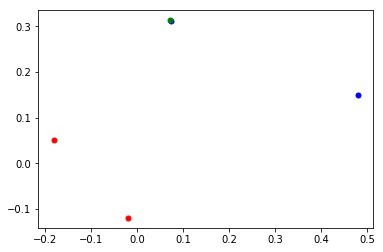

0
Á∫¢ÂåÖÊÄé‰πàÊèêÁé∞ Á∫¢ÂåÖÊèêÁé∞
1
ÊèêÁé∞ ÊÄé‰πàÊèêÁé∞
2
ÊÄé‰πàÊü•ÁúãÁ∫¢ÂåÖ
2.6312061898391272


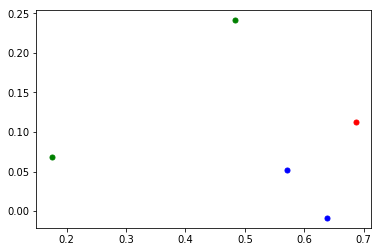

0
‰∏∫Âï•È™åËØÅÊâãÊú∫Ôºü
1
‰∏∫‰ªÄ‰πàË¶ÅÈ™åËØÅÊâãÊú∫ÊâçËÉΩÁî®Ôºü È™åËØÅÊâãÊú∫Êúâ‰ªÄ‰πàÁî®Ôºü
2
Â¶Ç‰ΩïÈ™åËØÅÊâãÊú∫Ôºü ÊÄé‰πàÈ™åËØÅÊâãÊú∫Ôºü
5.298000286639445


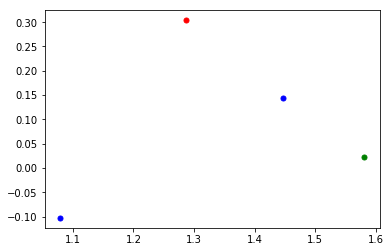

0
ÂÆåÊàêÈ™åËØÅ
1
Â∑≤È™åËØÅ Â∑≤ÁªèÈ™åËØÅËøáÂï¶„ÄÇ
2
ÊàëÂ∑≤Êõ¥Êîπ
67.54315484353714


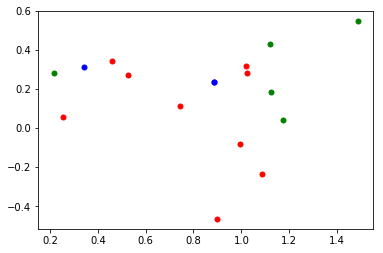

0
È™åËØÅÊâãÊú∫Êî∂‰∏çÂà∞È™åËØÅÁ†Å ‰∏∫‰ªÄ‰πàÊàëÈ™åËØÅ‰∏çÂà∞Âè∑Á†Å È™åËØÅÊâãÊú∫Âè∑ Êî∂‰∏çÂà∞È™åËØÅÁ†Å ËøòÊòØË¶ÅÈ™åËØÅÊâãÊú∫Âè∑„ÄÇ ‰∏∫‰ªÄ‰πàÊâãÊú∫Âè∑È™åËØÅ‰∏ç‰∫Ü ÊâãÊú∫Âè∑‰∏∫‰Ωï‰∏çËÉΩÁªëÂÆö È™åËØÅÊâãÊú∫Âè∑Á†Å ÈáçÊñ∞È™åËØÅÊâãÊú∫Âè∑
1
È™åËØÅ‰∏ç‰∫Ü ÈáçÊñ∞È™åËØÅ‰∏ç‰∫Ü È™åËØÅ‰∏ç‰∫ÜÂëÄ
2
Â¶Ç‰ΩïÈ™åËØÅ È™åËØÅÈîôËØØ Âä©ÁêÜÊù•‰πüËÄÅÊòØË¶ÅÈ™åËØÅÈ™åËØÅËøòÊòØÈ™åËØÅÈ™åËØÅÂÆå‰∫ÜËøò‰∏çË°å Êó†Ê≥ïÈ™åËØÅ È™åËØÅ
51.98807050356944


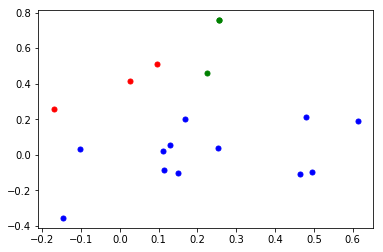

0
ÁøªËØë Ê±ÇÁøªËØë ÊàëÊÉ≥ÁøªËØë
1
Ëøô‰∏™Á≠æËØ≠È•º‰∏ãÈù¢Â∏¶‰∏≠ÊñáÁøªËØëÂ∞±Â•Ω‰∫Ü,Êñπ‰æøÂ≠¶‰π† ‰∏Ä‰∏™Âπ∏ËøêÁ≠æËØ≠È•ºÊÄé‰πàÊ≤°‰∏≠Êñá ËÉΩÁøªËØëÊàê‰∏≠Êñá‰∏ç ÊØèÂ§©Êé®ÈÄÅÁöÑÈÇ£Âè•Ëã±ÊñáÂèØ‰ª•Â∏¶‰∏äÁøªËØëÂêó ËøôËã±ÊñáÊòØÂï•ÊÑèÊÄùÂëÄ ‰∫≤,‰∏äÈù¢ÈÇ£‰∏™Ëã±ËØ≠ÊúâÁøªËØëÂêó ÊàëÊÉ≥Áü•ÈÅì‰∏ÄÂè•Ëã±Êñá Ê±ÇËØëÊñá ÊàëÁöÑËÆ¢ÈòÖËã±ÊñáÂ≠óÊØçÁúã‰∏çÊáÇÂïä Ëã±ÊñáÁúã‰∏çÊáÇ ÂèØ‰ª•ÁøªËØëÊàê‰∏≠ÊñáÂêó? Ëù¥Ëù∂Áî®Ëã±ÊñáÊÄé‰πàËØ¥
2
Ëã±ËØ≠ËÉΩÁøªËØë‰∏Ä‰∏ã‰πà ÁøªËØëËã±ËØ≠ ÂèØ‰ª•ÁøªËØëËã±ËØ≠Âè•Â≠êÂêó
266.23406132093385


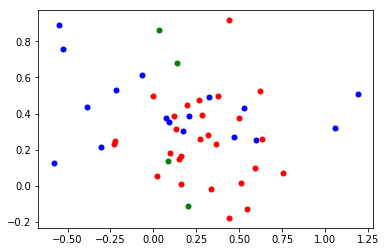

0
ÊÑèËßÅÂèçÈ¶à ÊÉ≥Â§∏Â§∏‰Ω† Ë∞¢Ë∞¢,Êú™ÊîØ‰ªòÁöÑËÆ¢ÂçïÊòØ‰∏çÊòØ‰πüÂèØ‰ª•ÊúâËá™Â∑±‰øÆÊîπÊàñËÄÖÂà†Èô§ÁöÑÂäüËÉΩÂë¢ ÊàëËÉΩ‰∏çËÉΩÁªô‰Ω†ÁöÑÂÖ¨‰ºóÂè∑ÊèêÁÇπÊÑèËßÅ„ÄÇ Â¶Ç‰ΩïÂêëÂ∞èÊù•ÊèêÂª∫ËÆÆÔºü ÊµãËØï‰∫Ü‰∏Ä‰∏ãÊÄßËÉΩ,ÊÑüËßâ‰∏çËøáÂÖ≥„ÄÇÊÄé‰πàÂäû? Â§™Â§çÊùÇ‰∫Ü ÂèØ‰ª•Ëá™Â∑±Âà∂‰ΩúÂêó Áªô‰Ω†‰ª¨‰∏Ä‰∫õÊÑèËßÅha ‰Ω†Âèò‰∫Ü Ëøô‰∏™APPËøòÂæóÊîπËøõ ÊúÄËøëÈÇÄËØ∑Âç°Âæà‰∏çÈ°∫ÁïÖ ÊàëÂèçÈ¶à‰∫Ü ‰Ω†‰ª¨Âä†Âº∫ÁÆ°ÁêÜÂêß ËØ≠ÂΩïÂ§™Â∞ë ËØçÊ±áÂèØ‰ª•Êç¢Êç¢‰∏™Âêó?ÂèçÂ§çÁöÑ ËøòÊòØÂñúÊ¨¢ÊúÄÂàùÁöÑÊâìÂç°Á≠æÂà∞Âõæ ÊúâËÄÅÂ§ñËØªÁöÑÈü≥È¢ëÂêó Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠Â¶ÇÊûúÂ∏¶‰∏äËØ≠Èü≥Â∞±Êõ¥ÂÆåÁæé‰∫Ü Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠ÊúâËØ≠Èü≥Â∞±Êõ¥ÂÆåÁæé‰∫Ü Â¶ÇÊûúÊ±™ËÄÅÂ∏àÊïôËã±ËØ≠,ÂèØ‰ª•ËØ≠Èü≥Â∞±Â•Ω‰∫Ü„ÄÇÊàë‰ª¨ÂèØ‰ª•Â≠¶Âà∞ÂèëÈü≥ Âª∫ËÆÆÊ±™ËÄÅÂ∏àÊïôËã±ËØ≠Â¶ÇÊûúÂ∏¶‰∏äËØ≠Èü≥Â∞±Êõ¥ÂÆåÁæé‰∫Ü Â∞èÂª∫ËÆÆ,ÈÇ£‰∏™Ê±™ËÄÅÂ∏àÊïôËã±ËØ≠Â¶ÇÊûúÈÖç‰∏äËØ≠Èü≥ËØªÂá∫Êù•ÁöÑÊàëËßâÂæóÊõ¥Ê£íÂì¶! ËÉΩËØ≠Èü≥ÊïôËã±ËØ≠Âêó? Â¶ÇÊûúËã±ËØ≠ÂèØ‰ª•ÂèëÈü≥Â∞±Êõ¥Â•Ω‰∫Ü Ëã±ËØ≠ÊúâËØ≠Èü≥Â∞±Êõ¥Â•Ω‰∫Ü„ÄÇ Ê±™ËÄÅÂ∏àÁöÑËã±ËØ≠Ë¶ÅÊòØÊúâËØ≠Èü≥Â∞±Â•Ω‰∫Ü!ÂèØ‰ª•Ë∑üÁùÄÂ≠¶ Ê±™ËÄÅÂ∏àËØ≠Èü≥‰∏çÊòØÂæàÊ∏Ö ÊúâÂ§ñÈü≥
1

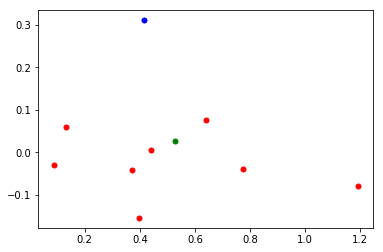

0
ÊØè‰∏™ÊúàÁöÑËøô‰∏™È∏°Ê±§ËÉΩ‰∏çËÉΩ‰∏çË¶ÅÈáçÂ§ç ÊêûÁ¨ëÁÇπÁöÑ,Â∞ΩÈáè‰∏çË¶ÅÈáçÂ§ç„ÄÇ ‰Ω†ÁªôÂèëËøá‰∫Ü,ËØ∑‰∏çË¶ÅÈáçÂ§çÂèë ÂõæÁâáÊéíÈáçÂ§ç‰∫Ü Ëøô‰∏™ÂøÉËØ≠ËÉΩ‰∏çË¶ÅÁªèÂ∏∏ÈáçÂ§çÂêó ËøôÂè•Â∑≤ÁªèÈáçÂ§çÂæàÂ§öÈÅç‰∫Ü Êó©ÂÆâÂØÑËØ≠ÂæàÂ§öÈáçÂ§çÁöÑ ÊâìÂç°‰∏äÈù¢ÁöÑËØùÂºÄÂºÄÂõûÂõûÂ∞±ÈÇ£‰πàÂá†Âè•,ËÉΩÊç¢Êç¢Âêó
1
ËØùÈÉΩÈáçÂ§ç‰∫Ü
2
Êñ∞ÈóªÈáçÂ§ç‰∫Ü
37.78095439961872


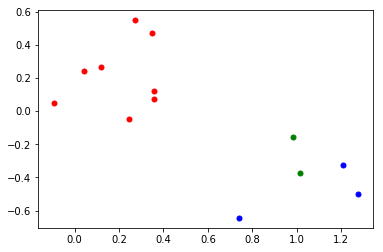

0
‰ªÄ‰πàÊó∂Èó¥ÂÖ≥Ê≥®ÁöÑ ÊàëÂÖ≥Ê≥®‰Ω†Â§ö‰πÖ‰∫Ü Êàë‰ªÄ‰πàÊó∂ÂÄôÂÖ≥Ê≥®‰Ω†ÁöÑ ÊàëÊòØ‰ªÄ‰πàÊó∂ÂÄôÂÖ≥Ê≥®ÁöÑ ÊàëÊòØÂì™Â§©ÂÖ≥Ê≥®Âä©ÁêÜÊù•‰πüÁöÑ ÊàëÊòØÂì™‰∏ÄÂ§©ÂÖ≥Ê≥®‰Ω†ÁöÑ? ÊàëÁ¨¨‰∏ÄÊ¨°Áî®Êù•‰πüÊòØ‰ªÄ‰πàÊó∂ÂÄô ÊàëÊòØÊÉ≥ÈóÆÂí±‰ø©‰ªÄ‰πàÊó∂ÂÄôËÆ§ËØÜÁöÑ
1
Êàë‰ª¨ËÆ§ËØÜÊúâÂ§öÂ∞ëÂ§©‰∫Ü ËØ∑Â∏ÆÊàëÊâæ‰∏Ä‰∏ãÊàë‰∏ÄÂÖ±Á≠æÂà∞‰∫ÜÂ§öÂ∞ëÂ§©‰∫Ü Êâì‰∫ÜÂ§öÂ∞ëÂ§©
2
Êàë‰ª¨ËÆ§ËØÜÂ§ö‰πÖ‰∫Ü Êàë‰ª¨ËÆ§ËØÜÂ§öÈïøÊó∂Èó¥‰∫Ü
7.944456312900589


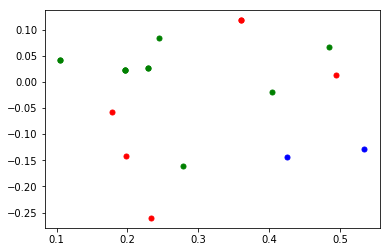

0
Êù•‰∏§ÁßçÂØåÂê´Áª¥b,Áª¥cÁöÑÊ∞¥Êûú ‰∏§ÁßçÂØåÂê´Áª¥cÁöÑÊ∞¥Êûú ‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú ‰π∞‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú ÂØåÂê´Áª¥bÊ∞¥Êûú ÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú
1
Áª¥cÁöÑÊ∞¥Êûú ÂØåÂê´Áª¥cÁöÑÊ∞¥Êûú
2
Êù•‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú Êù•‰∏§ÁßçÂØåÂê´Áª¥cÁöÑÊ∞¥Êûú Êù•‰∏§ÁßçÂØåÂê´Áª¥b,cÁöÑÊ∞¥Êûú Êù•‰∏§ÁßçÁª¥bÁöÑÊ∞¥Êûú Êù•‰∏§ÁßçÂØåÂê´Áª¥bÊ∞¥Êûú Êù•‰∏§ÁßçÂØåÂê´Áª¥b Êù•‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú, Êù•‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú,„ÄÇ Êù•‰∏§ÁßçÂØåÂê´Áª¥bÁöÑÊ∞¥Êûú,. Êù•‰∏§ÁßçÂê´Áª¥bÊ∞¥Êûú Êù•‰∏§ÁßçÂê´Áª¥bÁöÑÊ∞¥Êûú
8.267825779712318


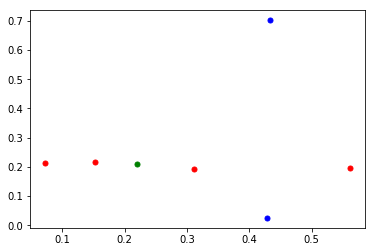

0
‰Ω†‰ºöÁéãËÄÖËç£ËÄÄÂêó ÊúÄËøëÊ≤âËø∑ÁéãËÄÖËç£ËÄÄ ‰Ω†ÊúâÁé©ÁéãËÄÖËç£ËÄÄÂêó? ‰Ω†ÊúâÁé©ÁéãËÄÖÂì¶
1
ÊúâÊâìÁéãËÄÖÂêó ÊâìÁéãËÄÖÂêóÂä©ÁêÜÊù•‰πü
2
ÁéãËÄÖËç£ËÄÄ
56.19569113724245


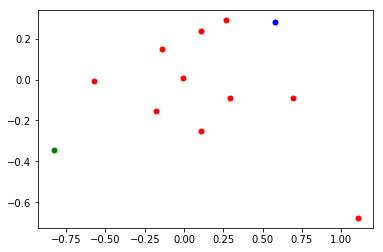

0
ÊÄéÊ†∑ÁîüÊàê‰∏ÄÂº†‰∏™‰∫∫ÂêçÁâá ÂêçÁâáÂ¶Ç‰ΩïÂÆöÂà∂ ÊÄé‰πàÂà∂‰ΩúÂêçÁâá ÂêçÁâáÂ¶Ç‰Ωï‰∫Ü ÂêçÁâáÂõæÁúã‰∏çÂà∞Âïä Âíã‰∏çÊúâÂêçÁâáÂá∫Áé∞ ÂêçÁâá‰∏çË°åÂëÄ Â∏ÆÊàëÂàõÂª∫‰∏ÄÂº†ÂêçÁâá ÂêçÁâáÂèëÁªôÊàë ÊàëÁöÑ‰∫åÁª¥Á†ÅÂêçÁâá
1
ÊàëÁöÑÊñ∞ÂêçÁâáÂë¢
2
Êòé‰ø°Áâá
6.053630274209192


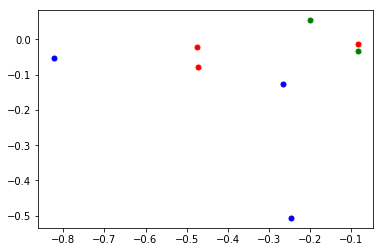

0
Âπ∏ËøêÈ•ºÂπ≤‰ªÄ‰πàÊÑèÊÄù Â∞èÊù•,Âπ∏ËøêÁ≠æËØ≠‰ªÄ‰πàÊÑèÊÄùÂïä ÁªôÁöÑÂπ∏ËøêÈ•ºÂπ≤‰ªÄ‰πàÊÑèÊÄùÂïä
1
Âπ∏ËøêÈ•ºÂπ≤ Âπ∏ËøêÈ•º Âπ∏ËøêÁ≠æËØ≠
2
Âπ∏ËøêËØ≠Á≠æ Âπ∏ËøêÁ≠æÈ•º‰πüÊ≤°Êúâ‰∫Ü/::(
992.9352594250352


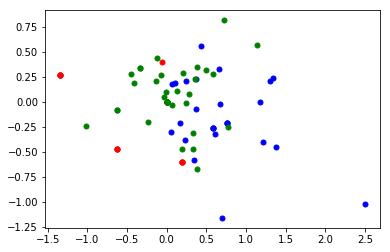

0
ÊÄé‰πàÊ†∑‰∫ÜÔºü Â•Ω‰∫ÜÂòõ ÂÆöÂ•Ω‰∫ÜÂêó Â•Ω‰∫ÜÂêó ÊÄé‰πàÊ†∑‰∫Ü Â•Ω‰∫ÜÂêó? Â•Ω‰∫Ü‰πà Â•Ω‰∫Ü? ÊÄé‰πàÊ†∑Âï¶ ÊÄé‰πàÊ†∑? ÂÆâÊéíÂ•Ω‰∫ÜÂêó
1
ËøòÊ≤°Êü•Âà∞Ôºü ‰∏ãÂçï‰∫ÜÂêó Âà∞Â∫ïÊúâÊ≤°Êúâ‰∫∫Êé•ÂçïÂïä ÊÄé‰πàÂõû‰∫ã Êü•Âà∞‰∫ÜÂêó? Êü•Âà∞‰∫ÜÂêó ËøòÊ≤°Êü•Âà∞? ËøòÊ≤°Âà∞ Ê≤°ÊúâÊî∂Âà∞ ËøòÊ≤°ÊúâÂêó ÊÄé‰πàËøòÊ≤°Âà∞ ËøòÊ≤°Êù• Ëøô‰πà‰πÖ ËøòÊ≤°ÊúâÂ∞èÂì•Êé•ÂçïÂêó Êü•Âà∞Ê≤°Ôºü ËÉΩ‰∏çËÉΩÊü•Âà∞ ÂïäÔºüÂú®Êü•ÂêóÔºü ËÉΩÊü•Âà∞Âêó ËøòÊ≤°ÈÄÅÂà∞Âïä Áü•ÈÅì‰∫ÜÂêó ‰ªÄ‰πàÊó∂ÂÄôÈÄÅËøáÊù•ÂëÄËøô‰πà‰πÖ‰∫Ü ‰∏çÊòØÊé•Âçï‰∫ÜÂòõ Ë∂ÖÊó∂Âæà‰πÖ‰∫Ü ËøòÊ≤°ÈÄÅÂà∞?Â∑≤Áªè‰∏Ä‰∏™Â∞èÊó∂‰∫Ü ÊÄé‰πàÂõû‰∫ã8ÁÇπ‰∏ãÁöÑÂçïËøòÊ≤°ÈÄÅÊù• ËØ¥Ë¶ÅÈÄÅÂà∞‰∫Ü Âà∞Áé∞Âú®ÈÉΩÊ≤°ÈÄÅÂà∞
2
È∫ªÁÉ¶Âø´ÁÇπ ËøòÊ≤°Â•ΩÔºü ÊÄé‰πàÂäû Âø´ÁÇπ Âø´ ÊúâÂêó ÈÄüÂ∫¶ Â∞ΩÂø´ Ë∂äÂø´Ë∂äÂ•Ω È∫ªÁÉ¶Â∞ΩÂø´ Ëµ∂Á¥ß ÂèØ‰ª•‰∫ÜÂêó Âè´‰∫ÜÂêó Â∞ΩÂø´Âêß Êù•‰∫ÜÂêó ÊúâÊ≤°Êúâ Âø´‰∏ÄÁÇπ Âø´Âø´Âø´ Ë¶ÅÂø´ ËØ∑‰Ω†Âø´‰∏ÄÁÇπ ok‰∫ÜÂêó ÂÇ¨‰∏Ä‰∏ã Ëøô‰πàÊÖ¢,‰ªÄ‰πàÊó∂ÂÄôÈÄÅÂà∞ ÂèØ‰ª•ÂÜçÊó©ÁÇπÂêó Â∑≤ÁªèÂæà‰πÖ‰∫Ü ÊÄé‰πàÂäûÂïä Âø´‰∏ÄÁÇπÂìà Â§™Êôö‰∫Ü Ëøü‰∫Ü ‰Ω†ÊÄé‰πà‰∏çÊó©ËØ¥ Â§™Ëøü‰∫Ü Âø´‰∫õ ÊàëÁöÑÂ§ñ‰π∞ÊÄé‰πàËøòÊ≤

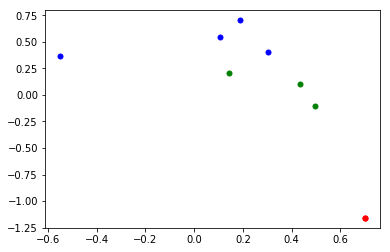

0
ÊÄé‰πàÂõû‰∫ãÂïä ‰Ω†‰ª¨ÊÄé‰πàÂõû‰∫ãÂïä
1
ÊàëÈúÄË¶ÅÂ∏ÆÂä© ÊàëÈúÄË¶ÅÂÆ¢Êúç ÊàëÈúÄË¶Å‰∏™‰∫∫Â∑• ÊàëÈúÄË¶Å‰∫∫Â∑•ÊúçÂä°
2
ÊÄé‰πàÊêûÂæó ÊàëÈúÄË¶ÅËß£Èáä ÂèØ‰ª•Èù†Ë∞±ÁÇπÂêóÔºü
1154.8014423234176


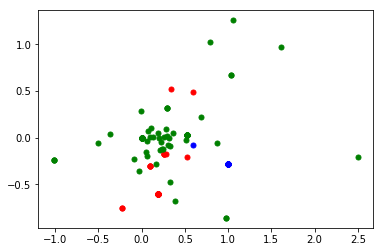

0
Ë°å Â•ΩÁöÑ Ë°åÂêß Â•ΩÁöÑÔºåÂ§öË∞¢ÔºÅ Â•ΩÂêßÔºÅ Â•ΩÁöÑ, Â•ΩÂìí Â•ΩÊª¥ Â•ΩÁöÑ! Â•ΩÁöÑ„ÄÇ Â•ΩÁöÑÂ•ΩÁöÑ Â•ΩÁöÑÂë¢ Â•ΩÂïä Â•ΩÂë¢ Â•Ω„ÄÇ Â•ΩÁöÑ. ÂóØÂ•Ω Âì¶Â•ΩÁöÑ Â•ΩÁöÑÂì¶ Â•Ω! ÂóØ,Â•ΩÁöÑ ÂóØÂóØÂ•ΩÁöÑ Â•ΩÁöÑÔΩû Â•ΩÁöÑ,ÂÆöÂêß Â•ΩÂìí! Â•ΩÁöÑÂìü Â•ΩÔΩû Â•ΩÂ•ΩÂ•Ω Â•ΩÂíß Â•ΩÁöÑÂëÄ Â•ΩÁöÑÊ≤°ÈóÆÈ¢ò ÂìàÂìàÂ•ΩÁöÑ Â•ΩÂìíÂ•ΩÂìí Â•ΩÂìíÔΩû ÊÅ©,Â•Ω Âì¶Âì¶Â•Ω ÂìàÂìà Â•ΩÂëê
1
ÂØπÁöÑÂë¢ ÂØπÂïä ÂØπÂëÄ ÂØπÂìí ÂØπÁöÑ. ÂØπÂØπ ÂØπÂØπÂØπ ÂØπ. ÂØπÁöÑ„ÄÇ ÂØπ„ÄÇ ÂØπÁöÑÂØπÁöÑ ÂØπ! ÂØπÁöÑ ÂØπ È©¨‰∏ä
2
ÊòØÁöÑ Ë∞¢Ë∞¢ Â•ΩÁöÑ Ë∞¢Ë∞¢ ÂèØ‰ª• ÊòØÁöÑ ÊàëÁúãË°å Â•ΩÁöÑË∞¢Ë∞¢‰Ω† OKË∞¢Ë∞¢ ÂóØË∞¢Ë∞¢ Ê≤°Èîô„ÄÇ Á°ÆÂÆö ÂèØ‰ª•ÁöÑ ÊòØÂïä Ê≤°ÈóÆÈ¢ò ÊòØÁöÑ„ÄÇ ÈÉΩÂèØ‰ª• Â•ΩÂëÄ Èöè‰æø ÂèØ‰ª•Âïä ÈÉΩË°å ÂóØÂëê ÊòØÂìí ÊòØÁöÑÊòØÁöÑ Ë¶ÅÁöÑ ÊòØÁöÑ, ÂØπÁöÑ,Ë∞¢Ë∞¢ ÂóØÂóØÂóØ Ê≤°Èîô ÊòØÁöÑÂë¢ ÊòØÁöÑÊòØÁöÑ. ÂóØ„ÄÇ ÊòØÂëÄ ÂóØ, ÊòØËøô‰∏™ Á∫¶ ÂóØÂïä ÊúâÁöÑ Â∞±Ëøô‰∏™ ÈúÄË¶ÅÁöÑ ÊòØÊª¥ ÂèØ‰ª•ÂëÄ ËÆ¢Âêß ÂèØ‰ª•ÂèØ‰ª• ÂØπÊª¥ ÊòØÁöÑÂëÄ ‰πüÂèØ‰ª• Â•ΩÁöÑ,Ê≤°ÈóÆÈ¢ò Âì¶‰∫Ü Â∑Æ‰∏çÂ§ö Á°ÆÂÆö„ÄÇ ÈÇ£Â∞±Ëøô‰∏™Âêß Â∞±Ëøô‰∏™Âêß ÂóØÈÇ£ okÁöÑ ÂóØÂï¶ Â•ΩÂãí ÂØπÂ§¥ ÂóØÊòØ È

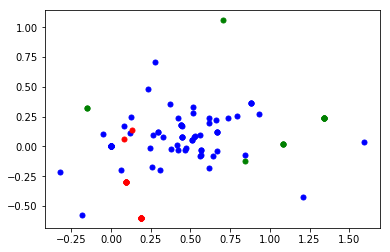

0
Â•ΩÂòû Â•Ω, ÂóØÂ•ΩÁöÑ Â•ΩÁöÑÂìà ÂóØÂóØ,Â•ΩÁöÑ Â•ΩÂì¶ Âì¶Âì¶Â•ΩÁöÑ Âì¶,Â•ΩÁöÑ ÂóØ,Â•Ω Âì¶,Â•ΩÂêß Âì¶Â•Ω Â•ΩÂòû! Âì¶Âì¶,Â•Ω Â•Ω Â•ΩÁöÑÂ∞èÊù• Â•ΩÁöÑÂÜçÊù•
1
Áü•ÈÅì‰∫ÜË∞¢Ë∞¢ ÊÅ© Ë∞¢Ë∞¢ ÂóØÂóØÔΩû ÂóØÂóØ ÂóØ Âì¶Âì¶ ÊÅ© ÂóØÂë¢ Êî∂Âà∞‰∫Ü ÊÅ©ÊÅ© Â•Ω,Ë∞¢Ë∞¢ Âì¶Âì¶Âì¶ ÂóØÂì™ Êî∂Âà∞,Ë∞¢Ë∞¢ Áü•ÈÅì‰∫Ü,Ë∞¢Ë∞¢ Êî∂Âà∞‰∫Ü,Ë∞¢Ë∞¢ ÊòéÁôΩ‰∫Ü,Ë∞¢Ë∞¢ ÁúãÂà∞‰∫Ü Êî∂Âà∞, ÈÇ£Â∞±Â•Ω Âô¢Âô¢ ÂóØÂóØ, ÂóØÂóØ„ÄÇ Êî∂Âà∞Âï¶ Â•ΩÁöÑ,Áü•ÈÅì‰∫Ü ÂóØÂìº Êî∂Âà∞‰∫Ü, ÈÄÅÂà∞‰∫Ü Âì¶„ÄÇ Âú®ÁöÑ Áü•ÈÅì‰∫Ü, ÈÖ±Á¥´ Â¶• ËûÉËüπÂà∞‰∫Ü Ë∞¢Ë∞¢‰Ω†Âïä!Áü•ÈÅì‰∫Ü Âì¶ ÊàëÁü•ÈÅìÊàëÂ∑≤ÁªèÊâìËøáÂç°Âï¶ ËÄ∂ Â•ΩÁöÑÂì• Âê¨Âà∞Âêó? OK ÊÅ©Âïä ‰∏çÂÆ¢Ê∞î/:heart ÊàëË¶ÅÂáÜÂ§áÁúã‰π¶‰∫Ü ÂìáÂ°û„ÄÇÁúüÁöÑÊúâÂõûÂ§ç„ÄÇ‰∏çËøáÂÖ∂ÂÆûÊ≤°‰ªÄ‰πà‰∫ã„ÄÇ Ê≤°ÊúâÂï¶!ÊòØ‰Ω†Â§™ÂÆ¢Ê∞î‰∫Ü ÊàëÊó∂ÂàªÁªô‰Ω†ÂáÜÂ§áÁùÄÂë¢ Âà´ÂêµÈÜíÊàëÂïä Áü•ÈÅì‰∫ÜË∞¢Ë∞¢!ÊàëÂ∑≤ÁªèÂÖÖÂ•ΩÁîµ‰∫Ü Â•ΩÁöÑ Â∑≤Êî∂Âà∞ ÁúãÂà∞‰∫Ü!Ë∞¢Ë∞¢ Âì¶/::O ÊòØÁöÑ Áü•ÈÅì‰∫Ü Â•ΩÁöÑ Á®çÁ≠â Ë∞¢Ë∞¢Áü•ÈÅì‰∫Ü ‰∏çÂÆ¢Ê∞îÂì¶~ ÂíåÂè∏Êú∫Â∑≤ËÅîÁ≥ªÂ•Ω Êî∂Âà∞/:ok Áü•ÈÅì‰∫Ü/::P/::D ‰Ω†Êî∂Âà∞‰∫ÜÂêó ‰Ω†ËøòÁúü‰∏çÂÆ¢Ê∞î ÈÇ£Â∞±‰∏çÂÆ¢Ê∞îÂíØ~ Êî∂Â

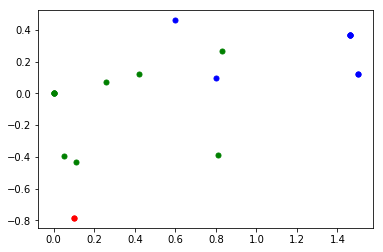

0
ÊàëÈóÆÈóÆ ÊàëÈóÆ‰∏ã
1
Á®çÁ≠â Á≠â‰∏ã Á≠â‰∏Ä‰∏ã Á≠â‰ºö Á≠â Á®çÁ≠â‰∏ã Á≠âÊàëÊü•‰∏Ä‰∏ã Á≠âÊàëÁúã‰∏Ä‰∏ãÂìà
2
Á≠âÁ≠â Á®çÁ≠â‰∏Ä‰∏ã ÁúãÁúã ÊàëÊÉ≥ÊÉ≥ Â•ΩÁöÑ,ÊàëÁúãÁúã ÊàëÁúã‰∏Ä‰∏ã ÊàëÊü•‰∏Ä‰∏ã ÊàëÊü•‰∏Ä‰∏ãÂìà ÊàëÊÉ≥ÊÉ≥,ÊôöÁÇπÁ≠îÂ§ç‰Ω† ÊàëÁ®çÁ≠â‰∏Ä‰∏ãÂØπÂêß
216.9724364314963


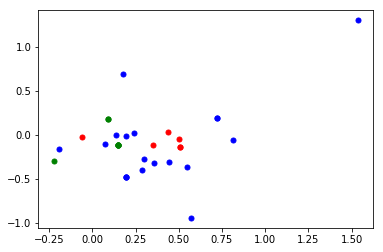

0
‰∏çÊáÇ ‰∏çÊòéÁôΩ Ê≤°ÊáÇ ‰∏çÊáÇ‰∫Ü ‰∏çÊáÇÊòØ‰ªÄ‰πàÊÑèÊÄù ËøôÊ†∑ÊàëËøòÊòØ‰∏çÊáÇ
1
Âï•ÊÑèÊÄù Áúã‰∏çÊáÇ Âï•ÊÑèÊÄù? ËøôÊòØÂï•ÊÑèÊÄù ‰∏çÂ§™ÊáÇ Â∞èÊù•ÁöÑÊÑèÊÄùÊòØ‰∏Ä‰∏™Á∫ßÂà´ÁöÑ3Êú¨‰π¶Ë¶Å380? ËøôÊòØÂπ≤ÂòõÁöÑ ËØ∑ÂõûÁîµËØù ÊòØ‰∏çÊòØËøáÂàÜ‰∫Ü È¢ù? ÊÄéÈ∫ΩÁü•ÈÅì È¢ù ‰ªÄ‰πàÊÑèÊÄù?Âêå‰∏Ä‰∏™‰∫∫ÊîæÂºÉÂèàÊé•Âçï Âä©ÁêÜÊòØ‰ªÄ‰πàÊÉÖÂÜµ ‰Ω†ÈóÆÈóÆ‰ªñ‰ª¨ËøôÊ¨°ÊòØ‰∏çÊòØÂèØ‰ª•ÂΩìÂú∫‰øÆÂ•Ω Êàë‰∏çÊáÇÂæÖÂäû‰ªÄ‰πà Ëøô‰∏™ËÆ¢ÂçïÊòØ‰ªÄ‰πà‰∏™Áä∂ÂÜµ? Áúã‰∏çÊáÇ[Facepalm][Facepalm][Facepalm] ÊàëÁúã‰∏çÊáÇ‰Ω†Âú®ËØ¥‰ªÄ‰πà
2
‰ªÄ‰πàÊÑèÊÄù ‰ªÄ‰πàÊÑèÊÄù? ‰ªÄ‰πàÊÑèÊÄùÂïä ‰ªÄ‰πàÊÑèÊÄùÂë¢ ËøôÊòØ‰ªÄ‰πàÊÑèÊÄù ËøôÊòØ‰ªÄ‰πàÊÉÖÂÜµ ‰ªÄ‰πàÊÉÖÂÜµ ‰ªÄ‰πàÂòõ
47.57532317005453


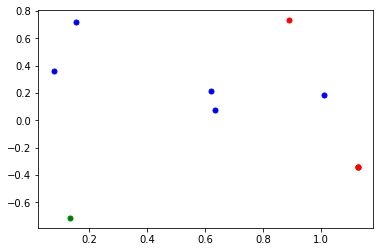

0
‰∏çÊòØËøô‰∏™ ‰∏çÊòØÁöÑ ‰∏çÊòØ‰∏çÊòØ ‰∏çÊòØÂåó‰∫¨ÁöÑ
1
‰∏çÊòØËøô‰∏™Âú∞ÂùÄ Âú∞ÂùÄÊîπ‰∏Ä‰∏ã Âú∞ÂùÄË¶ÅÊç¢ Âú∞ÂùÄ‰∏çÂØπ Âú∞ÂùÄ
2
‰∏ç‰∏ç‰∏ç
13.529164545500045


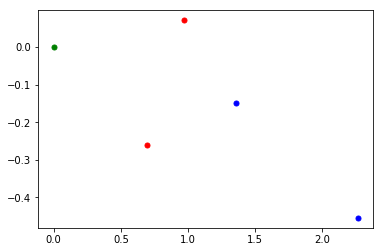

0
Â∏ÆÊàëËÆ¢‰ΩçÂ≠ê Â∏ÆÊàëËÆ¢‰∏ÄÂè∞
1
ÁªôÊàëËÆ¢Âêß Â∏ÆÊàëËÆ¢
2
ÂÆöÂêß
491.8750407092536


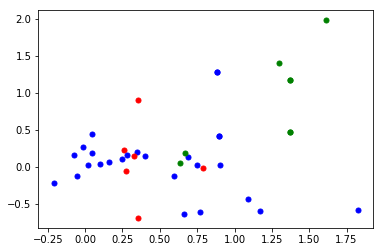

0
ÂêÉÂÆå‰∫Ü ÂêÉ‰∫Ü ÊàëÊúãÂèãÈÉΩÂêÉÂÆåÊó©ÁÇπ‰∫Ü ‰π∞ÂÆå‰∫Ü ÂêÉËøá‰∫ÜÂë¢ ÂÅöÂÆå‰∫Ü‚àº
1
ÊâæÂà∞‰∫Ü ÊàëÊàëÊâæÂà∞‰∫ÜÊâæÂà∞‰∫Ü. Â∑≤ÊâæÂà∞ ÊâæÂà∞Âï¶ ÊáÇ‰∫Ü ‰∫ÜËß£ ÂéüÊù•Â¶ÇÊ≠§ ÊòéÁôΩ‰∫Ü, ÊôìÂæó‰∫Ü ÊàëÂ∑≤ÊâìÂç° ÊàëÊâìÂÆåÂç°‰∫Ü ÊâìËøáÂç°‰∫Ü Â•ΩÁöÑ,ÊòéÁôΩ‰∫Ü,ÂçäËá™Âä®ÁöÑ ÊàëË∫´‰ΩìÊ£íÊ£íÁöÑ ÂêÉÈ•±‰∫ÜÂñùË∂≥‰∫Ü Â∞èÊù•Êàë‰ªäÂ§©ËØª‰∫Ü‰π¶‰∫Ü ÊàëÊó©‰∏äÊâìËøá‰∫Ü Êó©Ëµ∑Â∫ä‰∫Ü Ê≤°ÂäûÊ≥ï Ëá™ÁÑ∂ÈÜí Áî∑ÊúãÂèãÂ•ΩÂ∏Ö ËøòÂ•ΩÊàëËÅ™Êòé Âè™Áªô‰∫Ü0.01 ‰∫ÜËß£‰∫Ü ÊàëÊúâÁ≠îÊ°à‰∫Ü Ë¶ÅÈÅµ‰ªéÊú¨ÂøÉ ÊàëÁªà‰∫éÁôª‰∏ä‰∫Ü Ê≤°‰∫ã ÊàëÁªèÂ∏∏ÁîüÊ∞î„ÄÇË∫´‰ΩìËøòÊòØÊ£íÊ£íÁöÑ Êó©Ëµ∑Â∫ä
2
ËÅîÁ≥ª‰∫Ü ËÅîÁ≥ªËøá ËÅîÁ≥ªËøá‰∫Ü ËÅîÁ≥ªÊàë‰∫Ü ËÅîÁ≥ª‰∏ä‰∫Ü ËÅîÁ≥ªËøáÂø´ÈÄíÂëò ËÅîÁ≥ª‰∏ä‰∫ÜÂêó ‰πüÂ∑≤ÁªèËÅîÁ≥ªËøáÂ∞èÂì•‰∫Ü
113.22296318386586


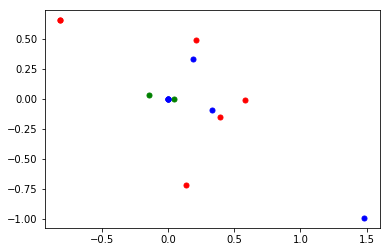

0
‰∏çÂèØËÉΩ ÊÄé‰πàÂèØËÉΩ ‰∏ç‰ºöÂêß ‰∏ç‰ºöÂïä ‰∏çÂèØ‰ª• ËøôÊòØÂÆåÂÖ®‰∏çÂèØËÉΩÁöÑ!!!
1
ËøòÊòØ‰∏çË°å Ê≤°Áî® ‰∏çË°åÂïä ‰∏çË°å ‰∏çË°å  ‰∏çË°å Âèë‰∫Ü‰∏§Ê¨°Ë∑ëËÖøËÆ¢Âçï‰∫Ü Â§™‰∏çÈù†Ë∞±‰∫Ü ‰∏çË°å?
2
Â§™‰∏çÈù†Ë∞± ‰∏çÈù†Ë∞±
81.99485527993085


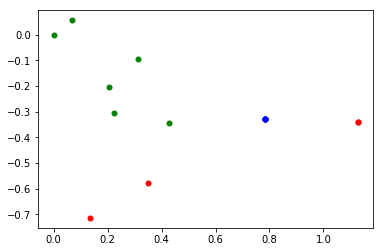

0
‰∏çÊòØ Ê≤°ÊúâÂïä ‰∏çÂèØ‰ª• ‰∏çÊòØÂïä
1
ÈîôÂï¶ Èîô‰∫Ü Èîô Èîô‰∫ÜÂïä
2
‰∏çÂØπ Âê¶ ÂàöÊâç‰∏Ä‰∏™Ë∑ëËÖøÁöÑÂçï‰∏ãÈîô‰∫Ü ÊàëÈóÆ‰Ω†Èîô‰∫ÜÊ≤°Êúâ Â§™ÊâØ‰∫ÜÂïä ÊñáÁ´†ÂèÇÊï∞ÈîôËØØ
95.33750582861825


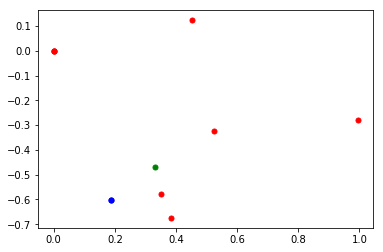

0
ÂèØ‰ª•‰πàÔºü ÂèØ‰ª•Âêó? ok? Â•Ω‰∏çÂ•Ω ËøòÊ≤°ÊúâÂêó ÂèØ‰ª•Âòõ ÂØπÂêß Â∞èÊù•Êó©‰∏äÂ•Ω!‰Ω†ÁöÑÂ§ßÁ∫≤ÂèëÊàëÁúãÁúãÂ•Ω‰∏çÂ•ΩÂïä?
1
Â•ΩÂêó Â•ΩÂòõ
2
Êúâ‰∫ÜÂêó
512.3769111939785


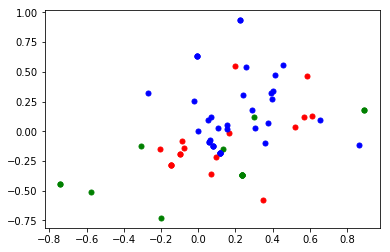

0
‰ªäÂ§©‰∏çÈúÄË¶Å ‰∏çÈúÄË¶Å‰∫ÜË∞¢Ë∞¢ ‰∏çÈúÄË¶Å ‰∏çÈúÄË¶Å‰∫Ü ‰∏çÈúÄË¶Å‰∫Ü,Ë∞¢Ë∞¢ ÊöÇÊó∂‰∏çÈúÄË¶Å ‰∏çÂè´‰∫Ü Ê≤°ÊúâÂ∞±ÁÆó‰∫Ü ÊàëËá™Â∑±Êù•Âêß ‰∏çÈúÄË¶Å‰∫Ü, ‰∏çÂ•ΩÊÑèÊÄùÊàë‰∏çÈúÄË¶Å Êàë‰∏çÈúÄË¶ÅË∑ëËÖøÂì•Âï¶ ‰∏çÈúÄË¶Å ‰∏çÊª°ÊÑè ÂóØ„ÄÇÊöÇÊó∂Ê≤°ÊúâÈúÄË¶ÅÂ∏ÆÂøôÁöÑ Êàë‰∏çÈúÄË¶ÅÂè´ËΩ¶ ÊàëÁöÑÈóÆÈ¢òËøò‰∏çËß£ÂÜ≥ ÂÖà‰∏çÈúÄË¶ÅÂêß
1
‰∏ç‰∫ÜÔºåË∞¢Ë∞¢ ÁÆó‰∫Ü ÈÇ£ÁÆó‰∫Ü ‰∏çÁî®‰∫Ü,Ë∞¢Ë∞¢ ‰∏çÁî®‰∫ÜË∞¢Ë∞¢ Ë∞¢Ë∞¢,‰∏çÁî®‰∫Ü ‰∏çÁî®Ë∞¢Ë∞¢ ÁÆó‰∫ÜÂêß ‰∏çÁî®‰∫Ü, ‰∏çÁî®,Ë∞¢Ë∞¢ ÈÇ£ÁÆó‰∫ÜÂêß ÁÆó‰∫ÜÁÆó‰∫Ü ÁÆó‰∫Ü,‰∏çÁî®‰∫Ü ‰∏çÁî®, ÊòéÂ§©ÂÜçËØ¥Âêß ÈÇ£Â∞±ÁÆó‰∫ÜÂêß ÁÆó‰∫Ü ‰∏çÁî®‰∫Ü ‰∏çË¶ÅÊ†∏ÂÆû‰∫Ü ÊàëËá™Â∑±ËÆ¢‰∫Ü‰∏≠ÂçàÈ•≠ ‰Ω†Âà†Èô§Âêß,ÊàëËá™Â∑±Êù• ËøôÊ†∑Âì¶,ÈÇ£Â•ΩÂêß ‰ªäÂ§©Â∑≤ÁªèÂñùËøá ÈÄÄ‰∏ãÂêß/::> ÊòéÂ§©ËßÅ/:,@-D Â•ΩÈ∫ªÁÉ¶ËøòÊòØÁÆó‰∫ÜÂêß ÂìàÂìàÔºåÈÇ£ÁÆó‰∫Ü ÊàëËØ¥ÁÆó‰∫Ü ÁÆó‰∫Ü ÊàëÈÉΩÂñù‰∫Ü Ë∞¢Ë∞¢!ÈÄÅÊú∫‰∏çÁî®ÂÆâÊéí‰∫Ü Êàë‰∏çÂè´ËΩ¶ ÊúâÁöÑËØùÊàë‰ºöÊâæ‰Ω†ÁöÑ Âà´ËØ¥‰∫Ü È∫ªÁóπÁöÑ   Ê≤°Âè´‰Ω† ‰∏çÁî®‰∫Ü Ë∞¢Ë∞¢ ‰∏çÁî®‰∫Ü Ë∞¢Ë∞¢Âìà ‰∏çÁî®‰∫Ü„ÄÇË∞¢Ë∞¢ ‰∏çË¶ÅÊú∫Âô®‰∫∫ ÊàëÁ≠â‰∏Ä‰∏ãÂÜçÊù•Êâæ‰Ω†„ÄÇ
2
ÈÇ£Â∞±‰∏çË¶Å‰∫Ü Áé∞Âú®‰∏çÁî® ‰∏çÁî®‰∫

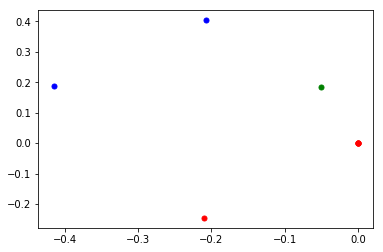

0
Áé∞Âú® Áé∞Âú®Áé∞Âú® È©¨‰∏ä Áé∞Âú®„ÄÇ ‰∏çË°åÔºåÂøÖÈ°ªÁé∞Âú®
1
ÊÄ• ÁùÄÊÄ•
2
‰∏çË°åÔºåÊàëÊÉ≥Áé∞Âú®
159.2067194848927


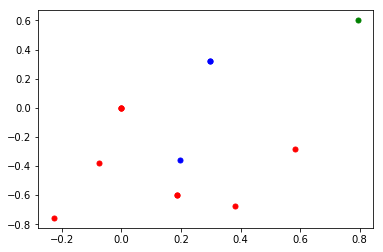

0
Â•Ω‰∫Ü ÂèØ‰ª•‰∫Ü Â•ΩÂï¶ Ë°åÂêß ok‰∫Ü ÊêûÂÆö‰∫Ü Áé∞Âú®ÂèØ‰ª•‰∫Ü Â∞±ÈÖ± ÂèØ‰ª•‰∫Ü„ÄÇ
1
Ê≤°‰∫Ü Â∞±ËøôÊ†∑Âêß Â∞±ËøôÊ†∑
2
ÁªëÂÆö‰∫Ü
17.743432755329245


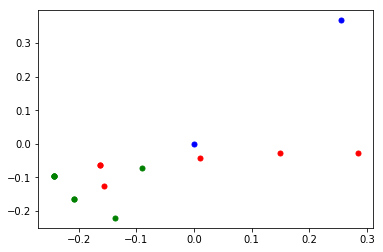

0
Êàë‰∏çÊÄ•‰Ω† ÂóØ‰∏çÊÄ•Ë∞¢Ë∞¢ ÂÜçÊúâ‰∏™‰∏çÊÄ•ÁöÑ‰∫ã Ê≤°ÈóÆÈ¢ò,‰πü‰∏çÊÄ• ÂóØ,Ëøô‰∏™‰πü‰∏çÊÄ• Ê≤°‰∫ã,‰Ω†Êü•,Êàë‰∏çÊÄ•
1
ÂÖà‰∏çÂøô ‰∏çÊÄ•‰∏çÊÄ•
2
‰∏çÊÄ• Êàë‰∏çÊÄ• Â•ΩÁöÑ‰∏çÊÄ• ÈÉΩ‰∏çÊÄ•ÁöÑ ÈÉΩ‰∏çÊÄ• Âìá‰∏çÊÄ• Êàë‰∏çÊÄ•ÁöÑÂìàÂìà ÈÉΩÊòØ‰∏çÊÄ•ÁöÑ‰∏úË•ø
156.91088931379983


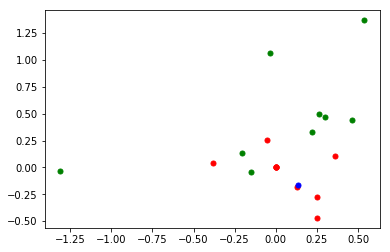

0
ÈÇ£ÊÄé‰πàÂäû ÊÄé‰πàÂºÑ ÊÄé‰πàÂäû? ÂíãÂäû ÊÄé‰πàÂºÑ? ÊàëË¶ÅÂ§ÑÁêÜÁªìÊûú ËÇø‰πàÂäû ‰Ω†ÊòØ‰∏çÊòØË¶ÅÂ∏ÆÊàëÂ§ÑÁêÜ‰∏ã ÈÇ£‰ªÄ‰πàÂäûÂïä?‰Ω†ËØ¥Âïä Ë∑ëËÖøÂäûÊ∏ØÊæ≥Á≠æÊ≥®
1
Ëøô‰∏™ÊÄé‰πàÂºÑÈáå
2
ÊÄé‰πàËØ¥ Â¶Ç‰Ωï ÊÄé‰πàËß£ÂÜ≥ ÊàëÊÄé‰πàËÅîÁ≥ª‰ªñ ÊÄé‰πàËß£ÂÜ≥ÊàëÊäïËØâÁöÑ‰∫ãÊÉÖ ÁÑ∂ÂêéÊÄé‰πàÂÅö ÊÄé‰πàËÅîÁ≥ª ËØ∑Â∏ÆÊàëÂ§ÑÁêÜÈÄÄÊ¨æ ËØ∑Â∞ΩÂø´ÁúãÁúãÊÄé‰πàÂ§ÑÁêÜ
64.95375164311572


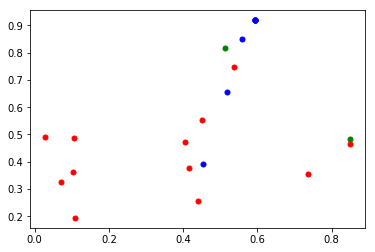

0
ÊàëÂÖàËØïËØï ÊàëÂéªËØïËØï ÊàëÂ∞±ËØïËØï ÂÜçËØïËØï ÊàëÂÜçËØïËØï ‰Ω†ÂÜçËØïËØï ÊàëÊù•ËØïËØï ÊàëÂú®ËØïËØï ÊÖ¢ÊÖ¢Êù• ÊàëÂ∞ùËØï‰∏ã Ë∞¢Ë∞¢ Â∞ùËØï‰∏Ä‰∏ã ÊÉ≥Êù•ËØïËØïÂë¢
1
ËØïËØïÂêß ÊàëËØïËØï ËØïËØïÂ∞±ËØïËØï ÈÉΩËØïËØï Â•ΩËØïËØï ËØïËØïÁöÑ Êàë‰ª¨ÂÖàËØïËØï ËØïËØï
2
Á≠æÂà∞ËØïËØï ÊâìÂç°ËØïËØï
146.37834711011573


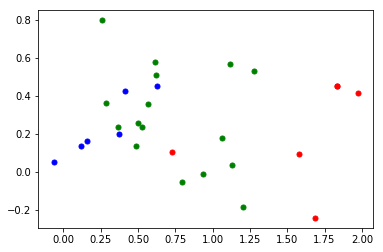

0
‰øÆÊîπ Êîπ‰∏Ä‰∏ã Êõ¥Êîπ ÊÄé‰πàÊîπ ÁîµËØùÊîπ‰∏Ä‰∏ã ‰øÆÊîπ‰∏Ä‰∏ã
1
‰øÆÊîπ‰∏Ä‰∏ãÂÖ¨Âè∏Âú∞ÂùÄ,Â¢ûÂä†Ë•øÈó® Â∞èÂä©ÁêÜ Â∏ÆÊàëÈÄÅÂà∞ÂçóÊ•ºÂñî ‰Ω†Â•Ω,ÊàëÁöÑÈÄÅË¥ßÂú∞ÂùÄÈîô‰∫Ü,Â∫îËØ•ÊòØÂª∂Èùô‰∏úÈáå3Âè∑Ê•º5ÂçïÂÖÉ302 ÊàëË¶ÅÊîπÈÄÅÂú∞ÂùÄÁôºÁµ¶ÈÄÅÂñÆÂ§ßÂì•Âóé ËÉΩÂê¶Êîπ‰∏™Âú∞ÂùÄÂà∞ÂèåÊ¶ÜÊ†ëÂçóÈáå ÊàëÂè´È©¨Â•áÊúµÈÄÅÂà∞Ëøô‰∏™Âú∞ÂùÄ
2
ÊÄé‰πà‰øÆÊîπËÆ¢ÂçïÂú∞ÂùÄ Âú∞ÂùÄË¶Å‰øÆÊîπ Êç¢‰∏™Âú∞ÂùÄ,ÊääÂú∞ÂùÄÂèë‰Ω†ËøôÈáåÂèØ‰ª•‰πà Êç¢Êó∂Èó¥ Âú∞ÂùÄ‰øÆÊîπ ÊàëÊ∑ªÂä†‰∏ç‰∫ÜÂú∞ÂùÄ ÊÄé‰πàÂà†Èô§ÊàëÁöÑÂú∞ÂùÄÂëÄ Â∏ÆÊàëÂú∞ÂùÄÊç¢‰∏ãÂèØ‰ª•Âêó ÊàëÊîπ‰∏™Âú∞ÂùÄ ÂÆö‰πâ‰∏Ä‰∏ãÊàëÂ•≥ÊúãÂèãÁöÑÂú∞ÂùÄ Âú∞ÂùÄÂºÑÈîô‰∫Ü Êç¢Âú∞ÂùÄ Â¶Ç‰Ωï‰øÆÊîπÂú∞ÂùÄ Âú∞ÂùÄËØÜÂà´ÁöÑ‰∏çÂØπÂïä Êõ¥Êîπ‰∏Ä‰∏ãÂú∞ÂùÄ ÊàëË¶ÅÊõ¥Êîπ‰∏Ä‰∏ãÈÖçÈÄÅÂú∞ÂùÄ
21.201117316762566


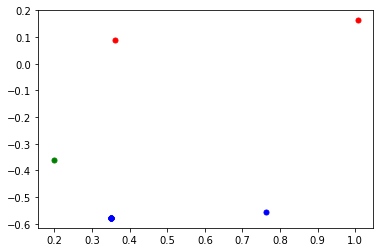

0
ÊöÇÊó∂Ê≤°Êúâ ËøòÊòØÊ≤°Êúâ
1
Êú®Êúâ Ê≤°ÊúâÂë¢ Ê≤°ÊúâÂì¶ Ê≤°ÊúâÂëÄ Âπ∂Ê≤°Êúâ Ê≤°ÊúâÁöÑ Ê≤°Êúâ„ÄÇ ÈÉΩÊ≤°Êúâ
2
Ê≤°Âë¢
18.855039207048154


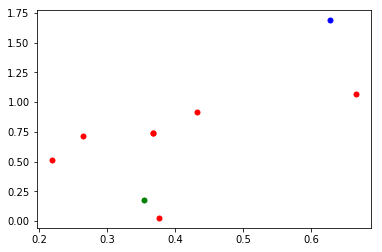

0
APPÂíåÂÖ¨‰ºóÂè∑Áî®Âì™‰∏™Ôºü ÂÖ¨‰ºóÂè∑ÂíåAPPÂì™‰∏™Â•ΩÁî® ÊÄé‰πàÊúâApp‰πüÊúâÂÖ¨‰ºóÂè∑Ôºü ÂÖ¨‰ºóÂè∑ÂíåAPPÊúâÂå∫Âà´Âêó ÂÖ¨‰ºóÂè∑ÂíåAPPÊúâÂï•Âå∫Âà´Ôºü appÂ•ΩÁî®ËøòÊòØpersonÂÖ¨‰ºóÂè∑ Âú®ÂÖ¨ËØÅÂè∑ÊÄé‰πàÊêúÁ¥¢‰∏çÂà∞‰Ω†
1
ÂÖ≥Ê≥®ÂÖ¨‰ºóÂè∑
2
ÂæÆ‰ø°Ë∑üappÁöÑÂå∫Âà´
52.88169267093927


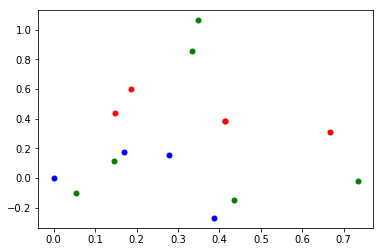

0
‰∏ãËΩΩapp ÊàñËÄÖapp app‰∏ãËΩΩ appÊÄé‰πà‰∏ãËΩΩ appÂú®ÈÇ£‰∏ãËΩΩ
1
APP‰∏ãËΩΩ APP AppÊòØ‰∏çÊòØ‰∏ãÊû∂‰∫Ü Â∞èÊù•‰ªÄ‰πàÊó∂ÂÄôÂá∫appÂë¢ Ë∂ÖÊúüÂæÖ?
2
Ê≤°ÊâæÂà∞‰Ω†‰ª¨app Ê≤°ÊâæÂà∞Âú®app‰∏ä ‰Ω†ÊúâÁßªÂä®app‰πà?appÈáåÈù¢Êúâ Âä©ÁêÜÊù•‰πüapp ËøôÊ†∑ÊàëÂ∞±‰∏çÈúÄË¶ÅÂçïÁã¨appÂï¶ Âä©ÁêÜÊù•‰πüËΩØ‰ª∂‰∏ãËΩΩ
4.542116747189058


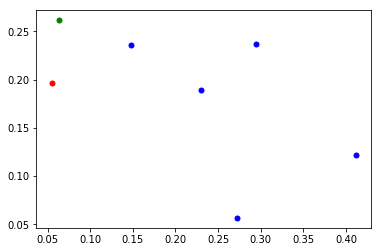

0
Â∏åÊúõËÉΩ‰øùÊä§ÊàëÁöÑÈöêÁßÅ
1
Ê≥ÑÈú≤ÈöêÁßÅÂíãÊï¥ Ê≥ÑÈú≤ÈöêÁßÅ‰∫ÜÂ∞±‰∏çÂ•Ω‰∫Ü Ê≥ÑÈú≤ÊàëÈöêÁßÅÊÄé‰πàÂäûÔºü ‰∏çÊÉ≥Ë¢´Ê≥ÑÈú≤ÈöêÁßÅ ‰Ω†‰ª¨‰∏ç‰ºöÊ≥ÑÈú≤ÊàëÈöêÁßÅÂêß
2
ÊääÊâãÊú∫Âè∑Áªô‰Ω†‰∏ç‰ºöÊúâ‰ªÄ‰πàÂΩ±ÂìçÂêß
19.40389041852761


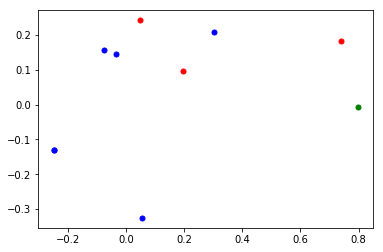

0
Êúâ‰ªÄ‰πàÂ•ΩÁé©ÁöÑÊñ∞ÂäüËÉΩÔºü Êúâ‰ªÄ‰πàÊñ∞ÂäüËÉΩ ÊúÄËøëÊúâÊñ∞ÂäüËÉΩÂêóÔºü
1
ÊúâÂï•ÊúÄÊñ∞ÂäüËÉΩÂëÄÔºü ÊúâÊÑèÊÄùÁöÑÂäüËÉΩÊúâÂòõ ÊúâÂï•ÂäüËÉΩÁèæÂú® Ê≠£Âú®ÁÜüÊÇâÊúçÂä°ÂäüËÉΩÓêâ ‰Ω†ÈÉΩÊúâÂï•ÂäüËÉΩ ÊàëÊÉ≥ËØï‰∏ÄËØï‰Ω†ÁöÑÂäüËÉΩ
2
ËøòÊúâÂï•Áî®?
113.55638122417929


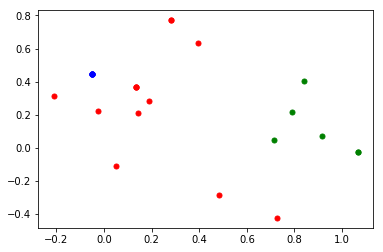

0
‰ªäÂ§©Âá†Âè∑ Áé∞Âú®Âá†ÁÇπ‰∫Ü, ‰πåÈ≤ÅÊú®ÈΩêÁé∞Âú®Âá†ÁÇπ ‰Ω†Â•Ω‰ªäÂ§©Âá†Âè∑ ‰ªäÂ§©Êó•Êúü ‰∏ãÊù•ËøòËÉΩ‰∏ãÊù•Áé∞Âú®Âá†ÁÇπÈíüÂï¶? ‰∏ç‰ºöÁúãÊó∂Èó¥Âïä Áé∞Âú®Âá†ÁÇπÈíü Áé∞Âú®Âá†ÁÇπ‰∫ÜÂëäËØâÊàë‰∏Ä‰∏ã Âá†ÁÇπÈíü‰∫Ü Âåó‰∫¨Êó∂Èó¥Áé∞Âú®Âá†ÁÇπ Âåó‰∫¨Êó∂Èó¥Âá†ÁÇπ ‰Ω†ËÉΩÂëäËØâÊàëÂá†ÁÇπ‰∫ÜÂêó
1
Âá†ÁÇπ‰∫Ü Áé∞Âú®Âá†ÁÇπ Áé∞Âú®Áé∞Âú®Âá†ÁÇπ‰∫Ü Áé∞Âú®Âá†ÁÇπ‰∫Ü Áé∞Âú®Âá†ÁÇπ‰∫Ü?
2
ËØ∑ÈóÆ‰ªäÂ§©ÂÜúÂéÜ? Âπ¥Èò¥ÂéÜÂ§öÂ∞ëÂè∑ ‰ªäÂ§©Âä™ÂäõÂ§öÂ∞ëÂè∑ ‰ªäÂ§©Èò¥ÂéÜÂ§öÂ∞ëÂè∑ ËØ∑ÈóÆ‰ªäÂ§©Èò≥ÂéÜÂ§öÂ∞ëÂè∑ ËØ∑ÈóÆ‰ªäÂ§©Èò¥ÂéÜÂ§öÂ∞ëÂè∑
43.97017164147844


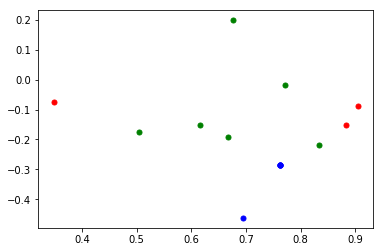

0
Â•ΩÂèã‰ªãÁªçÁöÑ ÊúãÂèã‰ªãÁªçÁöÑ Êàë‰ª¨ÊòØÊúãÂèãÂêó
1
ÊúãÂèãÂúàÁúãÂà∞ÁöÑ ÊúãÂèãÂúà ÊúãÂèãÂúàÁúãÂà∞ ÊúãÂèãÂúàÁúãÂà∞ÁöÑ! ÊúãÂèãÂúàÁúãÂà∞ÁöÑÂì¶
2
Áæ§ÈáåÂèëÁé∞ÁöÑ ÊàëÊòØÂú®ÊúãÂèãÂúàÁúãÂà∞ÁöÑ ÊúãÂèãÂúàÁúãÂà∞,ÁÑ∂ÂêéÊúãÂèãÊé®Ëçê ÊàëÂú®ÊúãÂèãÂúàÁúãÂà∞ÁöÑ,ÊúâÈóÆÈ¢òÂêó? ÊúãÂèãÂúàÁúãÂà∞Êª¥ Âú®ÊúãÂèãÂúàÁúãÂà∞Â∞èÊù•
11.164501995640578


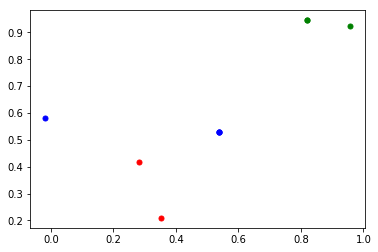

0
ÊàëÂÜçÂ§öÊ¨°ÈÄÄÂá∫ÂÜçÁôªÂΩïËØïËØï Â•ΩÁöÑÂ•ΩÁöÑÈÇ£ÊàëÈÄÄÂá∫ÈáçÊñ∞ÁôªÂΩï
1
ÈÄÄÂá∫ ÈÄÄÂá∫‰∫Ü ÈÄÄÂá∫Âêß ‰∏ç‰ºöÈÄÄÂá∫
2
ÈÄÄÂá∫ÁôªÂΩï ÁÇπÈÄÄÂá∫ÁôªÂΩï? ÁÇπ‰∫ÜÈÄÄÂá∫ÁôªÂΩï
21.090736291445594


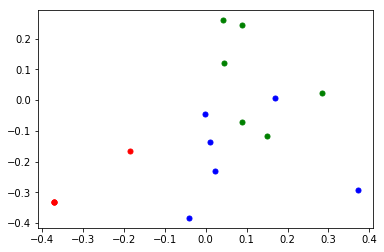

0
Á∫∏Êù°Âë¢ ËÉΩÂ°û‰∏™Á∫∏Êù°‰πà ‰º†Á∫∏Êù° Á∫∏Êù°
1
ÂåøÂêçÂ∞èÁ∫∏Êù° ËÉΩÂ∏ÆÊàëÂÜô‰∏™Â∞èÁ∫∏Êù°Âêó ÂèØ‰ª•ÈôÑÂ∏¶Â∞èÁ∫∏Êù°‰πà Â∞èÊù•,Áé∞ËøòÊúâÂ∞èÁ∫∏Êù°Âêó Â∞èÁ∫∏Êù° ÊàñËÄÖ Â∞èÁ∫∏Êù°
2
‰∏ÉÂ§ïÂåøÂêç‰º†ËØù ÂåøÂêç ÂåøÂêç‰º†ÊÉÖ Â∞èÊù•    ÂåøÂêçÂ∞èÁ∫∏Êù°ÁöÑÈìæÊé•ÂèëÊàë‰∏Ä‰∏ã ÊÄé‰πàÂåøÂêç‰º†ËØù Â∞èÊù• ÂåøÂêçÂ∞èÁ∫∏Êù°ÁöÑÈìæÊé•ÂèëÊàë‰∏Ä‰∏ã
0.9280229019300263


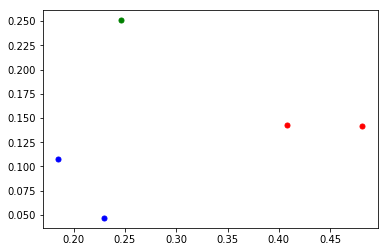

0
ÊÄé‰πàÂèñÊ∂à‰∏ÄÈîÆÈáåÁöÑÂÜÖÂÆπ? ÊÉ≥ÂèñÊ∂à‰∏ÄÈîÆÈáåÁöÑÂÜÖÂÆπ
1
Â¶Ç‰ΩïÂèñÊ∂à‰∏ÄÈîÆÈáåÁöÑÂÜÖÂÆπ? ÊÄé‰πàÊ†∑ÂèñÊ∂à‰∏ÄÈîÆÈáåÁöÑÂÜÖÂÆπ?
2
ÂèñÊ∂à‰∏ÄÈîÆÈáåÁöÑÂÜÖÂÆπÔºåÂ¶Ç‰ΩïÊìç‰Ωú
1.799095186698714


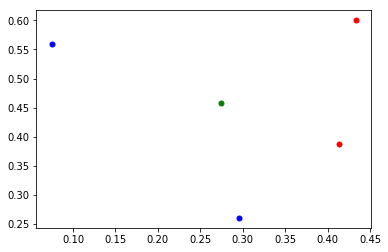

0
Âü∫Á°ÄÊúçÂä° Âü∫Á°ÄÊúçÂä°ÈÉΩÊúâÂï•Âë¢
1
Âü∫Á°ÄÊúçÂä°ÈÉΩÊúâ‰ªÄ‰πàÔºü Âü∫Á°ÄÊúçÂä°ÈÉΩÊúâ‰ªÄ‰πàÈ°πÁõÆ
2
Âü∫Á°ÄÊúçÂä°ÈÉΩÊúâÂì™‰∫õÔºü
0.9250138775677303


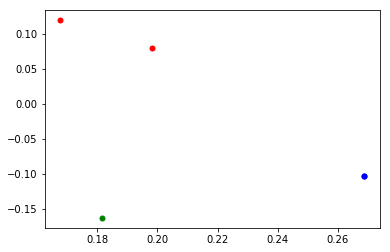

0
Ë∫´Âú®ÂõΩÂ§ñÔºåÊúâÊ≤°Êúâ‰∫∫ËÉΩÂ∏ÆÊàë Ë∫´Âú®ÂõΩÂ§ñÔºåÊúâ‰∫∫ËÉΩÂ∏ÆÊàëÂêóÔºü
1
ÊàëÂú®Âç∞Â∞º‰Ω†ÂèØ‰ª•Â∏ÆÊàëÂêóÔºü ÊàëÂú®Âç∞Â∞º‰Ω†ËÉΩÂ∏ÆÊàëÂêóÔºü
2
ÊàëÂú®ÂõΩÂ§ñ‰Ω†ËÉΩ‰∏çËÉΩÂ∏ÆÊàëÔºü
6.552285636805977


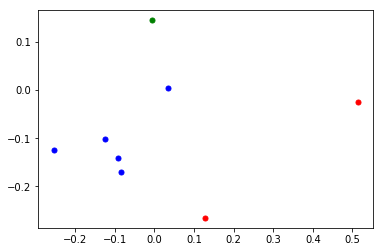

0
Êúâ‰ªÄ‰πà‰π¶Êé®ËçêÂêó ËøòÊúâÂÖ∂‰ªñ‰π¶Êé®ËçêÂêó
1
Êé®ËçêÂá†Êú¨30Êù•Â≤ÅÂ•≥ÊÄßÂñúÊ¨¢ÁúãÁöÑ‰π¶ Ë¶ÅÊù•Êé®ËçêÂá†Êú¨Â•ΩÁúãÁöÑ‰π¶ÁªôÊàë, ÁªôÊàëÊé®ËçêÂá†Êú¨Â•Ω‰π¶ Â∏ÆÊàëÊé®ËçêÂá†Êú¨Â•Ω‰π¶ Êé®ËçêÂá†Êú¨Â•Ω‰π¶
2
Èöè‰æøÊé®Ëçê‰∏ÄÁØáÊñáÁ´†ÁªôÊàë
13.586990343347697


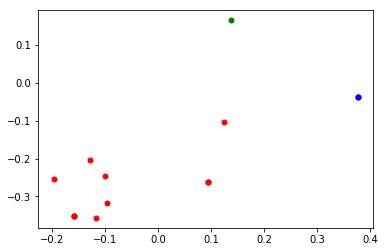

0
ÊâéÂÖã‰ºØÊ†ºÊé®ËçêÁöÑ‰π¶Âçï ÊâéÂÖã‰ºØÊ†ºÊé®Ëçê‰π¶Âçï. ÊâéÂÖã‰ºØÊ†ºÊé®ËçêÁöÑ‰π¶ÂçïÊúâÂì™‰∫õÈÇ£Â∏ÆÊàëÂèë‰∏Ä‰∏ãÊàëÁúãÁúã ÊâéÂÖã‰ºØÊ†º‰π¶Âçï ÊâéÂÖã‰ºØÊ†ºÁöÑ‰π¶Âçï Â∏ÆÊàëÊü•‰∏Ä‰∏ãÊâéÂÖã‰ºØÊ†º‰π¶Âçï ÊâéÂÖã‰ºØÊ†ºÁöÑ‰π¶ÂçïÊòØÂï• Â∞èÊù•Â∏ÆÊàëÊü•‰∏Ä‰∏ãÊâéÂÖã‰ºØÊ†º‰π¶Âçï„ÄÇ ÊâéÂÖã‰ºØÊ†ºÊúâÂì™‰∫õ‰π¶Âïä ÊâéÂÖã‰ºØÊ†ºÁöÑ‰π¶ÂçïÈÉΩÊúâ‰ªÄ‰πà ËÉΩÁªôÊàëÊù•‰∏Ä‰∏™ÊâéÂÖã‰ºØÊ†ºÁöÑ‰π¶ÂçïÂêó?
1
Êé®Ëçê‰π¶ÂçïÁúãÁúã Êé®Ëçê‰∏™‰π¶Âçï
2
ÊàëÁöÑËØª‰π¶ËÆ°ÂàíÊòØËØª‰ªÄ‰πà‰π¶?
111.77598804114515


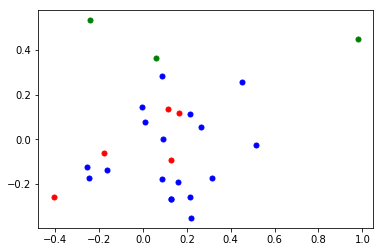

0
Ê≤°‰π¶,ËØªÂï•? ÊÄé‰πàÂºÄÂßãÈòÖËØªÂïä ËØª‰ªÄ‰πà‰π¶ ÁúãÈÇ£‰∫õ‰π¶? ‰∏çÁü•ÈÅìËØª‰ªÄ‰πà‰π¶
1
‰π¶Âçï Êé®Ëçê‰∏ÄÊú¨‰π¶ÁúãÁúã Êúâ‰ªÄ‰πà‰π¶Êé®ËçêÂêó ËøòÊúâÂÖ∂‰ªñ‰π¶Êé®ËçêÂêó ÊúâÊé®ËçêÁöÑ‰π¶Âêó ÊúâÊé®ËçêÁöÑ‰π¶ÁúãÂêó Êúâ‰ªÄ‰πà‰π¶ÂèØ‰ª•Êé®ËçêÁöÑ Áúã‰ªÄ‰πà‰π¶‰πàÊé®Ëçê‰∏ã Ë¶ÅÊù•Êé®ËçêÂá†Êú¨Â•ΩÁúãÁöÑ‰π¶ÁªôÊàë, Ê±ÇÊé®ËçêÊú¨ÂïÜ‰∏öÊñπÈù¢ÊØîËæÉÂ•ΩÁöÑ‰π¶ Â∞èÊù•,ËØ∑Â∏ÆÊàëÊé®ËçêpersonÁöÑ‰π¶ Êúâ‰ªÄ‰πà‰π¶ÂèØ‰ª•Áúã,Êé®Ëçê‰∏Ä‰∏ãÂëó ÊúâÊ≤°ÊúâÊØîËæÉÂ•ΩÁöÑÈÄªËæëËØæÊé®ËçêÊàñËÄÖ‰π¶Êé®Ëçê‰∏ã Âè™ÊòØÊÉ≥Áü•ÈÅì‰ºöÊé®Ëçê‰ªÄ‰πà‰π¶Âë¢?ÊúâÁÇπÂ•ΩÂ•á Èöè‰æøÊé®Ëçê‰∏ÄÁØáÊñáÁ´†ÁªôÊàë ÊúâÊ≤°ÊúâÊé®ËçêÁöÑ‰π¶ÊàñÁîµÂΩ± Êé®Ëçê‰∏ÄÊú¨ÈÄÇÂêàÊàëÁöÑ‰π¶ ËøôÈáåÊúâ‰ªÄ‰πàÂ•Ω‰π¶Êé®Ëçê‰πà?
2
ÊàëË¶ÅÁúã‰π¶ Áúã‰π¶ ÊàëË¶ÅËØª‰π¶
1.9820723027414473


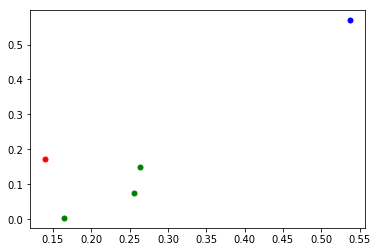

0
Â∞èÊù•‰Ω†ÁöÑÂ∞èÁ®ãÂ∫èÊòØ‰ªÄ‰πà
1
ÂºÄÂèëÂ∞èÁ®ãÂ∫è‰∫ÜÂêóÔºü
2
Êù•‰πüÊúâ‰ªÄ‰πàÂ∞èÁ®ãÂ∫èÔºü ‰Ω†‰ª¨ÈÉΩÊúâ‰ªÄ‰πàÂ∞èÁ®ãÂ∫è ÊúâÂ∞èÁ®ãÂ∫èÂêóÔºü
36.238084489779254


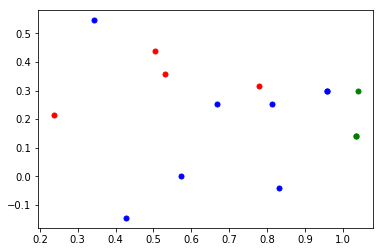

0
Â∞èÁ®ãÂ∫è ÊÄé‰πàÂàõÂª∫Â∞èÁ®ãÂ∫è Áæ§ÈÄöËÆØÂΩïÁöÑÂ∞èÁ®ãÂ∫è‰ΩøÁî® Êúâ‰ºÅ‰∏öÈÄöËÆØÂΩïÁöÑÂ∞èÁ®ãÂ∫èÂêó
1
Áæ§ÈÄöËÆØÂΩïÊÄé‰πàÂàõÂª∫Âïä? ÊÄé‰πàÂàõÂª∫Áæ§ÈÄöËÆØÂΩï ÊÄéÊ†∑ÂàõÂª∫Áæ§ÈÄöËÆØÂΩïÂïä Áæ§ÈÄöËÆØÂΩï‰ΩøÁî®ÊñπÊ≥ï ÊÄé‰πàÂä†ÈÄöËÆØÂΩï ËÆ∞ÂæóÊúâ‰∏™ÈÄöËÆØÂΩïÂêß? Áæ§ÈÄöËÆØÂΩïÂú®Âì™ Áæ§ÈÄöËÆØÂΩïÂú®Âì™ÈáåÂª∫Á´ã
2
Áæ§ÈÄöËÆØÂΩï ÊÄé‰πàÂºÑÁæ§ÈÄöËÆØÂΩï Êü•ËØ¢Áæ§ÈÄöËÆØÂΩïÁîµËØù
25.88082581184132


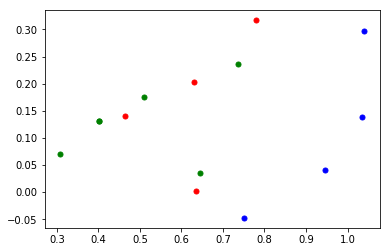

0
Áæ§ÈÄöËÆØÂΩïÂ•ΩÂèãËøõ‰∏çÂéª,ËØ¥ËÆæÁΩÆÊùÉÈôê‰∫Ü Áæ§ÈÄöËÆØÂΩïÁöÑÂ∞èÁ®ãÂ∫è‰ΩøÁî® ÊÄé‰πàÂ∞èÊù•ÈÄöËÆØÂΩï‰∏≠ÁöÑÂ•ΩÂèã? Áæ§ÈÄöËÆØÂΩïÈáå‰∏∫‰ªÄ‰πà‰∏çËÉΩÁõ¥Êé•Êã®ÊâìÁîµËØùÂë¢?
1
ÊÄé‰πàÂºÑÁæ§ÈÄöËÆØÂΩï Áæ§ÈÄöËÆØÂΩïÊÄé‰πàÊîæÂà∞ÈÄöËÆØÂΩïÈáå Êü•ËØ¢Áæ§ÈÄöËÆØÂΩïÁîµËØù Áæ§ÈÄöËÆØÂΩïÂ•ΩÂèãËøõ‰∏çÂéª
2
ËØ∑ÈóÆÊÄéÊ†∑ÂØºÂá∫Áæ§ÈÄöËÆØÂΩï? ÊÄéÊ†∑ÂØºÂá∫Áæ§ÈÄöËÆØÂΩï? Áæ§ÈÄöËÆØÂΩïÊÄé‰πàÁî®„ÄÇ Â¶Ç‰ΩïÂàÜ‰∫´Áæ§ÈÄöËÆØÂΩï? Áæ§ÈÄöËÆØÂΩïÂ¶Ç‰ΩïÂÄíÂá∫ ‰Ω†ÈÇ£‰∏™Áæ§ÈÄöËÆØÂΩïÂÆâÂÖ®Âêó
7.081729852448557


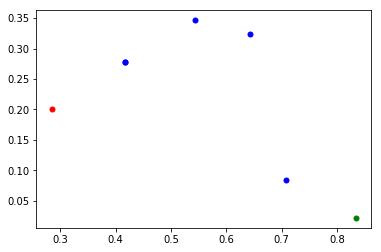

0
ÊàëÊÉ≥ÈÄÄÂá∫ÊÄé‰πàÈÄÄÂïä
1
ÊÄé‰πàÈÄÄÂá∫ÈÄöËÆØÂΩïÂëÄ ÊÄé‰πàÈÄÄÂá∫ÈÄöËÆØÂΩï ÊÄé‰πàÈÄÄÂá∫Áæ§ÈÄöËÆØÂΩï Êó†Ê≥ïÈÄÄÂá∫ÈÄöËÆØÂΩï ‰∏ç‰ºöÈÄÄÂá∫Áæ§ÈÄöËÆØÂΩï
2
ÈÄöËÆØÂΩïÊÄé‰πàÂà†Èô§‰∫∫
0.6423204073469411


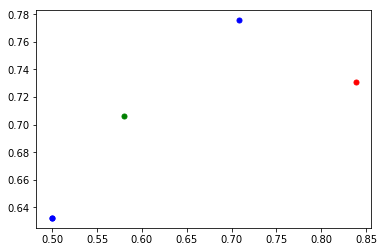

0
ËÅö‰ºöÁ∫¶ÂÆö
1
ËÅö‰ºöÁ∫¶ÂÆöÊÄé‰πà‰ΩøÁî® Â¶Ç‰Ωï‰ΩøÁî®ËÅö‰ºöÁ∫¶ÂÆö ËÅö‰ºöÁ∫¶ÂÆöÂ¶Ç‰Ωï‰ΩøÁî®
2
Êàë‰∏ç‰ºö‰ΩøÁî®ËÅö‰ºöÁ∫¶ÂÆö
1.522644012410809


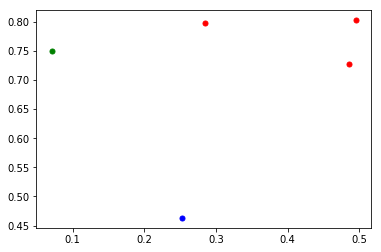

0
Êù•‰πüÂ∫îËÅò ÊÄé‰πàÂéªÊù•‰πüÂ∫îËÅò ÊàëÂèØ‰ª•ÂéªÊù•‰πüÂ∫îËÅòÂêóÔºü
1
Â¶Ç‰ΩïÂà∞Êù•‰πüÂ∫îËÅò
2
ÊÄé‰πàÂ∫îËÅò
67.22808573012945


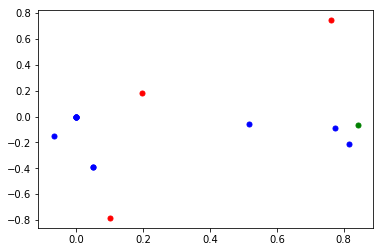

0
ÊãúÊâò Â∏ÆÊàëÁúãÁúã Â∏ÆÊàë‰∏™Âøô
1
‰Ω†ÁúãÁúã Â∏ÆÊàëÁúã‰∏Ä‰∏ã ‰Ω†ÈóÆÈóÆ ËøôÊ†∑ÁöÑ ‰Ω†Áúã‰∏Ä‰∏ã Â∏ÆÊàëÁúã‰∏ã ‰Ω†Â∏ÆÊàëÁúãÁúã ‰Ω†ÁªôÊàëÈóÆÈóÆÂ•ΩÂêó ‰Ω†ÁúãÂëó Áúã‰∏ã È∫ªÁÉ¶‰Ω†Áúã‰∏ã
2
ÁúãÂà∞‰∫ÜÂêó
79.69710973973943


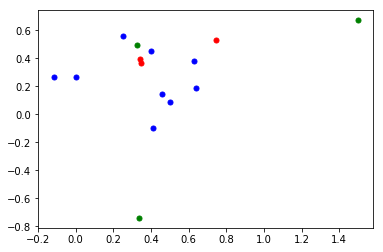

0
Â§™ÊÖ¢‰∫Ü ÂèçÂ∫îÂ§™ÊÖ¢‰∫Ü Â•ΩÊÖ¢Âïä
1
ÊàëÂØπÂä©ÁêÜÊù•‰πüÈùûÂ∏∏Â§±Êúõ ÁÆóÈîô‰∫ÜÂêß? ËøôËΩØ‰ª∂‰∏çË°åÂëÄ ÊàëÊäïËØâ‰Ω†,‰Ω†‰ºö‰∏çÁü•ÈÅìÂêó? ‰Ω†‰ª¨ÊÄé‰πàÂèòÂæóËøô‰πàÁé∞ÂÆû ‰∏∫Âï•‰Ω†‰ª¨ÊúçÂä°Ëøô‰πàÂ∑Æ ‰Ω†‰ª¨Áé∞Âú®ÊïàÁéáËøô‰πà‰Ωé‰∏ã‰πà! ‰Ω†‰ª¨‰ª•ÂâçÊúçÂä°Êå∫Â•ΩÁöÑÂïä ‰Ω†ÊúÄËøëÂ•ΩÊÖ¢Âì¶
2
Â∑ÆËØÑ ÊäïËØâ ÊàëË¶ÅÊäïËØâ
17.855687818245347


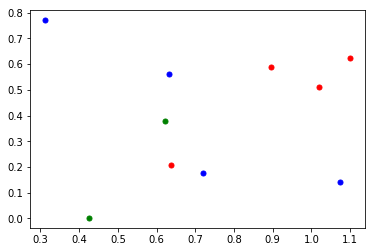

0
Êó†Ê≥ïÈÄÄÂá∫ÁôªÂΩï Êó†Ê≥ïÈÄÄÂá∫ Êó†Ê≥ïÁôªÂΩï ÊàëÁé∞Âú®Êó†Ê≥ïÁôªÂΩï
1
ÁÇπÂáª,ÈÄÄÂá∫ÁôªÂΩïÊó∂,Ë¶ÅÊàëÂÖàÁôªÂΩï ÈÄÄÂá∫ÁôªÂΩï‰∏ç‰∫Ü,ÈÇ£‰∏™Âè∑Á†ÅÊç¢‰∫Ü Êç¢‰∫ÜÊâãÊú∫Êó†Ê≥ïÁôªÂΩï ÊàëÊ≤°ÂäûÊ≥ïÈÄÄÂá∫ÁôªÂΩïÂëÄ
2
ÊâãÊú∫Âè∑Â∑≤Áªè‰∏çÁî®‰∫Ü,Êó†Ê≥ïÈÄÄÂá∫ ÂÆ¢Êà∑Á´ØÊàêËøôÊ†∑‰∫Ü,Êó†Ê≥ïÈÄÄÂá∫Âíå‰ΩøÁî®
7.002992224182147


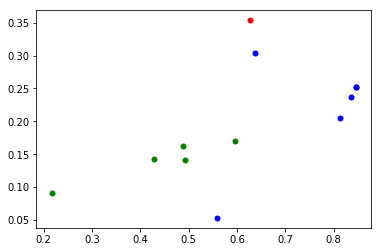

0
ÂèçÈ¶àÈÄöÈÅì
1
ÂèçÈ¶àÈÄöÈÅìËøõ‰∏çÂéª ÂèçÈ¶àÈÄöÈÅìËøô‰∏™Ëøõ‰∏çÂéª ÂèçÈ¶àÈÄöÈÅìÊàëËøõ‰∏çÂéª‰∫Ü ÂèçÈ¶àÈÄöÈÅìÊàëËøõ‰∏çÂéª‰∫ÜÔºåÊàëÊòØvip ‰ΩÜÊòØÂèçÈ¶àÈÄöÈÅìËøõ‰∏çÂéªÂïä ÂèçÈ¶àÈÄöÈÅìÊÄé‰πàËøõ‰∏çÂéª
2
ÂèñÊ∂à‰∏ç‰∫Ü,ÂèçÈ¶àÈÄöÈÅì‰πüËøõ‰∏çÂéª,‰ªÄ‰πàÊÉÖÂÜµ ÂèçÈ¶àÈÄöÈÅìËøõÈÉΩËøõ‰∏çÂéª ÂèçÈ¶àÈÄöÈÅì‰∫∫Ë∂ÖÂ§ö,Ëøõ‰∏çÂéª ÂèçÈ¶àÈÄöÈÅìÂûÉÂúæ,Ê†πÊú¨Ëøõ‰∏çÂéª ÊÄé‰πàÁÇπÂáªÂèçÈ¶àÈÄöÈÅì Â∞±Ê≤°ÊúâËøô‰∏™ÊåâÈíÆ
0.10926391626145492


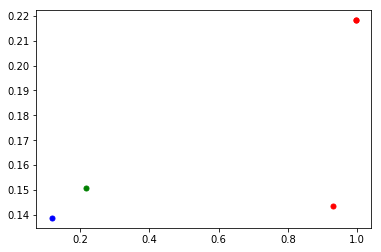

0
Êä•bug Êä•‰∏Ä‰∏ãbug Â∏ÆÊàëÊä•‰∏Ä‰∏ãbug
1
Êó•Á®ãÊúâbug
2
Êó•Á®ãÁöÑËøô‰∫õcase‰Ω†Êä•‰∏Ä‰∏ã
25.025892644731062


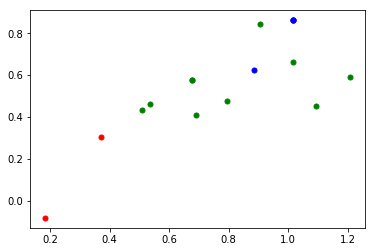

0
test ÊµãÁ≤â,ÂãøÂõû!
1
ÊµãËØï ÊµãËØïÂìà ÊàëÊµãËØï ÊµãËØï‰∏Ä‰∏ã
2
ÊàëÊòØÊµãËØïÁöÑ ÊµãËØïÊµãËØï, ÊµãËØï,ÊµãËØï ÊàëÂú®ÊµãËØï Âú®ÊµãËØï ÊµãËØïÊù•ÁùÄ Ê≤°‰∫ãÊµãËØï ÊµãËØïÂà´ÁêÜ ÊµãËØïÂãøÁêÜ ÊàëÂú®ÊµãËØïÊµãËØï‰Ω†Âê¨‰∏çÊáÇÂêß,
2.345462257498649


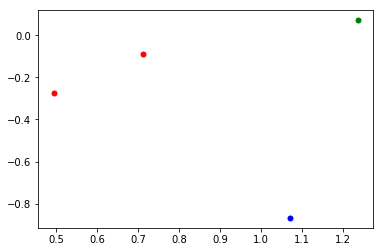

0
ÁÇπ‰∏çÂºÄ Êàê‰∏∫VIPÁÇπ‰∏çÂºÄ
1
Êâì‰∏çÂºÄ
2
Ëøõ‰∏çÂéª
62.76715592954419


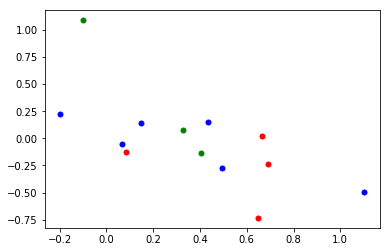

0
ÁΩëÈ°µÊâì‰∏çÂºÄ ÈìæÊé•Êâì‰∏çÂºÄ ÈìæÊé•ÁÇπ‰∏ç‰∫Ü Êó†Ê≥ïÁÇπÂºÄÈìæÊé•
1
ÁÇπ‰∏çÂºÄ Áé∞Âú®Â∞±ÊòØÁÇπ‰∏çÂä®Âïä ËøòÊòØÁÇπ‰∏çÂä®ÂëÄ„ÄÇ ÂèØÊòØÂ§áÊ≥®ÁÇπ‰∏ç‰∏äÊ≤°ÂäûÊ≥ïËæìÂÖ• ÊÄé‰πà‰πüÁÇπ‰∏çÊéâ ÁÇπ‰∫ÜÊ≤°Áî®
2
ÁÇπ‰∏çËøõÂéªÂêñ Â∞èÊù•ÁÇπ‰∏çËøõÂéª ÁÇπÂì™‰∏™Âïä
142.03305542472484


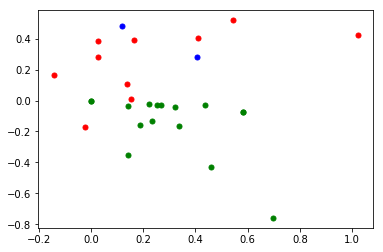

0
‰Ω†Ëøô‰∏äÈù¢Êúâ‰ªÄ‰πàbug Ëøô‰∏™ËøòÊúâbug bug ‰Ω†‰ª¨ÁöÑÈ°µÈù¢Êúâbug ‰Ω†Â•Ω‚Ä¶ÊâìÂç°È°µÈù¢ÊÄªÂá∫Áé∞bug ‰Ω†‰ª¨ÁöÑbugËØ∑Â∞ΩÂø´‰øÆÂ§ç Á≥ªÁªüÂÇªÂêß Á≥ªÁªüÂá∫Èîô Á≥ªÁªü‰π±‰∫ÜÂêß Âá∫Èîô‰∫Ü
1
Á≥ªÁªüÂèàÂá∫ÈóÆÈ¢òÂï¶‚Ä¶‚Ä¶ Âá∫ÈóÆÈ¢ò‰∫Ü
2
Áæ§ÈÄöËÆØÂΩïÂ≠ó‰ΩìÁ™ÅÁÑ∂Êâ©Â§ß,Â≠óÈáçÂè†,‰ºº‰π±Á†Å.ÊÄé‰πàËß£ÂÜ≥? ÊÄé‰πàÊêûÁöÑ?Â≠ó‰ΩìÊâ©Â§ßÂ≠óÈáçÂè†,‰ºº‰π±Á†Å. ‰π±Á†Å ÈÉΩÊòØ‰π±Á†Å ÊâìÂºÄÈÉΩ‰π±Á†Å ÊâìÂºÄ‰π±Á†Å‰∫Ü ‰π±Á†ÅÊòØÂíãÂõû‰∫ãÂë¢ ÈìæÊé•Êö¥Èú≤ ÈìæÊé•Êö¥Èú≤ÊòØ‰ªÄ‰πàÊÉÖÂÜµ ÈìæÊé•Êö¥Èú≤ÊòØÊÄé‰πàÂõû‰∫ã Bug ÂíãÂõû‰∫ã ÊÑüËßâÊòØÈìæÊé•ÁöÑlinkÊúâÈóÆÈ¢òÂïä ÂèëÁöÑÈìæÊé•ÈÉΩËøáÊúü‰∫Ü Âá∫ÊØõÁóÖ‰∫ÜÂêß ËøôÊòØBUG?
12.047431355065525


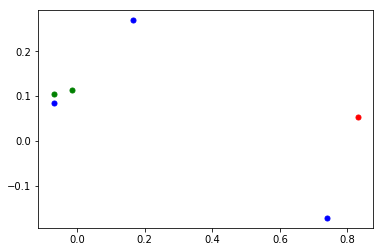

0
ÊàëËøôÈáåÂá∫Áé∞‰∫ÜÈìæÊé•
1
‰Ω†‰ª¨Á≥ªÁªüÊúâÈóÆÈ¢ò Á≥ªÁªüÊúâÊØõÁóÖÂïä Â≠òÂú®bug
2
‰Ω†‰ª¨ÁöÑ‰ª£Á†Å‰π±‰∫Ü ‰Ω†‰ª¨ÁöÑ‰ª£Á†ÅÂá∫ÈóÆÈ¢ò‰∫Ü
111.04119191118345


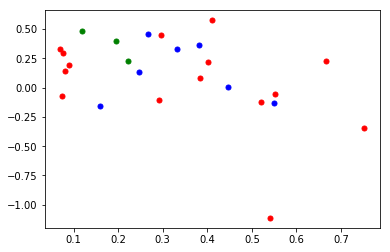

0
Á≥ªÁªüÁ®≥ÂÆöÂêó ‰Ω†‰ª¨ËøôÁ≥ªÁªü‰∏çÁ®≥ÂÆö ÊúÄËøëÁ≥ªÁªüÂæà‰∏çÁ®≥ÂÆöÁöÑÊÑüËßâ ‰πãÂâçÊ≤°Êî∂Âà∞Ê∂àÊÅØÊòØÂõ†‰∏∫Á≥ªÁªü‰∏çÂ§™Á®≥ÂÆö? Â§™‰∏çÁ®≥ÂÆö‰∫Ü ËØïËøá,‰ø°Âè∑‰∏çÂ§™Á®≥ÂÆö ÊúÄËøëÁ≥ªÁªüÈùûÂ∏∏‰∏çÁ®≥ÂÆö,Ë¶Å‰πàÊ≤°ÊúâÁîüÊàêÊâìÂç°ÂõæË¶Å‰πàÂ∞±ÊòØÂõæÁâáÈîô‰π± ‰Ω†‰ª¨ÂÖ¨‰ºóÂè∑ÊòØ‰∏çÊòØ‰∏çÁ®≥ÂÆö ‰Ω†‰ª¨ÊúçÂä°Âô®Â¥©Ê∫É‰∫ÜÂêó ÊÑüËßâËøôÊ†∑ÁöÑÈ°µÈù¢‰π±‰π±ÁöÑ ‰∏çÊòØ‰∏çÊòØ‰∏çÊòØË¶ÅÊàëËØ¥Âá†ÈÅç„ÄÇ ÂåøÂêçÂ∞èÁ∫∏Êù° ‰πüÊúâÈóÆÈ¢ò Á≥ªÁªüÂ¥©‰∫ÜÂêó? Á≥ªÁªüÂ¥©Ê∫É‰∫Ü? ËøôÁ≥ªÁªü‰πüÊòØÂ§üÂ§üÁöÑ‰∫Ü
1
‰Ω†‰ª¨Âπ≥Âè∞ÊòØ‰∏çÊòØÊúâÈóÆÈ¢ò Ëµ∑ÂàùÊàë‰πü‰ª•‰∏∫ÊòØÁΩëÁªúÈóÆÈ¢ò ÊàëËØ¥‰ªÄ‰πàÈÉΩËÆ©ÊàëÈ¢ÑÁ∫¶‰øùÊ¥Å?‰∏∫‰ªÄ‰πà Â•ΩÂÉèÂá∫bug‰∫Ü ÊòØ‰∏çÊòØÂá∫ÈóÆÈ¢ò‰∫Ü Ëøô‰∏™È¢ÑÁ∫¶ÁªèÂ∏∏‰ºöÊúâÈóÆÈ¢òÂì¶ ‰Ω†‰ª¨ÂêéÂè∞ÊòØÊÄé‰πàÂõû‰∫ã,ÊàëÊâìÂç°‰∫Ü„ÄÇ
2
ÊòØ‰Ω†‰ª¨Á≥ªÁªüÁöÑÈóÆÈ¢ò ÊòØÁ≥ªÁªüÊúâÈóÆÈ¢òÂêó? Á≥ªÁªüÈóÆÈ¢òÂêó


In [17]:
if __name__=="__main__":
    data = pd.read_csv('../data/text.csv')
    for kno in data['knowledge'].unique():
        texts = list(data[data['knowledge'] == kno]['text'])
        if len(texts) < 3:
            continue
        word_util = word()
        word_util.get_word2vec()
        word_vecs = word_util.get_vectors_of_data_cut(texts)
        fold_result = fold(classCount = 3, texts = texts)
        result = fold_result.wordsCluster(word_vecs)
        for key in result:
            print key
            print result[key]